In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path= '/content/drive/MyDrive/7150 Dissertation/EPH'

In [ ]:
def LoadData(fileName):
    # LoadData loads the relevant files.
    # Input: fileName - the name of the file to load
    # Output: exprData - the imputed expression data matrix
    #         residuals - the residuals (dependent variable)
    #         geneTissue - the names of the gene-tissue names (feature names)

    with open(fileName, 'r') as fid:
        tissues = fid.readline().strip().split('\t')
        geneNames = fid.readline().strip().split('\t')
        geneTissue = [tissues[i] + geneNames[i] for i in range(1, len(tissues))]

    data = np.loadtxt(fileName, delimiter='\t', skiprows=2)
    residuals = data[:, 0]
    exprData = data[:, 1:]

    return exprData, residuals, geneTissue

In [ ]:
def create_generator(input_dim, hidden_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_dim, activation='relu')(inputs)
    x1 = Dense(hidden_dim//2, activation='relu')(x)
    outputs = Dense(input_dim, activation='sigmoid')(x1)
    generator = Model(inputs, outputs)
    return generator

In [ ]:
def create_discriminator(input_dim, hidden_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_dim, activation='relu')(inputs)
    x1 = Dense(hidden_dim//2, activation='relu')(x)
    outputs = Dense(input_dim, activation='sigmoid')(x1)
    discriminator = Model(inputs, outputs)
    return discriminator

In [ ]:
def create_gan(generator, discriminator,input_dim):
    discriminator.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())
    discriminator.trainable = False
    x = tf.keras.Input(shape=(input_dim,))
    m = tf.keras.Input(shape=(input_dim,))
    g_input = tf.keras.layers.Multiply()([x, m])
    g_output = generator(g_input)

    # masked_data = generator(generator_input)
    imputed_data = tf.keras.layers.Add()([(1 - m) * x, m * g_output])  # Impute the missing values
    # imputed_data = tf.keras.layers.Add()([ g_output])


    # valid = discriminator(masked_data)
    valid = discriminator(imputed_data)

    # gan = Model(generator_input, [masked_data, valid])
    # gan.compile(loss=['mse',], loss_weights=[1], optimizer=Adam())
    gan = Model(inputs=[x, m], outputs=[imputed_data, valid])

    # Add binary cross-entropy loss for discriminator
    disc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Add mean squared error loss for generator
    mse_loss = tf.keras.losses.MeanSquaredError()

    gan.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=[mse_loss, disc_loss],loss_weights=[100,10])
    return gan

In [ ]:
def missing_masking(data, prob):
    missing_mask = np.random.binomial(1, 1 - prob, data.shape)
    missing_data = data * missing_mask
    return missing_mask, missing_data


In [ ]:
def impute(generator, missing_data, missing_mask):
    return generator.predict(missing_data) * (1 - missing_mask) + missing_data * missing_mask

In [ ]:
aa_expr,aa_res,aa_gt=LoadData(os.path.join(path,'AA_train.txt'))
aa_expr_test,aa_res_test,_=LoadData(os.path.join(path,'AA_validation.txt'))
e_expr,e_res,e_gt=LoadData(os.path.join(path,'EUR_train.txt'))
e_expr_test,e_res_test,_=LoadData(os.path.join(path,'EUR_validation.txt'))
X = np.vstack((aa_expr,e_expr,aa_expr_test,e_expr_test))
y = np.concatenate((aa_res,e_res,aa_res_test,e_res_test))

XEUR = np.vstack((e_expr,e_expr_test))
yEUR = np.concatenate((e_res,e_res_test))

XAA = np.vstack((aa_expr,aa_expr_test))
yAA = np.concatenate((aa_res,aa_res_test))

# For AA Data

In [ ]:
# scalerAA = StandardScaler()
scalerAA = MinMaxScaler(feature_range=(0, 1))
scalerAA.fit(XAA)
X_scaledAA = scalerAA.transform(XAA)
dataAA = X_scaledAA

# Define hyperparameters
input_dim = dataAA.shape[1]
hidden_dim = 300
alpha = 10
iterations = 1000
batch_size = 64

# Create generator and discriminator
generatorAA = create_generator(input_dim, hidden_dim)
discriminator = create_discriminator(input_dim, hidden_dim)

# Create GAN model
generator_input = Input(shape=(input_dim,))
gan = create_gan(generatorAA, discriminator,input_dim)

# Create missing mask
missing_prob = 0.2  # Probability of missing values
missing_maskAA, missing_dataAA = missing_masking(dataAA, missing_prob)

In [ ]:
dataAA.shape

(328, 539)

In [ ]:
# Train GAN model
d_lossAA =[]
g_lossAA =[]
for iteration in tqdm(range(iterations)):
    idx = np.random.randint(0, dataAA.shape[0], batch_size)
    real_data = dataAA[idx]
    mask = missing_maskAA[idx]
    masked_data = missing_dataAA[idx]

    generated_data = generatorAA.predict(masked_data)

    real_data = real_data * mask + generated_data * (1 - mask)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    discriminator.trainable = True

    d_loss_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_lossAA.append(d_loss)

    discriminator.trainable = False

    g_loss = gan.train_on_batch([masked_data,mask], [real_data, valid])
    g_lossAA.append(g_loss[0])


#     if iteration % 1000 == 0:
    print(f'Iteration: {iteration} | D Loss: {d_loss} | G Loss: {g_loss}')

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 1/1000 [00:01<24:00,  1.44s/it]

Iteration: 0 | D Loss: 6.55409574508667 | G Loss: [67.30235290527344, 0.13238902390003204, 5.406345367431641]
2/2 [==============================] - 0s 4ms/step
Iteration: 1 | D Loss: 5.559926748275757 | G Loss: [59.262325286865234, 0.12974978983402252, 4.628734588623047]
2/2 [==============================] - 0s 3ms/step


  0%|          | 3/1000 [00:01<07:19,  2.27it/s]

Iteration: 2 | D Loss: 4.652335166931152 | G Loss: [48.87189865112305, 0.1286265254020691, 3.6009247303009033]
2/2 [==============================] - 0s 5ms/step
Iteration: 3 | D Loss: 3.5707608461380005 | G Loss: [35.587745666503906, 0.1290189027786255, 2.268585681915283]
2/2 [==============================] - 0s 5ms/step


  0%|          | 5/1000 [00:01<04:17,  3.86it/s]

Iteration: 4 | D Loss: 2.4270840883255005 | G Loss: [22.89145851135254, 0.13112731277942657, 0.9778727293014526]
2/2 [==============================] - 0s 6ms/step
Iteration: 5 | D Loss: 1.6797028183937073 | G Loss: [17.955415725708008, 0.13758885860443115, 0.4196529984474182]
2/2 [==============================] - 0s 4ms/step


  1%|          | 7/1000 [00:01<03:05,  5.36it/s]

Iteration: 6 | D Loss: 1.1363816857337952 | G Loss: [18.248489379882812, 0.14318786561489105, 0.3929702937602997]
2/2 [==============================] - 0s 3ms/step


  1%|          | 8/1000 [00:02<02:46,  5.96it/s]

Iteration: 7 | D Loss: 0.6574463844299316 | G Loss: [22.785146713256836, 0.14717546105384827, 0.8067600727081299]
2/2 [==============================] - 0s 5ms/step
Iteration: 8 | D Loss: 0.47519755363464355 | G Loss: [30.308624267578125, 0.15265697240829468, 1.5042927265167236]
2/2 [==============================] - 0s 5ms/step


  1%|          | 10/1000 [00:02<02:15,  7.32it/s]

Iteration: 9 | D Loss: 0.6535333767533302 | G Loss: [33.78215026855469, 0.15377932786941528, 1.8404217958450317]
2/2 [==============================] - 0s 4ms/step
Iteration: 10 | D Loss: 0.7980168238282204 | G Loss: [31.494966506958008, 0.15326406061649323, 1.6168559789657593]
2/2 [==============================] - 0s 4ms/step


  1%|          | 12/1000 [00:02<01:59,  8.27it/s]

Iteration: 11 | D Loss: 0.7844192087650299 | G Loss: [25.36458396911621, 0.15288789570331573, 1.0075794458389282]
2/2 [==============================] - 0s 6ms/step
Iteration: 12 | D Loss: 0.7811594009399414 | G Loss: [21.085887908935547, 0.14928129315376282, 0.6157759428024292]
2/2 [==============================] - 0s 5ms/step


  1%|▏         | 14/1000 [00:02<01:46,  9.22it/s]

Iteration: 13 | D Loss: 0.8246997743844986 | G Loss: [19.99391746520996, 0.14923875033855438, 0.5070042610168457]
2/2 [==============================] - 0s 5ms/step
Iteration: 14 | D Loss: 0.7616752088069916 | G Loss: [21.20708656311035, 0.1478593349456787, 0.6421153545379639]
2/2 [==============================] - 0s 4ms/step


  2%|▏         | 16/1000 [00:02<01:39,  9.90it/s]

Iteration: 15 | D Loss: 0.6704262495040894 | G Loss: [23.242210388183594, 0.14514581859111786, 0.8727627992630005]
2/2 [==============================] - 0s 4ms/step
Iteration: 16 | D Loss: 0.6891240477561951 | G Loss: [24.626785278320312, 0.14410844445228577, 1.0215940475463867]
2/2 [==============================] - 0s 5ms/step


  2%|▏         | 18/1000 [00:02<01:35, 10.24it/s]

Iteration: 17 | D Loss: 0.7818015813827515 | G Loss: [24.392723083496094, 0.14290569722652435, 1.0102152824401855]
2/2 [==============================] - 0s 6ms/step
Iteration: 18 | D Loss: 0.8406951725482941 | G Loss: [22.849407196044922, 0.14397916197776794, 0.8451492786407471]
2/2 [==============================] - 0s 4ms/step


  2%|▏         | 20/1000 [00:03<01:34, 10.33it/s]

Iteration: 19 | D Loss: 0.8829266428947449 | G Loss: [21.239919662475586, 0.1449737250804901, 0.6742546558380127]
2/2 [==============================] - 0s 5ms/step
Iteration: 20 | D Loss: 0.9209931790828705 | G Loss: [20.10188102722168, 0.14384114742279053, 0.5717766284942627]
2/2 [==============================] - 0s 5ms/step


  2%|▏         | 22/1000 [00:03<01:33, 10.42it/s]

Iteration: 21 | D Loss: 0.9046149253845215 | G Loss: [20.255313873291016, 0.14433692395687103, 0.5821622014045715]
2/2 [==============================] - 0s 5ms/step
Iteration: 22 | D Loss: 0.8973090648651123 | G Loss: [20.519733428955078, 0.14513075351715088, 0.600665807723999]
2/2 [==============================] - 0s 5ms/step


  2%|▏         | 24/1000 [00:03<01:32, 10.57it/s]

Iteration: 23 | D Loss: 0.8789353966712952 | G Loss: [21.05878448486328, 0.14377383887767792, 0.6681399345397949]
2/2 [==============================] - 0s 5ms/step
Iteration: 24 | D Loss: 0.8711172342300415 | G Loss: [21.318754196166992, 0.14254102110862732, 0.7064652442932129]
2/2 [==============================] - 0s 6ms/step


  3%|▎         | 26/1000 [00:03<01:37, 10.00it/s]

Iteration: 25 | D Loss: 0.8819150328636169 | G Loss: [21.51303482055664, 0.14288821816444397, 0.7224213480949402]
2/2 [==============================] - 0s 4ms/step
Iteration: 26 | D Loss: 0.8902210593223572 | G Loss: [20.968109130859375, 0.1410212218761444, 0.6865986585617065]
2/2 [==============================] - 0s 3ms/step


  3%|▎         | 28/1000 [00:03<01:36, 10.11it/s]

Iteration: 27 | D Loss: 0.8796278834342957 | G Loss: [20.775924682617188, 0.14212219417095184, 0.6563706398010254]
2/2 [==============================] - 0s 5ms/step
Iteration: 28 | D Loss: 0.8645692467689514 | G Loss: [20.434185028076172, 0.14243213832378387, 0.6190970540046692]
2/2 [==============================] - 0s 4ms/step


  3%|▎         | 30/1000 [00:04<01:35, 10.17it/s]

Iteration: 29 | D Loss: 0.8531323373317719 | G Loss: [20.221397399902344, 0.141456738114357, 0.6075723171234131]
2/2 [==============================] - 0s 5ms/step
Iteration: 30 | D Loss: 0.818941593170166 | G Loss: [20.173995971679688, 0.1415056586265564, 0.6023430824279785]
2/2 [==============================] - 0s 5ms/step


  3%|▎         | 32/1000 [00:04<01:33, 10.34it/s]

Iteration: 31 | D Loss: 0.7847601771354675 | G Loss: [20.35298728942871, 0.14084705710411072, 0.6268281936645508]
2/2 [==============================] - 0s 5ms/step
Iteration: 32 | D Loss: 0.7669823169708252 | G Loss: [20.377037048339844, 0.13830362260341644, 0.6546674966812134]
2/2 [==============================] - 0s 4ms/step


  3%|▎         | 34/1000 [00:04<01:32, 10.46it/s]

Iteration: 33 | D Loss: 0.7463515102863312 | G Loss: [20.928319931030273, 0.13894285261631012, 0.7034035325050354]
2/2 [==============================] - 0s 3ms/step
Iteration: 34 | D Loss: 0.7142391800880432 | G Loss: [20.72536849975586, 0.13582217693328857, 0.7143149375915527]
2/2 [==============================] - 0s 4ms/step


  4%|▎         | 36/1000 [00:04<01:33, 10.30it/s]

Iteration: 35 | D Loss: 0.6984362006187439 | G Loss: [20.876480102539062, 0.13510923087596893, 0.7365557551383972]
2/2 [==============================] - 0s 8ms/step
Iteration: 36 | D Loss: 0.6975534558296204 | G Loss: [20.952655792236328, 0.13458463549613953, 0.749419093132019]
2/2 [==============================] - 0s 5ms/step


  4%|▍         | 38/1000 [00:04<01:32, 10.38it/s]

Iteration: 37 | D Loss: 0.7128297686576843 | G Loss: [20.50354766845703, 0.13113939762115479, 0.7389607429504395]
2/2 [==============================] - 0s 4ms/step
Iteration: 38 | D Loss: 0.7201543748378754 | G Loss: [20.156469345092773, 0.13010001182556152, 0.7146468162536621]
2/2 [==============================] - 0s 4ms/step


  4%|▍         | 40/1000 [00:05<01:29, 10.69it/s]

Iteration: 39 | D Loss: 0.7295714020729065 | G Loss: [19.654541015625, 0.12813681364059448, 0.6840860247612]
2/2 [==============================] - 0s 4ms/step
Iteration: 40 | D Loss: 0.7436388432979584 | G Loss: [19.575836181640625, 0.12565162777900696, 0.7010674476623535]
2/2 [==============================] - 0s 3ms/step


  4%|▍         | 42/1000 [00:05<01:26, 11.07it/s]

Iteration: 41 | D Loss: 0.7894948124885559 | G Loss: [19.242334365844727, 0.12203814089298248, 0.7038519382476807]
2/2 [==============================] - 0s 5ms/step
Iteration: 42 | D Loss: 0.8071907162666321 | G Loss: [19.13333511352539, 0.12071051448583603, 0.7062282562255859]
2/2 [==============================] - 0s 4ms/step


  4%|▍         | 44/1000 [00:05<01:29, 10.71it/s]

Iteration: 43 | D Loss: 0.8697665929794312 | G Loss: [19.00857925415039, 0.11930690705776215, 0.7077889442443848]
2/2 [==============================] - 0s 8ms/step
Iteration: 44 | D Loss: 0.9011200666427612 | G Loss: [18.67810821533203, 0.11703357100486755, 0.6974751949310303]
2/2 [==============================] - 0s 4ms/step


  5%|▍         | 46/1000 [00:05<01:30, 10.50it/s]

Iteration: 45 | D Loss: 0.9619207680225372 | G Loss: [18.305465698242188, 0.11891815811395645, 0.6413650512695312]
2/2 [==============================] - 0s 7ms/step
Iteration: 46 | D Loss: 0.9837937355041504 | G Loss: [17.949689865112305, 0.1175549328327179, 0.6194196343421936]
2/2 [==============================] - 0s 5ms/step


  5%|▍         | 48/1000 [00:05<01:29, 10.68it/s]

Iteration: 47 | D Loss: 1.0035797953605652 | G Loss: [17.688072204589844, 0.1177729070186615, 0.5910782814025879]
2/2 [==============================] - 0s 6ms/step
Iteration: 48 | D Loss: 1.0234928727149963 | G Loss: [17.542837142944336, 0.11746183037757874, 0.5796654224395752]
2/2 [==============================] - 0s 5ms/step


  5%|▌         | 50/1000 [00:06<01:29, 10.64it/s]

Iteration: 49 | D Loss: 1.0394625961780548 | G Loss: [17.665016174316406, 0.12040236592292786, 0.5624780654907227]
2/2 [==============================] - 0s 5ms/step
Iteration: 50 | D Loss: 1.0655688345432281 | G Loss: [18.01324462890625, 0.12232780456542969, 0.5780463218688965]
2/2 [==============================] - 0s 7ms/step


  5%|▌         | 52/1000 [00:06<01:29, 10.59it/s]

Iteration: 51 | D Loss: 1.0698018074035645 | G Loss: [17.879840850830078, 0.12307167798280716, 0.5572672486305237]
2/2 [==============================] - 0s 9ms/step
Iteration: 52 | D Loss: 1.068469524383545 | G Loss: [18.62534523010254, 0.12747818231582642, 0.5877527594566345]
2/2 [==============================] - 0s 5ms/step


  5%|▌         | 54/1000 [00:06<01:30, 10.50it/s]

Iteration: 53 | D Loss: 1.0897313356399536 | G Loss: [18.547504425048828, 0.12837275862693787, 0.5710228681564331]
2/2 [==============================] - 0s 4ms/step
Iteration: 54 | D Loss: 1.1039142608642578 | G Loss: [19.104591369628906, 0.13268624246120453, 0.5835965871810913]
2/2 [==============================] - 0s 5ms/step


  6%|▌         | 56/1000 [00:06<01:31, 10.35it/s]

Iteration: 55 | D Loss: 1.1116662621498108 | G Loss: [18.761184692382812, 0.13269740343093872, 0.549144446849823]
2/2 [==============================] - 0s 4ms/step
Iteration: 56 | D Loss: 1.0934492349624634 | G Loss: [18.820831298828125, 0.13269659876823425, 0.5551172494888306]
2/2 [==============================] - 0s 5ms/step


  6%|▌         | 58/1000 [00:06<01:27, 10.71it/s]

Iteration: 57 | D Loss: 1.1082477569580078 | G Loss: [19.065372467041016, 0.13570934534072876, 0.5494439005851746]
2/2 [==============================] - 0s 7ms/step
Iteration: 58 | D Loss: 1.0893850922584534 | G Loss: [19.32223892211914, 0.13766232132911682, 0.5556007623672485]
2/2 [==============================] - 0s 6ms/step


  6%|▌         | 60/1000 [00:06<01:27, 10.73it/s]

Iteration: 59 | D Loss: 1.0761584639549255 | G Loss: [19.594482421875, 0.1379649043083191, 0.5797992944717407]
2/2 [==============================] - 0s 6ms/step
Iteration: 60 | D Loss: 1.0243109464645386 | G Loss: [19.830930709838867, 0.1368807852268219, 0.6142852306365967]
2/2 [==============================] - 0s 4ms/step


  6%|▌         | 62/1000 [00:07<01:29, 10.48it/s]

Iteration: 61 | D Loss: 1.0316082835197449 | G Loss: [20.240467071533203, 0.14012712240219116, 0.6227755546569824]
2/2 [==============================] - 0s 5ms/step
Iteration: 62 | D Loss: 0.9994810819625854 | G Loss: [20.08664894104004, 0.13900727033615112, 0.6185921430587769]
2/2 [==============================] - 0s 5ms/step


  6%|▋         | 64/1000 [00:07<01:29, 10.46it/s]

Iteration: 63 | D Loss: 0.9853024482727051 | G Loss: [20.108177185058594, 0.1386922299861908, 0.6238954067230225]
2/2 [==============================] - 0s 5ms/step
Iteration: 64 | D Loss: 0.9630259275436401 | G Loss: [20.198867797851562, 0.13889911770820618, 0.630895733833313]
2/2 [==============================] - 0s 4ms/step


  7%|▋         | 66/1000 [00:07<01:29, 10.44it/s]

Iteration: 65 | D Loss: 0.9554681777954102 | G Loss: [20.393375396728516, 0.14031346142292023, 0.6362029910087585]
2/2 [==============================] - 0s 5ms/step
Iteration: 66 | D Loss: 0.9222874939441681 | G Loss: [20.221755981445312, 0.13713648915290833, 0.6508105993270874]
2/2 [==============================] - 0s 5ms/step


  7%|▋         | 68/1000 [00:07<01:29, 10.43it/s]

Iteration: 67 | D Loss: 0.9000023603439331 | G Loss: [20.054950714111328, 0.13712500035762787, 0.6342450380325317]
2/2 [==============================] - 0s 5ms/step
Iteration: 68 | D Loss: 0.9040636420249939 | G Loss: [20.118085861206055, 0.13721558451652527, 0.6396527886390686]
2/2 [==============================] - 0s 4ms/step


  7%|▋         | 70/1000 [00:07<01:27, 10.62it/s]

Iteration: 69 | D Loss: 0.8827047049999237 | G Loss: [20.24497413635254, 0.13664491474628448, 0.6580482721328735]
2/2 [==============================] - 0s 6ms/step
Iteration: 70 | D Loss: 0.8805879056453705 | G Loss: [20.307743072509766, 0.1355111300945282, 0.6756629943847656]
2/2 [==============================] - 0s 5ms/step


  7%|▋         | 72/1000 [00:08<01:28, 10.49it/s]

Iteration: 71 | D Loss: 0.8302809596061707 | G Loss: [20.385143280029297, 0.13400107622146606, 0.6985036730766296]
2/2 [==============================] - 0s 6ms/step
Iteration: 72 | D Loss: 0.824424147605896 | G Loss: [20.52404022216797, 0.13359642028808594, 0.7164397835731506]
2/2 [==============================] - 0s 4ms/step


  7%|▋         | 74/1000 [00:08<01:28, 10.44it/s]

Iteration: 73 | D Loss: 0.8150699436664581 | G Loss: [20.29377555847168, 0.1316019892692566, 0.7133576273918152]
2/2 [==============================] - 0s 6ms/step
Iteration: 74 | D Loss: 0.8033386766910553 | G Loss: [20.41439437866211, 0.13123667240142822, 0.7290728688240051]
2/2 [==============================] - 0s 5ms/step


  8%|▊         | 76/1000 [00:08<01:27, 10.59it/s]

Iteration: 75 | D Loss: 0.7859594225883484 | G Loss: [20.304855346679688, 0.12953078746795654, 0.7351776361465454]
2/2 [==============================] - 0s 5ms/step
Iteration: 76 | D Loss: 0.7868595123291016 | G Loss: [20.0419921875, 0.12750661373138428, 0.729133129119873]
2/2 [==============================] - 0s 4ms/step


  8%|▊         | 78/1000 [00:08<01:27, 10.58it/s]

Iteration: 77 | D Loss: 0.7893419861793518 | G Loss: [19.764022827148438, 0.12560927867889404, 0.7203093767166138]
2/2 [==============================] - 0s 5ms/step
Iteration: 78 | D Loss: 0.8051932454109192 | G Loss: [19.410507202148438, 0.12489015609025955, 0.6921491622924805]
2/2 [==============================] - 0s 5ms/step


  8%|▊         | 80/1000 [00:08<01:29, 10.27it/s]

Iteration: 79 | D Loss: 0.8244662880897522 | G Loss: [19.511667251586914, 0.12478868663311005, 0.7032798528671265]
2/2 [==============================] - 0s 7ms/step
Iteration: 80 | D Loss: 0.8361986577510834 | G Loss: [19.073875427246094, 0.12279345840215683, 0.6794528961181641]
2/2 [==============================] - 0s 5ms/step


  8%|▊         | 82/1000 [00:09<01:39,  9.20it/s]

Iteration: 81 | D Loss: 0.8526362180709839 | G Loss: [19.41250228881836, 0.12405368685722351, 0.7007132768630981]
2/2 [==============================] - 0s 7ms/step


  8%|▊         | 83/1000 [00:09<01:42,  8.91it/s]

Iteration: 82 | D Loss: 0.9051307439804077 | G Loss: [18.801061630249023, 0.12249656766653061, 0.6551405191421509]
2/2 [==============================] - 0s 5ms/step


  8%|▊         | 84/1000 [00:09<01:45,  8.69it/s]

Iteration: 83 | D Loss: 0.9205227494239807 | G Loss: [18.824459075927734, 0.12367505580186844, 0.6456952691078186]
2/2 [==============================] - 0s 3ms/step


  8%|▊         | 85/1000 [00:09<01:45,  8.64it/s]

Iteration: 84 | D Loss: 0.9556991457939148 | G Loss: [18.67428970336914, 0.12329328060150146, 0.6344962120056152]
2/2 [==============================] - 0s 8ms/step


  9%|▊         | 86/1000 [00:09<01:44,  8.73it/s]

Iteration: 85 | D Loss: 0.9959584176540375 | G Loss: [18.44422149658203, 0.12392590194940567, 0.6051632165908813]
2/2 [==============================] - 0s 3ms/step


  9%|▊         | 87/1000 [00:09<01:45,  8.62it/s]

Iteration: 86 | D Loss: 1.0160212516784668 | G Loss: [18.28514862060547, 0.1229599341750145, 0.5989155769348145]
2/2 [==============================] - 0s 6ms/step


  9%|▉         | 88/1000 [00:09<01:46,  8.57it/s]

Iteration: 87 | D Loss: 1.0401434898376465 | G Loss: [18.479080200195312, 0.12588319182395935, 0.589076042175293]
2/2 [==============================] - 0s 10ms/step


  9%|▉         | 89/1000 [00:09<01:48,  8.43it/s]

Iteration: 88 | D Loss: 1.009422242641449 | G Loss: [18.438777923583984, 0.12409636378288269, 0.6029142141342163]
2/2 [==============================] - 0s 3ms/step


  9%|▉         | 90/1000 [00:10<01:46,  8.54it/s]

Iteration: 89 | D Loss: 1.0036258399486542 | G Loss: [18.553495407104492, 0.1254056990146637, 0.6012925505638123]
2/2 [==============================] - 0s 7ms/step


  9%|▉         | 91/1000 [00:10<01:48,  8.36it/s]

Iteration: 90 | D Loss: 0.9845855832099915 | G Loss: [19.010108947753906, 0.1285310983657837, 0.6157000660896301]
2/2 [==============================] - 0s 6ms/step


  9%|▉         | 92/1000 [00:10<01:49,  8.28it/s]

Iteration: 91 | D Loss: 0.9787894785404205 | G Loss: [19.162351608276367, 0.12948085367679596, 0.6214266419410706]
2/2 [==============================] - 0s 6ms/step


  9%|▉         | 93/1000 [00:10<01:52,  8.07it/s]

Iteration: 92 | D Loss: 0.9677925705909729 | G Loss: [18.84427261352539, 0.1273723542690277, 0.6107037663459778]
2/2 [==============================] - 0s 4ms/step


  9%|▉         | 94/1000 [00:10<01:51,  8.14it/s]

Iteration: 93 | D Loss: 0.9329783916473389 | G Loss: [18.90885353088379, 0.12584799528121948, 0.6324054002761841]
2/2 [==============================] - 0s 4ms/step


 10%|▉         | 95/1000 [00:10<01:52,  8.03it/s]

Iteration: 94 | D Loss: 0.9233032763004303 | G Loss: [19.17374038696289, 0.12906625866889954, 0.6267114877700806]
2/2 [==============================] - 0s 3ms/step


 10%|▉         | 96/1000 [00:10<01:48,  8.32it/s]

Iteration: 95 | D Loss: 0.8862385153770447 | G Loss: [19.06662368774414, 0.12522080540657043, 0.6544543504714966]
2/2 [==============================] - 0s 4ms/step


 10%|▉         | 97/1000 [00:10<01:47,  8.43it/s]

Iteration: 96 | D Loss: 0.8571882843971252 | G Loss: [19.227149963378906, 0.12436936050653458, 0.6790212392807007]
2/2 [==============================] - 0s 3ms/step


 10%|▉         | 98/1000 [00:11<01:45,  8.59it/s]

Iteration: 97 | D Loss: 0.831646054983139 | G Loss: [19.13507080078125, 0.12240734696388245, 0.6894336938858032]
2/2 [==============================] - 0s 8ms/step


 10%|▉         | 99/1000 [00:11<01:48,  8.29it/s]

Iteration: 98 | D Loss: 0.8092200756072998 | G Loss: [18.873165130615234, 0.11884012818336487, 0.6989151835441589]
2/2 [==============================] - 0s 4ms/step


 10%|█         | 100/1000 [00:11<01:50,  8.18it/s]

Iteration: 99 | D Loss: 0.7858777344226837 | G Loss: [18.800622940063477, 0.11669009923934937, 0.7131612300872803]
2/2 [==============================] - 0s 5ms/step


 10%|█         | 101/1000 [00:11<01:51,  8.08it/s]

Iteration: 100 | D Loss: 0.7808167636394501 | G Loss: [18.73255157470703, 0.11455145478248596, 0.7277405261993408]
2/2 [==============================] - 0s 5ms/step


 10%|█         | 102/1000 [00:11<01:54,  7.87it/s]

Iteration: 101 | D Loss: 0.7563855350017548 | G Loss: [18.53571319580078, 0.11231781542301178, 0.7303930521011353]
2/2 [==============================] - 0s 4ms/step


 10%|█         | 103/1000 [00:11<01:47,  8.37it/s]

Iteration: 102 | D Loss: 0.7539709508419037 | G Loss: [18.248119354248047, 0.10881878435611725, 0.736624002456665]
2/2 [==============================] - 0s 6ms/step
Iteration: 103 | D Loss: 0.7490982413291931 | G Loss: [18.10342788696289, 0.1081300899386406, 0.7290418148040771]
2/2 [==============================] - 0s 5ms/step


 10%|█         | 105/1000 [00:11<01:33,  9.58it/s]

Iteration: 104 | D Loss: 0.735318660736084 | G Loss: [17.976303100585938, 0.10533080995082855, 0.7443222403526306]
2/2 [==============================] - 0s 5ms/step
Iteration: 105 | D Loss: 0.7341476082801819 | G Loss: [17.848167419433594, 0.10384439677000046, 0.7463727593421936]
2/2 [==============================] - 0s 5ms/step


 11%|█         | 107/1000 [00:12<01:28, 10.09it/s]

Iteration: 106 | D Loss: 0.7356045246124268 | G Loss: [17.583820343017578, 0.10108928382396698, 0.7474891543388367]
2/2 [==============================] - 0s 7ms/step
Iteration: 107 | D Loss: 0.7472631335258484 | G Loss: [17.43750762939453, 0.09991417080163956, 0.7446091771125793]
2/2 [==============================] - 0s 3ms/step


 11%|█         | 109/1000 [00:12<01:27, 10.16it/s]

Iteration: 108 | D Loss: 0.737219363451004 | G Loss: [17.18352508544922, 0.09702607989311218, 0.7480916380882263]
2/2 [==============================] - 0s 5ms/step


 11%|█         | 110/1000 [00:12<01:30,  9.84it/s]

Iteration: 109 | D Loss: 0.7324140071868896 | G Loss: [17.238975524902344, 0.09625527262687683, 0.7613447904586792]
2/2 [==============================] - 0s 4ms/step


 11%|█         | 111/1000 [00:12<01:31,  9.72it/s]

Iteration: 110 | D Loss: 0.7160095274448395 | G Loss: [17.24770736694336, 0.09598793089389801, 0.7648913264274597]
2/2 [==============================] - 0s 5ms/step


 11%|█         | 112/1000 [00:12<01:33,  9.45it/s]

Iteration: 111 | D Loss: 0.7129896879196167 | G Loss: [17.274215698242188, 0.09498310089111328, 0.7775904536247253]
2/2 [==============================] - 0s 4ms/step


 11%|█▏        | 113/1000 [00:12<01:33,  9.46it/s]

Iteration: 112 | D Loss: 0.7127280235290527 | G Loss: [17.220050811767578, 0.09435394406318665, 0.7784655690193176]
2/2 [==============================] - 0s 6ms/step


 11%|█▏        | 114/1000 [00:12<01:32,  9.58it/s]

Iteration: 113 | D Loss: 0.7146462500095367 | G Loss: [17.385881423950195, 0.09606717526912689, 0.777916431427002]
2/2 [==============================] - 0s 7ms/step
Iteration: 114 | D Loss: 0.7225148677825928 | G Loss: [17.171566009521484, 0.09575800597667694, 0.7595766186714172]
2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 116/1000 [00:12<01:28,  9.97it/s]

Iteration: 115 | D Loss: 0.7192267775535583 | G Loss: [16.973289489746094, 0.09617564082145691, 0.7355725765228271]
2/2 [==============================] - 0s 5ms/step
Iteration: 116 | D Loss: 0.716439425945282 | G Loss: [17.0882625579834, 0.09790846705436707, 0.7297415733337402]
2/2 [==============================] - 0s 6ms/step


 12%|█▏        | 118/1000 [00:13<01:23, 10.57it/s]

Iteration: 117 | D Loss: 0.7207412421703339 | G Loss: [16.978206634521484, 0.09793278574943542, 0.7184927463531494]
2/2 [==============================] - 0s 5ms/step
Iteration: 118 | D Loss: 0.7219884395599365 | G Loss: [17.071430206298828, 0.09891850501298904, 0.7179580926895142]
2/2 [==============================] - 0s 6ms/step


 12%|█▏        | 120/1000 [00:13<01:25, 10.29it/s]

Iteration: 119 | D Loss: 0.7190011143684387 | G Loss: [17.208942413330078, 0.09820645302534103, 0.7388296127319336]
2/2 [==============================] - 0s 5ms/step
Iteration: 120 | D Loss: 0.7285161316394806 | G Loss: [17.23543930053711, 0.09906332939863205, 0.7329106330871582]
2/2 [==============================] - 0s 4ms/step


 12%|█▏        | 122/1000 [00:13<01:26, 10.13it/s]

Iteration: 121 | D Loss: 0.7286489307880402 | G Loss: [17.154521942138672, 0.0980796292424202, 0.7346558570861816]
2/2 [==============================] - 0s 6ms/step
Iteration: 122 | D Loss: 0.7313299775123596 | G Loss: [17.124675750732422, 0.09754446148872375, 0.737022876739502]
2/2 [==============================] - 0s 5ms/step


 12%|█▏        | 124/1000 [00:13<01:25, 10.24it/s]

Iteration: 123 | D Loss: 0.742272675037384 | G Loss: [17.1671085357666, 0.09780477732419968, 0.7386631369590759]
2/2 [==============================] - 0s 4ms/step
Iteration: 124 | D Loss: 0.7573107779026031 | G Loss: [17.011375427246094, 0.09733502566814423, 0.7277872562408447]
2/2 [==============================] - 0s 4ms/step


 13%|█▎        | 126/1000 [00:13<01:25, 10.25it/s]

Iteration: 125 | D Loss: 0.763731062412262 | G Loss: [16.732282638549805, 0.09655162692070007, 0.707711935043335]
2/2 [==============================] - 0s 4ms/step
Iteration: 126 | D Loss: 0.7579730153083801 | G Loss: [16.912830352783203, 0.09665177762508392, 0.7247653603553772]
2/2 [==============================] - 0s 6ms/step


 13%|█▎        | 128/1000 [00:14<01:25, 10.20it/s]

Iteration: 127 | D Loss: 0.7637481093406677 | G Loss: [16.791120529174805, 0.09551079571247101, 0.7240040898323059]
2/2 [==============================] - 0s 6ms/step
Iteration: 128 | D Loss: 0.7668548822402954 | G Loss: [16.741161346435547, 0.09513679146766663, 0.7227482199668884]
2/2 [==============================] - 0s 6ms/step


 13%|█▎        | 130/1000 [00:14<01:26, 10.00it/s]

Iteration: 129 | D Loss: 0.7660596966743469 | G Loss: [16.92890739440918, 0.09591572731733322, 0.7337334752082825]
2/2 [==============================] - 0s 7ms/step
Iteration: 130 | D Loss: 0.7670821845531464 | G Loss: [16.901395797729492, 0.09522149711847305, 0.7379246354103088]
2/2 [==============================] - 0s 7ms/step


 13%|█▎        | 132/1000 [00:14<01:26,  9.99it/s]

Iteration: 131 | D Loss: 0.7663589417934418 | G Loss: [16.69378662109375, 0.09456966817378998, 0.7236819863319397]
2/2 [==============================] - 0s 6ms/step


 13%|█▎        | 133/1000 [00:14<01:28,  9.82it/s]

Iteration: 132 | D Loss: 0.7632443010807037 | G Loss: [16.54706573486328, 0.09377449750900269, 0.7169616222381592]
2/2 [==============================] - 0s 5ms/step
Iteration: 133 | D Loss: 0.7598207294940948 | G Loss: [16.440898895263672, 0.09368130564689636, 0.7072768211364746]
2/2 [==============================] - 0s 4ms/step


 14%|█▎        | 135/1000 [00:14<01:23, 10.39it/s]

Iteration: 134 | D Loss: 0.7581785023212433 | G Loss: [16.439889907836914, 0.09357155859470367, 0.7082733511924744]
2/2 [==============================] - 0s 4ms/step
Iteration: 135 | D Loss: 0.755555659532547 | G Loss: [16.190279006958008, 0.09213969856500626, 0.6976308822631836]
2/2 [==============================] - 0s 3ms/step


 14%|█▎        | 137/1000 [00:15<01:24, 10.22it/s]

Iteration: 136 | D Loss: 0.7512006759643555 | G Loss: [16.335037231445312, 0.09165621548891068, 0.7169414758682251]
2/2 [==============================] - 0s 6ms/step
Iteration: 137 | D Loss: 0.7423285245895386 | G Loss: [16.138700485229492, 0.09009584784507751, 0.7129116654396057]
2/2 [==============================] - 0s 6ms/step


 14%|█▍        | 139/1000 [00:15<01:21, 10.54it/s]

Iteration: 138 | D Loss: 0.7414230704307556 | G Loss: [16.173263549804688, 0.08936886489391327, 0.7236377000808716]
2/2 [==============================] - 0s 5ms/step
Iteration: 139 | D Loss: 0.7351516485214233 | G Loss: [16.29111671447754, 0.08911020308732986, 0.7380096912384033]
2/2 [==============================] - 0s 4ms/step


 14%|█▍        | 141/1000 [00:15<01:22, 10.38it/s]

Iteration: 140 | D Loss: 0.7315433919429779 | G Loss: [16.123777389526367, 0.08869138360023499, 0.7254638671875]
2/2 [==============================] - 0s 5ms/step
Iteration: 141 | D Loss: 0.7414976358413696 | G Loss: [16.01409912109375, 0.08763148635625839, 0.7250950336456299]
2/2 [==============================] - 0s 4ms/step


 14%|█▍        | 143/1000 [00:15<01:22, 10.43it/s]

Iteration: 142 | D Loss: 0.7432194352149963 | G Loss: [15.903814315795898, 0.08840468525886536, 0.7063345909118652]
2/2 [==============================] - 0s 6ms/step
Iteration: 143 | D Loss: 0.7418445646762848 | G Loss: [15.76011848449707, 0.08635213971138, 0.712490439414978]
2/2 [==============================] - 0s 7ms/step


 14%|█▍        | 145/1000 [00:15<01:22, 10.34it/s]

Iteration: 144 | D Loss: 0.7443716526031494 | G Loss: [15.629186630249023, 0.08608908951282501, 0.7020277976989746]
2/2 [==============================] - 0s 4ms/step
Iteration: 145 | D Loss: 0.7516448199748993 | G Loss: [15.55274486541748, 0.0855662003159523, 0.6996124982833862]
2/2 [==============================] - 0s 3ms/step


 15%|█▍        | 147/1000 [00:15<01:20, 10.58it/s]

Iteration: 146 | D Loss: 0.7476115822792053 | G Loss: [15.51624870300293, 0.08601877093315125, 0.6914371252059937]
2/2 [==============================] - 0s 5ms/step
Iteration: 147 | D Loss: 0.7544086873531342 | G Loss: [15.529516220092773, 0.08576907217502594, 0.6952608823776245]
2/2 [==============================] - 0s 7ms/step


 15%|█▍        | 149/1000 [00:16<01:22, 10.34it/s]

Iteration: 148 | D Loss: 0.7596158385276794 | G Loss: [15.49876880645752, 0.08522073924541473, 0.697669506072998]
2/2 [==============================] - 0s 5ms/step
Iteration: 149 | D Loss: 0.761366605758667 | G Loss: [15.287407875061035, 0.08421153575181961, 0.6866253614425659]
2/2 [==============================] - 0s 7ms/step


 15%|█▌        | 151/1000 [00:16<01:23, 10.22it/s]

Iteration: 150 | D Loss: 0.765957236289978 | G Loss: [15.379648208618164, 0.08466929197311401, 0.6912719011306763]
2/2 [==============================] - 0s 5ms/step
Iteration: 151 | D Loss: 0.7576760649681091 | G Loss: [15.429889678955078, 0.08406035602092743, 0.7023854851722717]
2/2 [==============================] - 0s 3ms/step


 15%|█▌        | 153/1000 [00:16<01:19, 10.60it/s]

Iteration: 152 | D Loss: 0.7595874965190887 | G Loss: [15.43370532989502, 0.08390786498785019, 0.7042919397354126]
2/2 [==============================] - 0s 4ms/step
Iteration: 153 | D Loss: 0.7515078485012054 | G Loss: [15.651872634887695, 0.08435012400150299, 0.7216860055923462]
2/2 [==============================] - 0s 3ms/step


 16%|█▌        | 155/1000 [00:16<01:17, 10.94it/s]

Iteration: 154 | D Loss: 0.750711053609848 | G Loss: [15.835509300231934, 0.0848788172006607, 0.7347627878189087]
2/2 [==============================] - 0s 7ms/step
Iteration: 155 | D Loss: 0.7482696175575256 | G Loss: [15.8806791305542, 0.08492259681224823, 0.7388418912887573]
2/2 [==============================] - 0s 5ms/step


 16%|█▌        | 157/1000 [00:16<01:17, 10.86it/s]

Iteration: 156 | D Loss: 0.7441911995410919 | G Loss: [15.797630310058594, 0.08419947326183319, 0.7377682328224182]
2/2 [==============================] - 0s 6ms/step
Iteration: 157 | D Loss: 0.7347646653652191 | G Loss: [15.488258361816406, 0.08258194476366043, 0.7230063080787659]
2/2 [==============================] - 0s 4ms/step


 16%|█▌        | 159/1000 [00:17<01:18, 10.73it/s]

Iteration: 158 | D Loss: 0.7151348888874054 | G Loss: [15.514169692993164, 0.08184491842985153, 0.732967734336853]
2/2 [==============================] - 0s 6ms/step
Iteration: 159 | D Loss: 0.7099930644035339 | G Loss: [15.295190811157227, 0.08047688752412796, 0.724750280380249]
2/2 [==============================] - 0s 3ms/step


 16%|█▌        | 161/1000 [00:17<01:18, 10.65it/s]

Iteration: 160 | D Loss: 0.6991971433162689 | G Loss: [15.331868171691895, 0.08089898526668549, 0.7241970300674438]
2/2 [==============================] - 0s 7ms/step
Iteration: 161 | D Loss: 0.6976256966590881 | G Loss: [15.118301391601562, 0.07865025103092194, 0.7253276109695435]
2/2 [==============================] - 0s 7ms/step


 16%|█▋        | 163/1000 [00:17<01:20, 10.46it/s]

Iteration: 162 | D Loss: 0.6961825489997864 | G Loss: [15.231995582580566, 0.07785672694444656, 0.7446323037147522]
2/2 [==============================] - 0s 6ms/step
Iteration: 163 | D Loss: 0.6928642988204956 | G Loss: [15.130979537963867, 0.07761628925800323, 0.736935019493103]
2/2 [==============================] - 0s 7ms/step


 16%|█▋        | 165/1000 [00:17<01:19, 10.51it/s]

Iteration: 164 | D Loss: 0.6884888112545013 | G Loss: [15.120838165283203, 0.07705192267894745, 0.7415645718574524]
2/2 [==============================] - 0s 5ms/step
Iteration: 165 | D Loss: 0.6917950809001923 | G Loss: [15.115114212036133, 0.07647499442100525, 0.7467614412307739]
2/2 [==============================] - 0s 4ms/step


 17%|█▋        | 167/1000 [00:17<01:18, 10.65it/s]

Iteration: 166 | D Loss: 0.6952672600746155 | G Loss: [14.950136184692383, 0.07568024098873138, 0.7382112741470337]
2/2 [==============================] - 0s 6ms/step
Iteration: 167 | D Loss: 0.6951527297496796 | G Loss: [14.993417739868164, 0.07584162056446075, 0.7409255504608154]
2/2 [==============================] - 0s 8ms/step
Iteration: 168 | D Loss: 0.6981778144836426 | G Loss: [14.827165603637695, 0.07557589560747147, 0.7269576191902161]

 17%|█▋        | 169/1000 [00:18<01:19, 10.39it/s]


2/2 [==============================] - 0s 6ms/step
Iteration: 169 | D Loss: 0.7005917131900787 | G Loss: [14.760295867919922, 0.07475843280553818, 0.7284452319145203]
2/2 [==============================] - 0s 4ms/step


 17%|█▋        | 171/1000 [00:18<01:18, 10.50it/s]

Iteration: 170 | D Loss: 0.7058281898498535 | G Loss: [14.793682098388672, 0.0753990113735199, 0.7253780961036682]
2/2 [==============================] - 0s 7ms/step
Iteration: 171 | D Loss: 0.7116851210594177 | G Loss: [14.745765686035156, 0.07462280243635178, 0.7283485531806946]
2/2 [==============================] - 0s 6ms/step


 17%|█▋        | 173/1000 [00:18<01:17, 10.66it/s]

Iteration: 172 | D Loss: 0.7161872386932373 | G Loss: [14.984973907470703, 0.07757014036178589, 0.7227959632873535]
2/2 [==============================] - 0s 6ms/step
Iteration: 173 | D Loss: 0.7205415070056915 | G Loss: [14.70848274230957, 0.0758943110704422, 0.7119051814079285]
2/2 [==============================] - 0s 6ms/step


 18%|█▊        | 175/1000 [00:18<01:17, 10.70it/s]

Iteration: 174 | D Loss: 0.7213601469993591 | G Loss: [15.014803886413574, 0.0786757841706276, 0.7147225141525269]
2/2 [==============================] - 0s 5ms/step
Iteration: 175 | D Loss: 0.7289081513881683 | G Loss: [14.784318923950195, 0.0764504075050354, 0.7139278650283813]
2/2 [==============================] - 0s 5ms/step


 18%|█▊        | 177/1000 [00:18<01:16, 10.75it/s]

Iteration: 176 | D Loss: 0.7300660908222198 | G Loss: [15.0206298828125, 0.07814571261405945, 0.7206057906150818]
2/2 [==============================] - 0s 7ms/step
Iteration: 177 | D Loss: 0.7283578217029572 | G Loss: [15.034276962280273, 0.07844942808151245, 0.7189333438873291]
2/2 [==============================] - 0s 3ms/step


 18%|█▊        | 179/1000 [00:18<01:17, 10.62it/s]

Iteration: 178 | D Loss: 0.7348170876502991 | G Loss: [15.004983901977539, 0.07833108305931091, 0.7171875238418579]
2/2 [==============================] - 0s 7ms/step
Iteration: 179 | D Loss: 0.7364144325256348 | G Loss: [14.967445373535156, 0.07758913189172745, 0.7208532094955444]
2/2 [==============================] - 0s 8ms/step


 18%|█▊        | 181/1000 [00:19<01:17, 10.56it/s]

Iteration: 180 | D Loss: 0.7361140251159668 | G Loss: [15.181601524353027, 0.07948252558708191, 0.7233349084854126]
2/2 [==============================] - 0s 5ms/step
Iteration: 181 | D Loss: 0.7438149154186249 | G Loss: [15.143974304199219, 0.07940896600484848, 0.7203077077865601]
2/2 [==============================] - 0s 6ms/step


 18%|█▊        | 183/1000 [00:19<01:20, 10.18it/s]

Iteration: 182 | D Loss: 0.7376267313957214 | G Loss: [14.996441841125488, 0.0776752158999443, 0.7228920459747314]
2/2 [==============================] - 0s 5ms/step
Iteration: 183 | D Loss: 0.722844123840332 | G Loss: [15.27485466003418, 0.07832712680101395, 0.7442141771316528]
2/2 [==============================] - 0s 3ms/step


 18%|█▊        | 185/1000 [00:19<01:19, 10.29it/s]

Iteration: 184 | D Loss: 0.7065398395061493 | G Loss: [15.377830505371094, 0.07808881998062134, 0.7568948268890381]
2/2 [==============================] - 0s 4ms/step
Iteration: 185 | D Loss: 0.6856557130813599 | G Loss: [15.568391799926758, 0.07772080600261688, 0.7796310782432556]
2/2 [==============================] - 0s 4ms/step


 19%|█▊        | 187/1000 [00:19<01:19, 10.24it/s]

Iteration: 186 | D Loss: 0.6747021675109863 | G Loss: [15.530370712280273, 0.07773646712303162, 0.7756723165512085]
2/2 [==============================] - 0s 6ms/step
Iteration: 187 | D Loss: 0.6771905422210693 | G Loss: [15.625271797180176, 0.07839502394199371, 0.7785769701004028]
2/2 [==============================] - 0s 5ms/step


 19%|█▉        | 189/1000 [00:19<01:19, 10.23it/s]

Iteration: 188 | D Loss: 0.6810148358345032 | G Loss: [15.29777717590332, 0.07691214233636856, 0.7606562376022339]
2/2 [==============================] - 0s 3ms/step
Iteration: 189 | D Loss: 0.6793037354946136 | G Loss: [15.326318740844727, 0.07814217358827591, 0.75121009349823]
2/2 [==============================] - 0s 6ms/step


 19%|█▉        | 191/1000 [00:20<01:18, 10.32it/s]

Iteration: 190 | D Loss: 0.688044548034668 | G Loss: [15.010087013244629, 0.07679347693920135, 0.7330739498138428]
2/2 [==============================] - 0s 7ms/step
Iteration: 191 | D Loss: 0.6894559264183044 | G Loss: [14.611215591430664, 0.0747891440987587, 0.7132300734519958]
2/2 [==============================] - 0s 9ms/step


 19%|█▉        | 193/1000 [00:20<01:19, 10.11it/s]

Iteration: 192 | D Loss: 0.6908325850963593 | G Loss: [14.673640251159668, 0.07503560930490494, 0.7170079350471497]
2/2 [==============================] - 0s 8ms/step
Iteration: 193 | D Loss: 0.6924564242362976 | G Loss: [14.679220199584961, 0.07513269782066345, 0.7165950536727905]
2/2 [==============================] - 0s 5ms/step


 20%|█▉        | 195/1000 [00:20<01:21,  9.91it/s]

Iteration: 194 | D Loss: 0.6991344690322876 | G Loss: [14.704299926757812, 0.07598991692066193, 0.7105307579040527]
2/2 [==============================] - 0s 4ms/step


 20%|█▉        | 196/1000 [00:20<01:22,  9.79it/s]

Iteration: 195 | D Loss: 0.6995184421539307 | G Loss: [14.713930130004883, 0.0751495286822319, 0.7198977470397949]
2/2 [==============================] - 0s 7ms/step
Iteration: 196 | D Loss: 0.7130939364433289 | G Loss: [14.75711727142334, 0.07537445425987244, 0.7219671607017517]
2/2 [==============================] - 0s 4ms/step


 20%|█▉        | 198/1000 [00:20<01:19, 10.10it/s]

Iteration: 197 | D Loss: 0.7162195146083832 | G Loss: [14.673582077026367, 0.07541529834270477, 0.7132052183151245]
2/2 [==============================] - 0s 6ms/step
Iteration: 198 | D Loss: 0.7287561297416687 | G Loss: [14.887882232666016, 0.07675880193710327, 0.7212002277374268]
2/2 [==============================] - 0s 3ms/step


 20%|██        | 200/1000 [00:21<01:19, 10.09it/s]

Iteration: 199 | D Loss: 0.7345796823501587 | G Loss: [14.857871055603027, 0.07753510028123856, 0.7104361057281494]
2/2 [==============================] - 0s 6ms/step
Iteration: 200 | D Loss: 0.7403952479362488 | G Loss: [14.726815223693848, 0.07754415273666382, 0.6972399950027466]
2/2 [==============================] - 0s 6ms/step


 20%|██        | 202/1000 [00:21<01:19, 10.08it/s]

Iteration: 201 | D Loss: 0.7512699961662292 | G Loss: [14.703929901123047, 0.07737473398447037, 0.6966456174850464]
2/2 [==============================] - 0s 10ms/step
Iteration: 202 | D Loss: 0.7568227648735046 | G Loss: [14.622564315795898, 0.07709798216819763, 0.6912766695022583]
2/2 [==============================] - 0s 7ms/step


 20%|██        | 204/1000 [00:21<01:20,  9.89it/s]

Iteration: 203 | D Loss: 0.7627240717411041 | G Loss: [14.628857612609863, 0.0773402601480484, 0.6894831657409668]
2/2 [==============================] - 0s 6ms/step
Iteration: 204 | D Loss: 0.7645866572856903 | G Loss: [14.55388355255127, 0.07756398618221283, 0.6797484755516052]
2/2 [==============================] - 0s 9ms/step


 21%|██        | 206/1000 [00:21<01:26,  9.21it/s]

Iteration: 205 | D Loss: 0.7699316740036011 | G Loss: [14.658781051635742, 0.07837037742137909, 0.6821743249893188]
2/2 [==============================] - 0s 4ms/step


 21%|██        | 207/1000 [00:21<01:25,  9.23it/s]

Iteration: 206 | D Loss: 0.7766703069210052 | G Loss: [14.619073867797852, 0.07735052704811096, 0.6884020566940308]
2/2 [==============================] - 0s 8ms/step


 21%|██        | 208/1000 [00:21<01:27,  9.07it/s]

Iteration: 207 | D Loss: 0.781517744064331 | G Loss: [14.808862686157227, 0.07909166812896729, 0.6899696588516235]
2/2 [==============================] - 0s 4ms/step


 21%|██        | 209/1000 [00:22<01:33,  8.47it/s]

Iteration: 208 | D Loss: 0.7721205353736877 | G Loss: [14.77108097076416, 0.0781884714961052, 0.6952233910560608]
2/2 [==============================] - 0s 4ms/step


 21%|██        | 210/1000 [00:22<01:30,  8.76it/s]

Iteration: 209 | D Loss: 0.763455718755722 | G Loss: [15.01916217803955, 0.07914144545793533, 0.7105017900466919]
2/2 [==============================] - 0s 12ms/step


 21%|██        | 211/1000 [00:22<01:34,  8.33it/s]

Iteration: 210 | D Loss: 0.7545700669288635 | G Loss: [14.857248306274414, 0.07755367457866669, 0.710188090801239]
2/2 [==============================] - 0s 4ms/step


 21%|██        | 212/1000 [00:22<01:38,  7.97it/s]

Iteration: 211 | D Loss: 0.742150604724884 | G Loss: [15.081933975219727, 0.07831160724163055, 0.7250773906707764]
2/2 [==============================] - 0s 3ms/step


 21%|██▏       | 213/1000 [00:22<01:35,  8.20it/s]

Iteration: 212 | D Loss: 0.7321438789367676 | G Loss: [14.951343536376953, 0.0775507390499115, 0.7196270227432251]
2/2 [==============================] - 0s 4ms/step


 21%|██▏       | 214/1000 [00:22<01:32,  8.46it/s]

Iteration: 213 | D Loss: 0.7180057466030121 | G Loss: [14.898056983947754, 0.07675801217556, 0.722225546836853]
2/2 [==============================] - 0s 3ms/step


 22%|██▏       | 215/1000 [00:22<01:34,  8.28it/s]

Iteration: 214 | D Loss: 0.7102007567882538 | G Loss: [14.630170822143555, 0.07399661093950272, 0.7230510115623474]
2/2 [==============================] - 0s 8ms/step


 22%|██▏       | 216/1000 [00:22<01:37,  8.02it/s]

Iteration: 215 | D Loss: 0.7087424099445343 | G Loss: [14.588155746459961, 0.07402613013982773, 0.7185541987419128]
2/2 [==============================] - 0s 9ms/step


 22%|██▏       | 217/1000 [00:23<01:37,  8.04it/s]

Iteration: 216 | D Loss: 0.7068359851837158 | G Loss: [14.513235092163086, 0.07304584980010986, 0.72086501121521]
2/2 [==============================] - 0s 8ms/step


 22%|██▏       | 218/1000 [00:23<01:38,  7.98it/s]

Iteration: 217 | D Loss: 0.7060410976409912 | G Loss: [14.535486221313477, 0.07275113463401794, 0.7260372638702393]
2/2 [==============================] - 0s 4ms/step


 22%|██▏       | 219/1000 [00:23<01:41,  7.71it/s]

Iteration: 218 | D Loss: 0.7052649259567261 | G Loss: [14.545741081237793, 0.07226846367120743, 0.7318894863128662]
2/2 [==============================] - 0s 11ms/step


 22%|██▏       | 220/1000 [00:23<01:47,  7.29it/s]

Iteration: 219 | D Loss: 0.7074583470821381 | G Loss: [14.692413330078125, 0.0740366280078888, 0.7288751006126404]
2/2 [==============================] - 0s 4ms/step


 22%|██▏       | 221/1000 [00:23<01:49,  7.10it/s]

Iteration: 220 | D Loss: 0.7083072066307068 | G Loss: [14.39407730102539, 0.07115599513053894, 0.7278477549552917]
2/2 [==============================] - 0s 4ms/step


 22%|██▏       | 222/1000 [00:23<01:47,  7.27it/s]

Iteration: 221 | D Loss: 0.7089243233203888 | G Loss: [14.363653182983398, 0.07106548547744751, 0.7257105112075806]
2/2 [==============================] - 0s 6ms/step


 22%|██▏       | 223/1000 [00:23<01:48,  7.14it/s]

Iteration: 222 | D Loss: 0.7067921161651611 | G Loss: [14.28592586517334, 0.07099093496799469, 0.7186832427978516]
2/2 [==============================] - 0s 6ms/step


 22%|██▏       | 224/1000 [00:24<01:50,  7.01it/s]

Iteration: 223 | D Loss: 0.709588885307312 | G Loss: [14.309257507324219, 0.07109807431697845, 0.719944953918457]
2/2 [==============================] - 0s 4ms/step


 22%|██▎       | 225/1000 [00:24<01:48,  7.14it/s]

Iteration: 224 | D Loss: 0.7148922681808472 | G Loss: [14.073297500610352, 0.0696425661444664, 0.7109040021896362]
2/2 [==============================] - 0s 8ms/step


 23%|██▎       | 226/1000 [00:24<01:46,  7.26it/s]

Iteration: 225 | D Loss: 0.7125611007213593 | G Loss: [14.32912826538086, 0.0715230256319046, 0.7176826000213623]
2/2 [==============================] - 0s 5ms/step


 23%|██▎       | 227/1000 [00:24<01:39,  7.76it/s]

Iteration: 226 | D Loss: 0.717034101486206 | G Loss: [14.117757797241211, 0.07102954387664795, 0.7014802694320679]
2/2 [==============================] - 0s 5ms/step


 23%|██▎       | 228/1000 [00:24<01:33,  8.24it/s]

Iteration: 227 | D Loss: 0.7199554741382599 | G Loss: [14.37069034576416, 0.0716523826122284, 0.7205451726913452]
2/2 [==============================] - 0s 7ms/step


 23%|██▎       | 229/1000 [00:24<01:30,  8.51it/s]

Iteration: 228 | D Loss: 0.7211464941501617 | G Loss: [14.123567581176758, 0.07026603817939758, 0.709696352481842]
2/2 [==============================] - 0s 3ms/step
Iteration: 229 | D Loss: 0.726548969745636 | G Loss: [14.298651695251465, 0.072510726749897, 0.7047578692436218]
2/2 [==============================] - 0s 3ms/step


 23%|██▎       | 231/1000 [00:24<01:18,  9.84it/s]

Iteration: 230 | D Loss: 0.7318866848945618 | G Loss: [14.327873229980469, 0.07224337011575699, 0.7103536128997803]
2/2 [==============================] - 0s 6ms/step
Iteration: 231 | D Loss: 0.7337677478790283 | G Loss: [14.329338073730469, 0.07288141548633575, 0.7041195631027222]
2/2 [==============================] - 0s 6ms/step


 23%|██▎       | 233/1000 [00:25<01:16, 10.07it/s]

Iteration: 232 | D Loss: 0.7420644462108612 | G Loss: [14.195694923400879, 0.07232922315597534, 0.6962772607803345]
2/2 [==============================] - 0s 6ms/step


 23%|██▎       | 234/1000 [00:25<01:16,  9.97it/s]

Iteration: 233 | D Loss: 0.742855429649353 | G Loss: [14.231607437133789, 0.07155504077672958, 0.7076103687286377]
2/2 [==============================] - 0s 10ms/step
Iteration: 234 | D Loss: 0.7441666126251221 | G Loss: [14.212319374084473, 0.07228855788707733, 0.6983463764190674]
2/2 [==============================] - 0s 14ms/step


 24%|██▎       | 236/1000 [00:25<01:15, 10.08it/s]

Iteration: 235 | D Loss: 0.7481006383895874 | G Loss: [14.490110397338867, 0.07529151439666748, 0.6960958242416382]
2/2 [==============================] - 0s 3ms/step


 24%|██▎       | 237/1000 [00:25<01:16,  9.94it/s]

Iteration: 236 | D Loss: 0.7468330264091492 | G Loss: [14.356573104858398, 0.07422804832458496, 0.6933768391609192]
2/2 [==============================] - 0s 4ms/step


 24%|██▍       | 238/1000 [00:25<01:16,  9.90it/s]

Iteration: 237 | D Loss: 0.751516580581665 | G Loss: [14.32636833190918, 0.07423361390829086, 0.6903006434440613]
2/2 [==============================] - 0s 7ms/step


 24%|██▍       | 239/1000 [00:25<01:16,  9.90it/s]

Iteration: 238 | D Loss: 0.7516979277133942 | G Loss: [14.35397720336914, 0.07489034533500671, 0.6864942312240601]
2/2 [==============================] - 0s 9ms/step
Iteration: 239 | D Loss: 0.7547014653682709 | G Loss: [14.406618118286133, 0.07533353567123413, 0.6873264312744141]
2/2 [==============================] - 0s 9ms/step


 24%|██▍       | 241/1000 [00:25<01:14, 10.13it/s]

Iteration: 240 | D Loss: 0.7527708113193512 | G Loss: [14.3553466796875, 0.07462932169437408, 0.6892414689064026]
2/2 [==============================] - 0s 3ms/step
Iteration: 241 | D Loss: 0.7566045820713043 | G Loss: [14.408004760742188, 0.07544872164726257, 0.686313271522522]
2/2 [==============================] - 0s 7ms/step


 24%|██▍       | 243/1000 [00:26<01:16,  9.95it/s]

Iteration: 242 | D Loss: 0.7575491964817047 | G Loss: [14.373775482177734, 0.07472627609968185, 0.6901147961616516]
2/2 [==============================] - 0s 10ms/step
Iteration: 243 | D Loss: 0.7583431005477905 | G Loss: [14.201356887817383, 0.07364766299724579, 0.6836590766906738]
2/2 [==============================] - 0s 5ms/step


 24%|██▍       | 245/1000 [00:26<01:13, 10.33it/s]

Iteration: 244 | D Loss: 0.7564868330955505 | G Loss: [14.424015045166016, 0.07577043026685715, 0.6846972703933716]
2/2 [==============================] - 0s 7ms/step
Iteration: 245 | D Loss: 0.7573641836643219 | G Loss: [14.354830741882324, 0.075027234852314, 0.6852107048034668]
2/2 [==============================] - 0s 6ms/step


 25%|██▍       | 247/1000 [00:26<01:14, 10.14it/s]

Iteration: 246 | D Loss: 0.7558270394802094 | G Loss: [14.348993301391602, 0.07506824284791946, 0.6842168569564819]
2/2 [==============================] - 0s 7ms/step
Iteration: 247 | D Loss: 0.7574915289878845 | G Loss: [14.442427635192871, 0.07513321936130524, 0.6929105520248413]
2/2 [==============================] - 0s 4ms/step


 25%|██▍       | 249/1000 [00:26<01:13, 10.18it/s]

Iteration: 248 | D Loss: 0.7532418072223663 | G Loss: [14.29594612121582, 0.07429499924182892, 0.6866446733474731]
2/2 [==============================] - 0s 4ms/step
Iteration: 249 | D Loss: 0.7547036409378052 | G Loss: [14.234983444213867, 0.07393569499254227, 0.6841414570808411]
2/2 [==============================] - 0s 5ms/step


 25%|██▌       | 251/1000 [00:26<01:10, 10.56it/s]

Iteration: 250 | D Loss: 0.7492542564868927 | G Loss: [14.32850456237793, 0.07372204959392548, 0.6956299543380737]
2/2 [==============================] - 0s 3ms/step
Iteration: 251 | D Loss: 0.7479619979858398 | G Loss: [14.479597091674805, 0.07545346021652222, 0.6934251189231873]
2/2 [==============================] - 0s 5ms/step


 25%|██▌       | 253/1000 [00:27<01:12, 10.34it/s]

Iteration: 252 | D Loss: 0.7457401156425476 | G Loss: [14.382406234741211, 0.07452812790870667, 0.6929593086242676]
2/2 [==============================] - 0s 6ms/step
Iteration: 253 | D Loss: 0.7451215982437134 | G Loss: [14.513093948364258, 0.07542086392641068, 0.6971007585525513]
2/2 [==============================] - 0s 4ms/step


 26%|██▌       | 255/1000 [00:27<01:11, 10.43it/s]

Iteration: 254 | D Loss: 0.7404237389564514 | G Loss: [14.239465713500977, 0.07266031950712204, 0.6973434686660767]
2/2 [==============================] - 0s 5ms/step
Iteration: 255 | D Loss: 0.7404862344264984 | G Loss: [14.398835182189941, 0.07417270541191101, 0.698156476020813]
2/2 [==============================] - 0s 5ms/step


 26%|██▌       | 257/1000 [00:27<01:11, 10.32it/s]

Iteration: 256 | D Loss: 0.7372711598873138 | G Loss: [14.295161247253418, 0.07282300293445587, 0.7012860774993896]
2/2 [==============================] - 0s 5ms/step
Iteration: 257 | D Loss: 0.7336499392986298 | G Loss: [14.478675842285156, 0.07416583597660065, 0.7062091827392578]
2/2 [==============================] - 0s 8ms/step


 26%|██▌       | 259/1000 [00:27<01:12, 10.21it/s]

Iteration: 258 | D Loss: 0.7314186096191406 | G Loss: [14.402645111083984, 0.07327345013618469, 0.7075300216674805]
2/2 [==============================] - 0s 10ms/step
Iteration: 259 | D Loss: 0.7304409742355347 | G Loss: [14.37608814239502, 0.07291356474161148, 0.7084731459617615]
2/2 [==============================] - 0s 6ms/step


 26%|██▌       | 261/1000 [00:27<01:13, 10.06it/s]

Iteration: 260 | D Loss: 0.7282700538635254 | G Loss: [14.282625198364258, 0.07215111702680588, 0.7067514061927795]
2/2 [==============================] - 0s 5ms/step
Iteration: 261 | D Loss: 0.7279489934444427 | G Loss: [14.27131462097168, 0.07214129716157913, 0.7057185173034668]
2/2 [==============================] - 0s 9ms/step


 26%|██▋       | 263/1000 [00:27<01:13, 10.07it/s]

Iteration: 262 | D Loss: 0.7255136668682098 | G Loss: [14.380845069885254, 0.07248331606388092, 0.7132513523101807]
2/2 [==============================] - 0s 4ms/step
Iteration: 263 | D Loss: 0.7244357168674469 | G Loss: [14.35499095916748, 0.07271771132946014, 0.7083219885826111]
2/2 [==============================] - 0s 9ms/step


 26%|██▋       | 265/1000 [00:28<01:13, 10.04it/s]

Iteration: 264 | D Loss: 0.7221361398696899 | G Loss: [14.248302459716797, 0.07120773941278458, 0.7127528190612793]
2/2 [==============================] - 0s 8ms/step
Iteration: 265 | D Loss: 0.7242775559425354 | G Loss: [14.227316856384277, 0.07135356962680817, 0.7091959714889526]
2/2 [==============================] - 0s 6ms/step


 27%|██▋       | 267/1000 [00:28<01:11, 10.20it/s]

Iteration: 266 | D Loss: 0.717655748128891 | G Loss: [14.265697479248047, 0.0716848075389862, 0.7097216248512268]
2/2 [==============================] - 0s 7ms/step
Iteration: 267 | D Loss: 0.7208064198493958 | G Loss: [14.286529541015625, 0.07190066576004028, 0.7096462845802307]
2/2 [==============================] - 0s 4ms/step


 27%|██▋       | 269/1000 [00:28<01:12, 10.03it/s]

Iteration: 268 | D Loss: 0.7208417654037476 | G Loss: [14.389510154724121, 0.07225322723388672, 0.7164187431335449]
2/2 [==============================] - 0s 6ms/step
Iteration: 269 | D Loss: 0.7199614942073822 | G Loss: [14.206162452697754, 0.07150472700595856, 0.7055689692497253]
2/2 [==============================] - 0s 7ms/step


 27%|██▋       | 271/1000 [00:28<01:11, 10.26it/s]

Iteration: 270 | D Loss: 0.7185351848602295 | G Loss: [14.136011123657227, 0.07079216092824936, 0.7056794762611389]
2/2 [==============================] - 0s 8ms/step
Iteration: 271 | D Loss: 0.7178463637828827 | G Loss: [14.196667671203613, 0.0712553933262825, 0.7071128487586975]
2/2 [==============================] - 0s 3ms/step


 27%|██▋       | 273/1000 [00:28<01:10, 10.31it/s]

Iteration: 272 | D Loss: 0.7149329781532288 | G Loss: [14.229560852050781, 0.07159698009490967, 0.7069863080978394]
2/2 [==============================] - 0s 12ms/step
Iteration: 273 | D Loss: 0.7168815433979034 | G Loss: [14.215028762817383, 0.07115481048822403, 0.7099548578262329]
2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 275/1000 [00:29<01:15,  9.64it/s]

Iteration: 274 | D Loss: 0.7161449790000916 | G Loss: [14.072473526000977, 0.07002939283847809, 0.7069534063339233]
2/2 [==============================] - 0s 7ms/step
Iteration: 275 | D Loss: 0.7170821130275726 | G Loss: [14.147880554199219, 0.07051029801368713, 0.7096850275993347]
2/2 [==============================] - 0s 6ms/step


 28%|██▊       | 277/1000 [00:29<01:13,  9.83it/s]

Iteration: 276 | D Loss: 0.7177449762821198 | G Loss: [14.28599739074707, 0.07162472605705261, 0.712352454662323]
2/2 [==============================] - 0s 4ms/step
Iteration: 277 | D Loss: 0.7169704437255859 | G Loss: [14.119075775146484, 0.0704636499285698, 0.707271158695221]
2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 279/1000 [00:29<01:10, 10.23it/s]

Iteration: 278 | D Loss: 0.7196973562240601 | G Loss: [14.289388656616211, 0.0720067173242569, 0.7088717222213745]
2/2 [==============================] - 0s 7ms/step
Iteration: 279 | D Loss: 0.7190680503845215 | G Loss: [14.221902847290039, 0.0712776631116867, 0.7094136476516724]
2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 281/1000 [00:29<01:11, 10.11it/s]

Iteration: 280 | D Loss: 0.7196334004402161 | G Loss: [14.284420013427734, 0.0723307728767395, 0.7051343321800232]
2/2 [==============================] - 0s 11ms/step
Iteration: 281 | D Loss: 0.7221415936946869 | G Loss: [14.117176055908203, 0.07120737433433533, 0.6996438503265381]
2/2 [==============================] - 0s 4ms/step


 28%|██▊       | 283/1000 [00:29<01:09, 10.36it/s]

Iteration: 282 | D Loss: 0.7203512191772461 | G Loss: [13.946622848510742, 0.0695335790514946, 0.6993265151977539]
2/2 [==============================] - 0s 4ms/step
Iteration: 283 | D Loss: 0.7217271029949188 | G Loss: [14.173505783081055, 0.0717335119843483, 0.7000154256820679]
2/2 [==============================] - 0s 8ms/step


 28%|██▊       | 285/1000 [00:30<01:09, 10.30it/s]

Iteration: 284 | D Loss: 0.7212888300418854 | G Loss: [14.131051063537598, 0.07120057940483093, 0.7010992765426636]
2/2 [==============================] - 0s 7ms/step
Iteration: 285 | D Loss: 0.7227742373943329 | G Loss: [14.110542297363281, 0.07071778923273087, 0.7038763761520386]
2/2 [==============================] - 0s 7ms/step


 29%|██▊       | 287/1000 [00:30<01:07, 10.51it/s]

Iteration: 286 | D Loss: 0.7221247553825378 | G Loss: [14.13640308380127, 0.07072404026985168, 0.7063999176025391]
2/2 [==============================] - 0s 5ms/step
Iteration: 287 | D Loss: 0.723514050245285 | G Loss: [14.109034538269043, 0.07068848609924316, 0.7040185928344727]
2/2 [==============================] - 0s 4ms/step


 29%|██▉       | 289/1000 [00:30<01:07, 10.48it/s]

Iteration: 288 | D Loss: 0.7228185534477234 | G Loss: [13.993867874145508, 0.0696762427687645, 0.7026243209838867]
2/2 [==============================] - 0s 5ms/step
Iteration: 289 | D Loss: 0.7247670590877533 | G Loss: [14.181808471679688, 0.071256622672081, 0.7056145668029785]
2/2 [==============================] - 0s 4ms/step


 29%|██▉       | 291/1000 [00:30<01:10, 10.08it/s]

Iteration: 290 | D Loss: 0.7257437705993652 | G Loss: [14.032400131225586, 0.0700463205575943, 0.7027767896652222]
2/2 [==============================] - 0s 5ms/step
Iteration: 291 | D Loss: 0.7291426062583923 | G Loss: [14.084245681762695, 0.07053898274898529, 0.7030347585678101]
2/2 [==============================] - 0s 8ms/step


 29%|██▉       | 293/1000 [00:30<01:11,  9.95it/s]

Iteration: 292 | D Loss: 0.7268610298633575 | G Loss: [14.165119171142578, 0.07134082913398743, 0.7031036615371704]
2/2 [==============================] - 0s 4ms/step
Iteration: 293 | D Loss: 0.7278336584568024 | G Loss: [14.129146575927734, 0.07134230434894562, 0.6994916200637817]
2/2 [==============================] - 0s 3ms/step


 30%|██▉       | 295/1000 [00:31<01:07, 10.43it/s]

Iteration: 294 | D Loss: 0.72684645652771 | G Loss: [14.111303329467773, 0.07134293019771576, 0.6977009773254395]
2/2 [==============================] - 0s 4ms/step
Iteration: 295 | D Loss: 0.7274241745471954 | G Loss: [14.101459503173828, 0.07089407742023468, 0.7012051343917847]
2/2 [==============================] - 0s 7ms/step


 30%|██▉       | 297/1000 [00:31<01:07, 10.34it/s]

Iteration: 296 | D Loss: 0.728351354598999 | G Loss: [13.953433990478516, 0.06971202790737152, 0.6982231140136719]
2/2 [==============================] - 0s 7ms/step
Iteration: 297 | D Loss: 0.7284813523292542 | G Loss: [14.060856819152832, 0.07062188535928726, 0.6998668313026428]
2/2 [==============================] - 0s 7ms/step


 30%|██▉       | 299/1000 [00:31<01:09, 10.07it/s]

Iteration: 298 | D Loss: 0.7291749119758606 | G Loss: [13.97961139678955, 0.07010527700185776, 0.6969083547592163]
2/2 [==============================] - 0s 7ms/step
Iteration: 299 | D Loss: 0.7303666770458221 | G Loss: [13.943275451660156, 0.0697609931230545, 0.6967176198959351]
2/2 [==============================] - 0s 7ms/step


 30%|███       | 301/1000 [00:31<01:12,  9.65it/s]

Iteration: 300 | D Loss: 0.7304702401161194 | G Loss: [14.110332489013672, 0.07102781534194946, 0.7007551789283752]
2/2 [==============================] - 0s 4ms/step
Iteration: 301 | D Loss: 0.7289528846740723 | G Loss: [13.952596664428711, 0.06950429081916809, 0.7002167701721191]
2/2 [==============================] - 0s 4ms/step


 30%|███       | 303/1000 [00:31<01:11,  9.81it/s]

Iteration: 302 | D Loss: 0.7266110181808472 | G Loss: [13.969490051269531, 0.06960693001747131, 0.700879693031311]
2/2 [==============================] - 0s 6ms/step


 30%|███       | 304/1000 [00:32<01:11,  9.75it/s]

Iteration: 303 | D Loss: 0.728760153055191 | G Loss: [14.030735969543457, 0.07047774642705917, 0.6982961297035217]
2/2 [==============================] - 0s 5ms/step
Iteration: 304 | D Loss: 0.727827399969101 | G Loss: [14.160916328430176, 0.07125554978847504, 0.7035361528396606]
2/2 [==============================] - 0s 4ms/step


 31%|███       | 306/1000 [00:32<01:08, 10.15it/s]

Iteration: 305 | D Loss: 0.7278787195682526 | G Loss: [14.139583587646484, 0.07129275798797607, 0.7010307312011719]
2/2 [==============================] - 0s 6ms/step
Iteration: 306 | D Loss: 0.7253811359405518 | G Loss: [13.962615966796875, 0.06953295320272446, 0.7009320855140686]
2/2 [==============================] - 0s 3ms/step


 31%|███       | 308/1000 [00:32<01:06, 10.34it/s]

Iteration: 307 | D Loss: 0.7263934314250946 | G Loss: [14.139089584350586, 0.07135619223117828, 0.7003470659255981]
2/2 [==============================] - 0s 4ms/step
Iteration: 308 | D Loss: 0.7262432277202606 | G Loss: [13.769639015197754, 0.06795714795589447, 0.6973924040794373]
2/2 [==============================] - 0s 7ms/step


 31%|███       | 310/1000 [00:32<01:08, 10.05it/s]

Iteration: 309 | D Loss: 0.7235716283321381 | G Loss: [14.01037883758545, 0.06994614750146866, 0.7015764117240906]
2/2 [==============================] - 0s 6ms/step
Iteration: 310 | D Loss: 0.724504828453064 | G Loss: [13.885343551635742, 0.06897597759962082, 0.6987746357917786]
2/2 [==============================] - 0s 6ms/step


 31%|███       | 312/1000 [00:32<01:08, 10.06it/s]

Iteration: 311 | D Loss: 0.7232958376407623 | G Loss: [13.977306365966797, 0.06958772987127304, 0.7018532752990723]
2/2 [==============================] - 0s 6ms/step
Iteration: 312 | D Loss: 0.7238169610500336 | G Loss: [13.84598159790039, 0.0683474987745285, 0.7011232376098633]
2/2 [==============================] - 0s 8ms/step


 31%|███▏      | 314/1000 [00:33<01:07, 10.10it/s]

Iteration: 313 | D Loss: 0.723136693239212 | G Loss: [13.826287269592285, 0.06794033199548721, 0.7032254338264465]
2/2 [==============================] - 0s 4ms/step
Iteration: 314 | D Loss: 0.7218416929244995 | G Loss: [14.016275405883789, 0.06972501426935196, 0.7043773531913757]
2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 316/1000 [00:33<01:07, 10.15it/s]

Iteration: 315 | D Loss: 0.7218852937221527 | G Loss: [13.852446556091309, 0.06803986430168152, 0.7048460245132446]
2/2 [==============================] - 0s 10ms/step
Iteration: 316 | D Loss: 0.7215145230293274 | G Loss: [13.972726821899414, 0.06923498213291168, 0.7049229145050049]
2/2 [==============================] - 0s 3ms/step


 32%|███▏      | 318/1000 [00:33<01:12,  9.39it/s]

Iteration: 317 | D Loss: 0.7208015620708466 | G Loss: [13.923715591430664, 0.06889467686414719, 0.7034247517585754]
2/2 [==============================] - 0s 3ms/step


 32%|███▏      | 319/1000 [00:33<01:11,  9.48it/s]

Iteration: 318 | D Loss: 0.7205987870693207 | G Loss: [13.851191520690918, 0.06881635636091232, 0.6969555616378784]
2/2 [==============================] - 0s 5ms/step
Iteration: 319 | D Loss: 0.7262896597385406 | G Loss: [13.766611099243164, 0.06841105222702026, 0.6925505995750427]
2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 321/1000 [00:33<01:09,  9.77it/s]

Iteration: 320 | D Loss: 0.7213017344474792 | G Loss: [13.958871841430664, 0.06997326016426086, 0.6961546540260315]
2/2 [==============================] - 0s 5ms/step


 32%|███▏      | 322/1000 [00:33<01:09,  9.76it/s]

Iteration: 321 | D Loss: 0.7195327281951904 | G Loss: [14.00089168548584, 0.0699964314699173, 0.7001248598098755]
2/2 [==============================] - 0s 4ms/step


 32%|███▏      | 323/1000 [00:33<01:09,  9.72it/s]

Iteration: 322 | D Loss: 0.7185190618038177 | G Loss: [13.876847267150879, 0.06832683831453323, 0.7044163346290588]
2/2 [==============================] - 0s 7ms/step
Iteration: 323 | D Loss: 0.7170294523239136 | G Loss: [13.92115592956543, 0.06847013533115387, 0.7074142694473267]
2/2 [==============================] - 0s 8ms/step


 32%|███▎      | 325/1000 [00:34<01:07, 10.00it/s]

Iteration: 324 | D Loss: 0.7180251479148865 | G Loss: [14.040925979614258, 0.06951525807380676, 0.7089400291442871]
2/2 [==============================] - 0s 6ms/step


 33%|███▎      | 326/1000 [00:34<01:08,  9.85it/s]

Iteration: 325 | D Loss: 0.7172340452671051 | G Loss: [14.013458251953125, 0.06883379817008972, 0.7130078077316284]
2/2 [==============================] - 0s 5ms/step


 33%|███▎      | 327/1000 [00:34<01:08,  9.75it/s]

Iteration: 326 | D Loss: 0.7157192230224609 | G Loss: [13.979364395141602, 0.06829176843166351, 0.7150187492370605]
2/2 [==============================] - 0s 10ms/step


 33%|███▎      | 328/1000 [00:34<01:20,  8.32it/s]

Iteration: 327 | D Loss: 0.7146298587322235 | G Loss: [14.029336929321289, 0.06891394406557083, 0.7137942910194397]
2/2 [==============================] - 0s 5ms/step


 33%|███▎      | 329/1000 [00:34<01:25,  7.84it/s]

Iteration: 328 | D Loss: 0.7157120108604431 | G Loss: [13.869497299194336, 0.06785564124584198, 0.7083933353424072]
2/2 [==============================] - 0s 5ms/step


 33%|███▎      | 330/1000 [00:34<01:26,  7.76it/s]

Iteration: 329 | D Loss: 0.7142588794231415 | G Loss: [13.981700897216797, 0.06910370290279388, 0.7071330547332764]
2/2 [==============================] - 0s 6ms/step


 33%|███▎      | 331/1000 [00:34<01:25,  7.83it/s]

Iteration: 330 | D Loss: 0.7138682007789612 | G Loss: [14.002410888671875, 0.0692482739686966, 0.707758367061615]
2/2 [==============================] - 0s 4ms/step


 33%|███▎      | 332/1000 [00:35<01:24,  7.93it/s]

Iteration: 331 | D Loss: 0.7109829485416412 | G Loss: [13.951350212097168, 0.06910507380962372, 0.7040842771530151]
2/2 [==============================] - 0s 8ms/step


 33%|███▎      | 333/1000 [00:35<01:23,  7.96it/s]

Iteration: 332 | D Loss: 0.7111415266990662 | G Loss: [13.885026931762695, 0.06818244606256485, 0.7066782712936401]
2/2 [==============================] - 0s 3ms/step


 33%|███▎      | 334/1000 [00:35<01:21,  8.12it/s]

Iteration: 333 | D Loss: 0.7110541760921478 | G Loss: [13.82601261138916, 0.06743063777685165, 0.7082948684692383]
2/2 [==============================] - 0s 4ms/step


 34%|███▎      | 335/1000 [00:35<01:22,  8.03it/s]

Iteration: 334 | D Loss: 0.7110762000083923 | G Loss: [13.934651374816895, 0.06859341263771057, 0.7075310349464417]
2/2 [==============================] - 0s 4ms/step


 34%|███▎      | 336/1000 [00:35<01:24,  7.86it/s]

Iteration: 335 | D Loss: 0.7094687819480896 | G Loss: [13.994762420654297, 0.06876563280820847, 0.7118198871612549]
2/2 [==============================] - 0s 4ms/step


 34%|███▎      | 337/1000 [00:35<01:27,  7.61it/s]

Iteration: 336 | D Loss: 0.7087821364402771 | G Loss: [13.908008575439453, 0.06815807521343231, 0.7092201709747314]
2/2 [==============================] - 0s 11ms/step


 34%|███▍      | 338/1000 [00:35<01:29,  7.36it/s]

Iteration: 337 | D Loss: 0.7087532877922058 | G Loss: [13.914765357971191, 0.06772483885288239, 0.7142281532287598]
2/2 [==============================] - 0s 9ms/step


 34%|███▍      | 339/1000 [00:36<01:31,  7.22it/s]

Iteration: 338 | D Loss: 0.7070044279098511 | G Loss: [14.039435386657715, 0.06914352625608444, 0.7125083208084106]
2/2 [==============================] - 0s 3ms/step


 34%|███▍      | 340/1000 [00:36<01:25,  7.70it/s]

Iteration: 339 | D Loss: 0.7059682607650757 | G Loss: [14.116100311279297, 0.06962322443723679, 0.7153778076171875]
2/2 [==============================] - 0s 4ms/step


 34%|███▍      | 341/1000 [00:36<01:26,  7.61it/s]

Iteration: 340 | D Loss: 0.7055525779724121 | G Loss: [14.00995922088623, 0.06884966790676117, 0.7124992609024048]
2/2 [==============================] - 0s 7ms/step


 34%|███▍      | 342/1000 [00:36<01:25,  7.70it/s]

Iteration: 341 | D Loss: 0.7051407396793365 | G Loss: [14.05636215209961, 0.06920850276947021, 0.7135511636734009]
2/2 [==============================] - 0s 7ms/step


 34%|███▍      | 343/1000 [00:36<01:27,  7.52it/s]

Iteration: 342 | D Loss: 0.7048861384391785 | G Loss: [13.947291374206543, 0.06828056275844574, 0.7119234800338745]
2/2 [==============================] - 0s 4ms/step


 34%|███▍      | 344/1000 [00:36<01:24,  7.78it/s]

Iteration: 343 | D Loss: 0.7049073874950409 | G Loss: [14.01373291015625, 0.06869276612997055, 0.7144455909729004]
2/2 [==============================] - 0s 5ms/step


 34%|███▍      | 345/1000 [00:36<01:29,  7.34it/s]

Iteration: 344 | D Loss: 0.7046184241771698 | G Loss: [13.901020050048828, 0.0675230473279953, 0.7148715257644653]
2/2 [==============================] - 0s 3ms/step


 35%|███▍      | 346/1000 [00:36<01:27,  7.46it/s]

Iteration: 345 | D Loss: 0.7050885558128357 | G Loss: [13.908921241760254, 0.06797026842832565, 0.7111894488334656]
2/2 [==============================] - 0s 4ms/step
Iteration: 346 | D Loss: 0.7045623958110809 | G Loss: [13.887661933898926, 0.06793741881847382, 0.7093920111656189]


 35%|███▍      | 347/1000 [00:37<01:28,  7.36it/s]

2/2 [==============================] - 0s 4ms/step


 35%|███▍      | 348/1000 [00:37<01:23,  7.79it/s]

Iteration: 347 | D Loss: 0.7023845314979553 | G Loss: [13.932998657226562, 0.06805442273616791, 0.7127556800842285]
2/2 [==============================] - 0s 3ms/step


 35%|███▍      | 349/1000 [00:37<01:23,  7.83it/s]

Iteration: 348 | D Loss: 0.7033518254756927 | G Loss: [13.808870315551758, 0.06700058281421661, 0.7108811140060425]
2/2 [==============================] - 0s 11ms/step


 35%|███▌      | 350/1000 [00:37<01:21,  7.93it/s]

Iteration: 349 | D Loss: 0.7034667432308197 | G Loss: [13.88623046875, 0.0674513652920723, 0.7141094207763672]
2/2 [==============================] - 0s 4ms/step
Iteration: 350 | D Loss: 0.7023781538009644 | G Loss: [14.004413604736328, 0.06868354231119156, 0.7136059999465942]
2/2 [==============================] - 0s 5ms/step


 35%|███▌      | 352/1000 [00:37<01:11,  9.02it/s]

Iteration: 351 | D Loss: 0.7022323608398438 | G Loss: [13.903680801391602, 0.06749328970909119, 0.7154352068901062]
2/2 [==============================] - 0s 13ms/step


 35%|███▌      | 353/1000 [00:37<01:10,  9.15it/s]

Iteration: 352 | D Loss: 0.7030621469020844 | G Loss: [13.772430419921875, 0.06665435433387756, 0.7106995582580566]
2/2 [==============================] - 0s 6ms/step


 35%|███▌      | 354/1000 [00:37<01:10,  9.21it/s]

Iteration: 353 | D Loss: 0.7030390202999115 | G Loss: [13.901228904724121, 0.0677330270409584, 0.7127926349639893]
2/2 [==============================] - 0s 7ms/step


 36%|███▌      | 355/1000 [00:37<01:08,  9.36it/s]

Iteration: 354 | D Loss: 0.7036128342151642 | G Loss: [13.819740295410156, 0.06681535392999649, 0.7138204574584961]
2/2 [==============================] - 0s 6ms/step


 36%|███▌      | 356/1000 [00:38<01:08,  9.37it/s]

Iteration: 355 | D Loss: 0.7037880420684814 | G Loss: [13.873748779296875, 0.06739521771669388, 0.7134227156639099]
2/2 [==============================] - 0s 6ms/step


 36%|███▌      | 357/1000 [00:38<01:07,  9.51it/s]

Iteration: 356 | D Loss: 0.703990250825882 | G Loss: [13.915178298950195, 0.06798664480447769, 0.7116513848304749]
2/2 [==============================] - 0s 5ms/step
Iteration: 357 | D Loss: 0.7026433646678925 | G Loss: [13.803801536560059, 0.06695431470870972, 0.7108370065689087]
2/2 [==============================] - 0s 12ms/step


 36%|███▌      | 359/1000 [00:38<01:05,  9.73it/s]

Iteration: 358 | D Loss: 0.7041918635368347 | G Loss: [13.861542701721191, 0.06774631142616272, 0.7086911797523499]
2/2 [==============================] - 0s 4ms/step


 36%|███▌      | 360/1000 [00:38<01:05,  9.72it/s]

Iteration: 359 | D Loss: 0.7047969102859497 | G Loss: [13.782712936401367, 0.06679005175828934, 0.7103707194328308]
2/2 [==============================] - 0s 6ms/step
Iteration: 360 | D Loss: 0.7049323320388794 | G Loss: [13.858312606811523, 0.06734877824783325, 0.7123434543609619]
2/2 [==============================] - 0s 9ms/step


 36%|███▌      | 362/1000 [00:38<01:04,  9.94it/s]

Iteration: 361 | D Loss: 0.7049687504768372 | G Loss: [13.74197006225586, 0.06653901189565659, 0.7088068723678589]
2/2 [==============================] - 0s 12ms/step


 36%|███▋      | 363/1000 [00:38<01:10,  8.97it/s]

Iteration: 362 | D Loss: 0.7054239809513092 | G Loss: [13.80030632019043, 0.06716682016849518, 0.7083624601364136]
2/2 [==============================] - 0s 3ms/step
Iteration: 363 | D Loss: 0.7051219642162323 | G Loss: [13.848882675170898, 0.0675530880689621, 0.7093573808670044]
2/2 [==============================] - 0s 4ms/step


 36%|███▋      | 365/1000 [00:38<01:05,  9.67it/s]

Iteration: 364 | D Loss: 0.7061229348182678 | G Loss: [13.758184432983398, 0.06656777858734131, 0.7101407051086426]
2/2 [==============================] - 0s 4ms/step


 37%|███▋      | 366/1000 [00:39<01:06,  9.50it/s]

Iteration: 365 | D Loss: 0.7062714397907257 | G Loss: [13.903429985046387, 0.06812506914138794, 0.7090923190116882]
2/2 [==============================] - 0s 5ms/step
Iteration: 366 | D Loss: 0.707257866859436 | G Loss: [13.863685607910156, 0.06761173903942108, 0.7102512121200562]
2/2 [==============================] - 0s 4ms/step


 37%|███▋      | 368/1000 [00:39<01:03,  9.97it/s]

Iteration: 367 | D Loss: 0.7074338495731354 | G Loss: [13.888137817382812, 0.06789503991603851, 0.7098633646965027]
2/2 [==============================] - 0s 4ms/step
Iteration: 368 | D Loss: 0.7098295390605927 | G Loss: [13.736603736877441, 0.06672759354114532, 0.7063844203948975]
2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 370/1000 [00:39<01:02, 10.09it/s]

Iteration: 369 | D Loss: 0.7081843018531799 | G Loss: [13.740726470947266, 0.0666462853550911, 0.7076097726821899]
2/2 [==============================] - 0s 6ms/step


 37%|███▋      | 371/1000 [00:39<01:03,  9.93it/s]

Iteration: 370 | D Loss: 0.7091180086135864 | G Loss: [13.92342758178711, 0.06847569346427917, 0.707585871219635]
2/2 [==============================] - 0s 8ms/step
Iteration: 371 | D Loss: 0.7091993093490601 | G Loss: [13.868301391601562, 0.06770309805870056, 0.7097991704940796]
2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 373/1000 [00:39<01:02, 10.09it/s]

Iteration: 372 | D Loss: 0.7091467380523682 | G Loss: [13.864110946655273, 0.06785780191421509, 0.7078331112861633]
2/2 [==============================] - 0s 5ms/step


 37%|███▋      | 374/1000 [00:39<01:03,  9.86it/s]

Iteration: 373 | D Loss: 0.7090075612068176 | G Loss: [13.882555961608887, 0.0679963007569313, 0.7082926034927368]
2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 375/1000 [00:39<01:03,  9.80it/s]

Iteration: 374 | D Loss: 0.7084052860736847 | G Loss: [13.797191619873047, 0.06724182516336441, 0.7073009610176086]
2/2 [==============================] - 0s 8ms/step
Iteration: 375 | D Loss: 0.7105647325515747 | G Loss: [13.744791984558105, 0.06698356568813324, 0.7046435475349426]
2/2 [==============================] - 0s 6ms/step


 38%|███▊      | 377/1000 [00:40<01:02,  9.91it/s]

Iteration: 376 | D Loss: 0.7107069790363312 | G Loss: [13.755298614501953, 0.06711937487125397, 0.7043360471725464]
2/2 [==============================] - 0s 6ms/step


 38%|███▊      | 378/1000 [00:40<01:04,  9.64it/s]

Iteration: 377 | D Loss: 0.7102469503879547 | G Loss: [13.75255012512207, 0.06699483096599579, 0.7053067684173584]
2/2 [==============================] - 0s 4ms/step
Iteration: 378 | D Loss: 0.7090192139148712 | G Loss: [13.766447067260742, 0.06708365678787231, 0.7058082222938538]
2/2 [==============================] - 0s 4ms/step


 38%|███▊      | 380/1000 [00:40<01:01, 10.15it/s]

Iteration: 379 | D Loss: 0.7091310322284698 | G Loss: [13.716361999511719, 0.06669607758522034, 0.7046754360198975]
2/2 [==============================] - 0s 8ms/step


 38%|███▊      | 381/1000 [00:40<01:02,  9.93it/s]

Iteration: 380 | D Loss: 0.7082569003105164 | G Loss: [13.750529289245605, 0.0667591467499733, 0.7074614763259888]
2/2 [==============================] - 0s 5ms/step
Iteration: 381 | D Loss: 0.7074059844017029 | G Loss: [13.699556350708008, 0.06647495925426483, 0.705206036567688]
2/2 [==============================] - 0s 4ms/step


 38%|███▊      | 383/1000 [00:40<01:00, 10.14it/s]

Iteration: 382 | D Loss: 0.708263635635376 | G Loss: [13.67602252960205, 0.06617628037929535, 0.7058394551277161]
2/2 [==============================] - 0s 6ms/step


 38%|███▊      | 384/1000 [00:40<01:01,  9.98it/s]

Iteration: 383 | D Loss: 0.7084911465644836 | G Loss: [13.843732833862305, 0.06765605509281158, 0.7078127861022949]
2/2 [==============================] - 0s 7ms/step
Iteration: 384 | D Loss: 0.7074691653251648 | G Loss: [13.715946197509766, 0.06648240983486176, 0.7067705392837524]
2/2 [==============================] - 0s 8ms/step


 39%|███▊      | 386/1000 [00:41<01:00, 10.07it/s]

Iteration: 385 | D Loss: 0.7075105905532837 | G Loss: [13.651642799377441, 0.0658254399895668, 0.7069098949432373]
2/2 [==============================] - 0s 7ms/step


 39%|███▊      | 387/1000 [00:41<01:01,  9.93it/s]

Iteration: 386 | D Loss: 0.7064943313598633 | G Loss: [13.783605575561523, 0.06718065589666367, 0.7065540552139282]
2/2 [==============================] - 0s 4ms/step
Iteration: 387 | D Loss: 0.7059604227542877 | G Loss: [13.781715393066406, 0.0669558197259903, 0.708613395690918]
2/2 [==============================] - 0s 5ms/step


 39%|███▉      | 389/1000 [00:41<00:59, 10.19it/s]

Iteration: 388 | D Loss: 0.706337034702301 | G Loss: [13.599517822265625, 0.06507261097431183, 0.7092256546020508]
2/2 [==============================] - 0s 8ms/step
Iteration: 389 | D Loss: 0.705114096403122 | G Loss: [13.759634017944336, 0.06662201881408691, 0.7097432613372803]
2/2 [==============================] - 0s 7ms/step


 39%|███▉      | 391/1000 [00:41<01:00, 10.03it/s]

Iteration: 390 | D Loss: 0.7057968974113464 | G Loss: [13.739324569702148, 0.066322460770607, 0.7107079029083252]
2/2 [==============================] - 0s 5ms/step
Iteration: 391 | D Loss: 0.7050008177757263 | G Loss: [13.892879486083984, 0.067721426486969, 0.7120736837387085]
2/2 [==============================] - 0s 8ms/step


 39%|███▉      | 393/1000 [00:41<01:01,  9.93it/s]

Iteration: 392 | D Loss: 0.7052269577980042 | G Loss: [13.687807083129883, 0.06595887243747711, 0.7091920375823975]
2/2 [==============================] - 0s 3ms/step


 39%|███▉      | 394/1000 [00:41<01:03,  9.48it/s]

Iteration: 393 | D Loss: 0.7050658762454987 | G Loss: [13.646332740783691, 0.06534774601459503, 0.7111557722091675]
2/2 [==============================] - 0s 4ms/step


 40%|███▉      | 395/1000 [00:41<01:04,  9.45it/s]

Iteration: 394 | D Loss: 0.7042118608951569 | G Loss: [13.595145225524902, 0.0649915412068367, 0.7095991373062134]
2/2 [==============================] - 0s 3ms/step
Iteration: 395 | D Loss: 0.7047786712646484 | G Loss: [13.805072784423828, 0.06687100976705551, 0.7117972373962402]
2/2 [==============================] - 0s 4ms/step


 40%|███▉      | 397/1000 [00:42<01:00, 10.01it/s]

Iteration: 396 | D Loss: 0.7037971019744873 | G Loss: [13.72598648071289, 0.06632521748542786, 0.7093465328216553]
2/2 [==============================] - 0s 7ms/step
Iteration: 397 | D Loss: 0.7050146162509918 | G Loss: [13.652322769165039, 0.06554056704044342, 0.709826648235321]
2/2 [==============================] - 0s 8ms/step


 40%|███▉      | 399/1000 [00:42<01:00,  9.88it/s]

Iteration: 398 | D Loss: 0.7051605582237244 | G Loss: [13.507643699645996, 0.0641937181353569, 0.7088271975517273]
2/2 [==============================] - 0s 5ms/step
Iteration: 399 | D Loss: 0.7044134140014648 | G Loss: [13.783488273620605, 0.06716519594192505, 0.7066968679428101]
2/2 [==============================] - 0s 7ms/step


 40%|████      | 401/1000 [00:42<00:58, 10.19it/s]

Iteration: 400 | D Loss: 0.7053821682929993 | G Loss: [13.763021469116211, 0.066857248544693, 0.707729697227478]
2/2 [==============================] - 0s 4ms/step
Iteration: 401 | D Loss: 0.7053257524967194 | G Loss: [13.82170295715332, 0.06735046207904816, 0.708665668964386]
2/2 [==============================] - 0s 4ms/step


 40%|████      | 403/1000 [00:42<00:59, 10.05it/s]

Iteration: 402 | D Loss: 0.7035084664821625 | G Loss: [13.728131294250488, 0.06656187027692795, 0.707194447517395]
2/2 [==============================] - 0s 9ms/step
Iteration: 403 | D Loss: 0.7039070129394531 | G Loss: [13.801969528198242, 0.06713651120662689, 0.708831787109375]
2/2 [==============================] - 0s 5ms/step


 40%|████      | 405/1000 [00:42<00:59,  9.95it/s]

Iteration: 404 | D Loss: 0.703962504863739 | G Loss: [13.68108081817627, 0.0659964382648468, 0.7081437110900879]
2/2 [==============================] - 0s 4ms/step
Iteration: 405 | D Loss: 0.7035146951675415 | G Loss: [13.753008842468262, 0.0665803998708725, 0.7094968557357788]
2/2 [==============================] - 0s 3ms/step


 41%|████      | 407/1000 [00:43<00:56, 10.57it/s]

Iteration: 406 | D Loss: 0.7042202055454254 | G Loss: [13.669051170349121, 0.06570489704608917, 0.7098561525344849]
2/2 [==============================] - 0s 4ms/step
Iteration: 407 | D Loss: 0.7034590542316437 | G Loss: [13.670089721679688, 0.0656633973121643, 0.7103750109672546]
2/2 [==============================] - 0s 4ms/step


 41%|████      | 409/1000 [00:43<00:55, 10.69it/s]

Iteration: 408 | D Loss: 0.7035770416259766 | G Loss: [13.774859428405762, 0.06657759845256805, 0.7117099761962891]
2/2 [==============================] - 0s 8ms/step
Iteration: 409 | D Loss: 0.7043518126010895 | G Loss: [13.774147033691406, 0.06658057868480682, 0.71160888671875]
2/2 [==============================] - 0s 10ms/step


 41%|████      | 411/1000 [00:43<00:58, 10.08it/s]

Iteration: 410 | D Loss: 0.7052411139011383 | G Loss: [13.72046947479248, 0.06610386073589325, 0.7110083699226379]
2/2 [==============================] - 0s 8ms/step
Iteration: 411 | D Loss: 0.7045313715934753 | G Loss: [13.711652755737305, 0.06615753471851349, 0.7095898389816284]
2/2 [==============================] - 0s 5ms/step


 41%|████▏     | 413/1000 [00:43<00:59,  9.89it/s]

Iteration: 412 | D Loss: 0.7058397531509399 | G Loss: [13.734821319580078, 0.06647437065839767, 0.708738386631012]
2/2 [==============================] - 0s 10ms/step
Iteration: 413 | D Loss: 0.7073755860328674 | G Loss: [13.643339157104492, 0.06572528183460236, 0.7070810794830322]
2/2 [==============================] - 0s 3ms/step


 42%|████▏     | 415/1000 [00:43<00:58,  9.97it/s]

Iteration: 414 | D Loss: 0.7056135833263397 | G Loss: [13.739276885986328, 0.06673073768615723, 0.7066202759742737]
2/2 [==============================] - 0s 4ms/step
Iteration: 415 | D Loss: 0.7067539691925049 | G Loss: [13.795572280883789, 0.06737096607685089, 0.7058475017547607]
2/2 [==============================] - 0s 4ms/step


 42%|████▏     | 417/1000 [00:44<00:57, 10.10it/s]

Iteration: 416 | D Loss: 0.7075497508049011 | G Loss: [13.798087120056152, 0.06769485771656036, 0.7028601169586182]
2/2 [==============================] - 0s 4ms/step
Iteration: 417 | D Loss: 0.7072496712207794 | G Loss: [13.791534423828125, 0.06766199320554733, 0.702533483505249]
2/2 [==============================] - 0s 6ms/step


 42%|████▏     | 419/1000 [00:44<00:56, 10.21it/s]

Iteration: 418 | D Loss: 0.7068549990653992 | G Loss: [13.681353569030762, 0.06647579371929169, 0.7033774256706238]
2/2 [==============================] - 0s 8ms/step
Iteration: 419 | D Loss: 0.7073023319244385 | G Loss: [13.590073585510254, 0.06549988687038422, 0.7040084600448608]
2/2 [==============================] - 0s 6ms/step


 42%|████▏     | 421/1000 [00:44<00:58,  9.88it/s]

Iteration: 420 | D Loss: 0.7063195109367371 | G Loss: [13.685649871826172, 0.06609849631786346, 0.7075799703598022]
2/2 [==============================] - 0s 4ms/step


 42%|████▏     | 422/1000 [00:44<00:58,  9.86it/s]

Iteration: 421 | D Loss: 0.7080551981925964 | G Loss: [13.709131240844727, 0.06617524474859238, 0.7091606855392456]
2/2 [==============================] - 0s 5ms/step
Iteration: 422 | D Loss: 0.7082142233848572 | G Loss: [13.61250114440918, 0.06536887586116791, 0.7075613737106323]
2/2 [==============================] - 0s 7ms/step


 42%|████▏     | 424/1000 [00:44<00:57, 10.02it/s]

Iteration: 423 | D Loss: 0.7084140479564667 | G Loss: [13.713560104370117, 0.06626901030540466, 0.7086659073829651]
2/2 [==============================] - 0s 3ms/step
Iteration: 424 | D Loss: 0.7089223265647888 | G Loss: [13.72358512878418, 0.06625712662935257, 0.7097872495651245]
2/2 [==============================] - 0s 5ms/step


 43%|████▎     | 426/1000 [00:45<00:56, 10.21it/s]

Iteration: 425 | D Loss: 0.7091485261917114 | G Loss: [13.608370780944824, 0.0653158500790596, 0.7076785564422607]
2/2 [==============================] - 0s 4ms/step
Iteration: 426 | D Loss: 0.7090243101119995 | G Loss: [13.657919883728027, 0.06569713354110718, 0.708820641040802]
2/2 [==============================] - 0s 4ms/step


 43%|████▎     | 428/1000 [00:45<00:55, 10.25it/s]

Iteration: 427 | D Loss: 0.7106280624866486 | G Loss: [13.612648010253906, 0.0655280277132988, 0.7059845924377441]
2/2 [==============================] - 0s 4ms/step
Iteration: 428 | D Loss: 0.7116001844406128 | G Loss: [13.724054336547852, 0.0665833055973053, 0.7065723538398743]
2/2 [==============================] - 0s 9ms/step


 43%|████▎     | 430/1000 [00:45<00:56, 10.13it/s]

Iteration: 429 | D Loss: 0.7105055749416351 | G Loss: [13.633614540100098, 0.06588289141654968, 0.7045325040817261]
2/2 [==============================] - 0s 6ms/step
Iteration: 430 | D Loss: 0.711943507194519 | G Loss: [13.589061737060547, 0.06556405127048492, 0.7032656669616699]
2/2 [==============================] - 0s 9ms/step


 43%|████▎     | 432/1000 [00:45<00:58,  9.67it/s]

Iteration: 431 | D Loss: 0.711094856262207 | G Loss: [13.797913551330566, 0.06757918000221252, 0.7039995789527893]
2/2 [==============================] - 0s 9ms/step


 43%|████▎     | 433/1000 [00:45<01:00,  9.41it/s]

Iteration: 432 | D Loss: 0.7102840840816498 | G Loss: [13.730175018310547, 0.06685122847557068, 0.7045051455497742]
2/2 [==============================] - 0s 7ms/step


 43%|████▎     | 434/1000 [00:45<01:00,  9.29it/s]

Iteration: 433 | D Loss: 0.7115070521831512 | G Loss: [13.780548095703125, 0.06725122034549713, 0.7055426836013794]
2/2 [==============================] - 0s 4ms/step


 44%|████▎     | 435/1000 [00:46<01:01,  9.22it/s]

Iteration: 434 | D Loss: 0.7110332250595093 | G Loss: [13.648015975952148, 0.06586739420890808, 0.7061275839805603]
2/2 [==============================] - 0s 9ms/step
Iteration: 435 | D Loss: 0.7107019424438477 | G Loss: [13.763718605041504, 0.06675305217504501, 0.7088413238525391]
2/2 [==============================] - 0s 5ms/step


 44%|████▎     | 437/1000 [00:46<00:58,  9.57it/s]

Iteration: 436 | D Loss: 0.7119779586791992 | G Loss: [13.832780838012695, 0.06757158786058426, 0.707562267780304]
2/2 [==============================] - 0s 4ms/step


 44%|████▍     | 438/1000 [00:46<00:58,  9.63it/s]

Iteration: 437 | D Loss: 0.7119453251361847 | G Loss: [13.60917854309082, 0.065347820520401, 0.7074396014213562]
2/2 [==============================] - 0s 4ms/step
Iteration: 438 | D Loss: 0.7111465930938721 | G Loss: [13.767556190490723, 0.06699617207050323, 0.7067939043045044]
2/2 [==============================] - 0s 6ms/step


 44%|████▍     | 440/1000 [00:46<00:58,  9.57it/s]

Iteration: 439 | D Loss: 0.7115336358547211 | G Loss: [13.656694412231445, 0.06588469445705414, 0.7068225145339966]
2/2 [==============================] - 0s 5ms/step


 44%|████▍     | 441/1000 [00:46<00:58,  9.56it/s]

Iteration: 440 | D Loss: 0.7120410203933716 | G Loss: [13.751276016235352, 0.0669751912355423, 0.7053756713867188]
2/2 [==============================] - 0s 4ms/step


 44%|████▍     | 442/1000 [00:46<00:58,  9.54it/s]

Iteration: 441 | D Loss: 0.7110052704811096 | G Loss: [13.758988380432129, 0.06707236915826797, 0.7051751613616943]
2/2 [==============================] - 0s 4ms/step


 44%|████▍     | 443/1000 [00:46<00:58,  9.59it/s]

Iteration: 442 | D Loss: 0.7109838128089905 | G Loss: [13.633430480957031, 0.06570958346128464, 0.7062472701072693]
2/2 [==============================] - 0s 6ms/step


 44%|████▍     | 444/1000 [00:46<00:58,  9.50it/s]

Iteration: 443 | D Loss: 0.7103910446166992 | G Loss: [13.784378051757812, 0.06732068955898285, 0.7052309513092041]
2/2 [==============================] - 0s 6ms/step
Iteration: 444 | D Loss: 0.7103519439697266 | G Loss: [13.699859619140625, 0.06637641787528992, 0.7062217593193054]
2/2 [==============================] - 0s 3ms/step


 45%|████▍     | 446/1000 [00:47<00:53, 10.27it/s]

Iteration: 445 | D Loss: 0.7096875607967377 | G Loss: [13.839376449584961, 0.06775719672441483, 0.7063656449317932]
2/2 [==============================] - 0s 4ms/step
Iteration: 446 | D Loss: 0.7093876004219055 | G Loss: [13.76051139831543, 0.06672313064336777, 0.7088198065757751]
2/2 [==============================] - 0s 6ms/step


 45%|████▍     | 448/1000 [00:47<00:54, 10.14it/s]

Iteration: 447 | D Loss: 0.7093378007411957 | G Loss: [13.7294921875, 0.0664435550570488, 0.7085137367248535]
2/2 [==============================] - 0s 7ms/step
Iteration: 448 | D Loss: 0.7088678777217865 | G Loss: [13.738414764404297, 0.06647399812936783, 0.7091014385223389]
2/2 [==============================] - 0s 7ms/step


 45%|████▌     | 450/1000 [00:47<01:00,  9.05it/s]

Iteration: 449 | D Loss: 0.7081538736820221 | G Loss: [13.771389961242676, 0.06672467291355133, 0.7098922729492188]
2/2 [==============================] - 0s 3ms/step


 45%|████▌     | 451/1000 [00:47<01:04,  8.45it/s]

Iteration: 450 | D Loss: 0.7076796591281891 | G Loss: [13.822437286376953, 0.06716092675924301, 0.7106344699859619]
2/2 [==============================] - 0s 4ms/step


 45%|████▌     | 452/1000 [00:47<01:06,  8.22it/s]

Iteration: 451 | D Loss: 0.7070015966892242 | G Loss: [13.696826934814453, 0.06586286425590515, 0.7110540270805359]
2/2 [==============================] - 0s 3ms/step


 45%|████▌     | 453/1000 [00:47<01:07,  8.11it/s]

Iteration: 452 | D Loss: 0.7082668542861938 | G Loss: [13.732955932617188, 0.06649672985076904, 0.708328366279602]
2/2 [==============================] - 0s 4ms/step


 45%|████▌     | 454/1000 [00:48<01:05,  8.28it/s]

Iteration: 453 | D Loss: 0.7071235477924347 | G Loss: [13.767337799072266, 0.06670739501714706, 0.7096598744392395]
2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 455/1000 [00:48<01:07,  8.05it/s]

Iteration: 454 | D Loss: 0.7065520584583282 | G Loss: [13.71237564086914, 0.06625829637050629, 0.7086546421051025]
2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 456/1000 [00:48<01:06,  8.18it/s]

Iteration: 455 | D Loss: 0.706170380115509 | G Loss: [13.837536811828613, 0.0676250085234642, 0.707503616809845]
2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 457/1000 [00:48<01:07,  8.00it/s]

Iteration: 456 | D Loss: 0.7057372033596039 | G Loss: [13.70771598815918, 0.06633330881595612, 0.707438588142395]
2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 458/1000 [00:48<01:06,  8.12it/s]

Iteration: 457 | D Loss: 0.7048414349555969 | G Loss: [13.600123405456543, 0.06515330076217651, 0.7084792852401733]
2/2 [==============================] - 0s 4ms/step


 46%|████▌     | 459/1000 [00:48<01:06,  8.13it/s]

Iteration: 458 | D Loss: 0.7050604522228241 | G Loss: [13.76156997680664, 0.06666948646306992, 0.7094621658325195]
2/2 [==============================] - 0s 3ms/step


 46%|████▌     | 460/1000 [00:48<01:06,  8.14it/s]

Iteration: 459 | D Loss: 0.7048806250095367 | G Loss: [13.75469970703125, 0.06646845489740372, 0.7107855081558228]
2/2 [==============================] - 0s 8ms/step


 46%|████▌     | 461/1000 [00:48<01:08,  7.82it/s]

Iteration: 460 | D Loss: 0.703864574432373 | G Loss: [13.723816871643066, 0.06616199016571045, 0.7107617855072021]
2/2 [==============================] - 0s 3ms/step


 46%|████▌     | 462/1000 [00:49<01:07,  7.93it/s]

Iteration: 461 | D Loss: 0.7038195431232452 | G Loss: [13.676483154296875, 0.06557445228099823, 0.7119038701057434]
2/2 [==============================] - 0s 3ms/step


 46%|████▋     | 463/1000 [00:49<01:06,  8.09it/s]

Iteration: 462 | D Loss: 0.7038833498954773 | G Loss: [13.83659553527832, 0.06707021594047546, 0.7129573225975037]
2/2 [==============================] - 0s 3ms/step


 46%|████▋     | 464/1000 [00:49<01:05,  8.13it/s]

Iteration: 463 | D Loss: 0.7046492397785187 | G Loss: [13.70230484008789, 0.06585381925106049, 0.711692214012146]
2/2 [==============================] - 0s 3ms/step


 46%|████▋     | 465/1000 [00:49<01:04,  8.30it/s]

Iteration: 464 | D Loss: 0.7034174203872681 | G Loss: [13.743614196777344, 0.06631849706172943, 0.7111763954162598]
2/2 [==============================] - 0s 3ms/step


 47%|████▋     | 466/1000 [00:49<01:06,  8.06it/s]

Iteration: 465 | D Loss: 0.7031204104423523 | G Loss: [13.65529727935791, 0.06546340882778168, 0.7108956575393677]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 467/1000 [00:49<01:05,  8.17it/s]

Iteration: 466 | D Loss: 0.7035529613494873 | G Loss: [13.69974136352539, 0.06574524939060211, 0.7125216722488403]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 468/1000 [00:49<01:05,  8.16it/s]

Iteration: 467 | D Loss: 0.7032468318939209 | G Loss: [13.776607513427734, 0.06679753959178925, 0.7096853256225586]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 469/1000 [00:49<01:08,  7.76it/s]

Iteration: 468 | D Loss: 0.7036892473697662 | G Loss: [13.647624015808105, 0.06575106084346771, 0.707251787185669]
2/2 [==============================] - 0s 3ms/step


 47%|████▋     | 470/1000 [00:50<01:08,  7.68it/s]

Iteration: 469 | D Loss: 0.7038128674030304 | G Loss: [13.54672908782959, 0.06471313536167145, 0.7075415849685669]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 471/1000 [00:50<01:07,  7.80it/s]

Iteration: 470 | D Loss: 0.7034590244293213 | G Loss: [13.700444221496582, 0.06633290648460388, 0.7067153453826904]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 472/1000 [00:50<01:07,  7.82it/s]

Iteration: 471 | D Loss: 0.704257607460022 | G Loss: [13.69627857208252, 0.06630206108093262, 0.7066072225570679]
2/2 [==============================] - 0s 5ms/step


 47%|████▋     | 473/1000 [00:50<01:07,  7.78it/s]

Iteration: 472 | D Loss: 0.7039671838283539 | G Loss: [13.696163177490234, 0.06629851460456848, 0.7066311240196228]
2/2 [==============================] - 0s 4ms/step


 47%|████▋     | 474/1000 [00:50<01:03,  8.24it/s]

Iteration: 473 | D Loss: 0.7041692733764648 | G Loss: [13.640725135803223, 0.06570959091186523, 0.706976592540741]
2/2 [==============================] - 0s 8ms/step


 48%|████▊     | 475/1000 [00:50<01:01,  8.56it/s]

Iteration: 474 | D Loss: 0.7030899524688721 | G Loss: [13.716683387756348, 0.0664636492729187, 0.7070318460464478]
2/2 [==============================] - 0s 3ms/step
Iteration: 475 | D Loss: 0.7040104269981384 | G Loss: [13.682674407958984, 0.06602483987808228, 0.7080190181732178]
2/2 [==============================] - 0s 7ms/step


 48%|████▊     | 477/1000 [00:50<00:55,  9.40it/s]

Iteration: 476 | D Loss: 0.7036253213882446 | G Loss: [13.678535461425781, 0.06603676080703735, 0.7074859142303467]
2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 478/1000 [00:50<00:54,  9.51it/s]

Iteration: 477 | D Loss: 0.7041513323783875 | G Loss: [13.805750846862793, 0.06725665926933289, 0.7080084681510925]
2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 479/1000 [00:51<00:55,  9.43it/s]

Iteration: 478 | D Loss: 0.7040234208106995 | G Loss: [13.603697776794434, 0.0651450827717781, 0.7089189291000366]
2/2 [==============================] - 0s 3ms/step
Iteration: 479 | D Loss: 0.7037222683429718 | G Loss: [13.69963264465332, 0.06609813868999481, 0.7089818716049194]
2/2 [==============================] - 0s 8ms/step


 48%|████▊     | 481/1000 [00:51<00:52,  9.89it/s]

Iteration: 480 | D Loss: 0.7040018737316132 | G Loss: [13.674322128295898, 0.06587126851081848, 0.7087195515632629]
2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 482/1000 [00:51<00:52,  9.81it/s]

Iteration: 481 | D Loss: 0.7040238082408905 | G Loss: [13.638690948486328, 0.06544723361730576, 0.7093967199325562]
2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 483/1000 [00:51<00:53,  9.59it/s]

Iteration: 482 | D Loss: 0.7039133310317993 | G Loss: [13.768709182739258, 0.06685139238834381, 0.708357036113739]
2/2 [==============================] - 0s 4ms/step


 48%|████▊     | 484/1000 [00:51<00:53,  9.56it/s]

Iteration: 483 | D Loss: 0.7040979564189911 | G Loss: [13.650236129760742, 0.06565098464488983, 0.7085137367248535]
2/2 [==============================] - 0s 4ms/step
Iteration: 484 | D Loss: 0.7049486041069031 | G Loss: [13.662275314331055, 0.06567394733428955, 0.7094880938529968]
2/2 [==============================] - 0s 7ms/step


 49%|████▊     | 486/1000 [00:51<00:50, 10.13it/s]

Iteration: 485 | D Loss: 0.7046618461608887 | G Loss: [13.627808570861816, 0.06544562429189682, 0.7083246111869812]
2/2 [==============================] - 0s 4ms/step
Iteration: 486 | D Loss: 0.7041346430778503 | G Loss: [13.717127799987793, 0.06644701957702637, 0.7072426080703735]
2/2 [==============================] - 0s 4ms/step


 49%|████▉     | 488/1000 [00:51<00:50, 10.13it/s]

Iteration: 487 | D Loss: 0.7043638229370117 | G Loss: [13.679264068603516, 0.0659445971250534, 0.7084804773330688]
2/2 [==============================] - 0s 5ms/step


 49%|████▉     | 489/1000 [00:52<00:51, 10.02it/s]

Iteration: 488 | D Loss: 0.7038927674293518 | G Loss: [13.669052124023438, 0.06586417555809021, 0.7082634568214417]
2/2 [==============================] - 0s 3ms/step


 49%|████▉     | 490/1000 [00:52<00:51,  9.82it/s]

Iteration: 489 | D Loss: 0.7035602033138275 | G Loss: [13.750242233276367, 0.0664905458688736, 0.7101187109947205]
2/2 [==============================] - 0s 4ms/step
Iteration: 490 | D Loss: 0.7036890387535095 | G Loss: [13.627571105957031, 0.06521730124950409, 0.7105840444564819]
2/2 [==============================] - 0s 4ms/step


 49%|████▉     | 492/1000 [00:52<00:49, 10.25it/s]

Iteration: 491 | D Loss: 0.7040105760097504 | G Loss: [13.508132934570312, 0.06398355960845947, 0.7109776735305786]
2/2 [==============================] - 0s 4ms/step
Iteration: 492 | D Loss: 0.7038857936859131 | G Loss: [13.660423278808594, 0.065574511885643, 0.7102972269058228]
2/2 [==============================] - 0s 7ms/step


 49%|████▉     | 494/1000 [00:52<00:50,  9.99it/s]

Iteration: 493 | D Loss: 0.7044894099235535 | G Loss: [13.571571350097656, 0.0647905170917511, 0.7092519998550415]
2/2 [==============================] - 0s 9ms/step
Iteration: 494 | D Loss: 0.7043057680130005 | G Loss: [13.563545227050781, 0.06482504308223724, 0.708104133605957]
2/2 [==============================] - 0s 8ms/step
Iteration: 495 | D Loss: 0.7041641771793365 | G Loss: [13.649026870727539, 0.06580393016338348, 0.7068633437156677]


 50%|████▉     | 496/1000 [00:52<00:50,  9.99it/s]

2/2 [==============================] - 0s 3ms/step


 50%|████▉     | 497/1000 [00:52<00:50,  9.96it/s]

Iteration: 496 | D Loss: 0.7036707997322083 | G Loss: [13.629753112792969, 0.06565523892641068, 0.7064229249954224]
2/2 [==============================] - 0s 4ms/step


 50%|████▉     | 498/1000 [00:53<00:51,  9.72it/s]

Iteration: 497 | D Loss: 0.7039945721626282 | G Loss: [13.669779777526855, 0.06603732705116272, 0.7066047191619873]
2/2 [==============================] - 0s 11ms/step


 50%|████▉     | 499/1000 [00:53<00:55,  9.09it/s]

Iteration: 498 | D Loss: 0.7035792469978333 | G Loss: [13.527548789978027, 0.06464335322380066, 0.7063213586807251]
2/2 [==============================] - 0s 5ms/step


 50%|█████     | 500/1000 [00:53<00:54,  9.22it/s]

Iteration: 499 | D Loss: 0.7037520408630371 | G Loss: [13.669425010681152, 0.06616330146789551, 0.7053095102310181]
2/2 [==============================] - 0s 5ms/step


 50%|█████     | 501/1000 [00:53<00:54,  9.21it/s]

Iteration: 500 | D Loss: 0.7035741806030273 | G Loss: [13.673948287963867, 0.06600619852542877, 0.7073328495025635]
2/2 [==============================] - 0s 6ms/step
Iteration: 501 | D Loss: 0.7035995721817017 | G Loss: [13.626689910888672, 0.0655159130692482, 0.7075098156929016]
2/2 [==============================] - 0s 8ms/step


 50%|█████     | 503/1000 [00:53<00:50,  9.85it/s]

Iteration: 502 | D Loss: 0.7034043967723846 | G Loss: [13.742548942565918, 0.06667670607566833, 0.7074878215789795]
2/2 [==============================] - 0s 3ms/step
Iteration: 503 | D Loss: 0.7038872241973877 | G Loss: [13.659737586975098, 0.06588076055049896, 0.7071661353111267]
2/2 [==============================] - 0s 9ms/step


 50%|█████     | 505/1000 [00:53<00:49, 10.06it/s]

Iteration: 504 | D Loss: 0.7034536302089691 | G Loss: [13.622297286987305, 0.06563511490821838, 0.7058786153793335]
2/2 [==============================] - 0s 3ms/step
Iteration: 505 | D Loss: 0.7040431499481201 | G Loss: [13.696672439575195, 0.06628439575433731, 0.7068232893943787]
2/2 [==============================] - 0s 3ms/step


 51%|█████     | 507/1000 [00:53<00:48, 10.24it/s]

Iteration: 506 | D Loss: 0.7021243572235107 | G Loss: [13.712247848510742, 0.06636147201061249, 0.707610011100769]
2/2 [==============================] - 0s 4ms/step
Iteration: 507 | D Loss: 0.7030475437641144 | G Loss: [13.562049865722656, 0.06484584510326385, 0.7077465057373047]
2/2 [==============================] - 0s 8ms/step


 51%|█████     | 509/1000 [00:54<00:48, 10.07it/s]

Iteration: 508 | D Loss: 0.7035069465637207 | G Loss: [13.613712310791016, 0.06541520357131958, 0.7072192430496216]
2/2 [==============================] - 0s 3ms/step
Iteration: 509 | D Loss: 0.7030240893363953 | G Loss: [13.616853713989258, 0.06530383229255676, 0.7086470127105713]
2/2 [==============================] - 0s 7ms/step


 51%|█████     | 511/1000 [00:54<00:48, 10.12it/s]

Iteration: 510 | D Loss: 0.7028269171714783 | G Loss: [13.637346267700195, 0.06541551649570465, 0.7095794677734375]
2/2 [==============================] - 0s 3ms/step
Iteration: 511 | D Loss: 0.7033547163009644 | G Loss: [13.72259521484375, 0.0662536546587944, 0.7097229957580566]
2/2 [==============================] - 0s 4ms/step
Iteration: 512 | D Loss: 0.7030782997608185 | G Loss: [13.742353439331055, 0.06647197157144547, 0.7095156311988831]

 51%|█████▏    | 513/1000 [00:54<00:48, 10.06it/s]


2/2 [==============================] - 0s 4ms/step
Iteration: 513 | D Loss: 0.7035333514213562 | G Loss: [13.793418884277344, 0.06695646792650223, 0.7097772359848022]
2/2 [==============================] - 0s 10ms/step


 52%|█████▏    | 515/1000 [00:54<00:48, 10.08it/s]

Iteration: 514 | D Loss: 0.704613983631134 | G Loss: [13.596939086914062, 0.0653429701924324, 0.7062642574310303]
2/2 [==============================] - 0s 9ms/step
Iteration: 515 | D Loss: 0.706827700138092 | G Loss: [13.586418151855469, 0.06522712111473083, 0.7063705921173096]
2/2 [==============================] - 0s 8ms/step


 52%|█████▏    | 517/1000 [00:54<00:48,  9.92it/s]

Iteration: 516 | D Loss: 0.7033244073390961 | G Loss: [13.664484024047852, 0.06593687832355499, 0.7070796489715576]
2/2 [==============================] - 0s 7ms/step


 52%|█████▏    | 518/1000 [00:55<00:48,  9.85it/s]

Iteration: 517 | D Loss: 0.7032963037490845 | G Loss: [13.717432022094727, 0.0665537491440773, 0.7062057256698608]
2/2 [==============================] - 0s 5ms/step
Iteration: 518 | D Loss: 0.7041533589363098 | G Loss: [13.671749114990234, 0.06615550816059113, 0.7056198120117188]
2/2 [==============================] - 0s 4ms/step


 52%|█████▏    | 520/1000 [00:55<00:47, 10.20it/s]

Iteration: 519 | D Loss: 0.704073429107666 | G Loss: [13.522016525268555, 0.06475383788347244, 0.7046632766723633]
2/2 [==============================] - 0s 3ms/step
Iteration: 520 | D Loss: 0.7039609551429749 | G Loss: [13.603717803955078, 0.06554795801639557, 0.7048921585083008]
2/2 [==============================] - 0s 3ms/step


 52%|█████▏    | 522/1000 [00:55<00:46, 10.18it/s]

Iteration: 521 | D Loss: 0.7039383351802826 | G Loss: [13.662879943847656, 0.06612960994243622, 0.7049919366836548]
2/2 [==============================] - 0s 8ms/step
Iteration: 522 | D Loss: 0.7032310962677002 | G Loss: [13.583662986755371, 0.06542320549488068, 0.7041342258453369]
2/2 [==============================] - 0s 12ms/step


 52%|█████▏    | 524/1000 [00:55<00:51,  9.20it/s]

Iteration: 523 | D Loss: 0.703078418970108 | G Loss: [13.652565002441406, 0.06594018638134003, 0.7058546543121338]
2/2 [==============================] - 0s 10ms/step
Iteration: 524 | D Loss: 0.7032709121704102 | G Loss: [13.564695358276367, 0.06506955623626709, 0.7057739496231079]
2/2 [==============================] - 0s 4ms/step


 53%|█████▎    | 526/1000 [00:55<00:49,  9.50it/s]

Iteration: 525 | D Loss: 0.7029780149459839 | G Loss: [13.544788360595703, 0.06467464566230774, 0.7077323794364929]
2/2 [==============================] - 0s 9ms/step


 53%|█████▎    | 527/1000 [00:55<00:50,  9.32it/s]

Iteration: 526 | D Loss: 0.7039850950241089 | G Loss: [13.594825744628906, 0.06524046510457993, 0.7070778608322144]
2/2 [==============================] - 0s 10ms/step


 53%|█████▎    | 528/1000 [00:56<00:50,  9.41it/s]

Iteration: 527 | D Loss: 0.7037470638751984 | G Loss: [13.544539451599121, 0.0649385154247284, 0.7050687670707703]
2/2 [==============================] - 0s 7ms/step


 53%|█████▎    | 529/1000 [00:56<00:49,  9.46it/s]

Iteration: 528 | D Loss: 0.7033705711364746 | G Loss: [13.657411575317383, 0.06598211824893951, 0.7059199213981628]
2/2 [==============================] - 0s 5ms/step
Iteration: 529 | D Loss: 0.7038074731826782 | G Loss: [13.568464279174805, 0.06506839394569397, 0.7061624526977539]
2/2 [==============================] - 0s 4ms/step


 53%|█████▎    | 531/1000 [00:56<00:48,  9.59it/s]

Iteration: 530 | D Loss: 0.7035391926765442 | G Loss: [13.545951843261719, 0.06488631665706635, 0.7057320475578308]
2/2 [==============================] - 0s 10ms/step


 53%|█████▎    | 532/1000 [00:56<00:49,  9.42it/s]

Iteration: 531 | D Loss: 0.7032429873943329 | G Loss: [13.591672897338867, 0.06531287729740143, 0.7060385942459106]
2/2 [==============================] - 0s 4ms/step


 53%|█████▎    | 533/1000 [00:56<00:49,  9.45it/s]

Iteration: 532 | D Loss: 0.7034388482570648 | G Loss: [13.553312301635742, 0.06502722203731537, 0.7050589323043823]
2/2 [==============================] - 0s 5ms/step


 53%|█████▎    | 534/1000 [00:56<00:51,  9.11it/s]

Iteration: 533 | D Loss: 0.7025549411773682 | G Loss: [13.589003562927246, 0.06528492271900177, 0.7060511112213135]
2/2 [==============================] - 0s 4ms/step
Iteration: 534 | D Loss: 0.70319464802742 | G Loss: [13.550212860107422, 0.0647466778755188, 0.7075545191764832]
2/2 [==============================] - 0s 8ms/step


 54%|█████▎    | 536/1000 [00:56<00:48,  9.51it/s]

Iteration: 535 | D Loss: 0.7022750079631805 | G Loss: [13.653606414794922, 0.06579875946044922, 0.7073730826377869]
2/2 [==============================] - 0s 4ms/step


 54%|█████▎    | 537/1000 [00:57<00:48,  9.54it/s]

Iteration: 536 | D Loss: 0.7023561298847198 | G Loss: [13.591732025146484, 0.06520354002714157, 0.7071378231048584]
2/2 [==============================] - 0s 5ms/step


 54%|█████▍    | 538/1000 [00:57<00:48,  9.47it/s]

Iteration: 537 | D Loss: 0.7028876543045044 | G Loss: [13.642547607421875, 0.06559722125530243, 0.7082825303077698]
2/2 [==============================] - 0s 12ms/step


 54%|█████▍    | 539/1000 [00:57<00:50,  9.20it/s]

Iteration: 538 | D Loss: 0.7031384110450745 | G Loss: [13.559698104858398, 0.06485563516616821, 0.7074134945869446]
2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 540/1000 [00:57<00:48,  9.40it/s]

Iteration: 539 | D Loss: 0.7029443681240082 | G Loss: [13.646321296691895, 0.06592334806919098, 0.705398678779602]
2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 541/1000 [00:57<00:48,  9.50it/s]

Iteration: 540 | D Loss: 0.7021387815475464 | G Loss: [13.72598648071289, 0.06669928133487701, 0.7056058049201965]
2/2 [==============================] - 0s 3ms/step
Iteration: 541 | D Loss: 0.7016785144805908 | G Loss: [13.663536071777344, 0.06604553014039993, 0.7058983445167542]
2/2 [==============================] - 0s 9ms/step


 54%|█████▍    | 543/1000 [00:57<00:46,  9.84it/s]

Iteration: 542 | D Loss: 0.702320784330368 | G Loss: [13.521410942077637, 0.06458453834056854, 0.7062957286834717]
2/2 [==============================] - 0s 4ms/step


 54%|█████▍    | 544/1000 [00:57<00:46,  9.73it/s]

Iteration: 543 | D Loss: 0.7020998299121857 | G Loss: [13.627002716064453, 0.06558530032634735, 0.7068473100662231]
2/2 [==============================] - 0s 5ms/step


 55%|█████▍    | 545/1000 [00:57<00:47,  9.63it/s]

Iteration: 544 | D Loss: 0.7012272775173187 | G Loss: [13.570362091064453, 0.06501616537570953, 0.7068746089935303]
2/2 [==============================] - 0s 5ms/step


 55%|█████▍    | 546/1000 [00:57<00:46,  9.72it/s]

Iteration: 545 | D Loss: 0.7020495533943176 | G Loss: [13.609468460083008, 0.06535080820322037, 0.7074387669563293]
2/2 [==============================] - 0s 4ms/step


 55%|█████▍    | 547/1000 [00:58<00:46,  9.71it/s]

Iteration: 546 | D Loss: 0.7020868957042694 | G Loss: [13.674132347106934, 0.06597992032766342, 0.7076140642166138]
2/2 [==============================] - 0s 9ms/step
Iteration: 547 | D Loss: 0.7024981677532196 | G Loss: [13.608114242553711, 0.06540060043334961, 0.706805408000946]
2/2 [==============================] - 0s 4ms/step


 55%|█████▍    | 549/1000 [00:58<00:45,  9.88it/s]

Iteration: 548 | D Loss: 0.7010533213615417 | G Loss: [13.541025161743164, 0.06475120037794113, 0.706590473651886]
2/2 [==============================] - 0s 7ms/step
Iteration: 549 | D Loss: 0.7018200755119324 | G Loss: [13.515006065368652, 0.06454060971736908, 0.70609450340271]

 55%|█████▌    | 550/1000 [00:58<00:45,  9.84it/s]


2/2 [==============================] - 0s 5ms/step


 55%|█████▌    | 551/1000 [00:58<00:45,  9.84it/s]

Iteration: 550 | D Loss: 0.7018364369869232 | G Loss: [13.580229759216309, 0.06523574888706207, 0.7056654691696167]
2/2 [==============================] - 0s 5ms/step


 55%|█████▌    | 552/1000 [00:58<00:45,  9.78it/s]

Iteration: 551 | D Loss: 0.7015273869037628 | G Loss: [13.478782653808594, 0.06427807360887527, 0.705097496509552]
2/2 [==============================] - 0s 10ms/step


 55%|█████▌    | 553/1000 [00:58<00:45,  9.77it/s]

Iteration: 552 | D Loss: 0.7003616690635681 | G Loss: [13.704938888549805, 0.06663215160369873, 0.7041724324226379]
2/2 [==============================] - 0s 8ms/step


 55%|█████▌    | 554/1000 [00:58<00:45,  9.83it/s]

Iteration: 553 | D Loss: 0.7003425359725952 | G Loss: [13.483810424804688, 0.06437529623508453, 0.7046281099319458]
2/2 [==============================] - 0s 9ms/step


 56%|█████▌    | 555/1000 [00:58<00:46,  9.56it/s]

Iteration: 554 | D Loss: 0.700700581073761 | G Loss: [13.603391647338867, 0.0656079351902008, 0.7042597532272339]
2/2 [==============================] - 0s 6ms/step


 56%|█████▌    | 556/1000 [00:59<00:47,  9.42it/s]

Iteration: 555 | D Loss: 0.7007914781570435 | G Loss: [13.514602661132812, 0.06461935490369797, 0.7052667140960693]
2/2 [==============================] - 0s 4ms/step
Iteration: 556 | D Loss: 0.7006609439849854 | G Loss: [13.553345680236816, 0.06494732201099396, 0.7058613300323486]
2/2 [==============================] - 0s 8ms/step


 56%|█████▌    | 558/1000 [00:59<00:44, 10.04it/s]

Iteration: 557 | D Loss: 0.7003584504127502 | G Loss: [13.594217300415039, 0.06534044444561005, 0.706017255783081]
2/2 [==============================] - 0s 4ms/step


 56%|█████▌    | 559/1000 [00:59<00:45,  9.76it/s]

Iteration: 558 | D Loss: 0.7010921835899353 | G Loss: [13.52171516418457, 0.0644659548997879, 0.7075119614601135]
2/2 [==============================] - 0s 4ms/step
Iteration: 559 | D Loss: 0.7003122568130493 | G Loss: [13.507688522338867, 0.06443937122821808, 0.7063750624656677]
2/2 [==============================] - 0s 8ms/step


 56%|█████▌    | 561/1000 [00:59<00:43,  9.98it/s]

Iteration: 560 | D Loss: 0.7005781531333923 | G Loss: [13.55413818359375, 0.06504718214273453, 0.704941987991333]
2/2 [==============================] - 0s 9ms/step


 56%|█████▌    | 562/1000 [00:59<00:44,  9.84it/s]

Iteration: 561 | D Loss: 0.69940584897995 | G Loss: [13.559162139892578, 0.06510742008686066, 0.7048420310020447]
2/2 [==============================] - 0s 5ms/step


 56%|█████▋    | 563/1000 [00:59<00:44,  9.81it/s]

Iteration: 562 | D Loss: 0.6996380984783173 | G Loss: [13.589677810668945, 0.06531878560781479, 0.7057799696922302]
2/2 [==============================] - 0s 4ms/step


 56%|█████▋    | 564/1000 [00:59<00:44,  9.84it/s]

Iteration: 563 | D Loss: 0.6997057497501373 | G Loss: [13.64548397064209, 0.0657082051038742, 0.7074663639068604]
2/2 [==============================] - 0s 7ms/step
Iteration: 564 | D Loss: 0.699865311384201 | G Loss: [13.495759010314941, 0.06426681578159332, 0.7069077491760254]
2/2 [==============================] - 0s 3ms/step


 57%|█████▋    | 566/1000 [01:00<00:44,  9.81it/s]

Iteration: 565 | D Loss: 0.699687659740448 | G Loss: [13.704971313476562, 0.06630925834178925, 0.707404613494873]
2/2 [==============================] - 0s 5ms/step


 57%|█████▋    | 567/1000 [01:00<00:44,  9.83it/s]

Iteration: 566 | D Loss: 0.7000534534454346 | G Loss: [13.432576179504395, 0.06369234621524811, 0.7063341736793518]
2/2 [==============================] - 0s 6ms/step


 57%|█████▋    | 568/1000 [01:00<00:43,  9.87it/s]

Iteration: 567 | D Loss: 0.6997513771057129 | G Loss: [13.557817459106445, 0.06514190882444382, 0.704362690448761]
2/2 [==============================] - 0s 7ms/step


 57%|█████▋    | 569/1000 [01:00<00:44,  9.74it/s]

Iteration: 568 | D Loss: 0.6999155879020691 | G Loss: [13.676925659179688, 0.06606436520814896, 0.7070488929748535]
2/2 [==============================] - 0s 7ms/step


 57%|█████▋    | 570/1000 [01:00<00:48,  8.88it/s]

Iteration: 569 | D Loss: 0.6996740698814392 | G Loss: [13.54448127746582, 0.06495078653097153, 0.7049403190612793]
2/2 [==============================] - 0s 4ms/step


 57%|█████▋    | 571/1000 [01:00<00:49,  8.70it/s]

Iteration: 570 | D Loss: 0.6995335221290588 | G Loss: [13.535134315490723, 0.06480172276496887, 0.7054961919784546]
2/2 [==============================] - 0s 14ms/step


 57%|█████▋    | 572/1000 [01:00<00:55,  7.66it/s]

Iteration: 571 | D Loss: 0.698695957660675 | G Loss: [13.451898574829102, 0.06410437822341919, 0.704146146774292]
2/2 [==============================] - 0s 4ms/step


 57%|█████▋    | 573/1000 [01:00<00:54,  7.81it/s]

Iteration: 572 | D Loss: 0.6998992562294006 | G Loss: [13.513832092285156, 0.06480857729911804, 0.7032973766326904]
2/2 [==============================] - 0s 4ms/step


 57%|█████▋    | 574/1000 [01:01<00:56,  7.58it/s]

Iteration: 573 | D Loss: 0.6992194950580597 | G Loss: [13.677877426147461, 0.06646361947059631, 0.7031515836715698]
2/2 [==============================] - 0s 7ms/step


 57%|█████▊    | 575/1000 [01:01<00:58,  7.22it/s]

Iteration: 574 | D Loss: 0.7003665268421173 | G Loss: [13.495662689208984, 0.0648307204246521, 0.7012590765953064]
2/2 [==============================] - 0s 3ms/step


 58%|█████▊    | 576/1000 [01:01<00:58,  7.31it/s]

Iteration: 575 | D Loss: 0.6990253031253815 | G Loss: [13.476086616516113, 0.0647374615073204, 0.700234055519104]
2/2 [==============================] - 0s 5ms/step


 58%|█████▊    | 577/1000 [01:01<00:57,  7.32it/s]

Iteration: 576 | D Loss: 0.6988335847854614 | G Loss: [13.621286392211914, 0.0662289708852768, 0.6998388767242432]
2/2 [==============================] - 0s 9ms/step


 58%|█████▊    | 578/1000 [01:01<00:57,  7.39it/s]

Iteration: 577 | D Loss: 0.698809951543808 | G Loss: [13.538383483886719, 0.06517761945724487, 0.7020621299743652]
2/2 [==============================] - 0s 4ms/step


 58%|█████▊    | 579/1000 [01:01<00:58,  7.22it/s]

Iteration: 578 | D Loss: 0.6987729668617249 | G Loss: [13.517730712890625, 0.06474987417459488, 0.7042743563652039]
2/2 [==============================] - 0s 12ms/step


 58%|█████▊    | 580/1000 [01:01<01:00,  6.91it/s]

Iteration: 579 | D Loss: 0.6984626054763794 | G Loss: [13.525758743286133, 0.06478150933980942, 0.704760730266571]
2/2 [==============================] - 0s 4ms/step


 58%|█████▊    | 581/1000 [01:02<01:00,  6.94it/s]

Iteration: 580 | D Loss: 0.6983925998210907 | G Loss: [13.540056228637695, 0.06456197798252106, 0.7083858847618103]
2/2 [==============================] - 0s 4ms/step


 58%|█████▊    | 582/1000 [01:02<01:00,  6.89it/s]

Iteration: 581 | D Loss: 0.6979752779006958 | G Loss: [13.580738067626953, 0.06495696306228638, 0.7085041999816895]
2/2 [==============================] - 0s 4ms/step


 58%|█████▊    | 583/1000 [01:02<01:04,  6.50it/s]

Iteration: 582 | D Loss: 0.6978585124015808 | G Loss: [13.511589050292969, 0.06410206109285355, 0.7101383209228516]
2/2 [==============================] - 0s 4ms/step


 58%|█████▊    | 584/1000 [01:02<01:03,  6.57it/s]

Iteration: 583 | D Loss: 0.6975466310977936 | G Loss: [13.634868621826172, 0.065376877784729, 0.7097181081771851]
2/2 [==============================] - 0s 7ms/step


 58%|█████▊    | 585/1000 [01:02<01:02,  6.68it/s]

Iteration: 584 | D Loss: 0.6989915072917938 | G Loss: [13.566926956176758, 0.06470099836587906, 0.7096827626228333]
2/2 [==============================] - 0s 4ms/step


 59%|█████▊    | 586/1000 [01:02<00:59,  6.96it/s]

Iteration: 585 | D Loss: 0.6980811357498169 | G Loss: [13.434455871582031, 0.0634850263595581, 0.7085952758789062]
2/2 [==============================] - 0s 4ms/step


 59%|█████▊    | 587/1000 [01:02<00:57,  7.15it/s]

Iteration: 586 | D Loss: 0.6986787915229797 | G Loss: [13.596807479858398, 0.06525282561779022, 0.7071524858474731]
2/2 [==============================] - 0s 4ms/step


 59%|█████▉    | 588/1000 [01:03<00:59,  6.97it/s]

Iteration: 587 | D Loss: 0.698188841342926 | G Loss: [13.655267715454102, 0.06619782745838165, 0.7035484910011292]
2/2 [==============================] - 0s 4ms/step


 59%|█████▉    | 589/1000 [01:03<00:58,  7.00it/s]

Iteration: 588 | D Loss: 0.698293000459671 | G Loss: [13.509329795837402, 0.06480199843645096, 0.7029129862785339]
2/2 [==============================] - 0s 5ms/step


 59%|█████▉    | 590/1000 [01:03<00:59,  6.89it/s]

Iteration: 589 | D Loss: 0.6980713605880737 | G Loss: [13.585515975952148, 0.06559652835130692, 0.70258629322052]
2/2 [==============================] - 0s 4ms/step


 59%|█████▉    | 591/1000 [01:03<00:58,  7.02it/s]

Iteration: 590 | D Loss: 0.6976139545440674 | G Loss: [13.60452651977539, 0.06567014008760452, 0.7037512063980103]
2/2 [==============================] - 0s 7ms/step


 59%|█████▉    | 592/1000 [01:03<00:54,  7.54it/s]

Iteration: 591 | D Loss: 0.6986450850963593 | G Loss: [13.59036922454834, 0.06551698595285416, 0.7038670778274536]
2/2 [==============================] - 0s 3ms/step


 59%|█████▉    | 593/1000 [01:03<00:50,  8.11it/s]

Iteration: 592 | D Loss: 0.6984989047050476 | G Loss: [13.618669509887695, 0.06573621183633804, 0.7045048475265503]
2/2 [==============================] - 0s 4ms/step
Iteration: 593 | D Loss: 0.6987375915050507 | G Loss: [13.555902481079102, 0.06535247713327408, 0.7020654678344727]
2/2 [==============================] - 0s 4ms/step


 60%|█████▉    | 595/1000 [01:03<00:44,  9.02it/s]

Iteration: 594 | D Loss: 0.698770672082901 | G Loss: [13.540077209472656, 0.06509587913751602, 0.7030488848686218]
2/2 [==============================] - 0s 6ms/step


 60%|█████▉    | 596/1000 [01:03<00:44,  9.11it/s]

Iteration: 595 | D Loss: 0.6981248259544373 | G Loss: [13.46053695678711, 0.06432606279850006, 0.7027930021286011]
2/2 [==============================] - 0s 4ms/step


 60%|█████▉    | 597/1000 [01:04<00:43,  9.31it/s]

Iteration: 596 | D Loss: 0.6986572742462158 | G Loss: [13.482440948486328, 0.06460267305374146, 0.7022173404693604]
2/2 [==============================] - 0s 6ms/step


 60%|█████▉    | 598/1000 [01:04<00:42,  9.36it/s]

Iteration: 597 | D Loss: 0.6975468695163727 | G Loss: [13.551822662353516, 0.0652104988694191, 0.7030771970748901]
2/2 [==============================] - 0s 11ms/step


 60%|█████▉    | 599/1000 [01:04<00:42,  9.52it/s]

Iteration: 598 | D Loss: 0.6973477900028229 | G Loss: [13.507637023925781, 0.06473727524280548, 0.7033909559249878]
2/2 [==============================] - 0s 4ms/step


 60%|██████    | 600/1000 [01:04<00:44,  9.02it/s]

Iteration: 599 | D Loss: 0.6988106966018677 | G Loss: [13.576510429382324, 0.06534706056118011, 0.7041804194450378]
2/2 [==============================] - 0s 4ms/step


 60%|██████    | 601/1000 [01:04<00:45,  8.76it/s]

Iteration: 600 | D Loss: 0.6977311372756958 | G Loss: [13.523771286010742, 0.06480375677347183, 0.7043395638465881]
2/2 [==============================] - 0s 4ms/step


 60%|██████    | 602/1000 [01:04<00:44,  8.90it/s]

Iteration: 601 | D Loss: 0.698471188545227 | G Loss: [13.536351203918457, 0.06491797417402267, 0.7044553756713867]
2/2 [==============================] - 0s 5ms/step


 60%|██████    | 603/1000 [01:04<00:43,  9.09it/s]

Iteration: 602 | D Loss: 0.6990222930908203 | G Loss: [13.575029373168945, 0.06517550349235535, 0.7057479023933411]
2/2 [==============================] - 0s 5ms/step


 60%|██████    | 604/1000 [01:04<00:43,  9.13it/s]

Iteration: 603 | D Loss: 0.6993036866188049 | G Loss: [13.696535110473633, 0.06658919900655746, 0.7037614583969116]
2/2 [==============================] - 0s 8ms/step


 60%|██████    | 605/1000 [01:05<00:47,  8.39it/s]

Iteration: 604 | D Loss: 0.6987122297286987 | G Loss: [13.492408752441406, 0.06458045542240143, 0.7034363746643066]
2/2 [==============================] - 0s 8ms/step
Iteration: 605 | D Loss: 0.6994136273860931 | G Loss: [13.426689147949219, 0.06405925750732422, 0.7020763158798218]
2/2 [==============================] - 0s 6ms/step


 61%|██████    | 607/1000 [01:05<00:42,  9.23it/s]

Iteration: 606 | D Loss: 0.6987962126731873 | G Loss: [13.61247444152832, 0.0658603310585022, 0.7026441693305969]
2/2 [==============================] - 0s 6ms/step
Iteration: 607 | D Loss: 0.6992650032043457 | G Loss: [13.48453140258789, 0.06456437706947327, 0.7028094530105591]
2/2 [==============================] - 0s 7ms/step


 61%|██████    | 609/1000 [01:05<00:41,  9.37it/s]

Iteration: 608 | D Loss: 0.6987382173538208 | G Loss: [13.493106842041016, 0.06475228071212769, 0.7017878293991089]
2/2 [==============================] - 0s 6ms/step


 61%|██████    | 610/1000 [01:05<00:41,  9.40it/s]

Iteration: 609 | D Loss: 0.6988881528377533 | G Loss: [13.480356216430664, 0.06447497010231018, 0.7032859325408936]
2/2 [==============================] - 0s 9ms/step


 61%|██████    | 611/1000 [01:05<00:42,  9.24it/s]

Iteration: 610 | D Loss: 0.6983528435230255 | G Loss: [13.43536376953125, 0.06414331495761871, 0.7021032571792603]
2/2 [==============================] - 0s 8ms/step


 61%|██████    | 612/1000 [01:05<00:41,  9.25it/s]

Iteration: 611 | D Loss: 0.6986103057861328 | G Loss: [13.61233901977539, 0.06588251888751984, 0.7024086713790894]
2/2 [==============================] - 0s 11ms/step


 61%|██████▏   | 613/1000 [01:05<00:42,  9.11it/s]

Iteration: 612 | D Loss: 0.6990074217319489 | G Loss: [13.44140625, 0.06417421996593475, 0.702398419380188]
2/2 [==============================] - 0s 5ms/step


 61%|██████▏   | 614/1000 [01:05<00:41,  9.28it/s]

Iteration: 613 | D Loss: 0.6981091499328613 | G Loss: [13.492711067199707, 0.06466573476791382, 0.7026137113571167]
2/2 [==============================] - 0s 4ms/step
Iteration: 614 | D Loss: 0.69875368475914 | G Loss: [13.620923042297363, 0.06598563492298126, 0.7022359371185303]
2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 616/1000 [01:06<00:39,  9.83it/s]

Iteration: 615 | D Loss: 0.6975030899047852 | G Loss: [13.667192459106445, 0.0663033053278923, 0.7036861181259155]
2/2 [==============================] - 0s 8ms/step
Iteration: 616 | D Loss: 0.6991214156150818 | G Loss: [13.41739273071289, 0.06401009857654572, 0.7016383409500122]
2/2 [==============================] - 0s 6ms/step
Iteration: 617 | D Loss: 0.6973686814308167 | G Loss: [13.580329895019531, 0.0654522180557251, 0.7035107612609863]

 62%|██████▏   | 618/1000 [01:06<00:38,  9.86it/s]


2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 619/1000 [01:06<00:39,  9.57it/s]

Iteration: 618 | D Loss: 0.6981935501098633 | G Loss: [13.461526870727539, 0.06428414583206177, 0.7033112049102783]
2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 620/1000 [01:06<00:40,  9.39it/s]

Iteration: 619 | D Loss: 0.6975024938583374 | G Loss: [13.594320297241211, 0.06558644771575928, 0.7035675048828125]
2/2 [==============================] - 0s 8ms/step


 62%|██████▏   | 621/1000 [01:06<00:40,  9.36it/s]

Iteration: 620 | D Loss: 0.6980150640010834 | G Loss: [13.504434585571289, 0.06469075381755829, 0.7035359144210815]
2/2 [==============================] - 0s 7ms/step


 62%|██████▏   | 622/1000 [01:06<00:41,  9.01it/s]

Iteration: 621 | D Loss: 0.697240948677063 | G Loss: [13.478595733642578, 0.06438449770212173, 0.7040145397186279]
2/2 [==============================] - 0s 3ms/step


 62%|██████▏   | 623/1000 [01:06<00:41,  9.15it/s]

Iteration: 622 | D Loss: 0.697551041841507 | G Loss: [13.548547744750977, 0.06504560261964798, 0.7043987512588501]
2/2 [==============================] - 0s 4ms/step


 62%|██████▏   | 624/1000 [01:07<00:40,  9.35it/s]

Iteration: 623 | D Loss: 0.6967998743057251 | G Loss: [13.46946907043457, 0.06446759402751923, 0.7022709846496582]
2/2 [==============================] - 0s 6ms/step


 62%|██████▎   | 625/1000 [01:07<00:39,  9.47it/s]

Iteration: 624 | D Loss: 0.6977472007274628 | G Loss: [13.488988876342773, 0.06469356268644333, 0.7019632458686829]
2/2 [==============================] - 0s 7ms/step
Iteration: 625 | D Loss: 0.697255939245224 | G Loss: [13.53022575378418, 0.06486082077026367, 0.7044143676757812]
2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 627/1000 [01:07<00:37, 10.01it/s]

Iteration: 626 | D Loss: 0.6965382099151611 | G Loss: [13.617053985595703, 0.06555964797735214, 0.7061088681221008]
2/2 [==============================] - 0s 4ms/step


 63%|██████▎   | 628/1000 [01:07<00:37,  9.91it/s]

Iteration: 627 | D Loss: 0.6970489025115967 | G Loss: [13.580879211425781, 0.06527762115001678, 0.70531165599823]
2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 629/1000 [01:07<00:38,  9.54it/s]

Iteration: 628 | D Loss: 0.6978415846824646 | G Loss: [13.515785217285156, 0.06495439261198044, 0.702034592628479]
2/2 [==============================] - 0s 5ms/step


 63%|██████▎   | 630/1000 [01:07<00:39,  9.31it/s]

Iteration: 629 | D Loss: 0.6964796185493469 | G Loss: [13.460824012756348, 0.06442990154027939, 0.7017833590507507]
2/2 [==============================] - 0s 6ms/step


 63%|██████▎   | 631/1000 [01:07<00:39,  9.42it/s]

Iteration: 630 | D Loss: 0.6974972784519196 | G Loss: [13.598203659057617, 0.06584461033344269, 0.7013742327690125]
2/2 [==============================] - 0s 3ms/step


 63%|██████▎   | 632/1000 [01:07<00:38,  9.46it/s]

Iteration: 631 | D Loss: 0.6964784860610962 | G Loss: [13.529532432556152, 0.0651324987411499, 0.7016282677650452]
2/2 [==============================] - 0s 6ms/step
Iteration: 632 | D Loss: 0.6959521770477295 | G Loss: [13.481542587280273, 0.06471182405948639, 0.7010359764099121]
2/2 [==============================] - 0s 4ms/step


 63%|██████▎   | 634/1000 [01:08<00:36,  9.94it/s]

Iteration: 633 | D Loss: 0.6960466206073761 | G Loss: [13.302940368652344, 0.06299853324890137, 0.7003086805343628]
2/2 [==============================] - 0s 7ms/step


 64%|██████▎   | 635/1000 [01:08<00:37,  9.79it/s]

Iteration: 634 | D Loss: 0.6958422958850861 | G Loss: [13.435203552246094, 0.064195416867733, 0.701566219329834]
2/2 [==============================] - 0s 9ms/step
Iteration: 635 | D Loss: 0.6949067115783691 | G Loss: [13.533313751220703, 0.06497900187969208, 0.7035413384437561]
2/2 [==============================] - 0s 9ms/step


 64%|██████▎   | 637/1000 [01:08<00:35, 10.17it/s]

Iteration: 636 | D Loss: 0.6959377825260162 | G Loss: [13.51750373840332, 0.06491580605506897, 0.7025922536849976]
2/2 [==============================] - 0s 12ms/step


 64%|██████▍   | 638/1000 [01:08<00:37,  9.76it/s]

Iteration: 637 | D Loss: 0.6961419582366943 | G Loss: [13.3663330078125, 0.0634247288107872, 0.7023860216140747]
2/2 [==============================] - 0s 4ms/step


 64%|██████▍   | 639/1000 [01:08<00:38,  9.40it/s]

Iteration: 638 | D Loss: 0.696099042892456 | G Loss: [13.505908966064453, 0.06485171616077423, 0.7020737528800964]
2/2 [==============================] - 0s 7ms/step


 64%|██████▍   | 640/1000 [01:08<00:38,  9.36it/s]

Iteration: 639 | D Loss: 0.6953372955322266 | G Loss: [13.463512420654297, 0.06433412432670593, 0.7030099630355835]
2/2 [==============================] - 0s 4ms/step


 64%|██████▍   | 641/1000 [01:08<00:37,  9.48it/s]

Iteration: 640 | D Loss: 0.6957836151123047 | G Loss: [13.43593978881836, 0.06413938105106354, 0.702200174331665]
2/2 [==============================] - 0s 12ms/step
Iteration: 641 | D Loss: 0.695793867111206 | G Loss: [13.625370025634766, 0.06581012904644012, 0.7044357061386108]
2/2 [==============================] - 0s 11ms/step


 64%|██████▍   | 643/1000 [01:08<00:36,  9.78it/s]

Iteration: 642 | D Loss: 0.6957052946090698 | G Loss: [13.445173263549805, 0.06394533812999725, 0.7050639390945435]
2/2 [==============================] - 0s 9ms/step


 64%|██████▍   | 644/1000 [01:09<00:39,  8.93it/s]

Iteration: 643 | D Loss: 0.6954939961433411 | G Loss: [13.514989852905273, 0.06481990218162537, 0.703299880027771]
2/2 [==============================] - 0s 8ms/step


 64%|██████▍   | 645/1000 [01:09<00:39,  9.01it/s]

Iteration: 644 | D Loss: 0.6969618499279022 | G Loss: [13.468544006347656, 0.06456649303436279, 0.7011894583702087]
2/2 [==============================] - 0s 7ms/step


 65%|██████▍   | 646/1000 [01:09<00:39,  8.94it/s]

Iteration: 645 | D Loss: 0.6950241029262543 | G Loss: [13.484865188598633, 0.06466470658779144, 0.7018394470214844]
2/2 [==============================] - 0s 9ms/step


 65%|██████▍   | 647/1000 [01:09<00:43,  8.15it/s]

Iteration: 646 | D Loss: 0.6954856216907501 | G Loss: [13.474175453186035, 0.0646098405122757, 0.7013190984725952]
2/2 [==============================] - 0s 10ms/step


 65%|██████▍   | 648/1000 [01:09<00:45,  7.75it/s]

Iteration: 647 | D Loss: 0.6950017213821411 | G Loss: [13.56973648071289, 0.06560509651899338, 0.7009227275848389]
2/2 [==============================] - 0s 3ms/step
Iteration: 648 | D Loss: 0.6956986784934998 | G Loss: [13.609314918518066, 0.06613253057003021, 0.69960618019104]
2/2 [==============================] - 0s 8ms/step


 65%|██████▌   | 650/1000 [01:09<00:39,  8.91it/s]

Iteration: 649 | D Loss: 0.694390594959259 | G Loss: [13.478242874145508, 0.06446029990911484, 0.703221321105957]
2/2 [==============================] - 0s 10ms/step
Iteration: 650 | D Loss: 0.6936837434768677 | G Loss: [13.538450241088867, 0.0648273304104805, 0.7055716514587402]

 65%|██████▌   | 651/1000 [01:09<00:39,  8.91it/s]


2/2 [==============================] - 0s 5ms/step


 65%|██████▌   | 652/1000 [01:10<00:38,  8.95it/s]

Iteration: 651 | D Loss: 0.6933725774288177 | G Loss: [13.538841247558594, 0.06485874950885773, 0.7052966356277466]
2/2 [==============================] - 0s 8ms/step


 65%|██████▌   | 653/1000 [01:10<00:39,  8.77it/s]

Iteration: 652 | D Loss: 0.694440484046936 | G Loss: [13.585859298706055, 0.06513890624046326, 0.707196831703186]
2/2 [==============================] - 0s 6ms/step


 65%|██████▌   | 654/1000 [01:10<00:38,  9.06it/s]

Iteration: 653 | D Loss: 0.6943604052066803 | G Loss: [13.57442569732666, 0.0648757740855217, 0.7086848020553589]
2/2 [==============================] - 0s 8ms/step


 66%|██████▌   | 655/1000 [01:10<00:37,  9.17it/s]

Iteration: 654 | D Loss: 0.6963766813278198 | G Loss: [13.562373161315918, 0.06487663090229034, 0.7074710130691528]
2/2 [==============================] - 0s 4ms/step


 66%|██████▌   | 656/1000 [01:10<00:36,  9.36it/s]

Iteration: 655 | D Loss: 0.6963443458080292 | G Loss: [13.434741973876953, 0.06380332261323929, 0.705440878868103]
2/2 [==============================] - 0s 3ms/step


 66%|██████▌   | 657/1000 [01:10<00:37,  9.26it/s]

Iteration: 656 | D Loss: 0.6949106752872467 | G Loss: [13.421834945678711, 0.0638808086514473, 0.7033753991127014]
2/2 [==============================] - 0s 3ms/step


 66%|██████▌   | 658/1000 [01:10<00:38,  8.97it/s]

Iteration: 657 | D Loss: 0.6949235200881958 | G Loss: [13.505125045776367, 0.06486265361309052, 0.7018859386444092]
2/2 [==============================] - 0s 6ms/step


 66%|██████▌   | 659/1000 [01:10<00:41,  8.18it/s]

Iteration: 658 | D Loss: 0.6946128904819489 | G Loss: [13.385046005249023, 0.06387504935264587, 0.6997541189193726]
2/2 [==============================] - 0s 10ms/step


 66%|██████▌   | 660/1000 [01:10<00:41,  8.26it/s]

Iteration: 659 | D Loss: 0.6962948441505432 | G Loss: [13.366117477416992, 0.0638904944062233, 0.6977068185806274]
2/2 [==============================] - 0s 7ms/step


 66%|██████▌   | 661/1000 [01:11<00:39,  8.48it/s]

Iteration: 660 | D Loss: 0.692974179983139 | G Loss: [13.413766860961914, 0.06423458456993103, 0.699030876159668]
2/2 [==============================] - 0s 10ms/step
Iteration: 661 | D Loss: 0.6936903595924377 | G Loss: [13.5009765625, 0.06530535221099854, 0.6970441341400146]
2/2 [==============================] - 0s 4ms/step


 66%|██████▋   | 663/1000 [01:11<00:36,  9.23it/s]

Iteration: 662 | D Loss: 0.691900223493576 | G Loss: [13.355342864990234, 0.06373093277215958, 0.6982249021530151]
2/2 [==============================] - 0s 3ms/step


 66%|██████▋   | 664/1000 [01:11<00:36,  9.29it/s]

Iteration: 663 | D Loss: 0.6916376054286957 | G Loss: [13.460832595825195, 0.06465040892362595, 0.6995792388916016]
2/2 [==============================] - 0s 8ms/step


 66%|██████▋   | 665/1000 [01:11<00:36,  9.23it/s]

Iteration: 664 | D Loss: 0.693001389503479 | G Loss: [13.30860710144043, 0.0632195696234703, 0.6986650228500366]
2/2 [==============================] - 0s 8ms/step


 67%|██████▋   | 666/1000 [01:11<00:37,  9.00it/s]

Iteration: 665 | D Loss: 0.6975590884685516 | G Loss: [13.483707427978516, 0.06497776508331299, 0.698593020439148]
2/2 [==============================] - 0s 3ms/step


 67%|██████▋   | 667/1000 [01:11<00:36,  9.07it/s]

Iteration: 666 | D Loss: 0.6925691962242126 | G Loss: [13.533590316772461, 0.06469476222991943, 0.7064113616943359]
2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 668/1000 [01:11<00:35,  9.25it/s]

Iteration: 667 | D Loss: 0.6931465268135071 | G Loss: [13.40506362915039, 0.06355185806751251, 0.7049877643585205]
2/2 [==============================] - 0s 12ms/step


 67%|██████▋   | 669/1000 [01:11<00:35,  9.25it/s]

Iteration: 668 | D Loss: 0.6946298480033875 | G Loss: [13.565889358520508, 0.06517897546291351, 0.704799234867096]
2/2 [==============================] - 0s 6ms/step


 67%|██████▋   | 670/1000 [01:12<00:35,  9.18it/s]

Iteration: 669 | D Loss: 0.6943308413028717 | G Loss: [13.39011001586914, 0.063446044921875, 0.7045505046844482]
2/2 [==============================] - 0s 5ms/step


 67%|██████▋   | 671/1000 [01:12<00:35,  9.33it/s]

Iteration: 670 | D Loss: 0.6947597861289978 | G Loss: [13.416759490966797, 0.06385140120983124, 0.7031619548797607]
2/2 [==============================] - 0s 9ms/step


 67%|██████▋   | 672/1000 [01:12<00:35,  9.37it/s]

Iteration: 671 | D Loss: 0.6955242156982422 | G Loss: [13.39741039276123, 0.06387999653816223, 0.7009410858154297]
2/2 [==============================] - 0s 4ms/step


 67%|██████▋   | 673/1000 [01:12<00:34,  9.54it/s]

Iteration: 672 | D Loss: 0.6948204636573792 | G Loss: [13.377828598022461, 0.06378136575222015, 0.6999692320823669]
2/2 [==============================] - 0s 6ms/step


 67%|██████▋   | 674/1000 [01:12<00:34,  9.46it/s]

Iteration: 673 | D Loss: 0.6953017711639404 | G Loss: [13.432607650756836, 0.06432032585144043, 0.7000575661659241]
2/2 [==============================] - 0s 6ms/step


 68%|██████▊   | 675/1000 [01:12<00:35,  9.22it/s]

Iteration: 674 | D Loss: 0.6938634216785431 | G Loss: [13.392271041870117, 0.0639253556728363, 0.699973464012146]
2/2 [==============================] - 0s 4ms/step
Iteration: 675 | D Loss: 0.6945300102233887 | G Loss: [13.38528060913086, 0.06402690708637238, 0.6982589960098267]
2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 677/1000 [01:12<00:34,  9.33it/s]

Iteration: 676 | D Loss: 0.6941311359405518 | G Loss: [13.431981086730957, 0.06434865295886993, 0.6997115612030029]
2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 678/1000 [01:12<00:34,  9.47it/s]

Iteration: 677 | D Loss: 0.6946252584457397 | G Loss: [13.41240406036377, 0.06411674618721008, 0.7000729441642761]
2/2 [==============================] - 0s 8ms/step


 68%|██████▊   | 679/1000 [01:12<00:33,  9.58it/s]

Iteration: 678 | D Loss: 0.6952102780342102 | G Loss: [13.355846405029297, 0.06358443200588226, 0.6997402906417847]
2/2 [==============================] - 0s 11ms/step


 68%|██████▊   | 680/1000 [01:13<00:33,  9.63it/s]

Iteration: 679 | D Loss: 0.6940534710884094 | G Loss: [13.504304885864258, 0.06463831663131714, 0.7040473222732544]
2/2 [==============================] - 0s 4ms/step
Iteration: 680 | D Loss: 0.6939465403556824 | G Loss: [13.419717788696289, 0.06378187984228134, 0.7041530013084412]
2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 682/1000 [01:13<00:31,  9.97it/s]

Iteration: 681 | D Loss: 0.6942192018032074 | G Loss: [13.418142318725586, 0.06373300403356552, 0.704484224319458]
2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 683/1000 [01:13<00:32,  9.74it/s]

Iteration: 682 | D Loss: 0.694228321313858 | G Loss: [13.460075378417969, 0.06398466974496841, 0.7061607837677002]
2/2 [==============================] - 0s 5ms/step


 68%|██████▊   | 684/1000 [01:13<00:34,  9.27it/s]

Iteration: 683 | D Loss: 0.6955751180648804 | G Loss: [13.414594650268555, 0.06383898109197617, 0.7030696868896484]
2/2 [==============================] - 0s 7ms/step


 68%|██████▊   | 685/1000 [01:13<00:39,  8.06it/s]

Iteration: 684 | D Loss: 0.6964491009712219 | G Loss: [13.452433586120605, 0.06432103365659714, 0.7020330429077148]
2/2 [==============================] - 0s 4ms/step


 69%|██████▊   | 686/1000 [01:13<00:39,  7.90it/s]

Iteration: 685 | D Loss: 0.6965760290622711 | G Loss: [13.261816024780273, 0.06287625432014465, 0.6974190473556519]
2/2 [==============================] - 0s 3ms/step


 69%|██████▊   | 687/1000 [01:13<00:43,  7.27it/s]

Iteration: 686 | D Loss: 0.6968940496444702 | G Loss: [13.472200393676758, 0.06478865444660187, 0.6993334889411926]
2/2 [==============================] - 0s 8ms/step


 69%|██████▉   | 688/1000 [01:14<00:43,  7.20it/s]

Iteration: 687 | D Loss: 0.696972668170929 | G Loss: [13.280838012695312, 0.06335914134979248, 0.6944923400878906]
2/2 [==============================] - 0s 5ms/step


 69%|██████▉   | 689/1000 [01:14<00:41,  7.47it/s]

Iteration: 688 | D Loss: 0.6975502371788025 | G Loss: [13.372150421142578, 0.06460099667310715, 0.6912050247192383]
2/2 [==============================] - 0s 6ms/step


 69%|██████▉   | 690/1000 [01:14<00:41,  7.49it/s]

Iteration: 689 | D Loss: 0.6951880753040314 | G Loss: [13.263822555541992, 0.06385442614555359, 0.6878379583358765]
2/2 [==============================] - 0s 7ms/step


 69%|██████▉   | 691/1000 [01:14<00:43,  7.07it/s]

Iteration: 690 | D Loss: 0.6965190470218658 | G Loss: [13.347647666931152, 0.06441682577133179, 0.6905964612960815]
2/2 [==============================] - 0s 6ms/step


 69%|██████▉   | 692/1000 [01:14<00:45,  6.83it/s]

Iteration: 691 | D Loss: 0.6957984566688538 | G Loss: [13.259239196777344, 0.06342029571533203, 0.6917209625244141]
2/2 [==============================] - 0s 8ms/step


 69%|██████▉   | 693/1000 [01:14<00:43,  6.99it/s]

Iteration: 692 | D Loss: 0.6977558434009552 | G Loss: [13.319599151611328, 0.06414990872144699, 0.6904608011245728]
2/2 [==============================] - 0s 3ms/step


 69%|██████▉   | 694/1000 [01:14<00:41,  7.31it/s]

Iteration: 693 | D Loss: 0.6981268227100372 | G Loss: [13.33171558380127, 0.06378409266471863, 0.6953306198120117]
2/2 [==============================] - 0s 6ms/step


 70%|██████▉   | 695/1000 [01:15<00:45,  6.76it/s]

Iteration: 694 | D Loss: 0.6950392127037048 | G Loss: [13.586294174194336, 0.06534445285797119, 0.7051848769187927]
2/2 [==============================] - 0s 10ms/step


 70%|██████▉   | 696/1000 [01:15<00:44,  6.89it/s]

Iteration: 695 | D Loss: 0.697648286819458 | G Loss: [13.581559181213379, 0.06487751752138138, 0.7093807458877563]
2/2 [==============================] - 0s 3ms/step
Iteration: 696 | D Loss: 0.6982558071613312 | G Loss: [13.537513732910156, 0.06407841295003891, 0.7129672765731812]


 70%|██████▉   | 697/1000 [01:15<00:43,  7.04it/s]

2/2 [==============================] - 0s 5ms/step


 70%|██████▉   | 698/1000 [01:15<00:43,  6.90it/s]

Iteration: 697 | D Loss: 0.7001203298568726 | G Loss: [13.511974334716797, 0.06378963589668274, 0.7133010625839233]
2/2 [==============================] - 0s 3ms/step


 70%|██████▉   | 699/1000 [01:15<00:43,  6.94it/s]

Iteration: 698 | D Loss: 0.7004527449607849 | G Loss: [13.590700149536133, 0.06465032696723938, 0.7125667333602905]
2/2 [==============================] - 0s 7ms/step


 70%|███████   | 700/1000 [01:15<00:42,  7.04it/s]

Iteration: 699 | D Loss: 0.7008453607559204 | G Loss: [13.606279373168945, 0.06471745669841766, 0.7134534120559692]
2/2 [==============================] - 0s 15ms/step


 70%|███████   | 701/1000 [01:15<00:43,  6.94it/s]

Iteration: 700 | D Loss: 0.7013485133647919 | G Loss: [13.504877090454102, 0.06381045281887054, 0.7123831510543823]
2/2 [==============================] - 0s 6ms/step


 70%|███████   | 702/1000 [01:16<00:45,  6.61it/s]

Iteration: 701 | D Loss: 0.7000176906585693 | G Loss: [13.421010971069336, 0.06349809467792511, 0.7071201801300049]
2/2 [==============================] - 0s 4ms/step


 70%|███████   | 703/1000 [01:16<00:43,  6.77it/s]

Iteration: 702 | D Loss: 0.7001796066761017 | G Loss: [13.331552505493164, 0.06302635371685028, 0.7028917670249939]
2/2 [==============================] - 0s 6ms/step


 70%|███████   | 704/1000 [01:16<00:41,  7.14it/s]

Iteration: 703 | D Loss: 0.6983802914619446 | G Loss: [13.509815216064453, 0.06536748260259628, 0.697306752204895]
2/2 [==============================] - 0s 5ms/step


 70%|███████   | 705/1000 [01:16<00:42,  6.86it/s]

Iteration: 704 | D Loss: 0.7023397982120514 | G Loss: [13.266373634338379, 0.06350459903478622, 0.6915913820266724]
2/2 [==============================] - 0s 10ms/step


 71%|███████   | 706/1000 [01:16<00:41,  7.10it/s]

Iteration: 705 | D Loss: 0.7008432745933533 | G Loss: [13.420605659484863, 0.0656357854604721, 0.6857026815414429]
2/2 [==============================] - 0s 5ms/step


 71%|███████   | 707/1000 [01:16<00:39,  7.45it/s]

Iteration: 706 | D Loss: 0.7016687393188477 | G Loss: [13.32104206085205, 0.0643852949142456, 0.688251256942749]
2/2 [==============================] - 0s 6ms/step


 71%|███████   | 708/1000 [01:16<00:37,  7.80it/s]

Iteration: 707 | D Loss: 0.7024349570274353 | G Loss: [13.210705757141113, 0.06349968165159225, 0.6860737800598145]
2/2 [==============================] - 0s 6ms/step


 71%|███████   | 709/1000 [01:17<00:34,  8.34it/s]

Iteration: 708 | D Loss: 0.7026620805263519 | G Loss: [13.385414123535156, 0.06528878211975098, 0.6856536269187927]
2/2 [==============================] - 0s 7ms/step


 71%|███████   | 710/1000 [01:17<00:33,  8.68it/s]

Iteration: 709 | D Loss: 0.7025897800922394 | G Loss: [13.328180313110352, 0.06431062519550323, 0.6897118091583252]
2/2 [==============================] - 0s 10ms/step


 71%|███████   | 711/1000 [01:17<00:35,  8.17it/s]

Iteration: 710 | D Loss: 0.7015663385391235 | G Loss: [13.473899841308594, 0.06569461524486542, 0.6904438138008118]
2/2 [==============================] - 0s 7ms/step


 71%|███████   | 712/1000 [01:17<00:35,  8.18it/s]

Iteration: 711 | D Loss: 0.7013753652572632 | G Loss: [13.439929962158203, 0.06509800255298615, 0.6930130124092102]
2/2 [==============================] - 0s 9ms/step


 71%|███████▏  | 713/1000 [01:17<00:33,  8.60it/s]

Iteration: 712 | D Loss: 0.6998577117919922 | G Loss: [13.288421630859375, 0.06328074634075165, 0.6960347294807434]
2/2 [==============================] - 0s 10ms/step


 71%|███████▏  | 714/1000 [01:17<00:32,  8.83it/s]

Iteration: 713 | D Loss: 0.7002736926078796 | G Loss: [13.249914169311523, 0.06251412630081177, 0.6998502016067505]
2/2 [==============================] - 0s 5ms/step


 72%|███████▏  | 715/1000 [01:17<00:31,  9.06it/s]

Iteration: 714 | D Loss: 0.7001606822013855 | G Loss: [13.447198867797852, 0.06461448222398758, 0.6985750794410706]
2/2 [==============================] - 0s 5ms/step
Iteration: 715 | D Loss: 0.7001068592071533 | G Loss: [13.342204093933105, 0.06356015056371689, 0.6986188888549805]
2/2 [==============================] - 0s 5ms/step


 72%|███████▏  | 717/1000 [01:17<00:29,  9.75it/s]

Iteration: 716 | D Loss: 0.701233834028244 | G Loss: [13.489192962646484, 0.06525957584381104, 0.6963235139846802]
2/2 [==============================] - 0s 6ms/step


 72%|███████▏  | 718/1000 [01:17<00:28,  9.74it/s]

Iteration: 717 | D Loss: 0.701585054397583 | G Loss: [13.369197845458984, 0.06399784237146378, 0.6969413757324219]
2/2 [==============================] - 0s 3ms/step


 72%|███████▏  | 719/1000 [01:18<00:29,  9.48it/s]

Iteration: 718 | D Loss: 0.7018055319786072 | G Loss: [13.369985580444336, 0.063776396214962, 0.6992345452308655]
2/2 [==============================] - 0s 4ms/step


 72%|███████▏  | 720/1000 [01:18<00:29,  9.34it/s]

Iteration: 719 | D Loss: 0.7008464336395264 | G Loss: [13.502717971801758, 0.06553611159324646, 0.6949106454849243]
2/2 [==============================] - 0s 7ms/step


 72%|███████▏  | 721/1000 [01:18<00:30,  9.29it/s]

Iteration: 720 | D Loss: 0.7017227709293365 | G Loss: [13.229801177978516, 0.06324800848960876, 0.6904999613761902]
2/2 [==============================] - 0s 4ms/step


 72%|███████▏  | 722/1000 [01:18<00:30,  9.26it/s]

Iteration: 721 | D Loss: 0.7000173330307007 | G Loss: [13.372163772583008, 0.06452853977680206, 0.6919309496879578]
2/2 [==============================] - 0s 5ms/step


 72%|███████▏  | 723/1000 [01:18<00:29,  9.28it/s]

Iteration: 722 | D Loss: 0.7008163928985596 | G Loss: [13.316513061523438, 0.06405732035636902, 0.6910780668258667]
2/2 [==============================] - 0s 6ms/step


 72%|███████▏  | 724/1000 [01:18<00:30,  8.93it/s]

Iteration: 723 | D Loss: 0.700301319360733 | G Loss: [13.407828330993652, 0.06491286307573318, 0.6916542053222656]
2/2 [==============================] - 0s 4ms/step


 72%|███████▎  | 725/1000 [01:18<00:31,  8.75it/s]

Iteration: 724 | D Loss: 0.7004008889198303 | G Loss: [13.388386726379395, 0.06493701785802841, 0.689468502998352]
2/2 [==============================] - 0s 4ms/step


 73%|███████▎  | 726/1000 [01:18<00:32,  8.47it/s]

Iteration: 725 | D Loss: 0.7014620304107666 | G Loss: [13.354963302612305, 0.06505876779556274, 0.6849086284637451]
2/2 [==============================] - 0s 3ms/step
Iteration: 726 | D Loss: 0.7017233967781067 | G Loss: [13.374839782714844, 0.06508614122867584, 0.6866226196289062]
2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 728/1000 [01:19<00:29,  9.27it/s]

Iteration: 727 | D Loss: 0.7022576630115509 | G Loss: [13.296381950378418, 0.06433582305908203, 0.6862799525260925]
2/2 [==============================] - 0s 4ms/step
Iteration: 728 | D Loss: 0.702429324388504 | G Loss: [13.322628021240234, 0.06434925645589828, 0.6887701749801636]
2/2 [==============================] - 0s 3ms/step


 73%|███████▎  | 730/1000 [01:19<00:27,  9.70it/s]

Iteration: 729 | D Loss: 0.7038246393203735 | G Loss: [13.437914848327637, 0.06508862972259521, 0.6929051876068115]
2/2 [==============================] - 0s 3ms/step


 73%|███████▎  | 731/1000 [01:19<00:27,  9.74it/s]

Iteration: 730 | D Loss: 0.7044481039047241 | G Loss: [13.413436889648438, 0.06444104015827179, 0.6969333291053772]
2/2 [==============================] - 0s 6ms/step


 73%|███████▎  | 732/1000 [01:19<00:27,  9.70it/s]

Iteration: 731 | D Loss: 0.7042018473148346 | G Loss: [13.486746788024902, 0.06512854993343353, 0.6973891854286194]
2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 733/1000 [01:19<00:28,  9.45it/s]

Iteration: 732 | D Loss: 0.7083534300327301 | G Loss: [13.32852554321289, 0.06386744976043701, 0.69417804479599]
2/2 [==============================] - 0s 5ms/step


 73%|███████▎  | 734/1000 [01:19<00:28,  9.30it/s]

Iteration: 733 | D Loss: 0.7076107561588287 | G Loss: [13.482577323913574, 0.0647474080324173, 0.7007836103439331]
2/2 [==============================] - 0s 9ms/step


 74%|███████▎  | 735/1000 [01:19<00:29,  9.09it/s]

Iteration: 734 | D Loss: 0.7104912996292114 | G Loss: [13.548368453979492, 0.06581294536590576, 0.6967073678970337]
2/2 [==============================] - 0s 4ms/step


 74%|███████▎  | 736/1000 [01:19<00:28,  9.20it/s]

Iteration: 735 | D Loss: 0.7097690999507904 | G Loss: [13.525901794433594, 0.06551685929298401, 0.697421669960022]
2/2 [==============================] - 0s 7ms/step


 74%|███████▎  | 737/1000 [01:20<00:28,  9.24it/s]

Iteration: 736 | D Loss: 0.7110798954963684 | G Loss: [13.63223648071289, 0.0662970095872879, 0.7002536058425903]
2/2 [==============================] - 0s 6ms/step


 74%|███████▍  | 738/1000 [01:20<00:28,  9.16it/s]

Iteration: 737 | D Loss: 0.7129906415939331 | G Loss: [13.369396209716797, 0.06423038244247437, 0.6946357488632202]
2/2 [==============================] - 0s 4ms/step
Iteration: 738 | D Loss: 0.7080973088741302 | G Loss: [13.376235008239746, 0.0642169639468193, 0.6954538822174072]
2/2 [==============================] - 0s 5ms/step


 74%|███████▍  | 740/1000 [01:20<00:26,  9.70it/s]

Iteration: 739 | D Loss: 0.7123813629150391 | G Loss: [13.289569854736328, 0.06456112861633301, 0.6833457350730896]
2/2 [==============================] - 0s 3ms/step


 74%|███████▍  | 741/1000 [01:20<00:26,  9.65it/s]

Iteration: 740 | D Loss: 0.7100927531719208 | G Loss: [13.265769958496094, 0.06383578479290009, 0.6882191896438599]
2/2 [==============================] - 0s 4ms/step


 74%|███████▍  | 742/1000 [01:20<00:27,  9.52it/s]

Iteration: 741 | D Loss: 0.7105221152305603 | G Loss: [13.242864608764648, 0.06401102989912033, 0.6841761469841003]
2/2 [==============================] - 0s 3ms/step


 74%|███████▍  | 743/1000 [01:20<00:27,  9.38it/s]

Iteration: 742 | D Loss: 0.7096577882766724 | G Loss: [13.312094688415527, 0.06431552767753601, 0.6880542039871216]
2/2 [==============================] - 0s 7ms/step


 74%|███████▍  | 744/1000 [01:20<00:28,  9.05it/s]

Iteration: 743 | D Loss: 0.7075551152229309 | G Loss: [13.395923614501953, 0.06487109512090683, 0.6908813714981079]
2/2 [==============================] - 0s 4ms/step


 74%|███████▍  | 745/1000 [01:20<00:28,  8.97it/s]

Iteration: 744 | D Loss: 0.7120651006698608 | G Loss: [13.217132568359375, 0.0636499896645546, 0.6852133274078369]
2/2 [==============================] - 0s 4ms/step


 75%|███████▍  | 746/1000 [01:20<00:27,  9.24it/s]

Iteration: 745 | D Loss: 0.7110590934753418 | G Loss: [13.251924514770508, 0.06363427639007568, 0.688849687576294]
2/2 [==============================] - 0s 5ms/step
Iteration: 746 | D Loss: 0.7118455171585083 | G Loss: [13.273849487304688, 0.06398500502109528, 0.6875349283218384]

 75%|███████▍  | 747/1000 [01:21<00:26,  9.41it/s]


2/2 [==============================] - 0s 10ms/step


 75%|███████▍  | 748/1000 [01:21<00:30,  8.33it/s]

Iteration: 747 | D Loss: 0.7108175158500671 | G Loss: [13.283792495727539, 0.06393015384674072, 0.6890777349472046]
2/2 [==============================] - 0s 8ms/step


 75%|███████▍  | 749/1000 [01:21<00:29,  8.60it/s]

Iteration: 748 | D Loss: 0.7106232047080994 | G Loss: [13.243610382080078, 0.06308317184448242, 0.6935293674468994]
2/2 [==============================] - 0s 5ms/step


 75%|███████▌  | 750/1000 [01:21<00:28,  8.75it/s]

Iteration: 749 | D Loss: 0.7112149000167847 | G Loss: [13.369610786437988, 0.06504689157009125, 0.6864921450614929]
2/2 [==============================] - 0s 4ms/step


 75%|███████▌  | 751/1000 [01:21<00:28,  8.84it/s]

Iteration: 750 | D Loss: 0.710745632648468 | G Loss: [13.327291488647461, 0.0643993392586708, 0.6887357234954834]
2/2 [==============================] - 0s 5ms/step


 75%|███████▌  | 752/1000 [01:21<00:28,  8.85it/s]

Iteration: 751 | D Loss: 0.7123019099235535 | G Loss: [13.236876487731934, 0.06381981819868088, 0.6854894757270813]
2/2 [==============================] - 0s 7ms/step


 75%|███████▌  | 753/1000 [01:21<00:28,  8.72it/s]

Iteration: 752 | D Loss: 0.7135190963745117 | G Loss: [13.32929801940918, 0.06493532657623291, 0.6835765838623047]
2/2 [==============================] - 0s 7ms/step


 75%|███████▌  | 754/1000 [01:21<00:27,  8.92it/s]

Iteration: 753 | D Loss: 0.7111291885375977 | G Loss: [13.391447067260742, 0.06466461718082428, 0.692498505115509]
2/2 [==============================] - 0s 4ms/step


 76%|███████▌  | 755/1000 [01:22<00:27,  8.98it/s]

Iteration: 754 | D Loss: 0.7127392292022705 | G Loss: [13.328190803527832, 0.06439978629350662, 0.6888211965560913]
2/2 [==============================] - 0s 4ms/step


 76%|███████▌  | 756/1000 [01:22<00:26,  9.16it/s]

Iteration: 755 | D Loss: 0.7158047556877136 | G Loss: [13.280884742736816, 0.06495595723390579, 0.678528904914856]
2/2 [==============================] - 0s 4ms/step


 76%|███████▌  | 757/1000 [01:22<00:26,  9.15it/s]

Iteration: 756 | D Loss: 0.7136476933956146 | G Loss: [13.292125701904297, 0.06452573090791702, 0.6839553117752075]
2/2 [==============================] - 0s 5ms/step


 76%|███████▌  | 758/1000 [01:22<00:26,  9.04it/s]

Iteration: 757 | D Loss: 0.7121405899524689 | G Loss: [13.36523723602295, 0.06506411731243134, 0.685882568359375]
2/2 [==============================] - 0s 7ms/step


 76%|███████▌  | 759/1000 [01:22<00:27,  8.73it/s]

Iteration: 758 | D Loss: 0.7130946516990662 | G Loss: [13.451950073242188, 0.06604275107383728, 0.684767484664917]
2/2 [==============================] - 0s 11ms/step


 76%|███████▌  | 760/1000 [01:22<00:26,  8.96it/s]

Iteration: 759 | D Loss: 0.7131305038928986 | G Loss: [13.501749038696289, 0.06670920550823212, 0.6830828189849854]
2/2 [==============================] - 0s 8ms/step


 76%|███████▌  | 761/1000 [01:22<00:25,  9.22it/s]

Iteration: 760 | D Loss: 0.7116573452949524 | G Loss: [13.345752716064453, 0.06495863944292068, 0.6849888563156128]
2/2 [==============================] - 0s 6ms/step


 76%|███████▌  | 762/1000 [01:22<00:26,  9.03it/s]

Iteration: 761 | D Loss: 0.7136107385158539 | G Loss: [13.499680519104004, 0.0656440407037735, 0.6935276389122009]
2/2 [==============================] - 0s 4ms/step


 76%|███████▋  | 763/1000 [01:22<00:26,  9.07it/s]

Iteration: 762 | D Loss: 0.7110932469367981 | G Loss: [13.46943473815918, 0.06552845239639282, 0.6916590332984924]
2/2 [==============================] - 0s 7ms/step


 76%|███████▋  | 764/1000 [01:23<00:25,  9.33it/s]

Iteration: 763 | D Loss: 0.7103972136974335 | G Loss: [13.51620101928711, 0.06623252481222153, 0.6892949342727661]
2/2 [==============================] - 0s 9ms/step


 76%|███████▋  | 765/1000 [01:23<00:25,  9.29it/s]

Iteration: 764 | D Loss: 0.7066919803619385 | G Loss: [13.66238784790039, 0.06648997217416763, 0.7013390064239502]
2/2 [==============================] - 0s 5ms/step


 77%|███████▋  | 766/1000 [01:23<00:25,  9.13it/s]

Iteration: 765 | D Loss: 0.709927886724472 | G Loss: [13.53116226196289, 0.0660315752029419, 0.6928004026412964]
2/2 [==============================] - 0s 11ms/step


 77%|███████▋  | 767/1000 [01:23<00:25,  9.11it/s]

Iteration: 766 | D Loss: 0.7111601531505585 | G Loss: [13.449246406555176, 0.06614123284816742, 0.6835123300552368]
2/2 [==============================] - 0s 5ms/step
Iteration: 767 | D Loss: 0.7081953883171082 | G Loss: [13.627197265625, 0.06690070778131485, 0.6937126517295837]
2/2 [==============================] - 0s 3ms/step


 77%|███████▋  | 769/1000 [01:23<00:24,  9.45it/s]

Iteration: 768 | D Loss: 0.7069394886493683 | G Loss: [13.49493408203125, 0.06538048386573792, 0.6956885457038879]
2/2 [==============================] - 0s 6ms/step


 77%|███████▋  | 770/1000 [01:23<00:24,  9.36it/s]

Iteration: 769 | D Loss: 0.7067859172821045 | G Loss: [13.454017639160156, 0.06543460488319397, 0.6910557150840759]
2/2 [==============================] - 0s 6ms/step


 77%|███████▋  | 771/1000 [01:23<00:24,  9.16it/s]

Iteration: 770 | D Loss: 0.7063679695129395 | G Loss: [13.66086196899414, 0.06763820350170135, 0.6897042393684387]
2/2 [==============================] - 0s 11ms/step


 77%|███████▋  | 772/1000 [01:23<00:27,  8.15it/s]

Iteration: 771 | D Loss: 0.7070395946502686 | G Loss: [13.434257507324219, 0.06562842428684235, 0.6871415376663208]
2/2 [==============================] - 0s 9ms/step


 77%|███████▋  | 773/1000 [01:24<00:29,  7.72it/s]

Iteration: 772 | D Loss: 0.7065925598144531 | G Loss: [13.486470222473145, 0.06626034528017044, 0.6860435605049133]
2/2 [==============================] - 0s 6ms/step


 77%|███████▋  | 774/1000 [01:24<00:27,  8.23it/s]

Iteration: 773 | D Loss: 0.7074646353721619 | G Loss: [13.531951904296875, 0.06728880852460861, 0.680307149887085]
2/2 [==============================] - 0s 10ms/step


 78%|███████▊  | 775/1000 [01:24<00:26,  8.41it/s]

Iteration: 774 | D Loss: 0.7079714834690094 | G Loss: [13.410900115966797, 0.0661131739616394, 0.6799582242965698]
2/2 [==============================] - 0s 4ms/step


 78%|███████▊  | 776/1000 [01:24<00:27,  8.26it/s]

Iteration: 775 | D Loss: 0.7087814211845398 | G Loss: [13.515876770019531, 0.06726810336112976, 0.6789066195487976]
2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 777/1000 [01:24<00:26,  8.46it/s]

Iteration: 776 | D Loss: 0.7080841660499573 | G Loss: [13.50971508026123, 0.06686455756425858, 0.6823259592056274]
2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 778/1000 [01:24<00:25,  8.71it/s]

Iteration: 777 | D Loss: 0.7064776122570038 | G Loss: [13.571703910827637, 0.0670730397105217, 0.6864399909973145]
2/2 [==============================] - 0s 5ms/step


 78%|███████▊  | 779/1000 [01:24<00:24,  8.87it/s]

Iteration: 778 | D Loss: 0.7077843844890594 | G Loss: [13.608407020568848, 0.06708205491304398, 0.6900201439857483]
2/2 [==============================] - 0s 8ms/step


 78%|███████▊  | 780/1000 [01:24<00:25,  8.70it/s]

Iteration: 779 | D Loss: 0.7052254974842072 | G Loss: [13.520979881286621, 0.06580924987792969, 0.6940054893493652]
2/2 [==============================] - 0s 4ms/step


 78%|███████▊  | 781/1000 [01:24<00:25,  8.73it/s]

Iteration: 780 | D Loss: 0.7076611518859863 | G Loss: [13.35881519317627, 0.064717598259449, 0.688705563545227]
2/2 [==============================] - 0s 4ms/step


 78%|███████▊  | 782/1000 [01:25<00:24,  8.87it/s]

Iteration: 781 | D Loss: 0.7071424424648285 | G Loss: [13.497509002685547, 0.06597524881362915, 0.68999844789505]
2/2 [==============================] - 0s 5ms/step
Iteration: 782 | D Loss: 0.7065301835536957 | G Loss: [13.603181838989258, 0.0672316700220108, 0.6880015134811401]
2/2 [==============================] - 0s 4ms/step


 78%|███████▊  | 784/1000 [01:25<00:22,  9.56it/s]

Iteration: 783 | D Loss: 0.7053823471069336 | G Loss: [13.478910446166992, 0.06557832658290863, 0.6921077370643616]
2/2 [==============================] - 0s 7ms/step


 78%|███████▊  | 785/1000 [01:25<00:22,  9.49it/s]

Iteration: 784 | D Loss: 0.7060952186584473 | G Loss: [13.548341751098633, 0.0667850524187088, 0.6869837045669556]
2/2 [==============================] - 0s 7ms/step


 79%|███████▊  | 786/1000 [01:25<00:22,  9.31it/s]

Iteration: 785 | D Loss: 0.7024370431900024 | G Loss: [13.587634086608887, 0.06621820479631424, 0.6965813636779785]
2/2 [==============================] - 0s 6ms/step


 79%|███████▊  | 787/1000 [01:25<00:23,  9.20it/s]

Iteration: 786 | D Loss: 0.7027530670166016 | G Loss: [13.35683822631836, 0.06421709805727005, 0.6935127973556519]
2/2 [==============================] - 0s 4ms/step


 79%|███████▉  | 788/1000 [01:25<00:23,  9.13it/s]

Iteration: 787 | D Loss: 0.7044410407543182 | G Loss: [13.477462768554688, 0.06557892262935638, 0.6919569969177246]
2/2 [==============================] - 0s 6ms/step


 79%|███████▉  | 789/1000 [01:25<00:22,  9.25it/s]

Iteration: 788 | D Loss: 0.7020950317382812 | G Loss: [13.396749496459961, 0.06479312479496002, 0.6917437314987183]
2/2 [==============================] - 0s 4ms/step


 79%|███████▉  | 790/1000 [01:25<00:23,  8.95it/s]

Iteration: 789 | D Loss: 0.7024115324020386 | G Loss: [13.432640075683594, 0.06525819003582001, 0.6906821727752686]
2/2 [==============================] - 0s 7ms/step


 79%|███████▉  | 791/1000 [01:26<00:23,  8.81it/s]

Iteration: 790 | D Loss: 0.7021292150020599 | G Loss: [13.419492721557617, 0.06544192880392075, 0.6875299215316772]
2/2 [==============================] - 0s 3ms/step


 79%|███████▉  | 792/1000 [01:26<00:23,  8.90it/s]

Iteration: 791 | D Loss: 0.7018204033374786 | G Loss: [13.384504318237305, 0.0652088075876236, 0.6863623857498169]
2/2 [==============================] - 0s 5ms/step


 79%|███████▉  | 793/1000 [01:26<00:22,  9.07it/s]

Iteration: 792 | D Loss: 0.6996363997459412 | G Loss: [13.369070053100586, 0.0648263692855835, 0.6886433362960815]
2/2 [==============================] - 0s 7ms/step


 79%|███████▉  | 794/1000 [01:26<00:22,  9.08it/s]

Iteration: 793 | D Loss: 0.7010062038898468 | G Loss: [13.391615867614746, 0.06526170670986176, 0.6865445375442505]
2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 795/1000 [01:26<00:22,  9.08it/s]

Iteration: 794 | D Loss: 0.7002488374710083 | G Loss: [13.289484024047852, 0.06404802203178406, 0.6884682178497314]
2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 796/1000 [01:26<00:22,  9.15it/s]

Iteration: 795 | D Loss: 0.7005621790885925 | G Loss: [13.360361099243164, 0.06497520208358765, 0.686284065246582]
2/2 [==============================] - 0s 4ms/step


 80%|███████▉  | 797/1000 [01:26<00:24,  8.31it/s]

Iteration: 796 | D Loss: 0.6993243992328644 | G Loss: [13.172342300415039, 0.06329059600830078, 0.6843282580375671]
2/2 [==============================] - 0s 3ms/step


 80%|███████▉  | 798/1000 [01:26<00:26,  7.75it/s]

Iteration: 797 | D Loss: 0.6990235149860382 | G Loss: [13.23849105834961, 0.06346135586500168, 0.6892355680465698]
2/2 [==============================] - 0s 7ms/step


 80%|███████▉  | 799/1000 [01:27<00:27,  7.19it/s]

Iteration: 798 | D Loss: 0.6974397301673889 | G Loss: [13.311620712280273, 0.0642215833067894, 0.6889462471008301]
2/2 [==============================] - 0s 10ms/step


 80%|████████  | 800/1000 [01:27<00:28,  7.05it/s]

Iteration: 799 | D Loss: 0.697654515504837 | G Loss: [13.363798141479492, 0.06481713056564331, 0.6882085204124451]
2/2 [==============================] - 0s 9ms/step


 80%|████████  | 801/1000 [01:27<00:27,  7.21it/s]

Iteration: 800 | D Loss: 0.6964700818061829 | G Loss: [13.291492462158203, 0.06356916576623917, 0.6934576034545898]
2/2 [==============================] - 0s 3ms/step


 80%|████████  | 802/1000 [01:27<00:28,  6.97it/s]

Iteration: 801 | D Loss: 0.6966409385204315 | G Loss: [13.33488941192627, 0.063911572098732, 0.6943732500076294]
2/2 [==============================] - 0s 6ms/step


 80%|████████  | 803/1000 [01:27<00:27,  7.12it/s]

Iteration: 802 | D Loss: 0.6979708671569824 | G Loss: [13.223997116088867, 0.06316922605037689, 0.6907075047492981]
2/2 [==============================] - 0s 3ms/step


 80%|████████  | 804/1000 [01:27<00:26,  7.34it/s]

Iteration: 803 | D Loss: 0.6981251537799835 | G Loss: [13.203904151916504, 0.06319588422775269, 0.6884315609931946]
2/2 [==============================] - 0s 4ms/step


 80%|████████  | 805/1000 [01:27<00:27,  7.00it/s]

Iteration: 804 | D Loss: 0.6982249021530151 | G Loss: [13.384881973266602, 0.06554543972015381, 0.68303382396698]
2/2 [==============================] - 0s 4ms/step


 81%|████████  | 806/1000 [01:28<00:28,  6.79it/s]

Iteration: 805 | D Loss: 0.707009345293045 | G Loss: [13.144198417663574, 0.06310547143220901, 0.6833651065826416]
2/2 [==============================] - 0s 4ms/step


 81%|████████  | 807/1000 [01:28<00:27,  7.01it/s]

Iteration: 806 | D Loss: 0.7000097334384918 | G Loss: [13.333053588867188, 0.06487978994846344, 0.6845074892044067]
2/2 [==============================] - 0s 4ms/step


 81%|████████  | 808/1000 [01:28<00:27,  7.08it/s]

Iteration: 807 | D Loss: 0.6982616186141968 | G Loss: [13.280627250671387, 0.06388593465089798, 0.6892033815383911]
2/2 [==============================] - 0s 3ms/step


 81%|████████  | 809/1000 [01:28<00:26,  7.25it/s]

Iteration: 808 | D Loss: 0.6986739337444305 | G Loss: [13.290526390075684, 0.06359368562698364, 0.6931158304214478]
2/2 [==============================] - 0s 5ms/step


 81%|████████  | 810/1000 [01:28<00:25,  7.42it/s]

Iteration: 809 | D Loss: 0.6978903710842133 | G Loss: [13.344139099121094, 0.06397169828414917, 0.6946969628334045]
2/2 [==============================] - 0s 4ms/step


 81%|████████  | 811/1000 [01:28<00:26,  7.16it/s]

Iteration: 810 | D Loss: 0.6977865099906921 | G Loss: [13.544538497924805, 0.06576956808567047, 0.6967582106590271]
2/2 [==============================] - 0s 4ms/step


 81%|████████  | 812/1000 [01:28<00:26,  6.99it/s]

Iteration: 811 | D Loss: 0.6967551410198212 | G Loss: [13.391170501708984, 0.06399042904376984, 0.6992127895355225]
2/2 [==============================] - 0s 4ms/step


 81%|████████▏ | 813/1000 [01:29<00:27,  6.89it/s]

Iteration: 812 | D Loss: 0.6976928114891052 | G Loss: [13.459733009338379, 0.06489816308021545, 0.6969916820526123]
2/2 [==============================] - 0s 4ms/step


 81%|████████▏ | 814/1000 [01:29<00:26,  7.03it/s]

Iteration: 813 | D Loss: 0.6979845762252808 | G Loss: [13.371953964233398, 0.063999705016613, 0.6971983909606934]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 815/1000 [01:29<00:26,  6.97it/s]

Iteration: 814 | D Loss: 0.6974261403083801 | G Loss: [13.48299789428711, 0.06507759541273117, 0.6975237727165222]
2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 816/1000 [01:29<00:26,  6.90it/s]

Iteration: 815 | D Loss: 0.6968370974063873 | G Loss: [13.312546730041504, 0.06364496052265167, 0.6948050260543823]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 817/1000 [01:29<00:26,  6.81it/s]

Iteration: 816 | D Loss: 0.6988760828971863 | G Loss: [13.367862701416016, 0.06455729901790619, 0.6912132501602173]
2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 818/1000 [01:29<00:28,  6.47it/s]

Iteration: 817 | D Loss: 0.6974706649780273 | G Loss: [13.445897102355957, 0.06529669463634491, 0.691622793674469]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 819/1000 [01:29<00:27,  6.70it/s]

Iteration: 818 | D Loss: 0.6974906027317047 | G Loss: [13.286876678466797, 0.06386137008666992, 0.6900739073753357]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 820/1000 [01:30<00:25,  7.11it/s]

Iteration: 819 | D Loss: 0.69731405377388 | G Loss: [13.234067916870117, 0.06359177082777023, 0.6874891519546509]
2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 821/1000 [01:30<00:23,  7.74it/s]

Iteration: 820 | D Loss: 0.6965708136558533 | G Loss: [13.274774551391602, 0.06410709023475647, 0.6864064931869507]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 822/1000 [01:30<00:21,  8.18it/s]

Iteration: 821 | D Loss: 0.6974141299724579 | G Loss: [13.373673439025879, 0.06501072645187378, 0.6872600317001343]
2/2 [==============================] - 0s 5ms/step


 82%|████████▏ | 823/1000 [01:30<00:20,  8.51it/s]

Iteration: 822 | D Loss: 0.6969780921936035 | G Loss: [13.266395568847656, 0.06388480961322784, 0.6877914667129517]
2/2 [==============================] - 0s 4ms/step


 82%|████████▏ | 824/1000 [01:30<00:20,  8.63it/s]

Iteration: 823 | D Loss: 0.6977569162845612 | G Loss: [13.225622177124023, 0.06317103654146194, 0.6908518075942993]
2/2 [==============================] - 0s 5ms/step


 82%|████████▎ | 825/1000 [01:30<00:19,  8.78it/s]

Iteration: 824 | D Loss: 0.6975431442260742 | G Loss: [13.235504150390625, 0.06330601125955582, 0.6904903650283813]
2/2 [==============================] - 0s 9ms/step


 83%|████████▎ | 826/1000 [01:30<00:20,  8.57it/s]

Iteration: 825 | D Loss: 0.6972689926624298 | G Loss: [13.24979019165039, 0.06327275931835175, 0.6922513842582703]
2/2 [==============================] - 0s 4ms/step


 83%|████████▎ | 827/1000 [01:30<00:19,  8.73it/s]

Iteration: 826 | D Loss: 0.6969054937362671 | G Loss: [13.29304313659668, 0.06383273005485535, 0.6909769773483276]
2/2 [==============================] - 0s 8ms/step


 83%|████████▎ | 828/1000 [01:30<00:19,  8.79it/s]

Iteration: 827 | D Loss: 0.6965278089046478 | G Loss: [13.356758117675781, 0.06431525945663452, 0.6925232410430908]
2/2 [==============================] - 0s 5ms/step


 83%|████████▎ | 829/1000 [01:31<00:19,  8.81it/s]

Iteration: 828 | D Loss: 0.6961008608341217 | G Loss: [13.363119125366211, 0.06439647078514099, 0.6923471689224243]
2/2 [==============================] - 0s 6ms/step
Iteration: 829 | D Loss: 0.6954350173473358 | G Loss: [13.276599884033203, 0.06358882784843445, 0.6917716860771179]
2/2 [==============================] - 0s 4ms/step


 83%|████████▎ | 831/1000 [01:31<00:18,  9.38it/s]

Iteration: 830 | D Loss: 0.6962465941905975 | G Loss: [13.357365608215332, 0.06432627886533737, 0.6924737691879272]
2/2 [==============================] - 0s 7ms/step


 83%|████████▎ | 832/1000 [01:31<00:18,  9.10it/s]

Iteration: 831 | D Loss: 0.6951842904090881 | G Loss: [13.265960693359375, 0.06344807147979736, 0.6921153664588928]
2/2 [==============================] - 0s 7ms/step


 83%|████████▎ | 833/1000 [01:31<00:18,  9.04it/s]

Iteration: 832 | D Loss: 0.6953398883342743 | G Loss: [13.334329605102539, 0.06438806653022766, 0.6895523071289062]
2/2 [==============================] - 0s 8ms/step


 83%|████████▎ | 834/1000 [01:31<00:18,  9.03it/s]

Iteration: 833 | D Loss: 0.6976059079170227 | G Loss: [13.335153579711914, 0.06412672996520996, 0.6922481060028076]
2/2 [==============================] - 0s 5ms/step


 84%|████████▎ | 835/1000 [01:31<00:18,  9.08it/s]

Iteration: 834 | D Loss: 0.6951872110366821 | G Loss: [13.442798614501953, 0.0649554580450058, 0.6947252154350281]
2/2 [==============================] - 0s 9ms/step


 84%|████████▎ | 836/1000 [01:31<00:18,  8.76it/s]

Iteration: 835 | D Loss: 0.695281982421875 | G Loss: [13.37034797668457, 0.06435634195804596, 0.6934714317321777]
2/2 [==============================] - 0s 3ms/step


 84%|████████▎ | 837/1000 [01:31<00:18,  8.64it/s]

Iteration: 836 | D Loss: 0.6955147981643677 | G Loss: [13.393168449401855, 0.06451214849948883, 0.6941953897476196]
2/2 [==============================] - 0s 8ms/step


 84%|████████▍ | 838/1000 [01:32<00:18,  8.86it/s]

Iteration: 837 | D Loss: 0.6949785053730011 | G Loss: [13.450572967529297, 0.06538848578929901, 0.6911724805831909]
2/2 [==============================] - 0s 8ms/step


 84%|████████▍ | 839/1000 [01:32<00:18,  8.84it/s]

Iteration: 838 | D Loss: 0.6951524615287781 | G Loss: [13.339454650878906, 0.06422973424196243, 0.6916480660438538]
2/2 [==============================] - 0s 5ms/step
Iteration: 839 | D Loss: 0.6941709518432617 | G Loss: [13.251800537109375, 0.06338386982679367, 0.6913412809371948]
2/2 [==============================] - 0s 6ms/step


 84%|████████▍ | 841/1000 [01:32<00:16,  9.67it/s]

Iteration: 840 | D Loss: 0.6934566497802734 | G Loss: [13.304845809936523, 0.06382621079683304, 0.6922224760055542]
2/2 [==============================] - 0s 5ms/step


 84%|████████▍ | 842/1000 [01:32<00:16,  9.64it/s]

Iteration: 841 | D Loss: 0.6938390135765076 | G Loss: [13.323336601257324, 0.06420493125915527, 0.6902843713760376]
2/2 [==============================] - 0s 6ms/step


 84%|████████▍ | 843/1000 [01:32<00:16,  9.41it/s]

Iteration: 842 | D Loss: 0.6932734251022339 | G Loss: [13.26773452758789, 0.06377539038658142, 0.6890195608139038]
2/2 [==============================] - 0s 3ms/step


 84%|████████▍ | 844/1000 [01:32<00:16,  9.43it/s]

Iteration: 843 | D Loss: 0.6937166452407837 | G Loss: [13.306148529052734, 0.06401360780000687, 0.6904788017272949]
2/2 [==============================] - 0s 4ms/step


 84%|████████▍ | 845/1000 [01:32<00:17,  9.07it/s]

Iteration: 844 | D Loss: 0.6924761831760406 | G Loss: [13.320087432861328, 0.06414277851581573, 0.6905809044837952]
2/2 [==============================] - 0s 4ms/step
Iteration: 845 | D Loss: 0.6929498016834259 | G Loss: [13.149436950683594, 0.062341079115867615, 0.6915328502655029]
2/2 [==============================] - 0s 7ms/step


 85%|████████▍ | 847/1000 [01:33<00:16,  9.35it/s]

Iteration: 846 | D Loss: 0.692660391330719 | G Loss: [13.301950454711914, 0.06394219398498535, 0.6907731294631958]
2/2 [==============================] - 0s 5ms/step


 85%|████████▍ | 848/1000 [01:33<00:16,  9.47it/s]

Iteration: 847 | D Loss: 0.6932076811790466 | G Loss: [13.395950317382812, 0.06504226475954056, 0.6891723275184631]
2/2 [==============================] - 0s 4ms/step


 85%|████████▍ | 849/1000 [01:33<00:15,  9.44it/s]

Iteration: 848 | D Loss: 0.6948082149028778 | G Loss: [13.183398246765137, 0.06291899085044861, 0.6891499161720276]
2/2 [==============================] - 0s 4ms/step


 85%|████████▌ | 850/1000 [01:33<00:15,  9.45it/s]

Iteration: 849 | D Loss: 0.6945737302303314 | G Loss: [13.198505401611328, 0.06346205621957779, 0.685230016708374]
2/2 [==============================] - 0s 8ms/step


 85%|████████▌ | 851/1000 [01:33<00:16,  9.18it/s]

Iteration: 850 | D Loss: 0.6934928894042969 | G Loss: [13.328298568725586, 0.06458287686109543, 0.68700110912323]
2/2 [==============================] - 0s 6ms/step


 85%|████████▌ | 852/1000 [01:33<00:16,  9.20it/s]

Iteration: 851 | D Loss: 0.6916353404521942 | G Loss: [13.373247146606445, 0.06470748037099838, 0.6902498602867126]
2/2 [==============================] - 0s 4ms/step


 85%|████████▌ | 853/1000 [01:33<00:16,  9.07it/s]

Iteration: 852 | D Loss: 0.6923646926879883 | G Loss: [13.24701976776123, 0.06347005069255829, 0.6900014877319336]
2/2 [==============================] - 0s 6ms/step


 85%|████████▌ | 854/1000 [01:33<00:15,  9.21it/s]

Iteration: 853 | D Loss: 0.6926265358924866 | G Loss: [13.302289962768555, 0.06391836702823639, 0.6910454034805298]
2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 855/1000 [01:33<00:16,  8.91it/s]

Iteration: 854 | D Loss: 0.6929808259010315 | G Loss: [13.2919282913208, 0.06379693001508713, 0.6912235021591187]
2/2 [==============================] - 0s 4ms/step


 86%|████████▌ | 856/1000 [01:33<00:16,  8.81it/s]

Iteration: 855 | D Loss: 0.6912959814071655 | G Loss: [13.310111999511719, 0.06404571235179901, 0.690554141998291]
2/2 [==============================] - 0s 6ms/step


 86%|████████▌ | 857/1000 [01:34<00:16,  8.57it/s]

Iteration: 856 | D Loss: 0.6924951076507568 | G Loss: [13.236180305480957, 0.06329494714736938, 0.6906685829162598]
2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 858/1000 [01:34<00:16,  8.77it/s]

Iteration: 857 | D Loss: 0.6926005482673645 | G Loss: [13.322242736816406, 0.06417874246835709, 0.6904367804527283]
2/2 [==============================] - 0s 6ms/step


 86%|████████▌ | 859/1000 [01:34<00:16,  8.63it/s]

Iteration: 858 | D Loss: 0.6917112767696381 | G Loss: [13.49189567565918, 0.06585635244846344, 0.6906260251998901]
2/2 [==============================] - 0s 5ms/step


 86%|████████▌ | 860/1000 [01:34<00:16,  8.69it/s]

Iteration: 859 | D Loss: 0.6929270923137665 | G Loss: [13.363992691040039, 0.0646156519651413, 0.6902427673339844]
2/2 [==============================] - 0s 6ms/step


 86%|████████▌ | 861/1000 [01:34<00:16,  8.45it/s]

Iteration: 860 | D Loss: 0.6915192306041718 | G Loss: [13.322831153869629, 0.06417711824178696, 0.69051194190979]
2/2 [==============================] - 0s 6ms/step


 86%|████████▌ | 862/1000 [01:34<00:15,  8.78it/s]

Iteration: 861 | D Loss: 0.6915372908115387 | G Loss: [13.499457359313965, 0.06570591777563095, 0.6928865313529968]
2/2 [==============================] - 0s 4ms/step


 86%|████████▋ | 863/1000 [01:34<00:15,  8.95it/s]

Iteration: 862 | D Loss: 0.6921921968460083 | G Loss: [13.395225524902344, 0.0646185651421547, 0.6933369636535645]
2/2 [==============================] - 0s 6ms/step


 86%|████████▋ | 864/1000 [01:34<00:15,  8.73it/s]

Iteration: 863 | D Loss: 0.6901488304138184 | G Loss: [13.319287300109863, 0.06379055976867676, 0.6940231323242188]
2/2 [==============================] - 0s 4ms/step


 86%|████████▋ | 865/1000 [01:35<00:15,  8.84it/s]

Iteration: 864 | D Loss: 0.6912337243556976 | G Loss: [13.34695053100586, 0.0642627477645874, 0.692067563533783]
2/2 [==============================] - 0s 4ms/step


 87%|████████▋ | 866/1000 [01:35<00:15,  8.48it/s]

Iteration: 865 | D Loss: 0.6911884546279907 | G Loss: [13.371115684509277, 0.06423373520374298, 0.6947742104530334]
2/2 [==============================] - 0s 3ms/step


 87%|████████▋ | 867/1000 [01:35<00:15,  8.73it/s]

Iteration: 866 | D Loss: 0.6918404996395111 | G Loss: [13.378705024719238, 0.06455685198307037, 0.6923019886016846]
2/2 [==============================] - 0s 7ms/step


 87%|████████▋ | 868/1000 [01:35<00:14,  9.04it/s]

Iteration: 867 | D Loss: 0.6936503350734711 | G Loss: [13.337034225463867, 0.06418706476688385, 0.6918328404426575]
2/2 [==============================] - 0s 7ms/step


 87%|████████▋ | 869/1000 [01:35<00:14,  8.92it/s]

Iteration: 868 | D Loss: 0.692542314529419 | G Loss: [13.225531578063965, 0.06318160146474838, 0.6907371282577515]
2/2 [==============================] - 0s 3ms/step


 87%|████████▋ | 870/1000 [01:35<00:14,  9.00it/s]

Iteration: 869 | D Loss: 0.692656934261322 | G Loss: [13.323580741882324, 0.06405855715274811, 0.6917725205421448]
2/2 [==============================] - 0s 4ms/step


 87%|████████▋ | 871/1000 [01:35<00:14,  8.90it/s]

Iteration: 870 | D Loss: 0.6905300617218018 | G Loss: [13.235945701599121, 0.06305336207151413, 0.6930609941482544]
2/2 [==============================] - 0s 6ms/step


 87%|████████▋ | 872/1000 [01:35<00:14,  8.73it/s]

Iteration: 871 | D Loss: 0.6916399598121643 | G Loss: [13.274721145629883, 0.06347586214542389, 0.6927135586738586]
2/2 [==============================] - 0s 6ms/step


 87%|████████▋ | 873/1000 [01:35<00:14,  8.80it/s]

Iteration: 872 | D Loss: 0.690706193447113 | G Loss: [13.252138137817383, 0.06360068917274475, 0.6892068982124329]
2/2 [==============================] - 0s 8ms/step


 87%|████████▋ | 874/1000 [01:36<00:14,  8.44it/s]

Iteration: 873 | D Loss: 0.690007895231247 | G Loss: [13.366902351379395, 0.0647294819355011, 0.6893954277038574]
2/2 [==============================] - 0s 9ms/step


 88%|████████▊ | 875/1000 [01:36<00:14,  8.40it/s]

Iteration: 874 | D Loss: 0.6882875561714172 | G Loss: [13.187063217163086, 0.06323860585689545, 0.6863201856613159]
2/2 [==============================] - 0s 6ms/step


 88%|████████▊ | 876/1000 [01:36<00:29,  4.22it/s]

Iteration: 875 | D Loss: 0.6903600692749023 | G Loss: [13.210893630981445, 0.0633319541811943, 0.6877697706222534]
2/2 [==============================] - 0s 6ms/step


 88%|████████▊ | 877/1000 [01:36<00:24,  5.11it/s]

Iteration: 876 | D Loss: 0.6910580694675446 | G Loss: [13.204841613769531, 0.06323783099651337, 0.6881058216094971]
2/2 [==============================] - 0s 4ms/step


 88%|████████▊ | 878/1000 [01:36<00:21,  5.73it/s]

Iteration: 877 | D Loss: 0.691423624753952 | G Loss: [13.194177627563477, 0.06334485113620758, 0.6859692335128784]
2/2 [==============================] - 0s 5ms/step


 88%|████████▊ | 879/1000 [01:37<00:19,  6.29it/s]

Iteration: 878 | D Loss: 0.6906118392944336 | G Loss: [13.21784782409668, 0.06337845325469971, 0.6880002617835999]
2/2 [==============================] - 0s 6ms/step


 88%|████████▊ | 880/1000 [01:37<00:17,  6.71it/s]

Iteration: 879 | D Loss: 0.68874791264534 | G Loss: [13.133864402770996, 0.0627206563949585, 0.6861798763275146]
2/2 [==============================] - 0s 3ms/step


 88%|████████▊ | 881/1000 [01:37<00:16,  7.23it/s]

Iteration: 880 | D Loss: 0.6900507211685181 | G Loss: [13.192604064941406, 0.06341692805290222, 0.6850911378860474]
2/2 [==============================] - 0s 4ms/step


 88%|████████▊ | 882/1000 [01:37<00:15,  7.44it/s]

Iteration: 881 | D Loss: 0.6901443898677826 | G Loss: [13.273685455322266, 0.0640135109424591, 0.6872333884239197]
2/2 [==============================] - 0s 4ms/step


 88%|████████▊ | 883/1000 [01:37<00:15,  7.35it/s]

Iteration: 882 | D Loss: 0.6899113655090332 | G Loss: [13.23908519744873, 0.0632466971874237, 0.691441535949707]
2/2 [==============================] - 0s 14ms/step


 88%|████████▊ | 884/1000 [01:37<00:16,  6.97it/s]

Iteration: 883 | D Loss: 0.6904916167259216 | G Loss: [13.356538772583008, 0.06446611136198044, 0.6909928321838379]
2/2 [==============================] - 0s 4ms/step


 88%|████████▊ | 885/1000 [01:37<00:15,  7.24it/s]

Iteration: 884 | D Loss: 0.688605010509491 | G Loss: [13.22054672241211, 0.06301791220903397, 0.6918755173683167]
2/2 [==============================] - 0s 5ms/step


 89%|████████▊ | 886/1000 [01:37<00:14,  7.69it/s]

Iteration: 885 | D Loss: 0.6880176067352295 | G Loss: [13.315275192260742, 0.06390859931707382, 0.692441463470459]
2/2 [==============================] - 0s 10ms/step


 89%|████████▊ | 887/1000 [01:38<00:14,  7.76it/s]

Iteration: 886 | D Loss: 0.6896069049835205 | G Loss: [13.361146926879883, 0.06454424560070038, 0.6906722187995911]
2/2 [==============================] - 0s 10ms/step


 89%|████████▉ | 888/1000 [01:38<00:14,  7.61it/s]

Iteration: 887 | D Loss: 0.6884275078773499 | G Loss: [13.356969833374023, 0.06436226516962051, 0.6920742988586426]
2/2 [==============================] - 0s 6ms/step


 89%|████████▉ | 889/1000 [01:38<00:15,  7.40it/s]

Iteration: 888 | D Loss: 0.6870237290859222 | G Loss: [13.308760643005371, 0.06421379745006561, 0.6887381076812744]
2/2 [==============================] - 0s 7ms/step


 89%|████████▉ | 890/1000 [01:38<00:14,  7.54it/s]

Iteration: 889 | D Loss: 0.6921355426311493 | G Loss: [13.315277099609375, 0.06416697055101395, 0.689858078956604]
2/2 [==============================] - 0s 5ms/step


 89%|████████▉ | 891/1000 [01:38<00:14,  7.75it/s]

Iteration: 890 | D Loss: 0.6902768015861511 | G Loss: [13.223478317260742, 0.06330418586730957, 0.6893060207366943]
2/2 [==============================] - 0s 6ms/step


 89%|████████▉ | 892/1000 [01:38<00:13,  7.81it/s]

Iteration: 891 | D Loss: 0.6903710961341858 | G Loss: [13.340714454650879, 0.06485920399427414, 0.6854794025421143]
2/2 [==============================] - 0s 9ms/step


 89%|████████▉ | 893/1000 [01:38<00:13,  7.96it/s]

Iteration: 892 | D Loss: 0.6895387768745422 | G Loss: [13.287914276123047, 0.06391708552837372, 0.6896206140518188]
2/2 [==============================] - 0s 4ms/step
Iteration: 893 | D Loss: 0.6859368681907654 | G Loss: [13.401283264160156, 0.06494797766208649, 0.6906485557556152]


 89%|████████▉ | 894/1000 [01:39<00:14,  7.51it/s]

2/2 [==============================] - 0s 4ms/step


 90%|████████▉ | 895/1000 [01:39<00:13,  7.85it/s]

Iteration: 894 | D Loss: 0.6880063712596893 | G Loss: [13.238946914672852, 0.06332362443208694, 0.690658450126648]
2/2 [==============================] - 0s 5ms/step


 90%|████████▉ | 896/1000 [01:39<00:13,  7.90it/s]

Iteration: 895 | D Loss: 0.6889499127864838 | G Loss: [13.265216827392578, 0.06362374126911163, 0.6902841925621033]
2/2 [==============================] - 0s 6ms/step


 90%|████████▉ | 897/1000 [01:39<00:13,  7.88it/s]

Iteration: 896 | D Loss: 0.6886835992336273 | G Loss: [13.292413711547852, 0.06399963796138763, 0.6892450451850891]
2/2 [==============================] - 0s 7ms/step


 90%|████████▉ | 898/1000 [01:39<00:12,  7.88it/s]

Iteration: 897 | D Loss: 0.6869998574256897 | G Loss: [13.198434829711914, 0.06310424208641052, 0.6888010501861572]
2/2 [==============================] - 0s 5ms/step


 90%|████████▉ | 899/1000 [01:39<00:12,  7.90it/s]

Iteration: 898 | D Loss: 0.6875997483730316 | G Loss: [13.388737678527832, 0.06466388702392578, 0.6922348737716675]
2/2 [==============================] - 0s 4ms/step


 90%|█████████ | 900/1000 [01:39<00:12,  7.86it/s]

Iteration: 899 | D Loss: 0.6876125037670135 | G Loss: [13.17846393585205, 0.06285415589809418, 0.6893048286437988]
2/2 [==============================] - 0s 5ms/step


 90%|█████████ | 901/1000 [01:39<00:12,  7.95it/s]

Iteration: 900 | D Loss: 0.6863026022911072 | G Loss: [13.277457237243652, 0.06379863619804382, 0.689759373664856]
2/2 [==============================] - 0s 6ms/step


 90%|█████████ | 902/1000 [01:40<00:13,  7.08it/s]

Iteration: 901 | D Loss: 0.6866083741188049 | G Loss: [13.197526931762695, 0.06339161098003387, 0.6858366131782532]
2/2 [==============================] - 0s 4ms/step


 90%|█████████ | 903/1000 [01:40<00:15,  6.39it/s]

Iteration: 902 | D Loss: 0.686119019985199 | G Loss: [13.442107200622559, 0.06579256057739258, 0.686285138130188]
2/2 [==============================] - 0s 4ms/step


 90%|█████████ | 904/1000 [01:40<00:15,  6.19it/s]

Iteration: 903 | D Loss: 0.6862082481384277 | G Loss: [13.172528266906738, 0.06302070617675781, 0.6870457530021667]
2/2 [==============================] - 0s 12ms/step


 90%|█████████ | 905/1000 [01:40<00:15,  6.22it/s]

Iteration: 904 | D Loss: 0.6869645118713379 | G Loss: [13.294977188110352, 0.06433829665184021, 0.6861146688461304]
2/2 [==============================] - 0s 5ms/step


 91%|█████████ | 906/1000 [01:40<00:14,  6.37it/s]

Iteration: 905 | D Loss: 0.6856686174869537 | G Loss: [13.31568717956543, 0.06472888588905334, 0.6842797994613647]
2/2 [==============================] - 0s 5ms/step


 91%|█████████ | 907/1000 [01:40<00:14,  6.51it/s]

Iteration: 906 | D Loss: 0.6876050233840942 | G Loss: [13.238953590393066, 0.06379417330026627, 0.6859536170959473]
2/2 [==============================] - 0s 4ms/step


 91%|█████████ | 908/1000 [01:41<00:14,  6.31it/s]

Iteration: 907 | D Loss: 0.6859045326709747 | G Loss: [13.241203308105469, 0.06391987949609756, 0.6849215030670166]
2/2 [==============================] - 0s 4ms/step


 91%|█████████ | 909/1000 [01:41<00:14,  6.37it/s]

Iteration: 908 | D Loss: 0.686273843050003 | G Loss: [13.263517379760742, 0.0641767829656601, 0.684583842754364]
2/2 [==============================] - 0s 4ms/step


 91%|█████████ | 910/1000 [01:41<00:14,  6.07it/s]

Iteration: 909 | D Loss: 0.6860300004482269 | G Loss: [13.159564971923828, 0.06284745782613754, 0.6874819993972778]
2/2 [==============================] - 0s 4ms/step


 91%|█████████ | 911/1000 [01:41<00:14,  6.15it/s]

Iteration: 910 | D Loss: 0.6858367025852203 | G Loss: [13.281981468200684, 0.06442968547344208, 0.683901309967041]
2/2 [==============================] - 0s 3ms/step


 91%|█████████ | 912/1000 [01:41<00:14,  6.02it/s]

Iteration: 911 | D Loss: 0.6851536333560944 | G Loss: [13.275110244750977, 0.06426573544740677, 0.6848536729812622]
2/2 [==============================] - 0s 3ms/step


 91%|█████████▏| 913/1000 [01:41<00:13,  6.45it/s]

Iteration: 912 | D Loss: 0.6833958029747009 | G Loss: [13.265525817871094, 0.06406653672456741, 0.6858871579170227]
2/2 [==============================] - 0s 5ms/step


 91%|█████████▏| 914/1000 [01:41<00:13,  6.33it/s]

Iteration: 913 | D Loss: 0.6829378008842468 | G Loss: [13.192169189453125, 0.06349436938762665, 0.6842732429504395]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▏| 915/1000 [01:42<00:13,  6.23it/s]

Iteration: 914 | D Loss: 0.6855102777481079 | G Loss: [13.305377960205078, 0.06449775397777557, 0.6855602264404297]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▏| 916/1000 [01:42<00:13,  6.24it/s]

Iteration: 915 | D Loss: 0.6847406625747681 | G Loss: [13.146995544433594, 0.06311068683862686, 0.683592677116394]
2/2 [==============================] - 0s 8ms/step


 92%|█████████▏| 917/1000 [01:42<00:13,  5.94it/s]

Iteration: 916 | D Loss: 0.6847363114356995 | G Loss: [13.20671272277832, 0.06398225575685501, 0.6808486580848694]
2/2 [==============================] - 0s 8ms/step


 92%|█████████▏| 918/1000 [01:42<00:14,  5.84it/s]

Iteration: 917 | D Loss: 0.6858126521110535 | G Loss: [13.143134117126465, 0.06315237283706665, 0.68278968334198]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▏| 919/1000 [01:42<00:13,  5.89it/s]

Iteration: 918 | D Loss: 0.6819794476032257 | G Loss: [13.283653259277344, 0.06459654867649078, 0.6823998689651489]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▏| 920/1000 [01:43<00:13,  5.79it/s]

Iteration: 919 | D Loss: 0.6828916966915131 | G Loss: [13.237103462219238, 0.06374025344848633, 0.6863077878952026]
2/2 [==============================] - 0s 8ms/step


 92%|█████████▏| 921/1000 [01:43<00:12,  6.16it/s]

Iteration: 920 | D Loss: 0.6837974786758423 | G Loss: [13.266658782958984, 0.06421949714422226, 0.6844708919525146]
2/2 [==============================] - 0s 5ms/step


 92%|█████████▏| 922/1000 [01:43<00:11,  6.58it/s]

Iteration: 921 | D Loss: 0.6850858926773071 | G Loss: [13.161277770996094, 0.06312853842973709, 0.6848423480987549]
2/2 [==============================] - 0s 9ms/step


 92%|█████████▏| 923/1000 [01:43<00:11,  6.76it/s]

Iteration: 922 | D Loss: 0.682182252407074 | G Loss: [13.234573364257812, 0.06389863789081573, 0.6844708919525146]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▏| 924/1000 [01:43<00:10,  7.02it/s]

Iteration: 923 | D Loss: 0.6848819255828857 | G Loss: [13.180536270141602, 0.06347283720970154, 0.6833252906799316]
2/2 [==============================] - 0s 4ms/step


 92%|█████████▎| 925/1000 [01:43<00:10,  7.37it/s]

Iteration: 924 | D Loss: 0.6831661462783813 | G Loss: [13.332738876342773, 0.06481583416461945, 0.6851155757904053]
2/2 [==============================] - 0s 9ms/step


 93%|█████████▎| 926/1000 [01:43<00:09,  7.60it/s]

Iteration: 925 | D Loss: 0.6845555901527405 | G Loss: [13.252443313598633, 0.0637870654463768, 0.6873737573623657]
2/2 [==============================] - 0s 4ms/step


 93%|█████████▎| 927/1000 [01:43<00:09,  7.85it/s]

Iteration: 926 | D Loss: 0.6826159060001373 | G Loss: [13.270586013793945, 0.06380309164524078, 0.6890276670455933]
2/2 [==============================] - 0s 8ms/step


 93%|█████████▎| 928/1000 [01:44<00:09,  7.81it/s]

Iteration: 927 | D Loss: 0.680948942899704 | G Loss: [13.121798515319824, 0.062480341643095016, 0.6873764395713806]
2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 929/1000 [01:44<00:08,  7.91it/s]

Iteration: 928 | D Loss: 0.6840062737464905 | G Loss: [13.223706245422363, 0.06379587203264236, 0.684411883354187]
2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 930/1000 [01:44<00:09,  7.74it/s]

Iteration: 929 | D Loss: 0.6782108247280121 | G Loss: [13.366052627563477, 0.06501561403274536, 0.6864491701126099]
2/2 [==============================] - 0s 8ms/step


 93%|█████████▎| 931/1000 [01:44<00:09,  7.60it/s]

Iteration: 930 | D Loss: 0.6791749000549316 | G Loss: [13.301998138427734, 0.06443090736865997, 0.6858906745910645]
2/2 [==============================] - 0s 4ms/step


 93%|█████████▎| 932/1000 [01:44<00:08,  7.69it/s]

Iteration: 931 | D Loss: 0.6791423559188843 | G Loss: [13.266830444335938, 0.06388470530509949, 0.6878359913825989]
2/2 [==============================] - 0s 11ms/step


 93%|█████████▎| 933/1000 [01:44<00:08,  7.59it/s]

Iteration: 932 | D Loss: 0.6809161603450775 | G Loss: [13.184256553649902, 0.0631803423166275, 0.6866222620010376]
2/2 [==============================] - 0s 5ms/step


 93%|█████████▎| 934/1000 [01:44<00:08,  7.58it/s]

Iteration: 933 | D Loss: 0.6820277571678162 | G Loss: [13.139800071716309, 0.06272968649864197, 0.6866831183433533]
2/2 [==============================] - 0s 7ms/step


 94%|█████████▎| 935/1000 [01:44<00:08,  7.73it/s]

Iteration: 934 | D Loss: 0.6827256977558136 | G Loss: [13.142805099487305, 0.06294327974319458, 0.6848477721214294]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▎| 936/1000 [01:45<00:08,  7.73it/s]

Iteration: 935 | D Loss: 0.6829262375831604 | G Loss: [13.171195983886719, 0.06345921754837036, 0.682527482509613]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▎| 937/1000 [01:45<00:08,  7.85it/s]

Iteration: 936 | D Loss: 0.6844762861728668 | G Loss: [12.9929780960083, 0.06222952902317047, 0.6770025491714478]
2/2 [==============================] - 0s 14ms/step


 94%|█████████▍| 938/1000 [01:45<00:08,  7.20it/s]

Iteration: 937 | D Loss: 0.6825484931468964 | G Loss: [13.141043663024902, 0.0634860247373581, 0.6792441606521606]
2/2 [==============================] - 0s 3ms/step


 94%|█████████▍| 939/1000 [01:45<00:08,  7.45it/s]

Iteration: 938 | D Loss: 0.6830062568187714 | G Loss: [13.100881576538086, 0.06267793476581573, 0.6833088397979736]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▍| 940/1000 [01:45<00:07,  7.55it/s]

Iteration: 939 | D Loss: 0.6819460391998291 | G Loss: [13.278900146484375, 0.06427320837974548, 0.6851578950881958]
2/2 [==============================] - 0s 5ms/step


 94%|█████████▍| 941/1000 [01:45<00:07,  7.45it/s]

Iteration: 940 | D Loss: 0.677812784910202 | G Loss: [13.264179229736328, 0.06378145515918732, 0.688603401184082]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▍| 942/1000 [01:45<00:07,  7.66it/s]

Iteration: 941 | D Loss: 0.6801949441432953 | G Loss: [13.324882507324219, 0.06460011005401611, 0.6864871978759766]
2/2 [==============================] - 0s 9ms/step


 94%|█████████▍| 943/1000 [01:46<00:07,  7.71it/s]

Iteration: 942 | D Loss: 0.681307464838028 | G Loss: [13.259492874145508, 0.06397135555744171, 0.6862356662750244]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▍| 944/1000 [01:46<00:07,  7.84it/s]

Iteration: 943 | D Loss: 0.6772345900535583 | G Loss: [13.355592727661133, 0.06493914127349854, 0.68616783618927]
2/2 [==============================] - 0s 4ms/step


 94%|█████████▍| 945/1000 [01:46<00:06,  7.97it/s]

Iteration: 944 | D Loss: 0.6801307201385498 | G Loss: [13.199691772460938, 0.06339877843856812, 0.6859813928604126]
2/2 [==============================] - 0s 8ms/step


 95%|█████████▍| 946/1000 [01:46<00:07,  7.62it/s]

Iteration: 945 | D Loss: 0.6804799139499664 | G Loss: [13.252151489257812, 0.06413274258375168, 0.6838877201080322]
2/2 [==============================] - 0s 3ms/step


 95%|█████████▍| 947/1000 [01:46<00:06,  7.75it/s]

Iteration: 946 | D Loss: 0.6784208416938782 | G Loss: [13.235164642333984, 0.06390120089054108, 0.6845044493675232]
2/2 [==============================] - 0s 5ms/step


 95%|█████████▍| 948/1000 [01:46<00:06,  7.91it/s]

Iteration: 947 | D Loss: 0.6795128583908081 | G Loss: [13.17554759979248, 0.0637315958738327, 0.6802388429641724]
2/2 [==============================] - 0s 12ms/step


 95%|█████████▍| 949/1000 [01:46<00:06,  7.96it/s]

Iteration: 948 | D Loss: 0.6819130182266235 | G Loss: [13.123464584350586, 0.0636661946773529, 0.6756845116615295]
2/2 [==============================] - 0s 4ms/step


 95%|█████████▌| 950/1000 [01:46<00:06,  8.25it/s]

Iteration: 949 | D Loss: 0.6821576952934265 | G Loss: [13.150724411010742, 0.06367971003055573, 0.6782753467559814]
2/2 [==============================] - 0s 5ms/step


 95%|█████████▌| 951/1000 [01:47<00:05,  8.19it/s]

Iteration: 950 | D Loss: 0.6806158423423767 | G Loss: [13.317646026611328, 0.06480605900287628, 0.6837039589881897]
2/2 [==============================] - 0s 4ms/step


 95%|█████████▌| 952/1000 [01:47<00:05,  8.00it/s]

Iteration: 951 | D Loss: 0.677778959274292 | G Loss: [13.371292114257812, 0.06510721147060394, 0.6860571503639221]
2/2 [==============================] - 0s 5ms/step


 95%|█████████▌| 953/1000 [01:47<00:05,  7.92it/s]

Iteration: 952 | D Loss: 0.6832914352416992 | G Loss: [13.232966423034668, 0.06353043019771576, 0.6879923343658447]
2/2 [==============================] - 0s 6ms/step


 95%|█████████▌| 954/1000 [01:47<00:06,  7.59it/s]

Iteration: 953 | D Loss: 0.6829083561897278 | G Loss: [13.374604225158691, 0.06534270197153091, 0.6840333938598633]
2/2 [==============================] - 0s 10ms/step


 96%|█████████▌| 955/1000 [01:47<00:05,  7.65it/s]

Iteration: 954 | D Loss: 0.6823068559169769 | G Loss: [13.212408065795898, 0.06388764083385468, 0.6823644638061523]
2/2 [==============================] - 0s 9ms/step


 96%|█████████▌| 956/1000 [01:47<00:05,  7.57it/s]

Iteration: 955 | D Loss: 0.6853142380714417 | G Loss: [13.239997863769531, 0.06444112956523895, 0.6795884966850281]
2/2 [==============================] - 0s 12ms/step


 96%|█████████▌| 957/1000 [01:47<00:05,  7.67it/s]

Iteration: 956 | D Loss: 0.6844831705093384 | G Loss: [13.2645263671875, 0.06396088004112244, 0.6868438720703125]
2/2 [==============================] - 0s 6ms/step


 96%|█████████▌| 958/1000 [01:47<00:05,  7.73it/s]

Iteration: 957 | D Loss: 0.6850937306880951 | G Loss: [13.31838607788086, 0.06444645673036575, 0.6873739957809448]
2/2 [==============================] - 0s 11ms/step


 96%|█████████▌| 959/1000 [01:48<00:05,  7.22it/s]

Iteration: 958 | D Loss: 0.6861605942249298 | G Loss: [13.159773826599121, 0.06288104504346848, 0.6871669292449951]
2/2 [==============================] - 0s 4ms/step


 96%|█████████▌| 960/1000 [01:48<00:05,  7.31it/s]

Iteration: 959 | D Loss: 0.6886248886585236 | G Loss: [13.20262336730957, 0.06372113525867462, 0.6830509901046753]
2/2 [==============================] - 0s 7ms/step


 96%|█████████▌| 961/1000 [01:48<00:05,  7.67it/s]

Iteration: 960 | D Loss: 0.6880966126918793 | G Loss: [13.357452392578125, 0.06551933288574219, 0.6805518865585327]
2/2 [==============================] - 0s 10ms/step


 96%|█████████▌| 962/1000 [01:48<00:04,  7.61it/s]

Iteration: 961 | D Loss: 0.6866327524185181 | G Loss: [13.29007339477539, 0.06509201228618622, 0.6780871748924255]
2/2 [==============================] - 0s 4ms/step


 96%|█████████▋| 963/1000 [01:48<00:04,  7.72it/s]

Iteration: 962 | D Loss: 0.6864050626754761 | G Loss: [13.24940299987793, 0.06485100090503693, 0.6764302253723145]
2/2 [==============================] - 0s 11ms/step


 96%|█████████▋| 964/1000 [01:48<00:05,  7.12it/s]

Iteration: 963 | D Loss: 0.6855082213878632 | G Loss: [13.339599609375, 0.0653793141245842, 0.6801668405532837]
2/2 [==============================] - 0s 5ms/step


 96%|█████████▋| 965/1000 [01:48<00:04,  7.50it/s]

Iteration: 964 | D Loss: 0.6813286244869232 | G Loss: [13.413178443908691, 0.06660574674606323, 0.6752603650093079]
2/2 [==============================] - 0s 5ms/step


 97%|█████████▋| 966/1000 [01:48<00:04,  8.09it/s]

Iteration: 965 | D Loss: 0.684330940246582 | G Loss: [13.302106857299805, 0.06534936279058456, 0.6767170429229736]
2/2 [==============================] - 0s 4ms/step


 97%|█████████▋| 967/1000 [01:49<00:03,  8.33it/s]

Iteration: 966 | D Loss: 0.6815081238746643 | G Loss: [13.376232147216797, 0.06596364080905914, 0.6779868602752686]
2/2 [==============================] - 0s 10ms/step


 97%|█████████▋| 968/1000 [01:49<00:03,  8.31it/s]

Iteration: 967 | D Loss: 0.6790809035301208 | G Loss: [13.352763175964355, 0.06535753607749939, 0.6817009449005127]
2/2 [==============================] - 0s 8ms/step


 97%|█████████▋| 969/1000 [01:49<00:03,  8.19it/s]

Iteration: 968 | D Loss: 0.6800069808959961 | G Loss: [13.270927429199219, 0.06425920128822327, 0.6845008134841919]
2/2 [==============================] - 0s 9ms/step


 97%|█████████▋| 970/1000 [01:49<00:03,  7.76it/s]

Iteration: 969 | D Loss: 0.6822457909584045 | G Loss: [13.330255508422852, 0.06488607823848724, 0.6841647624969482]
2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 971/1000 [01:49<00:03,  7.92it/s]

Iteration: 970 | D Loss: 0.6826165318489075 | G Loss: [13.306356430053711, 0.06459638476371765, 0.6846717596054077]
2/2 [==============================] - 0s 11ms/step


 97%|█████████▋| 972/1000 [01:49<00:03,  7.33it/s]

Iteration: 971 | D Loss: 0.6789237856864929 | G Loss: [13.275436401367188, 0.06443481147289276, 0.6831955313682556]
2/2 [==============================] - 0s 4ms/step


 97%|█████████▋| 973/1000 [01:49<00:03,  7.71it/s]

Iteration: 972 | D Loss: 0.6755931675434113 | G Loss: [13.37158489227295, 0.06499193608760834, 0.6872391104698181]
2/2 [==============================] - 0s 6ms/step


 97%|█████████▋| 974/1000 [01:50<00:03,  7.72it/s]

Iteration: 973 | D Loss: 0.6767089366912842 | G Loss: [13.429019927978516, 0.0654313713312149, 0.6885882616043091]
2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 975/1000 [01:50<00:03,  7.93it/s]

Iteration: 974 | D Loss: 0.676082968711853 | G Loss: [13.166908264160156, 0.06326726078987122, 0.6840182542800903]
2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 976/1000 [01:50<00:02,  8.24it/s]

Iteration: 975 | D Loss: 0.6770898699760437 | G Loss: [13.255274772644043, 0.06405144929885864, 0.6850129961967468]
2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 977/1000 [01:50<00:02,  7.98it/s]

Iteration: 976 | D Loss: 0.6740704774856567 | G Loss: [13.382787704467773, 0.06498202681541443, 0.6884585618972778]
2/2 [==============================] - 0s 3ms/step


 98%|█████████▊| 978/1000 [01:50<00:02,  7.95it/s]

Iteration: 977 | D Loss: 0.6740933358669281 | G Loss: [13.307446479797363, 0.06444016844034195, 0.6863429546356201]
2/2 [==============================] - 0s 5ms/step


 98%|█████████▊| 979/1000 [01:50<00:02,  8.05it/s]

Iteration: 978 | D Loss: 0.6738801598548889 | G Loss: [13.204684257507324, 0.06392441689968109, 0.6812242269515991]
2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 980/1000 [01:50<00:02,  8.04it/s]

Iteration: 979 | D Loss: 0.6774230003356934 | G Loss: [13.1398344039917, 0.06315881013870239, 0.682395339012146]
2/2 [==============================] - 0s 9ms/step


 98%|█████████▊| 981/1000 [01:50<00:02,  8.11it/s]

Iteration: 980 | D Loss: 0.6725555956363678 | G Loss: [13.068687438964844, 0.0626404881477356, 0.6804639101028442]
2/2 [==============================] - 0s 4ms/step


 98%|█████████▊| 982/1000 [01:50<00:02,  8.25it/s]

Iteration: 981 | D Loss: 0.674281656742096 | G Loss: [13.06562614440918, 0.0624164454638958, 0.6823982000350952]
2/2 [==============================] - 0s 10ms/step


 98%|█████████▊| 983/1000 [01:51<00:02,  8.35it/s]

Iteration: 982 | D Loss: 0.6704854965209961 | G Loss: [13.12160873413086, 0.06281203031539917, 0.6840406060218811]
2/2 [==============================] - 0s 7ms/step


 98%|█████████▊| 984/1000 [01:51<00:01,  8.23it/s]

Iteration: 983 | D Loss: 0.6739434599876404 | G Loss: [13.08056926727295, 0.06298016011714935, 0.6782553195953369]
2/2 [==============================] - 0s 3ms/step


 98%|█████████▊| 985/1000 [01:51<00:01,  8.27it/s]

Iteration: 984 | D Loss: 0.6752635836601257 | G Loss: [13.202098846435547, 0.0641455203294754, 0.6787546873092651]
2/2 [==============================] - 0s 10ms/step


 99%|█████████▊| 986/1000 [01:51<00:01,  7.69it/s]

Iteration: 985 | D Loss: 0.6718405485153198 | G Loss: [13.250387191772461, 0.06422068923711777, 0.682831883430481]
2/2 [==============================] - 0s 4ms/step


 99%|█████████▊| 987/1000 [01:51<00:01,  8.12it/s]

Iteration: 986 | D Loss: 0.669782966375351 | G Loss: [13.162487030029297, 0.06339208781719208, 0.6823278665542603]
2/2 [==============================] - 0s 7ms/step


 99%|█████████▉| 988/1000 [01:51<00:01,  8.27it/s]

Iteration: 987 | D Loss: 0.673022598028183 | G Loss: [13.18169116973877, 0.06379840523004532, 0.680185079574585]
2/2 [==============================] - 0s 3ms/step


 99%|█████████▉| 989/1000 [01:51<00:01,  8.56it/s]

Iteration: 988 | D Loss: 0.675025075674057 | G Loss: [13.195146560668945, 0.06447121500968933, 0.6748025417327881]
2/2 [==============================] - 0s 5ms/step


 99%|█████████▉| 990/1000 [01:51<00:01,  8.53it/s]

Iteration: 989 | D Loss: 0.6699914932250977 | G Loss: [13.10038948059082, 0.06318315863609314, 0.6782073974609375]
2/2 [==============================] - 0s 4ms/step


 99%|█████████▉| 991/1000 [01:52<00:01,  8.65it/s]

Iteration: 990 | D Loss: 0.6685283482074738 | G Loss: [13.210103034973145, 0.06390214711427689, 0.6819888353347778]
2/2 [==============================] - 0s 4ms/step


 99%|█████████▉| 992/1000 [01:52<00:00,  8.46it/s]

Iteration: 991 | D Loss: 0.6726197898387909 | G Loss: [13.146222114562988, 0.06321173906326294, 0.6825048327445984]
2/2 [==============================] - 0s 7ms/step


 99%|█████████▉| 993/1000 [01:52<00:00,  8.57it/s]

Iteration: 992 | D Loss: 0.6746528446674347 | G Loss: [13.224027633666992, 0.0637366995215416, 0.6850358247756958]
2/2 [==============================] - 0s 10ms/step


 99%|█████████▉| 994/1000 [01:52<00:00,  8.45it/s]

Iteration: 993 | D Loss: 0.6727130115032196 | G Loss: [13.258298873901367, 0.0638643354177475, 0.6871865391731262]
2/2 [==============================] - 0s 5ms/step


100%|█████████▉| 995/1000 [01:52<00:00,  8.28it/s]

Iteration: 994 | D Loss: 0.6748456060886383 | G Loss: [13.209315299987793, 0.06358589977025986, 0.6850725412368774]
2/2 [==============================] - 0s 4ms/step


100%|█████████▉| 996/1000 [01:52<00:00,  8.41it/s]

Iteration: 995 | D Loss: 0.6725858151912689 | G Loss: [13.179598808288574, 0.06443735957145691, 0.6735862493515015]
2/2 [==============================] - 0s 6ms/step


100%|█████████▉| 997/1000 [01:52<00:00,  8.20it/s]

Iteration: 996 | D Loss: 0.6699212789535522 | G Loss: [13.201395034790039, 0.06452293694019318, 0.6749100685119629]
2/2 [==============================] - 0s 3ms/step


100%|█████████▉| 998/1000 [01:52<00:00,  8.27it/s]

Iteration: 997 | D Loss: 0.6671874225139618 | G Loss: [13.206954956054688, 0.06460794806480408, 0.6746159791946411]
2/2 [==============================] - 0s 4ms/step


100%|█████████▉| 999/1000 [01:53<00:00,  8.40it/s]

Iteration: 998 | D Loss: 0.6712678372859955 | G Loss: [13.101676940917969, 0.06428846716880798, 0.6672830581665039]
2/2 [==============================] - 0s 4ms/step


100%|██████████| 1000/1000 [01:53<00:00,  7.96it/s]

Iteration: 999 | D Loss: 0.6693182587623596 | G Loss: [13.138602256774902, 0.06367991864681244, 0.6770610213279724]


100%|██████████| 1000/1000 [01:53<00:00,  8.84it/s]


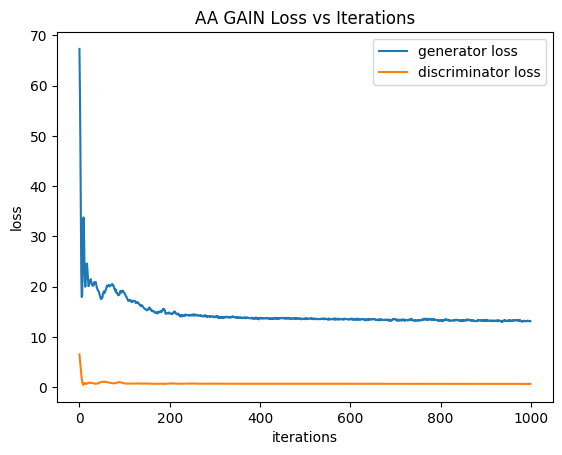

In [ ]:
plt.figure()
plt.title("AA GAIN Loss vs Iterations")
plt.plot(g_lossAA, label='generator loss')
plt.plot(d_lossAA, label = 'discriminator loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
missing_indicesAA= np.where(1-missing_maskAA)
imputed_dataAA = scalerAA.inverse_transform(generatorAA.predict(missing_dataAA))[missing_indicesAA]

missing_real_dataAA = XAA[missing_indicesAA]

11/11 [==============================] - 0s 2ms/step


In [ ]:
missing_real_dataAA.shape

(35541,)

In [ ]:
# Scaler : Standard Scaler , Generator Output : Sigmoid
maeAA = mean_absolute_error(missing_real_dataAA, imputed_dataAA)
rmseAA = np.sqrt(mean_squared_error(missing_real_dataAA, imputed_dataAA))
r2AA = r2_score(missing_real_dataAA,imputed_dataAA)
print("Evaluation\n","MAE : ",maeAA," | RMSE : ",rmseAA," | R2 : ",r2AA)

Evaluation
 MAE :  0.09816835873567313  | RMSE :  0.18090710454090925  | R2 :  0.2834440694914838


# For Total Data AA+ EUR

In [ ]:
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_scaled = scaler.transform(X)
data = X_scaled

# Define hyperparameters
input_dim = data.shape[1]
hidden_dim = 100
alpha = 10
iterations = 2000
batch_size = 400

# Create generator and discriminator
generator = create_generator(input_dim, hidden_dim)
discriminator = create_discriminator(input_dim, hidden_dim)

# Create GAN model
generator_input = Input(shape=(input_dim,))
gan = create_gan(generator, discriminator,input_dim)

# Create missing mask
missing_prob = 0.2  # Probability of missing values
missing_mask, missing_data = missing_masking(data, missing_prob)

In [ ]:
# Train GAN model
g_losstot=[]
d_losstot=[]
for iteration in tqdm(range(iterations)):
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data = data[idx]
    mask = missing_mask[idx]
    masked_data = missing_data[idx]

    generated_data = generator.predict(masked_data)

    real_data = real_data * mask + generated_data * (1 - mask)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    discriminator.trainable = True

    d_loss_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losstot.append(d_loss)

    discriminator.trainable = False

    g_loss = gan.train_on_batch([masked_data,mask], [real_data, valid])
    g_losstot.append(g_loss[0])

#     if iteration % 1000 == 0:
    print(f'Iteration: {iteration} | D Loss: {d_loss} | G Loss: {g_loss}')


  0%|          | 0/2000 [00:00<?, ?it/s]

13/13 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 1/2000 [00:01<43:51,  1.32s/it]

Iteration: 0 | D Loss: 6.38196063041687 | G Loss: [73.53404235839844, 0.11811897903680801, 6.172214508056641]
13/13 [==============================] - 0s 2ms/step


  0%|          | 2/2000 [00:01<21:26,  1.55it/s]

Iteration: 1 | D Loss: 5.968050241470337 | G Loss: [71.29905700683594, 0.11732551455497742, 5.956650257110596]
13/13 [==============================] - 0s 3ms/step


  0%|          | 3/2000 [00:01<14:39,  2.27it/s]

Iteration: 2 | D Loss: 5.6584343910217285 | G Loss: [68.78572845458984, 0.11649025231599808, 5.713670253753662]
13/13 [==============================] - 0s 1ms/step


  0%|          | 4/2000 [00:01<11:17,  2.95it/s]

Iteration: 3 | D Loss: 5.286498546600342 | G Loss: [65.95780944824219, 0.11622821539640427, 5.433498382568359]
13/13 [==============================] - 0s 2ms/step


  0%|          | 5/2000 [00:02<09:08,  3.63it/s]

Iteration: 4 | D Loss: 4.876225709915161 | G Loss: [62.59918975830078, 0.11607693880796432, 5.099149703979492]
13/13 [==============================] - 0s 2ms/step


  0%|          | 6/2000 [00:02<08:13,  4.04it/s]

Iteration: 5 | D Loss: 4.401364326477051 | G Loss: [58.73509216308594, 0.11602401733398438, 4.713269233703613]
13/13 [==============================] - 0s 1ms/step


  0%|          | 7/2000 [00:02<07:03,  4.71it/s]

Iteration: 6 | D Loss: 3.8598437309265137 | G Loss: [54.109710693359375, 0.11547589302062988, 4.25621223449707]
13/13 [==============================] - 0s 2ms/step


  0%|          | 8/2000 [00:02<06:32,  5.07it/s]

Iteration: 7 | D Loss: 3.2506048679351807 | G Loss: [48.85430145263672, 0.1158229261636734, 3.727200984954834]
13/13 [==============================] - 0s 1ms/step


  0%|          | 9/2000 [00:02<06:23,  5.20it/s]

Iteration: 8 | D Loss: 2.609743356704712 | G Loss: [43.2220573425293, 0.11679047346115112, 3.1543009281158447]
13/13 [==============================] - 0s 2ms/step


  0%|          | 10/2000 [00:02<06:14,  5.32it/s]

Iteration: 9 | D Loss: 1.9900068640708923 | G Loss: [37.5712776184082, 0.11749707907438278, 2.5821568965911865]
13/13 [==============================] - 0s 2ms/step


  1%|          | 11/2000 [00:03<06:16,  5.29it/s]

Iteration: 10 | D Loss: 1.499737411737442 | G Loss: [33.16776657104492, 0.12053122371435165, 2.111464500427246]
13/13 [==============================] - 0s 2ms/step


  1%|          | 12/2000 [00:03<06:05,  5.44it/s]

Iteration: 11 | D Loss: 1.196313202381134 | G Loss: [29.876850128173828, 0.12338481098413467, 1.753836989402771]
13/13 [==============================] - 0s 1ms/step


  1%|          | 13/2000 [00:03<05:58,  5.54it/s]

Iteration: 12 | D Loss: 1.0284550338983536 | G Loss: [27.19165802001953, 0.12648750841617584, 1.4542906284332275]
13/13 [==============================] - 0s 2ms/step


  1%|          | 14/2000 [00:03<06:01,  5.49it/s]

Iteration: 13 | D Loss: 0.9241892695426941 | G Loss: [24.632139205932617, 0.12933146953582764, 1.1698992252349854]
13/13 [==============================] - 0s 2ms/step


  1%|          | 15/2000 [00:03<06:01,  5.49it/s]

Iteration: 14 | D Loss: 0.8510481864213943 | G Loss: [22.237987518310547, 0.1304466277360916, 0.9193324446678162]
13/13 [==============================] - 0s 1ms/step


  1%|          | 16/2000 [00:03<06:10,  5.36it/s]

Iteration: 15 | D Loss: 0.8059913814067841 | G Loss: [20.465408325195312, 0.13112607598304749, 0.7352800965309143]
13/13 [==============================] - 0s 1ms/step


  1%|          | 17/2000 [00:04<06:14,  5.29it/s]

Iteration: 16 | D Loss: 0.7838140428066254 | G Loss: [19.240402221679688, 0.13001185655593872, 0.6239216327667236]
13/13 [==============================] - 0s 1ms/step


  1%|          | 18/2000 [00:04<05:54,  5.59it/s]

Iteration: 17 | D Loss: 0.7820040881633759 | G Loss: [18.60867691040039, 0.12857049703598022, 0.5751627087593079]
13/13 [==============================] - 0s 1ms/step


  1%|          | 19/2000 [00:04<05:18,  6.22it/s]

Iteration: 18 | D Loss: 0.776354968547821 | G Loss: [18.33272933959961, 0.12666364014148712, 0.5666365027427673]
13/13 [==============================] - 0s 1ms/step


  1%|          | 20/2000 [00:04<05:15,  6.27it/s]

Iteration: 19 | D Loss: 0.7586492300033569 | G Loss: [18.369384765625, 0.12407660484313965, 0.5961724519729614]
13/13 [==============================] - 0s 1ms/step


  1%|          | 21/2000 [00:04<04:55,  6.70it/s]

Iteration: 20 | D Loss: 0.7409124970436096 | G Loss: [18.588314056396484, 0.12107318639755249, 0.648099422454834]
13/13 [==============================] - 0s 1ms/step


  1%|          | 22/2000 [00:04<04:44,  6.95it/s]

Iteration: 21 | D Loss: 0.7244153022766113 | G Loss: [19.01366424560547, 0.11869318038225174, 0.7144345641136169]
13/13 [==============================] - 0s 1ms/step


  1%|          | 23/2000 [00:05<04:38,  7.11it/s]

Iteration: 22 | D Loss: 0.7223029732704163 | G Loss: [19.241378784179688, 0.11553342640399933, 0.7688035368919373]
13/13 [==============================] - 0s 2ms/step


  1%|          | 24/2000 [00:05<04:22,  7.52it/s]

Iteration: 23 | D Loss: 0.7276061177253723 | G Loss: [19.45166778564453, 0.11321647465229034, 0.8130019903182983]
13/13 [==============================] - 0s 1ms/step


  1%|▏         | 25/2000 [00:05<04:41,  7.03it/s]

Iteration: 24 | D Loss: 0.7364594340324402 | G Loss: [19.4060001373291, 0.11086880415678024, 0.8319119215011597]
13/13 [==============================] - 0s 1ms/step


  1%|▏         | 26/2000 [00:05<04:47,  6.86it/s]

Iteration: 25 | D Loss: 0.7469979822635651 | G Loss: [19.204702377319336, 0.10897599905729294, 0.830710232257843]
13/13 [==============================] - 0s 1ms/step


  1%|▏         | 27/2000 [00:05<04:41,  7.02it/s]

Iteration: 26 | D Loss: 0.7536734044551849 | G Loss: [18.820005416870117, 0.10699766129255295, 0.812023937702179]
13/13 [==============================] - 0s 1ms/step


  1%|▏         | 28/2000 [00:05<04:47,  6.86it/s]

Iteration: 27 | D Loss: 0.755390465259552 | G Loss: [18.25057029724121, 0.10421421378850937, 0.7829148769378662]
13/13 [==============================] - 0s 1ms/step


  1%|▏         | 29/2000 [00:05<04:28,  7.34it/s]

Iteration: 28 | D Loss: 0.7519205510616302 | G Loss: [17.722253799438477, 0.10194502025842667, 0.752775251865387]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 30/2000 [00:06<04:47,  6.85it/s]

Iteration: 29 | D Loss: 0.7491748034954071 | G Loss: [17.225460052490234, 0.09993948042392731, 0.7231512665748596]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 31/2000 [00:06<08:57,  3.66it/s]

Iteration: 30 | D Loss: 0.7450537979602814 | G Loss: [16.728519439697266, 0.0975554883480072, 0.6972971558570862]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 32/2000 [00:06<08:00,  4.10it/s]

Iteration: 31 | D Loss: 0.7404029071331024 | G Loss: [16.291637420654297, 0.09495529532432556, 0.6796108484268188]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 33/2000 [00:06<07:22,  4.45it/s]

Iteration: 32 | D Loss: 0.7371205985546112 | G Loss: [16.019153594970703, 0.09319684654474258, 0.6699469685554504]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 34/2000 [00:07<06:31,  5.03it/s]

Iteration: 33 | D Loss: 0.7337201535701752 | G Loss: [15.783127784729004, 0.09091115742921829, 0.6692011952400208]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 35/2000 [00:07<06:05,  5.38it/s]

Iteration: 34 | D Loss: 0.7332907617092133 | G Loss: [15.614224433898926, 0.08910646289587021, 0.6703579425811768]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 36/2000 [00:07<05:35,  5.85it/s]

Iteration: 35 | D Loss: 0.7339036464691162 | G Loss: [15.419347763061523, 0.08703722059726715, 0.671562671661377]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 37/2000 [00:07<05:32,  5.91it/s]

Iteration: 36 | D Loss: 0.7360836863517761 | G Loss: [15.43465805053711, 0.08637534826993942, 0.6797123551368713]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 38/2000 [00:07<05:33,  5.89it/s]

Iteration: 37 | D Loss: 0.7389765679836273 | G Loss: [15.4376802444458, 0.08576050400733948, 0.6861630082130432]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 39/2000 [00:07<05:20,  6.11it/s]

Iteration: 38 | D Loss: 0.7429187595844269 | G Loss: [15.317673683166504, 0.08442920446395874, 0.6874752640724182]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 40/2000 [00:07<05:09,  6.32it/s]

Iteration: 39 | D Loss: 0.7470466196537018 | G Loss: [15.328317642211914, 0.08440154790878296, 0.688816249370575]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 41/2000 [00:08<04:59,  6.55it/s]

Iteration: 40 | D Loss: 0.7497975826263428 | G Loss: [15.255890846252441, 0.08346019685268402, 0.6909871101379395]
13/13 [==============================] - 0s 2ms/step


  2%|▏         | 42/2000 [00:08<05:07,  6.36it/s]

Iteration: 41 | D Loss: 0.754466325044632 | G Loss: [15.127447128295898, 0.08252090215682983, 0.6875357627868652]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 43/2000 [00:08<05:01,  6.49it/s]

Iteration: 42 | D Loss: 0.7570610642433167 | G Loss: [15.065547943115234, 0.08245651423931122, 0.6819896697998047]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 44/2000 [00:08<05:12,  6.26it/s]

Iteration: 43 | D Loss: 0.7590590417385101 | G Loss: [14.930389404296875, 0.08147978037595749, 0.6782411336898804]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 45/2000 [00:08<04:54,  6.63it/s]

Iteration: 44 | D Loss: 0.7580441236495972 | G Loss: [14.903905868530273, 0.08147893846035004, 0.6756011843681335]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 46/2000 [00:08<05:08,  6.34it/s]

Iteration: 45 | D Loss: 0.7551230788230896 | G Loss: [14.8101806640625, 0.0805157870054245, 0.6758601665496826]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 47/2000 [00:09<05:25,  6.01it/s]

Iteration: 46 | D Loss: 0.7541496455669403 | G Loss: [14.726892471313477, 0.07984396070241928, 0.6742497086524963]
13/13 [==============================] - 0s 2ms/step


  2%|▏         | 48/2000 [00:09<05:14,  6.20it/s]

Iteration: 47 | D Loss: 0.7546510696411133 | G Loss: [14.668052673339844, 0.07942941784858704, 0.6725110411643982]
13/13 [==============================] - 0s 1ms/step


  2%|▏         | 49/2000 [00:09<05:02,  6.44it/s]

Iteration: 48 | D Loss: 0.7549629509449005 | G Loss: [14.53493881225586, 0.07821625471115112, 0.6713313460350037]
13/13 [==============================] - 0s 1ms/step


  2%|▎         | 50/2000 [00:09<05:14,  6.19it/s]

Iteration: 49 | D Loss: 0.7548346519470215 | G Loss: [14.48876667022705, 0.07786986976861954, 0.6701780557632446]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 51/2000 [00:09<05:26,  5.97it/s]

Iteration: 50 | D Loss: 0.7528153657913208 | G Loss: [14.405115127563477, 0.07701662182807922, 0.6703453063964844]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 52/2000 [00:09<05:31,  5.87it/s]

Iteration: 51 | D Loss: 0.7522825002670288 | G Loss: [14.327581405639648, 0.07651536911725998, 0.6676045060157776]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 53/2000 [00:10<05:38,  5.76it/s]

Iteration: 52 | D Loss: 0.751148909330368 | G Loss: [14.231025695800781, 0.07565905898809433, 0.6665120124816895]
13/13 [==============================] - 0s 2ms/step


  3%|▎         | 54/2000 [00:10<05:40,  5.72it/s]

Iteration: 53 | D Loss: 0.7506045699119568 | G Loss: [14.17164421081543, 0.075161874294281, 0.665545642375946]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 55/2000 [00:10<05:18,  6.10it/s]

Iteration: 54 | D Loss: 0.749448299407959 | G Loss: [14.198019027709961, 0.07525640726089478, 0.6672378778457642]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 56/2000 [00:10<05:09,  6.28it/s]

Iteration: 55 | D Loss: 0.7475475370883942 | G Loss: [14.139984130859375, 0.07467694580554962, 0.6672289967536926]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 57/2000 [00:10<05:05,  6.36it/s]

Iteration: 56 | D Loss: 0.7459595501422882 | G Loss: [14.089717864990234, 0.07425504922866821, 0.6664213538169861]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 58/2000 [00:10<04:59,  6.49it/s]

Iteration: 57 | D Loss: 0.745727151632309 | G Loss: [14.062727928161621, 0.07397658377885818, 0.6665069460868835]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 59/2000 [00:11<04:54,  6.60it/s]

Iteration: 58 | D Loss: 0.7450480461120605 | G Loss: [14.077392578125, 0.07384239882230759, 0.6693153381347656]
13/13 [==============================] - 0s 2ms/step


  3%|▎         | 60/2000 [00:11<04:50,  6.68it/s]

Iteration: 59 | D Loss: 0.7437760829925537 | G Loss: [14.126262664794922, 0.07408569753170013, 0.6717692613601685]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 61/2000 [00:11<05:09,  6.27it/s]

Iteration: 60 | D Loss: 0.7431484758853912 | G Loss: [14.138754844665527, 0.074193075299263, 0.6719447374343872]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 62/2000 [00:11<05:24,  5.97it/s]

Iteration: 61 | D Loss: 0.741716206073761 | G Loss: [14.188623428344727, 0.07439079135656357, 0.6749542951583862]
13/13 [==============================] - 0s 3ms/step


  3%|▎         | 63/2000 [00:11<05:15,  6.15it/s]

Iteration: 62 | D Loss: 0.740879476070404 | G Loss: [14.082828521728516, 0.07329525798559189, 0.6753302216529846]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 64/2000 [00:11<05:11,  6.21it/s]

Iteration: 63 | D Loss: 0.7394669950008392 | G Loss: [14.12257194519043, 0.07350707054138184, 0.6771864295005798]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 65/2000 [00:12<05:21,  6.03it/s]

Iteration: 64 | D Loss: 0.7388491332530975 | G Loss: [14.138919830322266, 0.07348372787237167, 0.6790547370910645]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 66/2000 [00:12<05:07,  6.28it/s]

Iteration: 65 | D Loss: 0.7374080121517181 | G Loss: [14.109575271606445, 0.0731169730424881, 0.6797877550125122]
13/13 [==============================] - 0s 2ms/step


  3%|▎         | 67/2000 [00:12<05:19,  6.04it/s]

Iteration: 66 | D Loss: 0.7362664341926575 | G Loss: [14.112454414367676, 0.07302691042423248, 0.6809763312339783]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 68/2000 [00:12<05:27,  5.90it/s]

Iteration: 67 | D Loss: 0.7352918684482574 | G Loss: [14.143549919128418, 0.07312814891338348, 0.6830735206604004]
13/13 [==============================] - 0s 1ms/step


  3%|▎         | 69/2000 [00:12<05:31,  5.82it/s]

Iteration: 68 | D Loss: 0.7339526414871216 | G Loss: [14.136670112609863, 0.07303276658058167, 0.6833393573760986]
13/13 [==============================] - 0s 1ms/step


  4%|▎         | 70/2000 [00:12<05:15,  6.12it/s]

Iteration: 69 | D Loss: 0.7327492833137512 | G Loss: [14.070091247558594, 0.07237016409635544, 0.6833074688911438]
13/13 [==============================] - 0s 1ms/step


  4%|▎         | 71/2000 [00:13<05:24,  5.94it/s]

Iteration: 70 | D Loss: 0.7309119999408722 | G Loss: [14.026261329650879, 0.07181936502456665, 0.6844325065612793]
13/13 [==============================] - 0s 1ms/step


  4%|▎         | 72/2000 [00:13<05:22,  5.98it/s]

Iteration: 71 | D Loss: 0.7300402522087097 | G Loss: [14.045332908630371, 0.07183630019426346, 0.6861702799797058]
13/13 [==============================] - 0s 1ms/step


  4%|▎         | 73/2000 [00:13<05:34,  5.76it/s]

Iteration: 72 | D Loss: 0.7290051877498627 | G Loss: [14.065673828125, 0.07191289216279984, 0.6874384880065918]
13/13 [==============================] - 0s 1ms/step


  4%|▎         | 74/2000 [00:13<05:14,  6.11it/s]

Iteration: 73 | D Loss: 0.7283921241760254 | G Loss: [14.004782676696777, 0.07144688069820404, 0.6860094666481018]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 75/2000 [00:13<05:22,  5.97it/s]

Iteration: 74 | D Loss: 0.7267156541347504 | G Loss: [13.967748641967773, 0.0710250735282898, 0.6865241527557373]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 76/2000 [00:13<05:08,  6.23it/s]

Iteration: 75 | D Loss: 0.7261881530284882 | G Loss: [14.036155700683594, 0.07158619165420532, 0.6877536177635193]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 77/2000 [00:13<05:02,  6.36it/s]

Iteration: 76 | D Loss: 0.7246527075767517 | G Loss: [13.922087669372559, 0.07038633525371552, 0.6883454322814941]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 78/2000 [00:14<05:28,  5.86it/s]

Iteration: 77 | D Loss: 0.7242470383644104 | G Loss: [13.960746765136719, 0.07073359191417694, 0.6887387037277222]
13/13 [==============================] - 0s 2ms/step
Iteration: 78 | D Loss: 0.7233363091945648 | G Loss: [13.92396354675293, 0.07038009911775589, 0.6885954141616821]

  4%|▍         | 79/2000 [00:14<05:45,  5.56it/s]


13/13 [==============================] - 0s 2ms/step


  4%|▍         | 80/2000 [00:14<06:01,  5.30it/s]

Iteration: 79 | D Loss: 0.7226003408432007 | G Loss: [13.967506408691406, 0.07075440138578415, 0.6892067193984985]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 81/2000 [00:14<06:08,  5.21it/s]

Iteration: 80 | D Loss: 0.7214864492416382 | G Loss: [13.906401634216309, 0.070148766040802, 0.6891525387763977]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 82/2000 [00:15<06:10,  5.17it/s]

Iteration: 81 | D Loss: 0.7213201820850372 | G Loss: [13.89797592163086, 0.07005958259105682, 0.689201831817627]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 83/2000 [00:15<06:16,  5.09it/s]

Iteration: 82 | D Loss: 0.7207414209842682 | G Loss: [13.874431610107422, 0.06981123238801956, 0.6893307566642761]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 84/2000 [00:15<06:23,  4.99it/s]

Iteration: 83 | D Loss: 0.7200808227062225 | G Loss: [13.873294830322266, 0.06963957101106644, 0.6909337639808655]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 85/2000 [00:15<06:03,  5.27it/s]

Iteration: 84 | D Loss: 0.7193588614463806 | G Loss: [13.899028778076172, 0.06986923515796661, 0.6912105083465576]
13/13 [==============================] - 0s 3ms/step


  4%|▍         | 86/2000 [00:15<06:10,  5.16it/s]

Iteration: 85 | D Loss: 0.7183792591094971 | G Loss: [13.809054374694824, 0.0689159408211708, 0.691745936870575]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 87/2000 [00:15<06:08,  5.19it/s]

Iteration: 86 | D Loss: 0.7180381715297699 | G Loss: [13.842962265014648, 0.06924953311681747, 0.6918008923530579]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 88/2000 [00:16<06:23,  4.99it/s]

Iteration: 87 | D Loss: 0.7176786065101624 | G Loss: [13.767414093017578, 0.06842882931232452, 0.6924530863761902]
13/13 [==============================] - 0s 1ms/step


  4%|▍         | 89/2000 [00:16<06:51,  4.64it/s]

Iteration: 88 | D Loss: 0.7172791659832001 | G Loss: [13.791025161743164, 0.06856575608253479, 0.6934449672698975]
13/13 [==============================] - 0s 2ms/step


  4%|▍         | 90/2000 [00:16<07:05,  4.49it/s]

Iteration: 89 | D Loss: 0.7164859771728516 | G Loss: [13.840672492980957, 0.0689750388264656, 0.6943168640136719]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 91/2000 [00:16<06:21,  5.00it/s]

Iteration: 90 | D Loss: 0.71631720662117 | G Loss: [13.829739570617676, 0.06890717148780823, 0.6939022541046143]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 92/2000 [00:17<06:13,  5.11it/s]

Iteration: 91 | D Loss: 0.7159609794616699 | G Loss: [13.749397277832031, 0.06818082928657532, 0.6931313872337341]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 93/2000 [00:17<06:02,  5.27it/s]

Iteration: 92 | D Loss: 0.7154885530471802 | G Loss: [13.858253479003906, 0.06914743781089783, 0.6943508982658386]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 94/2000 [00:17<05:56,  5.34it/s]

Iteration: 93 | D Loss: 0.7152886986732483 | G Loss: [13.809886932373047, 0.06879746913909912, 0.6930139064788818]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 95/2000 [00:17<05:37,  5.64it/s]

Iteration: 94 | D Loss: 0.7149349749088287 | G Loss: [13.765838623046875, 0.06833341717720032, 0.6932496428489685]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 96/2000 [00:17<05:16,  6.01it/s]

Iteration: 95 | D Loss: 0.7144412398338318 | G Loss: [13.799363136291504, 0.06859101355075836, 0.6940261721611023]
13/13 [==============================] - 0s 2ms/step


  5%|▍         | 97/2000 [00:17<05:28,  5.80it/s]

Iteration: 96 | D Loss: 0.7143233716487885 | G Loss: [13.778129577636719, 0.06841428577899933, 0.6936700344085693]
13/13 [==============================] - 0s 2ms/step


  5%|▍         | 98/2000 [00:18<05:22,  5.90it/s]

Iteration: 97 | D Loss: 0.7135667204856873 | G Loss: [13.824014663696289, 0.06889424473047256, 0.6934590339660645]
13/13 [==============================] - 0s 1ms/step


  5%|▍         | 99/2000 [00:18<05:25,  5.84it/s]

Iteration: 98 | D Loss: 0.7133856415748596 | G Loss: [13.779587745666504, 0.06831201910972595, 0.6948385834693909]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 100/2000 [00:18<05:28,  5.78it/s]

Iteration: 99 | D Loss: 0.71310755610466 | G Loss: [13.756307601928711, 0.06811346113681793, 0.6944961547851562]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 101/2000 [00:18<05:09,  6.13it/s]

Iteration: 100 | D Loss: 0.7126695215702057 | G Loss: [13.77299690246582, 0.06822255998849869, 0.6950741410255432]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 102/2000 [00:18<05:09,  6.12it/s]

Iteration: 101 | D Loss: 0.7124592959880829 | G Loss: [13.833481788635254, 0.06870920211076736, 0.6962560415267944]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 103/2000 [00:18<04:51,  6.51it/s]

Iteration: 102 | D Loss: 0.7121825516223907 | G Loss: [13.767011642456055, 0.06804309785366058, 0.6962701678276062]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 104/2000 [00:18<05:02,  6.28it/s]

Iteration: 103 | D Loss: 0.7119967639446259 | G Loss: [13.732863426208496, 0.06774095445871353, 0.6958767771720886]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 105/2000 [00:19<04:48,  6.57it/s]

Iteration: 104 | D Loss: 0.7115662097930908 | G Loss: [13.727356910705566, 0.06770253926515579, 0.695710301399231]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 106/2000 [00:19<04:50,  6.52it/s]

Iteration: 105 | D Loss: 0.7114905416965485 | G Loss: [13.739169120788574, 0.06779855489730835, 0.6959312558174133]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 107/2000 [00:19<04:51,  6.49it/s]

Iteration: 106 | D Loss: 0.7113202512264252 | G Loss: [13.717138290405273, 0.06762354075908661, 0.6954783797264099]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 108/2000 [00:19<04:40,  6.74it/s]

Iteration: 107 | D Loss: 0.7109597325325012 | G Loss: [13.758262634277344, 0.06786367297172546, 0.6971895098686218]
13/13 [==============================] - 0s 1ms/step


  5%|▌         | 109/2000 [00:19<04:36,  6.83it/s]

Iteration: 108 | D Loss: 0.7108869552612305 | G Loss: [13.751429557800293, 0.06772130727767944, 0.697929859161377]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 110/2000 [00:19<04:32,  6.93it/s]

Iteration: 109 | D Loss: 0.7105306088924408 | G Loss: [13.746268272399902, 0.06765463948249817, 0.6980804204940796]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 111/2000 [00:20<05:02,  6.24it/s]

Iteration: 110 | D Loss: 0.7105442881584167 | G Loss: [13.743377685546875, 0.06759659945964813, 0.6983718276023865]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 112/2000 [00:20<04:44,  6.64it/s]

Iteration: 111 | D Loss: 0.710690826177597 | G Loss: [13.72215461730957, 0.06728639453649521, 0.6993514895439148]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 113/2000 [00:20<04:51,  6.48it/s]

Iteration: 112 | D Loss: 0.7109565734863281 | G Loss: [13.705926895141602, 0.06715009361505508, 0.6990916728973389]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 114/2000 [00:20<04:42,  6.69it/s]

Iteration: 113 | D Loss: 0.710886538028717 | G Loss: [13.694311141967773, 0.06716877222061157, 0.6977433562278748]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 115/2000 [00:20<04:29,  7.00it/s]

Iteration: 114 | D Loss: 0.7112982273101807 | G Loss: [13.669533729553223, 0.06699814647436142, 0.6969718933105469]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 116/2000 [00:20<04:43,  6.64it/s]

Iteration: 115 | D Loss: 0.7115844786167145 | G Loss: [13.71277141571045, 0.06741414219141006, 0.6971356272697449]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 117/2000 [00:20<04:45,  6.60it/s]

Iteration: 116 | D Loss: 0.7115792334079742 | G Loss: [13.704687118530273, 0.06729736924171448, 0.6974951028823853]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 118/2000 [00:21<04:53,  6.41it/s]

Iteration: 117 | D Loss: 0.7118753790855408 | G Loss: [13.74462890625, 0.06774364411830902, 0.6970264911651611]
13/13 [==============================] - 0s 2ms/step


  6%|▌         | 119/2000 [00:21<05:03,  6.21it/s]

Iteration: 118 | D Loss: 0.7121916711330414 | G Loss: [13.72436809539795, 0.06755182892084122, 0.6969184875488281]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 120/2000 [00:21<05:03,  6.19it/s]

Iteration: 119 | D Loss: 0.7116841971874237 | G Loss: [13.760348320007324, 0.06780314445495605, 0.6980034112930298]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 121/2000 [00:21<04:41,  6.67it/s]

Iteration: 120 | D Loss: 0.7115277051925659 | G Loss: [13.714430809020996, 0.06743527948856354, 0.6970904469490051]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 122/2000 [00:21<04:45,  6.58it/s]

Iteration: 121 | D Loss: 0.7096011936664581 | G Loss: [13.722259521484375, 0.06762723624706268, 0.6959535479545593]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 123/2000 [00:21<04:34,  6.84it/s]

Iteration: 122 | D Loss: 0.7083790600299835 | G Loss: [13.658773422241211, 0.06774748116731644, 0.6884024739265442]
13/13 [==============================] - 0s 1ms/step


  6%|▌         | 124/2000 [00:21<04:21,  7.17it/s]

Iteration: 123 | D Loss: 0.7092930674552917 | G Loss: [13.5132417678833, 0.06714490056037903, 0.6798752546310425]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 125/2000 [00:22<04:24,  7.09it/s]

Iteration: 124 | D Loss: 0.7108320593833923 | G Loss: [13.508247375488281, 0.06780926138162613, 0.6727321743965149]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 126/2000 [00:22<04:12,  7.42it/s]

Iteration: 125 | D Loss: 0.7134934663772583 | G Loss: [13.539133071899414, 0.06835000962018967, 0.6704131960868835]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 127/2000 [00:22<04:24,  7.08it/s]

Iteration: 126 | D Loss: 0.7158994674682617 | G Loss: [13.550768852233887, 0.06861792504787445, 0.6688976287841797]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 128/2000 [00:22<04:14,  7.35it/s]

Iteration: 127 | D Loss: 0.7176297307014465 | G Loss: [13.61178207397461, 0.06875564157962799, 0.6736217737197876]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 129/2000 [00:22<04:27,  7.00it/s]

Iteration: 128 | D Loss: 0.7198242545127869 | G Loss: [13.743699073791504, 0.06941796094179153, 0.6801901459693909]
13/13 [==============================] - 0s 1ms/step


  6%|▋         | 130/2000 [00:22<04:39,  6.70it/s]

Iteration: 129 | D Loss: 0.7211892306804657 | G Loss: [13.905567169189453, 0.0702207088470459, 0.6883496046066284]
13/13 [==============================] - 0s 2ms/step


  7%|▋         | 131/2000 [00:22<04:27,  6.98it/s]

Iteration: 130 | D Loss: 0.7227591276168823 | G Loss: [13.9520263671875, 0.06991502642631531, 0.6960523128509521]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 132/2000 [00:23<04:13,  7.37it/s]

Iteration: 131 | D Loss: 0.7242107689380646 | G Loss: [14.050009727478027, 0.07024016231298447, 0.7025993466377258]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 133/2000 [00:23<04:28,  6.96it/s]

Iteration: 132 | D Loss: 0.7251904606819153 | G Loss: [14.0415620803833, 0.06963843107223511, 0.707771897315979]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 134/2000 [00:23<04:44,  6.55it/s]

Iteration: 133 | D Loss: 0.7253562808036804 | G Loss: [14.052746772766113, 0.06928451359272003, 0.7124295234680176]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 135/2000 [00:23<04:30,  6.90it/s]

Iteration: 134 | D Loss: 0.7256843149662018 | G Loss: [14.03283405303955, 0.06905931979417801, 0.7126903533935547]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 136/2000 [00:23<04:18,  7.21it/s]

Iteration: 135 | D Loss: 0.7251493036746979 | G Loss: [13.993391036987305, 0.06874428689479828, 0.7118961811065674]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 137/2000 [00:23<04:30,  6.89it/s]

Iteration: 136 | D Loss: 0.7236100435256958 | G Loss: [13.869747161865234, 0.06778394430875778, 0.7091352939605713]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 138/2000 [00:23<04:44,  6.55it/s]

Iteration: 137 | D Loss: 0.722496509552002 | G Loss: [13.856258392333984, 0.06787654757499695, 0.706860363483429]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 139/2000 [00:24<04:35,  6.76it/s]

Iteration: 138 | D Loss: 0.7203758955001831 | G Loss: [13.741003036499023, 0.06711333990097046, 0.7029669284820557]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 140/2000 [00:24<04:38,  6.68it/s]

Iteration: 139 | D Loss: 0.7183191478252411 | G Loss: [13.682608604431152, 0.0669139176607132, 0.6991216540336609]
13/13 [==============================] - 0s 2ms/step


  7%|▋         | 141/2000 [00:24<04:27,  6.95it/s]

Iteration: 140 | D Loss: 0.7164734899997711 | G Loss: [13.621747970581055, 0.066657155752182, 0.6956031918525696]
13/13 [==============================] - 0s 1ms/step
Iteration: 141 | D Loss: 0.7145048677921295 | G Loss: [13.579000473022461, 0.06650625914335251, 0.6928375363349915]

  7%|▋         | 142/2000 [00:24<04:19,  7.15it/s]


13/13 [==============================] - 0s 2ms/step


  7%|▋         | 143/2000 [00:24<04:38,  6.66it/s]

Iteration: 142 | D Loss: 0.712539941072464 | G Loss: [13.576618194580078, 0.06657473742961884, 0.6919144988059998]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 144/2000 [00:24<04:29,  6.88it/s]

Iteration: 143 | D Loss: 0.7108518481254578 | G Loss: [13.55912971496582, 0.06653156876564026, 0.6905972361564636]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 145/2000 [00:25<04:40,  6.62it/s]

Iteration: 144 | D Loss: 0.7094592154026031 | G Loss: [13.528653144836426, 0.06620096415281296, 0.6908557415008545]
13/13 [==============================] - 0s 2ms/step


  7%|▋         | 146/2000 [00:25<04:29,  6.87it/s]

Iteration: 145 | D Loss: 0.7080296277999878 | G Loss: [13.510318756103516, 0.06593059003353119, 0.6917259097099304]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 147/2000 [00:25<04:41,  6.58it/s]

Iteration: 146 | D Loss: 0.7074628174304962 | G Loss: [13.516860008239746, 0.06587964296340942, 0.6928896307945251]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 148/2000 [00:25<04:27,  6.93it/s]

Iteration: 147 | D Loss: 0.7066155970096588 | G Loss: [13.612187385559082, 0.06656394153833389, 0.6955793499946594]
13/13 [==============================] - 0s 1ms/step


  7%|▋         | 149/2000 [00:25<04:34,  6.75it/s]

Iteration: 148 | D Loss: 0.7061135470867157 | G Loss: [13.662300109863281, 0.066758893430233, 0.6986410617828369]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 150/2000 [00:25<04:17,  7.18it/s]

Iteration: 149 | D Loss: 0.7055834531784058 | G Loss: [13.651615142822266, 0.06640008091926575, 0.7011606693267822]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 151/2000 [00:25<04:05,  7.52it/s]

Iteration: 150 | D Loss: 0.7052265107631683 | G Loss: [13.672113418579102, 0.06635713577270508, 0.7036400437355042]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 152/2000 [00:25<04:07,  7.46it/s]

Iteration: 151 | D Loss: 0.7049848437309265 | G Loss: [13.679476737976074, 0.06626155227422714, 0.7053320407867432]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 153/2000 [00:26<04:22,  7.05it/s]

Iteration: 152 | D Loss: 0.7049547731876373 | G Loss: [13.647762298583984, 0.06575065851211548, 0.7072696089744568]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 154/2000 [00:26<04:40,  6.58it/s]

Iteration: 153 | D Loss: 0.7049482464790344 | G Loss: [13.725061416625977, 0.06639298796653748, 0.7085761427879333]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 155/2000 [00:26<04:22,  7.04it/s]

Iteration: 154 | D Loss: 0.7050647735595703 | G Loss: [13.680017471313477, 0.06593965739011765, 0.708605170249939]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 156/2000 [00:26<04:26,  6.91it/s]

Iteration: 155 | D Loss: 0.7052956819534302 | G Loss: [13.6403169631958, 0.06553025543689728, 0.7087291479110718]
13/13 [==============================] - 0s 1ms/step


  8%|▊         | 157/2000 [00:26<04:12,  7.31it/s]

Iteration: 156 | D Loss: 0.7053704857826233 | G Loss: [13.639862060546875, 0.06561014801263809, 0.7078847289085388]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 158/2000 [00:26<04:39,  6.60it/s]

Iteration: 157 | D Loss: 0.7054541409015656 | G Loss: [13.625962257385254, 0.06557194888591766, 0.7068766951560974]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 159/2000 [00:27<05:20,  5.75it/s]

Iteration: 158 | D Loss: 0.7057648003101349 | G Loss: [13.569026947021484, 0.06520134955644608, 0.7048892378807068]
13/13 [==============================] - 0s 3ms/step


  8%|▊         | 160/2000 [00:27<07:36,  4.03it/s]

Iteration: 159 | D Loss: 0.7060512602329254 | G Loss: [13.553003311157227, 0.06518696993589401, 0.703430712223053]
13/13 [==============================] - 0s 6ms/step


  8%|▊         | 161/2000 [00:27<08:59,  3.41it/s]

Iteration: 160 | D Loss: 0.7059403657913208 | G Loss: [13.510921478271484, 0.06488797068595886, 0.702212393283844]
13/13 [==============================] - 0s 3ms/step


  8%|▊         | 162/2000 [00:28<09:54,  3.09it/s]

Iteration: 161 | D Loss: 0.7056861817836761 | G Loss: [13.512414932250977, 0.0650213360786438, 0.7010281085968018]
13/13 [==============================] - 0s 10ms/step


  8%|▊         | 163/2000 [00:29<14:51,  2.06it/s]

Iteration: 162 | D Loss: 0.7055577039718628 | G Loss: [13.508312225341797, 0.06498590111732483, 0.7009721398353577]
13/13 [==============================] - 0s 4ms/step


  8%|▊         | 164/2000 [00:29<14:33,  2.10it/s]

Iteration: 163 | D Loss: 0.7054214477539062 | G Loss: [13.546247482299805, 0.06542811542749405, 0.7003436088562012]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 165/2000 [00:29<12:51,  2.38it/s]

Iteration: 164 | D Loss: 0.7053351402282715 | G Loss: [13.576083183288574, 0.06571673601865768, 0.7004408240318298]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 166/2000 [00:30<11:42,  2.61it/s]

Iteration: 165 | D Loss: 0.7049843370914459 | G Loss: [13.529685974121094, 0.06525517255067825, 0.7004168629646301]
13/13 [==============================] - 0s 2ms/step


  8%|▊         | 167/2000 [00:30<10:31,  2.90it/s]

Iteration: 166 | D Loss: 0.7049228847026825 | G Loss: [13.551684379577637, 0.06542553752660751, 0.7009130716323853]
13/13 [==============================] - 0s 3ms/step


  8%|▊         | 168/2000 [00:30<09:28,  3.22it/s]

Iteration: 167 | D Loss: 0.7048407793045044 | G Loss: [13.598485946655273, 0.06575720757246017, 0.7022764682769775]
13/13 [==============================] - 0s 3ms/step


  8%|▊         | 169/2000 [00:31<10:09,  3.00it/s]

Iteration: 168 | D Loss: 0.7045437693595886 | G Loss: [13.578424453735352, 0.06552722305059433, 0.7025701999664307]
13/13 [==============================] - 0s 3ms/step


  8%|▊         | 170/2000 [00:31<09:27,  3.23it/s]

Iteration: 169 | D Loss: 0.7044693827629089 | G Loss: [13.556539535522461, 0.06520611047744751, 0.703592836856842]
13/13 [==============================] - 0s 2ms/step


  9%|▊         | 171/2000 [00:31<09:42,  3.14it/s]

Iteration: 170 | D Loss: 0.7045071125030518 | G Loss: [13.625162124633789, 0.06576958298683167, 0.7048203945159912]
13/13 [==============================] - 0s 2ms/step


  9%|▊         | 172/2000 [00:31<08:45,  3.48it/s]

Iteration: 171 | D Loss: 0.7043432593345642 | G Loss: [13.522494316101074, 0.06470929831266403, 0.7051563858985901]
13/13 [==============================] - 0s 3ms/step


  9%|▊         | 173/2000 [00:32<08:26,  3.61it/s]

Iteration: 172 | D Loss: 0.7044266164302826 | G Loss: [13.554149627685547, 0.0649394541978836, 0.7060204148292542]
13/13 [==============================] - 0s 2ms/step


  9%|▊         | 174/2000 [00:32<08:28,  3.59it/s]

Iteration: 173 | D Loss: 0.7044458985328674 | G Loss: [13.50915241241455, 0.06448661535978317, 0.7060492038726807]
13/13 [==============================] - 0s 3ms/step


  9%|▉         | 175/2000 [00:32<08:35,  3.54it/s]

Iteration: 174 | D Loss: 0.7044078707695007 | G Loss: [13.517467498779297, 0.06458435952663422, 0.7059031128883362]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 176/2000 [00:32<08:05,  3.76it/s]

Iteration: 175 | D Loss: 0.704399585723877 | G Loss: [13.573661804199219, 0.0651412308216095, 0.70595383644104]
13/13 [==============================] - 0s 4ms/step


  9%|▉         | 177/2000 [00:33<07:55,  3.84it/s]

Iteration: 176 | D Loss: 0.704261064529419 | G Loss: [13.489758491516113, 0.06436426192522049, 0.7053332328796387]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 178/2000 [00:33<08:01,  3.79it/s]

Iteration: 177 | D Loss: 0.7042625546455383 | G Loss: [13.45805549621582, 0.06407901644706726, 0.7050153613090515]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 179/2000 [00:33<08:20,  3.64it/s]

Iteration: 178 | D Loss: 0.7042331099510193 | G Loss: [13.49055290222168, 0.06447585672140121, 0.7042967081069946]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 180/2000 [00:34<08:14,  3.68it/s]

Iteration: 179 | D Loss: 0.7040639519691467 | G Loss: [13.452942848205566, 0.06420409679412842, 0.7032533288002014]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 181/2000 [00:34<08:52,  3.42it/s]

Iteration: 180 | D Loss: 0.7041136026382446 | G Loss: [13.422231674194336, 0.06395449489355087, 0.7026782035827637]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 182/2000 [00:34<08:40,  3.49it/s]

Iteration: 181 | D Loss: 0.7040091156959534 | G Loss: [13.4146146774292, 0.06386759877204895, 0.7027854919433594]
13/13 [==============================] - 0s 2ms/step


  9%|▉         | 183/2000 [00:35<09:14,  3.28it/s]

Iteration: 182 | D Loss: 0.7037786841392517 | G Loss: [13.456644058227539, 0.06431040167808533, 0.7025603652000427]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 184/2000 [00:35<07:58,  3.80it/s]

Iteration: 183 | D Loss: 0.7037934362888336 | G Loss: [13.47445297241211, 0.06451039016246796, 0.7023413777351379]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 185/2000 [00:35<06:46,  4.46it/s]

Iteration: 184 | D Loss: 0.7036328315734863 | G Loss: [13.422598838806152, 0.06397754698991776, 0.7024844288825989]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 186/2000 [00:35<05:55,  5.11it/s]

Iteration: 185 | D Loss: 0.7036058306694031 | G Loss: [13.470569610595703, 0.06436749547719955, 0.7033819556236267]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 187/2000 [00:35<05:22,  5.61it/s]

Iteration: 186 | D Loss: 0.7036271691322327 | G Loss: [13.497769355773926, 0.06465790420770645, 0.7031980752944946]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 188/2000 [00:35<04:59,  6.06it/s]

Iteration: 187 | D Loss: 0.7035408914089203 | G Loss: [13.445311546325684, 0.0641389861702919, 0.7031413316726685]
13/13 [==============================] - 0s 1ms/step


  9%|▉         | 189/2000 [00:35<04:42,  6.41it/s]

Iteration: 188 | D Loss: 0.7035353183746338 | G Loss: [13.461221694946289, 0.06427519768476486, 0.7033701539039612]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 190/2000 [00:35<04:38,  6.50it/s]

Iteration: 189 | D Loss: 0.703539103269577 | G Loss: [13.449272155761719, 0.06408894807100296, 0.7040377855300903]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 191/2000 [00:36<04:47,  6.30it/s]

Iteration: 190 | D Loss: 0.7034567892551422 | G Loss: [13.5039701461792, 0.06459038704633713, 0.7044931650161743]
13/13 [==============================] - 0s 2ms/step


 10%|▉         | 192/2000 [00:36<04:54,  6.15it/s]

Iteration: 191 | D Loss: 0.7033515572547913 | G Loss: [13.467763900756836, 0.06426800787448883, 0.7040963172912598]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 193/2000 [00:36<04:50,  6.22it/s]

Iteration: 192 | D Loss: 0.7031395435333252 | G Loss: [13.475503921508789, 0.06427884101867676, 0.7047619819641113]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 194/2000 [00:36<04:32,  6.64it/s]

Iteration: 193 | D Loss: 0.7032453417778015 | G Loss: [13.399616241455078, 0.06355298310518265, 0.7044317722320557]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 195/2000 [00:36<04:15,  7.07it/s]

Iteration: 194 | D Loss: 0.7032769024372101 | G Loss: [13.481131553649902, 0.06427735090255737, 0.7053396105766296]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 196/2000 [00:36<04:16,  7.04it/s]

Iteration: 195 | D Loss: 0.7031831443309784 | G Loss: [13.4798583984375, 0.0643063634634018, 0.7049222588539124]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 197/2000 [00:37<04:11,  7.18it/s]

Iteration: 196 | D Loss: 0.703175812959671 | G Loss: [13.402663230895996, 0.06359277665615082, 0.704338550567627]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 198/2000 [00:37<04:02,  7.42it/s]

Iteration: 197 | D Loss: 0.7031793594360352 | G Loss: [13.453007698059082, 0.06411191076040268, 0.7041816711425781]
13/13 [==============================] - 0s 1ms/step


 10%|▉         | 199/2000 [00:37<04:19,  6.94it/s]

Iteration: 198 | D Loss: 0.7030960619449615 | G Loss: [13.438040733337402, 0.06394936889410019, 0.7043103575706482]
13/13 [==============================] - 0s 1ms/step


 10%|█         | 200/2000 [00:37<04:09,  7.21it/s]

Iteration: 199 | D Loss: 0.703114926815033 | G Loss: [13.441967010498047, 0.06407530605792999, 0.7034435272216797]
13/13 [==============================] - 0s 1ms/step


 10%|█         | 201/2000 [00:37<03:55,  7.64it/s]

Iteration: 200 | D Loss: 0.7029188275337219 | G Loss: [13.380215644836426, 0.06345659494400024, 0.7034557461738586]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 202/2000 [00:37<03:59,  7.51it/s]

Iteration: 201 | D Loss: 0.7028567790985107 | G Loss: [13.423885345458984, 0.06389137357473373, 0.703474760055542]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 203/2000 [00:37<04:10,  7.18it/s]

Iteration: 202 | D Loss: 0.7028255462646484 | G Loss: [13.464454650878906, 0.06425941735506058, 0.7038512229919434]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 204/2000 [00:38<04:26,  6.74it/s]

Iteration: 203 | D Loss: 0.7029014527797699 | G Loss: [13.498834609985352, 0.06460315734148026, 0.7038519382476807]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 205/2000 [00:38<04:20,  6.88it/s]

Iteration: 204 | D Loss: 0.7028396129608154 | G Loss: [13.405994415283203, 0.06370366364717484, 0.70356285572052]
13/13 [==============================] - 0s 1ms/step


 10%|█         | 206/2000 [00:38<04:11,  7.13it/s]

Iteration: 205 | D Loss: 0.702828973531723 | G Loss: [13.43089485168457, 0.06396839022636414, 0.7034056186676025]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 207/2000 [00:38<04:08,  7.23it/s]

Iteration: 206 | D Loss: 0.7027413547039032 | G Loss: [13.44920539855957, 0.06412112712860107, 0.7037092447280884]
13/13 [==============================] - 0s 1ms/step


 10%|█         | 208/2000 [00:38<04:19,  6.89it/s]

Iteration: 207 | D Loss: 0.7025858759880066 | G Loss: [13.481134414672852, 0.06442628055810928, 0.7038506865501404]
13/13 [==============================] - 0s 1ms/step


 10%|█         | 209/2000 [00:38<04:12,  7.10it/s]

Iteration: 208 | D Loss: 0.7025182843208313 | G Loss: [13.410345077514648, 0.06367683410644531, 0.7042661905288696]
13/13 [==============================] - 0s 2ms/step


 10%|█         | 210/2000 [00:38<04:19,  6.90it/s]

Iteration: 209 | D Loss: 0.7023468017578125 | G Loss: [13.407524108886719, 0.06360826641321182, 0.7046697735786438]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 211/2000 [00:38<04:15,  7.00it/s]

Iteration: 210 | D Loss: 0.7023435831069946 | G Loss: [13.431110382080078, 0.0638023167848587, 0.7050878405570984]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 212/2000 [00:39<04:25,  6.75it/s]

Iteration: 211 | D Loss: 0.702330470085144 | G Loss: [13.464510917663574, 0.0641559585928917, 0.7048914432525635]
13/13 [==============================] - 0s 2ms/step


 11%|█         | 213/2000 [00:39<04:38,  6.42it/s]

Iteration: 212 | D Loss: 0.7024425268173218 | G Loss: [13.391550064086914, 0.06345575302839279, 0.704597532749176]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 214/2000 [00:39<04:22,  6.80it/s]

Iteration: 213 | D Loss: 0.7023760974407196 | G Loss: [13.393878936767578, 0.06347458809614182, 0.704642117023468]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 215/2000 [00:39<04:07,  7.21it/s]

Iteration: 214 | D Loss: 0.7025161385536194 | G Loss: [13.40127944946289, 0.06357596069574356, 0.7043682932853699]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 216/2000 [00:39<04:18,  6.90it/s]

Iteration: 215 | D Loss: 0.7023148238658905 | G Loss: [13.398908615112305, 0.06355880945920944, 0.7043028473854065]
13/13 [==============================] - 0s 2ms/step


 11%|█         | 217/2000 [00:39<04:35,  6.47it/s]

Iteration: 216 | D Loss: 0.7024085521697998 | G Loss: [13.353438377380371, 0.06316474080085754, 0.7036964297294617]
13/13 [==============================] - 0s 2ms/step


 11%|█         | 218/2000 [00:40<04:57,  6.00it/s]

Iteration: 217 | D Loss: 0.702325701713562 | G Loss: [13.323391914367676, 0.06285634636878967, 0.7037757635116577]
13/13 [==============================] - 0s 3ms/step


 11%|█         | 219/2000 [00:40<05:12,  5.70it/s]

Iteration: 218 | D Loss: 0.7022693455219269 | G Loss: [13.406964302062988, 0.06369274854660034, 0.7037689089775085]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 220/2000 [00:40<05:21,  5.54it/s]

Iteration: 219 | D Loss: 0.7022903263568878 | G Loss: [13.401355743408203, 0.0636359378695488, 0.7037762403488159]
13/13 [==============================] - 0s 2ms/step


 11%|█         | 221/2000 [00:40<05:10,  5.72it/s]

Iteration: 220 | D Loss: 0.7023502290248871 | G Loss: [13.343205451965332, 0.06309707462787628, 0.703349769115448]
13/13 [==============================] - 0s 2ms/step


 11%|█         | 222/2000 [00:40<05:02,  5.87it/s]

Iteration: 221 | D Loss: 0.7021974623203278 | G Loss: [13.402839660644531, 0.06368377804756165, 0.7034461498260498]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 223/2000 [00:40<05:11,  5.70it/s]

Iteration: 222 | D Loss: 0.7021996378898621 | G Loss: [13.426258087158203, 0.0638984888792038, 0.703640878200531]
13/13 [==============================] - 0s 1ms/step


 11%|█         | 224/2000 [00:41<05:19,  5.56it/s]

Iteration: 223 | D Loss: 0.7020618319511414 | G Loss: [13.449529647827148, 0.06412322074174881, 0.7037208676338196]
13/13 [==============================] - 0s 2ms/step


 11%|█▏        | 225/2000 [00:41<05:16,  5.61it/s]

Iteration: 224 | D Loss: 0.702016144990921 | G Loss: [13.37158203125, 0.06332694739103317, 0.7038887143135071]
13/13 [==============================] - 0s 2ms/step


 11%|█▏        | 226/2000 [00:41<05:20,  5.53it/s]

Iteration: 225 | D Loss: 0.7020701169967651 | G Loss: [13.361532211303711, 0.0632452741265297, 0.7037005424499512]
13/13 [==============================] - 0s 2ms/step


 11%|█▏        | 227/2000 [00:41<05:10,  5.72it/s]

Iteration: 226 | D Loss: 0.7020620107650757 | G Loss: [13.409929275512695, 0.0637306421995163, 0.7036864757537842]
13/13 [==============================] - 0s 2ms/step


 11%|█▏        | 228/2000 [00:41<05:13,  5.65it/s]

Iteration: 227 | D Loss: 0.70203498005867 | G Loss: [13.369195938110352, 0.06333145499229431, 0.7036049365997314]
13/13 [==============================] - 0s 2ms/step


 11%|█▏        | 229/2000 [00:42<05:20,  5.52it/s]

Iteration: 228 | D Loss: 0.7019113302230835 | G Loss: [13.353069305419922, 0.06315307319164276, 0.7037761211395264]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 230/2000 [00:42<05:12,  5.67it/s]

Iteration: 229 | D Loss: 0.7019305527210236 | G Loss: [13.3905611038208, 0.06350108981132507, 0.7040451765060425]
13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 231/2000 [00:42<05:30,  5.35it/s]

Iteration: 230 | D Loss: 0.7019291818141937 | G Loss: [13.373878479003906, 0.06332656741142273, 0.7041221857070923]
13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 232/2000 [00:42<05:15,  5.60it/s]

Iteration: 231 | D Loss: 0.7019861936569214 | G Loss: [13.375840187072754, 0.06330762803554535, 0.70450758934021]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 233/2000 [00:42<05:08,  5.73it/s]

Iteration: 232 | D Loss: 0.7019193172454834 | G Loss: [13.366987228393555, 0.06318972259759903, 0.7048014998435974]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 234/2000 [00:42<05:01,  5.85it/s]

Iteration: 233 | D Loss: 0.7018970847129822 | G Loss: [13.375445365905762, 0.06332125514745712, 0.7043319940567017]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 235/2000 [00:43<04:54,  5.99it/s]

Iteration: 234 | D Loss: 0.7018828690052032 | G Loss: [13.362934112548828, 0.06320302188396454, 0.7042631506919861]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 236/2000 [00:43<04:35,  6.41it/s]

Iteration: 235 | D Loss: 0.7018488347530365 | G Loss: [13.345471382141113, 0.06302905827760696, 0.704256534576416]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 237/2000 [00:43<04:34,  6.41it/s]

Iteration: 236 | D Loss: 0.7017970681190491 | G Loss: [13.307429313659668, 0.06267306208610535, 0.7040122747421265]
13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 238/2000 [00:43<04:17,  6.84it/s]

Iteration: 237 | D Loss: 0.7019425332546234 | G Loss: [13.3130464553833, 0.06279774010181427, 0.7033273577690125]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 239/2000 [00:43<04:23,  6.68it/s]

Iteration: 238 | D Loss: 0.7019732892513275 | G Loss: [13.408367156982422, 0.06370928138494492, 0.7037438750267029]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 240/2000 [00:43<04:22,  6.70it/s]

Iteration: 239 | D Loss: 0.7017504274845123 | G Loss: [13.334914207458496, 0.06298398226499557, 0.7036517262458801]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 241/2000 [00:43<04:15,  6.87it/s]

Iteration: 240 | D Loss: 0.7017464637756348 | G Loss: [13.335041046142578, 0.06296151131391525, 0.703889012336731]
13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 242/2000 [00:44<04:08,  7.09it/s]

Iteration: 241 | D Loss: 0.7017302811145782 | G Loss: [13.31385612487793, 0.06280197948217392, 0.7033658623695374]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 243/2000 [00:44<04:33,  6.42it/s]

Iteration: 242 | D Loss: 0.7017584443092346 | G Loss: [13.341793060302734, 0.06311303377151489, 0.7030489444732666]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 244/2000 [00:44<04:22,  6.68it/s]

Iteration: 243 | D Loss: 0.7017495036125183 | G Loss: [13.338980674743652, 0.06309182941913605, 0.7029797434806824]
13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 245/2000 [00:44<04:13,  6.92it/s]

Iteration: 244 | D Loss: 0.701750636100769 | G Loss: [13.37762451171875, 0.0634712353348732, 0.7030500769615173]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 246/2000 [00:44<04:03,  7.20it/s]

Iteration: 245 | D Loss: 0.7016701102256775 | G Loss: [13.340749740600586, 0.06307921558618546, 0.7032828330993652]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 247/2000 [00:44<03:55,  7.44it/s]

Iteration: 246 | D Loss: 0.7016784250736237 | G Loss: [13.35509967803955, 0.06318025290966034, 0.7037074565887451]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 248/2000 [00:44<04:12,  6.95it/s]

Iteration: 247 | D Loss: 0.7016336917877197 | G Loss: [13.390789031982422, 0.0634954646229744, 0.7041242122650146]
13/13 [==============================] - 0s 1ms/step


 12%|█▏        | 249/2000 [00:45<04:30,  6.47it/s]

Iteration: 248 | D Loss: 0.7016588151454926 | G Loss: [13.350303649902344, 0.06307778507471085, 0.7042525410652161]
13/13 [==============================] - 0s 2ms/step


 12%|█▎        | 250/2000 [00:45<04:21,  6.70it/s]

Iteration: 249 | D Loss: 0.7016631364822388 | G Loss: [13.281999588012695, 0.0624283030629158, 0.7039169073104858]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 251/2000 [00:45<04:24,  6.60it/s]

Iteration: 250 | D Loss: 0.7016138136386871 | G Loss: [13.361413955688477, 0.06317708641290665, 0.7043705582618713]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 252/2000 [00:45<04:28,  6.50it/s]

Iteration: 251 | D Loss: 0.701585203409195 | G Loss: [13.285504341125488, 0.062437716871500015, 0.7041732668876648]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 253/2000 [00:45<04:14,  6.85it/s]

Iteration: 252 | D Loss: 0.7016381621360779 | G Loss: [13.286746978759766, 0.062446609139442444, 0.7042086124420166]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 254/2000 [00:45<04:01,  7.23it/s]

Iteration: 253 | D Loss: 0.701629638671875 | G Loss: [13.308446884155273, 0.0627046599984169, 0.7037981152534485]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 255/2000 [00:46<04:12,  6.90it/s]

Iteration: 254 | D Loss: 0.7015882134437561 | G Loss: [13.259648323059082, 0.062229786068201065, 0.7036669850349426]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 256/2000 [00:46<04:26,  6.55it/s]

Iteration: 255 | D Loss: 0.7016438543796539 | G Loss: [13.270176887512207, 0.06236322224140167, 0.7033854722976685]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 257/2000 [00:46<04:32,  6.39it/s]

Iteration: 256 | D Loss: 0.7015372812747955 | G Loss: [13.275262832641602, 0.0624120868742466, 0.7034053206443787]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 258/2000 [00:46<04:44,  6.12it/s]

Iteration: 257 | D Loss: 0.7016056776046753 | G Loss: [13.27718734741211, 0.06242942437529564, 0.7034245133399963]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 259/2000 [00:46<04:31,  6.41it/s]

Iteration: 258 | D Loss: 0.7015296816825867 | G Loss: [13.307847023010254, 0.06276191025972366, 0.7031655311584473]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 260/2000 [00:46<04:21,  6.66it/s]

Iteration: 259 | D Loss: 0.7015220820903778 | G Loss: [13.299012184143066, 0.06265835464000702, 0.7033177018165588]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 261/2000 [00:46<04:11,  6.92it/s]

Iteration: 260 | D Loss: 0.7013896405696869 | G Loss: [13.273681640625, 0.06240183860063553, 0.703349769115448]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 262/2000 [00:47<04:03,  7.14it/s]

Iteration: 261 | D Loss: 0.7013517320156097 | G Loss: [13.277505874633789, 0.06243068724870682, 0.7034437656402588]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 263/2000 [00:47<04:00,  7.23it/s]

Iteration: 262 | D Loss: 0.7014061212539673 | G Loss: [13.275500297546387, 0.06238167732954025, 0.7037332653999329]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 264/2000 [00:47<04:11,  6.89it/s]

Iteration: 263 | D Loss: 0.7014880180358887 | G Loss: [13.265556335449219, 0.06230175122618675, 0.7035381197929382]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 265/2000 [00:47<04:19,  6.68it/s]

Iteration: 264 | D Loss: 0.7013749778270721 | G Loss: [13.27758502960205, 0.062429916113615036, 0.7034595012664795]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 266/2000 [00:47<04:25,  6.54it/s]

Iteration: 265 | D Loss: 0.7012415826320648 | G Loss: [13.331596374511719, 0.06293840706348419, 0.7037755846977234]
13/13 [==============================] - 0s 2ms/step


 13%|█▎        | 267/2000 [00:47<04:33,  6.34it/s]

Iteration: 266 | D Loss: 0.7014551758766174 | G Loss: [13.28100299835205, 0.062454577535390854, 0.7035546898841858]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 268/2000 [00:48<04:38,  6.21it/s]

Iteration: 267 | D Loss: 0.7013877332210541 | G Loss: [13.285055160522461, 0.06251402199268341, 0.7033653259277344]
13/13 [==============================] - 0s 1ms/step


 13%|█▎        | 269/2000 [00:48<04:36,  6.27it/s]

Iteration: 268 | D Loss: 0.7013877630233765 | G Loss: [13.291692733764648, 0.06253828853368759, 0.7037864923477173]
13/13 [==============================] - 0s 2ms/step


 14%|█▎        | 270/2000 [00:48<04:37,  6.23it/s]

Iteration: 269 | D Loss: 0.7013437449932098 | G Loss: [13.27685832977295, 0.06237781420350075, 0.7039076089859009]
13/13 [==============================] - 0s 1ms/step


 14%|█▎        | 271/2000 [00:48<04:40,  6.17it/s]

Iteration: 270 | D Loss: 0.7014114260673523 | G Loss: [13.27662467956543, 0.06237833946943283, 0.7038791179656982]
13/13 [==============================] - 0s 2ms/step


 14%|█▎        | 272/2000 [00:48<04:41,  6.14it/s]

Iteration: 271 | D Loss: 0.701506644487381 | G Loss: [13.231419563293457, 0.06194349378347397, 0.7037070393562317]
13/13 [==============================] - 0s 2ms/step


 14%|█▎        | 273/2000 [00:48<04:38,  6.20it/s]

Iteration: 272 | D Loss: 0.7014742791652679 | G Loss: [13.29833698272705, 0.06264129281044006, 0.7034209370613098]
13/13 [==============================] - 0s 1ms/step


 14%|█▎        | 274/2000 [00:48<04:39,  6.18it/s]

Iteration: 273 | D Loss: 0.7013849914073944 | G Loss: [13.26274299621582, 0.06229941546916962, 0.7032802104949951]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 275/2000 [00:49<04:42,  6.10it/s]

Iteration: 274 | D Loss: 0.7014215290546417 | G Loss: [13.236741065979004, 0.06206443905830383, 0.7030295729637146]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 276/2000 [00:49<04:25,  6.48it/s]

Iteration: 275 | D Loss: 0.7014199793338776 | G Loss: [13.241947174072266, 0.06212222948670387, 0.702972412109375]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 277/2000 [00:49<04:30,  6.36it/s]

Iteration: 276 | D Loss: 0.7013499438762665 | G Loss: [13.257987022399902, 0.062298402190208435, 0.7028146982192993]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 278/2000 [00:49<04:12,  6.83it/s]

Iteration: 277 | D Loss: 0.7013371586799622 | G Loss: [13.238664627075195, 0.062125444412231445, 0.7026119828224182]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 279/2000 [00:49<03:57,  7.26it/s]

Iteration: 278 | D Loss: 0.7012788355350494 | G Loss: [13.253545761108398, 0.062268514186143875, 0.7026695013046265]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 280/2000 [00:49<04:05,  7.00it/s]

Iteration: 279 | D Loss: 0.7011556029319763 | G Loss: [13.220632553100586, 0.06191574037075043, 0.7029058933258057]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 281/2000 [00:49<04:12,  6.81it/s]

Iteration: 280 | D Loss: 0.7011831700801849 | G Loss: [13.268563270568848, 0.062343209981918335, 0.7034242153167725]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 282/2000 [00:50<04:07,  6.95it/s]

Iteration: 281 | D Loss: 0.7011186182498932 | G Loss: [13.230490684509277, 0.06192021071910858, 0.7038469910621643]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 283/2000 [00:50<04:03,  7.06it/s]

Iteration: 282 | D Loss: 0.7012122273445129 | G Loss: [13.270888328552246, 0.06230719015002251, 0.7040170431137085]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 284/2000 [00:50<04:17,  6.67it/s]

Iteration: 283 | D Loss: 0.7012521326541901 | G Loss: [13.257270812988281, 0.06217273697257042, 0.7039996981620789]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 285/2000 [00:50<04:23,  6.51it/s]

Iteration: 284 | D Loss: 0.7012134790420532 | G Loss: [13.211055755615234, 0.061720214784145355, 0.7039034366607666]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 286/2000 [00:50<04:08,  6.90it/s]

Iteration: 285 | D Loss: 0.7012539803981781 | G Loss: [13.240422248840332, 0.06204292178153992, 0.7036129832267761]
13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 287/2000 [00:50<03:57,  7.22it/s]

Iteration: 286 | D Loss: 0.7012572884559631 | G Loss: [13.227649688720703, 0.06192738190293312, 0.7034912705421448]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 288/2000 [00:50<03:54,  7.29it/s]

Iteration: 287 | D Loss: 0.7012461423873901 | G Loss: [13.22900104522705, 0.061963897198438644, 0.703261137008667]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 289/2000 [00:51<04:07,  6.92it/s]

Iteration: 288 | D Loss: 0.7012818455696106 | G Loss: [13.22927474975586, 0.06198646128177643, 0.703062891960144]
13/13 [==============================] - 0s 1ms/step


 14%|█▍        | 290/2000 [00:51<04:08,  6.87it/s]

Iteration: 289 | D Loss: 0.7012138366699219 | G Loss: [13.270893096923828, 0.062381938099861145, 0.703269898891449]
13/13 [==============================] - 0s 1ms/step


 15%|█▍        | 291/2000 [00:51<03:50,  7.41it/s]

Iteration: 290 | D Loss: 0.7011955082416534 | G Loss: [13.261752128601074, 0.06229372322559357, 0.7032378911972046]
13/13 [==============================] - 0s 2ms/step


 15%|█▍        | 292/2000 [00:51<03:52,  7.36it/s]

Iteration: 291 | D Loss: 0.7011392116546631 | G Loss: [13.295196533203125, 0.06262089312076569, 0.7033107876777649]
13/13 [==============================] - 0s 1ms/step


 15%|█▍        | 293/2000 [00:51<04:10,  6.82it/s]

Iteration: 292 | D Loss: 0.7011345028877258 | G Loss: [13.214022636413574, 0.06182696670293808, 0.7031324505805969]
13/13 [==============================] - 0s 2ms/step


 15%|█▍        | 294/2000 [00:51<04:17,  6.62it/s]

Iteration: 293 | D Loss: 0.701085776090622 | G Loss: [13.2177734375, 0.061831310391426086, 0.7034642100334167]
13/13 [==============================] - 0s 2ms/step


 15%|█▍        | 295/2000 [00:52<04:08,  6.85it/s]

Iteration: 294 | D Loss: 0.7011147439479828 | G Loss: [13.235257148742676, 0.06199600175023079, 0.703565776348114]
13/13 [==============================] - 0s 1ms/step


 15%|█▍        | 296/2000 [00:52<04:12,  6.74it/s]

Iteration: 295 | D Loss: 0.7011465728282928 | G Loss: [13.18408203125, 0.06149865314364433, 0.7034216523170471]
13/13 [==============================] - 0s 1ms/step


 15%|█▍        | 297/2000 [00:52<04:21,  6.51it/s]

Iteration: 296 | D Loss: 0.7012101113796234 | G Loss: [13.221280097961426, 0.061870966106653214, 0.7034184336662292]
13/13 [==============================] - 0s 2ms/step


 15%|█▍        | 298/2000 [00:52<04:04,  6.96it/s]

Iteration: 297 | D Loss: 0.701222687959671 | G Loss: [13.199029922485352, 0.061658959835767746, 0.7033134698867798]
13/13 [==============================] - 0s 2ms/step


 15%|█▍        | 299/2000 [00:52<04:09,  6.82it/s]

Iteration: 298 | D Loss: 0.7011654675006866 | G Loss: [13.250370979309082, 0.06216387823224068, 0.7033983469009399]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 300/2000 [00:52<04:38,  6.11it/s]

Iteration: 299 | D Loss: 0.7011146545410156 | G Loss: [13.239559173583984, 0.06207617372274399, 0.7031942009925842]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 301/2000 [00:52<04:52,  5.82it/s]

Iteration: 300 | D Loss: 0.7011756896972656 | G Loss: [13.225194931030273, 0.06193779036402702, 0.7031416296958923]
13/13 [==============================] - 0s 3ms/step


 15%|█▌        | 302/2000 [00:53<04:57,  5.71it/s]

Iteration: 301 | D Loss: 0.7011708319187164 | G Loss: [13.215503692626953, 0.06186927482485771, 0.7028577327728271]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 303/2000 [00:53<05:15,  5.37it/s]

Iteration: 302 | D Loss: 0.7011264264583588 | G Loss: [13.256511688232422, 0.06226973608136177, 0.7029538154602051]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 304/2000 [00:53<05:20,  5.30it/s]

Iteration: 303 | D Loss: 0.701043039560318 | G Loss: [13.280579566955566, 0.06250783056020737, 0.7029796838760376]
13/13 [==============================] - 0s 1ms/step


 15%|█▌        | 305/2000 [00:53<05:09,  5.47it/s]

Iteration: 304 | D Loss: 0.7010367810726166 | G Loss: [13.217177391052246, 0.061847373843193054, 0.703244149684906]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 306/2000 [00:53<05:16,  5.35it/s]

Iteration: 305 | D Loss: 0.7010230422019958 | G Loss: [13.19392204284668, 0.06161044165492058, 0.7032878398895264]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 307/2000 [00:54<05:10,  5.45it/s]

Iteration: 306 | D Loss: 0.7009436786174774 | G Loss: [13.198856353759766, 0.06164279580116272, 0.7034576535224915]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 308/2000 [00:54<05:12,  5.42it/s]

Iteration: 307 | D Loss: 0.7009699940681458 | G Loss: [13.1992826461792, 0.06163230910897255, 0.7036051750183105]
13/13 [==============================] - 0s 2ms/step


 15%|█▌        | 309/2000 [00:54<05:06,  5.51it/s]

Iteration: 308 | D Loss: 0.7009674906730652 | G Loss: [13.199947357177734, 0.06162317097187042, 0.703762948513031]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 310/2000 [00:54<05:09,  5.47it/s]

Iteration: 309 | D Loss: 0.7010546624660492 | G Loss: [13.214014053344727, 0.06175779178738594, 0.7038233876228333]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 311/2000 [00:54<05:11,  5.42it/s]

Iteration: 310 | D Loss: 0.7011662721633911 | G Loss: [13.216991424560547, 0.06181900203227997, 0.7035090923309326]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 312/2000 [00:55<04:57,  5.67it/s]

Iteration: 311 | D Loss: 0.7011954188346863 | G Loss: [13.215666770935059, 0.06182217597961426, 0.7033449411392212]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 313/2000 [00:55<05:05,  5.53it/s]

Iteration: 312 | D Loss: 0.7011727392673492 | G Loss: [13.193922996520996, 0.06163995712995529, 0.702992856502533]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 314/2000 [00:55<05:15,  5.35it/s]

Iteration: 313 | D Loss: 0.7010624706745148 | G Loss: [13.142782211303711, 0.061162881553173065, 0.7026493549346924]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 315/2000 [00:55<04:47,  5.86it/s]

Iteration: 314 | D Loss: 0.7010053098201752 | G Loss: [13.196030616760254, 0.06164785474538803, 0.7031244039535522]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 316/2000 [00:55<04:31,  6.20it/s]

Iteration: 315 | D Loss: 0.7009491324424744 | G Loss: [13.19372844696045, 0.0616326704621315, 0.7030460834503174]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 317/2000 [00:55<04:13,  6.63it/s]

Iteration: 316 | D Loss: 0.7009971141815186 | G Loss: [13.203369140625, 0.06172627583146095, 0.7030742168426514]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 318/2000 [00:55<04:17,  6.54it/s]

Iteration: 317 | D Loss: 0.700994610786438 | G Loss: [13.177898406982422, 0.061475180089473724, 0.7030380368232727]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 319/2000 [00:56<04:21,  6.43it/s]

Iteration: 318 | D Loss: 0.7009195685386658 | G Loss: [13.174152374267578, 0.06148795038461685, 0.7025356888771057]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 320/2000 [00:56<04:36,  6.09it/s]

Iteration: 319 | D Loss: 0.7009623348712921 | G Loss: [13.16607666015625, 0.0614221952855587, 0.7023857235908508]
13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 321/2000 [00:56<04:36,  6.07it/s]

Iteration: 320 | D Loss: 0.7041979432106018 | G Loss: [13.147254943847656, 0.06126650795340538, 0.7020604610443115]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 322/2000 [00:56<04:39,  6.01it/s]

Iteration: 321 | D Loss: 0.7008499801158905 | G Loss: [13.219534873962402, 0.061853837221860886, 0.7034150958061218]
13/13 [==============================] - 0s 1ms/step


 16%|█▌        | 323/2000 [00:56<04:20,  6.43it/s]

Iteration: 322 | D Loss: 0.7009324729442596 | G Loss: [13.238626480102539, 0.06205219402909279, 0.7033407688140869]
13/13 [==============================] - 0s 2ms/step
Iteration: 323 | D Loss: 0.7009649574756622 | G Loss: [13.252196311950684, 0.06215328350663185, 0.7036868333816528]

 16%|█▌        | 324/2000 [00:56<04:05,  6.83it/s]


13/13 [==============================] - 0s 2ms/step


 16%|█▋        | 325/2000 [00:57<04:14,  6.58it/s]

Iteration: 324 | D Loss: 0.7009251415729523 | G Loss: [13.215432167053223, 0.061796143651008606, 0.7035817503929138]
13/13 [==============================] - 0s 1ms/step


 16%|█▋        | 326/2000 [00:57<04:04,  6.85it/s]

Iteration: 325 | D Loss: 0.7010536789894104 | G Loss: [13.238361358642578, 0.06203337758779526, 0.703502357006073]
13/13 [==============================] - 0s 2ms/step


 16%|█▋        | 327/2000 [00:57<03:55,  7.10it/s]

Iteration: 326 | D Loss: 0.7011268138885498 | G Loss: [13.221368789672852, 0.06188933551311493, 0.7032435536384583]
13/13 [==============================] - 0s 1ms/step


 16%|█▋        | 328/2000 [00:57<03:50,  7.24it/s]

Iteration: 327 | D Loss: 0.7011247277259827 | G Loss: [13.252889633178711, 0.06224696338176727, 0.7028193473815918]
13/13 [==============================] - 0s 1ms/step


 16%|█▋        | 329/2000 [00:57<04:11,  6.63it/s]

Iteration: 328 | D Loss: 0.7009667754173279 | G Loss: [13.200819969177246, 0.061702460050582886, 0.7030574083328247]
13/13 [==============================] - 0s 2ms/step


 16%|█▋        | 330/2000 [00:57<04:00,  6.96it/s]

Iteration: 329 | D Loss: 0.7009003162384033 | G Loss: [13.162034034729004, 0.06133441999554634, 0.7028591632843018]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 331/2000 [00:57<03:47,  7.35it/s]

Iteration: 330 | D Loss: 0.7009029388427734 | G Loss: [13.203951835632324, 0.061738405376672745, 0.7030110359191895]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 332/2000 [00:58<04:04,  6.81it/s]

Iteration: 331 | D Loss: 0.7008885443210602 | G Loss: [13.179300308227539, 0.06148557737469673, 0.7030742764472961]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 333/2000 [00:58<04:08,  6.71it/s]

Iteration: 332 | D Loss: 0.7009086012840271 | G Loss: [13.23083209991455, 0.06196267530322075, 0.7034565210342407]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 334/2000 [00:58<03:59,  6.95it/s]

Iteration: 333 | D Loss: 0.7008571624755859 | G Loss: [13.195945739746094, 0.06161215901374817, 0.7034730315208435]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 335/2000 [00:58<04:02,  6.87it/s]

Iteration: 334 | D Loss: 0.7008985280990601 | G Loss: [13.13528823852539, 0.06102908030152321, 0.7032380700111389]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 336/2000 [00:58<04:10,  6.64it/s]

Iteration: 335 | D Loss: 0.7008385360240936 | G Loss: [13.180088996887207, 0.061431169509887695, 0.7036972045898438]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 337/2000 [00:58<03:59,  6.95it/s]

Iteration: 336 | D Loss: 0.7008940279483795 | G Loss: [13.135379791259766, 0.060976799577474594, 0.7037699818611145]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 338/2000 [00:58<03:56,  7.02it/s]

Iteration: 337 | D Loss: 0.7010220289230347 | G Loss: [13.149269104003906, 0.061168648302555084, 0.7032404541969299]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 339/2000 [00:59<03:48,  7.27it/s]

Iteration: 338 | D Loss: 0.701020747423172 | G Loss: [13.182594299316406, 0.06153951585292816, 0.7028642296791077]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 340/2000 [00:59<04:01,  6.88it/s]

Iteration: 339 | D Loss: 0.7010088264942169 | G Loss: [13.134759902954102, 0.06108902767300606, 0.7025856971740723]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 341/2000 [00:59<04:17,  6.45it/s]

Iteration: 340 | D Loss: 0.7010721564292908 | G Loss: [13.20118522644043, 0.06178176775574684, 0.7023007869720459]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 342/2000 [00:59<04:06,  6.73it/s]

Iteration: 341 | D Loss: 0.7009175717830658 | G Loss: [13.181507110595703, 0.06158703938126564, 0.7022802829742432]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 343/2000 [00:59<03:57,  6.97it/s]

Iteration: 342 | D Loss: 0.7008948922157288 | G Loss: [13.142080307006836, 0.061197079718112946, 0.7022372484207153]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 344/2000 [00:59<03:47,  7.29it/s]

Iteration: 343 | D Loss: 0.7008262276649475 | G Loss: [13.170297622680664, 0.06144833564758301, 0.7025463581085205]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 345/2000 [00:59<04:02,  6.82it/s]

Iteration: 344 | D Loss: 0.7009813189506531 | G Loss: [13.201576232910156, 0.06177286058664322, 0.7024290561676025]
13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 346/2000 [01:00<03:57,  6.96it/s]

Iteration: 345 | D Loss: 0.7009629607200623 | G Loss: [13.187950134277344, 0.06160294637084007, 0.7027655243873596]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 347/2000 [01:00<04:11,  6.56it/s]

Iteration: 346 | D Loss: 0.7009164392948151 | G Loss: [13.191385269165039, 0.061603888869285583, 0.7030996680259705]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 348/2000 [01:00<04:15,  6.46it/s]

Iteration: 347 | D Loss: 0.7008744776248932 | G Loss: [13.203011512756348, 0.06166902929544449, 0.7036108374595642]
13/13 [==============================] - 0s 1ms/step


 17%|█▋        | 349/2000 [01:00<04:21,  6.30it/s]

Iteration: 348 | D Loss: 0.700972706079483 | G Loss: [13.171405792236328, 0.061362795531749725, 0.7035127282142639]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 350/2000 [01:00<04:12,  6.54it/s]

Iteration: 349 | D Loss: 0.7010779082775116 | G Loss: [13.119426727294922, 0.06088307499885559, 0.7031118869781494]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 351/2000 [01:00<04:00,  6.85it/s]

Iteration: 350 | D Loss: 0.7011940479278564 | G Loss: [13.138872146606445, 0.061087995767593384, 0.7030073404312134]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 352/2000 [01:00<03:56,  6.96it/s]

Iteration: 351 | D Loss: 0.7013421058654785 | G Loss: [13.194613456726074, 0.061671193689107895, 0.7027493119239807]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 353/2000 [01:01<04:06,  6.68it/s]

Iteration: 352 | D Loss: 0.7013546824455261 | G Loss: [13.12584114074707, 0.06101132556796074, 0.7024708390235901]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 354/2000 [01:01<04:13,  6.48it/s]

Iteration: 353 | D Loss: 0.7013542950153351 | G Loss: [13.131813049316406, 0.061065856367349625, 0.7025227546691895]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 355/2000 [01:01<04:14,  6.46it/s]

Iteration: 354 | D Loss: 0.7014540135860443 | G Loss: [13.191866874694824, 0.06171684339642525, 0.702018141746521]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 356/2000 [01:01<04:18,  6.35it/s]

Iteration: 355 | D Loss: 0.7014557719230652 | G Loss: [13.147958755493164, 0.06127684563398361, 0.702027440071106]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 357/2000 [01:01<04:25,  6.19it/s]

Iteration: 356 | D Loss: 0.7014789283275604 | G Loss: [13.173175811767578, 0.06155017018318176, 0.7018159627914429]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 358/2000 [01:01<04:25,  6.18it/s]

Iteration: 357 | D Loss: 0.7015008926391602 | G Loss: [13.172150611877441, 0.06152509152889252, 0.7019641399383545]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 359/2000 [01:02<04:14,  6.46it/s]

Iteration: 358 | D Loss: 0.701406717300415 | G Loss: [13.161310195922852, 0.06139195337891579, 0.7022114396095276]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 360/2000 [01:02<03:59,  6.84it/s]

Iteration: 359 | D Loss: 0.7013975083827972 | G Loss: [13.15433120727539, 0.06129961833357811, 0.7024369835853577]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 361/2000 [01:02<03:59,  6.85it/s]

Iteration: 360 | D Loss: 0.7014132142066956 | G Loss: [13.154296875, 0.06127474457025528, 0.7026823163032532]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 362/2000 [01:02<04:04,  6.71it/s]

Iteration: 361 | D Loss: 0.7013236880302429 | G Loss: [13.112722396850586, 0.06085463613271713, 0.702725887298584]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 363/2000 [01:02<04:12,  6.49it/s]

Iteration: 362 | D Loss: 0.7013525664806366 | G Loss: [13.17187213897705, 0.06144649535417557, 0.7027223110198975]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 364/2000 [01:02<04:18,  6.32it/s]

Iteration: 363 | D Loss: 0.7013185918331146 | G Loss: [13.1681489944458, 0.06140805408358574, 0.7027345299720764]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 365/2000 [01:03<04:20,  6.29it/s]

Iteration: 364 | D Loss: 0.7012245953083038 | G Loss: [13.181252479553223, 0.061512213200330734, 0.7030031085014343]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 366/2000 [01:03<04:18,  6.31it/s]

Iteration: 365 | D Loss: 0.7010456323623657 | G Loss: [13.187152862548828, 0.061537064611911774, 0.7033447027206421]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 367/2000 [01:03<04:07,  6.60it/s]

Iteration: 366 | D Loss: 0.7010557055473328 | G Loss: [13.161364555358887, 0.06129080802202225, 0.7032283544540405]
13/13 [==============================] - 0s 1ms/step


 18%|█▊        | 368/2000 [01:03<03:50,  7.07it/s]

Iteration: 367 | D Loss: 0.7011231780052185 | G Loss: [13.1415376663208, 0.06110462546348572, 0.7031075954437256]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 369/2000 [01:03<04:02,  6.74it/s]

Iteration: 368 | D Loss: 0.7011140584945679 | G Loss: [13.111860275268555, 0.060840487480163574, 0.7027811408042908]
13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 370/2000 [01:03<04:07,  6.60it/s]

Iteration: 369 | D Loss: 0.7011166512966156 | G Loss: [13.176177024841309, 0.06149842590093613, 0.7026334404945374]
13/13 [==============================] - 0s 2ms/step


 19%|█▊        | 371/2000 [01:03<03:55,  6.90it/s]

Iteration: 370 | D Loss: 0.7010149657726288 | G Loss: [13.177772521972656, 0.06153028830885887, 0.7024743556976318]
13/13 [==============================] - 0s 2ms/step


 19%|█▊        | 372/2000 [01:04<04:01,  6.73it/s]

Iteration: 371 | D Loss: 0.7010133862495422 | G Loss: [13.112476348876953, 0.06088957190513611, 0.702351987361908]
13/13 [==============================] - 0s 2ms/step


 19%|█▊        | 373/2000 [01:04<04:00,  6.77it/s]

Iteration: 372 | D Loss: 0.700900137424469 | G Loss: [13.099706649780273, 0.060758914798498154, 0.7023816108703613]
13/13 [==============================] - 0s 1ms/step


 19%|█▊        | 374/2000 [01:04<03:55,  6.89it/s]

Iteration: 373 | D Loss: 0.7009747326374054 | G Loss: [13.118404388427734, 0.06093630939722061, 0.7024773955345154]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 375/2000 [01:04<03:50,  7.05it/s]

Iteration: 374 | D Loss: 0.7008863687515259 | G Loss: [13.140796661376953, 0.06118350103497505, 0.7022446393966675]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 376/2000 [01:04<03:46,  7.16it/s]

Iteration: 375 | D Loss: 0.7008354961872101 | G Loss: [13.125831604003906, 0.06103183701634407, 0.7022647857666016]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 377/2000 [01:04<04:00,  6.75it/s]

Iteration: 376 | D Loss: 0.7007460296154022 | G Loss: [13.164520263671875, 0.06141744554042816, 0.7022776007652283]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 378/2000 [01:04<03:52,  6.97it/s]

Iteration: 377 | D Loss: 0.7007624506950378 | G Loss: [13.130948066711426, 0.06104307994246483, 0.7026641368865967]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 379/2000 [01:05<03:53,  6.94it/s]

Iteration: 378 | D Loss: 0.7007932066917419 | G Loss: [13.116506576538086, 0.06087646633386612, 0.7028859853744507]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 380/2000 [01:05<03:51,  7.00it/s]

Iteration: 379 | D Loss: 0.7008441090583801 | G Loss: [13.088031768798828, 0.060589343309402466, 0.7029097080230713]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 381/2000 [01:05<03:59,  6.75it/s]

Iteration: 380 | D Loss: 0.7008709013462067 | G Loss: [13.147111892700195, 0.06117178127169609, 0.7029934525489807]
13/13 [==============================] - 0s 3ms/step


 19%|█▉        | 382/2000 [01:05<04:23,  6.14it/s]

Iteration: 381 | D Loss: 0.700907289981842 | G Loss: [13.158127784729004, 0.06131840869784355, 0.7026286125183105]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 383/2000 [01:05<04:35,  5.86it/s]

Iteration: 382 | D Loss: 0.7008969783782959 | G Loss: [13.18684196472168, 0.06159151718020439, 0.7027690410614014]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 384/2000 [01:05<04:59,  5.39it/s]

Iteration: 383 | D Loss: 0.7008624076843262 | G Loss: [13.114875793457031, 0.06089922785758972, 0.702495276927948]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 385/2000 [01:06<04:49,  5.57it/s]

Iteration: 384 | D Loss: 0.7008257508277893 | G Loss: [13.125521659851074, 0.060987893491983414, 0.7026732563972473]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 386/2000 [01:06<04:52,  5.52it/s]

Iteration: 385 | D Loss: 0.7007919251918793 | G Loss: [13.142080307006836, 0.061157893389463425, 0.7026290893554688]
13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 387/2000 [01:06<04:57,  5.43it/s]

Iteration: 386 | D Loss: 0.7008329629898071 | G Loss: [13.128352165222168, 0.061042167246341705, 0.7024135589599609]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 388/2000 [01:06<04:49,  5.57it/s]

Iteration: 387 | D Loss: 0.7008910477161407 | G Loss: [13.148131370544434, 0.061263035982847214, 0.7021827697753906]
13/13 [==============================] - 0s 1ms/step


 19%|█▉        | 389/2000 [01:06<04:53,  5.49it/s]

Iteration: 388 | D Loss: 0.7009077966213226 | G Loss: [13.212638854980469, 0.061909034848213196, 0.7021734714508057]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 390/2000 [01:07<04:54,  5.47it/s]

Iteration: 389 | D Loss: 0.7008442878723145 | G Loss: [13.1801118850708, 0.06157175078988075, 0.7022937536239624]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 391/2000 [01:07<05:10,  5.18it/s]

Iteration: 390 | D Loss: 0.7007518410682678 | G Loss: [13.194522857666016, 0.061690524220466614, 0.702547013759613]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 392/2000 [01:07<05:11,  5.16it/s]

Iteration: 391 | D Loss: 0.7006746530532837 | G Loss: [13.115487098693848, 0.060890208929777145, 0.7026466131210327]
13/13 [==============================] - 0s 1ms/step


 20%|█▉        | 393/2000 [01:07<05:13,  5.12it/s]

Iteration: 392 | D Loss: 0.7007190883159637 | G Loss: [13.134664535522461, 0.06105445697903633, 0.7029219269752502]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 394/2000 [01:07<05:17,  5.06it/s]

Iteration: 393 | D Loss: 0.7007168829441071 | G Loss: [13.166667938232422, 0.0613703615963459, 0.70296311378479]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 395/2000 [01:08<05:22,  4.98it/s]

Iteration: 394 | D Loss: 0.7007732391357422 | G Loss: [13.183465957641602, 0.061506085097789764, 0.703285813331604]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 396/2000 [01:08<05:01,  5.32it/s]

Iteration: 395 | D Loss: 0.7007657587528229 | G Loss: [13.064833641052246, 0.060343991965055466, 0.703043520450592]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 397/2000 [01:08<04:45,  5.61it/s]

Iteration: 396 | D Loss: 0.7008090019226074 | G Loss: [13.115457534790039, 0.06082700565457344, 0.7032756209373474]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 398/2000 [01:08<04:35,  5.82it/s]

Iteration: 397 | D Loss: 0.7007887959480286 | G Loss: [13.133781433105469, 0.06102539226412773, 0.7031242251396179]
13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 399/2000 [01:08<04:28,  5.95it/s]

Iteration: 398 | D Loss: 0.7008667588233948 | G Loss: [13.104686737060547, 0.060757528990507126, 0.7028933763504028]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 400/2000 [01:08<04:30,  5.92it/s]

Iteration: 399 | D Loss: 0.700845867395401 | G Loss: [13.12598991394043, 0.0610257051885128, 0.7023419141769409]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 401/2000 [01:09<04:33,  5.84it/s]

Iteration: 400 | D Loss: 0.7008504271507263 | G Loss: [13.127363204956055, 0.06105724349617958, 0.7021638751029968]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 402/2000 [01:09<04:32,  5.87it/s]

Iteration: 401 | D Loss: 0.7008107304573059 | G Loss: [13.156795501708984, 0.0613815113902092, 0.70186448097229]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 403/2000 [01:09<04:16,  6.22it/s]

Iteration: 402 | D Loss: 0.7008112370967865 | G Loss: [13.14294147491455, 0.06124696135520935, 0.7018246650695801]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 404/2000 [01:09<04:05,  6.49it/s]

Iteration: 403 | D Loss: 0.7007215023040771 | G Loss: [13.142749786376953, 0.06122905761003494, 0.7019844055175781]
13/13 [==============================] - 0s 1ms/step


 20%|██        | 405/2000 [01:09<04:12,  6.32it/s]

Iteration: 404 | D Loss: 0.7007677853107452 | G Loss: [13.1256103515625, 0.06106826663017273, 0.7018783688545227]
13/13 [==============================] - 0s 1ms/step


 20%|██        | 406/2000 [01:09<04:13,  6.28it/s]

Iteration: 405 | D Loss: 0.7006599605083466 | G Loss: [13.08385944366455, 0.06061975657939911, 0.7021884322166443]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 407/2000 [01:09<04:19,  6.15it/s]

Iteration: 406 | D Loss: 0.700663149356842 | G Loss: [13.13071060180664, 0.061076950281858444, 0.7023016214370728]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 408/2000 [01:10<04:12,  6.32it/s]

Iteration: 407 | D Loss: 0.7006848454475403 | G Loss: [13.106797218322754, 0.060818225145339966, 0.7024974226951599]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 409/2000 [01:10<04:18,  6.16it/s]

Iteration: 408 | D Loss: 0.7006839215755463 | G Loss: [13.13353157043457, 0.06105261296033859, 0.7028270959854126]
13/13 [==============================] - 0s 2ms/step


 20%|██        | 410/2000 [01:10<04:16,  6.19it/s]

Iteration: 409 | D Loss: 0.700610876083374 | G Loss: [13.1903657913208, 0.06157644838094711, 0.7032722234725952]
13/13 [==============================] - 0s 1ms/step


 21%|██        | 411/2000 [01:10<04:16,  6.19it/s]

Iteration: 410 | D Loss: 0.7006846368312836 | G Loss: [13.123710632324219, 0.06090215593576431, 0.7033495306968689]
13/13 [==============================] - 0s 1ms/step


 21%|██        | 412/2000 [01:10<04:14,  6.24it/s]

Iteration: 411 | D Loss: 0.7006543874740601 | G Loss: [13.103032112121582, 0.060692425817251205, 0.7033789753913879]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 413/2000 [01:10<04:05,  6.47it/s]

Iteration: 412 | D Loss: 0.7007804214954376 | G Loss: [13.071030616760254, 0.06039814651012421, 0.7031214833259583]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 414/2000 [01:11<03:55,  6.73it/s]

Iteration: 413 | D Loss: 0.7008082866668701 | G Loss: [13.100141525268555, 0.060724057257175446, 0.7027735710144043]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 415/2000 [01:11<04:04,  6.49it/s]

Iteration: 414 | D Loss: 0.7008754014968872 | G Loss: [13.112390518188477, 0.06090453267097473, 0.7021936178207397]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 416/2000 [01:11<03:59,  6.61it/s]

Iteration: 415 | D Loss: 0.700785905122757 | G Loss: [13.138721466064453, 0.061173148453235626, 0.702140748500824]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 417/2000 [01:11<04:13,  6.25it/s]

Iteration: 416 | D Loss: 0.7007161676883698 | G Loss: [13.131032943725586, 0.061122581362724304, 0.7018775343894958]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 418/2000 [01:11<04:09,  6.34it/s]

Iteration: 417 | D Loss: 0.7006358206272125 | G Loss: [13.14909553527832, 0.0612916424870491, 0.7019931077957153]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 419/2000 [01:11<04:10,  6.31it/s]

Iteration: 418 | D Loss: 0.7006683349609375 | G Loss: [13.196538925170898, 0.061741434037685394, 0.7022395133972168]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 420/2000 [01:12<04:05,  6.43it/s]

Iteration: 419 | D Loss: 0.7006484866142273 | G Loss: [13.152046203613281, 0.06126989424228668, 0.7025056481361389]
13/13 [==============================] - 0s 1ms/step


 21%|██        | 421/2000 [01:12<04:12,  6.26it/s]

Iteration: 420 | D Loss: 0.7006308138370514 | G Loss: [13.081592559814453, 0.060564376413822174, 0.7025155425071716]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 422/2000 [01:12<04:02,  6.51it/s]

Iteration: 421 | D Loss: 0.7006404995918274 | G Loss: [13.136412620544434, 0.06110149249434471, 0.7026263475418091]
13/13 [==============================] - 0s 1ms/step


 21%|██        | 423/2000 [01:12<04:03,  6.48it/s]

Iteration: 422 | D Loss: 0.700609415769577 | G Loss: [13.099091529846191, 0.06072523072361946, 0.7026568651199341]
13/13 [==============================] - 0s 2ms/step


 21%|██        | 424/2000 [01:12<04:05,  6.43it/s]

Iteration: 423 | D Loss: 0.7006381452083588 | G Loss: [13.151206970214844, 0.061254821717739105, 0.7025724649429321]
13/13 [==============================] - 0s 1ms/step


 21%|██▏       | 425/2000 [01:12<04:07,  6.35it/s]

Iteration: 424 | D Loss: 0.7006467282772064 | G Loss: [13.1156587600708, 0.06089760735630989, 0.7025898694992065]
13/13 [==============================] - 0s 2ms/step


 21%|██▏       | 426/2000 [01:12<04:00,  6.54it/s]

Iteration: 425 | D Loss: 0.7007750570774078 | G Loss: [13.141290664672852, 0.0611945278942585, 0.7021836638450623]
13/13 [==============================] - 0s 2ms/step


 21%|██▏       | 427/2000 [01:13<03:59,  6.58it/s]

Iteration: 426 | D Loss: 0.7007091045379639 | G Loss: [13.08424186706543, 0.06061909720301628, 0.7022331953048706]
13/13 [==============================] - 0s 2ms/step


 21%|██▏       | 428/2000 [01:13<03:54,  6.69it/s]

Iteration: 427 | D Loss: 0.7006695568561554 | G Loss: [13.109874725341797, 0.06088757514953613, 0.7021117210388184]
13/13 [==============================] - 0s 1ms/step


 21%|██▏       | 429/2000 [01:13<04:03,  6.46it/s]

Iteration: 428 | D Loss: 0.700654000043869 | G Loss: [13.128986358642578, 0.061057597398757935, 0.702322781085968]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 430/2000 [01:13<04:05,  6.38it/s]

Iteration: 429 | D Loss: 0.7006606459617615 | G Loss: [13.131272315979004, 0.0610920675098896, 0.7022064328193665]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 431/2000 [01:13<03:54,  6.70it/s]

Iteration: 430 | D Loss: 0.7006268799304962 | G Loss: [13.134357452392578, 0.06111402437090874, 0.7022955417633057]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 432/2000 [01:13<03:44,  6.99it/s]

Iteration: 431 | D Loss: 0.7005701065063477 | G Loss: [13.131487846374512, 0.061066389083862305, 0.7024849057197571]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 433/2000 [01:13<03:55,  6.66it/s]

Iteration: 432 | D Loss: 0.7007094025611877 | G Loss: [13.108898162841797, 0.0608367882668972, 0.7025219798088074]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 434/2000 [01:14<04:03,  6.43it/s]

Iteration: 433 | D Loss: 0.7006621360778809 | G Loss: [13.067424774169922, 0.06042463332414627, 0.7024960517883301]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 435/2000 [01:14<03:56,  6.61it/s]

Iteration: 434 | D Loss: 0.7006778717041016 | G Loss: [13.08049201965332, 0.06055281683802605, 0.7025210857391357]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 436/2000 [01:14<03:45,  6.94it/s]

Iteration: 435 | D Loss: 0.7006205022335052 | G Loss: [13.078885078430176, 0.060557082295417786, 0.7023176550865173]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 437/2000 [01:14<03:52,  6.73it/s]

Iteration: 436 | D Loss: 0.7006847560405731 | G Loss: [13.1371488571167, 0.061142150312662125, 0.7022933959960938]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 438/2000 [01:14<04:06,  6.34it/s]

Iteration: 437 | D Loss: 0.7006245851516724 | G Loss: [13.062549591064453, 0.06040453538298607, 0.7022096514701843]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 439/2000 [01:14<03:58,  6.54it/s]

Iteration: 438 | D Loss: 0.7006440162658691 | G Loss: [13.156900405883789, 0.06134876236319542, 0.7022024393081665]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 440/2000 [01:15<03:58,  6.55it/s]

Iteration: 439 | D Loss: 0.7006032466888428 | G Loss: [13.062065124511719, 0.06041576713323593, 0.7020487785339355]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 441/2000 [01:15<03:44,  6.95it/s]

Iteration: 440 | D Loss: 0.7005563378334045 | G Loss: [13.11377239227295, 0.06090736389160156, 0.7023034691810608]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 442/2000 [01:15<03:51,  6.74it/s]

Iteration: 441 | D Loss: 0.7006149291992188 | G Loss: [13.141242980957031, 0.06117924675345421, 0.7023318409919739]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 443/2000 [01:15<03:53,  6.68it/s]

Iteration: 442 | D Loss: 0.7006012499332428 | G Loss: [13.097400665283203, 0.060746993869543076, 0.7022702097892761]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 444/2000 [01:15<04:03,  6.39it/s]

Iteration: 443 | D Loss: 0.700636625289917 | G Loss: [13.109506607055664, 0.0608770027756691, 0.7021806836128235]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 445/2000 [01:15<04:04,  6.36it/s]

Iteration: 444 | D Loss: 0.7006441354751587 | G Loss: [13.130123138427734, 0.06109754741191864, 0.7020367980003357]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 446/2000 [01:15<04:10,  6.21it/s]

Iteration: 445 | D Loss: 0.7006457149982452 | G Loss: [13.134136199951172, 0.06114412471652031, 0.7019723653793335]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 447/2000 [01:16<04:17,  6.02it/s]

Iteration: 446 | D Loss: 0.7005631923675537 | G Loss: [13.11645221710205, 0.06096278131008148, 0.7020175457000732]
13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 448/2000 [01:16<04:22,  5.92it/s]

Iteration: 447 | D Loss: 0.7006146907806396 | G Loss: [13.138496398925781, 0.06117326393723488, 0.7021170258522034]
13/13 [==============================] - 0s 1ms/step


 22%|██▏       | 449/2000 [01:16<04:24,  5.87it/s]

Iteration: 448 | D Loss: 0.7005527317523956 | G Loss: [13.115370750427246, 0.06091611832380295, 0.7023760080337524]
13/13 [==============================] - 0s 2ms/step


 22%|██▎       | 450/2000 [01:16<04:08,  6.23it/s]

Iteration: 449 | D Loss: 0.7004881799221039 | G Loss: [13.086956024169922, 0.06063208729028702, 0.7023746967315674]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 451/2000 [01:16<04:11,  6.16it/s]

Iteration: 450 | D Loss: 0.7005135715007782 | G Loss: [13.089561462402344, 0.060630250722169876, 0.702653706073761]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 452/2000 [01:17<04:16,  6.02it/s]

Iteration: 451 | D Loss: 0.7005903422832489 | G Loss: [13.103281021118164, 0.06076744943857193, 0.7026536464691162]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 453/2000 [01:17<04:10,  6.18it/s]

Iteration: 452 | D Loss: 0.7005635201931 | G Loss: [13.100133895874023, 0.060731906443834305, 0.7026944160461426]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 454/2000 [01:17<04:02,  6.38it/s]

Iteration: 453 | D Loss: 0.7006306946277618 | G Loss: [13.069843292236328, 0.06044338271021843, 0.7025505304336548]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 455/2000 [01:17<04:04,  6.32it/s]

Iteration: 454 | D Loss: 0.7005676031112671 | G Loss: [13.098525047302246, 0.06073085963726044, 0.7025439739227295]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 456/2000 [01:17<04:03,  6.34it/s]

Iteration: 455 | D Loss: 0.7006523907184601 | G Loss: [13.076549530029297, 0.060547810047864914, 0.7021767497062683]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 457/2000 [01:17<03:45,  6.84it/s]

Iteration: 456 | D Loss: 0.7006215155124664 | G Loss: [13.0879487991333, 0.06067081540822983, 0.7020868062973022]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 458/2000 [01:17<03:51,  6.65it/s]

Iteration: 457 | D Loss: 0.700578510761261 | G Loss: [13.138652801513672, 0.06117633730173111, 0.7021018862724304]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 459/2000 [01:18<03:59,  6.44it/s]

Iteration: 458 | D Loss: 0.7006195187568665 | G Loss: [13.087986946105957, 0.06069779396057129, 0.7018207311630249]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 460/2000 [01:18<04:00,  6.39it/s]

Iteration: 459 | D Loss: 0.7004876732826233 | G Loss: [13.098523139953613, 0.06078733503818512, 0.7019789814949036]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 461/2000 [01:18<04:14,  6.06it/s]

Iteration: 460 | D Loss: 0.7006351351737976 | G Loss: [13.0985107421875, 0.06081239879131317, 0.7017271518707275]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 462/2000 [01:18<04:31,  5.67it/s]

Iteration: 461 | D Loss: 0.7005077302455902 | G Loss: [13.073397636413574, 0.06055054813623428, 0.7018342614173889]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 463/2000 [01:18<04:37,  5.54it/s]

Iteration: 462 | D Loss: 0.7004913985729218 | G Loss: [13.094974517822266, 0.060750074684619904, 0.7019967436790466]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 464/2000 [01:18<04:41,  5.45it/s]

Iteration: 463 | D Loss: 0.7005294263362885 | G Loss: [13.081031799316406, 0.06060098111629486, 0.7020933628082275]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 465/2000 [01:19<04:45,  5.37it/s]

Iteration: 464 | D Loss: 0.7004722952842712 | G Loss: [13.049373626708984, 0.06027498096227646, 0.7021875977516174]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 466/2000 [01:19<04:52,  5.24it/s]

Iteration: 465 | D Loss: 0.7005145251750946 | G Loss: [13.065690994262695, 0.06043694168329239, 0.7021996974945068]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 467/2000 [01:19<04:36,  5.55it/s]

Iteration: 466 | D Loss: 0.7005204558372498 | G Loss: [13.102216720581055, 0.060787223279476166, 0.7023494243621826]
13/13 [==============================] - 0s 2ms/step


 23%|██▎       | 468/2000 [01:19<04:37,  5.53it/s]

Iteration: 467 | D Loss: 0.700577586889267 | G Loss: [13.0654878616333, 0.060449425131082535, 0.7020546197891235]
13/13 [==============================] - 0s 1ms/step


 23%|██▎       | 469/2000 [01:19<04:41,  5.44it/s]

Iteration: 468 | D Loss: 0.7005550265312195 | G Loss: [13.066904067993164, 0.06045490875840187, 0.702141284942627]
13/13 [==============================] - 0s 2ms/step


 24%|██▎       | 470/2000 [01:20<04:53,  5.22it/s]

Iteration: 469 | D Loss: 0.7005259692668915 | G Loss: [13.134607315063477, 0.06113026663661003, 0.7021580338478088]
13/13 [==============================] - 0s 2ms/step
Iteration: 470 | D Loss: 0.7004963755607605 | G Loss: [13.079684257507324, 0.06057920306921005, 0.7021763324737549]


 24%|██▎       | 471/2000 [01:20<04:56,  5.15it/s]

13/13 [==============================] - 0s 2ms/step


 24%|██▎       | 472/2000 [01:20<04:55,  5.17it/s]

Iteration: 471 | D Loss: 0.7005229294300079 | G Loss: [13.09139633178711, 0.06069891154766083, 0.7021505832672119]
13/13 [==============================] - 0s 2ms/step


 24%|██▎       | 473/2000 [01:20<04:46,  5.32it/s]

Iteration: 472 | D Loss: 0.7004923224449158 | G Loss: [13.112260818481445, 0.06090613827109337, 0.7021647691726685]
13/13 [==============================] - 0s 1ms/step


 24%|██▎       | 474/2000 [01:20<04:44,  5.36it/s]

Iteration: 473 | D Loss: 0.7005501985549927 | G Loss: [13.116006851196289, 0.060956019908189774, 0.7020404934883118]
13/13 [==============================] - 0s 3ms/step


 24%|██▍       | 475/2000 [01:21<04:47,  5.30it/s]

Iteration: 474 | D Loss: 0.7005501091480255 | G Loss: [13.093775749206543, 0.06073551997542381, 0.7020223736763]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 476/2000 [01:21<04:43,  5.38it/s]

Iteration: 475 | D Loss: 0.7004626393318176 | G Loss: [13.103555679321289, 0.06081189215183258, 0.7022366523742676]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 477/2000 [01:21<04:41,  5.40it/s]

Iteration: 476 | D Loss: 0.7004819214344025 | G Loss: [13.03582763671875, 0.06015864759683609, 0.7019963264465332]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 478/2000 [01:21<04:34,  5.54it/s]

Iteration: 477 | D Loss: 0.7004818022251129 | G Loss: [13.10377311706543, 0.060823727399110794, 0.7021400332450867]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 479/2000 [01:21<04:13,  5.99it/s]

Iteration: 478 | D Loss: 0.7003909051418304 | G Loss: [13.060940742492676, 0.06036929786205292, 0.7024011015892029]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 480/2000 [01:21<04:23,  5.76it/s]

Iteration: 479 | D Loss: 0.7004224359989166 | G Loss: [13.052005767822266, 0.06027183681726456, 0.702482283115387]
13/13 [==============================] - 0s 1ms/step


 24%|██▍       | 481/2000 [01:22<04:25,  5.72it/s]

Iteration: 480 | D Loss: 0.7004912495613098 | G Loss: [13.07624626159668, 0.060525231063365936, 0.7023723125457764]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 482/2000 [01:22<04:15,  5.95it/s]

Iteration: 481 | D Loss: 0.7004596889019012 | G Loss: [13.105135917663574, 0.06080181151628494, 0.7024953365325928]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 483/2000 [01:22<04:13,  6.00it/s]

Iteration: 482 | D Loss: 0.7004474103450775 | G Loss: [13.04968547821045, 0.0602538026869297, 0.7024304866790771]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 484/2000 [01:22<03:54,  6.46it/s]

Iteration: 483 | D Loss: 0.7005493938922882 | G Loss: [13.045068740844727, 0.06023137643933296, 0.7021931409835815]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 485/2000 [01:22<03:54,  6.45it/s]

Iteration: 484 | D Loss: 0.7005605697631836 | G Loss: [13.066524505615234, 0.06046861782670021, 0.7019662261009216]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 486/2000 [01:22<03:57,  6.37it/s]

Iteration: 485 | D Loss: 0.7005574405193329 | G Loss: [13.084956169128418, 0.06066487357020378, 0.7018468976020813]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 487/2000 [01:22<03:45,  6.71it/s]

Iteration: 486 | D Loss: 0.7005605697631836 | G Loss: [13.089426040649414, 0.06075610965490341, 0.7013814449310303]
13/13 [==============================] - 0s 1ms/step


 24%|██▍       | 488/2000 [01:23<03:39,  6.89it/s]

Iteration: 487 | D Loss: 0.7004421055316925 | G Loss: [13.058955192565918, 0.06043754518032074, 0.7015200853347778]
13/13 [==============================] - 0s 1ms/step


 24%|██▍       | 489/2000 [01:23<03:44,  6.73it/s]

Iteration: 488 | D Loss: 0.7004540264606476 | G Loss: [13.04347038269043, 0.06028037145733833, 0.7015432715415955]
13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 490/2000 [01:23<03:37,  6.93it/s]

Iteration: 489 | D Loss: 0.7004179656505585 | G Loss: [13.037869453430176, 0.06020745262503624, 0.7017124891281128]
13/13 [==============================] - 0s 1ms/step


 25%|██▍       | 491/2000 [01:23<03:41,  6.82it/s]

Iteration: 490 | D Loss: 0.7004368305206299 | G Loss: [13.037184715270996, 0.060194630175828934, 0.7017723321914673]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 492/2000 [01:23<03:45,  6.69it/s]

Iteration: 491 | D Loss: 0.7003808915615082 | G Loss: [13.055150985717773, 0.060341693460941315, 0.7020981311798096]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 493/2000 [01:23<03:40,  6.82it/s]

Iteration: 492 | D Loss: 0.7003719508647919 | G Loss: [13.0686616897583, 0.06046541780233383, 0.7022120952606201]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 494/2000 [01:24<03:46,  6.65it/s]

Iteration: 493 | D Loss: 0.7003903687000275 | G Loss: [13.059464454650879, 0.060363758355379105, 0.7023088335990906]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 495/2000 [01:24<03:52,  6.46it/s]

Iteration: 494 | D Loss: 0.7004355192184448 | G Loss: [13.064151763916016, 0.06039803475141525, 0.7024348378181458]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 496/2000 [01:24<03:46,  6.65it/s]

Iteration: 495 | D Loss: 0.700512021780014 | G Loss: [13.06140422821045, 0.060394372791051865, 0.7021966576576233]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 497/2000 [01:24<03:56,  6.36it/s]

Iteration: 496 | D Loss: 0.7004672288894653 | G Loss: [13.059696197509766, 0.06037329137325287, 0.7022367715835571]
13/13 [==============================] - 0s 1ms/step


 25%|██▍       | 498/2000 [01:24<03:57,  6.32it/s]

Iteration: 497 | D Loss: 0.7004793584346771 | G Loss: [13.068553924560547, 0.060481153428554535, 0.7020437717437744]
13/13 [==============================] - 0s 2ms/step


 25%|██▍       | 499/2000 [01:24<03:48,  6.56it/s]

Iteration: 498 | D Loss: 0.7004293501377106 | G Loss: [13.015769958496094, 0.05996660143136978, 0.7019110321998596]
13/13 [==============================] - 0s 1ms/step


 25%|██▌       | 500/2000 [01:24<03:37,  6.89it/s]

Iteration: 499 | D Loss: 0.700438380241394 | G Loss: [13.030191421508789, 0.06011669337749481, 0.7018522024154663]
13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 501/2000 [01:25<03:44,  6.67it/s]

Iteration: 500 | D Loss: 0.7003843486309052 | G Loss: [13.083198547363281, 0.06063871458172798, 0.7019326686859131]
13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 502/2000 [01:25<03:38,  6.86it/s]

Iteration: 501 | D Loss: 0.7004128694534302 | G Loss: [13.083806991577148, 0.06064353883266449, 0.7019453644752502]
13/13 [==============================] - 0s 1ms/step


 25%|██▌       | 503/2000 [01:25<03:50,  6.50it/s]

Iteration: 502 | D Loss: 0.7004197835922241 | G Loss: [13.05678939819336, 0.060369282960891724, 0.7019860744476318]
13/13 [==============================] - 0s 1ms/step


 25%|██▌       | 504/2000 [01:25<03:39,  6.81it/s]

Iteration: 503 | D Loss: 0.7004095911979675 | G Loss: [13.008925437927246, 0.059873294085264206, 0.702159583568573]
13/13 [==============================] - 0s 1ms/step


 25%|██▌       | 505/2000 [01:25<03:45,  6.62it/s]

Iteration: 504 | D Loss: 0.700415700674057 | G Loss: [12.997419357299805, 0.05978163704276085, 0.70192551612854]
13/13 [==============================] - 0s 1ms/step


 25%|██▌       | 506/2000 [01:25<04:02,  6.15it/s]

Iteration: 505 | D Loss: 0.7004711627960205 | G Loss: [13.023048400878906, 0.06005839258432388, 0.7017209529876709]
13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 507/2000 [01:26<04:06,  6.05it/s]

Iteration: 506 | D Loss: 0.7004311978816986 | G Loss: [13.00314712524414, 0.05986865609884262, 0.7016280889511108]
13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 508/2000 [01:26<04:04,  6.10it/s]

Iteration: 507 | D Loss: 0.700420618057251 | G Loss: [13.1110200881958, 0.06094007194042206, 0.7017014026641846]
13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 509/2000 [01:26<03:53,  6.39it/s]

Iteration: 508 | D Loss: 0.7003405690193176 | G Loss: [13.10022258758545, 0.06082172319293022, 0.7018049359321594]
13/13 [==============================] - 0s 1ms/step


 26%|██▌       | 510/2000 [01:26<04:00,  6.21it/s]

Iteration: 509 | D Loss: 0.700357973575592 | G Loss: [13.038898468017578, 0.06019962951540947, 0.7018936276435852]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 511/2000 [01:26<04:01,  6.17it/s]

Iteration: 510 | D Loss: 0.7003792524337769 | G Loss: [13.07687759399414, 0.06057724356651306, 0.7019152641296387]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 512/2000 [01:26<03:53,  6.36it/s]

Iteration: 511 | D Loss: 0.700412780046463 | G Loss: [13.073535919189453, 0.06053133308887482, 0.7020401954650879]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 513/2000 [01:26<03:50,  6.45it/s]

Iteration: 512 | D Loss: 0.7003795206546783 | G Loss: [13.090102195739746, 0.060681361705064774, 0.7021965980529785]
13/13 [==============================] - 0s 1ms/step


 26%|██▌       | 514/2000 [01:27<03:54,  6.34it/s]

Iteration: 513 | D Loss: 0.7004470825195312 | G Loss: [13.042064666748047, 0.060227252542972565, 0.7019339203834534]
13/13 [==============================] - 0s 1ms/step


 26%|██▌       | 515/2000 [01:27<04:08,  5.98it/s]

Iteration: 514 | D Loss: 0.7004366517066956 | G Loss: [13.10075569152832, 0.06080390885472298, 0.702036440372467]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 516/2000 [01:27<03:50,  6.43it/s]

Iteration: 515 | D Loss: 0.7003645300865173 | G Loss: [13.040306091308594, 0.06021513789892197, 0.7018792629241943]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 517/2000 [01:27<03:51,  6.42it/s]

Iteration: 516 | D Loss: 0.7003772556781769 | G Loss: [13.04114055633545, 0.06022633612155914, 0.7018505930900574]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 518/2000 [01:27<03:41,  6.70it/s]

Iteration: 517 | D Loss: 0.7003802955150604 | G Loss: [13.049025535583496, 0.06031124293804169, 0.7017901539802551]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 519/2000 [01:27<03:42,  6.64it/s]

Iteration: 518 | D Loss: 0.7003677487373352 | G Loss: [13.080946922302246, 0.060625962913036346, 0.701835036277771]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 520/2000 [01:28<03:46,  6.55it/s]

Iteration: 519 | D Loss: 0.7003716826438904 | G Loss: [13.028026580810547, 0.060104578733444214, 0.7017568349838257]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 521/2000 [01:28<03:39,  6.74it/s]

Iteration: 520 | D Loss: 0.7003547549247742 | G Loss: [13.032466888427734, 0.060138531029224396, 0.7018613219261169]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 522/2000 [01:28<03:32,  6.97it/s]

Iteration: 521 | D Loss: 0.7003345489501953 | G Loss: [13.051095962524414, 0.060325101017951965, 0.7018585801124573]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 523/2000 [01:28<03:39,  6.73it/s]

Iteration: 522 | D Loss: 0.7003791034221649 | G Loss: [13.064269065856934, 0.06044873595237732, 0.7019395232200623]
13/13 [==============================] - 0s 2ms/step


 26%|██▌       | 524/2000 [01:28<03:47,  6.48it/s]

Iteration: 523 | D Loss: 0.7003265619277954 | G Loss: [13.00516128540039, 0.05985434353351593, 0.7019726634025574]
13/13 [==============================] - 0s 1ms/step


 26%|██▋       | 525/2000 [01:28<03:54,  6.30it/s]

Iteration: 524 | D Loss: 0.7003293037414551 | G Loss: [13.042208671569824, 0.06022582948207855, 0.7019625902175903]
13/13 [==============================] - 0s 1ms/step


 26%|██▋       | 526/2000 [01:29<03:56,  6.23it/s]

Iteration: 525 | D Loss: 0.7003944516181946 | G Loss: [13.0361909866333, 0.06017949432134628, 0.7018241882324219]
13/13 [==============================] - 0s 2ms/step


 26%|██▋       | 527/2000 [01:29<03:58,  6.17it/s]

Iteration: 526 | D Loss: 0.7003405392169952 | G Loss: [13.033288955688477, 0.06014171615242958, 0.7019116282463074]
13/13 [==============================] - 0s 2ms/step


 26%|██▋       | 528/2000 [01:29<04:00,  6.12it/s]

Iteration: 527 | D Loss: 0.7004002332687378 | G Loss: [13.060216903686523, 0.06043344363570213, 0.701687216758728]
13/13 [==============================] - 0s 2ms/step


 26%|██▋       | 529/2000 [01:29<03:59,  6.13it/s]

Iteration: 528 | D Loss: 0.7003699541091919 | G Loss: [13.042091369628906, 0.06025316193699837, 0.7016775608062744]
13/13 [==============================] - 0s 2ms/step


 26%|██▋       | 530/2000 [01:29<04:00,  6.11it/s]

Iteration: 529 | D Loss: 0.7003885209560394 | G Loss: [13.067218780517578, 0.0604998879134655, 0.701723039150238]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 531/2000 [01:29<03:56,  6.21it/s]

Iteration: 530 | D Loss: 0.7003509104251862 | G Loss: [13.01907730102539, 0.060030125081539154, 0.7016064524650574]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 532/2000 [01:29<04:02,  6.06it/s]

Iteration: 531 | D Loss: 0.7003304958343506 | G Loss: [13.024048805236816, 0.06007517874240875, 0.7016531229019165]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 533/2000 [01:30<03:53,  6.29it/s]

Iteration: 532 | D Loss: 0.700269490480423 | G Loss: [13.031949043273926, 0.060144565999507904, 0.7017492651939392]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 534/2000 [01:30<03:40,  6.64it/s]

Iteration: 533 | D Loss: 0.7003512680530548 | G Loss: [13.104769706726074, 0.06085830554366112, 0.7018939256668091]
13/13 [==============================] - 0s 1ms/step


 27%|██▋       | 535/2000 [01:30<03:34,  6.84it/s]

Iteration: 534 | D Loss: 0.7002695798873901 | G Loss: [13.079383850097656, 0.06057875603437424, 0.702150821685791]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 536/2000 [01:30<03:44,  6.51it/s]

Iteration: 535 | D Loss: 0.700214296579361 | G Loss: [13.042095184326172, 0.060190409421920776, 0.7023053169250488]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 537/2000 [01:30<03:51,  6.33it/s]

Iteration: 536 | D Loss: 0.7002485990524292 | G Loss: [13.027782440185547, 0.0600544735789299, 0.7022335529327393]
13/13 [==============================] - 0s 1ms/step


 27%|██▋       | 538/2000 [01:30<03:40,  6.63it/s]

Iteration: 537 | D Loss: 0.7003209292888641 | G Loss: [13.025262832641602, 0.060039643198251724, 0.7021297216415405]
13/13 [==============================] - 0s 1ms/step


 27%|██▋       | 539/2000 [01:31<03:40,  6.61it/s]

Iteration: 538 | D Loss: 0.7003294229507446 | G Loss: [13.046882629394531, 0.060254331678152084, 0.7021449208259583]
13/13 [==============================] - 0s 1ms/step


 27%|██▋       | 540/2000 [01:31<03:33,  6.85it/s]

Iteration: 539 | D Loss: 0.7004024088382721 | G Loss: [13.035058975219727, 0.06017318367958069, 0.7017741203308105]
13/13 [==============================] - 0s 3ms/step


 27%|██▋       | 541/2000 [01:31<03:36,  6.74it/s]

Iteration: 540 | D Loss: 0.7003589272499084 | G Loss: [13.039989471435547, 0.06023228541016579, 0.7016760110855103]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 542/2000 [01:31<03:49,  6.35it/s]

Iteration: 541 | D Loss: 0.7003827393054962 | G Loss: [13.012350082397461, 0.059999193996191025, 0.7012430429458618]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 543/2000 [01:31<04:10,  5.82it/s]

Iteration: 542 | D Loss: 0.7003788650035858 | G Loss: [13.065820693969727, 0.060538921505212784, 0.7011927962303162]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 544/2000 [01:31<04:16,  5.67it/s]

Iteration: 543 | D Loss: 0.7002591490745544 | G Loss: [13.100072860717773, 0.06086567044258118, 0.7013506889343262]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 545/2000 [01:32<04:23,  5.52it/s]

Iteration: 544 | D Loss: 0.7002695798873901 | G Loss: [13.046269416809082, 0.06033115088939667, 0.7013154625892639]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 546/2000 [01:32<04:22,  5.53it/s]

Iteration: 545 | D Loss: 0.7002682089805603 | G Loss: [13.03414535522461, 0.060204893350601196, 0.7013656497001648]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 547/2000 [01:32<04:25,  5.48it/s]

Iteration: 546 | D Loss: 0.7002330124378204 | G Loss: [13.00497817993164, 0.05988793820142746, 0.7016183733940125]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 548/2000 [01:32<04:34,  5.29it/s]

Iteration: 547 | D Loss: 0.7002651989459991 | G Loss: [13.05776596069336, 0.06041530519723892, 0.7016235589981079]
13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 549/2000 [01:32<04:30,  5.37it/s]

Iteration: 548 | D Loss: 0.7002704739570618 | G Loss: [13.054803848266602, 0.06037905812263489, 0.7016897797584534]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 550/2000 [01:33<04:31,  5.34it/s]

Iteration: 549 | D Loss: 0.7002395689487457 | G Loss: [13.01595687866211, 0.05996603146195412, 0.7019354104995728]
13/13 [==============================] - 0s 3ms/step


 28%|██▊       | 551/2000 [01:33<04:41,  5.14it/s]

Iteration: 550 | D Loss: 0.7002542018890381 | G Loss: [13.04761028289795, 0.0602823868393898, 0.7019370794296265]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 552/2000 [01:33<04:32,  5.31it/s]

Iteration: 551 | D Loss: 0.7002336382865906 | G Loss: [13.04968547821045, 0.06026933714747429, 0.7022750973701477]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 553/2000 [01:33<04:37,  5.22it/s]

Iteration: 552 | D Loss: 0.7003024518489838 | G Loss: [13.015953063964844, 0.059952717274427414, 0.7020681500434875]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 554/2000 [01:33<04:38,  5.19it/s]

Iteration: 553 | D Loss: 0.7002920508384705 | G Loss: [13.08357048034668, 0.06060462445020676, 0.7023108005523682]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 555/2000 [01:33<04:37,  5.21it/s]

Iteration: 554 | D Loss: 0.700260192155838 | G Loss: [12.98381233215332, 0.059618595987558365, 0.7021952271461487]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 556/2000 [01:34<04:39,  5.16it/s]

Iteration: 555 | D Loss: 0.7003163397312164 | G Loss: [13.036250114440918, 0.06014643609523773, 0.702160656452179]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 557/2000 [01:34<04:38,  5.17it/s]

Iteration: 556 | D Loss: 0.7003048956394196 | G Loss: [13.010592460632324, 0.05990316718816757, 0.7020275592803955]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 558/2000 [01:34<04:15,  5.64it/s]

Iteration: 557 | D Loss: 0.7003571093082428 | G Loss: [13.01101303100586, 0.05995304882526398, 0.7015707492828369]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 559/2000 [01:34<04:09,  5.77it/s]

Iteration: 558 | D Loss: 0.7003983557224274 | G Loss: [13.058960914611816, 0.06046879291534424, 0.7012081742286682]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 560/2000 [01:34<03:57,  6.06it/s]

Iteration: 559 | D Loss: 0.7002885341644287 | G Loss: [12.995962142944336, 0.05984453111886978, 0.7011509537696838]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 561/2000 [01:35<04:00,  5.98it/s]

Iteration: 560 | D Loss: 0.7002764344215393 | G Loss: [13.037464141845703, 0.060273073613643646, 0.7010157108306885]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 562/2000 [01:35<04:01,  5.97it/s]

Iteration: 561 | D Loss: 0.7002389430999756 | G Loss: [13.016587257385254, 0.06006557494401932, 0.7010028958320618]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 563/2000 [01:35<04:03,  5.91it/s]

Iteration: 562 | D Loss: 0.70013627409935 | G Loss: [13.038797378540039, 0.06025684252381325, 0.7013112902641296]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 564/2000 [01:35<03:52,  6.17it/s]

Iteration: 563 | D Loss: 0.7001484036445618 | G Loss: [13.029772758483887, 0.060150787234306335, 0.7014694213867188]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 565/2000 [01:35<04:01,  5.95it/s]

Iteration: 564 | D Loss: 0.7001701593399048 | G Loss: [13.029317855834961, 0.060128334909677505, 0.7016484141349792]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 566/2000 [01:35<03:59,  5.99it/s]

Iteration: 565 | D Loss: 0.7001964151859283 | G Loss: [13.027531623840332, 0.060083791613578796, 0.7019152641296387]
13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 567/2000 [01:36<04:02,  5.92it/s]

Iteration: 566 | D Loss: 0.7001668512821198 | G Loss: [12.973616600036621, 0.05952976271510124, 0.702064037322998]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 568/2000 [01:36<03:50,  6.21it/s]

Iteration: 567 | D Loss: 0.7002332210540771 | G Loss: [13.029987335205078, 0.06009243056178093, 0.702074408531189]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 569/2000 [01:36<03:50,  6.22it/s]

Iteration: 568 | D Loss: 0.7002675533294678 | G Loss: [13.04703140258789, 0.0602763406932354, 0.7019397020339966]
13/13 [==============================] - 0s 1ms/step


 28%|██▊       | 570/2000 [01:36<03:50,  6.21it/s]

Iteration: 569 | D Loss: 0.7002575099468231 | G Loss: [13.040794372558594, 0.060226861387491226, 0.7018107771873474]
13/13 [==============================] - 0s 2ms/step


 29%|██▊       | 571/2000 [01:36<03:50,  6.21it/s]

Iteration: 570 | D Loss: 0.7002818584442139 | G Loss: [12.984113693237305, 0.059673797339200974, 0.7016734480857849]
13/13 [==============================] - 0s 2ms/step


 29%|██▊       | 572/2000 [01:36<03:50,  6.20it/s]

Iteration: 571 | D Loss: 0.7003214955329895 | G Loss: [13.053607940673828, 0.06039585918188095, 0.7014021277427673]
13/13 [==============================] - 0s 2ms/step


 29%|██▊       | 573/2000 [01:36<03:52,  6.14it/s]

Iteration: 572 | D Loss: 0.7003075778484344 | G Loss: [13.013389587402344, 0.06002623960375786, 0.7010765671730042]
13/13 [==============================] - 0s 2ms/step


 29%|██▊       | 574/2000 [01:37<03:54,  6.09it/s]

Iteration: 573 | D Loss: 0.700273334980011 | G Loss: [13.016357421875, 0.06005796417593956, 0.7010560631752014]
13/13 [==============================] - 0s 3ms/step


 29%|██▉       | 575/2000 [01:37<03:55,  6.06it/s]

Iteration: 574 | D Loss: 0.7002032101154327 | G Loss: [13.057182312011719, 0.06046288460493088, 0.7010893821716309]
13/13 [==============================] - 0s 1ms/step


 29%|██▉       | 576/2000 [01:37<03:55,  6.03it/s]

Iteration: 575 | D Loss: 0.7002056837081909 | G Loss: [13.071666717529297, 0.0606059730052948, 0.70110684633255]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 577/2000 [01:37<03:54,  6.07it/s]

Iteration: 576 | D Loss: 0.7001764476299286 | G Loss: [13.009018898010254, 0.05996808037161827, 0.7012209892272949]
13/13 [==============================] - 0s 1ms/step


 29%|██▉       | 578/2000 [01:37<03:39,  6.48it/s]

Iteration: 577 | D Loss: 0.7001482248306274 | G Loss: [13.048383712768555, 0.060340989381074905, 0.7014284729957581]
13/13 [==============================] - 0s 1ms/step


 29%|██▉       | 579/2000 [01:37<03:41,  6.42it/s]

Iteration: 578 | D Loss: 0.7000791430473328 | G Loss: [13.003351211547852, 0.05985819175839424, 0.7017532587051392]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 580/2000 [01:38<03:44,  6.32it/s]

Iteration: 579 | D Loss: 0.7001490294933319 | G Loss: [13.035736083984375, 0.0601617805659771, 0.7019557356834412]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 581/2000 [01:38<03:33,  6.64it/s]

Iteration: 580 | D Loss: 0.7001802921295166 | G Loss: [12.988428115844727, 0.05968311429023743, 0.7020117044448853]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 582/2000 [01:38<03:24,  6.92it/s]

Iteration: 581 | D Loss: 0.7002353370189667 | G Loss: [12.988448143005371, 0.059700798243284225, 0.7018368244171143]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 583/2000 [01:38<03:34,  6.60it/s]

Iteration: 582 | D Loss: 0.7002998888492584 | G Loss: [13.025472640991211, 0.0600881427526474, 0.7016658186912537]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 584/2000 [01:38<03:30,  6.73it/s]

Iteration: 583 | D Loss: 0.7002887725830078 | G Loss: [12.991886138916016, 0.05977774038910866, 0.7014111280441284]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 585/2000 [01:38<03:20,  7.05it/s]

Iteration: 584 | D Loss: 0.7002519071102142 | G Loss: [13.041168212890625, 0.06028686463832855, 0.7012481093406677]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 586/2000 [01:38<03:49,  6.17it/s]

Iteration: 585 | D Loss: 0.7002183198928833 | G Loss: [12.992990493774414, 0.059813566505908966, 0.7011634111404419]
13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 587/2000 [01:39<03:35,  6.55it/s]

Iteration: 586 | D Loss: 0.7001427412033081 | G Loss: [13.024724960327148, 0.06011577695608139, 0.7013146877288818]
13/13 [==============================] - 0s 1ms/step


 29%|██▉       | 588/2000 [01:39<03:27,  6.79it/s]

Iteration: 587 | D Loss: 0.7001589238643646 | G Loss: [13.032371520996094, 0.060189228504896164, 0.701344907283783]
13/13 [==============================] - 0s 1ms/step


 29%|██▉       | 589/2000 [01:39<03:24,  6.90it/s]

Iteration: 588 | D Loss: 0.7001091241836548 | G Loss: [12.957894325256348, 0.05945675075054169, 0.7012219429016113]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 590/2000 [01:39<03:29,  6.72it/s]

Iteration: 589 | D Loss: 0.7000643312931061 | G Loss: [13.024219512939453, 0.06008309870958328, 0.7015909552574158]
13/13 [==============================] - 0s 1ms/step


 30%|██▉       | 591/2000 [01:39<03:27,  6.79it/s]

Iteration: 590 | D Loss: 0.7001037895679474 | G Loss: [13.081341743469238, 0.06061810627579689, 0.701953113079071]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 592/2000 [01:39<03:32,  6.61it/s]

Iteration: 591 | D Loss: 0.7001084089279175 | G Loss: [13.039899826049805, 0.060193490236997604, 0.702055037021637]
13/13 [==============================] - 0s 1ms/step


 30%|██▉       | 593/2000 [01:39<03:26,  6.82it/s]

Iteration: 592 | D Loss: 0.7001343369483948 | G Loss: [12.996546745300293, 0.05977427586913109, 0.7019119262695312]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 594/2000 [01:40<03:33,  6.59it/s]

Iteration: 593 | D Loss: 0.7001751661300659 | G Loss: [13.038618087768555, 0.060195084661245346, 0.7019110321998596]
13/13 [==============================] - 0s 1ms/step


 30%|██▉       | 595/2000 [01:40<03:41,  6.35it/s]

Iteration: 594 | D Loss: 0.7002379298210144 | G Loss: [13.037240982055664, 0.06018565967679024, 0.7018675208091736]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 596/2000 [01:40<03:50,  6.09it/s]

Iteration: 595 | D Loss: 0.7002213299274445 | G Loss: [12.967501640319824, 0.05950915813446045, 0.7016584873199463]
13/13 [==============================] - 0s 1ms/step


 30%|██▉       | 597/2000 [01:40<03:39,  6.40it/s]

Iteration: 596 | D Loss: 0.7002162337303162 | G Loss: [12.978523254394531, 0.05965174362063408, 0.7013348340988159]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 598/2000 [01:40<03:28,  6.72it/s]

Iteration: 597 | D Loss: 0.7002117931842804 | G Loss: [13.026721954345703, 0.060157254338264465, 0.701099693775177]
13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 599/2000 [01:40<03:34,  6.52it/s]

Iteration: 598 | D Loss: 0.7001935541629791 | G Loss: [12.997528076171875, 0.05987899377942085, 0.7009628415107727]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 600/2000 [01:41<03:33,  6.55it/s]

Iteration: 599 | D Loss: 0.7001866698265076 | G Loss: [13.030651092529297, 0.060228072106838226, 0.7007843255996704]
13/13 [==============================] - 0s 1ms/step


 30%|███       | 601/2000 [01:41<03:35,  6.50it/s]

Iteration: 600 | D Loss: 0.700115829706192 | G Loss: [13.005319595336914, 0.059962306171655655, 0.7009088397026062]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 602/2000 [01:41<03:40,  6.35it/s]

Iteration: 601 | D Loss: 0.7000763714313507 | G Loss: [13.037083625793457, 0.060272425413131714, 0.7009841203689575]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 603/2000 [01:41<03:42,  6.28it/s]

Iteration: 602 | D Loss: 0.700148731470108 | G Loss: [13.013435363769531, 0.06001808121800423, 0.7011626958847046]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 604/2000 [01:41<03:36,  6.44it/s]

Iteration: 603 | D Loss: 0.7001093626022339 | G Loss: [13.007471084594727, 0.05995361506938934, 0.7012109160423279]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 605/2000 [01:41<03:26,  6.75it/s]

Iteration: 604 | D Loss: 0.7000977098941803 | G Loss: [13.045010566711426, 0.06029924750328064, 0.7015087008476257]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 606/2000 [01:42<03:35,  6.46it/s]

Iteration: 605 | D Loss: 0.7001726627349854 | G Loss: [13.041531562805176, 0.06028202176094055, 0.7013329863548279]
13/13 [==============================] - 0s 1ms/step


 30%|███       | 607/2000 [01:42<03:32,  6.56it/s]

Iteration: 606 | D Loss: 0.7001336812973022 | G Loss: [13.023569107055664, 0.060099467635154724, 0.7013622522354126]
13/13 [==============================] - 0s 1ms/step


 30%|███       | 608/2000 [01:42<03:32,  6.56it/s]

Iteration: 607 | D Loss: 0.7000699937343597 | G Loss: [12.984724044799805, 0.05969539284706116, 0.7015185356140137]
13/13 [==============================] - 0s 2ms/step


 30%|███       | 609/2000 [01:42<03:28,  6.68it/s]

Iteration: 608 | D Loss: 0.7001388370990753 | G Loss: [12.993080139160156, 0.05976748839020729, 0.701633095741272]
13/13 [==============================] - 0s 1ms/step


 30%|███       | 610/2000 [01:42<03:30,  6.59it/s]

Iteration: 609 | D Loss: 0.7000422179698944 | G Loss: [13.005659103393555, 0.05987100303173065, 0.7018558382987976]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 611/2000 [01:42<03:40,  6.29it/s]

Iteration: 610 | D Loss: 0.7000813186168671 | G Loss: [12.98571491241455, 0.05966969579458237, 0.7018746733665466]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 612/2000 [01:42<03:50,  6.01it/s]

Iteration: 611 | D Loss: 0.7001006901264191 | G Loss: [13.007654190063477, 0.05989290401339531, 0.7018364071846008]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 613/2000 [01:43<03:49,  6.05it/s]

Iteration: 612 | D Loss: 0.7001056671142578 | G Loss: [13.014376640319824, 0.059971168637275696, 0.7017259001731873]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 614/2000 [01:43<03:46,  6.11it/s]

Iteration: 613 | D Loss: 0.7001612782478333 | G Loss: [13.043988227844238, 0.06027350574731827, 0.7016637921333313]
13/13 [==============================] - 0s 1ms/step


 31%|███       | 615/2000 [01:43<03:47,  6.08it/s]

Iteration: 614 | D Loss: 0.7001808285713196 | G Loss: [12.980842590332031, 0.059676989912986755, 0.701314389705658]
13/13 [==============================] - 0s 1ms/step


 31%|███       | 616/2000 [01:43<03:43,  6.20it/s]

Iteration: 615 | D Loss: 0.7001665532588959 | G Loss: [12.952256202697754, 0.05939037352800369, 0.7013218402862549]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 617/2000 [01:43<03:43,  6.18it/s]

Iteration: 616 | D Loss: 0.7001831829547882 | G Loss: [12.933666229248047, 0.05920988693833351, 0.7012677788734436]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 618/2000 [01:43<03:35,  6.42it/s]

Iteration: 617 | D Loss: 0.7001917064189911 | G Loss: [12.981215476989746, 0.059717416763305664, 0.7009475231170654]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 619/2000 [01:44<03:37,  6.36it/s]

Iteration: 618 | D Loss: 0.7002097070217133 | G Loss: [12.991342544555664, 0.059842925518751144, 0.7007049322128296]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 620/2000 [01:44<03:26,  6.68it/s]

Iteration: 619 | D Loss: 0.7001795470714569 | G Loss: [12.966638565063477, 0.05959280580282211, 0.700735867023468]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 621/2000 [01:44<03:41,  6.22it/s]

Iteration: 620 | D Loss: 0.700113445520401 | G Loss: [12.965933799743652, 0.05958884209394455, 0.7007049322128296]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 622/2000 [01:44<03:51,  5.95it/s]

Iteration: 621 | D Loss: 0.7001824378967285 | G Loss: [12.9920072555542, 0.05984856188297272, 0.7007151246070862]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 623/2000 [01:44<04:05,  5.60it/s]

Iteration: 622 | D Loss: 0.700113981962204 | G Loss: [13.070950508117676, 0.06061788648366928, 0.7009162902832031]
13/13 [==============================] - 0s 2ms/step


 31%|███       | 624/2000 [01:44<04:08,  5.55it/s]

Iteration: 623 | D Loss: 0.7000872790813446 | G Loss: [13.084217071533203, 0.06074431538581848, 0.7009785175323486]
13/13 [==============================] - 0s 2ms/step


 31%|███▏      | 625/2000 [01:45<04:06,  5.59it/s]

Iteration: 624 | D Loss: 0.7001014351844788 | G Loss: [13.0298433303833, 0.060190536081790924, 0.7010791301727295]
13/13 [==============================] - 0s 2ms/step


 31%|███▏      | 626/2000 [01:45<04:05,  5.59it/s]

Iteration: 625 | D Loss: 0.7000481188297272 | G Loss: [13.020567893981934, 0.06007270887494087, 0.7013297080993652]
13/13 [==============================] - 0s 2ms/step


 31%|███▏      | 627/2000 [01:45<04:04,  5.62it/s]

Iteration: 626 | D Loss: 0.7001024186611176 | G Loss: [13.002413749694824, 0.059874534606933594, 0.701495885848999]
13/13 [==============================] - 0s 2ms/step


 31%|███▏      | 628/2000 [01:45<04:06,  5.56it/s]

Iteration: 627 | D Loss: 0.7000040113925934 | G Loss: [13.029799461364746, 0.06012461334466934, 0.7017338275909424]
13/13 [==============================] - 0s 2ms/step


 31%|███▏      | 629/2000 [01:45<04:01,  5.68it/s]

Iteration: 628 | D Loss: 0.7001059353351593 | G Loss: [12.996501922607422, 0.0597999207675457, 0.7016509771347046]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 630/2000 [01:46<04:02,  5.66it/s]

Iteration: 629 | D Loss: 0.700100839138031 | G Loss: [12.96464729309082, 0.05948188155889511, 0.7016459703445435]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 631/2000 [01:46<04:05,  5.57it/s]

Iteration: 630 | D Loss: 0.7001591920852661 | G Loss: [12.998908996582031, 0.05982007458806038, 0.7016900777816772]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 632/2000 [01:46<04:15,  5.36it/s]

Iteration: 631 | D Loss: 0.700120359659195 | G Loss: [12.928516387939453, 0.05913412198424339, 0.7015105485916138]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 633/2000 [01:46<04:13,  5.40it/s]

Iteration: 632 | D Loss: 0.7002131938934326 | G Loss: [12.990001678466797, 0.05977952107787132, 0.7012048959732056]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 634/2000 [01:46<04:16,  5.33it/s]

Iteration: 633 | D Loss: 0.7002122700214386 | G Loss: [13.015000343322754, 0.06003784015774727, 0.7011215686798096]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 635/2000 [01:46<04:13,  5.39it/s]

Iteration: 634 | D Loss: 0.7001608312129974 | G Loss: [12.989013671875, 0.05981640890240669, 0.7007372975349426]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 636/2000 [01:47<04:17,  5.29it/s]

Iteration: 635 | D Loss: 0.7001192271709442 | G Loss: [12.953181266784668, 0.05948159843683243, 0.7005021572113037]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 637/2000 [01:47<04:13,  5.37it/s]

Iteration: 636 | D Loss: 0.700064480304718 | G Loss: [13.010520935058594, 0.06005321443080902, 0.7005199193954468]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 638/2000 [01:47<04:16,  5.31it/s]

Iteration: 637 | D Loss: 0.7000309526920319 | G Loss: [13.024192810058594, 0.06016179174184799, 0.7008013725280762]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 639/2000 [01:47<03:59,  5.69it/s]

Iteration: 638 | D Loss: 0.6999904215335846 | G Loss: [12.997802734375, 0.05988069623708725, 0.7009733319282532]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 640/2000 [01:47<03:44,  6.05it/s]

Iteration: 639 | D Loss: 0.7000024318695068 | G Loss: [12.99551773071289, 0.0598350465297699, 0.7012012600898743]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 641/2000 [01:48<03:41,  6.13it/s]

Iteration: 640 | D Loss: 0.6999512612819672 | G Loss: [12.97253131866455, 0.05958878993988037, 0.7013652324676514]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 642/2000 [01:48<03:42,  6.09it/s]

Iteration: 641 | D Loss: 0.700022280216217 | G Loss: [12.99483871459961, 0.059806857258081436, 0.7014152407646179]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 643/2000 [01:48<03:44,  6.05it/s]

Iteration: 642 | D Loss: 0.7000962793827057 | G Loss: [13.005254745483398, 0.05990784987807274, 0.7014468908309937]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 644/2000 [01:48<03:31,  6.40it/s]

Iteration: 643 | D Loss: 0.7000500857830048 | G Loss: [12.997706413269043, 0.05982649326324463, 0.701505720615387]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 645/2000 [01:48<03:22,  6.69it/s]

Iteration: 644 | D Loss: 0.7000849545001984 | G Loss: [13.006464004516602, 0.05991781875491142, 0.7014682292938232]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 646/2000 [01:48<03:27,  6.52it/s]

Iteration: 645 | D Loss: 0.7000978887081146 | G Loss: [12.984162330627441, 0.05969370901584625, 0.7014791369438171]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 647/2000 [01:48<03:23,  6.65it/s]

Iteration: 646 | D Loss: 0.7001420557498932 | G Loss: [12.95964241027832, 0.059462565928697586, 0.701338529586792]
13/13 [==============================] - 0s 1ms/step


 32%|███▏      | 648/2000 [01:49<03:30,  6.44it/s]

Iteration: 647 | D Loss: 0.7001396715641022 | G Loss: [12.96485710144043, 0.059536486864089966, 0.701120913028717]
13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 649/2000 [01:49<03:35,  6.27it/s]

Iteration: 648 | D Loss: 0.7001084089279175 | G Loss: [12.98938274383545, 0.05980604141950607, 0.700877845287323]
13/13 [==============================] - 0s 2ms/step


 32%|███▎      | 650/2000 [01:49<03:36,  6.25it/s]

Iteration: 649 | D Loss: 0.7001507878303528 | G Loss: [12.962493896484375, 0.05955728888511658, 0.7006765007972717]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 651/2000 [01:49<03:25,  6.56it/s]

Iteration: 650 | D Loss: 0.7000803649425507 | G Loss: [13.060283660888672, 0.06053171679377556, 0.7007111310958862]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 652/2000 [01:49<03:16,  6.88it/s]

Iteration: 651 | D Loss: 0.7000683546066284 | G Loss: [12.989448547363281, 0.059839878231287, 0.7005460858345032]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 653/2000 [01:49<03:27,  6.49it/s]

Iteration: 652 | D Loss: 0.7000425159931183 | G Loss: [12.980154991149902, 0.05973192676901817, 0.7006962299346924]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 654/2000 [01:49<03:20,  6.73it/s]

Iteration: 653 | D Loss: 0.6999731957912445 | G Loss: [12.974634170532227, 0.05967259407043457, 0.700737476348877]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 655/2000 [01:50<03:15,  6.87it/s]

Iteration: 654 | D Loss: 0.6999751329421997 | G Loss: [12.978416442871094, 0.059697046875953674, 0.7008712291717529]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 656/2000 [01:50<03:21,  6.68it/s]

Iteration: 655 | D Loss: 0.6999761760234833 | G Loss: [12.965928077697754, 0.05955032259225845, 0.7010895609855652]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 657/2000 [01:50<03:28,  6.45it/s]

Iteration: 656 | D Loss: 0.6999478936195374 | G Loss: [12.99036979675293, 0.059754785150289536, 0.7014890909194946]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 658/2000 [01:50<03:25,  6.54it/s]

Iteration: 657 | D Loss: 0.6999576687812805 | G Loss: [13.010117530822754, 0.05993453040719032, 0.7016664147377014]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 659/2000 [01:50<03:29,  6.41it/s]

Iteration: 658 | D Loss: 0.7000008225440979 | G Loss: [12.949594497680664, 0.05933414772152901, 0.7016178965568542]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 660/2000 [01:50<03:31,  6.34it/s]

Iteration: 659 | D Loss: 0.7001144587993622 | G Loss: [12.984931945800781, 0.05971471965312958, 0.7013460397720337]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 661/2000 [01:51<03:37,  6.16it/s]

Iteration: 660 | D Loss: 0.7001161575317383 | G Loss: [13.012314796447754, 0.06001189351081848, 0.7011125087738037]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 662/2000 [01:51<03:36,  6.18it/s]

Iteration: 661 | D Loss: 0.7000792920589447 | G Loss: [12.958518981933594, 0.05948289856314659, 0.7010228633880615]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 663/2000 [01:51<03:31,  6.33it/s]

Iteration: 662 | D Loss: 0.7000721096992493 | G Loss: [12.963447570800781, 0.059557538479566574, 0.7007693648338318]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 664/2000 [01:51<03:26,  6.46it/s]

Iteration: 663 | D Loss: 0.7000278532505035 | G Loss: [12.974174499511719, 0.059667035937309265, 0.7007470726966858]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 665/2000 [01:51<03:20,  6.67it/s]

Iteration: 664 | D Loss: 0.7000260651111603 | G Loss: [13.00052261352539, 0.059939201921224594, 0.7006601691246033]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 666/2000 [01:51<03:09,  7.02it/s]

Iteration: 665 | D Loss: 0.6999938488006592 | G Loss: [13.034603118896484, 0.060265474021434784, 0.7008056044578552]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 667/2000 [01:51<03:19,  6.69it/s]

Iteration: 666 | D Loss: 0.6999591588973999 | G Loss: [12.968864440917969, 0.059600044041872025, 0.7008859515190125]
13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 668/2000 [01:52<03:25,  6.49it/s]

Iteration: 667 | D Loss: 0.699998676776886 | G Loss: [12.953901290893555, 0.059435293078422546, 0.7010371685028076]
13/13 [==============================] - 0s 1ms/step


 33%|███▎      | 669/2000 [01:52<03:16,  6.76it/s]

Iteration: 668 | D Loss: 0.699985146522522 | G Loss: [12.990888595581055, 0.05979388207197189, 0.7011500597000122]
13/13 [==============================] - 0s 1ms/step


 34%|███▎      | 670/2000 [01:52<03:19,  6.68it/s]

Iteration: 669 | D Loss: 0.7000302076339722 | G Loss: [12.951343536376953, 0.05940932407975197, 0.7010411024093628]
13/13 [==============================] - 0s 2ms/step


 34%|███▎      | 671/2000 [01:52<03:21,  6.60it/s]

Iteration: 670 | D Loss: 0.7000282108783722 | G Loss: [12.971774101257324, 0.05962396785616875, 0.7009377479553223]
13/13 [==============================] - 0s 1ms/step


 34%|███▎      | 672/2000 [01:52<03:13,  6.85it/s]

Iteration: 671 | D Loss: 0.7000033259391785 | G Loss: [12.947162628173828, 0.05939561501145363, 0.7007600665092468]
13/13 [==============================] - 0s 1ms/step


 34%|███▎      | 673/2000 [01:52<03:09,  7.01it/s]

Iteration: 672 | D Loss: 0.70003342628479 | G Loss: [13.05728530883789, 0.060472726821899414, 0.7010012865066528]
13/13 [==============================] - 0s 2ms/step


 34%|███▎      | 674/2000 [01:53<03:11,  6.94it/s]

Iteration: 673 | D Loss: 0.6999668180942535 | G Loss: [12.964611053466797, 0.05956040695309639, 0.7008569836616516]
13/13 [==============================] - 0s 1ms/step


 34%|███▍      | 675/2000 [01:53<03:05,  7.14it/s]

Iteration: 674 | D Loss: 0.6999702453613281 | G Loss: [12.974529266357422, 0.05965263769030571, 0.7009265422821045]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 676/2000 [01:53<03:03,  7.23it/s]

Iteration: 675 | D Loss: 0.699970155954361 | G Loss: [12.952357292175293, 0.05943003669381142, 0.7009353637695312]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 677/2000 [01:53<03:00,  7.32it/s]

Iteration: 676 | D Loss: 0.7000121772289276 | G Loss: [12.929466247558594, 0.05921284854412079, 0.7008181810379028]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 678/2000 [01:53<03:11,  6.91it/s]

Iteration: 677 | D Loss: 0.6999184787273407 | G Loss: [12.954585075378418, 0.05944041162729263, 0.7010543942451477]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 679/2000 [01:53<03:19,  6.62it/s]

Iteration: 678 | D Loss: 0.6999451816082001 | G Loss: [12.978765487670898, 0.05967969819903374, 0.7010796070098877]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 680/2000 [01:53<03:22,  6.53it/s]

Iteration: 679 | D Loss: 0.6999738812446594 | G Loss: [12.951066970825195, 0.05940670892596245, 0.7010395526885986]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 681/2000 [01:54<03:21,  6.53it/s]

Iteration: 680 | D Loss: 0.6999702155590057 | G Loss: [12.994134902954102, 0.0598406121134758, 0.7010073065757751]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 682/2000 [01:54<03:26,  6.39it/s]

Iteration: 681 | D Loss: 0.6999931037425995 | G Loss: [12.963462829589844, 0.05953622981905937, 0.7009840607643127]
13/13 [==============================] - 0s 1ms/step


 34%|███▍      | 683/2000 [01:54<03:39,  6.00it/s]

Iteration: 682 | D Loss: 0.700006753206253 | G Loss: [12.973610877990723, 0.05963435024023056, 0.7010175585746765]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 684/2000 [01:54<03:36,  6.08it/s]

Iteration: 683 | D Loss: 0.6999748945236206 | G Loss: [12.928308486938477, 0.05919715017080307, 0.7008593678474426]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 685/2000 [01:54<03:35,  6.09it/s]

Iteration: 684 | D Loss: 0.69990074634552 | G Loss: [12.987955093383789, 0.05977862328290939, 0.701009213924408]
13/13 [==============================] - 0s 1ms/step


 34%|███▍      | 686/2000 [01:54<03:23,  6.46it/s]

Iteration: 685 | D Loss: 0.6999814510345459 | G Loss: [12.977622985839844, 0.059676676988601685, 0.7009955048561096]
13/13 [==============================] - 0s 3ms/step


 34%|███▍      | 687/2000 [01:55<03:23,  6.45it/s]

Iteration: 686 | D Loss: 0.6999072134494781 | G Loss: [12.96426010131836, 0.05953318998217583, 0.7010941505432129]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 688/2000 [01:55<03:36,  6.06it/s]

Iteration: 687 | D Loss: 0.6999602913856506 | G Loss: [12.966317176818848, 0.05956036224961281, 0.7010281085968018]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 689/2000 [01:55<03:22,  6.47it/s]

Iteration: 688 | D Loss: 0.6999276280403137 | G Loss: [12.97978401184082, 0.05969345197081566, 0.7010439038276672]
13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 690/2000 [01:55<03:22,  6.45it/s]

Iteration: 689 | D Loss: 0.699911892414093 | G Loss: [12.978970527648926, 0.05966748297214508, 0.7012223601341248]
13/13 [==============================] - 0s 1ms/step


 35%|███▍      | 691/2000 [01:55<03:22,  6.45it/s]

Iteration: 690 | D Loss: 0.6999720335006714 | G Loss: [12.96721076965332, 0.059574201703071594, 0.7009790539741516]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 692/2000 [01:55<03:30,  6.22it/s]

Iteration: 691 | D Loss: 0.6999551355838776 | G Loss: [12.99609088897705, 0.05985678359866142, 0.7010413408279419]
13/13 [==============================] - 0s 1ms/step


 35%|███▍      | 693/2000 [01:56<04:08,  5.26it/s]

Iteration: 692 | D Loss: 0.6999923586845398 | G Loss: [12.973572731018066, 0.05965045094490051, 0.7008527517318726]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 694/2000 [01:56<04:51,  4.47it/s]

Iteration: 693 | D Loss: 0.6999870836734772 | G Loss: [12.919416427612305, 0.05912276357412338, 0.7007140517234802]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 695/2000 [01:56<04:17,  5.07it/s]

Iteration: 694 | D Loss: 0.6999814808368683 | G Loss: [12.976391792297363, 0.0597015842795372, 0.7006233334541321]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 696/2000 [01:56<03:50,  5.66it/s]

Iteration: 695 | D Loss: 0.6999908983707428 | G Loss: [12.99536418914795, 0.05990924686193466, 0.7004438042640686]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 697/2000 [01:56<03:34,  6.09it/s]

Iteration: 696 | D Loss: 0.69992595911026 | G Loss: [12.938240051269531, 0.05934030935168266, 0.7004209756851196]
13/13 [==============================] - 0s 5ms/step


 35%|███▍      | 698/2000 [01:57<04:28,  4.84it/s]

Iteration: 697 | D Loss: 0.6999231278896332 | G Loss: [12.995170593261719, 0.05990591645240784, 0.7004579305648804]
13/13 [==============================] - 0s 2ms/step


 35%|███▍      | 699/2000 [01:57<04:44,  4.58it/s]

Iteration: 698 | D Loss: 0.6998884677886963 | G Loss: [12.913239479064941, 0.05907157436013222, 0.7006081938743591]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 700/2000 [01:57<04:20,  4.99it/s]

Iteration: 699 | D Loss: 0.699845165014267 | G Loss: [13.001836776733398, 0.0599268339574337, 0.7009154558181763]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 701/2000 [01:57<04:07,  5.24it/s]

Iteration: 700 | D Loss: 0.6998827159404755 | G Loss: [12.939931869506836, 0.059300657361745834, 0.7009866833686829]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 702/2000 [01:57<04:10,  5.18it/s]

Iteration: 701 | D Loss: 0.699883222579956 | G Loss: [13.021590232849121, 0.06011021137237549, 0.7010568976402283]
13/13 [==============================] - 0s 4ms/step


 35%|███▌      | 703/2000 [01:58<06:51,  3.15it/s]

Iteration: 702 | D Loss: 0.699912041425705 | G Loss: [13.003418922424316, 0.05993952602148056, 0.7009466290473938]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 704/2000 [01:58<06:10,  3.50it/s]

Iteration: 703 | D Loss: 0.6999141871929169 | G Loss: [12.979146957397461, 0.05968695506453514, 0.7010450959205627]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 705/2000 [01:58<05:29,  3.92it/s]

Iteration: 704 | D Loss: 0.6999074518680573 | G Loss: [12.984421730041504, 0.05974389985203743, 0.7010030150413513]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 706/2000 [01:59<05:15,  4.11it/s]

Iteration: 705 | D Loss: 0.6998816728591919 | G Loss: [12.973819732666016, 0.059629928320646286, 0.7010827660560608]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 707/2000 [01:59<04:55,  4.37it/s]

Iteration: 706 | D Loss: 0.6999213397502899 | G Loss: [12.96618366241455, 0.059549037367105484, 0.7011280655860901]
13/13 [==============================] - 0s 1ms/step


 35%|███▌      | 708/2000 [01:59<04:29,  4.79it/s]

Iteration: 707 | D Loss: 0.6999233961105347 | G Loss: [12.95700454711914, 0.059467047452926636, 0.7010299563407898]
13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 709/2000 [01:59<04:22,  4.91it/s]

Iteration: 708 | D Loss: 0.6999021470546722 | G Loss: [12.916390419006348, 0.0590604767203331, 0.7010342478752136]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 710/2000 [01:59<04:22,  4.92it/s]

Iteration: 709 | D Loss: 0.6999220848083496 | G Loss: [13.016496658325195, 0.06008094921708107, 0.7008402347564697]
13/13 [==============================] - 0s 3ms/step


 36%|███▌      | 711/2000 [02:00<04:18,  4.99it/s]

Iteration: 710 | D Loss: 0.6999557912349701 | G Loss: [12.968463897705078, 0.059616412967443466, 0.7006822228431702]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 712/2000 [02:00<04:14,  5.07it/s]

Iteration: 711 | D Loss: 0.6998828947544098 | G Loss: [12.963247299194336, 0.05956422910094261, 0.7006824016571045]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 713/2000 [02:00<04:07,  5.19it/s]

Iteration: 712 | D Loss: 0.6999203264713287 | G Loss: [12.934288024902344, 0.059287384152412415, 0.7005549669265747]
13/13 [==============================] - 0s 1ms/step


 36%|███▌      | 714/2000 [02:00<04:07,  5.20it/s]

Iteration: 713 | D Loss: 0.6999122202396393 | G Loss: [13.023724555969238, 0.06017790362238884, 0.7005934119224548]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 715/2000 [02:00<04:07,  5.19it/s]

Iteration: 714 | D Loss: 0.6998634338378906 | G Loss: [12.951835632324219, 0.05947338044643402, 0.7004497051239014]
13/13 [==============================] - 0s 1ms/step


 36%|███▌      | 716/2000 [02:00<03:46,  5.66it/s]

Iteration: 715 | D Loss: 0.699860006570816 | G Loss: [12.959400177001953, 0.059548985213041306, 0.7004501223564148]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 717/2000 [02:01<03:43,  5.74it/s]

Iteration: 716 | D Loss: 0.6998476386070251 | G Loss: [12.941492080688477, 0.059352267533540726, 0.70062655210495]
13/13 [==============================] - 0s 1ms/step


 36%|███▌      | 718/2000 [02:01<03:48,  5.62it/s]

Iteration: 717 | D Loss: 0.6998523771762848 | G Loss: [12.930440902709961, 0.05923929065465927, 0.700651228427887]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 719/2000 [02:01<03:43,  5.72it/s]

Iteration: 718 | D Loss: 0.6997811794281006 | G Loss: [12.942914009094238, 0.059341736137866974, 0.7008740305900574]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 720/2000 [02:01<03:40,  5.81it/s]

Iteration: 719 | D Loss: 0.6998067498207092 | G Loss: [12.960898399353027, 0.05951390415430069, 0.7009508013725281]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 721/2000 [02:01<03:39,  5.84it/s]

Iteration: 720 | D Loss: 0.6998725831508636 | G Loss: [12.986418724060059, 0.059757575392723083, 0.7010661363601685]
13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 722/2000 [02:01<03:35,  5.93it/s]

Iteration: 721 | D Loss: 0.6999394297599792 | G Loss: [12.909481048583984, 0.0589931458234787, 0.7010166645050049]
13/13 [==============================] - 0s 1ms/step


 36%|███▌      | 723/2000 [02:02<03:33,  5.97it/s]

Iteration: 722 | D Loss: 0.6999387443065643 | G Loss: [12.967055320739746, 0.059578366577625275, 0.7009219527244568]
13/13 [==============================] - 0s 1ms/step


 36%|███▌      | 724/2000 [02:02<03:31,  6.03it/s]

Iteration: 723 | D Loss: 0.6999018490314484 | G Loss: [12.920459747314453, 0.05913073569536209, 0.7007386684417725]
13/13 [==============================] - 0s 1ms/step


 36%|███▋      | 725/2000 [02:02<03:19,  6.41it/s]

Iteration: 724 | D Loss: 0.699909120798111 | G Loss: [12.965853691101074, 0.0595976747572422, 0.700608491897583]
13/13 [==============================] - 0s 2ms/step


 36%|███▋      | 726/2000 [02:02<03:22,  6.28it/s]

Iteration: 725 | D Loss: 0.6998601853847504 | G Loss: [12.936729431152344, 0.0593157634139061, 0.7005152702331543]
13/13 [==============================] - 0s 2ms/step


 36%|███▋      | 727/2000 [02:02<03:21,  6.32it/s]

Iteration: 726 | D Loss: 0.6998132169246674 | G Loss: [12.931593894958496, 0.0592498779296875, 0.7006607055664062]
13/13 [==============================] - 0s 2ms/step


 36%|███▋      | 728/2000 [02:02<03:26,  6.16it/s]

Iteration: 727 | D Loss: 0.6998251974582672 | G Loss: [12.961130142211914, 0.05954311415553093, 0.7006818652153015]
13/13 [==============================] - 0s 2ms/step


 36%|███▋      | 729/2000 [02:03<03:19,  6.38it/s]

Iteration: 728 | D Loss: 0.6997381448745728 | G Loss: [12.921032905578613, 0.05912423133850098, 0.7008609771728516]
13/13 [==============================] - 0s 2ms/step


 36%|███▋      | 730/2000 [02:03<03:20,  6.34it/s]

Iteration: 729 | D Loss: 0.6998220682144165 | G Loss: [12.961891174316406, 0.05952196568250656, 0.700969398021698]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 731/2000 [02:03<03:24,  6.19it/s]

Iteration: 730 | D Loss: 0.6998501718044281 | G Loss: [12.91493034362793, 0.05906442552804947, 0.7008487582206726]
13/13 [==============================] - 0s 1ms/step


 37%|███▋      | 732/2000 [02:03<03:17,  6.43it/s]

Iteration: 731 | D Loss: 0.6998928189277649 | G Loss: [12.886107444763184, 0.05879378691315651, 0.7006728649139404]
13/13 [==============================] - 0s 1ms/step


 37%|███▋      | 733/2000 [02:03<03:16,  6.46it/s]

Iteration: 732 | D Loss: 0.6998343765735626 | G Loss: [12.99606704711914, 0.05988337844610214, 0.7007728815078735]
13/13 [==============================] - 0s 1ms/step


 37%|███▋      | 734/2000 [02:03<03:18,  6.37it/s]

Iteration: 733 | D Loss: 0.6998073160648346 | G Loss: [12.948877334594727, 0.05940091982483864, 0.7008784413337708]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 735/2000 [02:03<03:24,  6.19it/s]

Iteration: 734 | D Loss: 0.699808657169342 | G Loss: [12.937917709350586, 0.05929110571742058, 0.700880765914917]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 736/2000 [02:04<03:26,  6.12it/s]

Iteration: 735 | D Loss: 0.6998007297515869 | G Loss: [12.965526580810547, 0.05955063924193382, 0.7010461688041687]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 737/2000 [02:04<03:25,  6.13it/s]

Iteration: 736 | D Loss: 0.6998453736305237 | G Loss: [12.92688274383545, 0.05917912349104881, 0.7008970379829407]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 738/2000 [02:04<03:16,  6.42it/s]

Iteration: 737 | D Loss: 0.6998168528079987 | G Loss: [12.960715293884277, 0.059547338634729385, 0.7005981206893921]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 739/2000 [02:04<03:21,  6.26it/s]

Iteration: 738 | D Loss: 0.6998373568058014 | G Loss: [12.927364349365234, 0.05921533703804016, 0.7005830407142639]
13/13 [==============================] - 0s 1ms/step


 37%|███▋      | 740/2000 [02:04<03:23,  6.19it/s]

Iteration: 739 | D Loss: 0.6997866034507751 | G Loss: [12.989169120788574, 0.05981767550110817, 0.7007400393486023]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 741/2000 [02:04<03:23,  6.20it/s]

Iteration: 740 | D Loss: 0.6997927129268646 | G Loss: [12.87476921081543, 0.058681879192590714, 0.7006580829620361]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 742/2000 [02:05<03:26,  6.09it/s]

Iteration: 741 | D Loss: 0.6999301910400391 | G Loss: [12.971813201904297, 0.05967361107468605, 0.7004451751708984]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 743/2000 [02:05<03:20,  6.28it/s]

Iteration: 742 | D Loss: 0.6998708248138428 | G Loss: [12.969243049621582, 0.059675589203834534, 0.7001684308052063]
13/13 [==============================] - 0s 1ms/step


 37%|███▋      | 744/2000 [02:05<03:07,  6.71it/s]

Iteration: 743 | D Loss: 0.6997762322425842 | G Loss: [12.983363151550293, 0.059804581105709076, 0.7002905011177063]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 745/2000 [02:05<03:17,  6.35it/s]

Iteration: 744 | D Loss: 0.6997122168540955 | G Loss: [12.975622177124023, 0.05971409007906914, 0.7004212737083435]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 746/2000 [02:05<03:11,  6.55it/s]

Iteration: 745 | D Loss: 0.6998119354248047 | G Loss: [12.974372863769531, 0.059693001210689545, 0.7005072236061096]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 747/2000 [02:05<03:03,  6.81it/s]

Iteration: 746 | D Loss: 0.6997697651386261 | G Loss: [12.966660499572754, 0.05960656329989433, 0.7006004452705383]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 748/2000 [02:06<03:11,  6.54it/s]

Iteration: 747 | D Loss: 0.699883759021759 | G Loss: [12.969274520874023, 0.05963517352938652, 0.7005757093429565]
13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 749/2000 [02:06<03:13,  6.46it/s]

Iteration: 748 | D Loss: 0.699828177690506 | G Loss: [13.03991413116455, 0.060339879244565964, 0.7005926370620728]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 750/2000 [02:06<03:15,  6.41it/s]

Iteration: 749 | D Loss: 0.6997556686401367 | G Loss: [12.967138290405273, 0.05960097163915634, 0.700704038143158]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 751/2000 [02:06<03:19,  6.27it/s]

Iteration: 750 | D Loss: 0.699709415435791 | G Loss: [12.930774688720703, 0.05922044813632965, 0.7008729577064514]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 752/2000 [02:06<03:20,  6.23it/s]

Iteration: 751 | D Loss: 0.6997562348842621 | G Loss: [12.980899810791016, 0.059704624116420746, 0.7010437250137329]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 753/2000 [02:06<03:23,  6.12it/s]

Iteration: 752 | D Loss: 0.6997686624526978 | G Loss: [12.954811096191406, 0.05943947657942772, 0.7010862827301025]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 754/2000 [02:06<03:22,  6.14it/s]

Iteration: 753 | D Loss: 0.6997773349285126 | G Loss: [12.914066314697266, 0.059032730758190155, 0.701079249382019]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 755/2000 [02:07<03:23,  6.11it/s]

Iteration: 754 | D Loss: 0.6997376382350922 | G Loss: [12.954371452331543, 0.05941927805542946, 0.7012443542480469]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 756/2000 [02:07<03:17,  6.31it/s]

Iteration: 755 | D Loss: 0.6997915804386139 | G Loss: [12.933940887451172, 0.05922622233629227, 0.7011318206787109]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 757/2000 [02:07<03:15,  6.36it/s]

Iteration: 756 | D Loss: 0.6997793614864349 | G Loss: [12.910017013549805, 0.05900570750236511, 0.7009446620941162]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 758/2000 [02:07<03:11,  6.48it/s]

Iteration: 757 | D Loss: 0.6998997032642365 | G Loss: [12.935571670532227, 0.05929432809352875, 0.7006138563156128]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 759/2000 [02:07<02:59,  6.90it/s]

Iteration: 758 | D Loss: 0.699919193983078 | G Loss: [12.972537994384766, 0.05969178304076195, 0.7003359794616699]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 760/2000 [02:07<02:56,  7.04it/s]

Iteration: 759 | D Loss: 0.6998500227928162 | G Loss: [12.956003189086914, 0.059556249529123306, 0.7000377774238586]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 761/2000 [02:08<02:56,  7.02it/s]

Iteration: 760 | D Loss: 0.699807196855545 | G Loss: [12.97082805633545, 0.05970777943730354, 0.7000049352645874]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 762/2000 [02:08<02:57,  6.96it/s]

Iteration: 761 | D Loss: 0.6997904181480408 | G Loss: [12.974466323852539, 0.05974580720067024, 0.6999885439872742]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 763/2000 [02:08<03:11,  6.45it/s]

Iteration: 762 | D Loss: 0.6997782588005066 | G Loss: [12.925811767578125, 0.0592622384428978, 0.699958860874176]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 764/2000 [02:08<03:14,  6.37it/s]

Iteration: 763 | D Loss: 0.6997420787811279 | G Loss: [12.935929298400879, 0.05935831367969513, 0.7000097632408142]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 765/2000 [02:08<03:16,  6.29it/s]

Iteration: 764 | D Loss: 0.6997093260288239 | G Loss: [12.93018913269043, 0.05928771197795868, 0.7001418471336365]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 766/2000 [02:08<03:10,  6.47it/s]

Iteration: 765 | D Loss: 0.699700117111206 | G Loss: [12.968718528747559, 0.059641409665346146, 0.700457751750946]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 767/2000 [02:08<03:10,  6.47it/s]

Iteration: 766 | D Loss: 0.6996348798274994 | G Loss: [12.935319900512695, 0.0592813603579998, 0.7007184624671936]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 768/2000 [02:09<03:08,  6.55it/s]

Iteration: 767 | D Loss: 0.699709564447403 | G Loss: [12.982217788696289, 0.059739675372838974, 0.700825035572052]
13/13 [==============================] - 0s 1ms/step


 38%|███▊      | 769/2000 [02:09<03:11,  6.42it/s]

Iteration: 768 | D Loss: 0.6997430622577667 | G Loss: [13.01376724243164, 0.06005202233791351, 0.7008564472198486]
13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 770/2000 [02:09<03:13,  6.35it/s]

Iteration: 769 | D Loss: 0.6997953653335571 | G Loss: [12.993707656860352, 0.0598430410027504, 0.7009403705596924]
13/13 [==============================] - 0s 2ms/step


 39%|███▊      | 771/2000 [02:09<03:17,  6.22it/s]

Iteration: 770 | D Loss: 0.6997916996479034 | G Loss: [12.915613174438477, 0.05907704308629036, 0.7007908821105957]
13/13 [==============================] - 0s 1ms/step


 39%|███▊      | 772/2000 [02:09<03:26,  5.94it/s]

Iteration: 771 | D Loss: 0.6996987760066986 | G Loss: [12.9475679397583, 0.05938439816236496, 0.7009128332138062]
13/13 [==============================] - 0s 2ms/step


 39%|███▊      | 773/2000 [02:09<03:19,  6.15it/s]

Iteration: 772 | D Loss: 0.6997648477554321 | G Loss: [12.949149131774902, 0.05940429866313934, 0.7008719444274902]
13/13 [==============================] - 0s 2ms/step


 39%|███▊      | 774/2000 [02:10<03:19,  6.14it/s]

Iteration: 773 | D Loss: 0.6997445821762085 | G Loss: [12.890241622924805, 0.058822717517614365, 0.7007970213890076]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 775/2000 [02:10<03:12,  6.36it/s]

Iteration: 774 | D Loss: 0.6997573971748352 | G Loss: [12.963052749633789, 0.059559211134910583, 0.7007132172584534]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 776/2000 [02:10<03:11,  6.39it/s]

Iteration: 775 | D Loss: 0.6997506320476532 | G Loss: [12.889423370361328, 0.058855630457401276, 0.7003860473632812]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 777/2000 [02:10<03:13,  6.32it/s]

Iteration: 776 | D Loss: 0.6996918320655823 | G Loss: [12.952298164367676, 0.059478722512722015, 0.7004426717758179]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 778/2000 [02:10<03:08,  6.48it/s]

Iteration: 777 | D Loss: 0.6996925175189972 | G Loss: [12.983524322509766, 0.05978703126311302, 0.7004821300506592]
13/13 [==============================] - 0s 3ms/step


 39%|███▉      | 779/2000 [02:10<03:18,  6.14it/s]

Iteration: 778 | D Loss: 0.6997226178646088 | G Loss: [12.914934158325195, 0.05909409373998642, 0.7005525231361389]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 780/2000 [02:11<03:35,  5.65it/s]

Iteration: 779 | D Loss: 0.6997610628604889 | G Loss: [12.949150085449219, 0.059464290738105774, 0.7002720832824707]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 781/2000 [02:11<03:47,  5.35it/s]

Iteration: 780 | D Loss: 0.6997238993644714 | G Loss: [12.933794975280762, 0.05930851772427559, 0.7002943158149719]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 782/2000 [02:11<03:49,  5.30it/s]

Iteration: 781 | D Loss: 0.6997317969799042 | G Loss: [12.954425811767578, 0.059517163783311844, 0.7002710103988647]
13/13 [==============================] - 0s 1ms/step


 39%|███▉      | 783/2000 [02:11<03:56,  5.15it/s]

Iteration: 782 | D Loss: 0.6996271908283234 | G Loss: [12.948368072509766, 0.059431642293930054, 0.700520396232605]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 784/2000 [02:11<03:56,  5.14it/s]

Iteration: 783 | D Loss: 0.6996681392192841 | G Loss: [12.931812286376953, 0.0592576302587986, 0.7006048560142517]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 785/2000 [02:12<03:52,  5.22it/s]

Iteration: 784 | D Loss: 0.699688196182251 | G Loss: [12.97126579284668, 0.0596485510468483, 0.7006410360336304]
13/13 [==============================] - 0s 1ms/step


 39%|███▉      | 786/2000 [02:12<03:55,  5.15it/s]

Iteration: 785 | D Loss: 0.6996237933635712 | G Loss: [12.94831657409668, 0.059407711029052734, 0.7007545232772827]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 787/2000 [02:12<03:53,  5.20it/s]

Iteration: 786 | D Loss: 0.6996661126613617 | G Loss: [12.939794540405273, 0.05932207033038139, 0.7007588148117065]
13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 788/2000 [02:12<03:57,  5.11it/s]

Iteration: 787 | D Loss: 0.6996977031230927 | G Loss: [12.923099517822266, 0.059161052107810974, 0.7006993889808655]
13/13 [==============================] - 0s 3ms/step


 39%|███▉      | 789/2000 [02:12<03:56,  5.11it/s]

Iteration: 788 | D Loss: 0.6996667087078094 | G Loss: [12.9327974319458, 0.05925558879971504, 0.7007238864898682]
13/13 [==============================] - 0s 1ms/step


 40%|███▉      | 790/2000 [02:13<03:53,  5.19it/s]

Iteration: 789 | D Loss: 0.6997232735157013 | G Loss: [12.901562690734863, 0.05896282196044922, 0.7005280256271362]
13/13 [==============================] - 0s 1ms/step


 40%|███▉      | 791/2000 [02:13<03:56,  5.12it/s]

Iteration: 790 | D Loss: 0.6997407674789429 | G Loss: [12.906888008117676, 0.05902917683124542, 0.7003970146179199]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 792/2000 [02:13<03:53,  5.18it/s]

Iteration: 791 | D Loss: 0.6997256875038147 | G Loss: [12.960306167602539, 0.05958357825875282, 0.700194776058197]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 793/2000 [02:13<03:48,  5.27it/s]

Iteration: 792 | D Loss: 0.6997569501399994 | G Loss: [12.936044692993164, 0.05936077609658241, 0.6999967694282532]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 794/2000 [02:13<03:50,  5.23it/s]

Iteration: 793 | D Loss: 0.6996593475341797 | G Loss: [12.909893989562988, 0.05909433215856552, 0.7000460624694824]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 795/2000 [02:13<03:40,  5.48it/s]

Iteration: 794 | D Loss: 0.6996752917766571 | G Loss: [12.971013069152832, 0.059690963476896286, 0.7001916766166687]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 796/2000 [02:14<03:35,  5.59it/s]

Iteration: 795 | D Loss: 0.699531078338623 | G Loss: [12.899580001831055, 0.05895587056875229, 0.7003993391990662]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 797/2000 [02:14<03:31,  5.68it/s]

Iteration: 796 | D Loss: 0.699620246887207 | G Loss: [12.92175579071045, 0.05916218459606171, 0.7005535960197449]
13/13 [==============================] - 0s 2ms/step


 40%|███▉      | 798/2000 [02:14<03:20,  5.99it/s]

Iteration: 797 | D Loss: 0.6996340155601501 | G Loss: [12.924951553344727, 0.05918796360492706, 0.7006154656410217]
13/13 [==============================] - 0s 1ms/step


 40%|███▉      | 799/2000 [02:14<03:11,  6.28it/s]

Iteration: 798 | D Loss: 0.6996540129184723 | G Loss: [12.898693084716797, 0.058909788727760315, 0.7007713317871094]
13/13 [==============================] - 0s 1ms/step


 40%|████      | 800/2000 [02:14<03:12,  6.24it/s]

Iteration: 799 | D Loss: 0.6996152400970459 | G Loss: [12.896501541137695, 0.058879271149635315, 0.700857400894165]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 801/2000 [02:14<03:16,  6.11it/s]

Iteration: 800 | D Loss: 0.6996333599090576 | G Loss: [12.943869590759277, 0.05933402106165886, 0.7010467648506165]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 802/2000 [02:15<03:08,  6.34it/s]

Iteration: 801 | D Loss: 0.6997158825397491 | G Loss: [12.902124404907227, 0.05894581973552704, 0.7007541656494141]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 803/2000 [02:15<03:00,  6.63it/s]

Iteration: 802 | D Loss: 0.6996729373931885 | G Loss: [12.914163589477539, 0.059069860726594925, 0.7007177472114563]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 804/2000 [02:15<03:03,  6.51it/s]

Iteration: 803 | D Loss: 0.6996922194957733 | G Loss: [12.939807891845703, 0.0593450628221035, 0.7005302309989929]
13/13 [==============================] - 0s 1ms/step


 40%|████      | 805/2000 [02:15<03:04,  6.49it/s]

Iteration: 804 | D Loss: 0.6996899843215942 | G Loss: [12.90340805053711, 0.05899776518344879, 0.7003631591796875]
13/13 [==============================] - 0s 1ms/step


 40%|████      | 806/2000 [02:15<03:10,  6.27it/s]

Iteration: 805 | D Loss: 0.699769526720047 | G Loss: [12.931461334228516, 0.05931664630770683, 0.6999797224998474]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 807/2000 [02:15<03:04,  6.45it/s]

Iteration: 806 | D Loss: 0.6996977925300598 | G Loss: [12.93726921081543, 0.05938775837421417, 0.6998493671417236]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 808/2000 [02:16<02:58,  6.68it/s]

Iteration: 807 | D Loss: 0.6996299624443054 | G Loss: [12.964566230773926, 0.059655170887708664, 0.6999049186706543]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 809/2000 [02:16<02:57,  6.70it/s]

Iteration: 808 | D Loss: 0.6995933651924133 | G Loss: [12.958728790283203, 0.05958477035164833, 0.700025200843811]
13/13 [==============================] - 0s 2ms/step


 40%|████      | 810/2000 [02:16<03:02,  6.50it/s]

Iteration: 809 | D Loss: 0.6995711922645569 | G Loss: [12.877464294433594, 0.05874795839190483, 0.7002668976783752]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 811/2000 [02:16<03:12,  6.18it/s]

Iteration: 810 | D Loss: 0.6995938122272491 | G Loss: [12.911890983581543, 0.05909126251935959, 0.7002764940261841]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 812/2000 [02:16<03:06,  6.36it/s]

Iteration: 811 | D Loss: 0.6995953321456909 | G Loss: [12.91826057434082, 0.05913601070642471, 0.700465977191925]
13/13 [==============================] - 0s 1ms/step


 41%|████      | 813/2000 [02:16<03:09,  6.27it/s]

Iteration: 812 | D Loss: 0.6996153891086578 | G Loss: [12.952679634094238, 0.05945994332432747, 0.7006685137748718]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 814/2000 [02:16<03:06,  6.35it/s]

Iteration: 813 | D Loss: 0.6996488571166992 | G Loss: [12.915580749511719, 0.05909872055053711, 0.700570821762085]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 815/2000 [02:17<03:03,  6.45it/s]

Iteration: 814 | D Loss: 0.6995557546615601 | G Loss: [12.886685371398926, 0.058793049305677414, 0.7007380723953247]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 816/2000 [02:17<02:58,  6.64it/s]

Iteration: 815 | D Loss: 0.6996010541915894 | G Loss: [12.922832489013672, 0.05914105474948883, 0.7008726596832275]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 817/2000 [02:17<03:05,  6.38it/s]

Iteration: 816 | D Loss: 0.6996602416038513 | G Loss: [12.955771446228027, 0.059506215155124664, 0.7005149722099304]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 818/2000 [02:17<03:02,  6.48it/s]

Iteration: 817 | D Loss: 0.6996229290962219 | G Loss: [12.911493301391602, 0.05906059220433235, 0.7005434632301331]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 819/2000 [02:17<02:57,  6.64it/s]

Iteration: 818 | D Loss: 0.6996665894985199 | G Loss: [12.940771102905273, 0.059374693781137466, 0.7003302574157715]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 820/2000 [02:17<03:03,  6.42it/s]

Iteration: 819 | D Loss: 0.6996226906776428 | G Loss: [12.871731758117676, 0.058699093759059906, 0.700182318687439]
13/13 [==============================] - 0s 1ms/step


 41%|████      | 821/2000 [02:18<03:08,  6.27it/s]

Iteration: 820 | D Loss: 0.6996408700942993 | G Loss: [12.90896224975586, 0.05907505378127098, 0.7001457214355469]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 822/2000 [02:18<03:13,  6.08it/s]

Iteration: 821 | D Loss: 0.6996185183525085 | G Loss: [12.988731384277344, 0.05987593159079552, 0.7001138925552368]
13/13 [==============================] - 0s 2ms/step


 41%|████      | 823/2000 [02:18<03:06,  6.31it/s]

Iteration: 822 | D Loss: 0.6996044814586639 | G Loss: [12.965265274047852, 0.059642672538757324, 0.700099766254425]
13/13 [==============================] - 0s 1ms/step


 41%|████      | 824/2000 [02:18<03:20,  5.85it/s]

Iteration: 823 | D Loss: 0.6995960772037506 | G Loss: [12.904777526855469, 0.059014253318309784, 0.7003352642059326]
13/13 [==============================] - 0s 2ms/step


 41%|████▏     | 825/2000 [02:18<03:09,  6.19it/s]

Iteration: 824 | D Loss: 0.6995703876018524 | G Loss: [12.929786682128906, 0.05927238613367081, 0.7002547979354858]
13/13 [==============================] - 0s 2ms/step


 41%|████▏     | 826/2000 [02:18<03:09,  6.19it/s]

Iteration: 825 | D Loss: 0.6995930671691895 | G Loss: [12.970486640930176, 0.05967335402965546, 0.7003152370452881]
13/13 [==============================] - 0s 1ms/step


 41%|████▏     | 827/2000 [02:19<03:17,  5.95it/s]

Iteration: 826 | D Loss: 0.6995473802089691 | G Loss: [12.953807830810547, 0.05949058383703232, 0.7004748582839966]
13/13 [==============================] - 0s 2ms/step


 41%|████▏     | 828/2000 [02:19<03:17,  5.93it/s]

Iteration: 827 | D Loss: 0.6995248794555664 | G Loss: [12.917400360107422, 0.05912542715668678, 0.7004858255386353]
13/13 [==============================] - 0s 1ms/step


 41%|████▏     | 829/2000 [02:19<03:05,  6.31it/s]

Iteration: 828 | D Loss: 0.6995611786842346 | G Loss: [12.937326431274414, 0.059303559362888336, 0.7006970047950745]
13/13 [==============================] - 0s 1ms/step


 42%|████▏     | 830/2000 [02:19<03:05,  6.30it/s]

Iteration: 829 | D Loss: 0.6995821595191956 | G Loss: [12.879424095153809, 0.05874726176261902, 0.7004697918891907]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 831/2000 [02:19<03:11,  6.11it/s]

Iteration: 830 | D Loss: 0.6996074020862579 | G Loss: [12.869251251220703, 0.058642398566007614, 0.7005012035369873]
13/13 [==============================] - 0s 1ms/step


 42%|████▏     | 832/2000 [02:19<03:00,  6.46it/s]

Iteration: 831 | D Loss: 0.6996462643146515 | G Loss: [12.917801856994629, 0.05913688614964485, 0.700411319732666]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 833/2000 [02:20<03:20,  5.81it/s]

Iteration: 832 | D Loss: 0.6995527744293213 | G Loss: [12.90221881866455, 0.058975886553525925, 0.7004631161689758]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 834/2000 [02:20<03:33,  5.46it/s]

Iteration: 833 | D Loss: 0.6995626091957092 | G Loss: [12.854229927062988, 0.05850718542933464, 0.7003511190414429]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 835/2000 [02:20<03:39,  5.31it/s]

Iteration: 834 | D Loss: 0.6995574533939362 | G Loss: [12.860989570617676, 0.05857238918542862, 0.7003751993179321]
13/13 [==============================] - 0s 3ms/step


 42%|████▏     | 836/2000 [02:20<03:45,  5.16it/s]

Iteration: 835 | D Loss: 0.6995994448661804 | G Loss: [12.887850761413574, 0.05884942039847374, 0.700290858745575]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 837/2000 [02:20<03:40,  5.26it/s]

Iteration: 836 | D Loss: 0.6995382010936737 | G Loss: [12.89491081237793, 0.05892505124211311, 0.7002405524253845]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 838/2000 [02:21<03:51,  5.03it/s]

Iteration: 837 | D Loss: 0.6996010839939117 | G Loss: [12.892104148864746, 0.05889936909079552, 0.7002168297767639]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 839/2000 [02:21<03:39,  5.28it/s]

Iteration: 838 | D Loss: 0.6994966268539429 | G Loss: [12.943164825439453, 0.059386469423770905, 0.7004517912864685]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 840/2000 [02:21<03:38,  5.30it/s]

Iteration: 839 | D Loss: 0.6995018422603607 | G Loss: [12.912578582763672, 0.05908670276403427, 0.7003906965255737]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 841/2000 [02:21<03:52,  4.99it/s]

Iteration: 840 | D Loss: 0.6995597183704376 | G Loss: [12.898065567016602, 0.05896163359284401, 0.7001901865005493]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 842/2000 [02:21<03:54,  4.94it/s]

Iteration: 841 | D Loss: 0.6995362341403961 | G Loss: [12.949283599853516, 0.0594625324010849, 0.7003029584884644]
13/13 [==============================] - 0s 1ms/step


 42%|████▏     | 843/2000 [02:22<03:47,  5.08it/s]

Iteration: 842 | D Loss: 0.6995123326778412 | G Loss: [12.918462753295898, 0.059163760393857956, 0.7002086043357849]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 844/2000 [02:22<03:45,  5.13it/s]

Iteration: 843 | D Loss: 0.6995664536952972 | G Loss: [12.944860458374023, 0.05942705273628235, 0.7002155780792236]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 845/2000 [02:22<03:51,  4.99it/s]

Iteration: 844 | D Loss: 0.6995404660701752 | G Loss: [12.921281814575195, 0.05918833613395691, 0.7002448439598083]
13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 846/2000 [02:22<03:46,  5.10it/s]

Iteration: 845 | D Loss: 0.6995611190795898 | G Loss: [12.972650527954102, 0.05969312787055969, 0.700333833694458]
13/13 [==============================] - 0s 2ms/step
Iteration: 846 | D Loss: 0.6995311081409454 | G Loss: [12.931232452392578, 0.05929335579276085, 0.7001896500587463]

 42%|████▏     | 847/2000 [02:22<03:48,  5.06it/s]


13/13 [==============================] - 0s 3ms/step


 42%|████▏     | 848/2000 [02:23<03:50,  4.99it/s]

Iteration: 847 | D Loss: 0.6995737850666046 | G Loss: [12.94095230102539, 0.059398338198661804, 0.7001119256019592]
13/13 [==============================] - 0s 1ms/step


 42%|████▏     | 849/2000 [02:23<03:29,  5.51it/s]

Iteration: 848 | D Loss: 0.6995719969272614 | G Loss: [12.907176971435547, 0.0590580478310585, 0.700137197971344]
13/13 [==============================] - 0s 2ms/step


 42%|████▎     | 850/2000 [02:23<03:25,  5.61it/s]

Iteration: 849 | D Loss: 0.6995104253292084 | G Loss: [12.916831016540527, 0.05915740132331848, 0.7001091241836548]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 851/2000 [02:23<03:20,  5.74it/s]

Iteration: 850 | D Loss: 0.6994955241680145 | G Loss: [12.908556938171387, 0.059059955179691315, 0.7002561688423157]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 852/2000 [02:23<03:18,  5.79it/s]

Iteration: 851 | D Loss: 0.6995103359222412 | G Loss: [12.927997589111328, 0.05924556776881218, 0.7003440856933594]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 853/2000 [02:23<03:05,  6.17it/s]

Iteration: 852 | D Loss: 0.6995069086551666 | G Loss: [12.91169548034668, 0.0590808279812336, 0.7003611922264099]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 854/2000 [02:23<03:13,  5.93it/s]

Iteration: 853 | D Loss: 0.6995365917682648 | G Loss: [12.915149688720703, 0.059126485139131546, 0.7002500891685486]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 855/2000 [02:24<03:24,  5.61it/s]

Iteration: 854 | D Loss: 0.6995262503623962 | G Loss: [12.91955280303955, 0.05916333198547363, 0.7003220915794373]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 856/2000 [02:24<03:30,  5.44it/s]

Iteration: 855 | D Loss: 0.699495792388916 | G Loss: [12.874112129211426, 0.05870512127876282, 0.700360119342804]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 857/2000 [02:24<03:36,  5.28it/s]

Iteration: 856 | D Loss: 0.6995308101177216 | G Loss: [12.918148040771484, 0.05915628373622894, 0.7002519369125366]
13/13 [==============================] - 0s 1ms/step


 43%|████▎     | 858/2000 [02:24<03:36,  5.27it/s]

Iteration: 857 | D Loss: 0.69949010014534 | G Loss: [12.945011138916016, 0.05941617116332054, 0.7003393769264221]
13/13 [==============================] - 0s 1ms/step


 43%|████▎     | 859/2000 [02:24<03:41,  5.16it/s]

Iteration: 858 | D Loss: 0.6995148360729218 | G Loss: [12.9717378616333, 0.05968007445335388, 0.7003731727600098]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 860/2000 [02:25<03:39,  5.19it/s]

Iteration: 859 | D Loss: 0.6995253264904022 | G Loss: [12.951677322387695, 0.059477146714925766, 0.7003962993621826]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 861/2000 [02:25<03:39,  5.18it/s]

Iteration: 860 | D Loss: 0.6995284855365753 | G Loss: [12.936286926269531, 0.0593344122171402, 0.7002846002578735]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 862/2000 [02:25<03:35,  5.28it/s]

Iteration: 861 | D Loss: 0.6994206309318542 | G Loss: [12.860858917236328, 0.058569204062223434, 0.7003939151763916]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 863/2000 [02:25<03:39,  5.18it/s]

Iteration: 862 | D Loss: 0.6994708776473999 | G Loss: [12.916217803955078, 0.05912230536341667, 0.7003986835479736]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 864/2000 [02:25<03:39,  5.18it/s]

Iteration: 863 | D Loss: 0.6994040608406067 | G Loss: [12.965888977050781, 0.05960090085864067, 0.700579822063446]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 865/2000 [02:26<03:40,  5.15it/s]

Iteration: 864 | D Loss: 0.699478268623352 | G Loss: [12.897954940795898, 0.05891503393650055, 0.7006451487541199]
13/13 [==============================] - 0s 3ms/step


 43%|████▎     | 866/2000 [02:26<03:41,  5.13it/s]

Iteration: 865 | D Loss: 0.6994539201259613 | G Loss: [12.865586280822754, 0.05860576778650284, 0.7005009651184082]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 867/2000 [02:26<03:42,  5.09it/s]

Iteration: 866 | D Loss: 0.699538916349411 | G Loss: [12.914848327636719, 0.05909967049956322, 0.7004881501197815]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 868/2000 [02:26<03:45,  5.03it/s]

Iteration: 867 | D Loss: 0.6995350420475006 | G Loss: [12.954154968261719, 0.05951163172721863, 0.7002991437911987]
13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 869/2000 [02:26<03:48,  4.95it/s]

Iteration: 868 | D Loss: 0.6994820237159729 | G Loss: [12.904580116271973, 0.059032540768384933, 0.7001326084136963]
13/13 [==============================] - 0s 3ms/step


 44%|████▎     | 870/2000 [02:27<03:46,  4.99it/s]

Iteration: 869 | D Loss: 0.6995538175106049 | G Loss: [12.856661796569824, 0.058572519570589066, 0.6999409198760986]
13/13 [==============================] - 0s 2ms/step


 44%|████▎     | 871/2000 [02:27<03:29,  5.40it/s]

Iteration: 870 | D Loss: 0.6995415985584259 | G Loss: [12.886945724487305, 0.058880120515823364, 0.6998933553695679]
13/13 [==============================] - 0s 2ms/step


 44%|████▎     | 872/2000 [02:27<03:17,  5.71it/s]

Iteration: 871 | D Loss: 0.6995075345039368 | G Loss: [12.861005783081055, 0.058611489832401276, 0.6999857425689697]
13/13 [==============================] - 0s 2ms/step


 44%|████▎     | 873/2000 [02:27<03:04,  6.12it/s]

Iteration: 872 | D Loss: 0.6994587779045105 | G Loss: [12.910345077514648, 0.05911972373723984, 0.6998372673988342]
13/13 [==============================] - 0s 2ms/step


 44%|████▎     | 874/2000 [02:27<03:01,  6.21it/s]

Iteration: 873 | D Loss: 0.6994861364364624 | G Loss: [12.89187240600586, 0.05894000828266144, 0.6997871994972229]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 875/2000 [02:27<03:01,  6.19it/s]

Iteration: 874 | D Loss: 0.6994840204715729 | G Loss: [12.925458908081055, 0.05928213894367218, 0.6997244954109192]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 876/2000 [02:28<02:52,  6.52it/s]

Iteration: 875 | D Loss: 0.6994168758392334 | G Loss: [12.914095878601074, 0.05915312469005585, 0.6998783349990845]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 877/2000 [02:28<02:58,  6.29it/s]

Iteration: 876 | D Loss: 0.6994829475879669 | G Loss: [12.894632339477539, 0.058955587446689606, 0.6999073624610901]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 878/2000 [02:28<03:02,  6.14it/s]

Iteration: 877 | D Loss: 0.6993894577026367 | G Loss: [12.951007843017578, 0.059499990195035934, 0.700100839138031]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 879/2000 [02:28<02:53,  6.46it/s]

Iteration: 878 | D Loss: 0.6994105279445648 | G Loss: [12.952183723449707, 0.05950220674276352, 0.7001963257789612]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 880/2000 [02:28<02:52,  6.48it/s]

Iteration: 879 | D Loss: 0.6993729472160339 | G Loss: [12.872472763061523, 0.058685075491666794, 0.7003965973854065]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 881/2000 [02:28<02:57,  6.29it/s]

Iteration: 880 | D Loss: 0.6994425058364868 | G Loss: [12.897014617919922, 0.05892963334918022, 0.7004051804542542]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 882/2000 [02:29<03:02,  6.14it/s]

Iteration: 881 | D Loss: 0.6994746327400208 | G Loss: [12.892897605895996, 0.05888306722044945, 0.7004591226577759]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 883/2000 [02:29<03:01,  6.15it/s]

Iteration: 882 | D Loss: 0.6994021236896515 | G Loss: [12.942978858947754, 0.05937850847840309, 0.7005126476287842]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 884/2000 [02:29<02:55,  6.34it/s]

Iteration: 883 | D Loss: 0.699450671672821 | G Loss: [12.879255294799805, 0.05875900760293007, 0.7003354430198669]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 885/2000 [02:29<03:03,  6.07it/s]

Iteration: 884 | D Loss: 0.6994408667087555 | G Loss: [12.87032699584961, 0.05866578593850136, 0.7003747820854187]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 886/2000 [02:29<03:07,  5.93it/s]

Iteration: 885 | D Loss: 0.6994800567626953 | G Loss: [12.953845977783203, 0.05950669199228287, 0.7003176808357239]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 887/2000 [02:29<03:00,  6.17it/s]

Iteration: 886 | D Loss: 0.6994638741016388 | G Loss: [12.9237642288208, 0.05921746417880058, 0.7002019286155701]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 888/2000 [02:30<03:04,  6.01it/s]

Iteration: 887 | D Loss: 0.6994896531105042 | G Loss: [12.867683410644531, 0.05868810787796974, 0.699887216091156]
13/13 [==============================] - 0s 1ms/step


 44%|████▍     | 889/2000 [02:30<02:58,  6.21it/s]

Iteration: 888 | D Loss: 0.6994368433952332 | G Loss: [12.8555269241333, 0.05857588350772858, 0.6997938752174377]
13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 890/2000 [02:30<02:59,  6.20it/s]

Iteration: 889 | D Loss: 0.699436604976654 | G Loss: [12.89262580871582, 0.058950215578079224, 0.6997604966163635]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 891/2000 [02:30<02:58,  6.21it/s]

Iteration: 890 | D Loss: 0.6993906497955322 | G Loss: [12.846263885498047, 0.05848074331879616, 0.6998188495635986]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 892/2000 [02:30<02:58,  6.21it/s]

Iteration: 891 | D Loss: 0.6994141638278961 | G Loss: [12.905834197998047, 0.05908126384019852, 0.6997706890106201]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 893/2000 [02:30<02:58,  6.20it/s]

Iteration: 892 | D Loss: 0.6993237137794495 | G Loss: [12.923070907592773, 0.05921677500009537, 0.7001394033432007]
13/13 [==============================] - 0s 3ms/step


 45%|████▍     | 894/2000 [02:30<02:59,  6.15it/s]

Iteration: 893 | D Loss: 0.6993625462055206 | G Loss: [12.90363883972168, 0.05902557447552681, 0.7001081705093384]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 895/2000 [02:31<03:00,  6.11it/s]

Iteration: 894 | D Loss: 0.6993025541305542 | G Loss: [12.874041557312012, 0.058703452348709106, 0.700369656085968]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 896/2000 [02:31<03:03,  6.02it/s]

Iteration: 895 | D Loss: 0.6993693113327026 | G Loss: [12.837867736816406, 0.05833131819963455, 0.7004736065864563]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 897/2000 [02:31<03:03,  6.01it/s]

Iteration: 896 | D Loss: 0.6993228495121002 | G Loss: [12.882606506347656, 0.05875773727893829, 0.7006832957267761]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 898/2000 [02:31<03:07,  5.87it/s]

Iteration: 897 | D Loss: 0.6993933916091919 | G Loss: [12.900634765625, 0.05894733592867851, 0.700590193271637]
13/13 [==============================] - 0s 2ms/step


 45%|████▍     | 899/2000 [02:31<02:58,  6.16it/s]

Iteration: 898 | D Loss: 0.6994746029376984 | G Loss: [12.90888786315918, 0.05904180929064751, 0.7004707455635071]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 900/2000 [02:31<03:05,  5.92it/s]

Iteration: 899 | D Loss: 0.6994450390338898 | G Loss: [12.902898788452148, 0.05901319906115532, 0.700157880783081]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 901/2000 [02:32<03:03,  5.98it/s]

Iteration: 900 | D Loss: 0.6994308829307556 | G Loss: [12.91262435913086, 0.05912775918841362, 0.6999847888946533]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 902/2000 [02:32<02:55,  6.25it/s]

Iteration: 901 | D Loss: 0.6994967758655548 | G Loss: [12.910353660583496, 0.05911891162395477, 0.6998463273048401]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 903/2000 [02:32<02:55,  6.24it/s]

Iteration: 902 | D Loss: 0.6994519233703613 | G Loss: [12.822476387023926, 0.05827534198760986, 0.6994942426681519]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 904/2000 [02:32<02:50,  6.42it/s]

Iteration: 903 | D Loss: 0.6994040012359619 | G Loss: [12.88115119934082, 0.058859311044216156, 0.699522078037262]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 905/2000 [02:32<02:46,  6.57it/s]

Iteration: 904 | D Loss: 0.6993730366230011 | G Loss: [12.926692962646484, 0.05932219326496124, 0.6994473338127136]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 906/2000 [02:32<02:41,  6.79it/s]

Iteration: 905 | D Loss: 0.699300616979599 | G Loss: [12.926538467407227, 0.05929555371403694, 0.6996982097625732]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 907/2000 [02:33<02:48,  6.47it/s]

Iteration: 906 | D Loss: 0.6993389129638672 | G Loss: [12.905065536499023, 0.05906002223491669, 0.6999064087867737]
13/13 [==============================] - 0s 1ms/step


 45%|████▌     | 908/2000 [02:33<02:42,  6.74it/s]

Iteration: 907 | D Loss: 0.6992633640766144 | G Loss: [12.912237167358398, 0.05911512300372124, 0.7000724673271179]
13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 909/2000 [02:33<02:35,  7.01it/s]

Iteration: 908 | D Loss: 0.6993650197982788 | G Loss: [12.894159317016602, 0.058915652334690094, 0.7002593278884888]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 910/2000 [02:33<02:45,  6.60it/s]

Iteration: 909 | D Loss: 0.6992904245853424 | G Loss: [12.913435935974121, 0.05908598005771637, 0.7004837989807129]
13/13 [==============================] - 0s 1ms/step


 46%|████▌     | 911/2000 [02:33<02:50,  6.38it/s]

Iteration: 910 | D Loss: 0.6992869973182678 | G Loss: [12.878015518188477, 0.05872576683759689, 0.7005437612533569]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 912/2000 [02:33<02:46,  6.55it/s]

Iteration: 911 | D Loss: 0.6994094252586365 | G Loss: [12.896017074584961, 0.05891202762722969, 0.7004814147949219]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 913/2000 [02:33<02:50,  6.37it/s]

Iteration: 912 | D Loss: 0.6994100213050842 | G Loss: [12.879646301269531, 0.058761097490787506, 0.7003536820411682]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 914/2000 [02:34<02:46,  6.52it/s]

Iteration: 913 | D Loss: 0.6994121968746185 | G Loss: [12.900932312011719, 0.05899262800812721, 0.7001669406890869]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 915/2000 [02:34<02:44,  6.58it/s]

Iteration: 914 | D Loss: 0.6993905603885651 | G Loss: [12.897998809814453, 0.05897020176053047, 0.7000977993011475]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 916/2000 [02:34<02:48,  6.43it/s]

Iteration: 915 | D Loss: 0.699401468038559 | G Loss: [12.87356948852539, 0.05874151363968849, 0.699941873550415]
13/13 [==============================] - 0s 1ms/step


 46%|████▌     | 917/2000 [02:34<02:52,  6.28it/s]

Iteration: 916 | D Loss: 0.6993878483772278 | G Loss: [12.84399127960205, 0.058456435799598694, 0.6998347640037537]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 918/2000 [02:34<02:51,  6.33it/s]

Iteration: 917 | D Loss: 0.6993357837200165 | G Loss: [12.897836685180664, 0.05898578092455864, 0.6999258399009705]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 919/2000 [02:34<02:54,  6.21it/s]

Iteration: 918 | D Loss: 0.6993006467819214 | G Loss: [12.894217491149902, 0.058938875794410706, 0.7000330090522766]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 920/2000 [02:35<03:00,  5.97it/s]

Iteration: 919 | D Loss: 0.6993236541748047 | G Loss: [12.85600471496582, 0.05854332447052002, 0.7001672387123108]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 921/2000 [02:35<03:00,  5.96it/s]

Iteration: 920 | D Loss: 0.6993740797042847 | G Loss: [12.859506607055664, 0.05858998745679855, 0.7000507116317749]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 922/2000 [02:35<03:03,  5.89it/s]

Iteration: 921 | D Loss: 0.6993982493877411 | G Loss: [12.946920394897461, 0.059467315673828125, 0.7000189423561096]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 923/2000 [02:35<02:51,  6.27it/s]

Iteration: 922 | D Loss: 0.6994141340255737 | G Loss: [12.885972023010254, 0.05887067690491676, 0.6998904347419739]
13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 924/2000 [02:35<02:52,  6.24it/s]

Iteration: 923 | D Loss: 0.6993308067321777 | G Loss: [12.902141571044922, 0.059033941477537155, 0.6998746991157532]
13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 925/2000 [02:35<02:52,  6.23it/s]

Iteration: 924 | D Loss: 0.6993594169616699 | G Loss: [12.8888521194458, 0.058908652514219284, 0.6997988224029541]
13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 926/2000 [02:36<02:51,  6.25it/s]

Iteration: 925 | D Loss: 0.6992414891719818 | G Loss: [12.865557670593262, 0.058659717440605164, 0.6999586224555969]
13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 927/2000 [02:36<02:43,  6.55it/s]

Iteration: 926 | D Loss: 0.6993498206138611 | G Loss: [12.885751724243164, 0.05885269120335579, 0.7000482678413391]
13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 928/2000 [02:36<02:48,  6.36it/s]

Iteration: 927 | D Loss: 0.6993674635887146 | G Loss: [12.870536804199219, 0.05869975686073303, 0.7000561356544495]
13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 929/2000 [02:36<02:53,  6.16it/s]

Iteration: 928 | D Loss: 0.6993034780025482 | G Loss: [12.832176208496094, 0.0583273284137249, 0.6999443173408508]
13/13 [==============================] - 0s 3ms/step


 46%|████▋     | 930/2000 [02:36<02:57,  6.04it/s]

Iteration: 929 | D Loss: 0.6993926763534546 | G Loss: [12.9051513671875, 0.05905939266085625, 0.6999212503433228]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 931/2000 [02:36<02:48,  6.34it/s]

Iteration: 930 | D Loss: 0.6994230449199677 | G Loss: [12.919525146484375, 0.05921275541186333, 0.6998249292373657]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 932/2000 [02:36<02:41,  6.61it/s]

Iteration: 931 | D Loss: 0.6993124485015869 | G Loss: [12.878512382507324, 0.05882290378212929, 0.6996222138404846]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 933/2000 [02:37<02:41,  6.62it/s]

Iteration: 932 | D Loss: 0.6993105411529541 | G Loss: [12.917224884033203, 0.059205297380685806, 0.6996694803237915]
13/13 [==============================] - 0s 3ms/step


 47%|████▋     | 934/2000 [02:37<02:53,  6.13it/s]

Iteration: 933 | D Loss: 0.6993251144886017 | G Loss: [12.894613265991211, 0.05897372215986252, 0.6997241377830505]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 935/2000 [02:37<03:06,  5.70it/s]

Iteration: 934 | D Loss: 0.6993303894996643 | G Loss: [12.886996269226074, 0.05889774486422539, 0.6997221112251282]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 936/2000 [02:37<03:11,  5.56it/s]

Iteration: 935 | D Loss: 0.6993046700954437 | G Loss: [12.947464942932129, 0.059494808316230774, 0.6997984051704407]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 937/2000 [02:37<03:15,  5.43it/s]

Iteration: 936 | D Loss: 0.6993667781352997 | G Loss: [12.882575988769531, 0.05886589363217354, 0.6995986700057983]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 938/2000 [02:38<03:18,  5.35it/s]

Iteration: 937 | D Loss: 0.6992737352848053 | G Loss: [12.853174209594727, 0.05855412408709526, 0.6997760534286499]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 939/2000 [02:38<03:30,  5.04it/s]

Iteration: 938 | D Loss: 0.6992374062538147 | G Loss: [12.870617866516113, 0.05870268866419792, 0.7000349164009094]
13/13 [==============================] - 0s 1ms/step


 47%|████▋     | 940/2000 [02:38<03:27,  5.12it/s]

Iteration: 939 | D Loss: 0.6993081569671631 | G Loss: [12.926374435424805, 0.05927252396941185, 0.6999122500419617]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 941/2000 [02:38<03:30,  5.03it/s]

Iteration: 940 | D Loss: 0.6993134915828705 | G Loss: [12.892624855041504, 0.05891961231827736, 0.700066328048706]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 942/2000 [02:38<03:39,  4.81it/s]

Iteration: 941 | D Loss: 0.699286162853241 | G Loss: [12.858495712280273, 0.05857197940349579, 0.7001297473907471]
13/13 [==============================] - 0s 3ms/step


 47%|████▋     | 943/2000 [02:39<03:35,  4.90it/s]

Iteration: 942 | D Loss: 0.699347198009491 | G Loss: [12.866019248962402, 0.05862725153565407, 0.7003294229507446]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 944/2000 [02:39<03:37,  4.85it/s]

Iteration: 943 | D Loss: 0.6993010640144348 | G Loss: [12.877226829528809, 0.058749184012413025, 0.7002308368682861]
13/13 [==============================] - 0s 1ms/step


 47%|████▋     | 945/2000 [02:39<03:28,  5.07it/s]

Iteration: 944 | D Loss: 0.6993213891983032 | G Loss: [12.888204574584961, 0.05887578800320625, 0.7000625133514404]
13/13 [==============================] - 0s 1ms/step


 47%|████▋     | 946/2000 [02:39<03:35,  4.88it/s]

Iteration: 945 | D Loss: 0.6993900835514069 | G Loss: [12.867895126342773, 0.0586954727768898, 0.6998347640037537]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 947/2000 [02:39<03:25,  5.12it/s]

Iteration: 946 | D Loss: 0.6993598937988281 | G Loss: [12.856371879577637, 0.058578118681907654, 0.6998559832572937]
13/13 [==============================] - 0s 1ms/step


 47%|████▋     | 948/2000 [02:40<03:33,  4.92it/s]

Iteration: 947 | D Loss: 0.6992896497249603 | G Loss: [12.842241287231445, 0.05843919888138771, 0.6998321413993835]
13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 949/2000 [02:40<03:31,  4.97it/s]

Iteration: 948 | D Loss: 0.6993120610713959 | G Loss: [12.850558280944824, 0.0585138313472271, 0.6999174356460571]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 950/2000 [02:40<03:19,  5.26it/s]

Iteration: 949 | D Loss: 0.6993013322353363 | G Loss: [12.819927215576172, 0.058221396058797836, 0.6997787356376648]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 951/2000 [02:40<03:10,  5.50it/s]

Iteration: 950 | D Loss: 0.6993824243545532 | G Loss: [12.90735149383545, 0.059093695133924484, 0.6997982263565063]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 952/2000 [02:40<02:56,  5.94it/s]

Iteration: 951 | D Loss: 0.6992871463298798 | G Loss: [12.882554054260254, 0.05885219946503639, 0.6997332572937012]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 953/2000 [02:40<02:53,  6.02it/s]

Iteration: 952 | D Loss: 0.6992936730384827 | G Loss: [12.868463516235352, 0.05869428813457489, 0.6999034285545349]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 954/2000 [02:41<02:58,  5.85it/s]

Iteration: 953 | D Loss: 0.6993154883384705 | G Loss: [12.853382110595703, 0.05854663997888565, 0.699871838092804]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 955/2000 [02:41<02:48,  6.19it/s]

Iteration: 954 | D Loss: 0.6992446184158325 | G Loss: [12.865370750427246, 0.0586637407541275, 0.6998997330665588]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 956/2000 [02:41<02:51,  6.08it/s]

Iteration: 955 | D Loss: 0.699327677488327 | G Loss: [12.869750022888184, 0.05870698019862175, 0.6999052166938782]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 957/2000 [02:41<02:46,  6.27it/s]

Iteration: 956 | D Loss: 0.6993604898452759 | G Loss: [12.887907981872559, 0.058895789086818695, 0.6998329162597656]
13/13 [==============================] - 0s 1ms/step


 48%|████▊     | 958/2000 [02:41<02:39,  6.54it/s]

Iteration: 957 | D Loss: 0.6993425190448761 | G Loss: [12.88637924194336, 0.05888499692082405, 0.6997879147529602]
13/13 [==============================] - 0s 1ms/step


 48%|████▊     | 959/2000 [02:41<02:42,  6.39it/s]

Iteration: 958 | D Loss: 0.6993728280067444 | G Loss: [12.931461334228516, 0.059340525418519974, 0.6997408866882324]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 960/2000 [02:42<02:42,  6.40it/s]

Iteration: 959 | D Loss: 0.6993454992771149 | G Loss: [12.92793083190918, 0.0593101866543293, 0.6996911764144897]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 961/2000 [02:42<02:44,  6.30it/s]

Iteration: 960 | D Loss: 0.6993412375450134 | G Loss: [12.871089935302734, 0.0587431900203228, 0.6996771097183228]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 962/2000 [02:42<02:40,  6.45it/s]

Iteration: 961 | D Loss: 0.6993324458599091 | G Loss: [12.894866943359375, 0.05896948650479317, 0.6997918486595154]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 963/2000 [02:42<02:33,  6.74it/s]

Iteration: 962 | D Loss: 0.6993258893489838 | G Loss: [12.856328964233398, 0.05858124420046806, 0.6998205780982971]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 964/2000 [02:42<02:39,  6.49it/s]

Iteration: 963 | D Loss: 0.6993794143199921 | G Loss: [12.838336944580078, 0.05839953571557999, 0.699838399887085]
13/13 [==============================] - 0s 1ms/step


 48%|████▊     | 965/2000 [02:42<02:37,  6.57it/s]

Iteration: 964 | D Loss: 0.6993362009525299 | G Loss: [12.829334259033203, 0.05830129608511925, 0.6999204158782959]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 966/2000 [02:42<02:45,  6.24it/s]

Iteration: 965 | D Loss: 0.6993663012981415 | G Loss: [12.863773345947266, 0.0586426742374897, 0.699950635433197]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 967/2000 [02:43<02:49,  6.10it/s]

Iteration: 966 | D Loss: 0.6994031667709351 | G Loss: [12.848925590515137, 0.05850071460008621, 0.6998854279518127]
13/13 [==============================] - 0s 1ms/step


 48%|████▊     | 968/2000 [02:43<02:41,  6.41it/s]

Iteration: 967 | D Loss: 0.6994119882583618 | G Loss: [12.823995590209961, 0.05825146287679672, 0.6998848915100098]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 969/2000 [02:43<02:39,  6.47it/s]

Iteration: 968 | D Loss: 0.6995634436607361 | G Loss: [12.864856719970703, 0.058689579367637634, 0.6995898485183716]
13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 970/2000 [02:43<02:37,  6.53it/s]

Iteration: 969 | D Loss: 0.6995349824428558 | G Loss: [12.868569374084473, 0.058746423572301865, 0.6993926763534546]
13/13 [==============================] - 0s 2ms/step


 49%|████▊     | 971/2000 [02:43<02:30,  6.85it/s]

Iteration: 970 | D Loss: 0.69956836104393 | G Loss: [12.856571197509766, 0.05863447114825249, 0.6993124485015869]
13/13 [==============================] - 0s 2ms/step


 49%|████▊     | 972/2000 [02:43<02:25,  7.05it/s]

Iteration: 971 | D Loss: 0.6996372640132904 | G Loss: [12.895349502563477, 0.059035614132881165, 0.6991787552833557]
13/13 [==============================] - 0s 2ms/step


 49%|████▊     | 973/2000 [02:44<02:25,  7.05it/s]

Iteration: 972 | D Loss: 0.6997698843479156 | G Loss: [12.918889999389648, 0.05930032581090927, 0.6988857984542847]
13/13 [==============================] - 0s 3ms/step


 49%|████▊     | 974/2000 [02:44<02:39,  6.43it/s]

Iteration: 973 | D Loss: 0.6997669339179993 | G Loss: [12.847336769104004, 0.05859380587935448, 0.6987955570220947]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 975/2000 [02:44<02:41,  6.33it/s]

Iteration: 974 | D Loss: 0.6999235153198242 | G Loss: [12.897170066833496, 0.05908976495265961, 0.6988193988800049]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 976/2000 [02:44<02:38,  6.45it/s]

Iteration: 975 | D Loss: 0.7000683844089508 | G Loss: [12.893794059753418, 0.0590718649327755, 0.6986607313156128]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 977/2000 [02:44<02:41,  6.33it/s]

Iteration: 976 | D Loss: 0.7001195549964905 | G Loss: [12.876626968383789, 0.058904752135276794, 0.6986151337623596]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 978/2000 [02:44<02:35,  6.57it/s]

Iteration: 977 | D Loss: 0.7002460956573486 | G Loss: [12.911506652832031, 0.059259653091430664, 0.6985540986061096]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 979/2000 [02:44<02:38,  6.43it/s]

Iteration: 978 | D Loss: 0.7002624571323395 | G Loss: [12.895530700683594, 0.05909634754061699, 0.698589563369751]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 980/2000 [02:45<02:32,  6.71it/s]

Iteration: 979 | D Loss: 0.7005027532577515 | G Loss: [12.926313400268555, 0.05944324657320976, 0.6981988549232483]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 981/2000 [02:45<02:29,  6.80it/s]

Iteration: 980 | D Loss: 0.7005491852760315 | G Loss: [12.859999656677246, 0.05875300243496895, 0.6984700560569763]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 982/2000 [02:45<02:33,  6.61it/s]

Iteration: 981 | D Loss: 0.7005430459976196 | G Loss: [12.89670181274414, 0.05908609926700592, 0.6988092064857483]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 983/2000 [02:45<02:36,  6.50it/s]

Iteration: 982 | D Loss: 0.7005074918270111 | G Loss: [12.844008445739746, 0.058527130633592606, 0.6991296410560608]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 984/2000 [02:45<02:32,  6.65it/s]

Iteration: 983 | D Loss: 0.700512707233429 | G Loss: [12.884241104125977, 0.058907002210617065, 0.6993541121482849]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 985/2000 [02:45<02:35,  6.52it/s]

Iteration: 984 | D Loss: 0.7005030810832977 | G Loss: [12.8787260055542, 0.0588354766368866, 0.6995177268981934]
13/13 [==============================] - 0s 1ms/step


 49%|████▉     | 986/2000 [02:46<02:30,  6.73it/s]

Iteration: 985 | D Loss: 0.7003914415836334 | G Loss: [12.828185081481934, 0.05830206722021103, 0.6997978091239929]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 987/2000 [02:46<02:30,  6.72it/s]

Iteration: 986 | D Loss: 0.7002914845943451 | G Loss: [12.85356330871582, 0.05854053422808647, 0.6999509930610657]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 988/2000 [02:46<02:34,  6.56it/s]

Iteration: 987 | D Loss: 0.7002222537994385 | G Loss: [12.903203964233398, 0.05902484804391861, 0.7000719308853149]
13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 989/2000 [02:46<02:37,  6.40it/s]

Iteration: 988 | D Loss: 0.7001203000545502 | G Loss: [12.839079856872559, 0.058387622237205505, 0.7000317573547363]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 990/2000 [02:46<02:32,  6.61it/s]

Iteration: 989 | D Loss: 0.7000094950199127 | G Loss: [12.858647346496582, 0.05858227610588074, 0.7000419497489929]
13/13 [==============================] - 0s 1ms/step


 50%|████▉     | 991/2000 [02:46<02:33,  6.59it/s]

Iteration: 990 | D Loss: 0.6999878287315369 | G Loss: [12.870647430419922, 0.05873606353998184, 0.6997040510177612]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 992/2000 [02:47<04:47,  3.51it/s]

Iteration: 991 | D Loss: 0.6998542845249176 | G Loss: [12.852380752563477, 0.05855850875377655, 0.6996530294418335]
13/13 [==============================] - 0s 1ms/step


 50%|████▉     | 993/2000 [02:47<04:06,  4.08it/s]

Iteration: 992 | D Loss: 0.6997696757316589 | G Loss: [12.829122543334961, 0.058346495032310486, 0.6994473338127136]
13/13 [==============================] - 0s 1ms/step


 50%|████▉     | 994/2000 [02:47<03:38,  4.61it/s]

Iteration: 993 | D Loss: 0.6996937096118927 | G Loss: [12.908644676208496, 0.05916225537657738, 0.6992419362068176]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 995/2000 [02:47<03:30,  4.78it/s]

Iteration: 994 | D Loss: 0.6995545625686646 | G Loss: [12.881649017333984, 0.0588873066008091, 0.6992918252944946]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 996/2000 [02:48<03:15,  5.13it/s]

Iteration: 995 | D Loss: 0.6995221674442291 | G Loss: [12.844232559204102, 0.05854075402021408, 0.699015736579895]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 997/2000 [02:48<03:14,  5.17it/s]

Iteration: 996 | D Loss: 0.6994239091873169 | G Loss: [12.922313690185547, 0.059309396892786026, 0.6991374492645264]
13/13 [==============================] - 0s 2ms/step


 50%|████▉     | 998/2000 [02:48<03:05,  5.41it/s]

Iteration: 997 | D Loss: 0.6993990838527679 | G Loss: [12.900396347045898, 0.05909127742052078, 0.6991268992424011]
13/13 [==============================] - 0s 1ms/step


 50%|████▉     | 999/2000 [02:48<03:05,  5.40it/s]

Iteration: 998 | D Loss: 0.6993364691734314 | G Loss: [12.897497177124023, 0.05903683975338936, 0.6993812322616577]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1000/2000 [02:48<02:58,  5.59it/s]

Iteration: 999 | D Loss: 0.6993170380592346 | G Loss: [12.8700590133667, 0.05876302346587181, 0.6993756294250488]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1001/2000 [02:48<02:58,  5.61it/s]

Iteration: 1000 | D Loss: 0.699300080537796 | G Loss: [12.871564865112305, 0.05877073109149933, 0.6994491815567017]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1002/2000 [02:49<02:56,  5.64it/s]

Iteration: 1001 | D Loss: 0.6992491483688354 | G Loss: [12.88542366027832, 0.05889011546969414, 0.6996412873268127]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1003/2000 [02:49<03:01,  5.50it/s]

Iteration: 1002 | D Loss: 0.6992131173610687 | G Loss: [12.904603004455566, 0.059048816561698914, 0.6999721527099609]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1004/2000 [02:49<03:03,  5.42it/s]

Iteration: 1003 | D Loss: 0.6992543637752533 | G Loss: [12.856492042541504, 0.058568909764289856, 0.6999599933624268]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1005/2000 [02:49<03:01,  5.48it/s]

Iteration: 1004 | D Loss: 0.6992815136909485 | G Loss: [12.886035919189453, 0.05886748433113098, 0.699928879737854]
13/13 [==============================] - 0s 1ms/step


 50%|█████     | 1006/2000 [02:49<02:59,  5.54it/s]

Iteration: 1005 | D Loss: 0.699318528175354 | G Loss: [12.880695343017578, 0.058819424360990524, 0.6998752355575562]
13/13 [==============================] - 0s 1ms/step


 50%|█████     | 1007/2000 [02:50<02:57,  5.60it/s]

Iteration: 1006 | D Loss: 0.6992590427398682 | G Loss: [12.891300201416016, 0.058922722935676575, 0.6999027729034424]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1008/2000 [02:50<02:59,  5.53it/s]

Iteration: 1007 | D Loss: 0.6992519497871399 | G Loss: [12.868047714233398, 0.05871282145380974, 0.699676513671875]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1009/2000 [02:50<03:13,  5.12it/s]

Iteration: 1008 | D Loss: 0.69924396276474 | G Loss: [12.879605293273926, 0.05880853533744812, 0.6998751759529114]
13/13 [==============================] - 0s 2ms/step


 50%|█████     | 1010/2000 [02:50<03:18,  4.98it/s]

Iteration: 1009 | D Loss: 0.6992827355861664 | G Loss: [12.897924423217773, 0.05901278555393219, 0.6996645331382751]
13/13 [==============================] - 0s 1ms/step


 51%|█████     | 1011/2000 [02:50<03:16,  5.02it/s]

Iteration: 1010 | D Loss: 0.6992750763893127 | G Loss: [12.859325408935547, 0.0586295984685421, 0.6996365189552307]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1012/2000 [02:51<03:33,  4.62it/s]

Iteration: 1011 | D Loss: 0.6992757022380829 | G Loss: [12.88429069519043, 0.05887189880013466, 0.6997100710868835]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1013/2000 [02:51<03:43,  4.41it/s]

Iteration: 1012 | D Loss: 0.6992041170597076 | G Loss: [12.830862045288086, 0.05833851173520088, 0.6997010707855225]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1014/2000 [02:51<03:45,  4.37it/s]

Iteration: 1013 | D Loss: 0.6992639601230621 | G Loss: [12.858600616455078, 0.0586182102560997, 0.6996778845787048]
13/13 [==============================] - 0s 3ms/step


 51%|█████     | 1015/2000 [02:51<03:47,  4.32it/s]

Iteration: 1014 | D Loss: 0.6993015110492706 | G Loss: [12.850765228271484, 0.05855243653059006, 0.6995521783828735]
13/13 [==============================] - 0s 3ms/step


 51%|█████     | 1016/2000 [02:52<03:42,  4.42it/s]

Iteration: 1015 | D Loss: 0.6993128955364227 | G Loss: [12.891105651855469, 0.05895823612809181, 0.6995282769203186]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1017/2000 [02:52<03:31,  4.66it/s]

Iteration: 1016 | D Loss: 0.6992642879486084 | G Loss: [12.84553337097168, 0.0585099495947361, 0.6994538903236389]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1018/2000 [02:52<03:39,  4.47it/s]

Iteration: 1017 | D Loss: 0.6992693543434143 | G Loss: [12.842232704162598, 0.05849020183086395, 0.6993212699890137]
13/13 [==============================] - 0s 3ms/step


 51%|█████     | 1019/2000 [02:52<03:34,  4.58it/s]

Iteration: 1018 | D Loss: 0.6992399990558624 | G Loss: [12.88949966430664, 0.05896471068263054, 0.6993028521537781]
13/13 [==============================] - 0s 1ms/step


 51%|█████     | 1020/2000 [02:52<03:31,  4.63it/s]

Iteration: 1019 | D Loss: 0.6992714107036591 | G Loss: [12.865943908691406, 0.0587400384247303, 0.6991940140724182]
13/13 [==============================] - 0s 3ms/step


 51%|█████     | 1021/2000 [02:53<03:39,  4.45it/s]

Iteration: 1020 | D Loss: 0.6992200911045074 | G Loss: [12.832669258117676, 0.058402422815561295, 0.6992428302764893]
13/13 [==============================] - 0s 3ms/step


 51%|█████     | 1022/2000 [02:53<03:43,  4.38it/s]

Iteration: 1021 | D Loss: 0.6991699934005737 | G Loss: [12.877777099609375, 0.058843862265348434, 0.6993391513824463]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1023/2000 [02:53<03:39,  4.46it/s]

Iteration: 1022 | D Loss: 0.6991754770278931 | G Loss: [12.859272003173828, 0.058643463999032974, 0.6994925141334534]
13/13 [==============================] - 0s 2ms/step


 51%|█████     | 1024/2000 [02:53<03:21,  4.85it/s]

Iteration: 1023 | D Loss: 0.6991348564624786 | G Loss: [12.858816146850586, 0.05860757455229759, 0.6998059153556824]
13/13 [==============================] - 0s 2ms/step


 51%|█████▏    | 1025/2000 [02:53<03:07,  5.20it/s]

Iteration: 1024 | D Loss: 0.6991527080535889 | G Loss: [12.897570610046387, 0.05897344648838043, 0.7000225782394409]
13/13 [==============================] - 0s 2ms/step


 51%|█████▏    | 1026/2000 [02:54<03:06,  5.21it/s]

Iteration: 1025 | D Loss: 0.6992309093475342 | G Loss: [12.89400863647461, 0.05893690511584282, 0.7000318765640259]
13/13 [==============================] - 0s 2ms/step


 51%|█████▏    | 1027/2000 [02:54<03:06,  5.22it/s]

Iteration: 1026 | D Loss: 0.6991873979568481 | G Loss: [12.817895889282227, 0.058177560567855835, 0.7000138759613037]
13/13 [==============================] - 0s 1ms/step


 51%|█████▏    | 1028/2000 [02:54<03:01,  5.34it/s]

Iteration: 1027 | D Loss: 0.6992125511169434 | G Loss: [12.871800422668457, 0.058727189898490906, 0.6999081373214722]
13/13 [==============================] - 0s 1ms/step


 51%|█████▏    | 1029/2000 [02:54<03:03,  5.29it/s]

Iteration: 1028 | D Loss: 0.6991712152957916 | G Loss: [12.91186809539795, 0.059120722115039825, 0.6999796032905579]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1030/2000 [02:54<02:59,  5.41it/s]

Iteration: 1029 | D Loss: 0.6992015838623047 | G Loss: [12.89309310913086, 0.05893915146589279, 0.699917733669281]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1031/2000 [02:54<02:51,  5.64it/s]

Iteration: 1030 | D Loss: 0.699192225933075 | G Loss: [12.844615936279297, 0.058454617857933044, 0.6999154686927795]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1032/2000 [02:55<02:46,  5.80it/s]

Iteration: 1031 | D Loss: 0.6992642879486084 | G Loss: [12.852802276611328, 0.05854984372854233, 0.6997818946838379]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1033/2000 [02:55<02:46,  5.80it/s]

Iteration: 1032 | D Loss: 0.6992506980895996 | G Loss: [12.844820976257324, 0.058489423245191574, 0.6995877027511597]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1034/2000 [02:55<02:52,  5.61it/s]

Iteration: 1033 | D Loss: 0.6992301940917969 | G Loss: [12.847877502441406, 0.05854171887040138, 0.6993706226348877]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1035/2000 [02:55<02:51,  5.62it/s]

Iteration: 1034 | D Loss: 0.6992551386356354 | G Loss: [12.85879135131836, 0.05865766480565071, 0.6993024945259094]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1036/2000 [02:55<02:47,  5.75it/s]

Iteration: 1035 | D Loss: 0.699224442243576 | G Loss: [12.836437225341797, 0.05843093991279602, 0.6993342638015747]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1037/2000 [02:56<02:50,  5.63it/s]

Iteration: 1036 | D Loss: 0.6992097795009613 | G Loss: [12.856258392333984, 0.05864327400922775, 0.6991931200027466]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1038/2000 [02:56<02:55,  5.47it/s]

Iteration: 1037 | D Loss: 0.699172168970108 | G Loss: [12.87339973449707, 0.058818187564611435, 0.6991580724716187]
13/13 [==============================] - 0s 3ms/step


 52%|█████▏    | 1039/2000 [02:56<02:54,  5.49it/s]

Iteration: 1038 | D Loss: 0.6991409957408905 | G Loss: [12.832990646362305, 0.05839676782488823, 0.6993313431739807]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1040/2000 [02:56<02:57,  5.42it/s]

Iteration: 1039 | D Loss: 0.699110358953476 | G Loss: [12.839008331298828, 0.05843665450811386, 0.6995342969894409]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1041/2000 [02:56<02:49,  5.65it/s]

Iteration: 1040 | D Loss: 0.6991360783576965 | G Loss: [12.855899810791016, 0.05859126150608063, 0.6996774077415466]
13/13 [==============================] - 0s 1ms/step


 52%|█████▏    | 1042/2000 [02:56<02:45,  5.80it/s]

Iteration: 1041 | D Loss: 0.6992283761501312 | G Loss: [12.836525917053223, 0.05839679762721062, 0.6996846199035645]
13/13 [==============================] - 0s 1ms/step


 52%|█████▏    | 1043/2000 [02:57<02:44,  5.83it/s]

Iteration: 1042 | D Loss: 0.6991764008998871 | G Loss: [12.902705192565918, 0.05906561017036438, 0.699614405632019]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1044/2000 [02:57<02:46,  5.76it/s]

Iteration: 1043 | D Loss: 0.6992118954658508 | G Loss: [12.85864543914795, 0.05863580107688904, 0.699506402015686]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1045/2000 [02:57<02:49,  5.65it/s]

Iteration: 1044 | D Loss: 0.6992093026638031 | G Loss: [12.856119155883789, 0.05860383063554764, 0.6995735764503479]
13/13 [==============================] - 0s 3ms/step


 52%|█████▏    | 1046/2000 [02:57<02:49,  5.62it/s]

Iteration: 1045 | D Loss: 0.6991748809814453 | G Loss: [12.820001602172852, 0.05825462192296982, 0.6994538903236389]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1047/2000 [02:57<02:44,  5.79it/s]

Iteration: 1046 | D Loss: 0.6992351412773132 | G Loss: [12.87136459350586, 0.05877239629626274, 0.69941246509552]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1048/2000 [02:57<02:49,  5.62it/s]

Iteration: 1047 | D Loss: 0.699216216802597 | G Loss: [12.868605613708496, 0.05876801162958145, 0.6991806030273438]
13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 1049/2000 [02:58<02:42,  5.85it/s]

Iteration: 1048 | D Loss: 0.6992041170597076 | G Loss: [12.886221885681152, 0.058936480432748795, 0.6992573738098145]
13/13 [==============================] - 0s 2ms/step


 52%|█████▎    | 1050/2000 [02:58<02:48,  5.64it/s]

Iteration: 1049 | D Loss: 0.6991666555404663 | G Loss: [12.808420181274414, 0.05815897136926651, 0.6992523074150085]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1051/2000 [02:58<02:49,  5.59it/s]

Iteration: 1050 | D Loss: 0.6991490125656128 | G Loss: [12.884956359863281, 0.058900050818920135, 0.6994950771331787]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1052/2000 [02:58<02:54,  5.42it/s]

Iteration: 1051 | D Loss: 0.699140727519989 | G Loss: [12.881314277648926, 0.058865875005722046, 0.6994727849960327]
13/13 [==============================] - 0s 1ms/step


 53%|█████▎    | 1053/2000 [02:58<02:55,  5.41it/s]

Iteration: 1052 | D Loss: 0.6991108655929565 | G Loss: [12.894564628601074, 0.05897346884012222, 0.6997216939926147]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1054/2000 [02:59<02:52,  5.48it/s]

Iteration: 1053 | D Loss: 0.6991403996944427 | G Loss: [12.870466232299805, 0.058733247220516205, 0.6997140645980835]
13/13 [==============================] - 0s 1ms/step


 53%|█████▎    | 1055/2000 [02:59<02:49,  5.59it/s]

Iteration: 1054 | D Loss: 0.6992355585098267 | G Loss: [12.785030364990234, 0.0578995943069458, 0.6995070576667786]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1056/2000 [02:59<02:47,  5.65it/s]

Iteration: 1055 | D Loss: 0.6991927325725555 | G Loss: [12.9107084274292, 0.0591532438993454, 0.6995384097099304]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1057/2000 [02:59<02:50,  5.52it/s]

Iteration: 1056 | D Loss: 0.699208527803421 | G Loss: [12.87061882019043, 0.05876859650015831, 0.6993759274482727]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1058/2000 [02:59<02:53,  5.42it/s]

Iteration: 1057 | D Loss: 0.6991664171218872 | G Loss: [12.883108139038086, 0.05889347940683365, 0.6993760466575623]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1059/2000 [02:59<02:50,  5.52it/s]

Iteration: 1058 | D Loss: 0.6991105675697327 | G Loss: [12.855029106140137, 0.058610402047634125, 0.6993988752365112]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1060/2000 [03:00<03:00,  5.22it/s]

Iteration: 1059 | D Loss: 0.6991397142410278 | G Loss: [12.841259002685547, 0.05847878381609917, 0.6993380784988403]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1061/2000 [03:00<02:57,  5.30it/s]

Iteration: 1060 | D Loss: 0.6991307437419891 | G Loss: [12.86144733428955, 0.058687228709459305, 0.6992724537849426]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1062/2000 [03:00<02:54,  5.38it/s]

Iteration: 1061 | D Loss: 0.6991821229457855 | G Loss: [12.823599815368652, 0.05831560119986534, 0.6992039680480957]
13/13 [==============================] - 0s 1ms/step


 53%|█████▎    | 1063/2000 [03:00<02:52,  5.42it/s]

Iteration: 1062 | D Loss: 0.6991998553276062 | G Loss: [12.867159843444824, 0.05875276401638985, 0.699188232421875]
13/13 [==============================] - 0s 1ms/step


 53%|█████▎    | 1064/2000 [03:00<02:43,  5.71it/s]

Iteration: 1063 | D Loss: 0.699135810136795 | G Loss: [12.853811264038086, 0.05862627550959587, 0.6991183757781982]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1065/2000 [03:01<02:48,  5.55it/s]

Iteration: 1064 | D Loss: 0.6991444230079651 | G Loss: [12.87398910522461, 0.05882176011800766, 0.6991813778877258]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1066/2000 [03:01<02:42,  5.74it/s]

Iteration: 1065 | D Loss: 0.6991428434848785 | G Loss: [12.844234466552734, 0.05853120982646942, 0.6991113424301147]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1067/2000 [03:01<02:39,  5.85it/s]

Iteration: 1066 | D Loss: 0.6991519629955292 | G Loss: [12.82486343383789, 0.05832850560545921, 0.6992013454437256]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1068/2000 [03:01<02:37,  5.93it/s]

Iteration: 1067 | D Loss: 0.6991201341152191 | G Loss: [12.811742782592773, 0.058179374784231186, 0.69938063621521]
13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 1069/2000 [03:01<02:46,  5.60it/s]

Iteration: 1068 | D Loss: 0.699065238237381 | G Loss: [12.791040420532227, 0.05795229598879814, 0.6995810866355896]
13/13 [==============================] - 0s 2ms/step


 54%|█████▎    | 1070/2000 [03:01<02:45,  5.61it/s]

Iteration: 1069 | D Loss: 0.6990801990032196 | G Loss: [12.842720031738281, 0.05845815688371658, 0.6996904015541077]
13/13 [==============================] - 0s 2ms/step


 54%|█████▎    | 1071/2000 [03:02<02:42,  5.71it/s]

Iteration: 1070 | D Loss: 0.6991429924964905 | G Loss: [12.873115539550781, 0.05876503139734268, 0.6996612548828125]
13/13 [==============================] - 0s 2ms/step


 54%|█████▎    | 1072/2000 [03:02<02:37,  5.88it/s]

Iteration: 1071 | D Loss: 0.6990860104560852 | G Loss: [12.84138298034668, 0.05844832584261894, 0.6996550559997559]
13/13 [==============================] - 0s 1ms/step


 54%|█████▎    | 1073/2000 [03:02<02:33,  6.04it/s]

Iteration: 1072 | D Loss: 0.6990911066532135 | G Loss: [12.862131118774414, 0.05864913389086723, 0.6997216939926147]
13/13 [==============================] - 0s 1ms/step


 54%|█████▎    | 1074/2000 [03:02<02:35,  5.95it/s]

Iteration: 1073 | D Loss: 0.6990653276443481 | G Loss: [12.876352310180664, 0.058779846876859665, 0.699836790561676]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1075/2000 [03:02<02:36,  5.93it/s]

Iteration: 1074 | D Loss: 0.6991211175918579 | G Loss: [12.832298278808594, 0.058349065482616425, 0.6997391581535339]
13/13 [==============================] - 0s 1ms/step


 54%|█████▍    | 1076/2000 [03:02<02:40,  5.75it/s]

Iteration: 1075 | D Loss: 0.6991117298603058 | G Loss: [12.833213806152344, 0.058375898748636246, 0.6995623707771301]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1077/2000 [03:03<02:42,  5.66it/s]

Iteration: 1076 | D Loss: 0.6991248726844788 | G Loss: [12.823214530944824, 0.058277230709791183, 0.6995490789413452]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1078/2000 [03:03<02:44,  5.59it/s]

Iteration: 1077 | D Loss: 0.699146956205368 | G Loss: [12.835494041442871, 0.058405064046382904, 0.6994987726211548]
13/13 [==============================] - 0s 1ms/step


 54%|█████▍    | 1079/2000 [03:03<02:44,  5.58it/s]

Iteration: 1078 | D Loss: 0.6990953087806702 | G Loss: [12.816052436828613, 0.05820925161242485, 0.6995127201080322]
13/13 [==============================] - 0s 1ms/step


 54%|█████▍    | 1080/2000 [03:03<02:57,  5.19it/s]

Iteration: 1079 | D Loss: 0.6991030275821686 | G Loss: [12.893004417419434, 0.05898797884583473, 0.6994206309318542]
13/13 [==============================] - 0s 3ms/step


 54%|█████▍    | 1081/2000 [03:03<03:13,  4.75it/s]

Iteration: 1080 | D Loss: 0.6991513073444366 | G Loss: [12.865920066833496, 0.05872952565550804, 0.6992968916893005]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1082/2000 [03:04<03:18,  4.63it/s]

Iteration: 1081 | D Loss: 0.6991703510284424 | G Loss: [12.881148338317871, 0.05889604613184929, 0.6991543769836426]
13/13 [==============================] - 0s 1ms/step


 54%|█████▍    | 1083/2000 [03:04<03:11,  4.79it/s]

Iteration: 1082 | D Loss: 0.6991177499294281 | G Loss: [12.851640701293945, 0.05859708786010742, 0.6991932392120361]
13/13 [==============================] - 0s 1ms/step


 54%|█████▍    | 1084/2000 [03:04<03:02,  5.01it/s]

Iteration: 1083 | D Loss: 0.6991010904312134 | G Loss: [12.824721336364746, 0.05833296477794647, 0.6991426348686218]
13/13 [==============================] - 0s 3ms/step


 54%|█████▍    | 1085/2000 [03:04<03:02,  5.00it/s]

Iteration: 1084 | D Loss: 0.6990877687931061 | G Loss: [12.820655822753906, 0.05828972905874252, 0.6991682648658752]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1086/2000 [03:05<03:09,  4.81it/s]

Iteration: 1085 | D Loss: 0.6990553140640259 | G Loss: [12.85505485534668, 0.05862586200237274, 0.6992468237876892]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1087/2000 [03:05<03:14,  4.69it/s]

Iteration: 1086 | D Loss: 0.6991183459758759 | G Loss: [12.856437683105469, 0.05865500494837761, 0.6990936994552612]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1088/2000 [03:05<03:10,  4.79it/s]

Iteration: 1087 | D Loss: 0.6990648210048676 | G Loss: [12.843685150146484, 0.0585208423435688, 0.6991601586341858]
13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 1089/2000 [03:05<03:06,  4.89it/s]

Iteration: 1088 | D Loss: 0.6991719305515289 | G Loss: [12.870965957641602, 0.05879047513008118, 0.6991917490959167]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1090/2000 [03:05<03:10,  4.78it/s]

Iteration: 1089 | D Loss: 0.6990630924701691 | G Loss: [12.853157043457031, 0.058622125536203384, 0.6990944147109985]
13/13 [==============================] - 0s 1ms/step


 55%|█████▍    | 1091/2000 [03:06<03:03,  4.95it/s]

Iteration: 1090 | D Loss: 0.6990603804588318 | G Loss: [12.82977294921875, 0.05839007347822189, 0.6990765333175659]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1092/2000 [03:06<03:08,  4.83it/s]

Iteration: 1091 | D Loss: 0.6990416049957275 | G Loss: [12.819026947021484, 0.058260031044483185, 0.6993023753166199]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1093/2000 [03:06<03:03,  4.95it/s]

Iteration: 1092 | D Loss: 0.6990611255168915 | G Loss: [12.841373443603516, 0.05847540870308876, 0.6993832588195801]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1094/2000 [03:06<03:05,  4.87it/s]

Iteration: 1093 | D Loss: 0.6990692615509033 | G Loss: [12.887404441833496, 0.0589306466281414, 0.6994339823722839]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1095/2000 [03:06<03:00,  5.01it/s]

Iteration: 1094 | D Loss: 0.6990678608417511 | G Loss: [12.825902938842773, 0.058307670056819916, 0.6995135545730591]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1096/2000 [03:06<02:49,  5.35it/s]

Iteration: 1095 | D Loss: 0.6990266442298889 | G Loss: [12.747272491455078, 0.0575186051428318, 0.6995412707328796]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1097/2000 [03:07<02:49,  5.34it/s]

Iteration: 1096 | D Loss: 0.699079692363739 | G Loss: [12.782867431640625, 0.057878751307725906, 0.6994991898536682]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1098/2000 [03:07<02:49,  5.31it/s]

Iteration: 1097 | D Loss: 0.6990617215633392 | G Loss: [12.841985702514648, 0.05846331641077995, 0.6995653510093689]
13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 1099/2000 [03:07<02:38,  5.68it/s]

Iteration: 1098 | D Loss: 0.6991145312786102 | G Loss: [12.885692596435547, 0.05890832841396332, 0.6994859576225281]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1100/2000 [03:07<02:32,  5.89it/s]

Iteration: 1099 | D Loss: 0.6991114616394043 | G Loss: [12.821403503417969, 0.05828399211168289, 0.6993004083633423]
13/13 [==============================] - 0s 1ms/step


 55%|█████▌    | 1101/2000 [03:07<02:25,  6.16it/s]

Iteration: 1100 | D Loss: 0.6991174221038818 | G Loss: [12.875094413757324, 0.058821458369493484, 0.6992947459220886]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1102/2000 [03:07<02:27,  6.07it/s]

Iteration: 1101 | D Loss: 0.699124664068222 | G Loss: [12.846745491027832, 0.05855577439069748, 0.6991168260574341]
13/13 [==============================] - 0s 1ms/step


 55%|█████▌    | 1103/2000 [03:08<02:24,  6.22it/s]

Iteration: 1102 | D Loss: 0.6991007030010223 | G Loss: [12.885390281677246, 0.05895952135324478, 0.6989439129829407]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1104/2000 [03:08<02:25,  6.15it/s]

Iteration: 1103 | D Loss: 0.6990765333175659 | G Loss: [12.830580711364746, 0.05841793864965439, 0.6988787651062012]
13/13 [==============================] - 0s 1ms/step


 55%|█████▌    | 1105/2000 [03:08<02:25,  6.17it/s]

Iteration: 1104 | D Loss: 0.6990856826305389 | G Loss: [12.836040496826172, 0.05847220495343208, 0.698881983757019]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1106/2000 [03:08<02:22,  6.27it/s]

Iteration: 1105 | D Loss: 0.6990211606025696 | G Loss: [12.806346893310547, 0.0581689178943634, 0.6989454627037048]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1107/2000 [03:08<02:24,  6.19it/s]

Iteration: 1106 | D Loss: 0.6990202963352203 | G Loss: [12.89634895324707, 0.05904696509242058, 0.6991652846336365]
13/13 [==============================] - 0s 1ms/step


 55%|█████▌    | 1108/2000 [03:08<02:22,  6.28it/s]

Iteration: 1107 | D Loss: 0.6989318430423737 | G Loss: [12.793338775634766, 0.05799324810504913, 0.6994013786315918]
13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 1109/2000 [03:09<02:20,  6.34it/s]

Iteration: 1108 | D Loss: 0.698937714099884 | G Loss: [12.832012176513672, 0.05836157873272896, 0.6995854377746582]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1110/2000 [03:09<02:19,  6.39it/s]

Iteration: 1109 | D Loss: 0.6990168690681458 | G Loss: [12.817042350769043, 0.058207958936691284, 0.6996246576309204]
13/13 [==============================] - 0s 1ms/step


 56%|█████▌    | 1111/2000 [03:09<02:21,  6.30it/s]

Iteration: 1110 | D Loss: 0.6990209817886353 | G Loss: [12.79780387878418, 0.05801786482334137, 0.6996017694473267]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1112/2000 [03:09<02:25,  6.12it/s]

Iteration: 1111 | D Loss: 0.6990380585193634 | G Loss: [12.8698148727417, 0.058733854442834854, 0.6996429562568665]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1113/2000 [03:09<02:19,  6.37it/s]

Iteration: 1112 | D Loss: 0.6990352272987366 | G Loss: [12.83471965789795, 0.05838833749294281, 0.6995885968208313]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1114/2000 [03:09<02:25,  6.08it/s]

Iteration: 1113 | D Loss: 0.6990891396999359 | G Loss: [12.786277770996094, 0.05791627988219261, 0.6994650363922119]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1115/2000 [03:10<02:22,  6.19it/s]

Iteration: 1114 | D Loss: 0.6991380453109741 | G Loss: [12.783866882324219, 0.057917751371860504, 0.6992091536521912]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1116/2000 [03:10<02:18,  6.40it/s]

Iteration: 1115 | D Loss: 0.6990870237350464 | G Loss: [12.838778495788574, 0.05847664922475815, 0.6991112232208252]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1117/2000 [03:10<02:16,  6.45it/s]

Iteration: 1116 | D Loss: 0.6990484595298767 | G Loss: [12.824307441711426, 0.05834177881479263, 0.6990130543708801]
13/13 [==============================] - 0s 1ms/step


 56%|█████▌    | 1118/2000 [03:10<02:18,  6.39it/s]

Iteration: 1117 | D Loss: 0.6990024745464325 | G Loss: [12.804706573486328, 0.05814601108431816, 0.6990106701850891]
13/13 [==============================] - 0s 1ms/step


 56%|█████▌    | 1119/2000 [03:10<02:18,  6.38it/s]

Iteration: 1118 | D Loss: 0.6990589201450348 | G Loss: [12.783990859985352, 0.05793696269392967, 0.6990293860435486]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1120/2000 [03:10<02:17,  6.41it/s]

Iteration: 1119 | D Loss: 0.6989776194095612 | G Loss: [12.768941879272461, 0.057783786207437515, 0.6990563869476318]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1121/2000 [03:11<02:21,  6.20it/s]

Iteration: 1120 | D Loss: 0.6990325450897217 | G Loss: [12.856880187988281, 0.0586615689098835, 0.6990722417831421]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1122/2000 [03:11<02:24,  6.08it/s]

Iteration: 1121 | D Loss: 0.6989443302154541 | G Loss: [12.855354309082031, 0.05862707272171974, 0.6992647051811218]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1123/2000 [03:11<02:29,  5.88it/s]

Iteration: 1122 | D Loss: 0.6989419162273407 | G Loss: [12.826804161071777, 0.05833194777369499, 0.6993609666824341]
13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 1124/2000 [03:11<02:30,  5.83it/s]

Iteration: 1123 | D Loss: 0.6989632248878479 | G Loss: [12.810769081115723, 0.058148808777332306, 0.6995888352394104]
13/13 [==============================] - 0s 2ms/step


 56%|█████▋    | 1125/2000 [03:11<02:27,  5.92it/s]

Iteration: 1124 | D Loss: 0.698971688747406 | G Loss: [12.81606674194336, 0.058201052248477936, 0.699596107006073]
13/13 [==============================] - 0s 2ms/step


 56%|█████▋    | 1126/2000 [03:11<02:27,  5.92it/s]

Iteration: 1125 | D Loss: 0.6989790797233582 | G Loss: [12.770318984985352, 0.05774678289890289, 0.6995640397071838]
13/13 [==============================] - 0s 2ms/step


 56%|█████▋    | 1127/2000 [03:12<02:24,  6.02it/s]

Iteration: 1126 | D Loss: 0.6990751624107361 | G Loss: [12.851712226867676, 0.058563534170389175, 0.6995359659194946]
13/13 [==============================] - 0s 1ms/step


 56%|█████▋    | 1128/2000 [03:12<02:29,  5.84it/s]

Iteration: 1127 | D Loss: 0.69905886054039 | G Loss: [12.8009672164917, 0.058087486773729324, 0.6992217898368835]
13/13 [==============================] - 0s 2ms/step


 56%|█████▋    | 1129/2000 [03:12<02:19,  6.22it/s]

Iteration: 1128 | D Loss: 0.6990789473056793 | G Loss: [12.831329345703125, 0.05839464068412781, 0.6991865038871765]
13/13 [==============================] - 0s 1ms/step


 56%|█████▋    | 1130/2000 [03:12<02:19,  6.23it/s]

Iteration: 1129 | D Loss: 0.6990558803081512 | G Loss: [12.830848693847656, 0.0584091953933239, 0.698992908000946]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1131/2000 [03:12<02:20,  6.19it/s]

Iteration: 1130 | D Loss: 0.6989991068840027 | G Loss: [12.831443786621094, 0.0584108941257, 0.6990354657173157]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1132/2000 [03:12<02:25,  5.98it/s]

Iteration: 1131 | D Loss: 0.6990029513835907 | G Loss: [12.822083473205566, 0.05832232907414436, 0.6989850401878357]
13/13 [==============================] - 0s 1ms/step


 57%|█████▋    | 1133/2000 [03:13<02:33,  5.65it/s]

Iteration: 1132 | D Loss: 0.6989839673042297 | G Loss: [12.865243911743164, 0.05876213684678078, 0.6989030241966248]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1134/2000 [03:13<02:24,  5.98it/s]

Iteration: 1133 | D Loss: 0.6989616751670837 | G Loss: [12.851932525634766, 0.058626990765333176, 0.6989233493804932]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1135/2000 [03:13<02:24,  6.00it/s]

Iteration: 1134 | D Loss: 0.698960691690445 | G Loss: [12.856579780578613, 0.05866103991866112, 0.6990475654602051]
13/13 [==============================] - 0s 1ms/step


 57%|█████▋    | 1136/2000 [03:13<02:23,  6.02it/s]

Iteration: 1135 | D Loss: 0.6989520490169525 | G Loss: [12.785102844238281, 0.05792767554521561, 0.6992335319519043]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1137/2000 [03:13<02:23,  6.01it/s]

Iteration: 1136 | D Loss: 0.698932558298111 | G Loss: [12.802165985107422, 0.05808957666158676, 0.6993207335472107]
13/13 [==============================] - 0s 1ms/step


 57%|█████▋    | 1138/2000 [03:13<02:17,  6.26it/s]

Iteration: 1137 | D Loss: 0.698953241109848 | G Loss: [12.819637298583984, 0.058263592422008514, 0.6993277668952942]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1139/2000 [03:13<02:15,  6.38it/s]

Iteration: 1138 | D Loss: 0.6989712417125702 | G Loss: [12.809282302856445, 0.05815795809030533, 0.6993486285209656]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1140/2000 [03:14<02:16,  6.29it/s]

Iteration: 1139 | D Loss: 0.698962390422821 | G Loss: [12.817983627319336, 0.05823903903365135, 0.6994079351425171]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1141/2000 [03:14<02:14,  6.37it/s]

Iteration: 1140 | D Loss: 0.6989846527576447 | G Loss: [12.885366439819336, 0.05891546234488487, 0.6993820667266846]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1142/2000 [03:14<02:13,  6.44it/s]

Iteration: 1141 | D Loss: 0.6990111172199249 | G Loss: [12.831583023071289, 0.058389462530612946, 0.6992636322975159]
13/13 [==============================] - 0s 2ms/step
Iteration: 1142 | D Loss: 0.6990135908126831 | G Loss: [12.838920593261719, 0.05847552418708801, 0.6991367936134338]


 57%|█████▋    | 1143/2000 [03:14<02:08,  6.65it/s]

13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1144/2000 [03:14<02:12,  6.45it/s]

Iteration: 1143 | D Loss: 0.6989896893501282 | G Loss: [12.807353973388672, 0.05816343426704407, 0.6991009712219238]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1145/2000 [03:14<02:14,  6.34it/s]

Iteration: 1144 | D Loss: 0.6989419162273407 | G Loss: [12.784976959228516, 0.057941459119319916, 0.699083149433136]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1146/2000 [03:15<02:19,  6.14it/s]

Iteration: 1145 | D Loss: 0.6989833414554596 | G Loss: [12.780631065368652, 0.05789513885974884, 0.6991117000579834]
13/13 [==============================] - 0s 1ms/step


 57%|█████▋    | 1147/2000 [03:15<02:20,  6.06it/s]

Iteration: 1146 | D Loss: 0.6989030241966248 | G Loss: [12.751004219055176, 0.05758943408727646, 0.6992061734199524]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1148/2000 [03:15<02:21,  6.03it/s]

Iteration: 1147 | D Loss: 0.6989733576774597 | G Loss: [12.843103408813477, 0.05850617587566376, 0.6992485523223877]
13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 1149/2000 [03:15<02:20,  6.04it/s]

Iteration: 1148 | D Loss: 0.6990091800689697 | G Loss: [12.859060287475586, 0.05867113173007965, 0.6991946697235107]
13/13 [==============================] - 0s 2ms/step


 57%|█████▊    | 1150/2000 [03:15<02:22,  5.97it/s]

Iteration: 1149 | D Loss: 0.6989985108375549 | G Loss: [12.864750862121582, 0.05873671546578407, 0.6991079449653625]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1151/2000 [03:15<02:16,  6.21it/s]

Iteration: 1150 | D Loss: 0.6989617049694061 | G Loss: [12.819857597351074, 0.05828406289219856, 0.6991451382637024]
13/13 [==============================] - 0s 3ms/step


 58%|█████▊    | 1152/2000 [03:16<02:17,  6.17it/s]

Iteration: 1151 | D Loss: 0.6989283263683319 | G Loss: [12.781325340270996, 0.05791735276579857, 0.6989591717720032]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1153/2000 [03:16<02:15,  6.24it/s]

Iteration: 1152 | D Loss: 0.6989476382732391 | G Loss: [12.790090560913086, 0.05799121782183647, 0.6990968585014343]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1154/2000 [03:16<02:18,  6.13it/s]

Iteration: 1153 | D Loss: 0.698929101228714 | G Loss: [12.796560287475586, 0.05807274952530861, 0.6989285945892334]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1155/2000 [03:16<02:12,  6.36it/s]

Iteration: 1154 | D Loss: 0.6988762617111206 | G Loss: [12.84010124206543, 0.058486856520175934, 0.6991416215896606]
13/13 [==============================] - 0s 1ms/step


 58%|█████▊    | 1156/2000 [03:16<02:13,  6.31it/s]

Iteration: 1155 | D Loss: 0.698902428150177 | G Loss: [12.828166961669922, 0.05835273116827011, 0.6992893815040588]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1157/2000 [03:16<02:16,  6.20it/s]

Iteration: 1156 | D Loss: 0.6989243030548096 | G Loss: [12.771695137023926, 0.057794541120529175, 0.6992242336273193]
13/13 [==============================] - 0s 3ms/step


 58%|█████▊    | 1158/2000 [03:17<02:30,  5.59it/s]

Iteration: 1157 | D Loss: 0.6989377439022064 | G Loss: [12.771607398986816, 0.05778837203979492, 0.6992770433425903]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1159/2000 [03:17<02:43,  5.14it/s]

Iteration: 1158 | D Loss: 0.69891157746315 | G Loss: [12.814374923706055, 0.0582125298678875, 0.6993122696876526]
13/13 [==============================] - 0s 1ms/step


 58%|█████▊    | 1160/2000 [03:17<02:39,  5.26it/s]

Iteration: 1159 | D Loss: 0.6989146173000336 | G Loss: [12.784200668334961, 0.057910431176424026, 0.6993157267570496]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1161/2000 [03:17<02:42,  5.17it/s]

Iteration: 1160 | D Loss: 0.6989665925502777 | G Loss: [12.784936904907227, 0.05792233347892761, 0.6992702484130859]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1162/2000 [03:17<02:42,  5.17it/s]

Iteration: 1161 | D Loss: 0.698963463306427 | G Loss: [12.80419635772705, 0.05813320726156235, 0.6990876793861389]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1163/2000 [03:18<02:46,  5.03it/s]

Iteration: 1162 | D Loss: 0.699010819196701 | G Loss: [12.822608947753906, 0.05834410339593887, 0.6988198757171631]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1164/2000 [03:18<02:42,  5.15it/s]

Iteration: 1163 | D Loss: 0.6989619433879852 | G Loss: [12.824859619140625, 0.058371659368276596, 0.6987693309783936]
13/13 [==============================] - 0s 1ms/step


 58%|█████▊    | 1165/2000 [03:18<02:39,  5.24it/s]

Iteration: 1164 | D Loss: 0.6988967061042786 | G Loss: [12.788679122924805, 0.05799977481365204, 0.6988702416419983]
13/13 [==============================] - 0s 3ms/step


 58%|█████▊    | 1166/2000 [03:18<02:35,  5.35it/s]

Iteration: 1165 | D Loss: 0.6989161372184753 | G Loss: [12.822061538696289, 0.05832866579294205, 0.6989194750785828]
13/13 [==============================] - 0s 3ms/step


 58%|█████▊    | 1167/2000 [03:18<02:41,  5.16it/s]

Iteration: 1166 | D Loss: 0.6989495754241943 | G Loss: [12.786423683166504, 0.05797753483057022, 0.6988669037818909]
13/13 [==============================] - 0s 1ms/step


 58%|█████▊    | 1168/2000 [03:19<02:41,  5.15it/s]

Iteration: 1167 | D Loss: 0.6989291608333588 | G Loss: [12.794652938842773, 0.05805766582489014, 0.6988887190818787]
13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 1169/2000 [03:19<02:43,  5.08it/s]

Iteration: 1168 | D Loss: 0.6989229619503021 | G Loss: [12.796749114990234, 0.05807802081108093, 0.6988946795463562]
13/13 [==============================] - 0s 1ms/step


 58%|█████▊    | 1170/2000 [03:19<02:42,  5.10it/s]

Iteration: 1169 | D Loss: 0.6989390552043915 | G Loss: [12.825809478759766, 0.058360349386930466, 0.6989774107933044]
13/13 [==============================] - 0s 2ms/step


 59%|█████▊    | 1171/2000 [03:19<02:39,  5.19it/s]

Iteration: 1170 | D Loss: 0.6989102363586426 | G Loss: [12.856371879577637, 0.058674879372119904, 0.6988884210586548]
13/13 [==============================] - 0s 2ms/step


 59%|█████▊    | 1172/2000 [03:19<02:42,  5.10it/s]

Iteration: 1171 | D Loss: 0.6988716125488281 | G Loss: [12.797552108764648, 0.05807245895266533, 0.6990306973457336]
13/13 [==============================] - 0s 2ms/step


 59%|█████▊    | 1173/2000 [03:20<02:41,  5.14it/s]

Iteration: 1172 | D Loss: 0.698865532875061 | G Loss: [12.791409492492676, 0.05799819156527519, 0.6991590857505798]
13/13 [==============================] - 0s 2ms/step


 59%|█████▊    | 1174/2000 [03:20<02:44,  5.02it/s]

Iteration: 1173 | D Loss: 0.6989054381847382 | G Loss: [12.842331886291504, 0.05849568545818329, 0.699276328086853]
13/13 [==============================] - 0s 1ms/step


 59%|█████▉    | 1175/2000 [03:20<02:30,  5.49it/s]

Iteration: 1174 | D Loss: 0.6989327967166901 | G Loss: [12.800185203552246, 0.05807782709598541, 0.6992403268814087]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1176/2000 [03:20<02:22,  5.79it/s]

Iteration: 1175 | D Loss: 0.6989366114139557 | G Loss: [12.785381317138672, 0.05795237421989441, 0.69901442527771]
13/13 [==============================] - 0s 1ms/step


 59%|█████▉    | 1177/2000 [03:20<02:20,  5.86it/s]

Iteration: 1176 | D Loss: 0.6989147961139679 | G Loss: [12.77896499633789, 0.05787584185600281, 0.6991380453109741]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1178/2000 [03:20<02:21,  5.83it/s]

Iteration: 1177 | D Loss: 0.6989012062549591 | G Loss: [12.794734954833984, 0.058040447533130646, 0.6990689635276794]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1179/2000 [03:21<02:16,  6.02it/s]

Iteration: 1178 | D Loss: 0.6989377737045288 | G Loss: [12.784919738769531, 0.057941775768995285, 0.6990741491317749]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1180/2000 [03:21<02:17,  5.95it/s]

Iteration: 1179 | D Loss: 0.6989316940307617 | G Loss: [12.82180404663086, 0.05832650139927864, 0.698915421962738]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1181/2000 [03:21<02:20,  5.84it/s]

Iteration: 1180 | D Loss: 0.6989424228668213 | G Loss: [12.778083801269531, 0.05789782479405403, 0.6988301277160645]
13/13 [==============================] - 0s 1ms/step


 59%|█████▉    | 1182/2000 [03:21<02:12,  6.16it/s]

Iteration: 1181 | D Loss: 0.698920726776123 | G Loss: [12.775066375732422, 0.057871803641319275, 0.698788583278656]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1183/2000 [03:21<02:05,  6.49it/s]

Iteration: 1182 | D Loss: 0.6989045739173889 | G Loss: [12.775701522827148, 0.05787653103470802, 0.6988047957420349]
13/13 [==============================] - 0s 1ms/step


 59%|█████▉    | 1184/2000 [03:21<02:12,  6.17it/s]

Iteration: 1183 | D Loss: 0.6988474428653717 | G Loss: [12.78227424621582, 0.0579390674829483, 0.6988366842269897]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1185/2000 [03:22<02:15,  6.00it/s]

Iteration: 1184 | D Loss: 0.698932945728302 | G Loss: [12.797321319580078, 0.05809434503316879, 0.6987887620925903]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1186/2000 [03:22<02:17,  5.92it/s]

Iteration: 1185 | D Loss: 0.6989026069641113 | G Loss: [12.750460624694824, 0.05761466920375824, 0.6988993287086487]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1187/2000 [03:22<02:14,  6.05it/s]

Iteration: 1186 | D Loss: 0.698911041021347 | G Loss: [12.75556755065918, 0.05767237767577171, 0.6988329887390137]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1188/2000 [03:22<02:12,  6.11it/s]

Iteration: 1187 | D Loss: 0.6989550590515137 | G Loss: [12.853726387023926, 0.05866478011012077, 0.6987249851226807]
13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 1189/2000 [03:22<02:13,  6.07it/s]

Iteration: 1188 | D Loss: 0.6989084780216217 | G Loss: [12.830810546875, 0.05845149606466293, 0.6985660791397095]
13/13 [==============================] - 0s 1ms/step


 60%|█████▉    | 1190/2000 [03:22<02:13,  6.06it/s]

Iteration: 1189 | D Loss: 0.6988475024700165 | G Loss: [12.7785005569458, 0.057918425649404526, 0.6986658573150635]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1191/2000 [03:23<02:11,  6.16it/s]

Iteration: 1190 | D Loss: 0.698859691619873 | G Loss: [12.800743103027344, 0.05813964828848839, 0.6986778378486633]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1192/2000 [03:23<02:13,  6.07it/s]

Iteration: 1191 | D Loss: 0.698864221572876 | G Loss: [12.82960319519043, 0.05839906632900238, 0.6989696025848389]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1193/2000 [03:23<02:12,  6.08it/s]

Iteration: 1192 | D Loss: 0.6988633871078491 | G Loss: [12.793903350830078, 0.058059364557266235, 0.6987966895103455]
13/13 [==============================] - 0s 1ms/step


 60%|█████▉    | 1194/2000 [03:23<02:09,  6.25it/s]

Iteration: 1193 | D Loss: 0.6989096701145172 | G Loss: [12.859585762023926, 0.05872116982936859, 0.6987468600273132]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1195/2000 [03:23<02:09,  6.21it/s]

Iteration: 1194 | D Loss: 0.6988590657711029 | G Loss: [12.761821746826172, 0.05774320662021637, 0.6987500190734863]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1196/2000 [03:23<02:09,  6.19it/s]

Iteration: 1195 | D Loss: 0.6988783776760101 | G Loss: [12.849405288696289, 0.05859534442424774, 0.6989870667457581]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1197/2000 [03:23<02:13,  6.03it/s]

Iteration: 1196 | D Loss: 0.6988743245601654 | G Loss: [12.834774017333984, 0.05845979228615761, 0.6988794207572937]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1198/2000 [03:24<02:13,  6.01it/s]

Iteration: 1197 | D Loss: 0.6988369226455688 | G Loss: [12.765254974365234, 0.05775539577007294, 0.6989715695381165]
13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 1199/2000 [03:24<02:10,  6.14it/s]

Iteration: 1198 | D Loss: 0.6988291442394257 | G Loss: [12.806884765625, 0.05815863609313965, 0.6991021633148193]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1200/2000 [03:24<02:10,  6.12it/s]

Iteration: 1199 | D Loss: 0.6988375186920166 | G Loss: [12.750716209411621, 0.057599954307079315, 0.6990720629692078]
13/13 [==============================] - 0s 1ms/step


 60%|██████    | 1201/2000 [03:24<02:11,  6.06it/s]

Iteration: 1200 | D Loss: 0.6988189816474915 | G Loss: [12.759324073791504, 0.05766717344522476, 0.6992606520652771]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1202/2000 [03:24<02:11,  6.05it/s]

Iteration: 1201 | D Loss: 0.6988521218299866 | G Loss: [12.843269348144531, 0.058488503098487854, 0.6994419693946838]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1203/2000 [03:24<02:09,  6.17it/s]

Iteration: 1202 | D Loss: 0.6988542675971985 | G Loss: [12.761099815368652, 0.05768808349967003, 0.6992291212081909]
13/13 [==============================] - 0s 1ms/step


 60%|██████    | 1204/2000 [03:25<02:14,  5.91it/s]

Iteration: 1203 | D Loss: 0.6988395750522614 | G Loss: [12.730926513671875, 0.057406406849622726, 0.6990286111831665]
13/13 [==============================] - 0s 1ms/step


 60%|██████    | 1205/2000 [03:25<02:14,  5.93it/s]

Iteration: 1204 | D Loss: 0.6988606154918671 | G Loss: [12.779674530029297, 0.05789460614323616, 0.6990214586257935]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1206/2000 [03:25<02:12,  6.01it/s]

Iteration: 1205 | D Loss: 0.6988960206508636 | G Loss: [12.799962997436523, 0.058116186410188675, 0.6988343596458435]
13/13 [==============================] - 0s 1ms/step


 60%|██████    | 1207/2000 [03:25<02:07,  6.24it/s]

Iteration: 1206 | D Loss: 0.6989055871963501 | G Loss: [12.80164909362793, 0.058148980140686035, 0.6986750960350037]
13/13 [==============================] - 0s 1ms/step


 60%|██████    | 1208/2000 [03:25<02:04,  6.36it/s]

Iteration: 1207 | D Loss: 0.6988741755485535 | G Loss: [12.797869682312012, 0.058132659643888474, 0.6984604001045227]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1209/2000 [03:25<01:58,  6.69it/s]

Iteration: 1208 | D Loss: 0.6988696753978729 | G Loss: [12.8148193359375, 0.05830953270196915, 0.6983866691589355]
13/13 [==============================] - 0s 2ms/step


 60%|██████    | 1210/2000 [03:26<02:00,  6.54it/s]

Iteration: 1209 | D Loss: 0.6988931000232697 | G Loss: [12.803018569946289, 0.05819368362426758, 0.6983650326728821]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1211/2000 [03:26<01:58,  6.64it/s]

Iteration: 1210 | D Loss: 0.6987800598144531 | G Loss: [12.800619125366211, 0.05815118923783302, 0.6985499858856201]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1212/2000 [03:26<02:03,  6.37it/s]

Iteration: 1211 | D Loss: 0.6987349390983582 | G Loss: [12.757967948913574, 0.05770700424909592, 0.6987266540527344]
13/13 [==============================] - 0s 3ms/step


 61%|██████    | 1213/2000 [03:26<02:06,  6.22it/s]

Iteration: 1212 | D Loss: 0.6987839341163635 | G Loss: [12.749380111694336, 0.057608023285865784, 0.6988577246665955]
13/13 [==============================] - 0s 1ms/step


 61%|██████    | 1214/2000 [03:26<02:09,  6.08it/s]

Iteration: 1213 | D Loss: 0.6987693607807159 | G Loss: [12.814262390136719, 0.05823872238397598, 0.6990389823913574]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1215/2000 [03:26<02:05,  6.27it/s]

Iteration: 1214 | D Loss: 0.6987473964691162 | G Loss: [12.782787322998047, 0.057902202010154724, 0.6992565989494324]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1216/2000 [03:27<02:08,  6.11it/s]

Iteration: 1215 | D Loss: 0.6987876296043396 | G Loss: [12.802845001220703, 0.058095041662454605, 0.6993340849876404]
13/13 [==============================] - 0s 1ms/step


 61%|██████    | 1217/2000 [03:27<02:03,  6.32it/s]

Iteration: 1216 | D Loss: 0.6987859606742859 | G Loss: [12.721757888793945, 0.05727627873420715, 0.6994130611419678]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1218/2000 [03:27<02:02,  6.40it/s]

Iteration: 1217 | D Loss: 0.6987999379634857 | G Loss: [12.731106758117676, 0.05736317113041878, 0.6994789838790894]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1219/2000 [03:27<02:03,  6.32it/s]

Iteration: 1218 | D Loss: 0.6989195644855499 | G Loss: [12.787879943847656, 0.05795123428106308, 0.6992756724357605]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1220/2000 [03:27<02:02,  6.37it/s]

Iteration: 1219 | D Loss: 0.6988950669765472 | G Loss: [12.75023078918457, 0.05759698525071144, 0.699053168296814]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1221/2000 [03:27<02:04,  6.25it/s]

Iteration: 1220 | D Loss: 0.6988657712936401 | G Loss: [12.77454948425293, 0.05786507949233055, 0.6988041400909424]
13/13 [==============================] - 0s 1ms/step


 61%|██████    | 1222/2000 [03:27<02:00,  6.44it/s]

Iteration: 1221 | D Loss: 0.6988458037376404 | G Loss: [12.746526718139648, 0.057608094066381454, 0.6985716819763184]
13/13 [==============================] - 0s 1ms/step


 61%|██████    | 1223/2000 [03:28<01:58,  6.57it/s]

Iteration: 1222 | D Loss: 0.6988101899623871 | G Loss: [12.780348777770996, 0.05794593319296837, 0.6985756158828735]
13/13 [==============================] - 0s 2ms/step


 61%|██████    | 1224/2000 [03:28<01:58,  6.53it/s]

Iteration: 1223 | D Loss: 0.6988272964954376 | G Loss: [12.771551132202148, 0.057866498827934265, 0.6984900832176208]
13/13 [==============================] - 0s 2ms/step


 61%|██████▏   | 1225/2000 [03:28<01:59,  6.46it/s]

Iteration: 1224 | D Loss: 0.6988458633422852 | G Loss: [12.772353172302246, 0.0578782893717289, 0.6984524726867676]
13/13 [==============================] - 0s 1ms/step


 61%|██████▏   | 1226/2000 [03:28<02:00,  6.42it/s]

Iteration: 1225 | D Loss: 0.6988067626953125 | G Loss: [12.772161483764648, 0.057870883494615555, 0.6985072493553162]
13/13 [==============================] - 0s 2ms/step


 61%|██████▏   | 1227/2000 [03:28<01:57,  6.60it/s]

Iteration: 1226 | D Loss: 0.6987966895103455 | G Loss: [12.816575050354004, 0.05830466374754906, 0.698610782623291]
13/13 [==============================] - 0s 1ms/step


 61%|██████▏   | 1228/2000 [03:28<01:51,  6.94it/s]

Iteration: 1227 | D Loss: 0.698747307062149 | G Loss: [12.792932510375977, 0.05805572494864464, 0.6987360119819641]
13/13 [==============================] - 0s 1ms/step


 61%|██████▏   | 1229/2000 [03:29<01:51,  6.89it/s]

Iteration: 1228 | D Loss: 0.6988164186477661 | G Loss: [12.753963470458984, 0.05765669420361519, 0.6988294720649719]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1230/2000 [03:29<01:58,  6.50it/s]

Iteration: 1229 | D Loss: 0.6987701058387756 | G Loss: [12.7819242477417, 0.05793554708361626, 0.6988368034362793]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1231/2000 [03:29<01:56,  6.60it/s]

Iteration: 1230 | D Loss: 0.6987741887569427 | G Loss: [12.771639823913574, 0.0578288659453392, 0.6988752484321594]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1232/2000 [03:29<01:55,  6.67it/s]

Iteration: 1231 | D Loss: 0.6987607777118683 | G Loss: [12.791595458984375, 0.05801599472761154, 0.6989995837211609]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1233/2000 [03:29<01:54,  6.70it/s]

Iteration: 1232 | D Loss: 0.6988285779953003 | G Loss: [12.71307373046875, 0.05724123492836952, 0.6988949775695801]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1234/2000 [03:29<01:57,  6.54it/s]

Iteration: 1233 | D Loss: 0.6988066136837006 | G Loss: [12.816969871520996, 0.05827828869223595, 0.6989141702651978]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1235/2000 [03:29<01:59,  6.39it/s]

Iteration: 1234 | D Loss: 0.6988233625888824 | G Loss: [12.788780212402344, 0.058004092425107956, 0.6988370418548584]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1236/2000 [03:30<01:59,  6.38it/s]

Iteration: 1235 | D Loss: 0.6987972259521484 | G Loss: [12.760967254638672, 0.057742539793252945, 0.698671281337738]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1237/2000 [03:30<02:06,  6.02it/s]

Iteration: 1236 | D Loss: 0.6987844109535217 | G Loss: [12.791413307189941, 0.0580485500395298, 0.6986558437347412]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1238/2000 [03:30<02:15,  5.64it/s]

Iteration: 1237 | D Loss: 0.6987662315368652 | G Loss: [12.861562728881836, 0.05873478576540947, 0.6988084316253662]
13/13 [==============================] - 0s 3ms/step


 62%|██████▏   | 1239/2000 [03:30<02:19,  5.46it/s]

Iteration: 1238 | D Loss: 0.698760062456131 | G Loss: [12.752702713012695, 0.057654306292533875, 0.6987271904945374]
13/13 [==============================] - 0s 3ms/step


 62%|██████▏   | 1240/2000 [03:30<02:25,  5.24it/s]

Iteration: 1239 | D Loss: 0.6987723708152771 | G Loss: [12.8170804977417, 0.05829690769314766, 0.6987388730049133]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1241/2000 [03:31<02:30,  5.04it/s]

Iteration: 1240 | D Loss: 0.6987073719501495 | G Loss: [12.794683456420898, 0.05805768445134163, 0.6988914608955383]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1242/2000 [03:31<02:32,  4.96it/s]

Iteration: 1241 | D Loss: 0.6987150609493256 | G Loss: [12.812708854675293, 0.05823087692260742, 0.6989620923995972]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1243/2000 [03:31<02:40,  4.71it/s]

Iteration: 1242 | D Loss: 0.6987311542034149 | G Loss: [12.758678436279297, 0.05767236277461052, 0.6991441249847412]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1244/2000 [03:31<02:40,  4.71it/s]

Iteration: 1243 | D Loss: 0.6987184286117554 | G Loss: [12.741018295288086, 0.05748528614640236, 0.6992489695549011]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1245/2000 [03:31<02:33,  4.92it/s]

Iteration: 1244 | D Loss: 0.6987437605857849 | G Loss: [12.741244316101074, 0.057483114302158356, 0.6992931365966797]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1246/2000 [03:32<02:36,  4.83it/s]

Iteration: 1245 | D Loss: 0.6987871825695038 | G Loss: [12.775276184082031, 0.057839613407850266, 0.6991314888000488]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1247/2000 [03:32<02:37,  4.77it/s]

Iteration: 1246 | D Loss: 0.6988296508789062 | G Loss: [12.773118019104004, 0.057847633957862854, 0.6988353133201599]
13/13 [==============================] - 0s 1ms/step


 62%|██████▏   | 1248/2000 [03:32<02:31,  4.97it/s]

Iteration: 1247 | D Loss: 0.6988027691841125 | G Loss: [12.784656524658203, 0.05796945095062256, 0.6987712383270264]
13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 1249/2000 [03:32<02:29,  5.03it/s]

Iteration: 1248 | D Loss: 0.6988446116447449 | G Loss: [12.790526390075684, 0.05805698409676552, 0.6984828114509583]
13/13 [==============================] - 0s 3ms/step


 62%|██████▎   | 1250/2000 [03:32<02:28,  5.06it/s]

Iteration: 1249 | D Loss: 0.6987585425376892 | G Loss: [12.757402420043945, 0.057728201150894165, 0.698458194732666]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1251/2000 [03:33<02:32,  4.90it/s]

Iteration: 1250 | D Loss: 0.6987797915935516 | G Loss: [12.83298110961914, 0.058497343212366104, 0.6983246803283691]
13/13 [==============================] - 0s 3ms/step


 63%|██████▎   | 1252/2000 [03:33<02:30,  4.96it/s]

Iteration: 1251 | D Loss: 0.6987884342670441 | G Loss: [12.82359504699707, 0.05839607119560242, 0.6983988285064697]
13/13 [==============================] - 0s 3ms/step


 63%|██████▎   | 1253/2000 [03:33<02:28,  5.04it/s]

Iteration: 1252 | D Loss: 0.6987389028072357 | G Loss: [12.77131462097168, 0.05787159502506256, 0.6984155178070068]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1254/2000 [03:33<02:19,  5.35it/s]

Iteration: 1253 | D Loss: 0.6987176537513733 | G Loss: [12.806268692016602, 0.058207836002111435, 0.6985485553741455]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1255/2000 [03:33<02:14,  5.55it/s]

Iteration: 1254 | D Loss: 0.6987314522266388 | G Loss: [12.794319152832031, 0.05809037387371063, 0.6985282301902771]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1256/2000 [03:34<02:16,  5.46it/s]

Iteration: 1255 | D Loss: 0.6987056732177734 | G Loss: [12.772994041442871, 0.05787181854248047, 0.6985812187194824]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1257/2000 [03:34<02:14,  5.51it/s]

Iteration: 1256 | D Loss: 0.698707103729248 | G Loss: [12.761308670043945, 0.05773515626788139, 0.698779284954071]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1258/2000 [03:34<02:07,  5.83it/s]

Iteration: 1257 | D Loss: 0.6986928880214691 | G Loss: [12.817387580871582, 0.058275166898965836, 0.6989871263504028]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1259/2000 [03:34<02:04,  5.93it/s]

Iteration: 1258 | D Loss: 0.6986691355705261 | G Loss: [12.729619979858398, 0.05739142373204231, 0.699047863483429]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1260/2000 [03:34<02:03,  5.98it/s]

Iteration: 1259 | D Loss: 0.698742687702179 | G Loss: [12.742895126342773, 0.05753128230571747, 0.6989767551422119]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1261/2000 [03:34<02:03,  6.00it/s]

Iteration: 1260 | D Loss: 0.6987155675888062 | G Loss: [12.758739471435547, 0.05768883600831032, 0.6989855766296387]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1262/2000 [03:35<02:04,  5.94it/s]

Iteration: 1261 | D Loss: 0.6987945437431335 | G Loss: [12.751117706298828, 0.05762529745697975, 0.6988587975502014]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1263/2000 [03:35<02:03,  5.96it/s]

Iteration: 1262 | D Loss: 0.6987608671188354 | G Loss: [12.741498947143555, 0.05753794685006142, 0.6987704634666443]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1264/2000 [03:35<02:04,  5.92it/s]

Iteration: 1263 | D Loss: 0.6987237930297852 | G Loss: [12.794031143188477, 0.05808277428150177, 0.6985753774642944]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1265/2000 [03:35<02:07,  5.78it/s]

Iteration: 1264 | D Loss: 0.6987585425376892 | G Loss: [12.769503593444824, 0.057841893285512924, 0.6985313296318054]
13/13 [==============================] - 0s 1ms/step


 63%|██████▎   | 1266/2000 [03:35<02:02,  5.98it/s]

Iteration: 1265 | D Loss: 0.6987367570400238 | G Loss: [12.783358573913574, 0.0579875148832798, 0.6984606981277466]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1267/2000 [03:35<02:02,  5.99it/s]

Iteration: 1266 | D Loss: 0.6987264156341553 | G Loss: [12.770179748535156, 0.05785512551665306, 0.6984667181968689]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1268/2000 [03:36<02:02,  5.98it/s]

Iteration: 1267 | D Loss: 0.6986892223358154 | G Loss: [12.756551742553711, 0.05770467594265938, 0.6986083984375]
13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 1269/2000 [03:36<02:03,  5.94it/s]

Iteration: 1268 | D Loss: 0.6986691951751709 | G Loss: [12.756612777709961, 0.057703107595443726, 0.6986302137374878]
13/13 [==============================] - 0s 1ms/step


 64%|██████▎   | 1270/2000 [03:36<02:03,  5.92it/s]

Iteration: 1269 | D Loss: 0.6986863911151886 | G Loss: [12.755770683288574, 0.05768091231584549, 0.6987678408622742]
13/13 [==============================] - 0s 1ms/step


 64%|██████▎   | 1271/2000 [03:36<02:00,  6.07it/s]

Iteration: 1270 | D Loss: 0.6987273395061493 | G Loss: [12.826202392578125, 0.05838753655552864, 0.6987448334693909]
13/13 [==============================] - 0s 2ms/step


 64%|██████▎   | 1272/2000 [03:36<02:01,  5.99it/s]

Iteration: 1271 | D Loss: 0.6987108290195465 | G Loss: [12.760494232177734, 0.057723432779312134, 0.6988151669502258]
13/13 [==============================] - 0s 2ms/step


 64%|██████▎   | 1273/2000 [03:36<01:58,  6.14it/s]

Iteration: 1272 | D Loss: 0.6986789107322693 | G Loss: [12.779597282409668, 0.05791165307164192, 0.6988431811332703]
13/13 [==============================] - 0s 2ms/step


 64%|██████▎   | 1274/2000 [03:37<02:00,  6.04it/s]

Iteration: 1273 | D Loss: 0.6986846923828125 | G Loss: [12.738733291625977, 0.05750725790858269, 0.6988007426261902]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1275/2000 [03:37<02:01,  5.99it/s]

Iteration: 1274 | D Loss: 0.6987329125404358 | G Loss: [12.790663719177246, 0.05801762640476227, 0.698890209197998]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1276/2000 [03:37<02:00,  6.00it/s]

Iteration: 1275 | D Loss: 0.698693037033081 | G Loss: [12.779088973999023, 0.05789804458618164, 0.6989285349845886]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1277/2000 [03:37<02:01,  5.97it/s]

Iteration: 1276 | D Loss: 0.6987082064151764 | G Loss: [12.761774063110352, 0.05775724723935127, 0.6986048817634583]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1278/2000 [03:37<02:00,  6.00it/s]

Iteration: 1277 | D Loss: 0.6987795233726501 | G Loss: [12.811685562133789, 0.0582575686275959, 0.6985928416252136]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1279/2000 [03:37<02:01,  5.94it/s]

Iteration: 1278 | D Loss: 0.6986638903617859 | G Loss: [12.779385566711426, 0.05793285369873047, 0.6986100673675537]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1280/2000 [03:38<02:04,  5.78it/s]

Iteration: 1279 | D Loss: 0.6986950933933258 | G Loss: [12.749048233032227, 0.05763384327292442, 0.6985664367675781]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1281/2000 [03:38<01:59,  6.03it/s]

Iteration: 1280 | D Loss: 0.6987490355968475 | G Loss: [12.784991264343262, 0.05800990015268326, 0.6984001398086548]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1282/2000 [03:38<02:00,  5.94it/s]

Iteration: 1281 | D Loss: 0.6987256705760956 | G Loss: [12.782466888427734, 0.057991933077573776, 0.6983273029327393]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1283/2000 [03:38<01:55,  6.19it/s]

Iteration: 1282 | D Loss: 0.6986786425113678 | G Loss: [12.798797607421875, 0.05815739557147026, 0.6983058452606201]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1284/2000 [03:38<01:57,  6.10it/s]

Iteration: 1283 | D Loss: 0.6986252665519714 | G Loss: [12.791332244873047, 0.05806482210755348, 0.6984848976135254]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1285/2000 [03:38<01:53,  6.28it/s]

Iteration: 1284 | D Loss: 0.6986624002456665 | G Loss: [12.794010162353516, 0.05808965116739273, 0.6985045075416565]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1286/2000 [03:39<01:51,  6.41it/s]

Iteration: 1285 | D Loss: 0.6986534297466278 | G Loss: [12.754220008850098, 0.05769795924425125, 0.6984423995018005]
13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 1287/2000 [03:39<01:52,  6.32it/s]

Iteration: 1286 | D Loss: 0.6986399590969086 | G Loss: [12.731639862060547, 0.05745287239551544, 0.6986352801322937]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1288/2000 [03:39<01:53,  6.26it/s]

Iteration: 1287 | D Loss: 0.6986987292766571 | G Loss: [12.799527168273926, 0.05812239646911621, 0.6987287998199463]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1289/2000 [03:39<01:49,  6.47it/s]

Iteration: 1288 | D Loss: 0.6987316906452179 | G Loss: [12.748371124267578, 0.05763063579797745, 0.6985307335853577]
13/13 [==============================] - 0s 1ms/step


 64%|██████▍   | 1290/2000 [03:39<01:52,  6.33it/s]

Iteration: 1289 | D Loss: 0.6987072229385376 | G Loss: [12.814517974853516, 0.05831177532672882, 0.6983340382575989]
13/13 [==============================] - 0s 1ms/step


 65%|██████▍   | 1291/2000 [03:39<01:52,  6.33it/s]

Iteration: 1290 | D Loss: 0.6986057162284851 | G Loss: [12.781418800354004, 0.057964399456977844, 0.6984977126121521]
13/13 [==============================] - 0s 2ms/step


 65%|██████▍   | 1292/2000 [03:39<01:50,  6.41it/s]

Iteration: 1291 | D Loss: 0.6986638605594635 | G Loss: [12.775413513183594, 0.05792596936225891, 0.6982817053794861]
13/13 [==============================] - 0s 2ms/step


 65%|██████▍   | 1293/2000 [03:40<01:55,  6.14it/s]

Iteration: 1292 | D Loss: 0.6986926198005676 | G Loss: [12.771737098693848, 0.057914115488529205, 0.698032557964325]
13/13 [==============================] - 0s 2ms/step


 65%|██████▍   | 1294/2000 [03:40<01:56,  6.06it/s]

Iteration: 1293 | D Loss: 0.6986622214317322 | G Loss: [12.824504852294922, 0.05844210088253021, 0.6980294585227966]
13/13 [==============================] - 0s 2ms/step


 65%|██████▍   | 1295/2000 [03:40<01:53,  6.22it/s]

Iteration: 1294 | D Loss: 0.6986619234085083 | G Loss: [12.782696723937988, 0.05806245282292366, 0.6976451277732849]
13/13 [==============================] - 0s 1ms/step


 65%|██████▍   | 1296/2000 [03:40<01:55,  6.07it/s]

Iteration: 1295 | D Loss: 0.6986308097839355 | G Loss: [12.827619552612305, 0.058488380163908005, 0.6978781223297119]
13/13 [==============================] - 0s 2ms/step


 65%|██████▍   | 1297/2000 [03:40<01:57,  5.97it/s]

Iteration: 1296 | D Loss: 0.6985362768173218 | G Loss: [12.806105613708496, 0.05825681611895561, 0.6980424523353577]
13/13 [==============================] - 0s 1ms/step


 65%|██████▍   | 1298/2000 [03:40<01:51,  6.28it/s]

Iteration: 1297 | D Loss: 0.6985624432563782 | G Loss: [12.750951766967773, 0.05766308680176735, 0.6984643340110779]
13/13 [==============================] - 0s 1ms/step


 65%|██████▍   | 1299/2000 [03:41<01:46,  6.61it/s]

Iteration: 1298 | D Loss: 0.6986020803451538 | G Loss: [12.721078872680664, 0.057354267686605453, 0.6985652446746826]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1300/2000 [03:41<01:45,  6.62it/s]

Iteration: 1299 | D Loss: 0.6985763907432556 | G Loss: [12.734155654907227, 0.05746582895517349, 0.6987571716308594]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1301/2000 [03:41<01:51,  6.28it/s]

Iteration: 1300 | D Loss: 0.698577880859375 | G Loss: [12.795782089233398, 0.05808084458112717, 0.6987698078155518]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1302/2000 [03:41<01:53,  6.14it/s]

Iteration: 1301 | D Loss: 0.6986709237098694 | G Loss: [12.825369834899902, 0.05836832895874977, 0.6988536715507507]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1303/2000 [03:41<01:57,  5.91it/s]

Iteration: 1302 | D Loss: 0.6987018585205078 | G Loss: [12.78672981262207, 0.05799654871225357, 0.6987075209617615]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1304/2000 [03:41<01:56,  5.95it/s]

Iteration: 1303 | D Loss: 0.6987437605857849 | G Loss: [12.7499361038208, 0.05764320492744446, 0.6985615491867065]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1305/2000 [03:42<01:53,  6.15it/s]

Iteration: 1304 | D Loss: 0.6987626552581787 | G Loss: [12.724282264709473, 0.05740205943584442, 0.6984076499938965]
13/13 [==============================] - 0s 1ms/step


 65%|██████▌   | 1306/2000 [03:42<01:53,  6.09it/s]

Iteration: 1305 | D Loss: 0.6987670958042145 | G Loss: [12.787494659423828, 0.05803239345550537, 0.6984255909919739]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1307/2000 [03:42<01:53,  6.09it/s]

Iteration: 1306 | D Loss: 0.6986908912658691 | G Loss: [12.80969524383545, 0.05824430286884308, 0.6985263824462891]
13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 1308/2000 [03:42<01:53,  6.08it/s]

Iteration: 1307 | D Loss: 0.6987118422985077 | G Loss: [12.753517150878906, 0.05767087638378143, 0.698642909526825]
13/13 [==============================] - 0s 3ms/step


 65%|██████▌   | 1309/2000 [03:42<01:52,  6.16it/s]

Iteration: 1308 | D Loss: 0.6986521184444427 | G Loss: [12.79682731628418, 0.05808940902352333, 0.698788583278656]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1310/2000 [03:42<01:51,  6.18it/s]

Iteration: 1309 | D Loss: 0.698620468378067 | G Loss: [12.752881050109863, 0.05764683708548546, 0.6988197565078735]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1311/2000 [03:43<01:52,  6.12it/s]

Iteration: 1310 | D Loss: 0.6986494064331055 | G Loss: [12.752326965332031, 0.05762360617518425, 0.6989966034889221]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1312/2000 [03:43<01:47,  6.38it/s]

Iteration: 1311 | D Loss: 0.698646605014801 | G Loss: [12.771320343017578, 0.057796817272901535, 0.6991639733314514]
13/13 [==============================] - 0s 3ms/step


 66%|██████▌   | 1313/2000 [03:43<01:48,  6.35it/s]

Iteration: 1312 | D Loss: 0.6986418068408966 | G Loss: [12.816017150878906, 0.05825589969754219, 0.6990427374839783]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1314/2000 [03:43<01:50,  6.20it/s]

Iteration: 1313 | D Loss: 0.6986097693443298 | G Loss: [12.746526718139648, 0.057561472058296204, 0.6990379095077515]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1315/2000 [03:43<01:59,  5.72it/s]

Iteration: 1314 | D Loss: 0.6985986828804016 | G Loss: [12.77843952178955, 0.057873159646987915, 0.6991124153137207]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1316/2000 [03:43<02:04,  5.48it/s]

Iteration: 1315 | D Loss: 0.6986751556396484 | G Loss: [12.793137550354004, 0.05802866443991661, 0.6990271210670471]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1317/2000 [03:44<02:10,  5.23it/s]

Iteration: 1316 | D Loss: 0.6986644864082336 | G Loss: [12.777765274047852, 0.057885799556970596, 0.6989185810089111]
13/13 [==============================] - 0s 1ms/step


 66%|██████▌   | 1318/2000 [03:44<02:21,  4.81it/s]

Iteration: 1317 | D Loss: 0.6986657083034515 | G Loss: [12.764583587646484, 0.057759467512369156, 0.698863685131073]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1319/2000 [03:44<02:26,  4.66it/s]

Iteration: 1318 | D Loss: 0.6986871659755707 | G Loss: [12.728981018066406, 0.057419028133153915, 0.6987078785896301]
13/13 [==============================] - 0s 3ms/step


 66%|██████▌   | 1320/2000 [03:44<02:29,  4.56it/s]

Iteration: 1319 | D Loss: 0.6986786127090454 | G Loss: [12.732431411743164, 0.0574546754360199, 0.6986964344978333]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1321/2000 [03:45<02:24,  4.71it/s]

Iteration: 1320 | D Loss: 0.6986647844314575 | G Loss: [12.715370178222656, 0.05731777101755142, 0.6983593106269836]
13/13 [==============================] - 0s 3ms/step


 66%|██████▌   | 1322/2000 [03:45<02:27,  4.59it/s]

Iteration: 1321 | D Loss: 0.6986936628818512 | G Loss: [12.750537872314453, 0.05768503248691559, 0.698203444480896]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1323/2000 [03:45<02:29,  4.53it/s]

Iteration: 1322 | D Loss: 0.6986721754074097 | G Loss: [12.747991561889648, 0.05766351521015167, 0.6981639266014099]
13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 1324/2000 [03:45<02:23,  4.71it/s]

Iteration: 1323 | D Loss: 0.6986347734928131 | G Loss: [12.7354736328125, 0.057534147053956985, 0.6982058882713318]
13/13 [==============================] - 0s 2ms/step


 66%|██████▋   | 1325/2000 [03:45<02:22,  4.74it/s]

Iteration: 1324 | D Loss: 0.6986064910888672 | G Loss: [12.736581802368164, 0.057532068341970444, 0.6983374953269958]
13/13 [==============================] - 0s 2ms/step


 66%|██████▋   | 1326/2000 [03:46<02:22,  4.72it/s]

Iteration: 1325 | D Loss: 0.6985880434513092 | G Loss: [12.767511367797852, 0.057832345366477966, 0.6984275579452515]
13/13 [==============================] - 0s 2ms/step


 66%|██████▋   | 1327/2000 [03:46<02:22,  4.72it/s]

Iteration: 1326 | D Loss: 0.6985775828361511 | G Loss: [12.826800346374512, 0.05840301886200905, 0.6986498236656189]
13/13 [==============================] - 0s 3ms/step


 66%|██████▋   | 1328/2000 [03:46<02:26,  4.60it/s]

Iteration: 1327 | D Loss: 0.6985636949539185 | G Loss: [12.736433029174805, 0.05749496445059776, 0.6986936926841736]
13/13 [==============================] - 0s 3ms/step


 66%|██████▋   | 1329/2000 [03:46<02:28,  4.51it/s]

Iteration: 1328 | D Loss: 0.6985935270786285 | G Loss: [12.800593376159668, 0.058127909898757935, 0.6987802386283875]
13/13 [==============================] - 0s 2ms/step


 66%|██████▋   | 1330/2000 [03:47<02:22,  4.70it/s]

Iteration: 1329 | D Loss: 0.6985547840595245 | G Loss: [12.815901756286621, 0.05826742947101593, 0.6989158391952515]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1331/2000 [03:47<02:12,  5.04it/s]

Iteration: 1330 | D Loss: 0.6985722780227661 | G Loss: [12.822649955749512, 0.05832881107926369, 0.6989768743515015]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1332/2000 [03:47<02:07,  5.23it/s]

Iteration: 1331 | D Loss: 0.6985320448875427 | G Loss: [12.719684600830078, 0.05727609246969223, 0.6992074847221375]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1333/2000 [03:47<01:58,  5.62it/s]

Iteration: 1332 | D Loss: 0.6985849738121033 | G Loss: [12.792189598083496, 0.05799797922372818, 0.699239194393158]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1334/2000 [03:47<01:50,  6.03it/s]

Iteration: 1333 | D Loss: 0.698618471622467 | G Loss: [12.724634170532227, 0.05733233317732811, 0.6991400122642517]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1335/2000 [03:47<01:54,  5.80it/s]

Iteration: 1334 | D Loss: 0.698657751083374 | G Loss: [12.752771377563477, 0.05762837082147598, 0.6989935040473938]
13/13 [==============================] - 0s 1ms/step


 67%|██████▋   | 1336/2000 [03:47<01:51,  5.96it/s]

Iteration: 1335 | D Loss: 0.6986420750617981 | G Loss: [12.754205703735352, 0.05766001716256142, 0.6988203525543213]
13/13 [==============================] - 0s 1ms/step


 67%|██████▋   | 1337/2000 [03:48<01:47,  6.15it/s]

Iteration: 1336 | D Loss: 0.6986758410930634 | G Loss: [12.742105484008789, 0.057555925101041794, 0.6986513733863831]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1338/2000 [03:48<01:46,  6.24it/s]

Iteration: 1337 | D Loss: 0.6986750662326813 | G Loss: [12.698760032653809, 0.05713433399796486, 0.6985327005386353]
13/13 [==============================] - 0s 1ms/step


 67%|██████▋   | 1339/2000 [03:48<01:52,  5.85it/s]

Iteration: 1338 | D Loss: 0.6987102627754211 | G Loss: [12.794559478759766, 0.058120593428611755, 0.6982500553131104]
13/13 [==============================] - 0s 1ms/step


 67%|██████▋   | 1340/2000 [03:48<01:52,  5.84it/s]

Iteration: 1339 | D Loss: 0.6986659169197083 | G Loss: [12.743464469909668, 0.05763070285320282, 0.6980394124984741]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1341/2000 [03:48<01:49,  6.01it/s]

Iteration: 1340 | D Loss: 0.6986008882522583 | G Loss: [12.797718048095703, 0.058165960013866425, 0.6981122493743896]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1342/2000 [03:48<01:49,  5.99it/s]

Iteration: 1341 | D Loss: 0.6985889077186584 | G Loss: [12.760257720947266, 0.05779373273253441, 0.6980884075164795]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1343/2000 [03:49<01:52,  5.85it/s]

Iteration: 1342 | D Loss: 0.6985653638839722 | G Loss: [12.721139907836914, 0.057394254952669144, 0.6981714367866516]
13/13 [==============================] - 0s 1ms/step


 67%|██████▋   | 1344/2000 [03:49<01:50,  5.96it/s]

Iteration: 1343 | D Loss: 0.6985069215297699 | G Loss: [12.752872467041016, 0.05769029259681702, 0.6983844041824341]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1345/2000 [03:49<01:50,  5.92it/s]

Iteration: 1344 | D Loss: 0.6985548734664917 | G Loss: [12.760265350341797, 0.05774763226509094, 0.6985501050949097]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1346/2000 [03:49<01:46,  6.17it/s]

Iteration: 1345 | D Loss: 0.6985421776771545 | G Loss: [12.742762565612793, 0.05756329372525215, 0.6986433267593384]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1347/2000 [03:49<01:43,  6.29it/s]

Iteration: 1346 | D Loss: 0.6985300779342651 | G Loss: [12.746753692626953, 0.05757853016257286, 0.6988900899887085]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1348/2000 [03:49<01:45,  6.18it/s]

Iteration: 1347 | D Loss: 0.6985009014606476 | G Loss: [12.736054420471191, 0.057466670870780945, 0.6989387273788452]
13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 1349/2000 [03:50<01:46,  6.12it/s]

Iteration: 1348 | D Loss: 0.6985964179039001 | G Loss: [12.78646469116211, 0.05797235667705536, 0.698922872543335]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1350/2000 [03:50<01:47,  6.02it/s]

Iteration: 1349 | D Loss: 0.6985433995723724 | G Loss: [12.702866554260254, 0.05713224411010742, 0.6989641785621643]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1351/2000 [03:50<01:48,  5.98it/s]

Iteration: 1350 | D Loss: 0.6985625326633453 | G Loss: [12.748285293579102, 0.05757463350892067, 0.6990821361541748]
13/13 [==============================] - 0s 2ms/step
Iteration: 1351 | D Loss: 0.6986364722251892 | G Loss: [12.72424030303955, 0.057356610894203186, 0.6988580822944641]


 68%|██████▊   | 1352/2000 [03:50<01:54,  5.66it/s]

13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1353/2000 [03:50<01:52,  5.74it/s]

Iteration: 1352 | D Loss: 0.6986317038536072 | G Loss: [12.73454475402832, 0.057474445551633835, 0.698710024356842]
13/13 [==============================] - 0s 3ms/step


 68%|██████▊   | 1354/2000 [03:51<01:51,  5.77it/s]

Iteration: 1353 | D Loss: 0.6986256241798401 | G Loss: [12.723065376281738, 0.057373933494091034, 0.6985672116279602]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1355/2000 [03:51<01:51,  5.79it/s]

Iteration: 1354 | D Loss: 0.6985783874988556 | G Loss: [12.737135887145996, 0.05752463638782501, 0.6984672546386719]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1356/2000 [03:51<01:50,  5.83it/s]

Iteration: 1355 | D Loss: 0.698602557182312 | G Loss: [12.740922927856445, 0.057578194886446, 0.6983102560043335]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1357/2000 [03:51<01:47,  5.98it/s]

Iteration: 1356 | D Loss: 0.6985567808151245 | G Loss: [12.755626678466797, 0.05774024873971939, 0.6981601715087891]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1358/2000 [03:51<01:46,  6.05it/s]

Iteration: 1357 | D Loss: 0.6985551118850708 | G Loss: [12.793569564819336, 0.05810324847698212, 0.69832444190979]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1359/2000 [03:51<01:46,  6.00it/s]

Iteration: 1358 | D Loss: 0.6985212564468384 | G Loss: [12.721965789794922, 0.0573766864836216, 0.6984297037124634]
13/13 [==============================] - 0s 1ms/step


 68%|██████▊   | 1360/2000 [03:51<01:45,  6.04it/s]

Iteration: 1359 | D Loss: 0.6985374391078949 | G Loss: [12.762297630310059, 0.05779353156685829, 0.698294460773468]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1361/2000 [03:52<01:50,  5.78it/s]

Iteration: 1360 | D Loss: 0.698531299829483 | G Loss: [12.818049430847168, 0.05834753066301346, 0.6983296275138855]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1362/2000 [03:52<01:47,  5.93it/s]

Iteration: 1361 | D Loss: 0.6985001266002655 | G Loss: [12.81714153289795, 0.05832647159695625, 0.6984493732452393]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1363/2000 [03:52<01:47,  5.94it/s]

Iteration: 1362 | D Loss: 0.6985496282577515 | G Loss: [12.771406173706055, 0.05787131190299988, 0.6984274387359619]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1364/2000 [03:52<01:47,  5.89it/s]

Iteration: 1363 | D Loss: 0.6984981000423431 | G Loss: [12.783254623413086, 0.0579688660800457, 0.6986367702484131]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1365/2000 [03:52<01:47,  5.90it/s]

Iteration: 1364 | D Loss: 0.6985467076301575 | G Loss: [12.752552032470703, 0.05765746906399727, 0.698680579662323]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1366/2000 [03:53<01:46,  5.93it/s]

Iteration: 1365 | D Loss: 0.6985717713832855 | G Loss: [12.797435760498047, 0.05810751020908356, 0.6986685395240784]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1367/2000 [03:53<01:43,  6.09it/s]

Iteration: 1366 | D Loss: 0.698540449142456 | G Loss: [12.779989242553711, 0.057926978915929794, 0.6987291574478149]
13/13 [==============================] - 0s 1ms/step


 68%|██████▊   | 1368/2000 [03:53<01:44,  6.03it/s]

Iteration: 1367 | D Loss: 0.6985250115394592 | G Loss: [12.741983413696289, 0.057540517300367355, 0.6987931132316589]
13/13 [==============================] - 0s 1ms/step


 68%|██████▊   | 1369/2000 [03:53<01:44,  6.04it/s]

Iteration: 1368 | D Loss: 0.6985351145267487 | G Loss: [12.755670547485352, 0.05770092085003853, 0.6985577344894409]
13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 1370/2000 [03:53<01:49,  5.76it/s]

Iteration: 1369 | D Loss: 0.6984954178333282 | G Loss: [12.766742706298828, 0.05779432877898216, 0.6987310647964478]
13/13 [==============================] - 0s 2ms/step


 69%|██████▊   | 1371/2000 [03:53<01:47,  5.83it/s]

Iteration: 1370 | D Loss: 0.6984808146953583 | G Loss: [12.74685287475586, 0.0575958676636219, 0.6987266540527344]
13/13 [==============================] - 0s 1ms/step


 69%|██████▊   | 1372/2000 [03:54<01:48,  5.81it/s]

Iteration: 1371 | D Loss: 0.6985356211662292 | G Loss: [12.74089241027832, 0.05752674117684364, 0.6988218426704407]
13/13 [==============================] - 0s 2ms/step


 69%|██████▊   | 1373/2000 [03:54<01:47,  5.83it/s]

Iteration: 1372 | D Loss: 0.6985716223716736 | G Loss: [12.723135948181152, 0.057357169687747955, 0.6987419128417969]
13/13 [==============================] - 0s 2ms/step


 69%|██████▊   | 1374/2000 [03:54<01:44,  5.97it/s]

Iteration: 1373 | D Loss: 0.698546826839447 | G Loss: [12.756004333496094, 0.05770440027117729, 0.6985563635826111]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1375/2000 [03:54<01:44,  5.98it/s]

Iteration: 1374 | D Loss: 0.6985543966293335 | G Loss: [12.788405418395996, 0.058047689497470856, 0.6983636617660522]
13/13 [==============================] - 0s 1ms/step


 69%|██████▉   | 1376/2000 [03:54<01:41,  6.16it/s]

Iteration: 1375 | D Loss: 0.698527067899704 | G Loss: [12.781185150146484, 0.05797342211008072, 0.6983842253684998]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1377/2000 [03:54<01:39,  6.28it/s]

Iteration: 1376 | D Loss: 0.6985056102275848 | G Loss: [12.699317932128906, 0.05715164169669151, 0.6984153985977173]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1378/2000 [03:55<01:39,  6.24it/s]

Iteration: 1377 | D Loss: 0.6985483169555664 | G Loss: [12.74984359741211, 0.05766063183546066, 0.6983779668807983]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1379/2000 [03:55<01:39,  6.22it/s]

Iteration: 1378 | D Loss: 0.6985683739185333 | G Loss: [12.778002738952637, 0.057951755821704865, 0.6982827186584473]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1380/2000 [03:55<01:39,  6.24it/s]

Iteration: 1379 | D Loss: 0.6985437870025635 | G Loss: [12.830144882202148, 0.05846945941448212, 0.6983198523521423]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1381/2000 [03:55<01:40,  6.16it/s]

Iteration: 1380 | D Loss: 0.6984845399856567 | G Loss: [12.790456771850586, 0.05806663632392883, 0.6983792781829834]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1382/2000 [03:55<01:39,  6.18it/s]

Iteration: 1381 | D Loss: 0.6984733045101166 | G Loss: [12.790231704711914, 0.05805370211601257, 0.6984861493110657]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1383/2000 [03:55<01:42,  6.03it/s]

Iteration: 1382 | D Loss: 0.6985041797161102 | G Loss: [12.714903831481934, 0.057293977588415146, 0.6985505819320679]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1384/2000 [03:55<01:40,  6.14it/s]

Iteration: 1383 | D Loss: 0.6984969973564148 | G Loss: [12.697909355163574, 0.057131968438625336, 0.6984712481498718]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1385/2000 [03:56<01:44,  5.90it/s]

Iteration: 1384 | D Loss: 0.6984895765781403 | G Loss: [12.707788467407227, 0.05722817778587341, 0.6984969973564148]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1386/2000 [03:56<01:45,  5.82it/s]

Iteration: 1385 | D Loss: 0.6984938979148865 | G Loss: [12.733636856079102, 0.057486459612846375, 0.6984991431236267]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1387/2000 [03:56<01:44,  5.84it/s]

Iteration: 1386 | D Loss: 0.6985265612602234 | G Loss: [12.7211332321167, 0.057379551231861115, 0.6983177065849304]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1388/2000 [03:56<01:42,  5.94it/s]

Iteration: 1387 | D Loss: 0.698515921831131 | G Loss: [12.8016357421875, 0.058180999010801315, 0.6983535885810852]
13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 1389/2000 [03:56<01:39,  6.13it/s]

Iteration: 1388 | D Loss: 0.698495090007782 | G Loss: [12.714271545410156, 0.05731450021266937, 0.6982821822166443]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1390/2000 [03:57<01:42,  5.94it/s]

Iteration: 1389 | D Loss: 0.6985480189323425 | G Loss: [12.758111953735352, 0.057745661586523056, 0.6983544826507568]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1391/2000 [03:57<01:54,  5.32it/s]

Iteration: 1390 | D Loss: 0.6984944939613342 | G Loss: [12.752843856811523, 0.05769134685397148, 0.6983708739280701]
13/13 [==============================] - 0s 1ms/step


 70%|██████▉   | 1392/2000 [03:57<01:54,  5.31it/s]

Iteration: 1391 | D Loss: 0.698447048664093 | G Loss: [12.757864952087402, 0.05773532763123512, 0.6984332203865051]
13/13 [==============================] - 0s 1ms/step


 70%|██████▉   | 1393/2000 [03:57<01:52,  5.40it/s]

Iteration: 1392 | D Loss: 0.6984250247478485 | G Loss: [12.774023056030273, 0.05788658931851387, 0.6985363960266113]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1394/2000 [03:57<01:53,  5.34it/s]

Iteration: 1393 | D Loss: 0.6984453797340393 | G Loss: [12.738186836242676, 0.05751131847500801, 0.6987056136131287]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1395/2000 [03:58<01:56,  5.19it/s]

Iteration: 1394 | D Loss: 0.6984926164150238 | G Loss: [12.747389793395996, 0.05760541930794716, 0.6986849308013916]
13/13 [==============================] - 0s 3ms/step


 70%|██████▉   | 1396/2000 [03:58<02:05,  4.81it/s]

Iteration: 1395 | D Loss: 0.6985089182853699 | G Loss: [12.761868476867676, 0.0577477365732193, 0.6987094879150391]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1397/2000 [03:58<02:08,  4.68it/s]

Iteration: 1396 | D Loss: 0.698483020067215 | G Loss: [12.770458221435547, 0.057836223393678665, 0.698683500289917]
13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 1398/2000 [03:58<02:05,  4.81it/s]

Iteration: 1397 | D Loss: 0.6984785795211792 | G Loss: [12.722245216369629, 0.057368215173482895, 0.6985423564910889]
13/13 [==============================] - 0s 1ms/step


 70%|██████▉   | 1399/2000 [03:58<02:05,  4.77it/s]

Iteration: 1398 | D Loss: 0.6984807848930359 | G Loss: [12.711200714111328, 0.057253818958997726, 0.698581874370575]
13/13 [==============================] - 0s 1ms/step


 70%|███████   | 1400/2000 [03:59<02:07,  4.70it/s]

Iteration: 1399 | D Loss: 0.6984736621379852 | G Loss: [12.731330871582031, 0.05745423212647438, 0.6985906958580017]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1401/2000 [03:59<02:05,  4.76it/s]

Iteration: 1400 | D Loss: 0.6984769105911255 | G Loss: [12.754011154174805, 0.05769206956028938, 0.6984803676605225]
13/13 [==============================] - 0s 1ms/step


 70%|███████   | 1402/2000 [03:59<01:59,  5.00it/s]

Iteration: 1401 | D Loss: 0.6984833478927612 | G Loss: [12.79382610321045, 0.058082543313503265, 0.6985571980476379]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1403/2000 [03:59<02:01,  4.92it/s]

Iteration: 1402 | D Loss: 0.6984459161758423 | G Loss: [12.771588325500488, 0.05785728618502617, 0.6985859870910645]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1404/2000 [03:59<02:03,  4.83it/s]

Iteration: 1403 | D Loss: 0.6984963715076447 | G Loss: [12.772302627563477, 0.0578736811876297, 0.6984933614730835]
13/13 [==============================] - 0s 3ms/step


 70%|███████   | 1405/2000 [04:00<02:04,  4.79it/s]

Iteration: 1404 | D Loss: 0.6984599530696869 | G Loss: [12.719964981079102, 0.05735810101032257, 0.6984155178070068]
13/13 [==============================] - 0s 3ms/step


 70%|███████   | 1406/2000 [04:00<02:05,  4.74it/s]

Iteration: 1405 | D Loss: 0.6984253227710724 | G Loss: [12.684370994567871, 0.05699123442173004, 0.6985247731208801]
13/13 [==============================] - 0s 3ms/step


 70%|███████   | 1407/2000 [04:00<01:58,  5.00it/s]

Iteration: 1406 | D Loss: 0.6984657347202301 | G Loss: [12.733543395996094, 0.05749311298131943, 0.6984232068061829]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1408/2000 [04:00<01:52,  5.25it/s]

Iteration: 1407 | D Loss: 0.6984879374504089 | G Loss: [12.754322052001953, 0.05771174281835556, 0.6983148455619812]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1409/2000 [04:00<01:47,  5.52it/s]

Iteration: 1408 | D Loss: 0.6984677612781525 | G Loss: [12.72445297241211, 0.05741734430193901, 0.6982718110084534]
13/13 [==============================] - 0s 2ms/step


 70%|███████   | 1410/2000 [04:01<01:45,  5.57it/s]

Iteration: 1409 | D Loss: 0.6984986066818237 | G Loss: [12.712601661682129, 0.057308558374643326, 0.6981745958328247]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1411/2000 [04:01<01:41,  5.81it/s]

Iteration: 1410 | D Loss: 0.6984389424324036 | G Loss: [12.725211143493652, 0.05743144452571869, 0.6982066631317139]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1412/2000 [04:01<01:39,  5.93it/s]

Iteration: 1411 | D Loss: 0.6984115839004517 | G Loss: [12.715209007263184, 0.057333026081323624, 0.6981906294822693]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1413/2000 [04:01<01:39,  5.89it/s]

Iteration: 1412 | D Loss: 0.6984382569789886 | G Loss: [12.768882751464844, 0.05786782130599022, 0.6982100605964661]
13/13 [==============================] - 0s 3ms/step


 71%|███████   | 1414/2000 [04:01<01:39,  5.86it/s]

Iteration: 1413 | D Loss: 0.6984395086765289 | G Loss: [12.74775505065918, 0.057662542909383774, 0.698150098323822]
13/13 [==============================] - 0s 1ms/step


 71%|███████   | 1415/2000 [04:01<01:36,  6.04it/s]

Iteration: 1414 | D Loss: 0.6983921229839325 | G Loss: [12.694257736206055, 0.057103730738162994, 0.6983885169029236]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1416/2000 [04:02<01:37,  6.01it/s]

Iteration: 1415 | D Loss: 0.6984175145626068 | G Loss: [12.740682601928711, 0.05755481868982315, 0.6985200643539429]
13/13 [==============================] - 0s 1ms/step


 71%|███████   | 1417/2000 [04:02<01:40,  5.80it/s]

Iteration: 1416 | D Loss: 0.6984182000160217 | G Loss: [12.769684791564941, 0.05784302577376366, 0.6985381841659546]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1418/2000 [04:02<01:39,  5.83it/s]

Iteration: 1417 | D Loss: 0.6983915865421295 | G Loss: [12.739948272705078, 0.05754416435956955, 0.6985531449317932]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1419/2000 [04:02<01:40,  5.80it/s]

Iteration: 1418 | D Loss: 0.6984116733074188 | G Loss: [12.716728210449219, 0.05730649083852768, 0.6986079216003418]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1420/2000 [04:02<01:40,  5.79it/s]

Iteration: 1419 | D Loss: 0.6984085142612457 | G Loss: [12.781635284423828, 0.057949986308813095, 0.6986636519432068]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1421/2000 [04:02<01:37,  5.94it/s]

Iteration: 1420 | D Loss: 0.6984318494796753 | G Loss: [12.728546142578125, 0.05742277577519417, 0.6986268758773804]
13/13 [==============================] - 0s 1ms/step


 71%|███████   | 1422/2000 [04:03<01:37,  5.95it/s]

Iteration: 1421 | D Loss: 0.6984631717205048 | G Loss: [12.73526382446289, 0.05748791620135307, 0.6986472606658936]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1423/2000 [04:03<01:39,  5.82it/s]

Iteration: 1422 | D Loss: 0.6984665393829346 | G Loss: [12.694040298461914, 0.05710553750395775, 0.6983487010002136]
13/13 [==============================] - 0s 2ms/step


 71%|███████   | 1424/2000 [04:03<01:39,  5.79it/s]

Iteration: 1423 | D Loss: 0.6984453499317169 | G Loss: [12.729145050048828, 0.057460881769657135, 0.6983056664466858]
13/13 [==============================] - 0s 2ms/step


 71%|███████▏  | 1425/2000 [04:03<01:39,  5.80it/s]

Iteration: 1424 | D Loss: 0.6984263062477112 | G Loss: [12.754794120788574, 0.05771676450967789, 0.6983116269111633]
13/13 [==============================] - 0s 1ms/step


 71%|███████▏  | 1426/2000 [04:03<01:39,  5.75it/s]

Iteration: 1425 | D Loss: 0.6984438598155975 | G Loss: [12.738605499267578, 0.05756136402487755, 0.6982468962669373]
13/13 [==============================] - 0s 2ms/step


 71%|███████▏  | 1427/2000 [04:03<01:35,  6.01it/s]

Iteration: 1426 | D Loss: 0.6984207928180695 | G Loss: [12.703954696655273, 0.05721238628029823, 0.698271632194519]
13/13 [==============================] - 0s 2ms/step


 71%|███████▏  | 1428/2000 [04:04<01:36,  5.95it/s]

Iteration: 1427 | D Loss: 0.6984406411647797 | G Loss: [12.747723579406738, 0.05764777958393097, 0.6982945203781128]
13/13 [==============================] - 0s 2ms/step


 71%|███████▏  | 1429/2000 [04:04<01:32,  6.17it/s]

Iteration: 1428 | D Loss: 0.6983848512172699 | G Loss: [12.732961654663086, 0.05749763548374176, 0.6983198523521423]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1430/2000 [04:04<01:37,  5.82it/s]

Iteration: 1429 | D Loss: 0.6984356939792633 | G Loss: [12.735774040222168, 0.05753074586391449, 0.6982699632644653]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1431/2000 [04:04<01:39,  5.71it/s]

Iteration: 1430 | D Loss: 0.6984089314937592 | G Loss: [12.704370498657227, 0.057216644287109375, 0.6982705593109131]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1432/2000 [04:04<01:36,  5.87it/s]

Iteration: 1431 | D Loss: 0.6984188854694366 | G Loss: [12.725125312805176, 0.05742502212524414, 0.6982624530792236]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1433/2000 [04:04<01:37,  5.83it/s]

Iteration: 1432 | D Loss: 0.6984496712684631 | G Loss: [12.713634490966797, 0.057310644537210464, 0.6982569694519043]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1434/2000 [04:05<01:35,  5.90it/s]

Iteration: 1433 | D Loss: 0.6984413862228394 | G Loss: [12.739057540893555, 0.057561613619327545, 0.6982896327972412]
13/13 [==============================] - 0s 1ms/step


 72%|███████▏  | 1435/2000 [04:05<01:38,  5.76it/s]

Iteration: 1434 | D Loss: 0.6984067857265472 | G Loss: [12.6880521774292, 0.0570671521127224, 0.6981337070465088]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1436/2000 [04:05<01:39,  5.65it/s]

Iteration: 1435 | D Loss: 0.6983993351459503 | G Loss: [12.710972785949707, 0.05728776752948761, 0.6982195973396301]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1437/2000 [04:05<01:36,  5.84it/s]

Iteration: 1436 | D Loss: 0.6983824968338013 | G Loss: [12.748298645019531, 0.05766034498810768, 0.6982263922691345]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1438/2000 [04:05<01:36,  5.84it/s]

Iteration: 1437 | D Loss: 0.6983505189418793 | G Loss: [12.698644638061523, 0.0571516714990139, 0.6983478665351868]
13/13 [==============================] - 0s 1ms/step


 72%|███████▏  | 1439/2000 [04:05<01:36,  5.84it/s]

Iteration: 1438 | D Loss: 0.6983555257320404 | G Loss: [12.711202621459961, 0.057274091988801956, 0.6983793377876282]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1440/2000 [04:06<01:37,  5.72it/s]

Iteration: 1439 | D Loss: 0.6983835101127625 | G Loss: [12.709238052368164, 0.05725504830479622, 0.6983732581138611]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1441/2000 [04:06<01:36,  5.78it/s]

Iteration: 1440 | D Loss: 0.6983324885368347 | G Loss: [12.732275009155273, 0.057476337999105453, 0.6984642148017883]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1442/2000 [04:06<01:34,  5.88it/s]

Iteration: 1441 | D Loss: 0.6983780860900879 | G Loss: [12.71444320678711, 0.05729453265666962, 0.6984989643096924]
13/13 [==============================] - 0s 1ms/step


 72%|███████▏  | 1443/2000 [04:06<01:33,  5.96it/s]

Iteration: 1442 | D Loss: 0.6983835399150848 | G Loss: [12.766412734985352, 0.057813044637441635, 0.6985108256340027]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1444/2000 [04:06<01:33,  5.95it/s]

Iteration: 1443 | D Loss: 0.6983551979064941 | G Loss: [12.719815254211426, 0.05734545737504959, 0.6985270977020264]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1445/2000 [04:06<01:36,  5.77it/s]

Iteration: 1444 | D Loss: 0.6983984708786011 | G Loss: [12.7638521194458, 0.05778571218252182, 0.6985281109809875]
13/13 [==============================] - 0s 1ms/step


 72%|███████▏  | 1446/2000 [04:07<01:35,  5.80it/s]

Iteration: 1445 | D Loss: 0.6984212696552277 | G Loss: [12.74380874633789, 0.05760953575372696, 0.6982855200767517]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1447/2000 [04:07<01:31,  6.04it/s]

Iteration: 1446 | D Loss: 0.6984569132328033 | G Loss: [12.684664726257324, 0.057034578174352646, 0.6981207132339478]
13/13 [==============================] - 0s 1ms/step


 72%|███████▏  | 1448/2000 [04:07<01:30,  6.08it/s]

Iteration: 1447 | D Loss: 0.6984385251998901 | G Loss: [12.718295097351074, 0.05737028270959854, 0.6981266736984253]
13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 1449/2000 [04:07<01:32,  5.99it/s]

Iteration: 1448 | D Loss: 0.6984046101570129 | G Loss: [12.721304893493652, 0.057414695620536804, 0.6979835629463196]
13/13 [==============================] - 0s 2ms/step


 72%|███████▎  | 1450/2000 [04:07<01:35,  5.77it/s]

Iteration: 1449 | D Loss: 0.6984085738658905 | G Loss: [12.775787353515625, 0.057945366948843, 0.6981250643730164]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1451/2000 [04:07<01:32,  5.94it/s]

Iteration: 1450 | D Loss: 0.6983835697174072 | G Loss: [12.710837364196777, 0.057311370968818665, 0.6979700326919556]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1452/2000 [04:08<01:29,  6.14it/s]

Iteration: 1451 | D Loss: 0.6984050273895264 | G Loss: [12.713024139404297, 0.0573490709066391, 0.6978116035461426]
13/13 [==============================] - 0s 1ms/step


 73%|███████▎  | 1453/2000 [04:08<01:30,  6.07it/s]

Iteration: 1452 | D Loss: 0.6983558237552643 | G Loss: [12.7164306640625, 0.057363223284482956, 0.6980108618736267]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1454/2000 [04:08<01:29,  6.11it/s]

Iteration: 1453 | D Loss: 0.6983563005924225 | G Loss: [12.72180461883545, 0.057413358241319656, 0.698046863079071]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1455/2000 [04:08<01:26,  6.29it/s]

Iteration: 1454 | D Loss: 0.6983605921268463 | G Loss: [12.75823974609375, 0.05776672810316086, 0.6981567144393921]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1456/2000 [04:08<01:24,  6.45it/s]

Iteration: 1455 | D Loss: 0.6983295977115631 | G Loss: [12.703203201293945, 0.05719888210296631, 0.6983315348625183]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1457/2000 [04:08<01:26,  6.26it/s]

Iteration: 1456 | D Loss: 0.698353499174118 | G Loss: [12.69140338897705, 0.057094261050224304, 0.6981977820396423]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1458/2000 [04:09<01:29,  6.04it/s]

Iteration: 1457 | D Loss: 0.6983124911785126 | G Loss: [12.690729141235352, 0.05706193298101425, 0.6984535455703735]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1459/2000 [04:09<01:28,  6.14it/s]

Iteration: 1458 | D Loss: 0.6983609199523926 | G Loss: [12.685068130493164, 0.057012900710105896, 0.698377788066864]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1460/2000 [04:09<01:29,  6.01it/s]

Iteration: 1459 | D Loss: 0.6983681321144104 | G Loss: [12.725996017456055, 0.05742320045828819, 0.6983675956726074]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1461/2000 [04:09<01:27,  6.15it/s]

Iteration: 1460 | D Loss: 0.6983630955219269 | G Loss: [12.703128814697266, 0.05719125643372536, 0.6984002590179443]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1462/2000 [04:09<01:27,  6.16it/s]

Iteration: 1461 | D Loss: 0.6983433365821838 | G Loss: [12.765645980834961, 0.05781712383031845, 0.6983934044837952]
13/13 [==============================] - 0s 1ms/step


 73%|███████▎  | 1463/2000 [04:09<01:25,  6.31it/s]

Iteration: 1462 | D Loss: 0.6983602643013 | G Loss: [12.680044174194336, 0.05697127804160118, 0.6982915997505188]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1464/2000 [04:10<01:26,  6.20it/s]

Iteration: 1463 | D Loss: 0.6983801126480103 | G Loss: [12.69676399230957, 0.0571458674967289, 0.6982177495956421]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1465/2000 [04:10<01:25,  6.29it/s]

Iteration: 1464 | D Loss: 0.6983749568462372 | G Loss: [12.747893333435059, 0.05766088888049126, 0.6981804370880127]
13/13 [==============================] - 0s 1ms/step


 73%|███████▎  | 1466/2000 [04:10<01:26,  6.20it/s]

Iteration: 1465 | D Loss: 0.6983627378940582 | G Loss: [12.70037841796875, 0.05719681829214096, 0.69806969165802]
13/13 [==============================] - 0s 3ms/step


 73%|███████▎  | 1467/2000 [04:10<01:36,  5.50it/s]

Iteration: 1466 | D Loss: 0.6984065771102905 | G Loss: [12.685235977172852, 0.057066529989242554, 0.6978582143783569]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1468/2000 [04:10<01:45,  5.03it/s]

Iteration: 1467 | D Loss: 0.6983458995819092 | G Loss: [12.703540802001953, 0.05723100155591965, 0.6980440616607666]
13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 1469/2000 [04:11<01:45,  5.02it/s]

Iteration: 1468 | D Loss: 0.6983210742473602 | G Loss: [12.76233196258545, 0.05782094597816467, 0.6980236768722534]
13/13 [==============================] - 0s 2ms/step


 74%|███████▎  | 1470/2000 [04:11<01:45,  5.01it/s]

Iteration: 1469 | D Loss: 0.6983261108398438 | G Loss: [12.712182998657227, 0.0573144294321537, 0.6980739831924438]
13/13 [==============================] - 0s 2ms/step


 74%|███████▎  | 1471/2000 [04:11<01:51,  4.77it/s]

Iteration: 1470 | D Loss: 0.6982729136943817 | G Loss: [12.676423072814941, 0.056946154683828354, 0.6981807947158813]
13/13 [==============================] - 0s 2ms/step
Iteration: 1471 | D Loss: 0.6982995867729187 | G Loss: [12.699653625488281, 0.05716106295585632, 0.6983546614646912]

 74%|███████▎  | 1472/2000 [04:11<01:49,  4.82it/s]


13/13 [==============================] - 0s 2ms/step


 74%|███████▎  | 1473/2000 [04:11<01:45,  4.99it/s]

Iteration: 1472 | D Loss: 0.6983051598072052 | G Loss: [12.703290939331055, 0.0571792833507061, 0.698536217212677]
13/13 [==============================] - 0s 3ms/step


 74%|███████▎  | 1474/2000 [04:12<01:49,  4.80it/s]

Iteration: 1473 | D Loss: 0.6983526349067688 | G Loss: [12.757061004638672, 0.057722292840480804, 0.6984831094741821]
13/13 [==============================] - 0s 3ms/step


 74%|███████▍  | 1475/2000 [04:12<01:47,  4.86it/s]

Iteration: 1474 | D Loss: 0.698371946811676 | G Loss: [12.713565826416016, 0.05730082467198372, 0.6983482837677002]
13/13 [==============================] - 0s 1ms/step


 74%|███████▍  | 1476/2000 [04:12<01:47,  4.86it/s]

Iteration: 1475 | D Loss: 0.69838947057724 | G Loss: [12.753154754638672, 0.05771205574274063, 0.6981948614120483]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1477/2000 [04:12<01:47,  4.86it/s]

Iteration: 1476 | D Loss: 0.6983509063720703 | G Loss: [12.703643798828125, 0.05722383037209511, 0.6981260180473328]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1478/2000 [04:12<01:51,  4.67it/s]

Iteration: 1477 | D Loss: 0.6983640491962433 | G Loss: [12.70849895477295, 0.057281218469142914, 0.6980376243591309]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1479/2000 [04:13<01:53,  4.58it/s]

Iteration: 1478 | D Loss: 0.6983679831027985 | G Loss: [12.727533340454102, 0.057483967393636703, 0.6979135274887085]
13/13 [==============================] - 0s 3ms/step


 74%|███████▍  | 1480/2000 [04:13<01:57,  4.43it/s]

Iteration: 1479 | D Loss: 0.6982944309711456 | G Loss: [12.750505447387695, 0.05771344155073166, 0.6979160904884338]
13/13 [==============================] - 0s 3ms/step


 74%|███████▍  | 1481/2000 [04:13<01:58,  4.39it/s]

Iteration: 1480 | D Loss: 0.6982349753379822 | G Loss: [12.705944061279297, 0.05725126340985298, 0.6980817317962646]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1482/2000 [04:13<01:54,  4.54it/s]

Iteration: 1481 | D Loss: 0.6983098089694977 | G Loss: [12.719210624694824, 0.057380493730306625, 0.6981161236763]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1483/2000 [04:14<01:54,  4.51it/s]

Iteration: 1482 | D Loss: 0.6983004808425903 | G Loss: [12.72574234008789, 0.05744573473930359, 0.6981168985366821]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1484/2000 [04:14<01:45,  4.90it/s]

Iteration: 1483 | D Loss: 0.6982914507389069 | G Loss: [12.705594062805176, 0.05723290145397186, 0.698230504989624]
13/13 [==============================] - 0s 1ms/step


 74%|███████▍  | 1485/2000 [04:14<01:37,  5.29it/s]

Iteration: 1484 | D Loss: 0.6982497274875641 | G Loss: [12.751053810119629, 0.057675834745168686, 0.6983470320701599]
13/13 [==============================] - 0s 1ms/step


 74%|███████▍  | 1486/2000 [04:14<01:35,  5.37it/s]

Iteration: 1485 | D Loss: 0.6983341872692108 | G Loss: [12.658517837524414, 0.05676567927002907, 0.6981949806213379]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1487/2000 [04:14<01:33,  5.48it/s]

Iteration: 1486 | D Loss: 0.6982783079147339 | G Loss: [12.713907241821289, 0.05731005594134331, 0.6982901692390442]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1488/2000 [04:14<01:28,  5.75it/s]

Iteration: 1487 | D Loss: 0.698291540145874 | G Loss: [12.708049774169922, 0.057248204946517944, 0.6983228325843811]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1489/2000 [04:15<01:27,  5.85it/s]

Iteration: 1488 | D Loss: 0.6983122229576111 | G Loss: [12.74046516418457, 0.057588156312704086, 0.6981649994850159]
13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 1490/2000 [04:15<01:26,  5.91it/s]

Iteration: 1489 | D Loss: 0.6982947885990143 | G Loss: [12.763873100280762, 0.057820215821266174, 0.69818514585495]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1491/2000 [04:15<01:26,  5.89it/s]

Iteration: 1490 | D Loss: 0.6983175277709961 | G Loss: [12.730216979980469, 0.057485632598400116, 0.6981653571128845]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1492/2000 [04:15<01:26,  5.90it/s]

Iteration: 1491 | D Loss: 0.6982892751693726 | G Loss: [12.704916954040527, 0.05723099783062935, 0.6981817483901978]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1493/2000 [04:15<01:23,  6.05it/s]

Iteration: 1492 | D Loss: 0.6983184516429901 | G Loss: [12.731966972351074, 0.05750850588083267, 0.6981116533279419]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1494/2000 [04:15<01:27,  5.80it/s]

Iteration: 1493 | D Loss: 0.6983069181442261 | G Loss: [12.705078125, 0.05723772943019867, 0.6981304883956909]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1495/2000 [04:16<01:27,  5.78it/s]

Iteration: 1494 | D Loss: 0.6983003616333008 | G Loss: [12.72338581085205, 0.05743107199668884, 0.6980278491973877]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1496/2000 [04:16<01:27,  5.78it/s]

Iteration: 1495 | D Loss: 0.6983132362365723 | G Loss: [12.699352264404297, 0.0571897067129612, 0.6980381011962891]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1497/2000 [04:16<01:22,  6.10it/s]

Iteration: 1496 | D Loss: 0.6982681155204773 | G Loss: [12.68659782409668, 0.057062841951847076, 0.6980313062667847]
13/13 [==============================] - 0s 1ms/step


 75%|███████▍  | 1498/2000 [04:16<01:20,  6.23it/s]

Iteration: 1497 | D Loss: 0.6982643902301788 | G Loss: [12.650674819946289, 0.056686993688344955, 0.6981975436210632]
13/13 [==============================] - 0s 2ms/step


 75%|███████▍  | 1499/2000 [04:16<01:22,  6.09it/s]

Iteration: 1498 | D Loss: 0.698271781206131 | G Loss: [12.683377265930176, 0.0570080392062664, 0.6982575058937073]
13/13 [==============================] - 0s 1ms/step


 75%|███████▌  | 1500/2000 [04:16<01:20,  6.23it/s]

Iteration: 1499 | D Loss: 0.6982685029506683 | G Loss: [12.728349685668945, 0.05745925381779671, 0.6982423663139343]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1501/2000 [04:17<01:20,  6.21it/s]

Iteration: 1500 | D Loss: 0.6982610821723938 | G Loss: [12.707965850830078, 0.05724266916513443, 0.6983699202537537]
13/13 [==============================] - 0s 1ms/step


 75%|███████▌  | 1502/2000 [04:17<01:22,  6.01it/s]

Iteration: 1501 | D Loss: 0.6982586085796356 | G Loss: [12.6897611618042, 0.0570574551820755, 0.6984015107154846]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1503/2000 [04:17<01:21,  6.11it/s]

Iteration: 1502 | D Loss: 0.6983047425746918 | G Loss: [12.68409538269043, 0.05700433626770973, 0.6983661651611328]
13/13 [==============================] - 0s 1ms/step


 75%|███████▌  | 1504/2000 [04:17<01:21,  6.11it/s]

Iteration: 1503 | D Loss: 0.6982981264591217 | G Loss: [12.68419075012207, 0.057009514421224594, 0.6983239650726318]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1505/2000 [04:17<01:22,  6.03it/s]

Iteration: 1504 | D Loss: 0.6983311176300049 | G Loss: [12.682947158813477, 0.057025738060474396, 0.6980372667312622]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1506/2000 [04:17<01:20,  6.17it/s]

Iteration: 1505 | D Loss: 0.6982554793357849 | G Loss: [12.737868309020996, 0.057576168328523636, 0.6980252861976624]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1507/2000 [04:18<01:21,  6.05it/s]

Iteration: 1506 | D Loss: 0.6982743442058563 | G Loss: [12.686910629272461, 0.05708632990717888, 0.6978277564048767]
13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 1508/2000 [04:18<01:21,  6.06it/s]

Iteration: 1507 | D Loss: 0.6982930600643158 | G Loss: [12.717184066772461, 0.05739334225654602, 0.697784960269928]
13/13 [==============================] - 0s 1ms/step


 75%|███████▌  | 1509/2000 [04:18<01:21,  6.03it/s]

Iteration: 1508 | D Loss: 0.6982608139514923 | G Loss: [12.652203559875488, 0.05674467980861664, 0.6977735757827759]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1510/2000 [04:18<01:18,  6.21it/s]

Iteration: 1509 | D Loss: 0.6983262598514557 | G Loss: [12.734247207641602, 0.057573482394218445, 0.6976898312568665]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1511/2000 [04:18<01:17,  6.27it/s]

Iteration: 1510 | D Loss: 0.6982938945293427 | G Loss: [12.704504013061523, 0.05728302150964737, 0.6976202130317688]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1512/2000 [04:18<01:20,  6.04it/s]

Iteration: 1511 | D Loss: 0.6982618868350983 | G Loss: [12.725688934326172, 0.05747896805405617, 0.6977792382240295]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1513/2000 [04:19<01:22,  5.91it/s]

Iteration: 1512 | D Loss: 0.6982183456420898 | G Loss: [12.751058578491211, 0.057713523507118225, 0.6979706287384033]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1514/2000 [04:19<01:22,  5.88it/s]

Iteration: 1513 | D Loss: 0.6982100307941437 | G Loss: [12.720966339111328, 0.05740610137581825, 0.6980356574058533]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1515/2000 [04:19<01:23,  5.82it/s]

Iteration: 1514 | D Loss: 0.6982663869857788 | G Loss: [12.739821434020996, 0.057590898126363754, 0.6980732679367065]
13/13 [==============================] - 0s 1ms/step


 76%|███████▌  | 1516/2000 [04:19<01:23,  5.83it/s]

Iteration: 1515 | D Loss: 0.6982113122940063 | G Loss: [12.665853500366211, 0.056831616908311844, 0.6982691884040833]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1517/2000 [04:19<01:22,  5.87it/s]

Iteration: 1516 | D Loss: 0.6982322335243225 | G Loss: [12.69544792175293, 0.057126883417367935, 0.6982759237289429]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1518/2000 [04:19<01:22,  5.82it/s]

Iteration: 1517 | D Loss: 0.6982309818267822 | G Loss: [12.733004570007324, 0.05750704184174538, 0.6982299089431763]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1519/2000 [04:20<01:20,  6.01it/s]

Iteration: 1518 | D Loss: 0.6982652544975281 | G Loss: [12.70536994934082, 0.05724063888192177, 0.6981306672096252]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1520/2000 [04:20<01:21,  5.89it/s]

Iteration: 1519 | D Loss: 0.6982395946979523 | G Loss: [12.722262382507324, 0.05739491432905197, 0.6982771158218384]
13/13 [==============================] - 0s 3ms/step


 76%|███████▌  | 1521/2000 [04:20<01:23,  5.75it/s]

Iteration: 1520 | D Loss: 0.6982598602771759 | G Loss: [12.705025672912598, 0.057234860956668854, 0.6981539726257324]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1522/2000 [04:20<01:24,  5.63it/s]

Iteration: 1521 | D Loss: 0.6982746720314026 | G Loss: [12.690357208251953, 0.05708456039428711, 0.6981902122497559]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1523/2000 [04:20<01:23,  5.73it/s]

Iteration: 1522 | D Loss: 0.6982574462890625 | G Loss: [12.663692474365234, 0.056819986552000046, 0.6981694102287292]
13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 1524/2000 [04:20<01:24,  5.66it/s]

Iteration: 1523 | D Loss: 0.6982487440109253 | G Loss: [12.695425987243652, 0.057138651609420776, 0.6981560587882996]
13/13 [==============================] - 0s 2ms/step


 76%|███████▋  | 1525/2000 [04:21<01:22,  5.72it/s]

Iteration: 1524 | D Loss: 0.6982263028621674 | G Loss: [12.727069854736328, 0.05745371803641319, 0.6981698870658875]
13/13 [==============================] - 0s 2ms/step


 76%|███████▋  | 1526/2000 [04:21<01:22,  5.78it/s]

Iteration: 1525 | D Loss: 0.6982132494449615 | G Loss: [12.672189712524414, 0.05691467598080635, 0.6980721950531006]
13/13 [==============================] - 0s 2ms/step


 76%|███████▋  | 1527/2000 [04:21<01:22,  5.72it/s]

Iteration: 1526 | D Loss: 0.6982415020465851 | G Loss: [12.697315216064453, 0.05716266483068466, 0.6981048583984375]
13/13 [==============================] - 0s 1ms/step


 76%|███████▋  | 1528/2000 [04:21<01:18,  6.00it/s]

Iteration: 1527 | D Loss: 0.6982482373714447 | G Loss: [12.675246238708496, 0.05695359408855438, 0.6979888081550598]
13/13 [==============================] - 0s 1ms/step


 76%|███████▋  | 1529/2000 [04:21<01:16,  6.20it/s]

Iteration: 1528 | D Loss: 0.6982475817203522 | G Loss: [12.682796478271484, 0.05705034360289574, 0.697776198387146]
13/13 [==============================] - 0s 2ms/step


 76%|███████▋  | 1530/2000 [04:21<01:18,  5.97it/s]

Iteration: 1529 | D Loss: 0.6982228755950928 | G Loss: [12.714836120605469, 0.05737043917179108, 0.6977792382240295]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1531/2000 [04:22<01:19,  5.93it/s]

Iteration: 1530 | D Loss: 0.6982406377792358 | G Loss: [12.669456481933594, 0.056923169642686844, 0.6977139115333557]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1532/2000 [04:22<01:16,  6.12it/s]

Iteration: 1531 | D Loss: 0.6982464492321014 | G Loss: [12.711505889892578, 0.05733902007341385, 0.6977604627609253]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1533/2000 [04:22<01:15,  6.18it/s]

Iteration: 1532 | D Loss: 0.6982590556144714 | G Loss: [12.70413589477539, 0.057283926755189896, 0.6975743174552917]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1534/2000 [04:22<01:15,  6.19it/s]

Iteration: 1533 | D Loss: 0.6982244551181793 | G Loss: [12.75602912902832, 0.05779455229640007, 0.6976574063301086]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1535/2000 [04:22<01:16,  6.05it/s]

Iteration: 1534 | D Loss: 0.6981805264949799 | G Loss: [12.674466133117676, 0.056976404041051865, 0.6976826190948486]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1536/2000 [04:22<01:17,  5.99it/s]

Iteration: 1535 | D Loss: 0.6982405185699463 | G Loss: [12.733940124511719, 0.057547446340322495, 0.6979196071624756]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1537/2000 [04:23<01:16,  6.05it/s]

Iteration: 1536 | D Loss: 0.6981846690177917 | G Loss: [12.704248428344727, 0.057257652282714844, 0.697848379611969]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1538/2000 [04:23<01:14,  6.17it/s]

Iteration: 1537 | D Loss: 0.698173314332962 | G Loss: [12.688652038574219, 0.0570843406021595, 0.6980218291282654]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1539/2000 [04:23<01:17,  5.97it/s]

Iteration: 1538 | D Loss: 0.698165625333786 | G Loss: [12.70691204071045, 0.05725468695163727, 0.6981441974639893]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1540/2000 [04:23<01:14,  6.18it/s]

Iteration: 1539 | D Loss: 0.6981817781925201 | G Loss: [12.7324857711792, 0.0574965663254261, 0.698282778263092]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1541/2000 [04:23<01:11,  6.39it/s]

Iteration: 1540 | D Loss: 0.6981348395347595 | G Loss: [12.626669883728027, 0.056432534009218216, 0.6983416676521301]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1542/2000 [04:23<01:14,  6.19it/s]

Iteration: 1541 | D Loss: 0.6982010006904602 | G Loss: [12.649508476257324, 0.056655388325452805, 0.6983969807624817]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1543/2000 [04:24<01:11,  6.37it/s]

Iteration: 1542 | D Loss: 0.6981984972953796 | G Loss: [12.740779876708984, 0.057556018233299255, 0.6985177397727966]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1544/2000 [04:24<01:17,  5.91it/s]

Iteration: 1543 | D Loss: 0.698206216096878 | G Loss: [12.705976486206055, 0.057228945195674896, 0.6983082294464111]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1545/2000 [04:24<01:22,  5.51it/s]

Iteration: 1544 | D Loss: 0.698270320892334 | G Loss: [12.721768379211426, 0.05741597339510918, 0.6980171203613281]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1546/2000 [04:24<01:22,  5.48it/s]

Iteration: 1545 | D Loss: 0.6982247531414032 | G Loss: [12.693241119384766, 0.057131700217723846, 0.6980070471763611]
13/13 [==============================] - 0s 1ms/step


 77%|███████▋  | 1547/2000 [04:24<01:25,  5.28it/s]

Iteration: 1546 | D Loss: 0.698237955570221 | G Loss: [12.651836395263672, 0.05673496797680855, 0.6978340148925781]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1548/2000 [04:25<01:28,  5.12it/s]

Iteration: 1547 | D Loss: 0.6982679963111877 | G Loss: [12.713127136230469, 0.057352326810359955, 0.6977894306182861]
13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 1549/2000 [04:25<01:31,  4.90it/s]

Iteration: 1548 | D Loss: 0.6982319056987762 | G Loss: [12.666767120361328, 0.05692015588283539, 0.6974751949310303]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1550/2000 [04:25<01:31,  4.94it/s]

Iteration: 1549 | D Loss: 0.698197990655899 | G Loss: [12.715709686279297, 0.05741332098841667, 0.6974377632141113]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1551/2000 [04:25<01:30,  4.94it/s]

Iteration: 1550 | D Loss: 0.698188453912735 | G Loss: [12.762459754943848, 0.05787302553653717, 0.6975157260894775]
13/13 [==============================] - 0s 1ms/step


 78%|███████▊  | 1552/2000 [04:25<01:33,  4.80it/s]

Iteration: 1551 | D Loss: 0.6981445252895355 | G Loss: [12.712665557861328, 0.057356737554073334, 0.6976991891860962]
13/13 [==============================] - 0s 3ms/step


 78%|███████▊  | 1553/2000 [04:26<01:34,  4.73it/s]

Iteration: 1552 | D Loss: 0.6981397569179535 | G Loss: [12.732158660888672, 0.05753803253173828, 0.6978354454040527]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1554/2000 [04:26<01:35,  4.67it/s]

Iteration: 1553 | D Loss: 0.6981547474861145 | G Loss: [12.718602180480957, 0.05738966912031174, 0.697963535785675]
13/13 [==============================] - 0s 1ms/step


 78%|███████▊  | 1555/2000 [04:26<01:32,  4.83it/s]

Iteration: 1554 | D Loss: 0.6981197595596313 | G Loss: [12.682967185974121, 0.057013869285583496, 0.6981580257415771]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1556/2000 [04:26<01:29,  4.98it/s]

Iteration: 1555 | D Loss: 0.6981140971183777 | G Loss: [12.68157958984375, 0.05699128657579422, 0.698245108127594]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1557/2000 [04:26<01:33,  4.76it/s]

Iteration: 1556 | D Loss: 0.6981378495693207 | G Loss: [12.653570175170898, 0.056717339903116226, 0.6981836557388306]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1558/2000 [04:27<01:33,  4.75it/s]

Iteration: 1557 | D Loss: 0.6981597542762756 | G Loss: [12.644957542419434, 0.05663265287876129, 0.6981692314147949]
13/13 [==============================] - 0s 4ms/step


 78%|███████▊  | 1559/2000 [04:27<01:31,  4.79it/s]

Iteration: 1558 | D Loss: 0.6982083916664124 | G Loss: [12.705240249633789, 0.05723278224468231, 0.6981962323188782]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1560/2000 [04:27<01:31,  4.80it/s]

Iteration: 1559 | D Loss: 0.6982058584690094 | G Loss: [12.666962623596191, 0.05685979872941971, 0.6980983018875122]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1561/2000 [04:27<01:30,  4.82it/s]

Iteration: 1560 | D Loss: 0.6982108056545258 | G Loss: [12.736639022827148, 0.057562753558158875, 0.6980364918708801]
13/13 [==============================] - 0s 3ms/step


 78%|███████▊  | 1562/2000 [04:27<01:25,  5.09it/s]

Iteration: 1561 | D Loss: 0.6982419490814209 | G Loss: [12.7486572265625, 0.057697974145412445, 0.697886049747467]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1563/2000 [04:28<01:22,  5.29it/s]

Iteration: 1562 | D Loss: 0.6981869637966156 | G Loss: [12.692795753479004, 0.05713917687535286, 0.6978877782821655]
13/13 [==============================] - 0s 1ms/step


 78%|███████▊  | 1564/2000 [04:28<01:19,  5.51it/s]

Iteration: 1563 | D Loss: 0.6981678009033203 | G Loss: [12.749475479125977, 0.05770925432443619, 0.6978550553321838]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1565/2000 [04:28<01:15,  5.77it/s]

Iteration: 1564 | D Loss: 0.6981771886348724 | G Loss: [12.672161102294922, 0.05694599077105522, 0.6977561712265015]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1566/2000 [04:28<01:14,  5.80it/s]

Iteration: 1565 | D Loss: 0.6981727778911591 | G Loss: [12.678932189941406, 0.05701739341020584, 0.6977193355560303]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1567/2000 [04:28<01:11,  6.06it/s]

Iteration: 1566 | D Loss: 0.6981374025344849 | G Loss: [12.67266845703125, 0.05694976821541786, 0.6977691054344177]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1568/2000 [04:28<01:10,  6.10it/s]

Iteration: 1567 | D Loss: 0.6981661915779114 | G Loss: [12.700517654418945, 0.057229865342378616, 0.6977531313896179]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1569/2000 [04:29<01:12,  5.92it/s]

Iteration: 1568 | D Loss: 0.6981411278247833 | G Loss: [12.691400527954102, 0.05712953954935074, 0.6978445649147034]
13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 1570/2000 [04:29<01:11,  6.00it/s]

Iteration: 1569 | D Loss: 0.6981673836708069 | G Loss: [12.687169075012207, 0.05709042400121689, 0.6978126764297485]
13/13 [==============================] - 0s 1ms/step


 79%|███████▊  | 1571/2000 [04:29<01:12,  5.93it/s]

Iteration: 1570 | D Loss: 0.6981111168861389 | G Loss: [12.645957946777344, 0.056671518832445145, 0.6978806257247925]
13/13 [==============================] - 0s 2ms/step


 79%|███████▊  | 1572/2000 [04:29<01:10,  6.05it/s]

Iteration: 1571 | D Loss: 0.6982199251651764 | G Loss: [12.697937965393066, 0.057212620973587036, 0.6976675987243652]
13/13 [==============================] - 0s 2ms/step


 79%|███████▊  | 1573/2000 [04:29<01:11,  5.94it/s]

Iteration: 1572 | D Loss: 0.6981437802314758 | G Loss: [12.620565414428711, 0.056431978940963745, 0.6977366805076599]
13/13 [==============================] - 0s 1ms/step


 79%|███████▊  | 1574/2000 [04:29<01:10,  6.03it/s]

Iteration: 1573 | D Loss: 0.6981028616428375 | G Loss: [12.675573348999023, 0.056980304419994354, 0.6977543830871582]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1575/2000 [04:30<01:13,  5.81it/s]

Iteration: 1574 | D Loss: 0.6981070935726166 | G Loss: [12.721085548400879, 0.057429008185863495, 0.6978184580802917]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1576/2000 [04:30<01:13,  5.76it/s]

Iteration: 1575 | D Loss: 0.6981550753116608 | G Loss: [12.653066635131836, 0.05675797536969185, 0.6977269053459167]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1577/2000 [04:30<01:12,  5.82it/s]

Iteration: 1576 | D Loss: 0.6981784403324127 | G Loss: [12.663028717041016, 0.05685274302959442, 0.6977754831314087]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1578/2000 [04:30<01:10,  5.95it/s]

Iteration: 1577 | D Loss: 0.6981647610664368 | G Loss: [12.660061836242676, 0.05682115629315376, 0.6977946758270264]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1579/2000 [04:30<01:11,  5.87it/s]

Iteration: 1578 | D Loss: 0.6981624662876129 | G Loss: [12.674110412597656, 0.05696909874677658, 0.6977201104164124]
13/13 [==============================] - 0s 1ms/step


 79%|███████▉  | 1580/2000 [04:30<01:11,  5.84it/s]

Iteration: 1579 | D Loss: 0.6982106864452362 | G Loss: [12.705777168273926, 0.057293280959129333, 0.6976449489593506]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1581/2000 [04:31<01:12,  5.81it/s]

Iteration: 1580 | D Loss: 0.6981630325317383 | G Loss: [12.767350196838379, 0.05791294202208519, 0.6976056098937988]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1582/2000 [04:31<01:09,  5.98it/s]

Iteration: 1581 | D Loss: 0.6981220245361328 | G Loss: [12.691788673400879, 0.05715302377939224, 0.6976486444473267]
13/13 [==============================] - 0s 1ms/step


 79%|███████▉  | 1583/2000 [04:31<01:08,  6.10it/s]

Iteration: 1582 | D Loss: 0.6981029510498047 | G Loss: [12.703033447265625, 0.0572592131793499, 0.697711169719696]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1584/2000 [04:31<01:08,  6.03it/s]

Iteration: 1583 | D Loss: 0.6981444358825684 | G Loss: [12.687816619873047, 0.05711536481976509, 0.6976279616355896]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1585/2000 [04:31<01:07,  6.14it/s]

Iteration: 1584 | D Loss: 0.6981180310249329 | G Loss: [12.6988525390625, 0.05719859525561333, 0.697899341583252]
13/13 [==============================] - 0s 1ms/step


 79%|███████▉  | 1586/2000 [04:31<01:08,  6.03it/s]

Iteration: 1585 | D Loss: 0.6981188058853149 | G Loss: [12.693882942199707, 0.05716519430279732, 0.697736382484436]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1587/2000 [04:32<01:07,  6.09it/s]

Iteration: 1586 | D Loss: 0.6981232464313507 | G Loss: [12.700772285461426, 0.0572325736284256, 0.6977516412734985]
13/13 [==============================] - 0s 1ms/step


 79%|███████▉  | 1588/2000 [04:32<01:08,  5.99it/s]

Iteration: 1587 | D Loss: 0.6981605589389801 | G Loss: [12.702012062072754, 0.05724591761827469, 0.6977418661117554]
13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 1589/2000 [04:32<01:07,  6.11it/s]

Iteration: 1588 | D Loss: 0.6980828940868378 | G Loss: [12.675027847290039, 0.05696605518460274, 0.6978422403335571]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1590/2000 [04:32<01:08,  6.03it/s]

Iteration: 1589 | D Loss: 0.6981229186058044 | G Loss: [12.725977897644043, 0.057478874921798706, 0.6978090405464172]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1591/2000 [04:32<01:09,  5.88it/s]

Iteration: 1590 | D Loss: 0.6980877220630646 | G Loss: [12.697198867797852, 0.057185098528862, 0.697868824005127]
13/13 [==============================] - 0s 1ms/step


 80%|███████▉  | 1592/2000 [04:32<01:09,  5.90it/s]

Iteration: 1591 | D Loss: 0.6981109082698822 | G Loss: [12.630365371704102, 0.05652044340968132, 0.6978320479393005]
13/13 [==============================] - 0s 1ms/step


 80%|███████▉  | 1593/2000 [04:33<01:07,  6.03it/s]

Iteration: 1592 | D Loss: 0.698142796754837 | G Loss: [12.689040184020996, 0.05711078271269798, 0.6977963447570801]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1594/2000 [04:33<01:08,  5.90it/s]

Iteration: 1593 | D Loss: 0.6981234848499298 | G Loss: [12.702701568603516, 0.057239800691604614, 0.6978721618652344]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1595/2000 [04:33<01:08,  5.90it/s]

Iteration: 1594 | D Loss: 0.6981090903282166 | G Loss: [12.697259902954102, 0.05719892680644989, 0.6977366805076599]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1596/2000 [04:33<01:08,  5.93it/s]

Iteration: 1595 | D Loss: 0.698139101266861 | G Loss: [12.755605697631836, 0.057777367532253265, 0.6977868676185608]
13/13 [==============================] - 0s 1ms/step


 80%|███████▉  | 1597/2000 [04:33<01:07,  5.93it/s]

Iteration: 1596 | D Loss: 0.6981030702590942 | G Loss: [12.667009353637695, 0.0568990521132946, 0.697710394859314]
13/13 [==============================] - 0s 3ms/step


 80%|███████▉  | 1598/2000 [04:33<01:08,  5.85it/s]

Iteration: 1597 | D Loss: 0.6981461048126221 | G Loss: [12.648670196533203, 0.05671507492661476, 0.6977163553237915]
13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 1599/2000 [04:34<01:08,  5.83it/s]

Iteration: 1598 | D Loss: 0.6981483101844788 | G Loss: [12.674108505249023, 0.05699367821216583, 0.6974740624427795]
13/13 [==============================] - 0s 1ms/step


 80%|████████  | 1600/2000 [04:34<01:08,  5.83it/s]

Iteration: 1599 | D Loss: 0.6981086730957031 | G Loss: [12.735904693603516, 0.05759510025382042, 0.6976394057273865]
13/13 [==============================] - 0s 1ms/step


 80%|████████  | 1601/2000 [04:34<01:08,  5.86it/s]

Iteration: 1600 | D Loss: 0.6981244087219238 | G Loss: [12.718517303466797, 0.05741951987147331, 0.6976565718650818]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1602/2000 [04:34<01:05,  6.06it/s]

Iteration: 1601 | D Loss: 0.6981066763401031 | G Loss: [12.732965469360352, 0.05755620822310448, 0.6977343559265137]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1603/2000 [04:34<01:04,  6.17it/s]

Iteration: 1602 | D Loss: 0.6980673968791962 | G Loss: [12.6640043258667, 0.05686335638165474, 0.697766900062561]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1604/2000 [04:34<01:04,  6.13it/s]

Iteration: 1603 | D Loss: 0.6980508267879486 | G Loss: [12.681055068969727, 0.0570322722196579, 0.6977826952934265]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1605/2000 [04:35<01:05,  6.02it/s]

Iteration: 1604 | D Loss: 0.6980744004249573 | G Loss: [12.691864013671875, 0.05712510645389557, 0.6979354023933411]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1606/2000 [04:35<01:06,  5.93it/s]

Iteration: 1605 | D Loss: 0.698047012090683 | G Loss: [12.621328353881836, 0.05641811713576317, 0.6979516744613647]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1607/2000 [04:35<01:03,  6.14it/s]

Iteration: 1606 | D Loss: 0.698099672794342 | G Loss: [12.60605239868164, 0.056285448372364044, 0.6977508068084717]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1608/2000 [04:35<01:02,  6.25it/s]

Iteration: 1607 | D Loss: 0.6980878710746765 | G Loss: [12.686551094055176, 0.05707776919007301, 0.6978774070739746]
13/13 [==============================] - 0s 2ms/step


 80%|████████  | 1609/2000 [04:35<01:01,  6.32it/s]

Iteration: 1608 | D Loss: 0.6981270015239716 | G Loss: [12.668808937072754, 0.05689610168337822, 0.6979199051856995]
13/13 [==============================] - 0s 1ms/step


 80%|████████  | 1610/2000 [04:35<01:00,  6.41it/s]

Iteration: 1609 | D Loss: 0.6981341242790222 | G Loss: [12.683197021484375, 0.05705017223954201, 0.6978179812431335]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1611/2000 [04:36<01:03,  6.17it/s]

Iteration: 1610 | D Loss: 0.6981116235256195 | G Loss: [12.65414047241211, 0.05676405504345894, 0.6977735757827759]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1612/2000 [04:36<01:05,  5.95it/s]

Iteration: 1611 | D Loss: 0.6981228590011597 | G Loss: [12.697016716003418, 0.057207658886909485, 0.6976250410079956]
13/13 [==============================] - 0s 1ms/step


 81%|████████  | 1613/2000 [04:36<01:03,  6.06it/s]

Iteration: 1612 | D Loss: 0.698110967874527 | G Loss: [12.659564971923828, 0.05683727562427521, 0.6975836753845215]
13/13 [==============================] - 0s 1ms/step


 81%|████████  | 1614/2000 [04:36<01:02,  6.15it/s]

Iteration: 1613 | D Loss: 0.6980985701084137 | G Loss: [12.68498420715332, 0.0570918545126915, 0.6975798606872559]
13/13 [==============================] - 0s 1ms/step


 81%|████████  | 1615/2000 [04:36<01:04,  5.99it/s]

Iteration: 1614 | D Loss: 0.6980730891227722 | G Loss: [12.691330909729004, 0.0571662001311779, 0.697471022605896]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1616/2000 [04:36<01:02,  6.19it/s]

Iteration: 1615 | D Loss: 0.6980526149272919 | G Loss: [12.712674140930176, 0.057365428656339645, 0.6976131200790405]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1617/2000 [04:37<01:05,  5.86it/s]

Iteration: 1616 | D Loss: 0.697982132434845 | G Loss: [12.682317733764648, 0.05705338343977928, 0.6976978778839111]
13/13 [==============================] - 0s 1ms/step


 81%|████████  | 1618/2000 [04:37<01:06,  5.79it/s]

Iteration: 1617 | D Loss: 0.6980431377887726 | G Loss: [12.680652618408203, 0.05702226608991623, 0.697842538356781]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1619/2000 [04:37<01:05,  5.82it/s]

Iteration: 1618 | D Loss: 0.698034405708313 | G Loss: [12.713764190673828, 0.0573485866189003, 0.6978905200958252]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1620/2000 [04:37<01:02,  6.06it/s]

Iteration: 1619 | D Loss: 0.6980259120464325 | G Loss: [12.737751007080078, 0.05758660286664963, 0.6979091167449951]
13/13 [==============================] - 0s 2ms/step


 81%|████████  | 1621/2000 [04:37<01:01,  6.12it/s]

Iteration: 1620 | D Loss: 0.6980806887149811 | G Loss: [12.703686714172363, 0.05724302679300308, 0.6979383826255798]
13/13 [==============================] - 0s 3ms/step


 81%|████████  | 1622/2000 [04:37<01:07,  5.60it/s]

Iteration: 1621 | D Loss: 0.6980071663856506 | G Loss: [12.7057466506958, 0.05726434290409088, 0.6979313492774963]
13/13 [==============================] - 0s 3ms/step


 81%|████████  | 1623/2000 [04:38<01:12,  5.22it/s]

Iteration: 1622 | D Loss: 0.6980618834495544 | G Loss: [12.739116668701172, 0.057585857808589935, 0.6980531215667725]
13/13 [==============================] - 0s 3ms/step


 81%|████████  | 1624/2000 [04:38<01:15,  4.98it/s]

Iteration: 1623 | D Loss: 0.6980742812156677 | G Loss: [12.70227336883545, 0.057228680700063705, 0.6979405283927917]
13/13 [==============================] - 0s 2ms/step


 81%|████████▏ | 1625/2000 [04:38<01:13,  5.13it/s]

Iteration: 1624 | D Loss: 0.6980652809143066 | G Loss: [12.704767227172852, 0.057264383882284164, 0.6978328227996826]
13/13 [==============================] - 0s 1ms/step


 81%|████████▏ | 1626/2000 [04:38<01:15,  4.95it/s]

Iteration: 1625 | D Loss: 0.6980348825454712 | G Loss: [12.69900131225586, 0.05720439925789833, 0.6978561282157898]
13/13 [==============================] - 0s 2ms/step


 81%|████████▏ | 1627/2000 [04:39<01:18,  4.72it/s]

Iteration: 1626 | D Loss: 0.698075145483017 | G Loss: [12.671684265136719, 0.056935038417577744, 0.6978179812431335]
13/13 [==============================] - 0s 3ms/step


 81%|████████▏ | 1628/2000 [04:39<01:18,  4.72it/s]

Iteration: 1627 | D Loss: 0.698081374168396 | G Loss: [12.70168685913086, 0.057238250970840454, 0.6977861523628235]
13/13 [==============================] - 0s 2ms/step


 81%|████████▏ | 1629/2000 [04:39<01:20,  4.63it/s]

Iteration: 1628 | D Loss: 0.6980341374874115 | G Loss: [12.629314422607422, 0.05651453137397766, 0.6977860927581787]
13/13 [==============================] - 0s 3ms/step


 82%|████████▏ | 1630/2000 [04:39<01:22,  4.47it/s]

Iteration: 1629 | D Loss: 0.6980712115764618 | G Loss: [12.685452461242676, 0.05708131939172745, 0.6977322101593018]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1631/2000 [04:39<01:23,  4.44it/s]

Iteration: 1630 | D Loss: 0.6980684697628021 | G Loss: [12.681446075439453, 0.05705808103084564, 0.6975637674331665]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1632/2000 [04:40<01:23,  4.42it/s]

Iteration: 1631 | D Loss: 0.6980621516704559 | G Loss: [12.694416046142578, 0.05719468742609024, 0.6974948048591614]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1633/2000 [04:40<01:21,  4.51it/s]

Iteration: 1632 | D Loss: 0.6979997456073761 | G Loss: [12.689321517944336, 0.05713881179690361, 0.6975440979003906]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1634/2000 [04:40<01:21,  4.51it/s]

Iteration: 1633 | D Loss: 0.6980023682117462 | G Loss: [12.667362213134766, 0.056909624487161636, 0.6976399421691895]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1635/2000 [04:40<01:22,  4.42it/s]

Iteration: 1634 | D Loss: 0.697968989610672 | G Loss: [12.726396560668945, 0.057475361973047256, 0.697886049747467]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1636/2000 [04:41<01:24,  4.30it/s]

Iteration: 1635 | D Loss: 0.698006272315979 | G Loss: [12.592852592468262, 0.05615035071969032, 0.6977817416191101]
13/13 [==============================] - 0s 3ms/step


 82%|████████▏ | 1637/2000 [04:41<01:21,  4.44it/s]

Iteration: 1636 | D Loss: 0.6980370879173279 | G Loss: [12.707941055297852, 0.05729096010327339, 0.6978845000267029]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1638/2000 [04:41<01:17,  4.65it/s]

Iteration: 1637 | D Loss: 0.6980603933334351 | G Loss: [12.656011581420898, 0.056793708354234695, 0.6976640224456787]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1639/2000 [04:41<01:14,  4.87it/s]

Iteration: 1638 | D Loss: 0.698089987039566 | G Loss: [12.70528793334961, 0.05729363486170769, 0.6975924968719482]
13/13 [==============================] - 0s 1ms/step


 82%|████████▏ | 1640/2000 [04:41<01:11,  5.06it/s]

Iteration: 1639 | D Loss: 0.6980554461479187 | G Loss: [12.692191123962402, 0.05716976150870323, 0.6975215077400208]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1641/2000 [04:42<01:08,  5.24it/s]

Iteration: 1640 | D Loss: 0.698081374168396 | G Loss: [12.644266128540039, 0.05669728294014931, 0.6974537372589111]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1642/2000 [04:42<01:06,  5.41it/s]

Iteration: 1641 | D Loss: 0.6980150640010834 | G Loss: [12.66830062866211, 0.05694587528705597, 0.697371244430542]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1643/2000 [04:42<01:04,  5.50it/s]

Iteration: 1642 | D Loss: 0.6980036795139313 | G Loss: [12.650452613830566, 0.0567680262029171, 0.6973649859428406]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1644/2000 [04:42<01:05,  5.44it/s]

Iteration: 1643 | D Loss: 0.6980129778385162 | G Loss: [12.6732816696167, 0.05698251724243164, 0.6975029110908508]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1645/2000 [04:42<01:02,  5.68it/s]

Iteration: 1644 | D Loss: 0.6980147659778595 | G Loss: [12.71548843383789, 0.05739350616931915, 0.6976137757301331]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1646/2000 [04:42<01:02,  5.68it/s]

Iteration: 1645 | D Loss: 0.6980145275592804 | G Loss: [12.6743745803833, 0.05697798728942871, 0.6976576447486877]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1647/2000 [04:43<01:00,  5.85it/s]

Iteration: 1646 | D Loss: 0.698017954826355 | G Loss: [12.681771278381348, 0.05704973265528679, 0.6976798176765442]
13/13 [==============================] - 0s 1ms/step


 82%|████████▏ | 1648/2000 [04:43<00:57,  6.12it/s]

Iteration: 1647 | D Loss: 0.6979919373989105 | G Loss: [12.674541473388672, 0.05697260797023773, 0.6977279782295227]
13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 1649/2000 [04:43<00:56,  6.16it/s]

Iteration: 1648 | D Loss: 0.6979927718639374 | G Loss: [12.676238059997559, 0.05698033794760704, 0.6978204250335693]
13/13 [==============================] - 0s 3ms/step


 82%|████████▎ | 1650/2000 [04:43<00:57,  6.11it/s]

Iteration: 1649 | D Loss: 0.697999119758606 | G Loss: [12.726914405822754, 0.0574662871658802, 0.6980285048484802]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1651/2000 [04:43<00:56,  6.15it/s]

Iteration: 1650 | D Loss: 0.6979940533638 | G Loss: [12.692741394042969, 0.05712301656603813, 0.6980440020561218]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1652/2000 [04:43<00:58,  5.99it/s]

Iteration: 1651 | D Loss: 0.6979900300502777 | G Loss: [12.607566833496094, 0.05628954991698265, 0.6978611946105957]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1653/2000 [04:44<00:59,  5.85it/s]

Iteration: 1652 | D Loss: 0.6979779303073883 | G Loss: [12.679701805114746, 0.056992754340171814, 0.6980427503585815]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1654/2000 [04:44<00:58,  5.91it/s]

Iteration: 1653 | D Loss: 0.6980612576007843 | G Loss: [12.658712387084961, 0.0568140409886837, 0.6977308392524719]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1655/2000 [04:44<00:59,  5.76it/s]

Iteration: 1654 | D Loss: 0.69802325963974 | G Loss: [12.680688858032227, 0.057027190923690796, 0.6977970004081726]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1656/2000 [04:44<00:59,  5.77it/s]

Iteration: 1655 | D Loss: 0.6980437636375427 | G Loss: [12.678858757019043, 0.057038564234972, 0.6975002288818359]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1657/2000 [04:44<00:59,  5.78it/s]

Iteration: 1656 | D Loss: 0.6980139315128326 | G Loss: [12.660077095031738, 0.05685453489422798, 0.6974623799324036]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1658/2000 [04:44<00:59,  5.79it/s]

Iteration: 1657 | D Loss: 0.6980492472648621 | G Loss: [12.644925117492676, 0.05671975016593933, 0.6972951292991638]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1659/2000 [04:45<00:57,  5.88it/s]

Iteration: 1658 | D Loss: 0.6979942619800568 | G Loss: [12.708934783935547, 0.057342614978551865, 0.6974672079086304]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1660/2000 [04:45<00:58,  5.85it/s]

Iteration: 1659 | D Loss: 0.6980430483818054 | G Loss: [12.640105247497559, 0.056676167994737625, 0.6972488164901733]
13/13 [==============================] - 0s 1ms/step


 83%|████████▎ | 1661/2000 [04:45<00:56,  6.02it/s]

Iteration: 1660 | D Loss: 0.6980220675468445 | G Loss: [12.68252182006836, 0.057101283222436905, 0.6972393989562988]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1662/2000 [04:45<00:56,  5.94it/s]

Iteration: 1661 | D Loss: 0.6979692280292511 | G Loss: [12.701401710510254, 0.05728201940655708, 0.6973198652267456]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1663/2000 [04:45<00:57,  5.82it/s]

Iteration: 1662 | D Loss: 0.6980107128620148 | G Loss: [12.711261749267578, 0.057389579713344574, 0.6972304582595825]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1664/2000 [04:45<00:55,  6.02it/s]

Iteration: 1663 | D Loss: 0.6979442238807678 | G Loss: [12.707947731018066, 0.057342566549777985, 0.6973690986633301]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1665/2000 [04:46<00:56,  5.93it/s]

Iteration: 1664 | D Loss: 0.6979824304580688 | G Loss: [12.723345756530762, 0.05749720707535744, 0.6973625421524048]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1666/2000 [04:46<00:54,  6.11it/s]

Iteration: 1665 | D Loss: 0.6979629099369049 | G Loss: [12.746230125427246, 0.057702064514160156, 0.697602391242981]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1667/2000 [04:46<00:53,  6.24it/s]

Iteration: 1666 | D Loss: 0.6979548335075378 | G Loss: [12.63266372680664, 0.05655672028660774, 0.6976991891860962]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1668/2000 [04:46<00:53,  6.16it/s]

Iteration: 1667 | D Loss: 0.6979928612709045 | G Loss: [12.70710563659668, 0.057296499609947205, 0.6977455019950867]
13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 1669/2000 [04:46<00:53,  6.22it/s]

Iteration: 1668 | D Loss: 0.6979505121707916 | G Loss: [12.702472686767578, 0.057235222309827805, 0.6978950500488281]
13/13 [==============================] - 0s 2ms/step


 84%|████████▎ | 1670/2000 [04:46<00:53,  6.12it/s]

Iteration: 1669 | D Loss: 0.6979623436927795 | G Loss: [12.725722312927246, 0.05747736990451813, 0.6977986097335815]
13/13 [==============================] - 0s 3ms/step


 84%|████████▎ | 1671/2000 [04:47<00:55,  5.90it/s]

Iteration: 1670 | D Loss: 0.697974294424057 | G Loss: [12.694296836853027, 0.057160068303346634, 0.697829008102417]
13/13 [==============================] - 0s 2ms/step


 84%|████████▎ | 1672/2000 [04:47<00:54,  6.00it/s]

Iteration: 1671 | D Loss: 0.6979770362377167 | G Loss: [12.702303886413574, 0.05723948031663895, 0.6978354454040527]
13/13 [==============================] - 0s 2ms/step


 84%|████████▎ | 1673/2000 [04:47<00:53,  6.08it/s]

Iteration: 1672 | D Loss: 0.6979711651802063 | G Loss: [12.665275573730469, 0.056876908987760544, 0.6977584958076477]
13/13 [==============================] - 0s 1ms/step


 84%|████████▎ | 1674/2000 [04:47<00:54,  5.96it/s]

Iteration: 1673 | D Loss: 0.6979772448539734 | G Loss: [12.68862533569336, 0.05711657181382179, 0.69769686460495]
13/13 [==============================] - 0s 1ms/step


 84%|████████▍ | 1675/2000 [04:47<00:53,  6.02it/s]

Iteration: 1674 | D Loss: 0.697958379983902 | G Loss: [12.630880355834961, 0.056533996015787125, 0.6977481245994568]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1676/2000 [04:47<00:53,  6.00it/s]

Iteration: 1675 | D Loss: 0.6979834139347076 | G Loss: [12.6289644241333, 0.05653199553489685, 0.6975765228271484]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1677/2000 [04:48<00:55,  5.82it/s]

Iteration: 1676 | D Loss: 0.6979562640190125 | G Loss: [12.654606819152832, 0.05679274722933769, 0.6975332498550415]
13/13 [==============================] - 0s 1ms/step


 84%|████████▍ | 1678/2000 [04:48<00:52,  6.12it/s]

Iteration: 1677 | D Loss: 0.6979742646217346 | G Loss: [12.634910583496094, 0.056590691208839417, 0.6975840926170349]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1679/2000 [04:48<00:53,  6.04it/s]

Iteration: 1678 | D Loss: 0.6979967653751373 | G Loss: [12.710190773010254, 0.05733780935406685, 0.6976410150527954]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1680/2000 [04:48<00:54,  5.85it/s]

Iteration: 1679 | D Loss: 0.697944849729538 | G Loss: [12.653421401977539, 0.056795116513967514, 0.6973909139633179]
13/13 [==============================] - 0s 1ms/step


 84%|████████▍ | 1681/2000 [04:48<00:54,  5.85it/s]

Iteration: 1680 | D Loss: 0.6979629397392273 | G Loss: [12.676416397094727, 0.05702686309814453, 0.6973730325698853]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1682/2000 [04:48<00:52,  6.07it/s]

Iteration: 1681 | D Loss: 0.6979598999023438 | G Loss: [12.755906105041504, 0.057824376970529556, 0.6973468065261841]
13/13 [==============================] - 0s 1ms/step


 84%|████████▍ | 1683/2000 [04:49<00:52,  6.04it/s]

Iteration: 1682 | D Loss: 0.6979668140411377 | G Loss: [12.669151306152344, 0.056945234537124634, 0.697462797164917]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1684/2000 [04:49<00:53,  5.90it/s]

Iteration: 1683 | D Loss: 0.6979243755340576 | G Loss: [12.685373306274414, 0.05710950866341591, 0.6974422335624695]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1685/2000 [04:49<00:53,  5.94it/s]

Iteration: 1684 | D Loss: 0.6979388892650604 | G Loss: [12.695998191833496, 0.05722199007868767, 0.6973800659179688]
13/13 [==============================] - 0s 1ms/step


 84%|████████▍ | 1686/2000 [04:49<00:54,  5.78it/s]

Iteration: 1685 | D Loss: 0.6979235708713531 | G Loss: [12.716387748718262, 0.05740979686379433, 0.697540819644928]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1687/2000 [04:49<00:52,  5.96it/s]

Iteration: 1686 | D Loss: 0.6979349553585052 | G Loss: [12.649543762207031, 0.05673940107226372, 0.6975603699684143]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1688/2000 [04:49<00:52,  5.90it/s]

Iteration: 1687 | D Loss: 0.6979317367076874 | G Loss: [12.681770324707031, 0.05706446245312691, 0.6975324749946594]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1689/2000 [04:50<00:53,  5.77it/s]

Iteration: 1688 | D Loss: 0.6979458630084991 | G Loss: [12.672491073608398, 0.05696442723274231, 0.6976049542427063]
13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 1690/2000 [04:50<00:52,  5.93it/s]

Iteration: 1689 | D Loss: 0.6979476809501648 | G Loss: [12.614514350891113, 0.05639991909265518, 0.6974522471427917]
13/13 [==============================] - 0s 1ms/step


 85%|████████▍ | 1691/2000 [04:50<00:52,  5.94it/s]

Iteration: 1690 | D Loss: 0.6979941427707672 | G Loss: [12.642757415771484, 0.05668368935585022, 0.6974388957023621]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1692/2000 [04:50<00:52,  5.85it/s]

Iteration: 1691 | D Loss: 0.6979592442512512 | G Loss: [12.65719985961914, 0.05682532489299774, 0.6974667310714722]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1693/2000 [04:50<00:52,  5.88it/s]

Iteration: 1692 | D Loss: 0.6979544758796692 | G Loss: [12.625882148742676, 0.05652441456913948, 0.697344183921814]
13/13 [==============================] - 0s 1ms/step


 85%|████████▍ | 1694/2000 [04:50<00:52,  5.86it/s]

Iteration: 1693 | D Loss: 0.6979387104511261 | G Loss: [12.669229507446289, 0.05694688484072685, 0.6974541544914246]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1695/2000 [04:51<00:52,  5.77it/s]

Iteration: 1694 | D Loss: 0.697938084602356 | G Loss: [12.659470558166504, 0.05686641111969948, 0.6972828507423401]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1696/2000 [04:51<00:52,  5.83it/s]

Iteration: 1695 | D Loss: 0.6980098485946655 | G Loss: [12.670283317565918, 0.05698946863412857, 0.6971336603164673]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1697/2000 [04:51<00:51,  5.83it/s]

Iteration: 1696 | D Loss: 0.6979569494724274 | G Loss: [12.658025741577148, 0.05687772110104561, 0.6970253586769104]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1698/2000 [04:51<01:00,  4.98it/s]

Iteration: 1697 | D Loss: 0.6979142725467682 | G Loss: [12.699801445007324, 0.05728316679596901, 0.6971484422683716]
13/13 [==============================] - 0s 2ms/step


 85%|████████▍ | 1699/2000 [04:51<01:04,  4.65it/s]

Iteration: 1698 | D Loss: 0.6979405283927917 | G Loss: [12.662764549255371, 0.056907668709754944, 0.6971997618675232]
13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 1700/2000 [04:52<01:04,  4.66it/s]

Iteration: 1699 | D Loss: 0.6979069113731384 | G Loss: [12.659293174743652, 0.05686571076512337, 0.6972721815109253]
13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 1701/2000 [04:52<01:03,  4.68it/s]

Iteration: 1700 | D Loss: 0.6979098320007324 | G Loss: [12.652338981628418, 0.0567966066300869, 0.6972678303718567]
13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 1702/2000 [04:52<01:02,  4.73it/s]

Iteration: 1701 | D Loss: 0.6979213356971741 | G Loss: [12.708276748657227, 0.05734400451183319, 0.6973876357078552]
13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 1703/2000 [04:52<01:05,  4.55it/s]

Iteration: 1702 | D Loss: 0.6979240477085114 | G Loss: [12.609023094177246, 0.05634411796927452, 0.6974612474441528]
13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 1704/2000 [04:53<01:03,  4.66it/s]

Iteration: 1703 | D Loss: 0.6978844702243805 | G Loss: [12.661669731140137, 0.05687370151281357, 0.6974299550056458]
13/13 [==============================] - 0s 1ms/step


 85%|████████▌ | 1705/2000 [04:53<01:00,  4.84it/s]

Iteration: 1704 | D Loss: 0.697910726070404 | G Loss: [12.655111312866211, 0.056798145174980164, 0.6975297331809998]
13/13 [==============================] - 0s 1ms/step


 85%|████████▌ | 1706/2000 [04:53<01:01,  4.79it/s]

Iteration: 1705 | D Loss: 0.6978938281536102 | G Loss: [12.65378189086914, 0.056788474321365356, 0.6974934935569763]
13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 1707/2000 [04:53<01:04,  4.51it/s]

Iteration: 1706 | D Loss: 0.6978724002838135 | G Loss: [12.65524673461914, 0.056772470474243164, 0.6977999806404114]
13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 1708/2000 [04:53<01:04,  4.50it/s]

Iteration: 1707 | D Loss: 0.6978786289691925 | G Loss: [12.657068252563477, 0.05678543448448181, 0.6978524923324585]
13/13 [==============================] - 0s 3ms/step


 85%|████████▌ | 1709/2000 [04:54<01:06,  4.35it/s]

Iteration: 1708 | D Loss: 0.6979319751262665 | G Loss: [12.683723449707031, 0.057054270058870316, 0.6978296041488647]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1710/2000 [04:54<01:06,  4.36it/s]

Iteration: 1709 | D Loss: 0.6979274749755859 | G Loss: [12.665454864501953, 0.056870851665735245, 0.6978370547294617]
13/13 [==============================] - 0s 3ms/step


 86%|████████▌ | 1711/2000 [04:54<01:04,  4.47it/s]

Iteration: 1710 | D Loss: 0.6979144215583801 | G Loss: [12.716775894165039, 0.05739879608154297, 0.6976896524429321]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1712/2000 [04:54<01:00,  4.76it/s]

Iteration: 1711 | D Loss: 0.6979105174541473 | G Loss: [12.688199043273926, 0.057115115225315094, 0.6976687908172607]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1713/2000 [04:55<01:02,  4.63it/s]

Iteration: 1712 | D Loss: 0.6979269683361053 | G Loss: [12.682355880737305, 0.057078827172517776, 0.6974473595619202]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1714/2000 [04:55<00:57,  5.00it/s]

Iteration: 1713 | D Loss: 0.6979818046092987 | G Loss: [12.685882568359375, 0.057119984179735184, 0.6973884701728821]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1715/2000 [04:55<00:55,  5.15it/s]

Iteration: 1714 | D Loss: 0.6979093551635742 | G Loss: [12.641446113586426, 0.05668956786394119, 0.6972490549087524]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1716/2000 [04:55<00:51,  5.48it/s]

Iteration: 1715 | D Loss: 0.6978875994682312 | G Loss: [12.638662338256836, 0.056677915155887604, 0.6970871090888977]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1717/2000 [04:55<00:49,  5.70it/s]

Iteration: 1716 | D Loss: 0.6978913843631744 | G Loss: [12.663787841796875, 0.056915152817964554, 0.6972271800041199]
13/13 [==============================] - 0s 1ms/step


 86%|████████▌ | 1718/2000 [04:55<00:49,  5.64it/s]

Iteration: 1717 | D Loss: 0.6978597640991211 | G Loss: [12.705379486083984, 0.057325053960084915, 0.6972874402999878]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1719/2000 [04:56<00:49,  5.64it/s]

Iteration: 1718 | D Loss: 0.6978585720062256 | G Loss: [12.666316986083984, 0.056930724531412125, 0.6973244547843933]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1720/2000 [04:56<00:49,  5.69it/s]

Iteration: 1719 | D Loss: 0.6979078650474548 | G Loss: [12.63943099975586, 0.05667703598737717, 0.6971727013587952]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1721/2000 [04:56<00:48,  5.71it/s]

Iteration: 1720 | D Loss: 0.6978636682033539 | G Loss: [12.6226224899292, 0.05649327114224434, 0.6973294019699097]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1722/2000 [04:56<00:48,  5.72it/s]

Iteration: 1721 | D Loss: 0.6979026794433594 | G Loss: [12.6135835647583, 0.05639903247356415, 0.6973680257797241]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1723/2000 [04:56<00:48,  5.74it/s]

Iteration: 1722 | D Loss: 0.6979006230831146 | G Loss: [12.703426361083984, 0.057300347834825516, 0.6973391771316528]
13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 1724/2000 [04:56<00:47,  5.81it/s]

Iteration: 1723 | D Loss: 0.6978848278522491 | G Loss: [12.741357803344727, 0.05767088755965233, 0.6974269151687622]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1725/2000 [04:57<00:46,  5.86it/s]

Iteration: 1724 | D Loss: 0.6978858113288879 | G Loss: [12.627028465270996, 0.05654410272836685, 0.6972618699073792]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1726/2000 [04:57<00:47,  5.74it/s]

Iteration: 1725 | D Loss: 0.6978799104690552 | G Loss: [12.652874946594238, 0.05678308382630348, 0.6974566578865051]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1727/2000 [04:57<00:46,  5.91it/s]

Iteration: 1726 | D Loss: 0.6978400647640228 | G Loss: [12.655949592590332, 0.05679202452301979, 0.6976746916770935]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1728/2000 [04:57<00:46,  5.87it/s]

Iteration: 1727 | D Loss: 0.6979073584079742 | G Loss: [12.68092155456543, 0.05705763027071953, 0.6975158452987671]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1729/2000 [04:57<00:44,  6.04it/s]

Iteration: 1728 | D Loss: 0.6978751122951508 | G Loss: [12.702969551086426, 0.05729217082262039, 0.6973753571510315]
13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 1730/2000 [04:57<00:46,  5.83it/s]

Iteration: 1729 | D Loss: 0.6978667974472046 | G Loss: [12.673541069030762, 0.0569901317358017, 0.6974527835845947]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1731/2000 [04:58<00:46,  5.78it/s]

Iteration: 1730 | D Loss: 0.6978405117988586 | G Loss: [12.673025131225586, 0.05697537586092949, 0.6975488066673279]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1732/2000 [04:58<00:45,  5.93it/s]

Iteration: 1731 | D Loss: 0.6978456079959869 | G Loss: [12.610515594482422, 0.056362032890319824, 0.6974312663078308]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1733/2000 [04:58<00:46,  5.79it/s]

Iteration: 1732 | D Loss: 0.6978916227817535 | G Loss: [12.693443298339844, 0.05718641355633736, 0.6974802613258362]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1734/2000 [04:58<00:44,  5.94it/s]

Iteration: 1733 | D Loss: 0.6979333162307739 | G Loss: [12.672672271728516, 0.05699416622519493, 0.697325587272644]
13/13 [==============================] - 0s 3ms/step


 87%|████████▋ | 1735/2000 [04:58<00:44,  5.95it/s]

Iteration: 1734 | D Loss: 0.6978521049022675 | G Loss: [12.668848991394043, 0.05696547403931618, 0.6972301602363586]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1736/2000 [04:58<00:43,  6.00it/s]

Iteration: 1735 | D Loss: 0.697838306427002 | G Loss: [12.622071266174316, 0.056500598788261414, 0.697201132774353]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1737/2000 [04:59<00:44,  5.90it/s]

Iteration: 1736 | D Loss: 0.6978732347488403 | G Loss: [12.637157440185547, 0.05664050951600075, 0.6973105669021606]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1738/2000 [04:59<00:43,  6.06it/s]

Iteration: 1737 | D Loss: 0.6977980136871338 | G Loss: [12.67224407196045, 0.05698922649025917, 0.6973320245742798]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1739/2000 [04:59<00:44,  5.90it/s]

Iteration: 1738 | D Loss: 0.6978574395179749 | G Loss: [12.649639129638672, 0.05676417052745819, 0.6973222494125366]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1740/2000 [04:59<00:44,  5.83it/s]

Iteration: 1739 | D Loss: 0.6978475153446198 | G Loss: [12.654788970947266, 0.056824084371328354, 0.697238028049469]
13/13 [==============================] - 0s 1ms/step


 87%|████████▋ | 1741/2000 [04:59<00:44,  5.84it/s]

Iteration: 1740 | D Loss: 0.6978606581687927 | G Loss: [12.668057441711426, 0.056940264999866486, 0.6974031329154968]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1742/2000 [04:59<00:44,  5.76it/s]

Iteration: 1741 | D Loss: 0.6978564560413361 | G Loss: [12.66866683959961, 0.0569414384663105, 0.6974523663520813]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1743/2000 [05:00<00:43,  5.93it/s]

Iteration: 1742 | D Loss: 0.6978082656860352 | G Loss: [12.629802703857422, 0.05654304474592209, 0.6975498795509338]
13/13 [==============================] - 0s 1ms/step


 87%|████████▋ | 1744/2000 [05:00<00:41,  6.10it/s]

Iteration: 1743 | D Loss: 0.6978037655353546 | G Loss: [12.602008819580078, 0.056271448731422424, 0.697486400604248]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1745/2000 [05:00<00:41,  6.19it/s]

Iteration: 1744 | D Loss: 0.6978259682655334 | G Loss: [12.616532325744629, 0.0564187727868557, 0.6974655389785767]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1746/2000 [05:00<00:39,  6.37it/s]

Iteration: 1745 | D Loss: 0.6978900730609894 | G Loss: [12.642709732055664, 0.05667915195226669, 0.6974794268608093]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1747/2000 [05:00<00:39,  6.44it/s]

Iteration: 1746 | D Loss: 0.6978651881217957 | G Loss: [12.590641021728516, 0.05616990476846695, 0.6973649859428406]
13/13 [==============================] - 0s 1ms/step


 87%|████████▋ | 1748/2000 [05:00<00:39,  6.31it/s]

Iteration: 1747 | D Loss: 0.697887122631073 | G Loss: [12.683762550354004, 0.0571119487285614, 0.6972566843032837]
13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 1749/2000 [05:01<00:40,  6.16it/s]

Iteration: 1748 | D Loss: 0.6978662014007568 | G Loss: [12.633511543273926, 0.056614454835653305, 0.6972067356109619]
13/13 [==============================] - 0s 1ms/step


 88%|████████▊ | 1750/2000 [05:01<00:40,  6.17it/s]

Iteration: 1749 | D Loss: 0.6978195905685425 | G Loss: [12.611883163452148, 0.05640961229801178, 0.6970922350883484]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1751/2000 [05:01<00:40,  6.11it/s]

Iteration: 1750 | D Loss: 0.6978654861450195 | G Loss: [12.629000663757324, 0.05659355968236923, 0.69696444272995]
13/13 [==============================] - 0s 1ms/step


 88%|████████▊ | 1752/2000 [05:01<00:41,  5.91it/s]

Iteration: 1751 | D Loss: 0.6978950202465057 | G Loss: [12.666531562805176, 0.05696588382124901, 0.6969943046569824]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1753/2000 [05:01<00:40,  6.09it/s]

Iteration: 1752 | D Loss: 0.6978378295898438 | G Loss: [12.653181076049805, 0.0568254180252552, 0.6970639228820801]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1754/2000 [05:01<00:41,  5.99it/s]

Iteration: 1753 | D Loss: 0.69780433177948 | G Loss: [12.655311584472656, 0.056838616728782654, 0.6971449255943298]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1755/2000 [05:02<00:41,  5.90it/s]

Iteration: 1754 | D Loss: 0.6978013515472412 | G Loss: [12.670690536499023, 0.05699091777205467, 0.6971598863601685]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1756/2000 [05:02<00:41,  5.93it/s]

Iteration: 1755 | D Loss: 0.6977865695953369 | G Loss: [12.668436050415039, 0.056965406984090805, 0.6971895098686218]
13/13 [==============================] - 0s 1ms/step


 88%|████████▊ | 1757/2000 [05:02<00:40,  5.93it/s]

Iteration: 1756 | D Loss: 0.6977920830249786 | G Loss: [12.611507415771484, 0.056391291320323944, 0.6972378492355347]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1758/2000 [05:02<00:40,  5.95it/s]

Iteration: 1757 | D Loss: 0.6977971494197845 | G Loss: [12.676180839538574, 0.057021867483854294, 0.6973994374275208]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1759/2000 [05:02<00:39,  6.07it/s]

Iteration: 1758 | D Loss: 0.6978103816509247 | G Loss: [12.665229797363281, 0.05691170692443848, 0.6974059343338013]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1760/2000 [05:02<00:41,  5.83it/s]

Iteration: 1759 | D Loss: 0.6978331804275513 | G Loss: [12.661401748657227, 0.05688052996993065, 0.697334885597229]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1761/2000 [05:03<00:41,  5.81it/s]

Iteration: 1760 | D Loss: 0.6977816224098206 | G Loss: [12.68933391571045, 0.05713074281811714, 0.6976258158683777]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1762/2000 [05:03<00:41,  5.71it/s]

Iteration: 1761 | D Loss: 0.6978164613246918 | G Loss: [12.665824890136719, 0.05690520256757736, 0.6975305080413818]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1763/2000 [05:03<00:41,  5.76it/s]

Iteration: 1762 | D Loss: 0.6978009939193726 | G Loss: [12.641336441040039, 0.05667551979422569, 0.697378396987915]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1764/2000 [05:03<00:40,  5.90it/s]

Iteration: 1763 | D Loss: 0.6978431046009064 | G Loss: [12.66080093383789, 0.0568663515150547, 0.6974166035652161]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1765/2000 [05:03<00:39,  5.88it/s]

Iteration: 1764 | D Loss: 0.6978156864643097 | G Loss: [12.616657257080078, 0.05643657594919205, 0.6972998976707458]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1766/2000 [05:03<00:40,  5.79it/s]

Iteration: 1765 | D Loss: 0.6978504955768585 | G Loss: [12.620406150817871, 0.05646641552448273, 0.6973764300346375]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1767/2000 [05:04<00:39,  5.83it/s]

Iteration: 1766 | D Loss: 0.6978430449962616 | G Loss: [12.666057586669922, 0.05694136768579483, 0.6971920728683472]
13/13 [==============================] - 0s 1ms/step


 88%|████████▊ | 1768/2000 [05:04<00:37,  6.12it/s]

Iteration: 1767 | D Loss: 0.6978268325328827 | G Loss: [12.686484336853027, 0.05713668465614319, 0.6972815990447998]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1769/2000 [05:04<00:38,  5.96it/s]

Iteration: 1768 | D Loss: 0.6977754235267639 | G Loss: [12.6057767868042, 0.05633912608027458, 0.697186291217804]
13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 1770/2000 [05:04<00:39,  5.88it/s]

Iteration: 1769 | D Loss: 0.6977546513080597 | G Loss: [12.6593656539917, 0.056859053671360016, 0.6973459124565125]
13/13 [==============================] - 0s 2ms/step


 89%|████████▊ | 1771/2000 [05:04<00:39,  5.81it/s]

Iteration: 1770 | D Loss: 0.6978189051151276 | G Loss: [12.707149505615234, 0.057341981679201126, 0.6972951292991638]
13/13 [==============================] - 0s 1ms/step


 89%|████████▊ | 1772/2000 [05:04<00:39,  5.73it/s]

Iteration: 1771 | D Loss: 0.6978207230567932 | G Loss: [12.651590347290039, 0.05679934844374657, 0.6971656084060669]
13/13 [==============================] - 0s 2ms/step


 89%|████████▊ | 1773/2000 [05:05<00:43,  5.22it/s]

Iteration: 1772 | D Loss: 0.6977887749671936 | G Loss: [12.59592056274414, 0.05624005198478699, 0.6971915364265442]
13/13 [==============================] - 0s 2ms/step


 89%|████████▊ | 1774/2000 [05:05<00:44,  5.04it/s]

Iteration: 1773 | D Loss: 0.6977781057357788 | G Loss: [12.629228591918945, 0.05657002329826355, 0.6972225904464722]
13/13 [==============================] - 0s 1ms/step


 89%|████████▉ | 1775/2000 [05:05<00:46,  4.86it/s]

Iteration: 1774 | D Loss: 0.6978274583816528 | G Loss: [12.59780502319336, 0.05626150965690613, 0.6971653699874878]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1776/2000 [05:05<00:47,  4.68it/s]

Iteration: 1775 | D Loss: 0.6978062391281128 | G Loss: [12.63366413116455, 0.056609731167554855, 0.6972691416740417]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1777/2000 [05:06<00:49,  4.54it/s]

Iteration: 1776 | D Loss: 0.6978059113025665 | G Loss: [12.628273010253906, 0.05656618997454643, 0.6971654295921326]
13/13 [==============================] - 0s 3ms/step


 89%|████████▉ | 1778/2000 [05:06<00:51,  4.31it/s]

Iteration: 1777 | D Loss: 0.6977964043617249 | G Loss: [12.674579620361328, 0.05702686309814453, 0.6971893906593323]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1779/2000 [05:06<00:50,  4.35it/s]

Iteration: 1778 | D Loss: 0.6977716088294983 | G Loss: [12.622485160827637, 0.0565158948302269, 0.6970895528793335]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1780/2000 [05:06<00:50,  4.36it/s]

Iteration: 1779 | D Loss: 0.6977794170379639 | G Loss: [12.661264419555664, 0.05689578130841255, 0.6971685886383057]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1781/2000 [05:07<00:49,  4.40it/s]

Iteration: 1780 | D Loss: 0.6977430284023285 | G Loss: [12.645552635192871, 0.05671751871705055, 0.6973800659179688]
13/13 [==============================] - 0s 3ms/step


 89%|████████▉ | 1782/2000 [05:07<00:50,  4.30it/s]

Iteration: 1781 | D Loss: 0.6977726817131042 | G Loss: [12.688037872314453, 0.057145070284605026, 0.6973531246185303]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1783/2000 [05:07<00:49,  4.41it/s]

Iteration: 1782 | D Loss: 0.697792261838913 | G Loss: [12.62778091430664, 0.05655212327837944, 0.6972568035125732]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1784/2000 [05:07<00:48,  4.44it/s]

Iteration: 1783 | D Loss: 0.697756290435791 | G Loss: [12.655681610107422, 0.056813307106494904, 0.6974350214004517]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1785/2000 [05:07<00:49,  4.37it/s]

Iteration: 1784 | D Loss: 0.6977560222148895 | G Loss: [12.696396827697754, 0.0572369322180748, 0.6972703337669373]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1786/2000 [05:08<00:52,  4.10it/s]

Iteration: 1785 | D Loss: 0.6977475583553314 | G Loss: [12.697983741760254, 0.057246867567300797, 0.697329580783844]
13/13 [==============================] - 0s 1ms/step


 89%|████████▉ | 1787/2000 [05:08<00:50,  4.22it/s]

Iteration: 1786 | D Loss: 0.6977593004703522 | G Loss: [12.698734283447266, 0.05724983662366867, 0.6973750591278076]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1788/2000 [05:08<00:45,  4.64it/s]

Iteration: 1787 | D Loss: 0.697809636592865 | G Loss: [12.707208633422852, 0.05732187628746033, 0.6975021362304688]
13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 1789/2000 [05:08<00:41,  5.12it/s]

Iteration: 1788 | D Loss: 0.6977277398109436 | G Loss: [12.555346488952637, 0.05582268163561821, 0.697307825088501]
13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 1790/2000 [05:08<00:40,  5.24it/s]

Iteration: 1789 | D Loss: 0.6977630853652954 | G Loss: [12.660089492797852, 0.05685542896389961, 0.6974546909332275]
13/13 [==============================] - 0s 1ms/step


 90%|████████▉ | 1791/2000 [05:09<00:38,  5.39it/s]

Iteration: 1790 | D Loss: 0.6977999210357666 | G Loss: [12.631636619567871, 0.056589700281620026, 0.697266697883606]
13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 1792/2000 [05:09<00:37,  5.54it/s]

Iteration: 1791 | D Loss: 0.6978220343589783 | G Loss: [12.707303047180176, 0.057373858988285065, 0.6969918608665466]
13/13 [==============================] - 0s 1ms/step


 90%|████████▉ | 1793/2000 [05:09<00:36,  5.64it/s]

Iteration: 1792 | D Loss: 0.6977793276309967 | G Loss: [12.694892883300781, 0.05724005401134491, 0.6970888376235962]
13/13 [==============================] - 0s 1ms/step


 90%|████████▉ | 1794/2000 [05:09<00:36,  5.66it/s]

Iteration: 1793 | D Loss: 0.6977877020835876 | G Loss: [12.717415809631348, 0.057479485869407654, 0.6969467401504517]
13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 1795/2000 [05:09<00:35,  5.71it/s]

Iteration: 1794 | D Loss: 0.6977711915969849 | G Loss: [12.662740707397461, 0.05694122239947319, 0.6968618631362915]
13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 1796/2000 [05:10<00:35,  5.70it/s]

Iteration: 1795 | D Loss: 0.697796642780304 | G Loss: [12.67037582397461, 0.05701354891061783, 0.6969020366668701]
13/13 [==============================] - 0s 1ms/step


 90%|████████▉ | 1797/2000 [05:10<00:36,  5.55it/s]

Iteration: 1796 | D Loss: 0.6977928876876831 | G Loss: [12.659343719482422, 0.05687974765896797, 0.6971368193626404]
13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 1798/2000 [05:10<00:35,  5.65it/s]

Iteration: 1797 | D Loss: 0.6977548897266388 | G Loss: [12.64805793762207, 0.05679583549499512, 0.6968473792076111]
13/13 [==============================] - 0s 3ms/step


 90%|████████▉ | 1799/2000 [05:10<00:35,  5.74it/s]

Iteration: 1798 | D Loss: 0.6977409720420837 | G Loss: [12.610509872436523, 0.056406937539577484, 0.69698166847229]
13/13 [==============================] - 0s 1ms/step


 90%|█████████ | 1800/2000 [05:10<00:34,  5.84it/s]

Iteration: 1799 | D Loss: 0.6977625489234924 | G Loss: [12.640552520751953, 0.05670648440718651, 0.6969904899597168]
13/13 [==============================] - 0s 1ms/step


 90%|█████████ | 1801/2000 [05:10<00:33,  6.02it/s]

Iteration: 1800 | D Loss: 0.697740763425827 | G Loss: [12.649441719055176, 0.05677354708313942, 0.6972087621688843]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1802/2000 [05:11<00:32,  6.05it/s]

Iteration: 1801 | D Loss: 0.6977584958076477 | G Loss: [12.653367042541504, 0.056814588606357574, 0.6971907019615173]
13/13 [==============================] - 0s 3ms/step


 90%|█████████ | 1803/2000 [05:11<00:33,  5.88it/s]

Iteration: 1802 | D Loss: 0.6976791322231293 | G Loss: [12.663238525390625, 0.05689309164881706, 0.6973928809165955]
13/13 [==============================] - 0s 3ms/step


 90%|█████████ | 1804/2000 [05:11<00:33,  5.83it/s]

Iteration: 1803 | D Loss: 0.6977056860923767 | G Loss: [12.647553443908691, 0.056739579886198044, 0.697359561920166]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1805/2000 [05:11<00:34,  5.70it/s]

Iteration: 1804 | D Loss: 0.6977526247501373 | G Loss: [12.66358757019043, 0.05689138546586037, 0.6974449157714844]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1806/2000 [05:11<00:35,  5.52it/s]

Iteration: 1805 | D Loss: 0.6977578699588776 | G Loss: [12.666958808898926, 0.05694110319018364, 0.6972849369049072]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1807/2000 [05:11<00:37,  5.21it/s]

Iteration: 1806 | D Loss: 0.6977246105670929 | G Loss: [12.688005447387695, 0.0571485310792923, 0.6973151564598083]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1808/2000 [05:12<00:38,  4.95it/s]

Iteration: 1807 | D Loss: 0.6977414190769196 | G Loss: [12.66296672821045, 0.05690790340304375, 0.697217583656311]
13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 1809/2000 [05:12<00:41,  4.61it/s]

Iteration: 1808 | D Loss: 0.6977332234382629 | G Loss: [12.656357765197754, 0.056835755705833435, 0.6972782015800476]
13/13 [==============================] - 0s 3ms/step


 90%|█████████ | 1810/2000 [05:12<00:42,  4.45it/s]

Iteration: 1809 | D Loss: 0.6977280378341675 | G Loss: [12.60679817199707, 0.056349124759435654, 0.6971885561943054]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1811/2000 [05:12<00:41,  4.51it/s]

Iteration: 1810 | D Loss: 0.6977535486221313 | G Loss: [12.666733741760254, 0.05694253742694855, 0.6972478628158569]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1812/2000 [05:13<00:41,  4.56it/s]

Iteration: 1811 | D Loss: 0.6976913511753082 | G Loss: [12.632521629333496, 0.05660397186875343, 0.6972125172615051]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1813/2000 [05:13<00:42,  4.35it/s]

Iteration: 1812 | D Loss: 0.6977522671222687 | G Loss: [12.674123764038086, 0.05702263489365578, 0.6971859931945801]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1814/2000 [05:13<00:41,  4.47it/s]

Iteration: 1813 | D Loss: 0.6977418661117554 | G Loss: [12.657068252563477, 0.0568586066365242, 0.697120726108551]
13/13 [==============================] - 0s 3ms/step


 91%|█████████ | 1815/2000 [05:13<00:43,  4.28it/s]

Iteration: 1814 | D Loss: 0.6977577209472656 | G Loss: [12.661054611206055, 0.05689371004700661, 0.6971684098243713]
13/13 [==============================] - 0s 4ms/step


 91%|█████████ | 1816/2000 [05:14<00:43,  4.22it/s]

Iteration: 1815 | D Loss: 0.6977062523365021 | G Loss: [12.639325141906738, 0.05666423216462135, 0.6972901821136475]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1817/2000 [05:14<00:43,  4.17it/s]

Iteration: 1816 | D Loss: 0.6977457702159882 | G Loss: [12.623562812805176, 0.05652264505624771, 0.6971299052238464]
13/13 [==============================] - 0s 3ms/step


 91%|█████████ | 1818/2000 [05:14<00:44,  4.09it/s]

Iteration: 1817 | D Loss: 0.6977456510066986 | G Loss: [12.620760917663574, 0.056503791362047195, 0.6970380544662476]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1819/2000 [05:14<00:43,  4.16it/s]

Iteration: 1818 | D Loss: 0.6977560520172119 | G Loss: [12.66874885559082, 0.05698965862393379, 0.6969783306121826]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1820/2000 [05:15<00:41,  4.31it/s]

Iteration: 1819 | D Loss: 0.6977330148220062 | G Loss: [12.682842254638672, 0.05713556706905365, 0.6969285607337952]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1821/2000 [05:15<00:39,  4.55it/s]

Iteration: 1820 | D Loss: 0.6976988613605499 | G Loss: [12.65613079071045, 0.056853998452425, 0.6970729231834412]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1822/2000 [05:15<00:38,  4.66it/s]

Iteration: 1821 | D Loss: 0.6976763010025024 | G Loss: [12.612386703491211, 0.056419726461172104, 0.6970414519309998]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1823/2000 [05:15<00:35,  4.96it/s]

Iteration: 1822 | D Loss: 0.697667807340622 | G Loss: [12.596116065979004, 0.056237898766994476, 0.6972324848175049]
13/13 [==============================] - 0s 2ms/step


 91%|█████████ | 1824/2000 [05:15<00:33,  5.18it/s]

Iteration: 1823 | D Loss: 0.6976852416992188 | G Loss: [12.65042495727539, 0.056779637932777405, 0.6972461938858032]
13/13 [==============================] - 0s 2ms/step


 91%|█████████▏| 1825/2000 [05:15<00:33,  5.29it/s]

Iteration: 1824 | D Loss: 0.6976971626281738 | G Loss: [12.65167236328125, 0.05679691210389137, 0.6971980929374695]
13/13 [==============================] - 0s 1ms/step


 91%|█████████▏| 1826/2000 [05:16<00:31,  5.55it/s]

Iteration: 1825 | D Loss: 0.6977049708366394 | G Loss: [12.605236053466797, 0.05634009465575218, 0.6971226334571838]
13/13 [==============================] - 0s 2ms/step


 91%|█████████▏| 1827/2000 [05:16<00:30,  5.71it/s]

Iteration: 1826 | D Loss: 0.6977220177650452 | G Loss: [12.61754035949707, 0.056457437574863434, 0.6971796154975891]
13/13 [==============================] - 0s 3ms/step


 91%|█████████▏| 1828/2000 [05:16<00:30,  5.68it/s]

Iteration: 1827 | D Loss: 0.6977449059486389 | G Loss: [12.637369155883789, 0.05665871500968933, 0.6971498131752014]
13/13 [==============================] - 0s 2ms/step


 91%|█████████▏| 1829/2000 [05:16<00:29,  5.73it/s]

Iteration: 1828 | D Loss: 0.6977600157260895 | G Loss: [12.6671781539917, 0.056976817548274994, 0.6969496011734009]
13/13 [==============================] - 0s 1ms/step


 92%|█████████▏| 1830/2000 [05:16<00:29,  5.82it/s]

Iteration: 1829 | D Loss: 0.6977417171001434 | G Loss: [12.682910919189453, 0.057130299508571625, 0.696988046169281]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1831/2000 [05:16<00:28,  5.83it/s]

Iteration: 1830 | D Loss: 0.6977185308933258 | G Loss: [12.619771957397461, 0.056515954434871674, 0.6968176364898682]
13/13 [==============================] - 0s 1ms/step


 92%|█████████▏| 1832/2000 [05:17<00:29,  5.68it/s]

Iteration: 1831 | D Loss: 0.6976949274539948 | G Loss: [12.64413070678711, 0.056744519621133804, 0.6969678401947021]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1833/2000 [05:17<00:28,  5.78it/s]

Iteration: 1832 | D Loss: 0.6976912319660187 | G Loss: [12.66043472290039, 0.05691264942288399, 0.696916937828064]
13/13 [==============================] - 0s 1ms/step


 92%|█████████▏| 1834/2000 [05:17<00:28,  5.75it/s]

Iteration: 1833 | D Loss: 0.6976602375507355 | G Loss: [12.613685607910156, 0.05645217373967171, 0.6968467831611633]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1835/2000 [05:17<00:28,  5.84it/s]

Iteration: 1834 | D Loss: 0.6976761519908905 | G Loss: [12.742105484008789, 0.057733505964279175, 0.6968754529953003]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1836/2000 [05:17<00:27,  5.88it/s]

Iteration: 1835 | D Loss: 0.697677880525589 | G Loss: [12.617816925048828, 0.05648127570748329, 0.6969689130783081]
13/13 [==============================] - 0s 1ms/step


 92%|█████████▏| 1837/2000 [05:17<00:27,  5.89it/s]

Iteration: 1836 | D Loss: 0.6976698637008667 | G Loss: [12.659252166748047, 0.05687849968671799, 0.6971402168273926]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1838/2000 [05:18<00:26,  6.07it/s]

Iteration: 1837 | D Loss: 0.6976508796215057 | G Loss: [12.63583755493164, 0.05663866922259331, 0.6971970200538635]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1839/2000 [05:18<00:26,  6.09it/s]

Iteration: 1838 | D Loss: 0.6976533532142639 | G Loss: [12.602291107177734, 0.056286536157131195, 0.6973637342453003]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1840/2000 [05:18<00:27,  5.72it/s]

Iteration: 1839 | D Loss: 0.6976845562458038 | G Loss: [12.602716445922852, 0.05630642920732498, 0.6972072720527649]
13/13 [==============================] - 0s 3ms/step


 92%|█████████▏| 1841/2000 [05:18<00:29,  5.40it/s]

Iteration: 1840 | D Loss: 0.6976898610591888 | G Loss: [12.633514404296875, 0.05660754814743996, 0.6972759962081909]
13/13 [==============================] - 0s 3ms/step


 92%|█████████▏| 1842/2000 [05:18<00:32,  4.91it/s]

Iteration: 1841 | D Loss: 0.6977123022079468 | G Loss: [12.65206527709961, 0.05678242817521095, 0.6973822116851807]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1843/2000 [05:19<00:32,  4.84it/s]

Iteration: 1842 | D Loss: 0.6976679265499115 | G Loss: [12.589261054992676, 0.05617937073111534, 0.697132408618927]
13/13 [==============================] - 0s 1ms/step


 92%|█████████▏| 1844/2000 [05:19<00:32,  4.83it/s]

Iteration: 1843 | D Loss: 0.6976631879806519 | G Loss: [12.675753593444824, 0.05703304335474968, 0.6972448229789734]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1845/2000 [05:19<00:34,  4.51it/s]

Iteration: 1844 | D Loss: 0.6977078318595886 | G Loss: [12.645284652709961, 0.056726451963186264, 0.6972640156745911]
13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 1846/2000 [05:19<00:33,  4.58it/s]

Iteration: 1845 | D Loss: 0.6977031528949738 | G Loss: [12.632389068603516, 0.056604623794555664, 0.6971926689147949]
13/13 [==============================] - 0s 3ms/step


 92%|█████████▏| 1847/2000 [05:20<00:34,  4.37it/s]

Iteration: 1846 | D Loss: 0.6977404952049255 | G Loss: [12.641188621520996, 0.05670873820781708, 0.6970316171646118]
13/13 [==============================] - 0s 3ms/step


 92%|█████████▏| 1848/2000 [05:20<00:34,  4.40it/s]

Iteration: 1847 | D Loss: 0.6976666152477264 | G Loss: [12.663187026977539, 0.05693713575601578, 0.6969473958015442]
13/13 [==============================] - 0s 3ms/step


 92%|█████████▏| 1849/2000 [05:20<00:35,  4.26it/s]

Iteration: 1848 | D Loss: 0.6976964473724365 | G Loss: [12.670662879943848, 0.05701319873332977, 0.6969343423843384]
13/13 [==============================] - 0s 4ms/step


 92%|█████████▎| 1850/2000 [05:20<00:34,  4.32it/s]

Iteration: 1849 | D Loss: 0.6976539790630341 | G Loss: [12.617871284484863, 0.05646675080060959, 0.6971195936203003]
13/13 [==============================] - 0s 3ms/step


 93%|█████████▎| 1851/2000 [05:21<00:33,  4.43it/s]

Iteration: 1850 | D Loss: 0.6976195871829987 | G Loss: [12.632043838500977, 0.056623805314302444, 0.6969663500785828]
13/13 [==============================] - 0s 3ms/step


 93%|█████████▎| 1852/2000 [05:21<00:32,  4.62it/s]

Iteration: 1851 | D Loss: 0.6976432800292969 | G Loss: [12.62310791015625, 0.056521013379096985, 0.6971006989479065]
13/13 [==============================] - 0s 3ms/step


 93%|█████████▎| 1853/2000 [05:21<00:31,  4.63it/s]

Iteration: 1852 | D Loss: 0.6976693272590637 | G Loss: [12.688799858093262, 0.05716918408870697, 0.697188138961792]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1854/2000 [05:21<00:32,  4.56it/s]

Iteration: 1853 | D Loss: 0.69764244556427 | G Loss: [12.611276626586914, 0.056388478726148605, 0.6972429156303406]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1855/2000 [05:21<00:31,  4.60it/s]

Iteration: 1854 | D Loss: 0.6976713538169861 | G Loss: [12.607560157775879, 0.05637083947658539, 0.6970475912094116]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1856/2000 [05:22<00:32,  4.41it/s]

Iteration: 1855 | D Loss: 0.6976535618305206 | G Loss: [12.584026336669922, 0.05613289400935173, 0.697073757648468]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1857/2000 [05:22<00:31,  4.54it/s]

Iteration: 1856 | D Loss: 0.6976555287837982 | G Loss: [12.603976249694824, 0.056328047066926956, 0.697117030620575]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1858/2000 [05:22<00:29,  4.85it/s]

Iteration: 1857 | D Loss: 0.6976797878742218 | G Loss: [12.668277740478516, 0.056975316256284714, 0.6970745921134949]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1859/2000 [05:22<00:27,  5.12it/s]

Iteration: 1858 | D Loss: 0.697675347328186 | G Loss: [12.626433372497559, 0.05657224357128143, 0.6969209313392639]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1860/2000 [05:22<00:26,  5.19it/s]

Iteration: 1859 | D Loss: 0.6976862847805023 | G Loss: [12.64596176147461, 0.0567646250128746, 0.69694983959198]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1861/2000 [05:23<00:25,  5.50it/s]

Iteration: 1860 | D Loss: 0.6976395547389984 | G Loss: [12.630258560180664, 0.05660659819841385, 0.696959912776947]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1862/2000 [05:23<00:24,  5.69it/s]

Iteration: 1861 | D Loss: 0.6976260542869568 | G Loss: [12.6829195022583, 0.057145729660987854, 0.6968347430229187]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1863/2000 [05:23<00:23,  5.89it/s]

Iteration: 1862 | D Loss: 0.697634369134903 | G Loss: [12.618756294250488, 0.05648963898420334, 0.6969792246818542]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1864/2000 [05:23<00:23,  5.91it/s]

Iteration: 1863 | D Loss: 0.6976311206817627 | G Loss: [12.606422424316406, 0.056347381323575974, 0.6971684098243713]
13/13 [==============================] - 0s 1ms/step


 93%|█████████▎| 1865/2000 [05:23<00:23,  5.77it/s]

Iteration: 1864 | D Loss: 0.6976158916950226 | G Loss: [12.60906982421875, 0.056371912360191345, 0.6971877813339233]
13/13 [==============================] - 0s 3ms/step


 93%|█████████▎| 1866/2000 [05:23<00:23,  5.80it/s]

Iteration: 1865 | D Loss: 0.6976420283317566 | G Loss: [12.62269401550293, 0.05652061104774475, 0.6970632672309875]
13/13 [==============================] - 0s 1ms/step


 93%|█████████▎| 1867/2000 [05:24<00:23,  5.60it/s]

Iteration: 1866 | D Loss: 0.6976105570793152 | G Loss: [12.619604110717773, 0.05646525323390961, 0.6973079442977905]
13/13 [==============================] - 0s 1ms/step


 93%|█████████▎| 1868/2000 [05:24<00:22,  5.83it/s]

Iteration: 1867 | D Loss: 0.6976161301136017 | G Loss: [12.60971450805664, 0.056375812739133835, 0.6972132921218872]
13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 1869/2000 [05:24<00:22,  5.73it/s]

Iteration: 1868 | D Loss: 0.6976392269134521 | G Loss: [12.689299583435059, 0.05716918781399727, 0.6972380876541138]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▎| 1870/2000 [05:24<00:22,  5.76it/s]

Iteration: 1869 | D Loss: 0.6976651251316071 | G Loss: [12.6456880569458, 0.05672936886548996, 0.6972751021385193]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▎| 1871/2000 [05:24<00:22,  5.84it/s]

Iteration: 1870 | D Loss: 0.6976571679115295 | G Loss: [12.576557159423828, 0.0560530386865139, 0.6971253752708435]
13/13 [==============================] - 0s 1ms/step


 94%|█████████▎| 1872/2000 [05:24<00:21,  5.92it/s]

Iteration: 1871 | D Loss: 0.6976440250873566 | G Loss: [12.687421798706055, 0.057162169367074966, 0.6971204876899719]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▎| 1873/2000 [05:25<00:21,  5.92it/s]

Iteration: 1872 | D Loss: 0.6976790726184845 | G Loss: [12.677038192749023, 0.05706826224923134, 0.6970211863517761]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▎| 1874/2000 [05:25<00:21,  5.89it/s]

Iteration: 1873 | D Loss: 0.6976168751716614 | G Loss: [12.6563138961792, 0.05686427280306816, 0.6969885230064392]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1875/2000 [05:25<00:21,  5.85it/s]

Iteration: 1874 | D Loss: 0.6976191103458405 | G Loss: [12.611300468444824, 0.056422263383865356, 0.6969073414802551]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1876/2000 [05:25<00:21,  5.87it/s]

Iteration: 1875 | D Loss: 0.6976237297058105 | G Loss: [12.618372917175293, 0.05649271979928017, 0.6969100832939148]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1877/2000 [05:25<00:20,  5.89it/s]

Iteration: 1876 | D Loss: 0.6975975930690765 | G Loss: [12.639604568481445, 0.0567108690738678, 0.6968517899513245]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1878/2000 [05:25<00:20,  5.91it/s]

Iteration: 1877 | D Loss: 0.6976081132888794 | G Loss: [12.67452621459961, 0.05705542489886284, 0.696898341178894]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1879/2000 [05:26<00:20,  5.83it/s]

Iteration: 1878 | D Loss: 0.6975804567337036 | G Loss: [12.609138488769531, 0.056404128670692444, 0.6968725323677063]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1880/2000 [05:26<00:20,  5.89it/s]

Iteration: 1879 | D Loss: 0.6976081430912018 | G Loss: [12.637718200683594, 0.056693147867918015, 0.6968402862548828]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1881/2000 [05:26<00:20,  5.77it/s]

Iteration: 1880 | D Loss: 0.6976087093353271 | G Loss: [12.686134338378906, 0.05716348811984062, 0.6969786286354065]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1882/2000 [05:26<00:20,  5.80it/s]

Iteration: 1881 | D Loss: 0.697585940361023 | G Loss: [12.64221477508545, 0.056715697050094604, 0.6970645189285278]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1883/2000 [05:26<00:20,  5.65it/s]

Iteration: 1882 | D Loss: 0.6976044476032257 | G Loss: [12.630149841308594, 0.05660363286733627, 0.6969786882400513]
13/13 [==============================] - 0s 1ms/step


 94%|█████████▍| 1884/2000 [05:26<00:20,  5.73it/s]

Iteration: 1883 | D Loss: 0.6976175010204315 | G Loss: [12.598621368408203, 0.05629398301243782, 0.6969223022460938]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1885/2000 [05:27<00:20,  5.58it/s]

Iteration: 1884 | D Loss: 0.6976083219051361 | G Loss: [12.607551574707031, 0.05636073276400566, 0.6971479058265686]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1886/2000 [05:27<00:19,  5.73it/s]

Iteration: 1885 | D Loss: 0.6976054012775421 | G Loss: [12.683374404907227, 0.057128001004457474, 0.6970574855804443]
13/13 [==============================] - 0s 1ms/step


 94%|█████████▍| 1887/2000 [05:27<00:19,  5.70it/s]

Iteration: 1886 | D Loss: 0.6976282894611359 | G Loss: [12.694664001464844, 0.057234905660152435, 0.6971173882484436]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1888/2000 [05:27<00:19,  5.78it/s]

Iteration: 1887 | D Loss: 0.697597861289978 | G Loss: [12.567577362060547, 0.055971961468458176, 0.6970381140708923]
13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 1889/2000 [05:27<00:19,  5.63it/s]

Iteration: 1888 | D Loss: 0.6975983083248138 | G Loss: [12.654705047607422, 0.05682891979813576, 0.6971813440322876]
13/13 [==============================] - 0s 1ms/step


 94%|█████████▍| 1890/2000 [05:27<00:18,  5.87it/s]

Iteration: 1889 | D Loss: 0.6976065933704376 | G Loss: [12.65546989440918, 0.05685622617602348, 0.6969846487045288]
13/13 [==============================] - 0s 1ms/step


 95%|█████████▍| 1891/2000 [05:28<00:17,  6.14it/s]

Iteration: 1890 | D Loss: 0.6976393759250641 | G Loss: [12.578058242797852, 0.05608069524168968, 0.6969987750053406]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1892/2000 [05:28<00:17,  6.11it/s]

Iteration: 1891 | D Loss: 0.697608232498169 | G Loss: [12.5730619430542, 0.056026071310043335, 0.6970454454421997]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1893/2000 [05:28<00:17,  5.99it/s]

Iteration: 1892 | D Loss: 0.6975833475589752 | G Loss: [12.585248947143555, 0.05614177882671356, 0.6971070766448975]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1894/2000 [05:28<00:17,  5.91it/s]

Iteration: 1893 | D Loss: 0.6976183354854584 | G Loss: [12.610998153686523, 0.056417886167764664, 0.6969209909439087]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1895/2000 [05:28<00:18,  5.82it/s]

Iteration: 1894 | D Loss: 0.6976445019245148 | G Loss: [12.650958061218262, 0.05683106556534767, 0.6967851519584656]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1896/2000 [05:28<00:17,  5.97it/s]

Iteration: 1895 | D Loss: 0.6975990831851959 | G Loss: [12.65447998046875, 0.05686453729867935, 0.6968026757240295]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1897/2000 [05:29<00:17,  5.97it/s]

Iteration: 1896 | D Loss: 0.6975417733192444 | G Loss: [12.662727355957031, 0.056955862790346146, 0.6967141032218933]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1898/2000 [05:29<00:17,  5.98it/s]

Iteration: 1897 | D Loss: 0.697516530752182 | G Loss: [12.6056547164917, 0.056367382407188416, 0.6968915462493896]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▍| 1899/2000 [05:29<00:17,  5.86it/s]

Iteration: 1898 | D Loss: 0.6975568532943726 | G Loss: [12.674640655517578, 0.05706658214330673, 0.6967982649803162]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1900/2000 [05:29<00:17,  5.84it/s]

Iteration: 1899 | D Loss: 0.6975645422935486 | G Loss: [12.605400085449219, 0.056359805166721344, 0.6969419717788696]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1901/2000 [05:29<00:17,  5.70it/s]

Iteration: 1900 | D Loss: 0.6975983381271362 | G Loss: [12.656383514404297, 0.05686109513044357, 0.6970274448394775]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1902/2000 [05:30<00:17,  5.74it/s]

Iteration: 1901 | D Loss: 0.6975571811199188 | G Loss: [12.60879898071289, 0.056384097784757614, 0.6970388889312744]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1903/2000 [05:30<00:17,  5.69it/s]

Iteration: 1902 | D Loss: 0.6975678205490112 | G Loss: [12.594222068786621, 0.05624394118785858, 0.6969828009605408]
13/13 [==============================] - 0s 3ms/step


 95%|█████████▌| 1904/2000 [05:30<00:16,  5.67it/s]

Iteration: 1903 | D Loss: 0.6975755393505096 | G Loss: [12.60405158996582, 0.056338366121053696, 0.6970214247703552]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1905/2000 [05:30<00:16,  5.86it/s]

Iteration: 1904 | D Loss: 0.6975852251052856 | G Loss: [12.536460876464844, 0.05566338449716568, 0.697012186050415]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1906/2000 [05:30<00:15,  5.89it/s]

Iteration: 1905 | D Loss: 0.6976353824138641 | G Loss: [12.635895729064941, 0.05668226256966591, 0.6967669725418091]
13/13 [==============================] - 0s 1ms/step


 95%|█████████▌| 1907/2000 [05:30<00:16,  5.78it/s]

Iteration: 1906 | D Loss: 0.6976178586483002 | G Loss: [12.616510391235352, 0.0564771443605423, 0.6968796253204346]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1908/2000 [05:31<00:16,  5.75it/s]

Iteration: 1907 | D Loss: 0.6975786983966827 | G Loss: [12.597277641296387, 0.05629628524184227, 0.6967648863792419]
13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 1909/2000 [05:31<00:16,  5.59it/s]

Iteration: 1908 | D Loss: 0.6975638270378113 | G Loss: [12.684884071350098, 0.057170771062374115, 0.6967806816101074]
13/13 [==============================] - 0s 3ms/step


 96%|█████████▌| 1910/2000 [05:31<00:15,  5.72it/s]

Iteration: 1909 | D Loss: 0.6975576281547546 | G Loss: [12.622897148132324, 0.05653708428144455, 0.696918785572052]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1911/2000 [05:31<00:15,  5.73it/s]

Iteration: 1910 | D Loss: 0.6975257992744446 | G Loss: [12.636710166931152, 0.05666464939713478, 0.6970245242118835]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1912/2000 [05:31<00:16,  5.43it/s]

Iteration: 1911 | D Loss: 0.6975227296352386 | G Loss: [12.635852813720703, 0.05666537582874298, 0.6969314813613892]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1913/2000 [05:31<00:14,  5.84it/s]

Iteration: 1912 | D Loss: 0.6975229680538177 | G Loss: [12.630636215209961, 0.05661293864250183, 0.6969342827796936]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1914/2000 [05:32<00:14,  5.89it/s]

Iteration: 1913 | D Loss: 0.6974896192550659 | G Loss: [12.653533935546875, 0.05683043599128723, 0.6970490217208862]
13/13 [==============================] - 0s 3ms/step


 96%|█████████▌| 1915/2000 [05:32<00:14,  5.74it/s]

Iteration: 1914 | D Loss: 0.6975041329860687 | G Loss: [12.64733600616455, 0.05676010996103287, 0.6971325874328613]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1916/2000 [05:32<00:15,  5.27it/s]

Iteration: 1915 | D Loss: 0.6975567042827606 | G Loss: [12.606684684753418, 0.05635765939950943, 0.6970918774604797]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1917/2000 [05:32<00:15,  5.32it/s]

Iteration: 1916 | D Loss: 0.6975619196891785 | G Loss: [12.580318450927734, 0.05609653890132904, 0.6970664858818054]
13/13 [==============================] - 0s 1ms/step


 96%|█████████▌| 1918/2000 [05:32<00:16,  5.10it/s]

Iteration: 1917 | D Loss: 0.6975699365139008 | G Loss: [12.6044282913208, 0.056345537304878235, 0.6969874501228333]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1919/2000 [05:33<00:17,  4.56it/s]

Iteration: 1918 | D Loss: 0.6975925862789154 | G Loss: [12.630607604980469, 0.05661068484187126, 0.6969538927078247]
13/13 [==============================] - 0s 3ms/step


 96%|█████████▌| 1920/2000 [05:33<00:18,  4.23it/s]

Iteration: 1919 | D Loss: 0.697568267583847 | G Loss: [12.63496208190918, 0.056666821241378784, 0.6968280076980591]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1921/2000 [05:33<00:18,  4.29it/s]

Iteration: 1920 | D Loss: 0.6975713968276978 | G Loss: [12.663235664367676, 0.056954797357320786, 0.6967756748199463]
13/13 [==============================] - 0s 1ms/step


 96%|█████████▌| 1922/2000 [05:33<00:17,  4.45it/s]

Iteration: 1921 | D Loss: 0.6975538730621338 | G Loss: [12.598371505737305, 0.056308288127183914, 0.6967542767524719]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 1923/2000 [05:34<00:17,  4.44it/s]

Iteration: 1922 | D Loss: 0.6975553929805756 | G Loss: [12.638260841369629, 0.05670716241002083, 0.6967544555664062]
13/13 [==============================] - 0s 1ms/step


 96%|█████████▌| 1924/2000 [05:34<00:16,  4.56it/s]

Iteration: 1923 | D Loss: 0.6975457072257996 | G Loss: [12.654718399047852, 0.056862764060497284, 0.6968441605567932]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▋| 1925/2000 [05:34<00:16,  4.66it/s]

Iteration: 1924 | D Loss: 0.697533130645752 | G Loss: [12.655038833618164, 0.056858643889427185, 0.6969174146652222]
13/13 [==============================] - 0s 1ms/step


 96%|█████████▋| 1926/2000 [05:34<00:15,  4.83it/s]

Iteration: 1925 | D Loss: 0.6975053548812866 | G Loss: [12.568920135498047, 0.05600212141871452, 0.6968708634376526]
13/13 [==============================] - 0s 3ms/step


 96%|█████████▋| 1927/2000 [05:34<00:15,  4.68it/s]

Iteration: 1926 | D Loss: 0.6975355744361877 | G Loss: [12.614184379577637, 0.05644112080335617, 0.6970072388648987]
13/13 [==============================] - 0s 3ms/step


 96%|█████████▋| 1928/2000 [05:35<00:16,  4.39it/s]

Iteration: 1927 | D Loss: 0.6974964141845703 | G Loss: [12.6068696975708, 0.05637094005942345, 0.6969776749610901]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▋| 1929/2000 [05:35<00:16,  4.31it/s]

Iteration: 1928 | D Loss: 0.6975261569023132 | G Loss: [12.575164794921875, 0.05605953186750412, 0.696921169757843]
13/13 [==============================] - 0s 2ms/step


 96%|█████████▋| 1930/2000 [05:35<00:16,  4.31it/s]

Iteration: 1929 | D Loss: 0.6975701153278351 | G Loss: [12.631706237792969, 0.05663122981786728, 0.6968583464622498]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1931/2000 [05:35<00:16,  4.27it/s]

Iteration: 1930 | D Loss: 0.6975311040878296 | G Loss: [12.563817977905273, 0.055943794548511505, 0.6969438791275024]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1932/2000 [05:36<00:14,  4.54it/s]

Iteration: 1931 | D Loss: 0.697538286447525 | G Loss: [12.61001968383789, 0.05641923099756241, 0.696809709072113]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1933/2000 [05:36<00:14,  4.75it/s]

Iteration: 1932 | D Loss: 0.6975559890270233 | G Loss: [12.607656478881836, 0.05640394240617752, 0.6967262029647827]
13/13 [==============================] - 0s 1ms/step


 97%|█████████▋| 1934/2000 [05:36<00:13,  5.02it/s]

Iteration: 1933 | D Loss: 0.697561651468277 | G Loss: [12.615499496459961, 0.056482572108507156, 0.6967242360115051]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1935/2000 [05:36<00:12,  5.34it/s]

Iteration: 1934 | D Loss: 0.6975972056388855 | G Loss: [12.621374130249023, 0.056558866053819656, 0.6965487599372864]
13/13 [==============================] - 0s 1ms/step


 97%|█████████▋| 1936/2000 [05:36<00:11,  5.53it/s]

Iteration: 1935 | D Loss: 0.6975351572036743 | G Loss: [12.633235931396484, 0.056668031960725784, 0.6966432929039001]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1937/2000 [05:36<00:11,  5.47it/s]

Iteration: 1936 | D Loss: 0.6975283622741699 | G Loss: [12.696340560913086, 0.05730472505092621, 0.6965867877006531]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1938/2000 [05:37<00:10,  5.65it/s]

Iteration: 1937 | D Loss: 0.6974661350250244 | G Loss: [12.650089263916016, 0.056812092661857605, 0.6968879699707031]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1939/2000 [05:37<00:10,  5.63it/s]

Iteration: 1938 | D Loss: 0.697504997253418 | G Loss: [12.579826354980469, 0.0561409555375576, 0.69657301902771]
13/13 [==============================] - 0s 1ms/step


 97%|█████████▋| 1940/2000 [05:37<00:10,  5.91it/s]

Iteration: 1939 | D Loss: 0.6975234150886536 | G Loss: [12.6292142868042, 0.05661427602171898, 0.6967785358428955]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1941/2000 [05:37<00:09,  5.93it/s]

Iteration: 1940 | D Loss: 0.6975143551826477 | G Loss: [12.633414268493652, 0.05665198341012001, 0.6968215703964233]
13/13 [==============================] - 0s 1ms/step


 97%|█████████▋| 1942/2000 [05:37<00:09,  5.85it/s]

Iteration: 1941 | D Loss: 0.6974569857120514 | G Loss: [12.60406494140625, 0.05635030195116997, 0.6969034671783447]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1943/2000 [05:37<00:09,  5.88it/s]

Iteration: 1942 | D Loss: 0.6974795460700989 | G Loss: [12.614065170288086, 0.056440144777297974, 0.697005033493042]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1944/2000 [05:38<00:09,  6.03it/s]

Iteration: 1943 | D Loss: 0.6974927484989166 | G Loss: [12.57872200012207, 0.056101273745298386, 0.6968594193458557]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1945/2000 [05:38<00:09,  5.91it/s]

Iteration: 1944 | D Loss: 0.697496622800827 | G Loss: [12.625782012939453, 0.05657525360584259, 0.6968257427215576]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1946/2000 [05:38<00:09,  5.77it/s]

Iteration: 1945 | D Loss: 0.6975346207618713 | G Loss: [12.6612548828125, 0.056931428611278534, 0.6968111991882324]
13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 1947/2000 [05:39<00:15,  3.34it/s]

Iteration: 1946 | D Loss: 0.6975511312484741 | G Loss: [12.649816513061523, 0.05682481825351715, 0.6967334151268005]
13/13 [==============================] - 0s 3ms/step


 97%|█████████▋| 1948/2000 [05:39<00:13,  3.76it/s]

Iteration: 1947 | D Loss: 0.6975450217723846 | G Loss: [12.640064239501953, 0.05671684443950653, 0.6968380808830261]
13/13 [==============================] - 0s 3ms/step


 97%|█████████▋| 1949/2000 [05:39<00:12,  4.12it/s]

Iteration: 1948 | D Loss: 0.6975321769714355 | G Loss: [12.632302284240723, 0.056650515645742416, 0.696725070476532]
13/13 [==============================] - 0s 3ms/step


 98%|█████████▊| 1950/2000 [05:39<00:11,  4.46it/s]

Iteration: 1949 | D Loss: 0.6975291967391968 | G Loss: [12.626964569091797, 0.056600313633680344, 0.6966932415962219]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1951/2000 [05:39<00:10,  4.77it/s]

Iteration: 1950 | D Loss: 0.6975590586662292 | G Loss: [12.61227798461914, 0.05646083503961563, 0.6966195106506348]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1952/2000 [05:40<00:09,  4.97it/s]

Iteration: 1951 | D Loss: 0.6975335776805878 | G Loss: [12.668537139892578, 0.057020414620637894, 0.6966495513916016]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1953/2000 [05:40<00:09,  5.12it/s]

Iteration: 1952 | D Loss: 0.6975502967834473 | G Loss: [12.673105239868164, 0.05707910656929016, 0.6965194940567017]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1954/2000 [05:40<00:08,  5.14it/s]

Iteration: 1953 | D Loss: 0.6975155770778656 | G Loss: [12.625843048095703, 0.05660173296928406, 0.6965669989585876]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1955/2000 [05:40<00:08,  5.21it/s]

Iteration: 1954 | D Loss: 0.6974515616893768 | G Loss: [12.58200454711914, 0.05615910515189171, 0.6966094374656677]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1956/2000 [05:40<00:08,  5.14it/s]

Iteration: 1955 | D Loss: 0.6974435448646545 | G Loss: [12.619952201843262, 0.05653033405542374, 0.6966918706893921]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1957/2000 [05:40<00:08,  5.12it/s]

Iteration: 1956 | D Loss: 0.6974697411060333 | G Loss: [12.620584487915039, 0.056538116186857224, 0.6966772675514221]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1958/2000 [05:41<00:08,  5.02it/s]

Iteration: 1957 | D Loss: 0.6974673867225647 | G Loss: [12.642810821533203, 0.056728459894657135, 0.6969964504241943]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1959/2000 [05:41<00:08,  5.11it/s]

Iteration: 1958 | D Loss: 0.6974941194057465 | G Loss: [12.577919006347656, 0.05609523877501488, 0.6968395709991455]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1960/2000 [05:41<00:07,  5.34it/s]

Iteration: 1959 | D Loss: 0.6974899172782898 | G Loss: [12.60107135772705, 0.05631875991821289, 0.6969196796417236]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1961/2000 [05:41<00:07,  5.25it/s]

Iteration: 1960 | D Loss: 0.697503000497818 | G Loss: [12.596052169799805, 0.05627356097102165, 0.6968696713447571]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1962/2000 [05:41<00:07,  5.11it/s]

Iteration: 1961 | D Loss: 0.6975183188915253 | G Loss: [12.624061584472656, 0.05656043067574501, 0.6968019008636475]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1963/2000 [05:42<00:07,  5.03it/s]

Iteration: 1962 | D Loss: 0.6974251866340637 | G Loss: [12.600074768066406, 0.05629993602633476, 0.6970081329345703]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1964/2000 [05:42<00:06,  5.40it/s]

Iteration: 1963 | D Loss: 0.6975292265415192 | G Loss: [12.606927871704102, 0.056393709033727646, 0.6967556476593018]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1965/2000 [05:42<00:06,  5.44it/s]

Iteration: 1964 | D Loss: 0.6974940896034241 | G Loss: [12.611900329589844, 0.056438613682985306, 0.696803867816925]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1966/2000 [05:42<00:06,  5.60it/s]

Iteration: 1965 | D Loss: 0.6975059509277344 | G Loss: [12.602426528930664, 0.05635818466544151, 0.6966607570648193]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1967/2000 [05:42<00:05,  5.62it/s]

Iteration: 1966 | D Loss: 0.697532445192337 | G Loss: [12.62230110168457, 0.056563302874565125, 0.6965970396995544]
13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 1968/2000 [05:42<00:05,  5.62it/s]

Iteration: 1967 | D Loss: 0.6975113153457642 | G Loss: [12.590097427368164, 0.056257214397192, 0.6964375376701355]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1969/2000 [05:43<00:05,  5.57it/s]

Iteration: 1968 | D Loss: 0.6974943280220032 | G Loss: [12.62181282043457, 0.05658667907118797, 0.6963144540786743]
13/13 [==============================] - 0s 1ms/step


 98%|█████████▊| 1970/2000 [05:43<00:05,  5.47it/s]

Iteration: 1969 | D Loss: 0.6974745988845825 | G Loss: [12.617305755615234, 0.0565323531627655, 0.6964070796966553]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▊| 1971/2000 [05:43<00:05,  5.34it/s]

Iteration: 1970 | D Loss: 0.6974694728851318 | G Loss: [12.612239837646484, 0.05645710974931717, 0.6966528296470642]
13/13 [==============================] - 0s 1ms/step


 99%|█████████▊| 1972/2000 [05:43<00:05,  5.33it/s]

Iteration: 1971 | D Loss: 0.69744473695755 | G Loss: [12.631125450134277, 0.05665215477347374, 0.6965910196304321]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▊| 1973/2000 [05:43<00:05,  5.29it/s]

Iteration: 1972 | D Loss: 0.6975045502185822 | G Loss: [12.6597261428833, 0.05693628266453743, 0.6966097950935364]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▊| 1974/2000 [05:44<00:04,  5.31it/s]

Iteration: 1973 | D Loss: 0.6974397301673889 | G Loss: [12.617284774780273, 0.05651292949914932, 0.6965991854667664]
13/13 [==============================] - 0s 1ms/step


 99%|█████████▉| 1975/2000 [05:44<00:04,  5.36it/s]

Iteration: 1974 | D Loss: 0.6974692940711975 | G Loss: [12.616098403930664, 0.056497182697057724, 0.6966380476951599]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1976/2000 [05:44<00:04,  5.34it/s]

Iteration: 1975 | D Loss: 0.6974452435970306 | G Loss: [12.590065002441406, 0.05622727423906326, 0.6967337131500244]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1977/2000 [05:44<00:04,  5.45it/s]

Iteration: 1976 | D Loss: 0.6974093914031982 | G Loss: [12.641268730163574, 0.05674029514193535, 0.6967239379882812]
13/13 [==============================] - 0s 1ms/step


 99%|█████████▉| 1978/2000 [05:44<00:04,  5.35it/s]

Iteration: 1977 | D Loss: 0.6974274814128876 | G Loss: [12.660799980163574, 0.05694379657506943, 0.6966418623924255]
13/13 [==============================] - 0s 3ms/step


 99%|█████████▉| 1979/2000 [05:45<00:04,  5.18it/s]

Iteration: 1978 | D Loss: 0.6974570453166962 | G Loss: [12.633142471313477, 0.05665631592273712, 0.6967511177062988]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1980/2000 [05:45<00:03,  5.18it/s]

Iteration: 1979 | D Loss: 0.6974345445632935 | G Loss: [12.612789154052734, 0.05645747110247612, 0.6967041492462158]
13/13 [==============================] - 0s 1ms/step


 99%|█████████▉| 1981/2000 [05:45<00:03,  5.40it/s]

Iteration: 1980 | D Loss: 0.6974558234214783 | G Loss: [12.63755989074707, 0.056707218289375305, 0.6966838240623474]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1982/2000 [05:45<00:03,  5.31it/s]

Iteration: 1981 | D Loss: 0.697435736656189 | G Loss: [12.655542373657227, 0.05688190460205078, 0.6967352032661438]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1983/2000 [05:45<00:03,  5.22it/s]

Iteration: 1982 | D Loss: 0.6974807679653168 | G Loss: [12.592475891113281, 0.056254807859659195, 0.6966995000839233]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1984/2000 [05:46<00:02,  5.34it/s]

Iteration: 1983 | D Loss: 0.697471559047699 | G Loss: [12.620800018310547, 0.056545440107584, 0.6966256499290466]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1985/2000 [05:46<00:03,  4.93it/s]

Iteration: 1984 | D Loss: 0.6974377036094666 | G Loss: [12.618831634521484, 0.05653004348278046, 0.6965827941894531]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1986/2000 [05:46<00:03,  4.61it/s]

Iteration: 1985 | D Loss: 0.6974874436855316 | G Loss: [12.622828483581543, 0.05657057464122772, 0.6965771317481995]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1987/2000 [05:46<00:03,  4.21it/s]

Iteration: 1986 | D Loss: 0.6974664330482483 | G Loss: [12.582841873168945, 0.05617378279566765, 0.6965463161468506]
13/13 [==============================] - 0s 2ms/step


 99%|█████████▉| 1988/2000 [05:47<00:03,  4.00it/s]

Iteration: 1987 | D Loss: 0.6974511742591858 | G Loss: [12.576641082763672, 0.05612326040863991, 0.6964313983917236]
13/13 [==============================] - 0s 3ms/step


 99%|█████████▉| 1989/2000 [05:47<00:02,  3.97it/s]

Iteration: 1988 | D Loss: 0.6974559426307678 | G Loss: [12.628018379211426, 0.056623730808496475, 0.6965645551681519]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1990/2000 [05:47<00:02,  4.02it/s]

Iteration: 1989 | D Loss: 0.6974152624607086 | G Loss: [12.605365753173828, 0.05639263242483139, 0.6966102719306946]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1991/2000 [05:47<00:02,  3.89it/s]

Iteration: 1990 | D Loss: 0.6974125504493713 | G Loss: [12.618768692016602, 0.05653608217835426, 0.6965159773826599]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1992/2000 [05:48<00:02,  3.98it/s]

Iteration: 1991 | D Loss: 0.6974157691001892 | G Loss: [12.640735626220703, 0.05676569789648056, 0.6964166164398193]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1993/2000 [05:48<00:01,  4.05it/s]

Iteration: 1992 | D Loss: 0.6973939538002014 | G Loss: [12.613986015319824, 0.056478243321180344, 0.6966161131858826]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1994/2000 [05:48<00:01,  4.14it/s]

Iteration: 1993 | D Loss: 0.697368860244751 | G Loss: [12.578997611999512, 0.0561477392911911, 0.6964223980903625]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1995/2000 [05:48<00:01,  4.21it/s]

Iteration: 1994 | D Loss: 0.6974314451217651 | G Loss: [12.654632568359375, 0.05689643695950508, 0.6964988708496094]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1996/2000 [05:49<00:00,  4.10it/s]

Iteration: 1995 | D Loss: 0.6974588334560394 | G Loss: [12.627735137939453, 0.056635186076164246, 0.6964216828346252]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1997/2000 [05:49<00:00,  3.96it/s]

Iteration: 1996 | D Loss: 0.6974278092384338 | G Loss: [12.59253215789795, 0.056280795484781265, 0.6964452862739563]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1998/2000 [05:49<00:00,  3.82it/s]

Iteration: 1997 | D Loss: 0.6974275708198547 | G Loss: [12.674388885498047, 0.057088375091552734, 0.6965550184249878]
13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 1999/2000 [05:49<00:00,  4.06it/s]

Iteration: 1998 | D Loss: 0.6974000632762909 | G Loss: [12.604708671569824, 0.056395024061203, 0.6965205669403076]
13/13 [==============================] - 0s 2ms/step


100%|██████████| 2000/2000 [05:49<00:00,  5.71it/s]

Iteration: 1999 | D Loss: 0.6974196135997772 | G Loss: [12.591653823852539, 0.05626098811626434, 0.696555495262146]


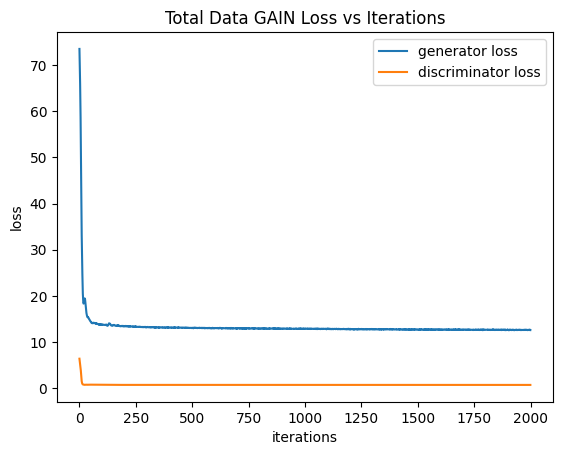

In [ ]:
plt.figure()
plt.title("Total Data GAIN Loss vs Iterations")
plt.plot(g_losstot, label='generator loss')
plt.plot(d_losstot, label = 'discriminator loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
missing_indices= np.where(1-missing_mask)
imputed_data = scaler.inverse_transform(generator.predict(missing_data))[missing_indices]
missing_real_data = X[missing_indices]

24/24 [==============================] - 0s 1ms/step


In [ ]:
# Scaler : Standard Scaler , Generator Output : Sigmoid
mae = mean_absolute_error(missing_real_data, imputed_data)
rmse = np.sqrt(mean_squared_error(missing_real_data, imputed_data))
r2 = r2_score(missing_real_data,imputed_data)
print("Evaluation\n","MAE : ",mae," | RMSE : ",rmse," | R2 : ",r2)

Evaluation
 MAE :  0.08708050754728144  | RMSE :  0.16089310646441912  | R2 :  0.33504378848700844


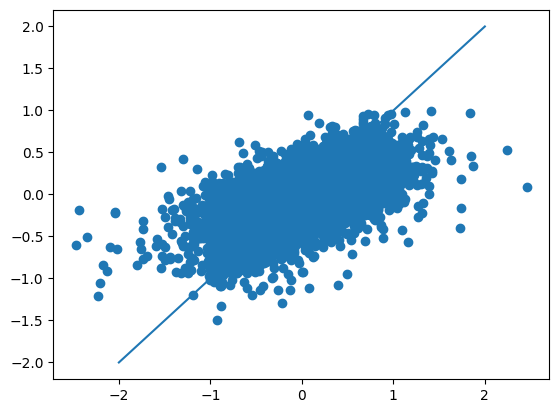

In [ ]:
plt.scatter(missing_real_data,imputed_data)
plt.plot([-2,2],[-2,2])

# EUR Cohort

In [ ]:
# scaler = StandardScaler()
scalerEUR = MinMaxScaler(feature_range=(0, 1))
scalerEUR.fit(XEUR)
X_scaledEUR = scalerEUR.transform(XEUR)
dataEUR = X_scaledEUR

# Define hyperparameters
input_dim = dataEUR.shape[1]
hidden_dim = 100
alpha = 10
iterations = 1000
batch_size = 200

# Create generator and discriminator
generatorEUR = create_generator(input_dim, hidden_dim)
discriminator = create_discriminator(input_dim, hidden_dim)

# Create GAN model
generator_input = Input(shape=(input_dim,))
gan = create_gan(generatorEUR, discriminator,input_dim)

# Create missing mask
missing_prob = 0.2  # Probability of missing values
missing_maskEUR, missing_dataEUR = missing_masking(dataEUR, missing_prob)

In [ ]:
# Train GAN model
g_lossEUR=[]
d_lossEUR=[]
for iteration in tqdm(range(iterations)):
    idx = np.random.randint(0, dataEUR.shape[0], batch_size)
    real_data = dataEUR[idx]
    mask = missing_maskEUR[idx]
    masked_data = missing_dataEUR[idx]

    generated_data = generatorEUR.predict(masked_data)

    real_data = real_data * mask + generated_data * (1 - mask)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    discriminator.trainable = True

    d_loss_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_lossEUR.append(d_loss)

    discriminator.trainable = False

    g_loss = gan.train_on_batch([masked_data,mask], [real_data, valid])
    g_lossEUR.append(g_loss[0])

    print(f'Iteration: {iteration} | D Loss: {d_loss} | G Loss: {g_loss}')


  0%|          | 0/1000 [00:00<?, ?it/s]

7/7 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 1/1000 [00:01<29:19,  1.76s/it]

Iteration: 0 | D Loss: 6.425042152404785 | G Loss: [76.19701385498047, 0.15329189598560333, 6.086782455444336]
7/7 [==============================] - 0s 2ms/step


  0%|          | 2/1000 [00:01<13:24,  1.24it/s]

Iteration: 1 | D Loss: 6.072080373764038 | G Loss: [73.83866882324219, 0.1517721712589264, 5.866145133972168]
7/7 [==============================] - 0s 3ms/step


  0%|          | 3/1000 [00:02<08:19,  2.00it/s]

Iteration: 2 | D Loss: 5.758805274963379 | G Loss: [70.86099243164062, 0.1502733677625656, 5.583365440368652]
7/7 [==============================] - 0s 2ms/step


  0%|          | 4/1000 [00:02<05:56,  2.79it/s]

Iteration: 3 | D Loss: 5.41018009185791 | G Loss: [67.28353118896484, 0.14890609681606293, 5.239292144775391]
7/7 [==============================] - 0s 2ms/step


  0%|          | 5/1000 [00:02<04:37,  3.59it/s]

Iteration: 4 | D Loss: 4.988406419754028 | G Loss: [62.7203254699707, 0.14694297313690186, 4.802602767944336]
7/7 [==============================] - 0s 4ms/step


  1%|          | 6/1000 [00:02<04:01,  4.12it/s]

Iteration: 5 | D Loss: 4.485231161117554 | G Loss: [57.64170455932617, 0.14621776342391968, 4.301992893218994]
7/7 [==============================] - 0s 2ms/step


  1%|          | 7/1000 [00:02<03:39,  4.53it/s]

Iteration: 6 | D Loss: 3.9007402658462524 | G Loss: [51.58695983886719, 0.14491893351078033, 3.7095067501068115]
7/7 [==============================] - 0s 2ms/step


  1%|          | 8/1000 [00:02<03:28,  4.75it/s]

Iteration: 7 | D Loss: 3.2266910076141357 | G Loss: [44.554046630859375, 0.14363226294517517, 3.0190823078155518]
7/7 [==============================] - 0s 2ms/step


  1%|          | 9/1000 [00:02<03:06,  5.32it/s]

Iteration: 8 | D Loss: 2.4817174673080444 | G Loss: [37.15287399291992, 0.14299921691417694, 2.285295009613037]
7/7 [==============================] - 0s 3ms/step


  1%|          | 10/1000 [00:03<03:07,  5.27it/s]

Iteration: 9 | D Loss: 1.7718535661697388 | G Loss: [30.143604278564453, 0.14221028983592987, 1.5922573804855347]
7/7 [==============================] - 0s 3ms/step


  1%|          | 11/1000 [00:03<02:56,  5.61it/s]

Iteration: 10 | D Loss: 1.2185063660144806 | G Loss: [25.501018524169922, 0.1421520859003067, 1.1285808086395264]
7/7 [==============================] - 0s 2ms/step


  1%|          | 12/1000 [00:03<02:58,  5.55it/s]

Iteration: 11 | D Loss: 0.8732866048812866 | G Loss: [23.605863571166992, 0.1434629112482071, 0.9259573221206665]
7/7 [==============================] - 0s 3ms/step


  1%|▏         | 13/1000 [00:03<03:00,  5.46it/s]

Iteration: 12 | D Loss: 0.7034699618816376 | G Loss: [23.431079864501953, 0.14507640898227692, 0.8923437595367432]
7/7 [==============================] - 0s 2ms/step


  1%|▏         | 14/1000 [00:03<03:02,  5.39it/s]

Iteration: 13 | D Loss: 0.6365924179553986 | G Loss: [23.704015731811523, 0.14458440244197845, 0.9245575666427612]
7/7 [==============================] - 0s 2ms/step


  2%|▏         | 15/1000 [00:04<02:59,  5.48it/s]

Iteration: 14 | D Loss: 0.6150930523872375 | G Loss: [24.378883361816406, 0.14652274549007416, 0.9726608991622925]
7/7 [==============================] - 0s 2ms/step


  2%|▏         | 16/1000 [00:04<02:58,  5.52it/s]

Iteration: 15 | D Loss: 0.6171538829803467 | G Loss: [24.726350784301758, 0.14746452867984772, 0.9979897141456604]
7/7 [==============================] - 0s 2ms/step


  2%|▏         | 17/1000 [00:04<03:02,  5.39it/s]

Iteration: 16 | D Loss: 0.6236637532711029 | G Loss: [24.424419403076172, 0.14674337208271027, 0.9750080704689026]
7/7 [==============================] - 0s 2ms/step


  2%|▏         | 18/1000 [00:04<03:09,  5.18it/s]

Iteration: 17 | D Loss: 0.6385965645313263 | G Loss: [24.04543685913086, 0.14727923274040222, 0.9317514300346375]
7/7 [==============================] - 0s 4ms/step


  2%|▏         | 19/1000 [00:04<03:20,  4.90it/s]

Iteration: 18 | D Loss: 0.655301034450531 | G Loss: [23.281909942626953, 0.1461864858865738, 0.8663261532783508]
7/7 [==============================] - 0s 3ms/step


  2%|▏         | 20/1000 [00:05<03:26,  4.75it/s]

Iteration: 19 | D Loss: 0.6730533838272095 | G Loss: [22.702930450439453, 0.14594686031341553, 0.8108241558074951]
7/7 [==============================] - 0s 5ms/step


  2%|▏         | 21/1000 [00:05<03:41,  4.43it/s]

Iteration: 20 | D Loss: 0.6869440078735352 | G Loss: [22.367881774902344, 0.14470840990543365, 0.7897038459777832]
7/7 [==============================] - 0s 3ms/step


  2%|▏         | 22/1000 [00:05<03:39,  4.45it/s]

Iteration: 21 | D Loss: 0.7062649428844452 | G Loss: [22.212207794189453, 0.1447475105524063, 0.7737457156181335]
7/7 [==============================] - 0s 3ms/step


  2%|▏         | 23/1000 [00:05<03:47,  4.29it/s]

Iteration: 22 | D Loss: 0.7182944416999817 | G Loss: [21.99866485595703, 0.14271053671836853, 0.7727612257003784]
7/7 [==============================] - 0s 4ms/step


  2%|▏         | 24/1000 [00:06<03:43,  4.38it/s]

Iteration: 23 | D Loss: 0.7363910675048828 | G Loss: [21.945755004882812, 0.14243483543395996, 0.7702271938323975]
7/7 [==============================] - 0s 3ms/step


  2%|▎         | 25/1000 [00:06<03:34,  4.55it/s]

Iteration: 24 | D Loss: 0.7530377507209778 | G Loss: [21.7545166015625, 0.14017829298973083, 0.7736688256263733]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 26/1000 [00:06<03:29,  4.66it/s]

Iteration: 25 | D Loss: 0.7716766893863678 | G Loss: [21.643089294433594, 0.13994459807872772, 0.7648628354072571]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 27/1000 [00:06<03:35,  4.51it/s]

Iteration: 26 | D Loss: 0.799128383398056 | G Loss: [21.33330726623535, 0.13882434368133545, 0.7450873851776123]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 28/1000 [00:06<03:36,  4.48it/s]

Iteration: 27 | D Loss: 0.8116615116596222 | G Loss: [20.973045349121094, 0.13678722083568573, 0.729432225227356]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 29/1000 [00:07<03:41,  4.38it/s]

Iteration: 28 | D Loss: 0.8311674892902374 | G Loss: [20.5538272857666, 0.13509880006313324, 0.7043948173522949]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 30/1000 [00:07<03:48,  4.25it/s]

Iteration: 29 | D Loss: 0.8490103185176849 | G Loss: [20.042041778564453, 0.133063405752182, 0.6735702753067017]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 31/1000 [00:07<03:52,  4.17it/s]

Iteration: 30 | D Loss: 0.8565613031387329 | G Loss: [19.734399795532227, 0.1311626434326172, 0.661813497543335]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 32/1000 [00:07<03:53,  4.15it/s]

Iteration: 31 | D Loss: 0.8657137453556061 | G Loss: [19.540863037109375, 0.13065758347511292, 0.6475104689598083]
7/7 [==============================] - 0s 4ms/step


  3%|▎         | 33/1000 [00:08<03:49,  4.21it/s]

Iteration: 32 | D Loss: 0.872645914554596 | G Loss: [19.085153579711914, 0.1277357041835785, 0.6311583518981934]
7/7 [==============================] - 0s 3ms/step


  3%|▎         | 34/1000 [00:08<03:50,  4.20it/s]

Iteration: 33 | D Loss: 0.8708242774009705 | G Loss: [18.846954345703125, 0.12586532533168793, 0.6260421872138977]
7/7 [==============================] - 0s 3ms/step


  4%|▎         | 35/1000 [00:08<03:46,  4.26it/s]

Iteration: 34 | D Loss: 0.8694965839385986 | G Loss: [18.644817352294922, 0.12429241091012955, 0.6215575933456421]
7/7 [==============================] - 0s 2ms/step


  4%|▎         | 36/1000 [00:08<03:18,  4.86it/s]

Iteration: 35 | D Loss: 0.8746867775917053 | G Loss: [18.295856475830078, 0.12219477444887161, 0.6076380014419556]
7/7 [==============================] - 0s 2ms/step


  4%|▎         | 37/1000 [00:08<03:10,  5.05it/s]

Iteration: 36 | D Loss: 0.868364155292511 | G Loss: [18.257808685302734, 0.12109565734863281, 0.6148243546485901]
7/7 [==============================] - 0s 3ms/step


  4%|▍         | 38/1000 [00:09<03:00,  5.32it/s]

Iteration: 37 | D Loss: 0.8599265217781067 | G Loss: [18.00827980041504, 0.11897635459899902, 0.6110644340515137]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 39/1000 [00:09<02:51,  5.59it/s]

Iteration: 38 | D Loss: 0.8522154092788696 | G Loss: [17.97364044189453, 0.11822030693292618, 0.6151608824729919]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 40/1000 [00:09<02:42,  5.91it/s]

Iteration: 39 | D Loss: 0.8415093123912811 | G Loss: [17.885784149169922, 0.11674048751592636, 0.621173620223999]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 41/1000 [00:09<02:46,  5.75it/s]

Iteration: 40 | D Loss: 0.8352633714675903 | G Loss: [17.81341552734375, 0.11627129465341568, 0.6186286807060242]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 42/1000 [00:09<02:37,  6.08it/s]

Iteration: 41 | D Loss: 0.8240504264831543 | G Loss: [17.773422241210938, 0.11521358788013458, 0.6252063512802124]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 43/1000 [00:09<02:30,  6.35it/s]

Iteration: 42 | D Loss: 0.817540168762207 | G Loss: [17.670761108398438, 0.11393442004919052, 0.6277318000793457]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 44/1000 [00:10<02:27,  6.49it/s]

Iteration: 43 | D Loss: 0.8076288104057312 | G Loss: [17.456119537353516, 0.11151120811700821, 0.6304997801780701]
7/7 [==============================] - 0s 2ms/step


  4%|▍         | 45/1000 [00:10<02:35,  6.15it/s]

Iteration: 44 | D Loss: 0.800689160823822 | G Loss: [17.297422409057617, 0.10992652922868729, 0.6304768919944763]
7/7 [==============================] - 0s 2ms/step


  5%|▍         | 46/1000 [00:10<02:34,  6.17it/s]

Iteration: 45 | D Loss: 0.7914098501205444 | G Loss: [17.353927612304688, 0.11010690778493881, 0.63432377576828]
7/7 [==============================] - 0s 2ms/step


  5%|▍         | 47/1000 [00:10<02:42,  5.88it/s]

Iteration: 46 | D Loss: 0.7912873923778534 | G Loss: [17.214324951171875, 0.10870988667011261, 0.634333610534668]
7/7 [==============================] - 0s 2ms/step


  5%|▍         | 48/1000 [00:10<02:32,  6.22it/s]

Iteration: 47 | D Loss: 0.7848005294799805 | G Loss: [17.067214965820312, 0.10678907483816147, 0.6388306617736816]
7/7 [==============================] - 0s 4ms/step


  5%|▍         | 49/1000 [00:10<02:37,  6.05it/s]

Iteration: 48 | D Loss: 0.779668539762497 | G Loss: [17.01923179626465, 0.10629718750715256, 0.638951301574707]
7/7 [==============================] - 0s 2ms/step


  5%|▌         | 50/1000 [00:11<02:49,  5.61it/s]

Iteration: 49 | D Loss: 0.7766411602497101 | G Loss: [17.132678985595703, 0.1066993698477745, 0.6462742686271667]
7/7 [==============================] - 0s 2ms/step


  5%|▌         | 51/1000 [00:11<02:48,  5.65it/s]

Iteration: 50 | D Loss: 0.7733151912689209 | G Loss: [17.021404266357422, 0.10529761016368866, 0.6491642594337463]
7/7 [==============================] - 0s 2ms/step


  5%|▌         | 52/1000 [00:11<02:49,  5.60it/s]

Iteration: 51 | D Loss: 0.7694916725158691 | G Loss: [17.113208770751953, 0.10539977997541428, 0.6573230028152466]
7/7 [==============================] - 0s 2ms/step


  5%|▌         | 53/1000 [00:11<02:38,  5.99it/s]

Iteration: 52 | D Loss: 0.7690957188606262 | G Loss: [17.10093116760254, 0.10496225953102112, 0.6604704260826111]
7/7 [==============================] - 0s 3ms/step


  5%|▌         | 54/1000 [00:11<02:40,  5.88it/s]

Iteration: 53 | D Loss: 0.7656883001327515 | G Loss: [16.916963577270508, 0.10265612602233887, 0.6651351451873779]
7/7 [==============================] - 0s 2ms/step


  6%|▌         | 55/1000 [00:11<02:34,  6.11it/s]

Iteration: 54 | D Loss: 0.7631564736366272 | G Loss: [17.010597229003906, 0.10312401503324509, 0.6698196530342102]
7/7 [==============================] - 0s 5ms/step


  6%|▌         | 56/1000 [00:12<03:01,  5.19it/s]

Iteration: 55 | D Loss: 0.7592040002346039 | G Loss: [16.843158721923828, 0.1011834517121315, 0.6724813580513]
7/7 [==============================] - 0s 5ms/step


  6%|▌         | 57/1000 [00:12<03:25,  4.58it/s]

Iteration: 56 | D Loss: 0.7590353190898895 | G Loss: [16.750938415527344, 0.10015958547592163, 0.6734979152679443]
7/7 [==============================] - 0s 3ms/step


  6%|▌         | 58/1000 [00:12<03:44,  4.20it/s]

Iteration: 57 | D Loss: 0.7576360404491425 | G Loss: [16.60043716430664, 0.09861376136541367, 0.6739060282707214]
7/7 [==============================] - 0s 2ms/step


  6%|▌         | 59/1000 [00:12<03:42,  4.23it/s]

Iteration: 58 | D Loss: 0.7559466063976288 | G Loss: [16.404664993286133, 0.09677141159772873, 0.672752320766449]
7/7 [==============================] - 0s 2ms/step


  6%|▌         | 60/1000 [00:13<03:29,  4.48it/s]

Iteration: 59 | D Loss: 0.7535471022129059 | G Loss: [16.29523468017578, 0.095659039914608, 0.672933042049408]
7/7 [==============================] - 0s 2ms/step


  6%|▌         | 61/1000 [00:13<03:16,  4.77it/s]

Iteration: 60 | D Loss: 0.7511202692985535 | G Loss: [16.1387939453125, 0.09431447088718414, 0.6707347631454468]
7/7 [==============================] - 0s 2ms/step


  6%|▌         | 62/1000 [00:13<02:57,  5.29it/s]

Iteration: 61 | D Loss: 0.7498641908168793 | G Loss: [16.08677864074707, 0.093869149684906, 0.669986367225647]
7/7 [==============================] - 0s 3ms/step


  6%|▋         | 63/1000 [00:13<02:55,  5.33it/s]

Iteration: 62 | D Loss: 0.7492271363735199 | G Loss: [16.062728881835938, 0.09333886206150055, 0.6728841662406921]
7/7 [==============================] - 0s 2ms/step


  6%|▋         | 64/1000 [00:13<02:53,  5.41it/s]

Iteration: 63 | D Loss: 0.7450671494007111 | G Loss: [15.923510551452637, 0.09201672673225403, 0.6721838116645813]
7/7 [==============================] - 0s 2ms/step


  6%|▋         | 65/1000 [00:13<02:44,  5.67it/s]

Iteration: 64 | D Loss: 0.7476631104946136 | G Loss: [15.898828506469727, 0.09174404293298721, 0.6724424958229065]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 66/1000 [00:14<02:36,  5.96it/s]

Iteration: 65 | D Loss: 0.747349739074707 | G Loss: [15.707162857055664, 0.09010893851518631, 0.6696269512176514]
7/7 [==============================] - 0s 3ms/step


  7%|▋         | 67/1000 [00:14<02:34,  6.04it/s]

Iteration: 66 | D Loss: 0.7478010356426239 | G Loss: [15.64065170288086, 0.08960554748773575, 0.6680096983909607]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 68/1000 [00:14<02:39,  5.84it/s]

Iteration: 67 | D Loss: 0.7490682601928711 | G Loss: [15.548696517944336, 0.08887826651334763, 0.6660869121551514]
7/7 [==============================] - 0s 3ms/step


  7%|▋         | 69/1000 [00:14<02:30,  6.20it/s]

Iteration: 68 | D Loss: 0.7492907345294952 | G Loss: [15.712970733642578, 0.08988025784492493, 0.6724945306777954]
7/7 [==============================] - 0s 3ms/step


  7%|▋         | 70/1000 [00:14<02:35,  5.96it/s]

Iteration: 69 | D Loss: 0.7514177560806274 | G Loss: [15.454684257507324, 0.08821094781160355, 0.6633589863777161]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 71/1000 [00:14<02:38,  5.85it/s]

Iteration: 70 | D Loss: 0.7491979598999023 | G Loss: [15.640960693359375, 0.08926635980606079, 0.6714324951171875]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 72/1000 [00:15<02:44,  5.66it/s]

Iteration: 71 | D Loss: 0.7462612092494965 | G Loss: [15.594186782836914, 0.08888224512338638, 0.670596182346344]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 73/1000 [00:15<02:36,  5.90it/s]

Iteration: 72 | D Loss: 0.7458460330963135 | G Loss: [15.526006698608398, 0.08843892812728882, 0.6682113409042358]
7/7 [==============================] - 0s 2ms/step


  7%|▋         | 74/1000 [00:15<03:40,  4.21it/s]

Iteration: 73 | D Loss: 0.7472529709339142 | G Loss: [15.638782501220703, 0.08919534832239151, 0.671924889087677]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 75/1000 [00:15<03:30,  4.40it/s]

Iteration: 74 | D Loss: 0.7475407123565674 | G Loss: [15.593498229980469, 0.08866620808839798, 0.6726877689361572]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 76/1000 [00:16<03:14,  4.76it/s]

Iteration: 75 | D Loss: 0.745445042848587 | G Loss: [15.75451374053955, 0.08963834494352341, 0.6790679693222046]
7/7 [==============================] - 0s 4ms/step


  8%|▊         | 77/1000 [00:16<03:08,  4.88it/s]

Iteration: 76 | D Loss: 0.7466845512390137 | G Loss: [15.669658660888672, 0.08904720097780228, 0.6764938831329346]
7/7 [==============================] - 0s 2ms/step


  8%|▊         | 78/1000 [00:16<03:04,  5.01it/s]

Iteration: 77 | D Loss: 0.7443184554576874 | G Loss: [15.785449981689453, 0.08933145552873611, 0.6852304935455322]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 79/1000 [00:16<02:58,  5.15it/s]

Iteration: 78 | D Loss: 0.7458409070968628 | G Loss: [15.709927558898926, 0.08910093456506729, 0.6799834966659546]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 80/1000 [00:16<02:55,  5.24it/s]

Iteration: 79 | D Loss: 0.7439188659191132 | G Loss: [15.769305229187012, 0.08971316367387772, 0.6797989010810852]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 81/1000 [00:17<02:53,  5.31it/s]

Iteration: 80 | D Loss: 0.7441772222518921 | G Loss: [15.73388671875, 0.08944713324308395, 0.6789172887802124]
7/7 [==============================] - 0s 3ms/step


  8%|▊         | 82/1000 [00:17<02:47,  5.48it/s]

Iteration: 81 | D Loss: 0.7417415082454681 | G Loss: [15.734857559204102, 0.08898556977510452, 0.6836300492286682]
7/7 [==============================] - 0s 2ms/step


  8%|▊         | 83/1000 [00:17<02:41,  5.68it/s]

Iteration: 82 | D Loss: 0.7414070069789886 | G Loss: [15.570682525634766, 0.0876237079501152, 0.6808311343193054]
7/7 [==============================] - 0s 2ms/step


  8%|▊         | 84/1000 [00:17<02:32,  6.00it/s]

Iteration: 83 | D Loss: 0.7386364638805389 | G Loss: [15.563157081604004, 0.08765064179897308, 0.6798092126846313]
7/7 [==============================] - 0s 2ms/step


  8%|▊         | 85/1000 [00:17<02:37,  5.79it/s]

Iteration: 84 | D Loss: 0.7392054498195648 | G Loss: [15.486944198608398, 0.08703606575727463, 0.6783338785171509]
7/7 [==============================] - 0s 3ms/step


  9%|▊         | 86/1000 [00:17<02:40,  5.71it/s]

Iteration: 85 | D Loss: 0.7373819947242737 | G Loss: [15.503582000732422, 0.08702520281076431, 0.6801062226295471]
7/7 [==============================] - 0s 2ms/step


  9%|▊         | 87/1000 [00:17<02:29,  6.10it/s]

Iteration: 86 | D Loss: 0.7344017326831818 | G Loss: [15.472360610961914, 0.08654363453388214, 0.6817996501922607]
7/7 [==============================] - 0s 2ms/step


  9%|▉         | 88/1000 [00:18<02:34,  5.89it/s]

Iteration: 87 | D Loss: 0.7329532206058502 | G Loss: [15.417515754699707, 0.0856856256723404, 0.6848953366279602]
7/7 [==============================] - 0s 3ms/step


  9%|▉         | 89/1000 [00:18<02:31,  6.00it/s]

Iteration: 88 | D Loss: 0.7342051267623901 | G Loss: [15.411489486694336, 0.0856112688779831, 0.685036301612854]
7/7 [==============================] - 0s 3ms/step


  9%|▉         | 90/1000 [00:18<02:30,  6.04it/s]

Iteration: 89 | D Loss: 0.7340536713600159 | G Loss: [15.471446990966797, 0.08601972460746765, 0.6869474649429321]
7/7 [==============================] - 0s 3ms/step


  9%|▉         | 91/1000 [00:18<02:45,  5.50it/s]

Iteration: 90 | D Loss: 0.7341038286685944 | G Loss: [15.405640602111816, 0.08538356423377991, 0.6867283582687378]
7/7 [==============================] - 0s 3ms/step


  9%|▉         | 92/1000 [00:18<03:02,  4.98it/s]

Iteration: 91 | D Loss: 0.7325266301631927 | G Loss: [15.3872709274292, 0.0849321186542511, 0.6894059181213379]
7/7 [==============================] - 0s 3ms/step


  9%|▉         | 93/1000 [00:19<03:13,  4.69it/s]

Iteration: 92 | D Loss: 0.7350964248180389 | G Loss: [15.360088348388672, 0.08520600199699402, 0.683948814868927]
7/7 [==============================] - 0s 4ms/step


  9%|▉         | 94/1000 [00:19<03:23,  4.45it/s]

Iteration: 93 | D Loss: 0.734822541475296 | G Loss: [15.191308975219727, 0.08367623388767242, 0.6823685169219971]
7/7 [==============================] - 0s 4ms/step


 10%|▉         | 95/1000 [00:19<03:23,  4.44it/s]

Iteration: 94 | D Loss: 0.7337589859962463 | G Loss: [15.272882461547852, 0.08447862416505814, 0.6825019717216492]
7/7 [==============================] - 0s 3ms/step


 10%|▉         | 96/1000 [00:19<03:24,  4.43it/s]

Iteration: 95 | D Loss: 0.7338453233242035 | G Loss: [15.280628204345703, 0.08449724316596985, 0.6830905079841614]
7/7 [==============================] - 0s 3ms/step


 10%|▉         | 97/1000 [00:20<03:24,  4.42it/s]

Iteration: 96 | D Loss: 0.7337216138839722 | G Loss: [15.248623847961426, 0.08428682386875153, 0.6819941997528076]
7/7 [==============================] - 0s 3ms/step


 10%|▉         | 98/1000 [00:20<03:26,  4.37it/s]

Iteration: 97 | D Loss: 0.7370389401912689 | G Loss: [15.148538589477539, 0.08382539451122284, 0.6765998601913452]
7/7 [==============================] - 0s 4ms/step


 10%|▉         | 99/1000 [00:20<03:32,  4.24it/s]

Iteration: 98 | D Loss: 0.7358479499816895 | G Loss: [15.140092849731445, 0.08364124596118927, 0.6775968670845032]
7/7 [==============================] - 0s 3ms/step


 10%|█         | 100/1000 [00:20<03:35,  4.17it/s]

Iteration: 99 | D Loss: 0.7369615435600281 | G Loss: [15.182642936706543, 0.08395982533693314, 0.6786659955978394]
7/7 [==============================] - 0s 3ms/step


 10%|█         | 101/1000 [00:21<03:23,  4.42it/s]

Iteration: 100 | D Loss: 0.7361220419406891 | G Loss: [15.206955909729004, 0.084068164229393, 0.6800139546394348]
7/7 [==============================] - 0s 3ms/step


 10%|█         | 102/1000 [00:21<03:17,  4.56it/s]

Iteration: 101 | D Loss: 0.7384477257728577 | G Loss: [15.073198318481445, 0.08310142159461975, 0.6763055324554443]
7/7 [==============================] - 0s 5ms/step


 10%|█         | 103/1000 [00:21<03:20,  4.48it/s]

Iteration: 102 | D Loss: 0.7384044826030731 | G Loss: [15.037334442138672, 0.08304931968450546, 0.6732403039932251]
7/7 [==============================] - 0s 3ms/step


 10%|█         | 104/1000 [00:21<03:23,  4.40it/s]

Iteration: 103 | D Loss: 0.738913357257843 | G Loss: [15.127462387084961, 0.08370412886142731, 0.6757049560546875]
7/7 [==============================] - 0s 3ms/step


 10%|█         | 105/1000 [00:21<03:28,  4.29it/s]

Iteration: 104 | D Loss: 0.7365009188652039 | G Loss: [15.067124366760254, 0.08304442465305328, 0.6762682199478149]
7/7 [==============================] - 0s 4ms/step


 11%|█         | 106/1000 [00:22<03:30,  4.24it/s]

Iteration: 105 | D Loss: 0.7357606887817383 | G Loss: [15.228815078735352, 0.08458096534013748, 0.6770718097686768]
7/7 [==============================] - 0s 3ms/step


 11%|█         | 107/1000 [00:22<03:31,  4.21it/s]

Iteration: 106 | D Loss: 0.7357637584209442 | G Loss: [15.022019386291504, 0.08254491537809372, 0.6767526268959045]
7/7 [==============================] - 0s 4ms/step


 11%|█         | 108/1000 [00:22<03:39,  4.07it/s]

Iteration: 107 | D Loss: 0.7348147630691528 | G Loss: [15.118874549865723, 0.08356260508298874, 0.6762614250183105]
7/7 [==============================] - 0s 2ms/step


 11%|█         | 109/1000 [00:22<03:10,  4.67it/s]

Iteration: 108 | D Loss: 0.7321435511112213 | G Loss: [15.054662704467773, 0.08272545784711838, 0.6782116889953613]
7/7 [==============================] - 0s 2ms/step


 11%|█         | 110/1000 [00:23<03:00,  4.94it/s]

Iteration: 109 | D Loss: 0.7315842807292938 | G Loss: [14.98624038696289, 0.08201458305120468, 0.6784782409667969]
7/7 [==============================] - 0s 2ms/step


 11%|█         | 111/1000 [00:23<02:53,  5.11it/s]

Iteration: 110 | D Loss: 0.7314671874046326 | G Loss: [15.009403228759766, 0.08209840953350067, 0.6799561977386475]
7/7 [==============================] - 0s 2ms/step


 11%|█         | 112/1000 [00:23<02:38,  5.59it/s]

Iteration: 111 | D Loss: 0.7290016710758209 | G Loss: [15.095002174377441, 0.08270201832056046, 0.6824800372123718]
7/7 [==============================] - 0s 3ms/step


 11%|█▏        | 113/1000 [00:23<02:39,  5.55it/s]

Iteration: 112 | D Loss: 0.7285885512828827 | G Loss: [14.993839263916016, 0.08178901672363281, 0.6814936995506287]
7/7 [==============================] - 0s 2ms/step


 11%|█▏        | 114/1000 [00:23<02:29,  5.92it/s]

Iteration: 113 | D Loss: 0.7285037636756897 | G Loss: [14.992653846740723, 0.08195433020591736, 0.6797221302986145]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 115/1000 [00:23<02:23,  6.18it/s]

Iteration: 114 | D Loss: 0.7263426184654236 | G Loss: [14.9812593460083, 0.0818956196308136, 0.6791698336601257]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 116/1000 [00:24<02:29,  5.93it/s]

Iteration: 115 | D Loss: 0.7240764200687408 | G Loss: [14.90310287475586, 0.08076310902833939, 0.6826791167259216]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 117/1000 [00:24<02:24,  6.13it/s]

Iteration: 116 | D Loss: 0.7234097719192505 | G Loss: [14.882646560668945, 0.08077512681484222, 0.6805133819580078]
7/7 [==============================] - 0s 3ms/step


 12%|█▏        | 118/1000 [00:24<02:19,  6.31it/s]

Iteration: 117 | D Loss: 0.7221210598945618 | G Loss: [14.808605194091797, 0.07987434417009354, 0.6821169853210449]
7/7 [==============================] - 0s 3ms/step


 12%|█▏        | 119/1000 [00:24<02:25,  6.05it/s]

Iteration: 118 | D Loss: 0.7206693589687347 | G Loss: [14.804614067077637, 0.07969148457050323, 0.6835465431213379]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 120/1000 [00:24<02:21,  6.22it/s]

Iteration: 119 | D Loss: 0.7187064588069916 | G Loss: [14.869586944580078, 0.08008675277233124, 0.6860911846160889]
7/7 [==============================] - 0s 3ms/step


 12%|█▏        | 121/1000 [00:24<02:18,  6.35it/s]

Iteration: 120 | D Loss: 0.7189202904701233 | G Loss: [14.718378067016602, 0.07890281826257706, 0.682809591293335]
7/7 [==============================] - 0s 3ms/step


 12%|█▏        | 122/1000 [00:24<02:23,  6.14it/s]

Iteration: 121 | D Loss: 0.71786829829216 | G Loss: [14.79336929321289, 0.07925199717283249, 0.686816930770874]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 123/1000 [00:25<02:28,  5.90it/s]

Iteration: 122 | D Loss: 0.7164604663848877 | G Loss: [14.755022048950195, 0.07871715724468231, 0.6883307099342346]
7/7 [==============================] - 0s 2ms/step


 12%|█▏        | 124/1000 [00:25<02:20,  6.22it/s]

Iteration: 123 | D Loss: 0.7158046960830688 | G Loss: [14.755516052246094, 0.07902822643518448, 0.685269296169281]
7/7 [==============================] - 0s 2ms/step


 12%|█▎        | 125/1000 [00:25<02:17,  6.37it/s]

Iteration: 124 | D Loss: 0.715127557516098 | G Loss: [14.735757827758789, 0.07828272134065628, 0.6907485723495483]
7/7 [==============================] - 0s 2ms/step


 13%|█▎        | 126/1000 [00:25<02:24,  6.05it/s]

Iteration: 125 | D Loss: 0.7133541703224182 | G Loss: [14.738107681274414, 0.07826048135757446, 0.6912060379981995]
7/7 [==============================] - 0s 3ms/step


 13%|█▎        | 127/1000 [00:25<02:18,  6.33it/s]

Iteration: 126 | D Loss: 0.7131259143352509 | G Loss: [14.598271369934082, 0.07721162587404251, 0.6877108812332153]
7/7 [==============================] - 0s 2ms/step


 13%|█▎        | 128/1000 [00:25<02:23,  6.09it/s]

Iteration: 127 | D Loss: 0.7123917043209076 | G Loss: [14.599222183227539, 0.07696275413036346, 0.690294623374939]
7/7 [==============================] - 0s 3ms/step


 13%|█▎        | 129/1000 [00:26<02:25,  6.01it/s]

Iteration: 128 | D Loss: 0.7107663750648499 | G Loss: [14.691890716552734, 0.07765514403581619, 0.6926376223564148]
7/7 [==============================] - 0s 2ms/step


 13%|█▎        | 130/1000 [00:26<02:22,  6.12it/s]

Iteration: 129 | D Loss: 0.7109898626804352 | G Loss: [14.680307388305664, 0.07758787274360657, 0.6921520829200745]
7/7 [==============================] - 0s 2ms/step


 13%|█▎        | 131/1000 [00:26<02:29,  5.81it/s]

Iteration: 130 | D Loss: 0.7099051773548126 | G Loss: [14.641439437866211, 0.07723221182823181, 0.6918218731880188]
7/7 [==============================] - 0s 3ms/step


 13%|█▎        | 132/1000 [00:26<02:26,  5.92it/s]

Iteration: 131 | D Loss: 0.7099528908729553 | G Loss: [14.713902473449707, 0.0780990794301033, 0.6903994679450989]
7/7 [==============================] - 0s 3ms/step


 13%|█▎        | 133/1000 [00:26<02:30,  5.78it/s]

Iteration: 132 | D Loss: 0.7085481584072113 | G Loss: [14.609338760375977, 0.0768292024731636, 0.6926417350769043]
7/7 [==============================] - 0s 2ms/step


 13%|█▎        | 134/1000 [00:26<02:23,  6.05it/s]

Iteration: 133 | D Loss: 0.70722696185112 | G Loss: [14.61424446105957, 0.07694238424301147, 0.6920005679130554]
7/7 [==============================] - 0s 2ms/step


 14%|█▎        | 135/1000 [00:27<02:27,  5.85it/s]

Iteration: 134 | D Loss: 0.7068711817264557 | G Loss: [14.623795509338379, 0.07701501995325089, 0.6922293901443481]
7/7 [==============================] - 0s 2ms/step


 14%|█▎        | 136/1000 [00:27<02:21,  6.10it/s]

Iteration: 135 | D Loss: 0.7062487006187439 | G Loss: [14.672969818115234, 0.07714282721281052, 0.695868730545044]
7/7 [==============================] - 0s 4ms/step


 14%|█▎        | 137/1000 [00:27<02:20,  6.15it/s]

Iteration: 136 | D Loss: 0.7053777277469635 | G Loss: [14.5308198928833, 0.07570129632949829, 0.6960691809654236]
7/7 [==============================] - 0s 2ms/step


 14%|█▍        | 138/1000 [00:27<02:28,  5.81it/s]

Iteration: 137 | D Loss: 0.7060119211673737 | G Loss: [14.601471900939941, 0.07619049400091171, 0.6982422471046448]
7/7 [==============================] - 0s 3ms/step


 14%|█▍        | 139/1000 [00:27<02:20,  6.13it/s]

Iteration: 138 | D Loss: 0.7042862176895142 | G Loss: [14.648995399475098, 0.07646244764328003, 0.7002750635147095]
7/7 [==============================] - 0s 2ms/step


 14%|█▍        | 140/1000 [00:27<02:15,  6.33it/s]

Iteration: 139 | D Loss: 0.7042236328125 | G Loss: [14.504197120666504, 0.07490348070859909, 0.7013849020004272]
7/7 [==============================] - 0s 3ms/step


 14%|█▍        | 141/1000 [00:28<02:20,  6.12it/s]

Iteration: 140 | D Loss: 0.7053429186344147 | G Loss: [14.536194801330566, 0.07509829849004745, 0.7026364803314209]
7/7 [==============================] - 0s 2ms/step


 14%|█▍        | 142/1000 [00:28<02:18,  6.21it/s]

Iteration: 141 | D Loss: 0.7037836611270905 | G Loss: [14.529460906982422, 0.07516755163669586, 0.7012704610824585]
7/7 [==============================] - 0s 3ms/step


 14%|█▍        | 143/1000 [00:28<02:24,  5.93it/s]

Iteration: 142 | D Loss: 0.7038500905036926 | G Loss: [14.632759094238281, 0.07625866681337357, 0.7006892561912537]
7/7 [==============================] - 0s 3ms/step


 14%|█▍        | 144/1000 [00:28<02:30,  5.68it/s]

Iteration: 143 | D Loss: 0.7038670182228088 | G Loss: [14.522735595703125, 0.07507859915494919, 0.70148766040802]
7/7 [==============================] - 0s 4ms/step


 14%|█▍        | 145/1000 [00:28<02:23,  5.97it/s]

Iteration: 144 | D Loss: 0.7042948305606842 | G Loss: [14.4027681350708, 0.07395502179861069, 0.7007266283035278]
7/7 [==============================] - 0s 2ms/step


 15%|█▍        | 146/1000 [00:28<02:28,  5.76it/s]

Iteration: 145 | D Loss: 0.7035677134990692 | G Loss: [14.507144927978516, 0.07505429536104202, 0.7001715302467346]
7/7 [==============================] - 0s 2ms/step


 15%|█▍        | 147/1000 [00:29<02:30,  5.68it/s]

Iteration: 146 | D Loss: 0.7034516930580139 | G Loss: [14.433180809020996, 0.0745047926902771, 0.6982702016830444]
7/7 [==============================] - 0s 3ms/step


 15%|█▍        | 148/1000 [00:29<02:23,  5.93it/s]

Iteration: 147 | D Loss: 0.7039492130279541 | G Loss: [14.46280288696289, 0.0746389701962471, 0.6998906135559082]
7/7 [==============================] - 0s 3ms/step


 15%|█▍        | 149/1000 [00:29<02:19,  6.12it/s]

Iteration: 148 | D Loss: 0.7041151821613312 | G Loss: [14.41506576538086, 0.07412049174308777, 0.7003016471862793]
7/7 [==============================] - 0s 2ms/step


 15%|█▌        | 150/1000 [00:29<02:14,  6.34it/s]

Iteration: 149 | D Loss: 0.704486608505249 | G Loss: [14.391536712646484, 0.07387178391218185, 0.7004358768463135]
7/7 [==============================] - 0s 3ms/step


 15%|█▌        | 151/1000 [00:29<02:24,  5.89it/s]

Iteration: 150 | D Loss: 0.704105019569397 | G Loss: [14.446434020996094, 0.07448165118694305, 0.6998269557952881]
7/7 [==============================] - 0s 2ms/step


 15%|█▌        | 152/1000 [00:29<02:19,  6.09it/s]

Iteration: 151 | D Loss: 0.7051351964473724 | G Loss: [14.450692176818848, 0.07431720942258835, 0.701897144317627]
7/7 [==============================] - 0s 3ms/step


 15%|█▌        | 153/1000 [00:30<02:15,  6.23it/s]

Iteration: 152 | D Loss: 0.7057162821292877 | G Loss: [14.504908561706543, 0.07476579397916794, 0.7028329372406006]
7/7 [==============================] - 0s 3ms/step


 15%|█▌        | 154/1000 [00:30<02:13,  6.33it/s]

Iteration: 153 | D Loss: 0.7055312693119049 | G Loss: [14.482460021972656, 0.07449998706579208, 0.7032460570335388]
7/7 [==============================] - 0s 3ms/step


 16%|█▌        | 155/1000 [00:30<02:20,  6.01it/s]

Iteration: 154 | D Loss: 0.7062100172042847 | G Loss: [14.3677396774292, 0.07339450716972351, 0.7028288841247559]
7/7 [==============================] - 0s 3ms/step


 16%|█▌        | 156/1000 [00:30<02:23,  5.86it/s]

Iteration: 155 | D Loss: 0.7068686783313751 | G Loss: [14.398372650146484, 0.07365920394659042, 0.7032451629638672]
7/7 [==============================] - 0s 2ms/step


 16%|█▌        | 157/1000 [00:30<02:19,  6.02it/s]

Iteration: 156 | D Loss: 0.7072604298591614 | G Loss: [14.441522598266602, 0.0742015391588211, 0.7021368145942688]
7/7 [==============================] - 0s 2ms/step


 16%|█▌        | 158/1000 [00:30<02:22,  5.90it/s]

Iteration: 157 | D Loss: 0.707569420337677 | G Loss: [14.381099700927734, 0.07363560795783997, 0.7017539143562317]
7/7 [==============================] - 0s 3ms/step


 16%|█▌        | 159/1000 [00:31<02:26,  5.76it/s]

Iteration: 158 | D Loss: 0.7071323394775391 | G Loss: [14.407520294189453, 0.07387599349021912, 0.7019920349121094]
7/7 [==============================] - 0s 3ms/step


 16%|█▌        | 160/1000 [00:31<02:28,  5.65it/s]

Iteration: 159 | D Loss: 0.7086747288703918 | G Loss: [14.330704689025879, 0.0732480138540268, 0.7005903124809265]
7/7 [==============================] - 0s 2ms/step


 16%|█▌        | 161/1000 [00:31<02:33,  5.47it/s]

Iteration: 160 | D Loss: 0.7081922292709351 | G Loss: [14.408098220825195, 0.0740913525223732, 0.6998962163925171]
7/7 [==============================] - 0s 3ms/step


 16%|█▌        | 162/1000 [00:31<02:37,  5.32it/s]

Iteration: 161 | D Loss: 0.7091167867183685 | G Loss: [14.371879577636719, 0.073740154504776, 0.699786365032196]
7/7 [==============================] - 0s 3ms/step


 16%|█▋        | 163/1000 [00:31<02:37,  5.32it/s]

Iteration: 162 | D Loss: 0.7092365324497223 | G Loss: [14.25625991821289, 0.0728779286146164, 0.6968467235565186]
7/7 [==============================] - 0s 2ms/step


 16%|█▋        | 164/1000 [00:32<02:25,  5.76it/s]

Iteration: 163 | D Loss: 0.7086365818977356 | G Loss: [14.325051307678223, 0.07352433353662491, 0.6972618103027344]
7/7 [==============================] - 0s 3ms/step


 16%|█▋        | 165/1000 [00:32<02:17,  6.08it/s]

Iteration: 164 | D Loss: 0.7078131139278412 | G Loss: [14.37356185913086, 0.07394856959581375, 0.6978705525398254]
7/7 [==============================] - 0s 2ms/step


 17%|█▋        | 166/1000 [00:32<02:21,  5.89it/s]

Iteration: 165 | D Loss: 0.7073328495025635 | G Loss: [14.257761001586914, 0.0728517472743988, 0.6972585916519165]
7/7 [==============================] - 0s 2ms/step


 17%|█▋        | 167/1000 [00:32<02:25,  5.74it/s]

Iteration: 166 | D Loss: 0.7069403827190399 | G Loss: [14.3501615524292, 0.07342332601547241, 0.7007827758789062]
7/7 [==============================] - 0s 3ms/step


 17%|█▋        | 168/1000 [00:32<02:32,  5.46it/s]

Iteration: 167 | D Loss: 0.7075748443603516 | G Loss: [14.224843978881836, 0.07213332504034042, 0.7011511921882629]
7/7 [==============================] - 0s 4ms/step


 17%|█▋        | 169/1000 [00:33<02:47,  4.97it/s]

Iteration: 168 | D Loss: 0.7066036462783813 | G Loss: [14.217236518859863, 0.07193213701248169, 0.7024022936820984]
7/7 [==============================] - 0s 3ms/step


 17%|█▋        | 170/1000 [00:33<02:57,  4.66it/s]

Iteration: 169 | D Loss: 0.7065893411636353 | G Loss: [14.273580551147461, 0.07252886146306992, 0.7020694017410278]
7/7 [==============================] - 0s 2ms/step


 17%|█▋        | 171/1000 [00:33<03:03,  4.51it/s]

Iteration: 170 | D Loss: 0.7062572240829468 | G Loss: [14.18391227722168, 0.07164593040943146, 0.7019318342208862]
7/7 [==============================] - 0s 3ms/step


 17%|█▋        | 172/1000 [00:33<03:04,  4.49it/s]

Iteration: 171 | D Loss: 0.7049887478351593 | G Loss: [14.210790634155273, 0.07192429900169373, 0.701836109161377]
7/7 [==============================] - 0s 3ms/step


 17%|█▋        | 173/1000 [00:33<02:56,  4.68it/s]

Iteration: 172 | D Loss: 0.705020010471344 | G Loss: [14.194252014160156, 0.07191652059555054, 0.7002599239349365]
7/7 [==============================] - 0s 4ms/step


 17%|█▋        | 174/1000 [00:34<03:01,  4.55it/s]

Iteration: 173 | D Loss: 0.7046961784362793 | G Loss: [14.202200889587402, 0.07180409133434296, 0.7021791934967041]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 175/1000 [00:34<03:05,  4.44it/s]

Iteration: 174 | D Loss: 0.7037012875080109 | G Loss: [14.16285514831543, 0.07153191417455673, 0.7009663581848145]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 176/1000 [00:34<03:11,  4.31it/s]

Iteration: 175 | D Loss: 0.70273157954216 | G Loss: [14.197622299194336, 0.07163701206445694, 0.7033920884132385]
7/7 [==============================] - 0s 4ms/step


 18%|█▊        | 177/1000 [00:34<03:11,  4.31it/s]

Iteration: 176 | D Loss: 0.7024027109146118 | G Loss: [14.252361297607422, 0.07216355204582214, 0.7036006450653076]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 178/1000 [00:35<03:12,  4.28it/s]

Iteration: 177 | D Loss: 0.7034699618816376 | G Loss: [14.164755821228027, 0.07130556553602219, 0.7034199237823486]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 179/1000 [00:35<03:05,  4.43it/s]

Iteration: 178 | D Loss: 0.7016633450984955 | G Loss: [14.29033088684082, 0.07236844301223755, 0.7053486704826355]
7/7 [==============================] - 0s 4ms/step


 18%|█▊        | 180/1000 [00:35<03:13,  4.24it/s]

Iteration: 179 | D Loss: 0.7021742165088654 | G Loss: [14.22524642944336, 0.07169431447982788, 0.7055814266204834]
7/7 [==============================] - 0s 4ms/step


 18%|█▊        | 181/1000 [00:35<03:09,  4.32it/s]

Iteration: 180 | D Loss: 0.7021965384483337 | G Loss: [14.114161491394043, 0.07074064016342163, 0.7040097117424011]
7/7 [==============================] - 0s 5ms/step


 18%|█▊        | 182/1000 [00:36<03:13,  4.22it/s]

Iteration: 181 | D Loss: 0.7012285590171814 | G Loss: [14.169939994812012, 0.07140032947063446, 0.702990710735321]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 183/1000 [00:36<03:16,  4.16it/s]

Iteration: 182 | D Loss: 0.7018020153045654 | G Loss: [14.128583908081055, 0.07091625779867172, 0.7036957740783691]
7/7 [==============================] - 0s 3ms/step


 18%|█▊        | 184/1000 [00:36<03:13,  4.22it/s]

Iteration: 183 | D Loss: 0.7002265155315399 | G Loss: [14.123286247253418, 0.0707908496260643, 0.7044201493263245]
7/7 [==============================] - 0s 4ms/step


 18%|█▊        | 185/1000 [00:36<03:13,  4.21it/s]

Iteration: 184 | D Loss: 0.7020759582519531 | G Loss: [14.169225692749023, 0.07129598408937454, 0.7039626836776733]
7/7 [==============================] - 0s 4ms/step


 19%|█▊        | 186/1000 [00:36<03:09,  4.30it/s]

Iteration: 185 | D Loss: 0.7014821171760559 | G Loss: [14.121681213378906, 0.0710039734840393, 0.7021283507347107]
7/7 [==============================] - 0s 2ms/step


 19%|█▊        | 187/1000 [00:37<03:06,  4.36it/s]

Iteration: 186 | D Loss: 0.7016489505767822 | G Loss: [14.106003761291504, 0.07099537551403046, 0.7006465196609497]
7/7 [==============================] - 0s 4ms/step


 19%|█▉        | 188/1000 [00:37<03:08,  4.32it/s]

Iteration: 187 | D Loss: 0.7034359872341156 | G Loss: [13.942608833312988, 0.06944825500249863, 0.6997783184051514]
7/7 [==============================] - 0s 3ms/step


 19%|█▉        | 189/1000 [00:37<03:10,  4.26it/s]

Iteration: 188 | D Loss: 0.7027969360351562 | G Loss: [14.05712890625, 0.07044437527656555, 0.7012691497802734]
7/7 [==============================] - 0s 4ms/step


 19%|█▉        | 190/1000 [00:37<03:06,  4.34it/s]

Iteration: 189 | D Loss: 0.7033294439315796 | G Loss: [14.132842063903809, 0.07103466242551804, 0.7029376029968262]
7/7 [==============================] - 0s 3ms/step


 19%|█▉        | 191/1000 [00:38<03:15,  4.14it/s]

Iteration: 190 | D Loss: 0.7039390206336975 | G Loss: [14.121931076049805, 0.0708598792552948, 0.7035942673683167]
7/7 [==============================] - 0s 3ms/step


 19%|█▉        | 192/1000 [00:38<03:18,  4.08it/s]

Iteration: 191 | D Loss: 0.7052601873874664 | G Loss: [14.064702987670898, 0.07038551568984985, 0.7026152610778809]
7/7 [==============================] - 0s 3ms/step


 19%|█▉        | 193/1000 [00:38<03:16,  4.11it/s]

Iteration: 192 | D Loss: 0.7063534259796143 | G Loss: [14.08692741394043, 0.07086107134819031, 0.700082004070282]
7/7 [==============================] - 0s 3ms/step


 19%|█▉        | 194/1000 [00:38<03:13,  4.16it/s]

Iteration: 193 | D Loss: 0.7058306932449341 | G Loss: [14.076552391052246, 0.07071530073881149, 0.700502336025238]
7/7 [==============================] - 0s 4ms/step


 20%|█▉        | 195/1000 [00:39<03:19,  4.03it/s]

Iteration: 194 | D Loss: 0.7069070935249329 | G Loss: [14.085611343383789, 0.07097829878330231, 0.6987782120704651]
7/7 [==============================] - 0s 4ms/step


 20%|█▉        | 196/1000 [00:39<03:11,  4.20it/s]

Iteration: 195 | D Loss: 0.7058848738670349 | G Loss: [14.085395812988281, 0.07084161788225174, 0.7001234292984009]
7/7 [==============================] - 0s 4ms/step


 20%|█▉        | 197/1000 [00:39<03:02,  4.40it/s]

Iteration: 196 | D Loss: 0.7073054909706116 | G Loss: [14.054996490478516, 0.07049714028835297, 0.7005282640457153]
7/7 [==============================] - 0s 3ms/step


 20%|█▉        | 198/1000 [00:39<03:01,  4.43it/s]

Iteration: 197 | D Loss: 0.7073644995689392 | G Loss: [14.12186050415039, 0.07121261954307556, 0.7000598311424255]
7/7 [==============================] - 0s 3ms/step


 20%|█▉        | 199/1000 [00:40<03:00,  4.43it/s]

Iteration: 198 | D Loss: 0.7086938619613647 | G Loss: [14.061517715454102, 0.07073850184679031, 0.6987667679786682]
7/7 [==============================] - 0s 4ms/step


 20%|██        | 200/1000 [00:40<03:07,  4.28it/s]

Iteration: 199 | D Loss: 0.7088454961776733 | G Loss: [14.110260009765625, 0.07145088911056519, 0.6965171098709106]
7/7 [==============================] - 0s 3ms/step


 20%|██        | 201/1000 [00:40<03:05,  4.30it/s]

Iteration: 200 | D Loss: 0.7092376947402954 | G Loss: [14.079764366149902, 0.0710102766752243, 0.6978737115859985]
7/7 [==============================] - 0s 5ms/step


 20%|██        | 202/1000 [00:40<03:11,  4.16it/s]

Iteration: 201 | D Loss: 0.7082097828388214 | G Loss: [14.011265754699707, 0.07021712511777878, 0.6989553570747375]
7/7 [==============================] - 0s 4ms/step


 20%|██        | 203/1000 [00:41<03:11,  4.17it/s]

Iteration: 202 | D Loss: 0.7075551748275757 | G Loss: [14.1910400390625, 0.07167824357748032, 0.7023216485977173]
7/7 [==============================] - 0s 4ms/step


 20%|██        | 204/1000 [00:41<03:19,  3.98it/s]

Iteration: 203 | D Loss: 0.7076599299907684 | G Loss: [14.074911117553711, 0.0703156366944313, 0.7043347358703613]
7/7 [==============================] - 0s 3ms/step


 20%|██        | 205/1000 [00:41<03:05,  4.28it/s]

Iteration: 204 | D Loss: 0.7087749242782593 | G Loss: [14.159637451171875, 0.07129964977502823, 0.7029672861099243]
7/7 [==============================] - 0s 3ms/step


 21%|██        | 206/1000 [00:41<02:54,  4.55it/s]

Iteration: 205 | D Loss: 0.7092851400375366 | G Loss: [14.172712326049805, 0.07135459780693054, 0.7037252187728882]
7/7 [==============================] - 0s 4ms/step


 21%|██        | 207/1000 [00:41<02:46,  4.76it/s]

Iteration: 206 | D Loss: 0.7082777321338654 | G Loss: [14.152288436889648, 0.07100948691368103, 0.7051339745521545]
7/7 [==============================] - 0s 2ms/step


 21%|██        | 208/1000 [00:42<02:38,  4.99it/s]

Iteration: 207 | D Loss: 0.7091512978076935 | G Loss: [14.133600234985352, 0.07109897583723068, 0.702370285987854]
7/7 [==============================] - 0s 3ms/step


 21%|██        | 209/1000 [00:42<02:26,  5.41it/s]

Iteration: 208 | D Loss: 0.7095021605491638 | G Loss: [14.079251289367676, 0.07059025019407272, 0.7020227313041687]
7/7 [==============================] - 0s 2ms/step


 21%|██        | 210/1000 [00:42<02:19,  5.67it/s]

Iteration: 209 | D Loss: 0.7099962532520294 | G Loss: [14.173023223876953, 0.07158131152391434, 0.701489269733429]
7/7 [==============================] - 0s 3ms/step


 21%|██        | 211/1000 [00:42<02:22,  5.52it/s]

Iteration: 210 | D Loss: 0.7108449935913086 | G Loss: [14.073528289794922, 0.07068021595478058, 0.7005506157875061]
7/7 [==============================] - 0s 3ms/step


 21%|██        | 212/1000 [00:42<02:15,  5.83it/s]

Iteration: 211 | D Loss: 0.7116627097129822 | G Loss: [14.022873878479004, 0.07034411281347275, 0.6988461017608643]
7/7 [==============================] - 0s 2ms/step


 21%|██▏       | 213/1000 [00:42<02:20,  5.61it/s]

Iteration: 212 | D Loss: 0.7115150988101959 | G Loss: [14.098245620727539, 0.07113488763570786, 0.6984756588935852]
7/7 [==============================] - 0s 3ms/step


 21%|██▏       | 214/1000 [00:43<02:21,  5.55it/s]

Iteration: 213 | D Loss: 0.7114888429641724 | G Loss: [14.150479316711426, 0.07169641554355621, 0.6980839371681213]
7/7 [==============================] - 0s 2ms/step


 22%|██▏       | 215/1000 [00:43<02:13,  5.90it/s]

Iteration: 214 | D Loss: 0.7122679352760315 | G Loss: [14.122293472290039, 0.0715186595916748, 0.69704270362854]
7/7 [==============================] - 0s 2ms/step


 22%|██▏       | 216/1000 [00:43<02:09,  6.03it/s]

Iteration: 215 | D Loss: 0.7122862339019775 | G Loss: [14.172327041625977, 0.0717698410153389, 0.6995341777801514]
7/7 [==============================] - 0s 2ms/step


 22%|██▏       | 217/1000 [00:43<02:06,  6.19it/s]

Iteration: 216 | D Loss: 0.7120631337165833 | G Loss: [14.170539855957031, 0.07171720266342163, 0.699881911277771]
7/7 [==============================] - 0s 3ms/step


 22%|██▏       | 218/1000 [00:43<02:10,  5.97it/s]

Iteration: 217 | D Loss: 0.7122011780738831 | G Loss: [14.204633712768555, 0.07200160622596741, 0.7004472613334656]
7/7 [==============================] - 0s 3ms/step


 22%|██▏       | 219/1000 [00:43<02:06,  6.20it/s]

Iteration: 218 | D Loss: 0.7120361030101776 | G Loss: [14.122995376586914, 0.07112303376197815, 0.7010692358016968]
7/7 [==============================] - 0s 3ms/step


 22%|██▏       | 220/1000 [00:43<02:02,  6.36it/s]

Iteration: 219 | D Loss: 0.7113121151924133 | G Loss: [14.147252082824707, 0.07124388962984085, 0.7022863030433655]
7/7 [==============================] - 0s 3ms/step


 22%|██▏       | 221/1000 [00:44<02:00,  6.46it/s]

Iteration: 220 | D Loss: 0.7112526595592499 | G Loss: [14.203993797302246, 0.0718841478228569, 0.7015580534934998]
7/7 [==============================] - 0s 3ms/step


 22%|██▏       | 222/1000 [00:44<02:15,  5.76it/s]

Iteration: 221 | D Loss: 0.710237443447113 | G Loss: [14.130720138549805, 0.07108145952224731, 0.7022573947906494]
7/7 [==============================] - 0s 4ms/step


 22%|██▏       | 223/1000 [00:44<03:45,  3.45it/s]

Iteration: 222 | D Loss: 0.7105238735675812 | G Loss: [14.099687576293945, 0.07071171700954437, 0.7028515338897705]
7/7 [==============================] - 0s 2ms/step


 22%|██▏       | 224/1000 [00:45<03:24,  3.79it/s]

Iteration: 223 | D Loss: 0.7093163728713989 | G Loss: [14.069438934326172, 0.07038257271051407, 0.7031181454658508]
7/7 [==============================] - 0s 3ms/step


 22%|██▎       | 225/1000 [00:45<03:04,  4.21it/s]

Iteration: 224 | D Loss: 0.7086815237998962 | G Loss: [14.102617263793945, 0.07080588489770889, 0.7022029161453247]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 226/1000 [00:45<02:54,  4.45it/s]

Iteration: 225 | D Loss: 0.7089203298091888 | G Loss: [14.086350440979004, 0.07076086848974228, 0.7010263204574585]
7/7 [==============================] - 0s 2ms/step


 23%|██▎       | 227/1000 [00:45<02:35,  4.98it/s]

Iteration: 226 | D Loss: 0.707596480846405 | G Loss: [14.08900260925293, 0.0707004964351654, 0.7018952965736389]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 228/1000 [00:45<02:23,  5.40it/s]

Iteration: 227 | D Loss: 0.7065826952457428 | G Loss: [14.052497863769531, 0.0703977420926094, 0.7012723684310913]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 229/1000 [00:45<02:21,  5.43it/s]

Iteration: 228 | D Loss: 0.7066451013088226 | G Loss: [14.006582260131836, 0.06998354196548462, 0.7008228898048401]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 230/1000 [00:46<02:20,  5.49it/s]

Iteration: 229 | D Loss: 0.7056869864463806 | G Loss: [14.028909683227539, 0.0702161118388176, 0.7007298469543457]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 231/1000 [00:46<02:15,  5.66it/s]

Iteration: 230 | D Loss: 0.7055832147598267 | G Loss: [14.023785591125488, 0.07014534622430801, 0.7009251117706299]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 232/1000 [00:46<02:18,  5.55it/s]

Iteration: 231 | D Loss: 0.7042139172554016 | G Loss: [14.010245323181152, 0.06991550326347351, 0.7018694877624512]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 233/1000 [00:46<02:19,  5.49it/s]

Iteration: 232 | D Loss: 0.7039043307304382 | G Loss: [13.909457206726074, 0.06879082322120667, 0.7030375003814697]
7/7 [==============================] - 0s 3ms/step


 23%|██▎       | 234/1000 [00:46<02:19,  5.48it/s]

Iteration: 233 | D Loss: 0.7043457925319672 | G Loss: [13.897037506103516, 0.06864414364099503, 0.7032623291015625]
7/7 [==============================] - 0s 3ms/step


 24%|██▎       | 235/1000 [00:47<02:17,  5.55it/s]

Iteration: 234 | D Loss: 0.7032068073749542 | G Loss: [13.951085090637207, 0.06908667087554932, 0.7042418122291565]
7/7 [==============================] - 0s 4ms/step


 24%|██▎       | 236/1000 [00:47<02:26,  5.22it/s]

Iteration: 235 | D Loss: 0.703640878200531 | G Loss: [13.9992094039917, 0.06959571689367294, 0.7039636373519897]
7/7 [==============================] - 0s 4ms/step


 24%|██▎       | 237/1000 [00:47<02:34,  4.95it/s]

Iteration: 236 | D Loss: 0.70355224609375 | G Loss: [13.935506820678711, 0.06890113651752472, 0.7045393586158752]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 238/1000 [00:47<02:37,  4.83it/s]

Iteration: 237 | D Loss: 0.703126072883606 | G Loss: [13.956562042236328, 0.06906668841838837, 0.7049893140792847]
7/7 [==============================] - 0s 4ms/step


 24%|██▍       | 239/1000 [00:47<02:41,  4.72it/s]

Iteration: 238 | D Loss: 0.703354150056839 | G Loss: [13.923254013061523, 0.06888078153133392, 0.7035176157951355]
7/7 [==============================] - 0s 4ms/step


 24%|██▍       | 240/1000 [00:48<02:47,  4.53it/s]

Iteration: 239 | D Loss: 0.7031958103179932 | G Loss: [13.890523910522461, 0.06873279064893723, 0.7017244100570679]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 241/1000 [00:48<02:51,  4.41it/s]

Iteration: 240 | D Loss: 0.702684611082077 | G Loss: [13.848577499389648, 0.06816834211349487, 0.7031742930412292]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 242/1000 [00:48<02:55,  4.32it/s]

Iteration: 241 | D Loss: 0.7032728791236877 | G Loss: [13.843360900878906, 0.06808590143918991, 0.7034770846366882]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 243/1000 [00:48<02:53,  4.36it/s]

Iteration: 242 | D Loss: 0.7022263407707214 | G Loss: [13.960872650146484, 0.06939556449651718, 0.7021316289901733]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 244/1000 [00:49<02:53,  4.34it/s]

Iteration: 243 | D Loss: 0.7029999196529388 | G Loss: [13.930261611938477, 0.06902765482664108, 0.7027496099472046]
7/7 [==============================] - 0s 3ms/step


 24%|██▍       | 245/1000 [00:49<02:52,  4.38it/s]

Iteration: 244 | D Loss: 0.7022308111190796 | G Loss: [13.878897666931152, 0.06838961690664291, 0.7039936184883118]
7/7 [==============================] - 0s 3ms/step


 25%|██▍       | 246/1000 [00:49<02:55,  4.29it/s]

Iteration: 245 | D Loss: 0.702666163444519 | G Loss: [13.906196594238281, 0.06875400245189667, 0.7030797004699707]
7/7 [==============================] - 0s 5ms/step


 25%|██▍       | 247/1000 [00:49<02:54,  4.32it/s]

Iteration: 246 | D Loss: 0.7025786936283112 | G Loss: [13.957378387451172, 0.06934962421655655, 0.7022415995597839]
7/7 [==============================] - 0s 4ms/step


 25%|██▍       | 248/1000 [00:50<02:54,  4.30it/s]

Iteration: 247 | D Loss: 0.7030043005943298 | G Loss: [13.933145523071289, 0.06908971071243286, 0.7024174332618713]
7/7 [==============================] - 0s 3ms/step


 25%|██▍       | 249/1000 [00:50<02:58,  4.20it/s]

Iteration: 248 | D Loss: 0.7016362547874451 | G Loss: [13.961791038513184, 0.0691220611333847, 0.7049584984779358]
7/7 [==============================] - 0s 3ms/step


 25%|██▌       | 250/1000 [00:50<03:01,  4.14it/s]

Iteration: 249 | D Loss: 0.701487272977829 | G Loss: [13.946152687072754, 0.06895824521780014, 0.7050328254699707]
7/7 [==============================] - 0s 3ms/step


 25%|██▌       | 251/1000 [00:50<02:52,  4.35it/s]

Iteration: 250 | D Loss: 0.702005922794342 | G Loss: [14.012282371520996, 0.06961996853351593, 0.7050285339355469]
7/7 [==============================] - 0s 4ms/step


 25%|██▌       | 252/1000 [00:50<02:51,  4.37it/s]

Iteration: 251 | D Loss: 0.7017720341682434 | G Loss: [13.897997856140137, 0.06849071383476257, 0.704892635345459]
7/7 [==============================] - 0s 3ms/step


 25%|██▌       | 253/1000 [00:51<02:42,  4.59it/s]

Iteration: 252 | D Loss: 0.7020078897476196 | G Loss: [13.9517240524292, 0.06889637559652328, 0.7062085866928101]
7/7 [==============================] - 0s 3ms/step


 25%|██▌       | 254/1000 [00:51<02:44,  4.55it/s]

Iteration: 253 | D Loss: 0.7020218074321747 | G Loss: [13.959750175476074, 0.06903064996004105, 0.7056685090065002]
7/7 [==============================] - 0s 3ms/step


 26%|██▌       | 255/1000 [00:51<02:30,  4.94it/s]

Iteration: 254 | D Loss: 0.7016729116439819 | G Loss: [13.91169548034668, 0.0685231164097786, 0.7059383988380432]
7/7 [==============================] - 0s 3ms/step


 26%|██▌       | 256/1000 [00:51<02:20,  5.31it/s]

Iteration: 255 | D Loss: 0.7012845575809479 | G Loss: [13.963199615478516, 0.06907021254301071, 0.7056179046630859]
7/7 [==============================] - 0s 3ms/step


 26%|██▌       | 257/1000 [00:51<02:21,  5.26it/s]

Iteration: 256 | D Loss: 0.701223611831665 | G Loss: [13.987035751342773, 0.06936893612146378, 0.7050143480300903]
7/7 [==============================] - 0s 3ms/step


 26%|██▌       | 258/1000 [00:52<02:24,  5.13it/s]

Iteration: 257 | D Loss: 0.7007753849029541 | G Loss: [13.935436248779297, 0.06908327341079712, 0.7027109265327454]
7/7 [==============================] - 0s 3ms/step


 26%|██▌       | 259/1000 [00:52<02:21,  5.24it/s]

Iteration: 258 | D Loss: 0.6998374164104462 | G Loss: [13.806729316711426, 0.0677974745631218, 0.7026982307434082]
7/7 [==============================] - 0s 2ms/step


 26%|██▌       | 260/1000 [00:52<02:14,  5.49it/s]

Iteration: 259 | D Loss: 0.6979081332683563 | G Loss: [13.864823341369629, 0.06877534091472626, 0.6987289190292358]
7/7 [==============================] - 0s 2ms/step


 26%|██▌       | 261/1000 [00:52<02:16,  5.41it/s]

Iteration: 260 | D Loss: 0.7032283842563629 | G Loss: [13.778228759765625, 0.0686982274055481, 0.6908406615257263]
7/7 [==============================] - 0s 4ms/step


 26%|██▌       | 262/1000 [00:52<02:09,  5.69it/s]

Iteration: 261 | D Loss: 0.7067013084888458 | G Loss: [13.680493354797363, 0.06856738775968552, 0.6823754906654358]
7/7 [==============================] - 0s 3ms/step


 26%|██▋       | 263/1000 [00:52<02:10,  5.63it/s]

Iteration: 262 | D Loss: 0.7114064693450928 | G Loss: [13.622042655944824, 0.06871652603149414, 0.6750389337539673]
7/7 [==============================] - 0s 3ms/step


 26%|██▋       | 264/1000 [00:53<02:03,  5.97it/s]

Iteration: 263 | D Loss: 0.7174983024597168 | G Loss: [13.73701286315918, 0.07009796798229218, 0.6727215647697449]
7/7 [==============================] - 0s 3ms/step


 26%|██▋       | 265/1000 [00:53<02:06,  5.83it/s]

Iteration: 264 | D Loss: 0.7214407920837402 | G Loss: [13.786918640136719, 0.07067189365625381, 0.6719729900360107]
7/7 [==============================] - 0s 2ms/step


 27%|██▋       | 266/1000 [00:53<02:04,  5.90it/s]

Iteration: 265 | D Loss: 0.7293713688850403 | G Loss: [13.945923805236816, 0.07231159508228302, 0.671476423740387]
7/7 [==============================] - 0s 2ms/step


 27%|██▋       | 267/1000 [00:53<02:09,  5.67it/s]

Iteration: 266 | D Loss: 0.7338614463806152 | G Loss: [14.078546524047852, 0.07319369912147522, 0.6759176850318909]
7/7 [==============================] - 0s 3ms/step


 27%|██▋       | 268/1000 [00:53<02:04,  5.88it/s]

Iteration: 267 | D Loss: 0.7400430142879486 | G Loss: [14.235276222229004, 0.0740610808134079, 0.6829167008399963]
7/7 [==============================] - 0s 3ms/step


 27%|██▋       | 269/1000 [00:53<02:06,  5.78it/s]

Iteration: 268 | D Loss: 0.742751806974411 | G Loss: [14.37902545928955, 0.07488104701042175, 0.6890920400619507]
7/7 [==============================] - 0s 2ms/step


 27%|██▋       | 270/1000 [00:54<02:07,  5.72it/s]

Iteration: 269 | D Loss: 0.7426555752754211 | G Loss: [14.470436096191406, 0.07527337968349457, 0.6943097710609436]
7/7 [==============================] - 0s 3ms/step


 27%|██▋       | 271/1000 [00:54<02:02,  5.94it/s]

Iteration: 270 | D Loss: 0.7428784966468811 | G Loss: [14.6770658493042, 0.07657463103532791, 0.7019602060317993]
7/7 [==============================] - 0s 2ms/step


 27%|██▋       | 272/1000 [00:54<02:05,  5.82it/s]

Iteration: 271 | D Loss: 0.7414163947105408 | G Loss: [14.521100044250488, 0.07499681413173676, 0.7021418809890747]
7/7 [==============================] - 0s 2ms/step


 27%|██▋       | 273/1000 [00:54<02:10,  5.58it/s]

Iteration: 272 | D Loss: 0.7376173436641693 | G Loss: [14.723197937011719, 0.07667545229196548, 0.7055652141571045]
7/7 [==============================] - 0s 3ms/step


 27%|██▋       | 274/1000 [00:54<02:02,  5.92it/s]

Iteration: 273 | D Loss: 0.7337557971477509 | G Loss: [14.537221908569336, 0.07474735379219055, 0.7062486410140991]
7/7 [==============================] - 0s 2ms/step


 28%|██▊       | 275/1000 [00:55<02:07,  5.67it/s]

Iteration: 274 | D Loss: 0.728227823972702 | G Loss: [14.41208267211914, 0.07367700338363647, 0.7044381499290466]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 276/1000 [00:55<02:08,  5.65it/s]

Iteration: 275 | D Loss: 0.7228390276432037 | G Loss: [14.27242660522461, 0.07257989048957825, 0.7014437913894653]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 277/1000 [00:55<02:02,  5.91it/s]

Iteration: 276 | D Loss: 0.7182328701019287 | G Loss: [14.127679824829102, 0.07146256417036057, 0.6981422305107117]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 278/1000 [00:55<02:04,  5.81it/s]

Iteration: 277 | D Loss: 0.7133235335350037 | G Loss: [14.0477294921875, 0.07091296464204788, 0.6956433057785034]
7/7 [==============================] - 0s 2ms/step


 28%|██▊       | 279/1000 [00:55<02:06,  5.68it/s]

Iteration: 278 | D Loss: 0.7085928916931152 | G Loss: [14.0054349899292, 0.07072898745536804, 0.6932535767555237]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 280/1000 [00:55<02:08,  5.61it/s]

Iteration: 279 | D Loss: 0.7053278982639313 | G Loss: [13.88798713684082, 0.0697767361998558, 0.6910313963890076]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 281/1000 [00:56<02:07,  5.66it/s]

Iteration: 280 | D Loss: 0.7026258111000061 | G Loss: [13.795989990234375, 0.06901641190052032, 0.689434826374054]
7/7 [==============================] - 0s 2ms/step


 28%|██▊       | 282/1000 [00:56<02:09,  5.54it/s]

Iteration: 281 | D Loss: 0.7004606425762177 | G Loss: [13.818756103515625, 0.06906136870384216, 0.691261887550354]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 283/1000 [00:56<02:13,  5.35it/s]

Iteration: 282 | D Loss: 0.6981409192085266 | G Loss: [13.7382230758667, 0.06812505424022675, 0.6925716996192932]
7/7 [==============================] - 0s 3ms/step


 28%|██▊       | 284/1000 [00:56<02:15,  5.29it/s]

Iteration: 283 | D Loss: 0.69624924659729 | G Loss: [13.771985054016113, 0.0682000070810318, 0.6951984167098999]
7/7 [==============================] - 0s 2ms/step


 28%|██▊       | 285/1000 [00:56<02:07,  5.63it/s]

Iteration: 284 | D Loss: 0.6963233947753906 | G Loss: [13.884441375732422, 0.06906560808420181, 0.6977879405021667]
7/7 [==============================] - 0s 2ms/step


 29%|██▊       | 286/1000 [00:56<02:01,  5.89it/s]

Iteration: 285 | D Loss: 0.695483922958374 | G Loss: [13.777873992919922, 0.06771220266819, 0.700665295124054]
7/7 [==============================] - 0s 3ms/step


 29%|██▊       | 287/1000 [00:57<02:03,  5.77it/s]

Iteration: 286 | D Loss: 0.6962765455245972 | G Loss: [13.820196151733398, 0.06796636432409286, 0.7023559808731079]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 288/1000 [00:57<02:00,  5.91it/s]

Iteration: 287 | D Loss: 0.6955227255821228 | G Loss: [13.841753005981445, 0.06778430938720703, 0.706332266330719]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 289/1000 [00:57<02:08,  5.54it/s]

Iteration: 288 | D Loss: 0.6971640884876251 | G Loss: [13.952341079711914, 0.068708136677742, 0.708152711391449]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 290/1000 [00:57<02:02,  5.79it/s]

Iteration: 289 | D Loss: 0.6976625621318817 | G Loss: [13.921594619750977, 0.06834637373685837, 0.7086957693099976]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 291/1000 [00:57<02:05,  5.63it/s]

Iteration: 290 | D Loss: 0.6984052062034607 | G Loss: [13.85191535949707, 0.0676964670419693, 0.7082269191741943]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 292/1000 [00:58<02:08,  5.52it/s]

Iteration: 291 | D Loss: 0.6998070478439331 | G Loss: [13.876550674438477, 0.06813957542181015, 0.7062592506408691]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 293/1000 [00:58<02:11,  5.38it/s]

Iteration: 292 | D Loss: 0.7009460926055908 | G Loss: [13.912672996520996, 0.06878382712602615, 0.7034291625022888]
7/7 [==============================] - 0s 3ms/step


 29%|██▉       | 294/1000 [00:58<02:04,  5.67it/s]

Iteration: 293 | D Loss: 0.7017241418361664 | G Loss: [13.894805908203125, 0.06891024857759476, 0.7003781199455261]
7/7 [==============================] - 0s 5ms/step


 30%|██▉       | 295/1000 [00:58<02:02,  5.77it/s]

Iteration: 294 | D Loss: 0.7031844258308411 | G Loss: [13.890237808227539, 0.06906704604625702, 0.6983532905578613]
7/7 [==============================] - 0s 2ms/step


 30%|██▉       | 296/1000 [00:58<02:08,  5.47it/s]

Iteration: 295 | D Loss: 0.7039728164672852 | G Loss: [13.842571258544922, 0.06883616745471954, 0.6958954334259033]
7/7 [==============================] - 0s 2ms/step


 30%|██▉       | 297/1000 [00:58<01:59,  5.89it/s]

Iteration: 296 | D Loss: 0.7049179673194885 | G Loss: [13.804256439208984, 0.06867649406194687, 0.6936607360839844]
7/7 [==============================] - 0s 2ms/step


 30%|██▉       | 298/1000 [00:59<02:01,  5.77it/s]

Iteration: 297 | D Loss: 0.7043267488479614 | G Loss: [13.836832046508789, 0.06916692107915878, 0.6920139789581299]
7/7 [==============================] - 0s 4ms/step


 30%|██▉       | 299/1000 [00:59<01:56,  5.99it/s]

Iteration: 298 | D Loss: 0.7045200765132904 | G Loss: [13.84644889831543, 0.06934528052806854, 0.6911921501159668]
7/7 [==============================] - 0s 4ms/step


 30%|███       | 300/1000 [00:59<01:55,  6.08it/s]

Iteration: 299 | D Loss: 0.7033055424690247 | G Loss: [13.883199691772461, 0.06960973888635635, 0.6922225952148438]
7/7 [==============================] - 0s 3ms/step


 30%|███       | 301/1000 [00:59<01:54,  6.11it/s]

Iteration: 300 | D Loss: 0.702580064535141 | G Loss: [13.891670227050781, 0.06955869495868683, 0.6935800313949585]
7/7 [==============================] - 0s 3ms/step


 30%|███       | 302/1000 [00:59<01:58,  5.89it/s]

Iteration: 301 | D Loss: 0.7028663754463196 | G Loss: [13.966375350952148, 0.0700688362121582, 0.6959492564201355]
7/7 [==============================] - 0s 3ms/step


 30%|███       | 303/1000 [00:59<02:02,  5.68it/s]

Iteration: 302 | D Loss: 0.701522707939148 | G Loss: [14.003619194030762, 0.07022398710250854, 0.6981220245361328]
7/7 [==============================] - 0s 3ms/step


 30%|███       | 304/1000 [01:00<02:03,  5.64it/s]

Iteration: 303 | D Loss: 0.7012249231338501 | G Loss: [13.997841835021973, 0.06981588900089264, 0.7016252875328064]
7/7 [==============================] - 0s 3ms/step


 30%|███       | 305/1000 [01:00<01:57,  5.92it/s]

Iteration: 304 | D Loss: 0.7005771398544312 | G Loss: [13.9313383102417, 0.06902100890874863, 0.7029237151145935]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 306/1000 [01:00<02:00,  5.77it/s]

Iteration: 305 | D Loss: 0.7002857327461243 | G Loss: [13.935827255249023, 0.06884182244539261, 0.7051644921302795]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 307/1000 [01:00<01:57,  5.92it/s]

Iteration: 306 | D Loss: 0.6996704936027527 | G Loss: [14.055886268615723, 0.06991930305957794, 0.7063955664634705]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 308/1000 [01:00<01:55,  6.00it/s]

Iteration: 307 | D Loss: 0.7001804709434509 | G Loss: [13.992779731750488, 0.06927414983510971, 0.7065364718437195]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 309/1000 [01:00<01:53,  6.07it/s]

Iteration: 308 | D Loss: 0.7004050016403198 | G Loss: [13.945420265197754, 0.0689801424741745, 0.7047404646873474]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 310/1000 [01:01<02:02,  5.63it/s]

Iteration: 309 | D Loss: 0.7001560926437378 | G Loss: [13.934020042419434, 0.06895565986633301, 0.7038453817367554]
7/7 [==============================] - 0s 3ms/step


 31%|███       | 311/1000 [01:01<02:05,  5.50it/s]

Iteration: 310 | D Loss: 0.6995589435100555 | G Loss: [13.888941764831543, 0.06848542392253876, 0.7040399312973022]
7/7 [==============================] - 0s 4ms/step


 31%|███       | 312/1000 [01:01<02:12,  5.20it/s]

Iteration: 311 | D Loss: 0.6982344090938568 | G Loss: [13.929254531860352, 0.06882219761610031, 0.7047033905982971]
7/7 [==============================] - 0s 4ms/step


 31%|███▏      | 313/1000 [01:01<02:20,  4.89it/s]

Iteration: 312 | D Loss: 0.6989293396472931 | G Loss: [13.905540466308594, 0.06828778982162476, 0.707676112651825]
7/7 [==============================] - 0s 3ms/step


 31%|███▏      | 314/1000 [01:02<02:30,  4.57it/s]

Iteration: 313 | D Loss: 0.6985926926136017 | G Loss: [13.912589073181152, 0.06831082701683044, 0.7081506252288818]
7/7 [==============================] - 0s 4ms/step


 32%|███▏      | 315/1000 [01:02<02:36,  4.37it/s]

Iteration: 314 | D Loss: 0.6997258961200714 | G Loss: [13.856285095214844, 0.06779550760984421, 0.7076734900474548]
7/7 [==============================] - 0s 2ms/step


 32%|███▏      | 316/1000 [01:02<02:39,  4.29it/s]

Iteration: 315 | D Loss: 0.699582576751709 | G Loss: [13.852582931518555, 0.06772816926240921, 0.7079765200614929]
7/7 [==============================] - 0s 4ms/step


 32%|███▏      | 317/1000 [01:02<02:38,  4.31it/s]

Iteration: 316 | D Loss: 0.7000399231910706 | G Loss: [13.840343475341797, 0.06771381199359894, 0.706896185874939]
7/7 [==============================] - 0s 4ms/step


 32%|███▏      | 318/1000 [01:02<02:35,  4.38it/s]

Iteration: 317 | D Loss: 0.6998061239719391 | G Loss: [13.875009536743164, 0.06815766543149948, 0.7059242725372314]
7/7 [==============================] - 0s 3ms/step


 32%|███▏      | 319/1000 [01:03<02:31,  4.51it/s]

Iteration: 318 | D Loss: 0.7000640034675598 | G Loss: [13.852712631225586, 0.067938894033432, 0.7058822512626648]
7/7 [==============================] - 0s 5ms/step


 32%|███▏      | 320/1000 [01:03<02:34,  4.40it/s]

Iteration: 319 | D Loss: 0.7001567482948303 | G Loss: [13.87730598449707, 0.06826034188270569, 0.7051272392272949]
7/7 [==============================] - 0s 3ms/step


 32%|███▏      | 321/1000 [01:03<02:40,  4.22it/s]

Iteration: 320 | D Loss: 0.7004164159297943 | G Loss: [13.827796936035156, 0.06764183193445206, 0.7063614130020142]
7/7 [==============================] - 0s 3ms/step


 32%|███▏      | 322/1000 [01:03<02:45,  4.11it/s]

Iteration: 321 | D Loss: 0.7004070281982422 | G Loss: [13.888463973999023, 0.06795987486839294, 0.7092475891113281]
7/7 [==============================] - 0s 5ms/step


 32%|███▏      | 323/1000 [01:04<02:43,  4.15it/s]

Iteration: 322 | D Loss: 0.6999469995498657 | G Loss: [13.878118515014648, 0.06768331676721573, 0.7109787464141846]
7/7 [==============================] - 0s 3ms/step


 32%|███▏      | 324/1000 [01:04<02:36,  4.33it/s]

Iteration: 323 | D Loss: 0.7007027566432953 | G Loss: [13.930575370788574, 0.06827326118946075, 0.7103248834609985]
7/7 [==============================] - 0s 5ms/step


 32%|███▎      | 325/1000 [01:04<02:35,  4.34it/s]

Iteration: 324 | D Loss: 0.7015265226364136 | G Loss: [13.779582977294922, 0.06684866547584534, 0.709471583366394]
7/7 [==============================] - 0s 4ms/step


 33%|███▎      | 326/1000 [01:04<02:34,  4.36it/s]

Iteration: 325 | D Loss: 0.7011687457561493 | G Loss: [13.836965560913086, 0.06756594777107239, 0.7080371379852295]
7/7 [==============================] - 0s 5ms/step


 33%|███▎      | 327/1000 [01:05<02:35,  4.33it/s]

Iteration: 326 | D Loss: 0.7036166191101074 | G Loss: [13.776209831237793, 0.0671667605638504, 0.7059533596038818]
7/7 [==============================] - 0s 4ms/step


 33%|███▎      | 328/1000 [01:05<02:40,  4.19it/s]

Iteration: 327 | D Loss: 0.7055199146270752 | G Loss: [13.745418548583984, 0.06723878532648087, 0.7021539807319641]
7/7 [==============================] - 0s 4ms/step


 33%|███▎      | 329/1000 [01:05<02:40,  4.19it/s]

Iteration: 328 | D Loss: 0.7070291936397552 | G Loss: [13.700323104858398, 0.06700145453214645, 0.7000177502632141]
7/7 [==============================] - 0s 4ms/step


 33%|███▎      | 330/1000 [01:05<02:38,  4.24it/s]

Iteration: 329 | D Loss: 0.7078381478786469 | G Loss: [13.771778106689453, 0.06797900050878525, 0.6973878741264343]
7/7 [==============================] - 0s 2ms/step


 33%|███▎      | 331/1000 [01:05<02:27,  4.54it/s]

Iteration: 330 | D Loss: 0.7102823257446289 | G Loss: [13.692609786987305, 0.06746455281972885, 0.6946154832839966]
7/7 [==============================] - 0s 3ms/step


 33%|███▎      | 332/1000 [01:06<02:17,  4.85it/s]

Iteration: 331 | D Loss: 0.7101936042308807 | G Loss: [13.762563705444336, 0.06808312237262726, 0.6954250931739807]
7/7 [==============================] - 0s 3ms/step


 33%|███▎      | 333/1000 [01:06<02:08,  5.20it/s]

Iteration: 332 | D Loss: 0.7113688588142395 | G Loss: [13.743402481079102, 0.06786703318357468, 0.6956698894500732]
7/7 [==============================] - 0s 2ms/step


 33%|███▎      | 334/1000 [01:06<01:59,  5.58it/s]

Iteration: 333 | D Loss: 0.7112939357757568 | G Loss: [13.778068542480469, 0.06824216991662979, 0.6953851580619812]
7/7 [==============================] - 0s 3ms/step


 34%|███▎      | 335/1000 [01:06<01:55,  5.77it/s]

Iteration: 334 | D Loss: 0.709600031375885 | G Loss: [13.878190994262695, 0.06907449662685394, 0.6970741748809814]
7/7 [==============================] - 0s 2ms/step


 34%|███▎      | 336/1000 [01:06<01:57,  5.65it/s]

Iteration: 335 | D Loss: 0.7076809108257294 | G Loss: [13.864333152770996, 0.06888925284147263, 0.6975408792495728]
7/7 [==============================] - 0s 3ms/step


 34%|███▎      | 337/1000 [01:07<02:00,  5.48it/s]

Iteration: 336 | D Loss: 0.698593020439148 | G Loss: [13.787548065185547, 0.06838232278823853, 0.6949316263198853]
7/7 [==============================] - 0s 3ms/step


 34%|███▍      | 338/1000 [01:07<02:03,  5.36it/s]

Iteration: 337 | D Loss: 0.690102219581604 | G Loss: [13.752625465393066, 0.06882939487695694, 0.6869686245918274]
7/7 [==============================] - 0s 3ms/step


 34%|███▍      | 339/1000 [01:07<01:57,  5.62it/s]

Iteration: 338 | D Loss: 0.6900712549686432 | G Loss: [13.565340995788574, 0.0685073733329773, 0.6714602708816528]
7/7 [==============================] - 0s 3ms/step


 34%|███▍      | 340/1000 [01:07<02:00,  5.46it/s]

Iteration: 339 | D Loss: 0.6964041888713837 | G Loss: [13.40088176727295, 0.0682731419801712, 0.6573566198348999]
7/7 [==============================] - 0s 3ms/step


 34%|███▍      | 341/1000 [01:07<01:55,  5.69it/s]

Iteration: 340 | D Loss: 0.7062257528305054 | G Loss: [13.308141708374023, 0.06880388408899307, 0.6427753567695618]
7/7 [==============================] - 0s 2ms/step


 34%|███▍      | 342/1000 [01:07<01:51,  5.92it/s]

Iteration: 341 | D Loss: 0.7167372703552246 | G Loss: [13.553805351257324, 0.07096563279628754, 0.6457240581512451]
7/7 [==============================] - 0s 2ms/step


 34%|███▍      | 343/1000 [01:08<01:54,  5.75it/s]

Iteration: 342 | D Loss: 0.7249486446380615 | G Loss: [13.698464393615723, 0.07199811935424805, 0.6498652696609497]
7/7 [==============================] - 0s 3ms/step


 34%|███▍      | 344/1000 [01:08<01:52,  5.84it/s]

Iteration: 343 | D Loss: 0.7357914745807648 | G Loss: [13.994672775268555, 0.07330763339996338, 0.6663910150527954]
7/7 [==============================] - 0s 3ms/step
Iteration: 344 | D Loss: 0.7426908314228058 | G Loss: [14.361774444580078, 0.07503964006900787, 0.6857811212539673]

 34%|███▍      | 345/1000 [01:08<01:58,  5.54it/s]


7/7 [==============================] - 0s 4ms/step


 35%|███▍      | 346/1000 [01:08<01:53,  5.77it/s]

Iteration: 345 | D Loss: 0.7506443858146667 | G Loss: [14.510197639465332, 0.07479017972946167, 0.7031179666519165]
7/7 [==============================] - 0s 3ms/step


 35%|███▍      | 347/1000 [01:08<01:54,  5.70it/s]

Iteration: 346 | D Loss: 0.7589683532714844 | G Loss: [14.639543533325195, 0.07449986785650253, 0.7189556956291199]
7/7 [==============================] - 0s 3ms/step


 35%|███▍      | 348/1000 [01:08<01:56,  5.59it/s]

Iteration: 347 | D Loss: 0.7669623494148254 | G Loss: [14.642873764038086, 0.07426829636096954, 0.7216044664382935]
7/7 [==============================] - 0s 3ms/step


 35%|███▍      | 349/1000 [01:09<01:56,  5.60it/s]

Iteration: 348 | D Loss: 0.7715834379196167 | G Loss: [14.67846965789795, 0.07514473050832748, 0.7163996696472168]
7/7 [==============================] - 0s 3ms/step


 35%|███▌      | 350/1000 [01:09<01:59,  5.46it/s]

Iteration: 349 | D Loss: 0.7730512022972107 | G Loss: [14.618088722229004, 0.07514689117670059, 0.7103399634361267]
7/7 [==============================] - 0s 3ms/step


 35%|███▌      | 351/1000 [01:09<01:59,  5.44it/s]

Iteration: 350 | D Loss: 0.7746407091617584 | G Loss: [14.616218566894531, 0.07668571174144745, 0.6947647929191589]
7/7 [==============================] - 0s 3ms/step


 35%|███▌      | 352/1000 [01:09<01:58,  5.46it/s]

Iteration: 351 | D Loss: 0.7738308608531952 | G Loss: [14.384385108947754, 0.07554600387811661, 0.6829783916473389]
7/7 [==============================] - 0s 3ms/step


 35%|███▌      | 353/1000 [01:09<01:56,  5.53it/s]

Iteration: 352 | D Loss: 0.7672657072544098 | G Loss: [14.232366561889648, 0.07509314268827438, 0.6723053455352783]
7/7 [==============================] - 0s 2ms/step


 35%|███▌      | 354/1000 [01:10<01:59,  5.41it/s]

Iteration: 353 | D Loss: 0.7627997398376465 | G Loss: [14.1226806640625, 0.07487379014492035, 0.663530170917511]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 355/1000 [01:10<02:00,  5.34it/s]

Iteration: 354 | D Loss: 0.757141649723053 | G Loss: [14.040443420410156, 0.07430770248174667, 0.6609673500061035]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 356/1000 [01:10<01:58,  5.42it/s]

Iteration: 355 | D Loss: 0.7506350576877594 | G Loss: [13.987154960632324, 0.07375379651784897, 0.661177396774292]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 357/1000 [01:10<01:52,  5.70it/s]

Iteration: 356 | D Loss: 0.7422569394111633 | G Loss: [14.054637908935547, 0.07377694547176361, 0.6676942706108093]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 358/1000 [01:10<01:47,  5.98it/s]

Iteration: 357 | D Loss: 0.7353375554084778 | G Loss: [14.041882514953613, 0.07301289588212967, 0.674059271812439]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 359/1000 [01:10<01:45,  6.08it/s]

Iteration: 358 | D Loss: 0.7299304008483887 | G Loss: [13.948029518127441, 0.07140529900789261, 0.6807499527931213]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 360/1000 [01:11<01:43,  6.21it/s]

Iteration: 359 | D Loss: 0.7240106165409088 | G Loss: [14.083592414855957, 0.07183191180229187, 0.690040111541748]
7/7 [==============================] - 0s 4ms/step


 36%|███▌      | 361/1000 [01:11<01:44,  6.10it/s]

Iteration: 360 | D Loss: 0.7185986936092377 | G Loss: [14.030450820922852, 0.07044663280248642, 0.6985787749290466]
7/7 [==============================] - 0s 3ms/step


 36%|███▌      | 362/1000 [01:11<01:43,  6.16it/s]

Iteration: 361 | D Loss: 0.7145538032054901 | G Loss: [14.114294052124023, 0.07062125951051712, 0.7052168250083923]
7/7 [==============================] - 0s 2ms/step


 36%|███▋      | 363/1000 [01:11<01:48,  5.85it/s]

Iteration: 362 | D Loss: 0.7112157046794891 | G Loss: [14.128732681274414, 0.07018508017063141, 0.7110224962234497]
7/7 [==============================] - 0s 2ms/step


 36%|███▋      | 364/1000 [01:11<01:52,  5.65it/s]

Iteration: 363 | D Loss: 0.7093748152256012 | G Loss: [14.117449760437012, 0.06988624483346939, 0.7128825187683105]
7/7 [==============================] - 0s 3ms/step


 36%|███▋      | 365/1000 [01:11<01:54,  5.54it/s]

Iteration: 364 | D Loss: 0.7079728841781616 | G Loss: [13.982427597045898, 0.06858421862125397, 0.7124006748199463]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 366/1000 [01:12<01:55,  5.50it/s]

Iteration: 365 | D Loss: 0.7064876556396484 | G Loss: [14.02610969543457, 0.06906832754611969, 0.7119276523590088]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 367/1000 [01:12<01:51,  5.67it/s]

Iteration: 366 | D Loss: 0.7061973810195923 | G Loss: [14.010944366455078, 0.06912147253751755, 0.7098798155784607]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 368/1000 [01:12<01:52,  5.62it/s]

Iteration: 367 | D Loss: 0.7053289711475372 | G Loss: [13.96143913269043, 0.06883618235588074, 0.7077820301055908]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 369/1000 [01:12<01:54,  5.52it/s]

Iteration: 368 | D Loss: 0.7045101225376129 | G Loss: [13.954429626464844, 0.06894152611494064, 0.7060276865959167]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 370/1000 [01:12<01:57,  5.36it/s]

Iteration: 369 | D Loss: 0.7039519548416138 | G Loss: [13.891778945922852, 0.06845897436141968, 0.7045881152153015]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 371/1000 [01:13<01:56,  5.40it/s]

Iteration: 370 | D Loss: 0.7033349275588989 | G Loss: [13.899325370788574, 0.06870464235544205, 0.7028861045837402]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 372/1000 [01:13<01:52,  5.57it/s]

Iteration: 371 | D Loss: 0.7024931311607361 | G Loss: [13.82122802734375, 0.06792732328176498, 0.7028496265411377]
7/7 [==============================] - 0s 3ms/step


 37%|███▋      | 373/1000 [01:13<01:58,  5.29it/s]

Iteration: 372 | D Loss: 0.7019174993038177 | G Loss: [13.852642059326172, 0.06813496351242065, 0.70391446352005]
7/7 [==============================] - 0s 6ms/step


 37%|███▋      | 374/1000 [01:13<01:55,  5.40it/s]

Iteration: 373 | D Loss: 0.7018936574459076 | G Loss: [13.842693328857422, 0.06803557276725769, 0.7039135098457336]
7/7 [==============================] - 0s 2ms/step


 38%|███▊      | 375/1000 [01:13<01:54,  5.44it/s]

Iteration: 374 | D Loss: 0.7016900777816772 | G Loss: [13.92896842956543, 0.06865742802619934, 0.7063226103782654]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 376/1000 [01:13<01:56,  5.36it/s]

Iteration: 375 | D Loss: 0.7018661499023438 | G Loss: [13.928084373474121, 0.06859380006790161, 0.706870436668396]
7/7 [==============================] - 0s 2ms/step


 38%|███▊      | 377/1000 [01:14<01:58,  5.28it/s]

Iteration: 376 | D Loss: 0.7025841176509857 | G Loss: [13.817392349243164, 0.06737858057022095, 0.7079533934593201]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 378/1000 [01:14<01:53,  5.48it/s]

Iteration: 377 | D Loss: 0.7027709484100342 | G Loss: [13.952587127685547, 0.06862246245145798, 0.7090340256690979]
7/7 [==============================] - 0s 2ms/step


 38%|███▊      | 379/1000 [01:14<01:47,  5.76it/s]

Iteration: 378 | D Loss: 0.7031703591346741 | G Loss: [13.951955795288086, 0.06860838085412979, 0.7091118097305298]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 380/1000 [01:14<01:43,  6.02it/s]

Iteration: 379 | D Loss: 0.7033587098121643 | G Loss: [13.835147857666016, 0.06739816069602966, 0.7095332145690918]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 381/1000 [01:14<01:48,  5.73it/s]

Iteration: 380 | D Loss: 0.7038776278495789 | G Loss: [13.907464981079102, 0.068077951669693, 0.7099670171737671]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 382/1000 [01:15<01:50,  5.57it/s]

Iteration: 381 | D Loss: 0.7042541205883026 | G Loss: [13.899078369140625, 0.06798751652240753, 0.7100326418876648]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 383/1000 [01:15<01:47,  5.77it/s]

Iteration: 382 | D Loss: 0.7054140567779541 | G Loss: [13.918807029724121, 0.0682128444314003, 0.7097522616386414]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 384/1000 [01:15<01:44,  5.92it/s]

Iteration: 383 | D Loss: 0.7057356834411621 | G Loss: [13.90127182006836, 0.06809273362159729, 0.7091999053955078]
7/7 [==============================] - 0s 3ms/step


 38%|███▊      | 385/1000 [01:15<01:41,  6.08it/s]

Iteration: 384 | D Loss: 0.7060274481773376 | G Loss: [13.8698148727417, 0.06783637404441833, 0.7086175680160522]
7/7 [==============================] - 0s 3ms/step


 39%|███▊      | 386/1000 [01:15<01:44,  5.87it/s]

Iteration: 385 | D Loss: 0.706890881061554 | G Loss: [13.801630020141602, 0.0672178566455841, 0.707984447479248]
7/7 [==============================] - 0s 2ms/step


 39%|███▊      | 387/1000 [01:15<01:46,  5.77it/s]

Iteration: 386 | D Loss: 0.7071650624275208 | G Loss: [13.821839332580566, 0.06737511605024338, 0.7084327936172485]
7/7 [==============================] - 0s 3ms/step


 39%|███▉      | 388/1000 [01:16<01:57,  5.23it/s]

Iteration: 387 | D Loss: 0.7071682810783386 | G Loss: [13.745802879333496, 0.06669661402702332, 0.7076141238212585]
7/7 [==============================] - 0s 3ms/step


 39%|███▉      | 389/1000 [01:16<02:06,  4.83it/s]

Iteration: 388 | D Loss: 0.7074047029018402 | G Loss: [13.777423858642578, 0.06701713800430298, 0.7075710892677307]
7/7 [==============================] - 0s 4ms/step


 39%|███▉      | 390/1000 [01:16<02:15,  4.49it/s]

Iteration: 389 | D Loss: 0.7079082131385803 | G Loss: [13.846190452575684, 0.06771895289421082, 0.7074295282363892]
7/7 [==============================] - 0s 5ms/step


 39%|███▉      | 391/1000 [01:16<02:14,  4.53it/s]

Iteration: 390 | D Loss: 0.7080078721046448 | G Loss: [13.741883277893066, 0.06682039797306061, 0.705984354019165]
7/7 [==============================] - 0s 4ms/step


 39%|███▉      | 392/1000 [01:17<02:18,  4.38it/s]

Iteration: 391 | D Loss: 0.7077592313289642 | G Loss: [13.685420036315918, 0.06630867719650269, 0.7054551839828491]
7/7 [==============================] - 0s 6ms/step


 39%|███▉      | 393/1000 [01:17<02:18,  4.39it/s]

Iteration: 392 | D Loss: 0.7071760892868042 | G Loss: [13.744784355163574, 0.06689433008432388, 0.7055350542068481]
7/7 [==============================] - 0s 4ms/step


 39%|███▉      | 394/1000 [01:17<02:20,  4.30it/s]

Iteration: 393 | D Loss: 0.706737607717514 | G Loss: [13.758443832397461, 0.06695471704006195, 0.7062971591949463]
7/7 [==============================] - 0s 3ms/step


 40%|███▉      | 395/1000 [01:17<02:14,  4.48it/s]

Iteration: 394 | D Loss: 0.7069915533065796 | G Loss: [13.697021484375, 0.06632165610790253, 0.7064855694770813]
7/7 [==============================] - 0s 3ms/step


 40%|███▉      | 396/1000 [01:17<02:18,  4.36it/s]

Iteration: 395 | D Loss: 0.7068723142147064 | G Loss: [13.741886138916016, 0.0667247474193573, 0.7069410681724548]
7/7 [==============================] - 0s 3ms/step


 40%|███▉      | 397/1000 [01:18<02:21,  4.26it/s]

Iteration: 396 | D Loss: 0.7072053551673889 | G Loss: [13.774627685546875, 0.06711441278457642, 0.7063186764717102]
7/7 [==============================] - 0s 3ms/step


 40%|███▉      | 398/1000 [01:18<02:27,  4.08it/s]

Iteration: 397 | D Loss: 0.7070302367210388 | G Loss: [13.747391700744629, 0.06696274131536484, 0.7051117420196533]
7/7 [==============================] - 0s 3ms/step


 40%|███▉      | 399/1000 [01:18<02:25,  4.12it/s]

Iteration: 398 | D Loss: 0.7068416178226471 | G Loss: [13.666500091552734, 0.06627430021762848, 0.7039070725440979]
7/7 [==============================] - 0s 5ms/step


 40%|████      | 400/1000 [01:18<02:28,  4.03it/s]

Iteration: 399 | D Loss: 0.7069235742092133 | G Loss: [13.67785930633545, 0.06643037497997284, 0.7034822106361389]
7/7 [==============================] - 0s 3ms/step


 40%|████      | 401/1000 [01:19<02:23,  4.16it/s]

Iteration: 400 | D Loss: 0.7066536247730255 | G Loss: [13.73171615600586, 0.06688214093446732, 0.7043502330780029]
7/7 [==============================] - 0s 3ms/step


 40%|████      | 402/1000 [01:19<02:20,  4.26it/s]

Iteration: 401 | D Loss: 0.7066493630409241 | G Loss: [13.597711563110352, 0.06557172536849976, 0.7040538191795349]
7/7 [==============================] - 0s 4ms/step


 40%|████      | 403/1000 [01:19<02:19,  4.27it/s]

Iteration: 402 | D Loss: 0.7065662443637848 | G Loss: [13.756889343261719, 0.06705041229724884, 0.7051847577095032]
7/7 [==============================] - 0s 4ms/step


 40%|████      | 404/1000 [01:19<02:21,  4.22it/s]

Iteration: 403 | D Loss: 0.7058917582035065 | G Loss: [13.704305648803711, 0.06644179672002792, 0.7060125470161438]
7/7 [==============================] - 0s 3ms/step


 40%|████      | 405/1000 [01:20<02:21,  4.20it/s]

Iteration: 404 | D Loss: 0.7062039971351624 | G Loss: [13.745107650756836, 0.06679815798997879, 0.7065291404724121]
7/7 [==============================] - 0s 5ms/step


 41%|████      | 406/1000 [01:20<02:17,  4.32it/s]

Iteration: 405 | D Loss: 0.7059420943260193 | G Loss: [13.701911926269531, 0.06627672165632248, 0.707423985004425]
7/7 [==============================] - 0s 2ms/step


 41%|████      | 407/1000 [01:20<02:09,  4.58it/s]

Iteration: 406 | D Loss: 0.7058205306529999 | G Loss: [13.6852388381958, 0.06614474207162857, 0.7070765495300293]
7/7 [==============================] - 0s 3ms/step


 41%|████      | 408/1000 [01:20<02:05,  4.73it/s]

Iteration: 407 | D Loss: 0.7057162225246429 | G Loss: [13.731912612915039, 0.06653114408254623, 0.7078797817230225]
7/7 [==============================] - 0s 2ms/step


 41%|████      | 409/1000 [01:20<02:00,  4.91it/s]

Iteration: 408 | D Loss: 0.7054628729820251 | G Loss: [13.707588195800781, 0.06626654416322708, 0.7080934047698975]
7/7 [==============================] - 0s 3ms/step


 41%|████      | 410/1000 [01:21<01:56,  5.07it/s]

Iteration: 409 | D Loss: 0.7056355774402618 | G Loss: [13.675397872924805, 0.06595736742019653, 0.707966148853302]
7/7 [==============================] - 0s 3ms/step


 41%|████      | 411/1000 [01:21<01:54,  5.16it/s]

Iteration: 410 | D Loss: 0.7054610550403595 | G Loss: [13.704593658447266, 0.06625226885080338, 0.707936704158783]
7/7 [==============================] - 0s 3ms/step


 41%|████      | 412/1000 [01:21<01:54,  5.14it/s]

Iteration: 411 | D Loss: 0.7059088945388794 | G Loss: [13.597362518310547, 0.06530557572841644, 0.7066804766654968]
7/7 [==============================] - 0s 4ms/step


 41%|████▏     | 413/1000 [01:21<01:52,  5.23it/s]

Iteration: 412 | D Loss: 0.7052055895328522 | G Loss: [13.655207633972168, 0.06585854291915894, 0.7069352865219116]
7/7 [==============================] - 0s 3ms/step


 41%|████▏     | 414/1000 [01:21<01:45,  5.53it/s]

Iteration: 413 | D Loss: 0.7049697935581207 | G Loss: [13.586180686950684, 0.06518585234880447, 0.7067595720291138]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 415/1000 [01:22<01:45,  5.52it/s]

Iteration: 414 | D Loss: 0.704951673746109 | G Loss: [13.687902450561523, 0.06621428579092026, 0.7066473364830017]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 416/1000 [01:22<01:43,  5.67it/s]

Iteration: 415 | D Loss: 0.7045669555664062 | G Loss: [13.577716827392578, 0.06513310223817825, 0.7064406871795654]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 417/1000 [01:22<01:39,  5.85it/s]

Iteration: 416 | D Loss: 0.7046195864677429 | G Loss: [13.63111686706543, 0.06566307693719864, 0.7064809203147888]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 418/1000 [01:22<01:41,  5.73it/s]

Iteration: 417 | D Loss: 0.704992413520813 | G Loss: [13.566852569580078, 0.06509093940258026, 0.7057758569717407]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 419/1000 [01:22<01:45,  5.53it/s]

Iteration: 418 | D Loss: 0.7041461765766144 | G Loss: [13.659404754638672, 0.06603601574897766, 0.7055802345275879]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 420/1000 [01:22<01:42,  5.66it/s]

Iteration: 419 | D Loss: 0.7037757337093353 | G Loss: [13.606122970581055, 0.06544682383537292, 0.7061440944671631]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 421/1000 [01:23<01:43,  5.58it/s]

Iteration: 420 | D Loss: 0.7038606107234955 | G Loss: [13.528938293457031, 0.0646396353840828, 0.7064974308013916]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 422/1000 [01:23<01:46,  5.40it/s]

Iteration: 421 | D Loss: 0.7035970985889435 | G Loss: [13.564425468444824, 0.06494291871786118, 0.7070133090019226]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 423/1000 [01:23<01:40,  5.72it/s]

Iteration: 422 | D Loss: 0.7035830318927765 | G Loss: [13.630012512207031, 0.06554750353097916, 0.7075261473655701]
7/7 [==============================] - 0s 3ms/step


 42%|████▏     | 424/1000 [01:23<01:42,  5.61it/s]

Iteration: 423 | D Loss: 0.7035757899284363 | G Loss: [13.535006523132324, 0.06459832191467285, 0.7075173854827881]
7/7 [==============================] - 0s 2ms/step


 42%|████▎     | 425/1000 [01:23<01:45,  5.43it/s]

Iteration: 424 | D Loss: 0.7036308646202087 | G Loss: [13.605716705322266, 0.06528756022453308, 0.7076960802078247]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 426/1000 [01:23<01:41,  5.66it/s]

Iteration: 425 | D Loss: 0.7037199437618256 | G Loss: [13.58298110961914, 0.06502710282802582, 0.7080270648002625]
7/7 [==============================] - 0s 2ms/step


 43%|████▎     | 427/1000 [01:24<01:38,  5.82it/s]

Iteration: 426 | D Loss: 0.7032535970211029 | G Loss: [13.60374641418457, 0.06522031128406525, 0.708171546459198]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 428/1000 [01:24<01:36,  5.94it/s]

Iteration: 427 | D Loss: 0.7037290334701538 | G Loss: [13.599752426147461, 0.06518726050853729, 0.7081025838851929]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 429/1000 [01:24<01:38,  5.77it/s]

Iteration: 428 | D Loss: 0.7039915919303894 | G Loss: [13.60832405090332, 0.06529953330755234, 0.7078370451927185]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 430/1000 [01:24<01:34,  6.03it/s]

Iteration: 429 | D Loss: 0.7042598724365234 | G Loss: [13.551946640014648, 0.06481082737445831, 0.7070863246917725]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 431/1000 [01:24<01:40,  5.67it/s]

Iteration: 430 | D Loss: 0.7042982876300812 | G Loss: [13.46313762664795, 0.06400690227746964, 0.7062446475028992]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 432/1000 [01:25<01:40,  5.65it/s]

Iteration: 431 | D Loss: 0.7043463289737701 | G Loss: [13.537580490112305, 0.06486169993877411, 0.7051410675048828]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 433/1000 [01:25<01:37,  5.83it/s]

Iteration: 432 | D Loss: 0.7045119106769562 | G Loss: [13.557992935180664, 0.06507789343595505, 0.7050203084945679]
7/7 [==============================] - 0s 3ms/step


 43%|████▎     | 434/1000 [01:25<01:41,  5.60it/s]

Iteration: 433 | D Loss: 0.7045297622680664 | G Loss: [13.580048561096191, 0.06533648818731308, 0.7046399712562561]
7/7 [==============================] - 0s 3ms/step


 44%|████▎     | 435/1000 [01:25<01:38,  5.76it/s]

Iteration: 434 | D Loss: 0.7044479846954346 | G Loss: [13.517512321472168, 0.06471199542284012, 0.7046312689781189]
7/7 [==============================] - 0s 3ms/step


 44%|████▎     | 436/1000 [01:25<01:37,  5.79it/s]

Iteration: 435 | D Loss: 0.7041017413139343 | G Loss: [13.543299674987793, 0.06488829851150513, 0.7054470181465149]
7/7 [==============================] - 0s 3ms/step


 44%|████▎     | 437/1000 [01:25<01:40,  5.62it/s]

Iteration: 436 | D Loss: 0.7046800851821899 | G Loss: [13.584514617919922, 0.06524766236543655, 0.7059747576713562]
7/7 [==============================] - 0s 3ms/step


 44%|████▍     | 438/1000 [01:26<01:40,  5.62it/s]

Iteration: 437 | D Loss: 0.7043958902359009 | G Loss: [13.583407402038574, 0.06519751250743866, 0.7063656449317932]
7/7 [==============================] - 0s 2ms/step


 44%|████▍     | 439/1000 [01:26<01:34,  5.96it/s]

Iteration: 438 | D Loss: 0.7045513689517975 | G Loss: [13.531564712524414, 0.06461712718009949, 0.7069851756095886]
7/7 [==============================] - 0s 3ms/step


 44%|████▍     | 440/1000 [01:26<01:36,  5.79it/s]

Iteration: 439 | D Loss: 0.7045413553714752 | G Loss: [13.477810859680176, 0.06399528682231903, 0.7078283429145813]
7/7 [==============================] - 0s 4ms/step


 44%|████▍     | 441/1000 [01:26<01:33,  5.96it/s]

Iteration: 440 | D Loss: 0.7047891616821289 | G Loss: [13.536612510681152, 0.06462622433900833, 0.7073990106582642]
7/7 [==============================] - 0s 3ms/step


 44%|████▍     | 442/1000 [01:26<01:32,  6.01it/s]

Iteration: 441 | D Loss: 0.7045813798904419 | G Loss: [13.4983491897583, 0.06423753499984741, 0.707459568977356]
7/7 [==============================] - 0s 2ms/step
Iteration: 442 | D Loss: 0.704915463924408 | G Loss: [13.477511405944824, 0.06412281095981598, 0.706523060798645]


 44%|████▍     | 443/1000 [01:26<01:38,  5.64it/s]

7/7 [==============================] - 0s 3ms/step


 44%|████▍     | 444/1000 [01:27<01:40,  5.56it/s]

Iteration: 443 | D Loss: 0.7047970294952393 | G Loss: [13.544442176818848, 0.06482483446598053, 0.7061958909034729]
7/7 [==============================] - 0s 3ms/step


 44%|████▍     | 445/1000 [01:27<01:35,  5.83it/s]

Iteration: 444 | D Loss: 0.7045030891895294 | G Loss: [13.477746963500977, 0.06415466964244843, 0.7062280178070068]
7/7 [==============================] - 0s 3ms/step


 45%|████▍     | 446/1000 [01:27<01:32,  5.98it/s]

Iteration: 445 | D Loss: 0.7043789625167847 | G Loss: [13.510885238647461, 0.06448431313037872, 0.7062453627586365]
7/7 [==============================] - 0s 3ms/step


 45%|████▍     | 447/1000 [01:27<01:35,  5.81it/s]

Iteration: 446 | D Loss: 0.7047667503356934 | G Loss: [13.543621063232422, 0.06485609710216522, 0.7058011889457703]
7/7 [==============================] - 0s 3ms/step


 45%|████▍     | 448/1000 [01:27<01:37,  5.67it/s]

Iteration: 447 | D Loss: 0.7045218646526337 | G Loss: [13.487224578857422, 0.06431325525045395, 0.7055898904800415]
7/7 [==============================] - 0s 3ms/step


 45%|████▍     | 449/1000 [01:27<01:40,  5.51it/s]

Iteration: 448 | D Loss: 0.7046084702014923 | G Loss: [13.487980842590332, 0.06435993313789368, 0.7051987648010254]
7/7 [==============================] - 0s 3ms/step


 45%|████▌     | 450/1000 [01:28<01:39,  5.52it/s]

Iteration: 449 | D Loss: 0.7042466700077057 | G Loss: [13.48322868347168, 0.06436672061681747, 0.7046555876731873]
7/7 [==============================] - 0s 3ms/step


 45%|████▌     | 451/1000 [01:28<01:40,  5.47it/s]

Iteration: 450 | D Loss: 0.7044602036476135 | G Loss: [13.494985580444336, 0.06451943516731262, 0.7043042182922363]
7/7 [==============================] - 0s 2ms/step


 45%|████▌     | 452/1000 [01:28<01:36,  5.66it/s]

Iteration: 451 | D Loss: 0.7048899829387665 | G Loss: [13.44396686553955, 0.06399097293615341, 0.7044870853424072]
7/7 [==============================] - 0s 3ms/step


 45%|████▌     | 453/1000 [01:28<01:34,  5.81it/s]

Iteration: 452 | D Loss: 0.7050721645355225 | G Loss: [13.471477508544922, 0.06434842944145203, 0.7036634683609009]
7/7 [==============================] - 0s 3ms/step


 45%|████▌     | 454/1000 [01:28<01:33,  5.85it/s]

Iteration: 453 | D Loss: 0.7052648961544037 | G Loss: [13.431299209594727, 0.06395621597766876, 0.7035676836967468]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 455/1000 [01:29<01:37,  5.59it/s]

Iteration: 454 | D Loss: 0.7053233087062836 | G Loss: [13.452983856201172, 0.06416554749011993, 0.7036429643630981]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 456/1000 [01:29<01:33,  5.85it/s]

Iteration: 455 | D Loss: 0.7057187855243683 | G Loss: [13.474869728088379, 0.06433472782373428, 0.7041397094726562]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 457/1000 [01:29<01:31,  5.96it/s]

Iteration: 456 | D Loss: 0.7057662606239319 | G Loss: [13.49966049194336, 0.06451880931854248, 0.7047779560089111]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 458/1000 [01:29<01:29,  6.08it/s]

Iteration: 457 | D Loss: 0.7055046856403351 | G Loss: [13.497140884399414, 0.0644230842590332, 0.7054832577705383]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 459/1000 [01:29<01:33,  5.77it/s]

Iteration: 458 | D Loss: 0.7059761881828308 | G Loss: [13.51780891418457, 0.06456398218870163, 0.7061410546302795]
7/7 [==============================] - 0s 4ms/step


 46%|████▌     | 460/1000 [01:29<01:32,  5.81it/s]

Iteration: 459 | D Loss: 0.7061614990234375 | G Loss: [13.469049453735352, 0.06401955336332321, 0.7067094445228577]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 461/1000 [01:30<01:33,  5.76it/s]

Iteration: 460 | D Loss: 0.7059086561203003 | G Loss: [13.545639991760254, 0.06472855061292648, 0.7072784304618835]
7/7 [==============================] - 0s 3ms/step


 46%|████▌     | 462/1000 [01:30<01:35,  5.64it/s]

Iteration: 461 | D Loss: 0.7063000798225403 | G Loss: [13.476127624511719, 0.06405080109834671, 0.7071047425270081]
7/7 [==============================] - 0s 3ms/step


 46%|████▋     | 463/1000 [01:30<01:37,  5.52it/s]

Iteration: 462 | D Loss: 0.7062845230102539 | G Loss: [13.542976379394531, 0.06478629261255264, 0.7064347267150879]
7/7 [==============================] - 0s 6ms/step


 46%|████▋     | 464/1000 [01:30<01:44,  5.14it/s]

Iteration: 463 | D Loss: 0.7056631743907928 | G Loss: [13.49441909790039, 0.06426111608743668, 0.7068306803703308]
7/7 [==============================] - 0s 5ms/step


 46%|████▋     | 465/1000 [01:30<01:51,  4.81it/s]

Iteration: 464 | D Loss: 0.7056244611740112 | G Loss: [13.417924880981445, 0.06354723125696182, 0.7063201665878296]
7/7 [==============================] - 0s 3ms/step


 47%|████▋     | 466/1000 [01:31<01:57,  4.54it/s]

Iteration: 465 | D Loss: 0.7051584422588348 | G Loss: [13.440234184265137, 0.0638042613863945, 0.7059808373451233]
7/7 [==============================] - 0s 5ms/step


 47%|████▋     | 467/1000 [01:31<02:02,  4.34it/s]

Iteration: 466 | D Loss: 0.705053061246872 | G Loss: [13.480923652648926, 0.06418381631374359, 0.706254243850708]
7/7 [==============================] - 0s 5ms/step


 47%|████▋     | 468/1000 [01:31<02:03,  4.31it/s]

Iteration: 467 | D Loss: 0.7048939168453217 | G Loss: [13.476375579833984, 0.06417253613471985, 0.705912172794342]
7/7 [==============================] - 0s 4ms/step


 47%|████▋     | 469/1000 [01:31<02:01,  4.35it/s]

Iteration: 468 | D Loss: 0.704272598028183 | G Loss: [13.43238639831543, 0.06374763697385788, 0.7057622671127319]
7/7 [==============================] - 0s 5ms/step


 47%|████▋     | 470/1000 [01:32<02:03,  4.31it/s]

Iteration: 469 | D Loss: 0.7040917277336121 | G Loss: [13.476714134216309, 0.06417304277420044, 0.7059410214424133]
7/7 [==============================] - 0s 5ms/step


 47%|████▋     | 471/1000 [01:32<02:02,  4.32it/s]

Iteration: 470 | D Loss: 0.7042204141616821 | G Loss: [13.509557723999023, 0.06449241936206818, 0.7060315012931824]
7/7 [==============================] - 0s 4ms/step


 47%|████▋     | 472/1000 [01:32<02:01,  4.34it/s]

Iteration: 471 | D Loss: 0.7039988040924072 | G Loss: [13.4501314163208, 0.06394002586603165, 0.7056129574775696]
7/7 [==============================] - 0s 7ms/step


 47%|████▋     | 473/1000 [01:32<02:02,  4.31it/s]

Iteration: 472 | D Loss: 0.7039871215820312 | G Loss: [13.415063858032227, 0.06358504295349121, 0.7056559920310974]
7/7 [==============================] - 0s 3ms/step


 47%|████▋     | 474/1000 [01:32<02:01,  4.33it/s]

Iteration: 473 | D Loss: 0.7037453055381775 | G Loss: [13.452022552490234, 0.06402776390314102, 0.7049246430397034]
7/7 [==============================] - 0s 2ms/step


 48%|████▊     | 475/1000 [01:33<02:02,  4.27it/s]

Iteration: 474 | D Loss: 0.7039477229118347 | G Loss: [13.451529502868652, 0.06401601433753967, 0.7049928307533264]
7/7 [==============================] - 0s 3ms/step


 48%|████▊     | 476/1000 [01:33<02:02,  4.29it/s]

Iteration: 475 | D Loss: 0.7037563025951385 | G Loss: [13.422562599182129, 0.0636829137802124, 0.7054271101951599]
7/7 [==============================] - 0s 2ms/step


 48%|████▊     | 477/1000 [01:33<01:59,  4.37it/s]

Iteration: 476 | D Loss: 0.7036764919757843 | G Loss: [13.484816551208496, 0.06427142769098282, 0.7057675123214722]
7/7 [==============================] - 0s 2ms/step


 48%|████▊     | 478/1000 [01:33<01:59,  4.38it/s]

Iteration: 477 | D Loss: 0.703608512878418 | G Loss: [13.501934051513672, 0.06437002122402191, 0.706493079662323]
7/7 [==============================] - 0s 13ms/step


 48%|████▊     | 479/1000 [01:34<03:03,  2.83it/s]

Iteration: 478 | D Loss: 0.70338574051857 | G Loss: [13.446185111999512, 0.06374188512563705, 0.7071996927261353]
7/7 [==============================] - 0s 12ms/step


 48%|████▊     | 480/1000 [01:35<04:29,  1.93it/s]

Iteration: 479 | D Loss: 0.7038275599479675 | G Loss: [13.495615005493164, 0.06424329429864883, 0.7071285843849182]
7/7 [==============================] - 0s 5ms/step


 48%|████▊     | 481/1000 [01:35<04:12,  2.06it/s]

Iteration: 480 | D Loss: 0.7037627995014191 | G Loss: [13.421077728271484, 0.06342849135398865, 0.707822859287262]
7/7 [==============================] - 0s 2ms/step


 48%|████▊     | 482/1000 [01:36<03:19,  2.59it/s]

Iteration: 481 | D Loss: 0.7035505175590515 | G Loss: [13.514141082763672, 0.06430771946907043, 0.7083369493484497]
7/7 [==============================] - 0s 2ms/step


 48%|████▊     | 483/1000 [01:36<02:47,  3.09it/s]

Iteration: 482 | D Loss: 0.7035399079322815 | G Loss: [13.391399383544922, 0.0630764290690422, 0.7083756327629089]
7/7 [==============================] - 0s 5ms/step


 48%|████▊     | 484/1000 [01:36<03:23,  2.54it/s]

Iteration: 483 | D Loss: 0.7036856412887573 | G Loss: [13.45551872253418, 0.06379083544015884, 0.7076435089111328]
7/7 [==============================] - 0s 6ms/step


 48%|████▊     | 485/1000 [01:37<03:09,  2.72it/s]

Iteration: 484 | D Loss: 0.7035717368125916 | G Loss: [13.476881980895996, 0.06407641619443893, 0.7069241404533386]
7/7 [==============================] - 0s 3ms/step


 49%|████▊     | 486/1000 [01:37<02:41,  3.19it/s]

Iteration: 485 | D Loss: 0.703464537858963 | G Loss: [13.431257247924805, 0.06360067427158356, 0.7071190476417542]
7/7 [==============================] - 0s 3ms/step


 49%|████▊     | 487/1000 [01:37<02:18,  3.69it/s]

Iteration: 486 | D Loss: 0.7035976052284241 | G Loss: [13.39941120147705, 0.06329330801963806, 0.7070081830024719]
7/7 [==============================] - 0s 3ms/step


 49%|████▉     | 488/1000 [01:37<02:05,  4.07it/s]

Iteration: 487 | D Loss: 0.7035994529724121 | G Loss: [13.377060890197754, 0.0630711019039154, 0.7069949507713318]
7/7 [==============================] - 0s 3ms/step


 49%|████▉     | 489/1000 [01:37<01:56,  4.40it/s]

Iteration: 488 | D Loss: 0.7034288346767426 | G Loss: [13.390036582946777, 0.06323209404945374, 0.7066827416419983]
7/7 [==============================] - 0s 3ms/step


 49%|████▉     | 490/1000 [01:37<01:45,  4.82it/s]

Iteration: 489 | D Loss: 0.7033796310424805 | G Loss: [13.397022247314453, 0.06330104917287827, 0.7066916823387146]
7/7 [==============================] - 0s 3ms/step


 49%|████▉     | 491/1000 [01:38<01:36,  5.25it/s]

Iteration: 490 | D Loss: 0.70318204164505 | G Loss: [13.398721694946289, 0.06335370987653732, 0.7063351273536682]
7/7 [==============================] - 0s 2ms/step


 49%|████▉     | 492/1000 [01:38<01:32,  5.50it/s]

Iteration: 491 | D Loss: 0.7033675611019135 | G Loss: [13.392566680908203, 0.06328186392784119, 0.7064380645751953]
7/7 [==============================] - 0s 3ms/step


 49%|████▉     | 493/1000 [01:38<01:32,  5.48it/s]

Iteration: 492 | D Loss: 0.7034987807273865 | G Loss: [13.369440078735352, 0.06309880316257477, 0.7059558629989624]
7/7 [==============================] - 0s 4ms/step


 49%|████▉     | 494/1000 [01:38<01:29,  5.67it/s]

Iteration: 493 | D Loss: 0.7036242485046387 | G Loss: [13.387821197509766, 0.06331655383110046, 0.7056165337562561]
7/7 [==============================] - 0s 3ms/step


 50%|████▉     | 495/1000 [01:38<01:30,  5.56it/s]

Iteration: 494 | D Loss: 0.7038101255893707 | G Loss: [13.439396858215332, 0.06390560418367386, 0.7048836350440979]
7/7 [==============================] - 0s 3ms/step


 50%|████▉     | 496/1000 [01:39<01:34,  5.31it/s]

Iteration: 495 | D Loss: 0.703331470489502 | G Loss: [13.361041069030762, 0.06307064741849899, 0.7053976655006409]
7/7 [==============================] - 0s 2ms/step


 50%|████▉     | 497/1000 [01:39<01:33,  5.36it/s]

Iteration: 496 | D Loss: 0.7033870816230774 | G Loss: [13.416206359863281, 0.06361394375562668, 0.7054811716079712]
7/7 [==============================] - 0s 3ms/step


 50%|████▉     | 498/1000 [01:39<01:35,  5.28it/s]

Iteration: 497 | D Loss: 0.7033843398094177 | G Loss: [13.465579986572266, 0.06406191736459732, 0.7059388756752014]
7/7 [==============================] - 0s 3ms/step


 50%|████▉     | 499/1000 [01:39<01:34,  5.28it/s]

Iteration: 498 | D Loss: 0.7033069431781769 | G Loss: [13.390986442565918, 0.06328463554382324, 0.7062522768974304]
7/7 [==============================] - 0s 3ms/step


 50%|█████     | 500/1000 [01:39<01:29,  5.60it/s]

Iteration: 499 | D Loss: 0.7036626040935516 | G Loss: [13.448650360107422, 0.06376542150974274, 0.7072107791900635]
7/7 [==============================] - 0s 4ms/step


 50%|█████     | 501/1000 [01:39<01:29,  5.57it/s]

Iteration: 500 | D Loss: 0.7037034928798676 | G Loss: [13.417287826538086, 0.06341083347797394, 0.7076204419136047]
7/7 [==============================] - 0s 3ms/step


 50%|█████     | 502/1000 [01:40<01:26,  5.78it/s]

Iteration: 501 | D Loss: 0.7041783034801483 | G Loss: [13.422691345214844, 0.0634775459766388, 0.7074937224388123]
7/7 [==============================] - 0s 3ms/step


 50%|█████     | 503/1000 [01:40<01:24,  5.90it/s]

Iteration: 502 | D Loss: 0.7044656574726105 | G Loss: [13.473367691040039, 0.0639861673116684, 0.7074750661849976]
7/7 [==============================] - 0s 3ms/step


 50%|█████     | 504/1000 [01:40<01:23,  5.91it/s]

Iteration: 503 | D Loss: 0.7043218016624451 | G Loss: [13.384923934936523, 0.06307132542133331, 0.7077792286872864]
7/7 [==============================] - 0s 2ms/step


 50%|█████     | 505/1000 [01:40<01:23,  5.90it/s]

Iteration: 504 | D Loss: 0.7047682106494904 | G Loss: [13.44387435913086, 0.06369952112436295, 0.7073922157287598]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 506/1000 [01:40<01:22,  5.99it/s]

Iteration: 505 | D Loss: 0.7052866220474243 | G Loss: [13.361612319946289, 0.06299673020839691, 0.7061938643455505]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 507/1000 [01:40<01:20,  6.10it/s]

Iteration: 506 | D Loss: 0.7053409218788147 | G Loss: [13.411327362060547, 0.06350860744714737, 0.7060467004776001]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 508/1000 [01:41<01:24,  5.85it/s]

Iteration: 507 | D Loss: 0.7045347392559052 | G Loss: [13.40221881866455, 0.06341399997472763, 0.7060819864273071]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 509/1000 [01:41<01:23,  5.88it/s]

Iteration: 508 | D Loss: 0.7042585015296936 | G Loss: [13.413505554199219, 0.063471719622612, 0.7066333293914795]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 510/1000 [01:41<01:21,  6.02it/s]

Iteration: 509 | D Loss: 0.7040773034095764 | G Loss: [13.389949798583984, 0.06321756541728973, 0.7068192958831787]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 511/1000 [01:41<01:21,  6.03it/s]

Iteration: 510 | D Loss: 0.7039322555065155 | G Loss: [13.410527229309082, 0.06341199576854706, 0.706932783126831]
7/7 [==============================] - 0s 3ms/step


 51%|█████     | 512/1000 [01:41<01:25,  5.71it/s]

Iteration: 511 | D Loss: 0.7035388946533203 | G Loss: [13.435796737670898, 0.06363481283187866, 0.7072315812110901]
7/7 [==============================] - 0s 3ms/step


 51%|█████▏    | 513/1000 [01:41<01:26,  5.65it/s]

Iteration: 512 | D Loss: 0.7033829391002655 | G Loss: [13.420228004455566, 0.06355953216552734, 0.7064274549484253]
7/7 [==============================] - 0s 4ms/step


 51%|█████▏    | 514/1000 [01:42<01:26,  5.63it/s]

Iteration: 513 | D Loss: 0.702674001455307 | G Loss: [13.439188003540039, 0.06375423073768616, 0.7063764929771423]
7/7 [==============================] - 0s 3ms/step


 52%|█████▏    | 515/1000 [01:42<01:28,  5.46it/s]

Iteration: 514 | D Loss: 0.7028783559799194 | G Loss: [13.361785888671875, 0.06305070221424103, 0.7056715488433838]
7/7 [==============================] - 0s 3ms/step


 52%|█████▏    | 516/1000 [01:42<01:27,  5.51it/s]

Iteration: 515 | D Loss: 0.7029475569725037 | G Loss: [13.363912582397461, 0.06314173340797424, 0.7049739360809326]
7/7 [==============================] - 0s 4ms/step


 52%|█████▏    | 517/1000 [01:42<01:27,  5.52it/s]

Iteration: 516 | D Loss: 0.7028656899929047 | G Loss: [13.343072891235352, 0.062916599214077, 0.7051413059234619]
7/7 [==============================] - 0s 3ms/step


 52%|█████▏    | 518/1000 [01:42<01:28,  5.47it/s]

Iteration: 517 | D Loss: 0.7021394073963165 | G Loss: [13.316976547241211, 0.06261873990297318, 0.7055101990699768]
7/7 [==============================] - 0s 2ms/step


 52%|█████▏    | 519/1000 [01:43<01:28,  5.44it/s]

Iteration: 518 | D Loss: 0.7026317417621613 | G Loss: [13.296547889709473, 0.06243913993239403, 0.7052633762359619]
7/7 [==============================] - 0s 3ms/step


 52%|█████▏    | 520/1000 [01:43<01:30,  5.32it/s]

Iteration: 519 | D Loss: 0.7027140557765961 | G Loss: [13.396883964538574, 0.06340774893760681, 0.7056108117103577]
7/7 [==============================] - 0s 4ms/step


 52%|█████▏    | 521/1000 [01:43<01:29,  5.38it/s]

Iteration: 520 | D Loss: 0.7025897800922394 | G Loss: [13.383275985717773, 0.06318143010139465, 0.7065133452415466]
7/7 [==============================] - 0s 3ms/step


 52%|█████▏    | 522/1000 [01:43<01:26,  5.54it/s]

Iteration: 521 | D Loss: 0.7028414607048035 | G Loss: [13.3419828414917, 0.06273981928825378, 0.7067999839782715]
7/7 [==============================] - 0s 6ms/step


 52%|█████▏    | 523/1000 [01:44<02:00,  3.96it/s]

Iteration: 522 | D Loss: 0.7029756009578705 | G Loss: [13.311319351196289, 0.062402866780757904, 0.7071032524108887]
7/7 [==============================] - 0s 4ms/step


 52%|█████▏    | 524/1000 [01:44<02:17,  3.46it/s]

Iteration: 523 | D Loss: 0.7028372585773468 | G Loss: [13.328224182128906, 0.06257028877735138, 0.7071195840835571]
7/7 [==============================] - 0s 3ms/step


 52%|█████▎    | 525/1000 [01:44<01:59,  3.96it/s]

Iteration: 524 | D Loss: 0.7031430006027222 | G Loss: [13.290430068969727, 0.06219924986362457, 0.7070505023002625]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 526/1000 [01:44<01:50,  4.28it/s]

Iteration: 525 | D Loss: 0.7031563222408295 | G Loss: [13.377544403076172, 0.06313777714967728, 0.7063766717910767]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 527/1000 [01:44<01:38,  4.82it/s]

Iteration: 526 | D Loss: 0.7029640376567841 | G Loss: [13.325688362121582, 0.06269880384206772, 0.7055808305740356]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 528/1000 [01:45<01:35,  4.95it/s]

Iteration: 527 | D Loss: 0.70292067527771 | G Loss: [13.36505126953125, 0.06310457736253738, 0.7054592967033386]
7/7 [==============================] - 0s 4ms/step


 53%|█████▎    | 529/1000 [01:45<01:30,  5.22it/s]

Iteration: 528 | D Loss: 0.7031190693378448 | G Loss: [13.311742782592773, 0.06261172890663147, 0.7050570845603943]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 530/1000 [01:45<01:31,  5.14it/s]

Iteration: 529 | D Loss: 0.7026647925376892 | G Loss: [13.362024307250977, 0.0630393773317337, 0.705808699131012]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 531/1000 [01:45<01:40,  4.68it/s]

Iteration: 530 | D Loss: 0.7028069496154785 | G Loss: [13.32042121887207, 0.06267435848712921, 0.7052984833717346]
7/7 [==============================] - 0s 4ms/step


 53%|█████▎    | 532/1000 [01:45<01:46,  4.40it/s]

Iteration: 531 | D Loss: 0.7024098038673401 | G Loss: [13.338001251220703, 0.06275369226932526, 0.7062631845474243]
7/7 [==============================] - 0s 4ms/step


 53%|█████▎    | 533/1000 [01:46<01:49,  4.25it/s]

Iteration: 532 | D Loss: 0.702372133731842 | G Loss: [13.36189079284668, 0.06289301812648773, 0.707258939743042]
7/7 [==============================] - 0s 3ms/step


 53%|█████▎    | 534/1000 [01:46<01:46,  4.39it/s]

Iteration: 533 | D Loss: 0.7020291090011597 | G Loss: [13.331245422363281, 0.06255502998828888, 0.7075742483139038]
7/7 [==============================] - 0s 3ms/step


 54%|█████▎    | 535/1000 [01:46<01:52,  4.12it/s]

Iteration: 534 | D Loss: 0.702060878276825 | G Loss: [13.353965759277344, 0.06274329125881195, 0.7079637050628662]
7/7 [==============================] - 0s 3ms/step


 54%|█████▎    | 536/1000 [01:46<01:50,  4.18it/s]

Iteration: 535 | D Loss: 0.7025702595710754 | G Loss: [13.332932472229004, 0.06250409781932831, 0.7082522511482239]
7/7 [==============================] - 0s 4ms/step


 54%|█████▎    | 537/1000 [01:47<01:53,  4.10it/s]

Iteration: 536 | D Loss: 0.7025502324104309 | G Loss: [13.318913459777832, 0.06239435821771622, 0.7079477906227112]
7/7 [==============================] - 0s 2ms/step


 54%|█████▍    | 538/1000 [01:47<01:52,  4.09it/s]

Iteration: 537 | D Loss: 0.7022444307804108 | G Loss: [13.354981422424316, 0.06276458501815796, 0.7078522443771362]
7/7 [==============================] - 0s 3ms/step


 54%|█████▍    | 539/1000 [01:47<01:52,  4.10it/s]

Iteration: 538 | D Loss: 0.7025881707668304 | G Loss: [13.305957794189453, 0.062279388308525085, 0.7078019976615906]
7/7 [==============================] - 0s 3ms/step


 54%|█████▍    | 540/1000 [01:47<01:45,  4.35it/s]

Iteration: 539 | D Loss: 0.7028018832206726 | G Loss: [13.366005897521973, 0.062942273914814, 0.7071778178215027]
7/7 [==============================] - 0s 3ms/step


 54%|█████▍    | 541/1000 [01:48<01:45,  4.34it/s]

Iteration: 540 | D Loss: 0.7026230692863464 | G Loss: [13.3162260055542, 0.06250084936618805, 0.7066140174865723]
7/7 [==============================] - 0s 4ms/step


 54%|█████▍    | 542/1000 [01:48<01:47,  4.27it/s]

Iteration: 541 | D Loss: 0.703002393245697 | G Loss: [13.280725479125977, 0.062281977385282516, 0.7052528262138367]
7/7 [==============================] - 0s 5ms/step


 54%|█████▍    | 543/1000 [01:48<01:47,  4.25it/s]

Iteration: 542 | D Loss: 0.7033005356788635 | G Loss: [13.298986434936523, 0.06252069026231766, 0.7046917676925659]
7/7 [==============================] - 0s 3ms/step


 54%|█████▍    | 544/1000 [01:48<01:51,  4.09it/s]

Iteration: 543 | D Loss: 0.7030152380466461 | G Loss: [13.350539207458496, 0.06313808262348175, 0.7036731243133545]
7/7 [==============================] - 0s 4ms/step


 55%|█████▍    | 545/1000 [01:49<01:51,  4.07it/s]

Iteration: 544 | D Loss: 0.7028408944606781 | G Loss: [13.3269624710083, 0.06291171163320541, 0.7035791277885437]
7/7 [==============================] - 0s 4ms/step


 55%|█████▍    | 546/1000 [01:49<01:49,  4.14it/s]

Iteration: 545 | D Loss: 0.7030019164085388 | G Loss: [13.367949485778809, 0.06328326463699341, 0.7039623260498047]
7/7 [==============================] - 0s 4ms/step


 55%|█████▍    | 547/1000 [01:49<01:45,  4.28it/s]

Iteration: 546 | D Loss: 0.7028502821922302 | G Loss: [13.365042686462402, 0.06322768330574036, 0.7042274475097656]
7/7 [==============================] - 0s 4ms/step


 55%|█████▍    | 548/1000 [01:49<01:48,  4.18it/s]

Iteration: 547 | D Loss: 0.70327427983284 | G Loss: [13.347644805908203, 0.0630403533577919, 0.7043609619140625]
7/7 [==============================] - 0s 4ms/step


 55%|█████▍    | 549/1000 [01:50<01:48,  4.15it/s]

Iteration: 548 | D Loss: 0.7031388282775879 | G Loss: [13.37803840637207, 0.0632484182715416, 0.7053195834159851]
7/7 [==============================] - 0s 4ms/step


 55%|█████▌    | 550/1000 [01:50<01:44,  4.29it/s]

Iteration: 549 | D Loss: 0.7032422125339508 | G Loss: [13.3253173828125, 0.0625854954123497, 0.7066767811775208]
7/7 [==============================] - 0s 3ms/step


 55%|█████▌    | 551/1000 [01:50<01:39,  4.53it/s]

Iteration: 550 | D Loss: 0.7037624418735504 | G Loss: [13.34341049194336, 0.06274323165416718, 0.7069088220596313]
7/7 [==============================] - 0s 3ms/step


 55%|█████▌    | 552/1000 [01:50<01:34,  4.74it/s]

Iteration: 551 | D Loss: 0.704015463590622 | G Loss: [13.326809883117676, 0.06252884864807129, 0.7073925733566284]
7/7 [==============================] - 0s 3ms/step


 55%|█████▌    | 553/1000 [01:50<01:33,  4.79it/s]

Iteration: 552 | D Loss: 0.7044124007225037 | G Loss: [13.374624252319336, 0.06293188035488129, 0.7081435918807983]
7/7 [==============================] - 0s 4ms/step


 55%|█████▌    | 554/1000 [01:51<01:28,  5.03it/s]

Iteration: 553 | D Loss: 0.7046409845352173 | G Loss: [13.366962432861328, 0.06292099505662918, 0.7074863910675049]
7/7 [==============================] - 0s 3ms/step


 56%|█████▌    | 555/1000 [01:51<01:26,  5.15it/s]

Iteration: 554 | D Loss: 0.7044633626937866 | G Loss: [13.369926452636719, 0.06289970874786377, 0.707995593547821]
7/7 [==============================] - 0s 4ms/step


 56%|█████▌    | 556/1000 [01:51<01:24,  5.23it/s]

Iteration: 555 | D Loss: 0.704572468996048 | G Loss: [13.361037254333496, 0.06282289326190948, 0.7078748345375061]
7/7 [==============================] - 0s 2ms/step


 56%|█████▌    | 557/1000 [01:51<01:22,  5.37it/s]

Iteration: 556 | D Loss: 0.704661101102829 | G Loss: [13.297503471374512, 0.06237003952264786, 0.7060499787330627]
7/7 [==============================] - 0s 3ms/step


 56%|█████▌    | 558/1000 [01:51<01:24,  5.21it/s]

Iteration: 557 | D Loss: 0.7048473060131073 | G Loss: [13.333181381225586, 0.06275904923677444, 0.7057276368141174]
7/7 [==============================] - 0s 3ms/step


 56%|█████▌    | 559/1000 [01:51<01:21,  5.44it/s]

Iteration: 558 | D Loss: 0.7046491205692291 | G Loss: [13.335161209106445, 0.06288523972034454, 0.7046636939048767]
7/7 [==============================] - 0s 3ms/step


 56%|█████▌    | 560/1000 [01:52<01:22,  5.36it/s]

Iteration: 559 | D Loss: 0.7045687139034271 | G Loss: [13.351585388183594, 0.06305745244026184, 0.7045840620994568]
7/7 [==============================] - 0s 3ms/step


 56%|█████▌    | 561/1000 [01:52<01:23,  5.28it/s]

Iteration: 560 | D Loss: 0.7045724093914032 | G Loss: [13.31578254699707, 0.06274834275245667, 0.7040948271751404]
7/7 [==============================] - 0s 4ms/step


 56%|█████▌    | 562/1000 [01:52<01:19,  5.51it/s]

Iteration: 561 | D Loss: 0.7051270306110382 | G Loss: [13.286764144897461, 0.06254885345697403, 0.703187882900238]
7/7 [==============================] - 0s 3ms/step


 56%|█████▋    | 563/1000 [01:52<01:17,  5.66it/s]

Iteration: 562 | D Loss: 0.7049192190170288 | G Loss: [13.281756401062012, 0.06258586049079895, 0.7023170590400696]
7/7 [==============================] - 0s 3ms/step


 56%|█████▋    | 564/1000 [01:52<01:21,  5.37it/s]

Iteration: 563 | D Loss: 0.7054227888584137 | G Loss: [13.299631118774414, 0.06285867094993591, 0.7013763189315796]
7/7 [==============================] - 0s 3ms/step


 56%|█████▋    | 565/1000 [01:53<01:17,  5.64it/s]

Iteration: 564 | D Loss: 0.7064300179481506 | G Loss: [13.313316345214844, 0.06306589394807816, 0.7006727457046509]
7/7 [==============================] - 0s 2ms/step


 57%|█████▋    | 566/1000 [01:53<01:18,  5.51it/s]

Iteration: 565 | D Loss: 0.707233190536499 | G Loss: [13.2715425491333, 0.06279715895652771, 0.6991826891899109]
7/7 [==============================] - 0s 4ms/step


 57%|█████▋    | 567/1000 [01:53<01:18,  5.54it/s]

Iteration: 566 | D Loss: 0.708455353975296 | G Loss: [13.247668266296387, 0.06279328465461731, 0.6968339681625366]
7/7 [==============================] - 0s 4ms/step


 57%|█████▋    | 568/1000 [01:53<01:16,  5.65it/s]

Iteration: 567 | D Loss: 0.7094528675079346 | G Loss: [13.316457748413086, 0.06340532004833221, 0.697592556476593]
7/7 [==============================] - 0s 3ms/step


 57%|█████▋    | 569/1000 [01:53<01:14,  5.82it/s]

Iteration: 568 | D Loss: 0.711074024438858 | G Loss: [13.353902816772461, 0.06377240270376205, 0.6976662278175354]
7/7 [==============================] - 0s 3ms/step


 57%|█████▋    | 570/1000 [01:53<01:13,  5.87it/s]

Iteration: 569 | D Loss: 0.7103157341480255 | G Loss: [13.320272445678711, 0.06319762766361237, 0.700050950050354]
7/7 [==============================] - 0s 3ms/step


 57%|█████▋    | 571/1000 [01:54<01:13,  5.84it/s]

Iteration: 570 | D Loss: 0.7099235653877258 | G Loss: [13.408336639404297, 0.06379459798336029, 0.7028876543045044]
7/7 [==============================] - 0s 3ms/step


 57%|█████▋    | 572/1000 [01:54<01:12,  5.91it/s]

Iteration: 571 | D Loss: 0.7103367447853088 | G Loss: [13.469076156616211, 0.06426376104354858, 0.7042700052261353]
7/7 [==============================] - 0s 3ms/step


 57%|█████▋    | 573/1000 [01:54<01:16,  5.58it/s]

Iteration: 572 | D Loss: 0.7105964720249176 | G Loss: [13.439123153686523, 0.06388014554977417, 0.7051107883453369]
7/7 [==============================] - 0s 2ms/step


 57%|█████▋    | 574/1000 [01:54<01:15,  5.65it/s]

Iteration: 573 | D Loss: 0.7109340131282806 | G Loss: [13.446155548095703, 0.06382578611373901, 0.7063577175140381]
7/7 [==============================] - 0s 2ms/step


 57%|█████▊    | 575/1000 [01:54<01:16,  5.58it/s]

Iteration: 574 | D Loss: 0.7097189724445343 | G Loss: [13.47137451171875, 0.06387314200401306, 0.7084060907363892]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 576/1000 [01:54<01:15,  5.62it/s]

Iteration: 575 | D Loss: 0.709658682346344 | G Loss: [13.430597305297852, 0.06358733773231506, 0.7071862816810608]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 577/1000 [01:55<01:16,  5.50it/s]

Iteration: 576 | D Loss: 0.7086706459522247 | G Loss: [13.445516586303711, 0.06372839212417603, 0.7072677612304688]
7/7 [==============================] - 0s 4ms/step


 58%|█████▊    | 578/1000 [01:55<01:14,  5.69it/s]

Iteration: 577 | D Loss: 0.7080844640731812 | G Loss: [13.38418960571289, 0.06329408288002014, 0.7054781913757324]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 579/1000 [01:55<01:11,  5.91it/s]

Iteration: 578 | D Loss: 0.7070899307727814 | G Loss: [13.46281623840332, 0.06414160877466202, 0.7048655152320862]
7/7 [==============================] - 0s 4ms/step


 58%|█████▊    | 580/1000 [01:55<01:13,  5.73it/s]

Iteration: 579 | D Loss: 0.7062313854694366 | G Loss: [13.393375396728516, 0.06353675574064255, 0.7039700150489807]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 581/1000 [01:55<01:13,  5.69it/s]

Iteration: 580 | D Loss: 0.705005943775177 | G Loss: [13.449606895446777, 0.06418346613645554, 0.703126072883606]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 582/1000 [01:56<01:14,  5.61it/s]

Iteration: 581 | D Loss: 0.7040712237358093 | G Loss: [13.468278884887695, 0.06429875642061234, 0.7038402557373047]
7/7 [==============================] - 0s 4ms/step


 58%|█████▊    | 583/1000 [01:56<01:11,  5.80it/s]

Iteration: 582 | D Loss: 0.7028688788414001 | G Loss: [13.462947845458984, 0.06411966681480408, 0.7050980925559998]
7/7 [==============================] - 0s 4ms/step


 58%|█████▊    | 584/1000 [01:56<01:14,  5.56it/s]

Iteration: 583 | D Loss: 0.7018577456474304 | G Loss: [13.418170928955078, 0.06356730312108994, 0.7061440944671631]
7/7 [==============================] - 0s 3ms/step


 58%|█████▊    | 585/1000 [01:56<01:15,  5.49it/s]

Iteration: 584 | D Loss: 0.7009267807006836 | G Loss: [13.442532539367676, 0.06366708874702454, 0.707582414150238]
7/7 [==============================] - 0s 4ms/step


 59%|█████▊    | 586/1000 [01:56<01:15,  5.46it/s]

Iteration: 585 | D Loss: 0.6998530030250549 | G Loss: [13.502002716064453, 0.06406506896018982, 0.7095496654510498]
7/7 [==============================] - 0s 3ms/step


 59%|█████▊    | 587/1000 [01:56<01:15,  5.44it/s]

Iteration: 586 | D Loss: 0.6991235613822937 | G Loss: [13.558784484863281, 0.06451290845870972, 0.7107493877410889]
7/7 [==============================] - 0s 3ms/step


 59%|█████▉    | 588/1000 [01:57<01:13,  5.60it/s]

Iteration: 587 | D Loss: 0.6984344720840454 | G Loss: [13.470335960388184, 0.06348621100187302, 0.7121714949607849]
7/7 [==============================] - 0s 3ms/step


 59%|█████▉    | 589/1000 [01:57<01:14,  5.54it/s]

Iteration: 588 | D Loss: 0.6978159546852112 | G Loss: [13.544506072998047, 0.06412331014871597, 0.7132174968719482]
7/7 [==============================] - 0s 3ms/step


 59%|█████▉    | 590/1000 [01:57<01:11,  5.76it/s]

Iteration: 589 | D Loss: 0.6972424387931824 | G Loss: [13.493448257446289, 0.0635342001914978, 0.7140028476715088]
7/7 [==============================] - 0s 4ms/step


 59%|█████▉    | 591/1000 [01:57<01:12,  5.68it/s]

Iteration: 590 | D Loss: 0.697625607252121 | G Loss: [13.562822341918945, 0.0643397718667984, 0.7128845453262329]
7/7 [==============================] - 0s 4ms/step


 59%|█████▉    | 592/1000 [01:57<01:11,  5.73it/s]

Iteration: 591 | D Loss: 0.6972427070140839 | G Loss: [13.474567413330078, 0.0634957104921341, 0.7124996781349182]
7/7 [==============================] - 0s 4ms/step


 59%|█████▉    | 593/1000 [01:57<01:11,  5.72it/s]

Iteration: 592 | D Loss: 0.697334349155426 | G Loss: [13.450216293334961, 0.06328821927309036, 0.7121394276618958]
7/7 [==============================] - 0s 3ms/step


 59%|█████▉    | 594/1000 [01:58<01:14,  5.46it/s]

Iteration: 593 | D Loss: 0.6982391774654388 | G Loss: [13.346416473388672, 0.06245114654302597, 0.7101301550865173]
7/7 [==============================] - 0s 3ms/step


 60%|█████▉    | 595/1000 [01:58<01:12,  5.62it/s]

Iteration: 594 | D Loss: 0.6999015808105469 | G Loss: [13.332806587219238, 0.06258375942707062, 0.7074430584907532]
7/7 [==============================] - 0s 3ms/step


 60%|█████▉    | 596/1000 [01:58<01:09,  5.82it/s]

Iteration: 595 | D Loss: 0.7007163763046265 | G Loss: [13.299095153808594, 0.0624978244304657, 0.7049313187599182]
7/7 [==============================] - 0s 3ms/step


 60%|█████▉    | 597/1000 [01:58<01:12,  5.58it/s]

Iteration: 596 | D Loss: 0.7018290460109711 | G Loss: [13.205924987792969, 0.061837464570999146, 0.7022178769111633]
7/7 [==============================] - 0s 3ms/step


 60%|█████▉    | 598/1000 [01:58<01:11,  5.60it/s]

Iteration: 597 | D Loss: 0.7023811638355255 | G Loss: [13.241013526916504, 0.0622272789478302, 0.7018284797668457]
7/7 [==============================] - 0s 3ms/step


 60%|█████▉    | 599/1000 [01:59<01:14,  5.41it/s]

Iteration: 598 | D Loss: 0.7020240426063538 | G Loss: [13.283594131469727, 0.06264586746692657, 0.7019006609916687]
7/7 [==============================] - 0s 4ms/step


 60%|██████    | 600/1000 [01:59<01:14,  5.38it/s]

Iteration: 599 | D Loss: 0.7030777335166931 | G Loss: [13.297371864318848, 0.06281311810016632, 0.7016059756278992]
7/7 [==============================] - 0s 3ms/step


 60%|██████    | 601/1000 [01:59<01:11,  5.59it/s]

Iteration: 600 | D Loss: 0.7026115357875824 | G Loss: [13.286102294921875, 0.06259796023368835, 0.7026306390762329]
7/7 [==============================] - 0s 3ms/step


 60%|██████    | 602/1000 [01:59<01:09,  5.73it/s]

Iteration: 601 | D Loss: 0.7033103406429291 | G Loss: [13.23291015625, 0.06195208430290222, 0.7037701606750488]
7/7 [==============================] - 0s 3ms/step


 60%|██████    | 603/1000 [01:59<01:11,  5.59it/s]

Iteration: 602 | D Loss: 0.7032801806926727 | G Loss: [13.284475326538086, 0.062344953417778015, 0.7049980163574219]
7/7 [==============================] - 0s 3ms/step


 60%|██████    | 604/1000 [01:59<01:07,  5.85it/s]

Iteration: 603 | D Loss: 0.7035903632640839 | G Loss: [13.29873275756836, 0.06244610622525215, 0.7054121494293213]
7/7 [==============================] - 0s 3ms/step


 60%|██████    | 605/1000 [02:00<01:09,  5.65it/s]

Iteration: 604 | D Loss: 0.7032954096794128 | G Loss: [13.226634979248047, 0.06158335134387016, 0.7068299055099487]
7/7 [==============================] - 0s 4ms/step


 61%|██████    | 606/1000 [02:00<01:17,  5.05it/s]

Iteration: 605 | D Loss: 0.703649640083313 | G Loss: [13.328160285949707, 0.06252530217170715, 0.707563042640686]
7/7 [==============================] - 0s 5ms/step


 61%|██████    | 607/1000 [02:00<01:24,  4.67it/s]

Iteration: 606 | D Loss: 0.7039618492126465 | G Loss: [13.288719177246094, 0.06221640110015869, 0.7067078351974487]
7/7 [==============================] - 0s 3ms/step


 61%|██████    | 608/1000 [02:00<01:26,  4.52it/s]

Iteration: 607 | D Loss: 0.7043007016181946 | G Loss: [13.344079971313477, 0.06282809376716614, 0.7061269879341125]
7/7 [==============================] - 0s 3ms/step


 61%|██████    | 609/1000 [02:01<01:24,  4.62it/s]

Iteration: 608 | D Loss: 0.7041633725166321 | G Loss: [13.336904525756836, 0.06284121423959732, 0.7052783370018005]
7/7 [==============================] - 0s 3ms/step


 61%|██████    | 610/1000 [02:01<01:26,  4.50it/s]

Iteration: 609 | D Loss: 0.7040286958217621 | G Loss: [13.256965637207031, 0.06219819560647011, 0.7037146091461182]
7/7 [==============================] - 0s 3ms/step


 61%|██████    | 611/1000 [02:01<01:32,  4.18it/s]

Iteration: 610 | D Loss: 0.7042086124420166 | G Loss: [13.201813697814941, 0.061712607741355896, 0.7030552625656128]
7/7 [==============================] - 0s 3ms/step


 61%|██████    | 612/1000 [02:01<01:38,  3.92it/s]

Iteration: 611 | D Loss: 0.7037471830844879 | G Loss: [13.280801773071289, 0.062447816133499146, 0.7036020755767822]
7/7 [==============================] - 0s 3ms/step


 61%|██████▏   | 613/1000 [02:02<01:35,  4.04it/s]

Iteration: 612 | D Loss: 0.703815370798111 | G Loss: [13.310892105102539, 0.06276613473892212, 0.7034279108047485]
7/7 [==============================] - 0s 4ms/step


 61%|██████▏   | 614/1000 [02:02<01:35,  4.06it/s]

Iteration: 613 | D Loss: 0.703554779291153 | G Loss: [13.345645904541016, 0.06307738274335861, 0.7037907242774963]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 615/1000 [02:02<01:34,  4.06it/s]

Iteration: 614 | D Loss: 0.7038023769855499 | G Loss: [13.371315956115723, 0.06331256777048111, 0.7040058970451355]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 616/1000 [02:02<01:32,  4.17it/s]

Iteration: 615 | D Loss: 0.7033187747001648 | G Loss: [13.328882217407227, 0.06290770322084427, 0.7038111090660095]
7/7 [==============================] - 0s 5ms/step


 62%|██████▏   | 617/1000 [02:03<01:34,  4.04it/s]

Iteration: 616 | D Loss: 0.7030427157878876 | G Loss: [13.175488471984863, 0.06126581132411957, 0.7048907279968262]
7/7 [==============================] - 0s 5ms/step


 62%|██████▏   | 618/1000 [02:03<01:36,  3.96it/s]

Iteration: 617 | D Loss: 0.7034154534339905 | G Loss: [13.207303047180176, 0.06154073774814606, 0.7053229808807373]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 619/1000 [02:03<01:35,  3.99it/s]

Iteration: 618 | D Loss: 0.7032955586910248 | G Loss: [13.213018417358398, 0.061558280140161514, 0.7057190537452698]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 620/1000 [02:03<01:36,  3.96it/s]

Iteration: 619 | D Loss: 0.7041910588741302 | G Loss: [13.219510078430176, 0.06162403151392937, 0.705710768699646]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 621/1000 [02:04<01:34,  4.02it/s]

Iteration: 620 | D Loss: 0.7035601437091827 | G Loss: [13.198779106140137, 0.061476901173591614, 0.7051088809967041]
7/7 [==============================] - 0s 5ms/step


 62%|██████▏   | 622/1000 [02:04<01:35,  3.97it/s]

Iteration: 621 | D Loss: 0.7042945027351379 | G Loss: [13.217960357666016, 0.06173821538686752, 0.7044138312339783]
7/7 [==============================] - 0s 3ms/step


 62%|██████▏   | 623/1000 [02:04<01:34,  3.98it/s]

Iteration: 622 | D Loss: 0.7037071287631989 | G Loss: [13.198186874389648, 0.06156465411186218, 0.7041721343994141]
7/7 [==============================] - 0s 4ms/step


 62%|██████▏   | 624/1000 [02:04<01:34,  4.00it/s]

Iteration: 623 | D Loss: 0.7045049667358398 | G Loss: [13.225046157836914, 0.06191876903176308, 0.7033169269561768]
7/7 [==============================] - 0s 4ms/step


 62%|██████▎   | 625/1000 [02:05<01:27,  4.27it/s]

Iteration: 624 | D Loss: 0.7046392858028412 | G Loss: [13.182168960571289, 0.06149010360240936, 0.7033159136772156]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 626/1000 [02:05<01:19,  4.71it/s]

Iteration: 625 | D Loss: 0.7043261528015137 | G Loss: [13.26675796508789, 0.06241632625460625, 0.7025125026702881]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 627/1000 [02:05<01:14,  5.02it/s]

Iteration: 626 | D Loss: 0.7043331861495972 | G Loss: [13.192456245422363, 0.06163626164197922, 0.7028830051422119]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 628/1000 [02:05<01:09,  5.37it/s]

Iteration: 627 | D Loss: 0.7051306664943695 | G Loss: [13.191841125488281, 0.06161745637655258, 0.7030094861984253]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 629/1000 [02:05<01:08,  5.40it/s]

Iteration: 628 | D Loss: 0.7048105001449585 | G Loss: [13.180913925170898, 0.06156378239393234, 0.70245361328125]
7/7 [==============================] - 0s 4ms/step


 63%|██████▎   | 630/1000 [02:05<01:09,  5.31it/s]

Iteration: 629 | D Loss: 0.7052416205406189 | G Loss: [13.214585304260254, 0.061891108751297, 0.7025473713874817]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 631/1000 [02:06<01:09,  5.33it/s]

Iteration: 630 | D Loss: 0.7057819366455078 | G Loss: [13.20251750946045, 0.061773233115673065, 0.7025193572044373]
7/7 [==============================] - 0s 4ms/step


 63%|██████▎   | 632/1000 [02:06<01:07,  5.49it/s]

Iteration: 631 | D Loss: 0.7054470181465149 | G Loss: [13.185441970825195, 0.06162396818399429, 0.7023045420646667]
7/7 [==============================] - 0s 5ms/step


 63%|██████▎   | 633/1000 [02:06<01:07,  5.40it/s]

Iteration: 632 | D Loss: 0.7056198716163635 | G Loss: [13.187363624572754, 0.06172756105661392, 0.7014607191085815]
7/7 [==============================] - 0s 3ms/step


 63%|██████▎   | 634/1000 [02:06<01:09,  5.29it/s]

Iteration: 633 | D Loss: 0.7061357200145721 | G Loss: [13.302665710449219, 0.06286756694316864, 0.701590895652771]
7/7 [==============================] - 0s 3ms/step


 64%|██████▎   | 635/1000 [02:06<01:09,  5.26it/s]

Iteration: 634 | D Loss: 0.7061749696731567 | G Loss: [13.320451736450195, 0.06306830793619156, 0.7013620734214783]
7/7 [==============================] - 0s 4ms/step


 64%|██████▎   | 636/1000 [02:07<01:06,  5.49it/s]

Iteration: 635 | D Loss: 0.7057934999465942 | G Loss: [13.308483123779297, 0.06286509335041046, 0.7021973133087158]
7/7 [==============================] - 0s 3ms/step


 64%|██████▎   | 637/1000 [02:07<01:06,  5.42it/s]

Iteration: 636 | D Loss: 0.7051191329956055 | G Loss: [13.33534049987793, 0.06310668587684631, 0.7024672031402588]
7/7 [==============================] - 0s 4ms/step


 64%|██████▍   | 638/1000 [02:07<01:09,  5.18it/s]

Iteration: 637 | D Loss: 0.7050895690917969 | G Loss: [13.275379180908203, 0.06237257644534111, 0.7038121223449707]
7/7 [==============================] - 0s 3ms/step


 64%|██████▍   | 639/1000 [02:07<01:08,  5.26it/s]

Iteration: 638 | D Loss: 0.7053882777690887 | G Loss: [13.275751113891602, 0.06237277388572693, 0.703847348690033]
7/7 [==============================] - 0s 3ms/step


 64%|██████▍   | 640/1000 [02:07<01:08,  5.22it/s]

Iteration: 639 | D Loss: 0.7049894630908966 | G Loss: [13.301414489746094, 0.062639020383358, 0.7037512063980103]
7/7 [==============================] - 0s 3ms/step


 64%|██████▍   | 641/1000 [02:07<01:09,  5.19it/s]

Iteration: 640 | D Loss: 0.7042272984981537 | G Loss: [13.259169578552246, 0.06211181730031967, 0.7047988772392273]
7/7 [==============================] - 0s 4ms/step


 64%|██████▍   | 642/1000 [02:08<01:08,  5.26it/s]

Iteration: 641 | D Loss: 0.7035370767116547 | G Loss: [13.283870697021484, 0.06218452379107475, 0.7065418362617493]
7/7 [==============================] - 0s 4ms/step


 64%|██████▍   | 643/1000 [02:08<01:04,  5.54it/s]

Iteration: 642 | D Loss: 0.7041076421737671 | G Loss: [13.303155899047852, 0.062328144907951355, 0.707034170627594]
7/7 [==============================] - 0s 4ms/step


 64%|██████▍   | 644/1000 [02:08<01:03,  5.61it/s]

Iteration: 643 | D Loss: 0.7039117217063904 | G Loss: [13.265422821044922, 0.06203397735953331, 0.7062023878097534]
7/7 [==============================] - 0s 4ms/step


 64%|██████▍   | 645/1000 [02:08<01:04,  5.51it/s]

Iteration: 644 | D Loss: 0.7037758529186249 | G Loss: [13.184030532836914, 0.06131017580628395, 0.7053012847900391]
7/7 [==============================] - 0s 3ms/step


 65%|██████▍   | 646/1000 [02:08<01:02,  5.64it/s]

Iteration: 645 | D Loss: 0.7036398947238922 | G Loss: [13.189704895019531, 0.06137857586145401, 0.7051846981048584]
7/7 [==============================] - 0s 2ms/step


 65%|██████▍   | 647/1000 [02:09<01:01,  5.75it/s]

Iteration: 646 | D Loss: 0.7035156488418579 | G Loss: [13.159762382507324, 0.06116192787885666, 0.704356849193573]
7/7 [==============================] - 0s 3ms/step


 65%|██████▍   | 648/1000 [02:09<00:59,  5.90it/s]

Iteration: 647 | D Loss: 0.7030599415302277 | G Loss: [13.103546142578125, 0.06067567691206932, 0.7035978436470032]
7/7 [==============================] - 0s 3ms/step


 65%|██████▍   | 649/1000 [02:09<00:58,  6.01it/s]

Iteration: 648 | D Loss: 0.7032894492149353 | G Loss: [13.200732231140137, 0.0617440901696682, 0.7026323080062866]
7/7 [==============================] - 0s 3ms/step


 65%|██████▌   | 650/1000 [02:09<01:00,  5.76it/s]

Iteration: 649 | D Loss: 0.7031480967998505 | G Loss: [13.15618896484375, 0.061302002519369125, 0.7025988698005676]
7/7 [==============================] - 0s 3ms/step


 65%|██████▌   | 651/1000 [02:09<00:58,  5.92it/s]

Iteration: 650 | D Loss: 0.7029817998409271 | G Loss: [13.161151885986328, 0.061350248754024506, 0.7026126980781555]
7/7 [==============================] - 0s 3ms/step


 65%|██████▌   | 652/1000 [02:09<00:59,  5.82it/s]

Iteration: 651 | D Loss: 0.702992856502533 | G Loss: [13.192229270935059, 0.06166837364435196, 0.7025392055511475]
7/7 [==============================] - 0s 3ms/step


 65%|██████▌   | 653/1000 [02:10<01:01,  5.68it/s]

Iteration: 652 | D Loss: 0.7024288475513458 | G Loss: [13.173664093017578, 0.06139363348484039, 0.70343017578125]
7/7 [==============================] - 0s 3ms/step


 65%|██████▌   | 654/1000 [02:10<01:02,  5.50it/s]

Iteration: 653 | D Loss: 0.7030873000621796 | G Loss: [13.209461212158203, 0.06172040104866028, 0.7037420868873596]
7/7 [==============================] - 0s 2ms/step


 66%|██████▌   | 655/1000 [02:10<01:04,  5.36it/s]

Iteration: 654 | D Loss: 0.7031150162220001 | G Loss: [13.199326515197754, 0.061517201364040375, 0.7047604918479919]
7/7 [==============================] - 0s 4ms/step


 66%|██████▌   | 656/1000 [02:10<01:02,  5.49it/s]

Iteration: 655 | D Loss: 0.7034458518028259 | G Loss: [13.221341133117676, 0.06167781352996826, 0.7053561210632324]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 657/1000 [02:10<01:03,  5.43it/s]

Iteration: 656 | D Loss: 0.7032069861888885 | G Loss: [13.210693359375, 0.06151114031672478, 0.7059580087661743]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 658/1000 [02:10<00:59,  5.70it/s]

Iteration: 657 | D Loss: 0.7031511962413788 | G Loss: [13.197620391845703, 0.06140536442399025, 0.7057084441184998]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 659/1000 [02:11<00:57,  5.90it/s]

Iteration: 658 | D Loss: 0.7034322321414948 | G Loss: [13.161260604858398, 0.06098923087120056, 0.7062337398529053]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 660/1000 [02:11<01:02,  5.44it/s]

Iteration: 659 | D Loss: 0.7038913667201996 | G Loss: [13.251408576965332, 0.0619724839925766, 0.7054160237312317]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 661/1000 [02:11<00:59,  5.66it/s]

Iteration: 660 | D Loss: 0.7037364542484283 | G Loss: [13.17277717590332, 0.06128532811999321, 0.7044244408607483]
7/7 [==============================] - 0s 3ms/step


 66%|██████▌   | 662/1000 [02:11<01:00,  5.55it/s]

Iteration: 661 | D Loss: 0.7035610973834991 | G Loss: [13.1439847946167, 0.06111544743180275, 0.7032440304756165]
7/7 [==============================] - 0s 3ms/step


 66%|██████▋   | 663/1000 [02:11<00:59,  5.69it/s]

Iteration: 662 | D Loss: 0.7035809755325317 | G Loss: [13.152331352233887, 0.06119875982403755, 0.7032455205917358]
7/7 [==============================] - 0s 4ms/step


 66%|██████▋   | 664/1000 [02:12<01:01,  5.48it/s]

Iteration: 663 | D Loss: 0.7036605179309845 | G Loss: [13.137068748474121, 0.0610700324177742, 0.7030065655708313]
7/7 [==============================] - 0s 3ms/step
Iteration: 664 | D Loss: 0.7035733163356781 | G Loss: [13.139559745788574, 0.06113889813423157, 0.7025669813156128]

 66%|██████▋   | 665/1000 [02:12<01:03,  5.30it/s]


7/7 [==============================] - 0s 4ms/step


 67%|██████▋   | 666/1000 [02:12<01:01,  5.45it/s]

Iteration: 665 | D Loss: 0.7038215696811676 | G Loss: [13.098238945007324, 0.060719143599271774, 0.7026323676109314]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 667/1000 [02:12<00:59,  5.58it/s]

Iteration: 666 | D Loss: 0.7032537162303925 | G Loss: [13.149312973022461, 0.061113737523555756, 0.7037939429283142]
7/7 [==============================] - 0s 4ms/step


 67%|██████▋   | 668/1000 [02:12<01:00,  5.52it/s]

Iteration: 667 | D Loss: 0.703863114118576 | G Loss: [13.182367324829102, 0.061479926109313965, 0.7034375071525574]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 669/1000 [02:12<00:56,  5.84it/s]

Iteration: 668 | D Loss: 0.7038719952106476 | G Loss: [13.21408462524414, 0.061811696738004684, 0.7032914757728577]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 670/1000 [02:13<00:56,  5.84it/s]

Iteration: 669 | D Loss: 0.7043398022651672 | G Loss: [13.183795928955078, 0.06152107194066048, 0.7031689286231995]
7/7 [==============================] - 0s 2ms/step


 67%|██████▋   | 671/1000 [02:13<00:57,  5.70it/s]

Iteration: 670 | D Loss: 0.7041258811950684 | G Loss: [13.147329330444336, 0.06116833537817001, 0.7030496001243591]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 672/1000 [02:13<00:56,  5.83it/s]

Iteration: 671 | D Loss: 0.7043234705924988 | G Loss: [13.149277687072754, 0.061206966638565063, 0.702858030796051]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 673/1000 [02:13<00:58,  5.55it/s]

Iteration: 672 | D Loss: 0.7048521935939789 | G Loss: [13.192174911499023, 0.061653897166252136, 0.7026785016059875]
7/7 [==============================] - 0s 3ms/step


 67%|██████▋   | 674/1000 [02:13<00:56,  5.79it/s]

Iteration: 673 | D Loss: 0.7046321928501129 | G Loss: [13.123058319091797, 0.060930605977773666, 0.7029997110366821]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 675/1000 [02:13<00:54,  5.94it/s]

Iteration: 674 | D Loss: 0.705600768327713 | G Loss: [13.176338195800781, 0.061498306691646576, 0.702650785446167]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 676/1000 [02:14<00:56,  5.75it/s]

Iteration: 675 | D Loss: 0.7056166231632233 | G Loss: [13.158268928527832, 0.06123628467321396, 0.7034640312194824]
7/7 [==============================] - 0s 4ms/step


 68%|██████▊   | 677/1000 [02:14<00:56,  5.67it/s]

Iteration: 676 | D Loss: 0.7058848142623901 | G Loss: [13.239789962768555, 0.06212819740176201, 0.7026970386505127]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 678/1000 [02:14<00:55,  5.82it/s]

Iteration: 677 | D Loss: 0.705403059720993 | G Loss: [13.204402923583984, 0.06166806071996689, 0.7037596702575684]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 679/1000 [02:14<00:57,  5.56it/s]

Iteration: 678 | D Loss: 0.7057307660579681 | G Loss: [13.2012300491333, 0.0616750493645668, 0.7033726572990417]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 680/1000 [02:14<00:58,  5.51it/s]

Iteration: 679 | D Loss: 0.7053139507770538 | G Loss: [13.196938514709473, 0.06156052649021149, 0.704088568687439]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 681/1000 [02:15<01:01,  5.19it/s]

Iteration: 680 | D Loss: 0.7050319910049438 | G Loss: [13.189730644226074, 0.061487846076488495, 0.7040945291519165]
7/7 [==============================] - 0s 4ms/step


 68%|██████▊   | 682/1000 [02:15<01:08,  4.61it/s]

Iteration: 681 | D Loss: 0.7049040198326111 | G Loss: [13.20347785949707, 0.06169930100440979, 0.7033547759056091]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 683/1000 [02:15<01:11,  4.42it/s]

Iteration: 682 | D Loss: 0.7047059834003448 | G Loss: [13.142740249633789, 0.06110759824514389, 0.7031980752944946]
7/7 [==============================] - 0s 3ms/step


 68%|██████▊   | 684/1000 [02:15<01:17,  4.09it/s]

Iteration: 683 | D Loss: 0.7042197287082672 | G Loss: [13.140056610107422, 0.06108653545379639, 0.7031402587890625]
7/7 [==============================] - 0s 5ms/step


 68%|██████▊   | 685/1000 [02:16<01:15,  4.16it/s]

Iteration: 684 | D Loss: 0.7038976550102234 | G Loss: [13.184123992919922, 0.06159203499555588, 0.7024919986724854]
7/7 [==============================] - 0s 4ms/step


 69%|██████▊   | 686/1000 [02:16<01:15,  4.16it/s]

Iteration: 685 | D Loss: 0.7039384543895721 | G Loss: [13.209367752075195, 0.061879102140665054, 0.7021457552909851]
7/7 [==============================] - 0s 5ms/step


 69%|██████▊   | 687/1000 [02:16<01:14,  4.20it/s]

Iteration: 686 | D Loss: 0.7036154866218567 | G Loss: [13.107200622558594, 0.06079617515206337, 0.7027583122253418]
7/7 [==============================] - 0s 4ms/step


 69%|██████▉   | 688/1000 [02:16<01:14,  4.20it/s]

Iteration: 687 | D Loss: 0.7032502591609955 | G Loss: [13.189666748046875, 0.061633411794900894, 0.7026326060295105]
7/7 [==============================] - 0s 3ms/step


 69%|██████▉   | 689/1000 [02:17<01:15,  4.14it/s]

Iteration: 688 | D Loss: 0.7032809853553772 | G Loss: [13.12865924835205, 0.06094507873058319, 0.7034152150154114]
7/7 [==============================] - 0s 4ms/step


 69%|██████▉   | 690/1000 [02:17<01:15,  4.12it/s]

Iteration: 689 | D Loss: 0.7030068039894104 | G Loss: [13.153465270996094, 0.06117170304059982, 0.7036294341087341]
7/7 [==============================] - 0s 3ms/step


 69%|██████▉   | 691/1000 [02:17<01:15,  4.12it/s]

Iteration: 690 | D Loss: 0.7028775215148926 | G Loss: [13.108612060546875, 0.060709692537784576, 0.7037642598152161]
7/7 [==============================] - 0s 4ms/step


 69%|██████▉   | 692/1000 [02:17<01:13,  4.17it/s]

Iteration: 691 | D Loss: 0.7028940916061401 | G Loss: [13.149820327758789, 0.061113033443689346, 0.7038516998291016]
7/7 [==============================] - 0s 3ms/step


 69%|██████▉   | 693/1000 [02:18<01:13,  4.18it/s]

Iteration: 692 | D Loss: 0.702871561050415 | G Loss: [13.148311614990234, 0.061078377068042755, 0.704047441482544]
7/7 [==============================] - 0s 4ms/step


 69%|██████▉   | 694/1000 [02:18<01:12,  4.24it/s]

Iteration: 693 | D Loss: 0.7027572393417358 | G Loss: [13.123159408569336, 0.0608162023127079, 0.7041538953781128]
7/7 [==============================] - 0s 3ms/step


 70%|██████▉   | 695/1000 [02:18<01:11,  4.29it/s]

Iteration: 694 | D Loss: 0.7028695046901703 | G Loss: [13.168712615966797, 0.061315182596445084, 0.7037193775177002]
7/7 [==============================] - 0s 3ms/step


 70%|██████▉   | 696/1000 [02:18<01:11,  4.27it/s]

Iteration: 695 | D Loss: 0.7031126022338867 | G Loss: [13.130107879638672, 0.06095080450177193, 0.7035026550292969]
7/7 [==============================] - 0s 4ms/step


 70%|██████▉   | 697/1000 [02:18<01:12,  4.17it/s]

Iteration: 696 | D Loss: 0.7031832933425903 | G Loss: [13.152961730957031, 0.06126461550593376, 0.7026500701904297]
7/7 [==============================] - 0s 4ms/step


 70%|██████▉   | 698/1000 [02:19<01:14,  4.07it/s]

Iteration: 697 | D Loss: 0.7030666470527649 | G Loss: [13.119319915771484, 0.060912638902664185, 0.7028056383132935]
7/7 [==============================] - 0s 5ms/step


 70%|██████▉   | 699/1000 [02:19<01:11,  4.18it/s]

Iteration: 698 | D Loss: 0.7032475173473358 | G Loss: [13.14111614227295, 0.061130229383707047, 0.7028092741966248]
7/7 [==============================] - 0s 4ms/step


 70%|███████   | 700/1000 [02:19<01:11,  4.19it/s]

Iteration: 699 | D Loss: 0.7033500373363495 | G Loss: [13.247071266174316, 0.06218317151069641, 0.7028754353523254]
7/7 [==============================] - 0s 3ms/step


 70%|███████   | 701/1000 [02:19<01:13,  4.06it/s]

Iteration: 700 | D Loss: 0.7031234800815582 | G Loss: [13.1607027053833, 0.06127093359827995, 0.703360915184021]
7/7 [==============================] - 0s 3ms/step


 70%|███████   | 702/1000 [02:20<01:06,  4.45it/s]

Iteration: 701 | D Loss: 0.7028882801532745 | G Loss: [13.144098281860352, 0.060985859483480453, 0.704551100730896]
7/7 [==============================] - 0s 4ms/step


 70%|███████   | 703/1000 [02:20<01:04,  4.62it/s]

Iteration: 702 | D Loss: 0.7030868530273438 | G Loss: [13.199239730834961, 0.0614648200571537, 0.7052757143974304]
7/7 [==============================] - 0s 4ms/step


 70%|███████   | 704/1000 [02:20<00:59,  4.96it/s]

Iteration: 703 | D Loss: 0.7028443515300751 | G Loss: [13.162623405456543, 0.06104914844036102, 0.7057708501815796]
7/7 [==============================] - 0s 3ms/step


 70%|███████   | 705/1000 [02:20<00:58,  5.02it/s]

Iteration: 704 | D Loss: 0.7030785977840424 | G Loss: [13.16550064086914, 0.06105029582977295, 0.7060470581054688]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 706/1000 [02:20<00:57,  5.10it/s]

Iteration: 705 | D Loss: 0.7028388977050781 | G Loss: [13.160146713256836, 0.060967620462179184, 0.7063385248184204]
7/7 [==============================] - 0s 4ms/step


 71%|███████   | 707/1000 [02:21<00:55,  5.32it/s]

Iteration: 706 | D Loss: 0.7030560374259949 | G Loss: [13.162629127502441, 0.060985878109931946, 0.7064040899276733]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 708/1000 [02:21<00:52,  5.54it/s]

Iteration: 707 | D Loss: 0.703633040189743 | G Loss: [13.065422058105469, 0.06014719605445862, 0.7050703167915344]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 709/1000 [02:21<00:54,  5.32it/s]

Iteration: 708 | D Loss: 0.7032541930675507 | G Loss: [13.0874605178833, 0.060363128781318665, 0.7051149010658264]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 710/1000 [02:21<00:54,  5.35it/s]

Iteration: 709 | D Loss: 0.703137218952179 | G Loss: [13.072120666503906, 0.06035150960087776, 0.7036969661712646]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 711/1000 [02:21<00:54,  5.29it/s]

Iteration: 710 | D Loss: 0.7030973732471466 | G Loss: [13.125955581665039, 0.06099383533000946, 0.702657163143158]
7/7 [==============================] - 0s 3ms/step


 71%|███████   | 712/1000 [02:22<00:55,  5.21it/s]

Iteration: 711 | D Loss: 0.7031318247318268 | G Loss: [13.122486114501953, 0.061041202396154404, 0.7018365263938904]
7/7 [==============================] - 0s 4ms/step


 71%|███████▏  | 713/1000 [02:22<00:52,  5.51it/s]

Iteration: 712 | D Loss: 0.7029184997081757 | G Loss: [13.063432693481445, 0.06050826981663704, 0.701260507106781]
7/7 [==============================] - 0s 3ms/step


 71%|███████▏  | 714/1000 [02:22<00:52,  5.43it/s]

Iteration: 713 | D Loss: 0.7030943930149078 | G Loss: [13.096632957458496, 0.060870226472616196, 0.7009610533714294]
7/7 [==============================] - 0s 5ms/step


 72%|███████▏  | 715/1000 [02:22<00:52,  5.47it/s]

Iteration: 714 | D Loss: 0.7026750147342682 | G Loss: [13.016284942626953, 0.060040321201086044, 0.7012252807617188]
7/7 [==============================] - 0s 4ms/step


 72%|███████▏  | 716/1000 [02:22<00:52,  5.43it/s]

Iteration: 715 | D Loss: 0.7027495205402374 | G Loss: [13.117457389831543, 0.0610785111784935, 0.700960636138916]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 717/1000 [02:22<00:52,  5.38it/s]

Iteration: 716 | D Loss: 0.7025227248668671 | G Loss: [13.124451637268066, 0.061112187802791595, 0.7013232707977295]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 718/1000 [02:23<00:52,  5.39it/s]

Iteration: 717 | D Loss: 0.7024707198143005 | G Loss: [13.080117225646973, 0.06062459573149681, 0.701765775680542]
7/7 [==============================] - 0s 4ms/step


 72%|███████▏  | 719/1000 [02:23<00:52,  5.38it/s]

Iteration: 718 | D Loss: 0.7024297416210175 | G Loss: [13.098645210266113, 0.06063902750611305, 0.703474223613739]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 720/1000 [02:23<00:52,  5.38it/s]

Iteration: 719 | D Loss: 0.7021993398666382 | G Loss: [13.244093894958496, 0.0619913786649704, 0.7044956684112549]
7/7 [==============================] - 0s 4ms/step


 72%|███████▏  | 721/1000 [02:23<00:50,  5.50it/s]

Iteration: 720 | D Loss: 0.7019402384757996 | G Loss: [13.187433242797852, 0.06120136380195618, 0.7067297101020813]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 722/1000 [02:23<00:51,  5.44it/s]

Iteration: 721 | D Loss: 0.7024772763252258 | G Loss: [13.173467636108398, 0.06098543107509613, 0.707492470741272]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 723/1000 [02:24<00:51,  5.37it/s]

Iteration: 722 | D Loss: 0.7025657594203949 | G Loss: [13.189126014709473, 0.06116405501961708, 0.7072720527648926]
7/7 [==============================] - 0s 3ms/step


 72%|███████▏  | 724/1000 [02:24<00:51,  5.37it/s]

Iteration: 723 | D Loss: 0.7025757431983948 | G Loss: [13.140865325927734, 0.06072979420423508, 0.7067886590957642]
7/7 [==============================] - 0s 3ms/step


 72%|███████▎  | 725/1000 [02:24<00:48,  5.63it/s]

Iteration: 724 | D Loss: 0.7026872038841248 | G Loss: [13.0995454788208, 0.06043370068073273, 0.7056176662445068]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 726/1000 [02:24<00:50,  5.43it/s]

Iteration: 725 | D Loss: 0.7024692595005035 | G Loss: [13.052251815795898, 0.06007843092083931, 0.7044408917427063]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 727/1000 [02:24<00:48,  5.63it/s]

Iteration: 726 | D Loss: 0.7029865980148315 | G Loss: [13.019903182983398, 0.05983371660113335, 0.70365309715271]
7/7 [==============================] - 0s 4ms/step


 73%|███████▎  | 728/1000 [02:24<00:47,  5.73it/s]

Iteration: 727 | D Loss: 0.7028850615024567 | G Loss: [13.107616424560547, 0.06074919551610947, 0.7032696604728699]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 729/1000 [02:25<00:49,  5.45it/s]

Iteration: 728 | D Loss: 0.7029092609882355 | G Loss: [13.027562141418457, 0.06008316949009895, 0.7019245028495789]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 730/1000 [02:25<00:49,  5.42it/s]

Iteration: 729 | D Loss: 0.7026640474796295 | G Loss: [13.090658187866211, 0.06071384251117706, 0.7019273638725281]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 731/1000 [02:25<00:49,  5.42it/s]

Iteration: 730 | D Loss: 0.7028087079524994 | G Loss: [13.099357604980469, 0.060813646763563156, 0.7017993330955505]
7/7 [==============================] - 0s 3ms/step


 73%|███████▎  | 732/1000 [02:25<00:47,  5.61it/s]

Iteration: 731 | D Loss: 0.702870786190033 | G Loss: [13.121277809143066, 0.061092451214790344, 0.7012032270431519]
7/7 [==============================] - 0s 4ms/step


 73%|███████▎  | 733/1000 [02:25<00:46,  5.75it/s]

Iteration: 732 | D Loss: 0.7023073434829712 | G Loss: [13.099592208862305, 0.060753822326660156, 0.7024209499359131]
7/7 [==============================] - 0s 4ms/step


 73%|███████▎  | 734/1000 [02:25<00:45,  5.79it/s]

Iteration: 733 | D Loss: 0.7023040950298309 | G Loss: [13.103076934814453, 0.06076720729470253, 0.7026357054710388]
7/7 [==============================] - 0s 3ms/step


 74%|███████▎  | 735/1000 [02:26<00:45,  5.81it/s]

Iteration: 734 | D Loss: 0.7021119594573975 | G Loss: [13.10322380065918, 0.060602035373449326, 0.7043020725250244]
7/7 [==============================] - 0s 4ms/step


 74%|███████▎  | 736/1000 [02:26<00:45,  5.83it/s]

Iteration: 735 | D Loss: 0.7024101316928864 | G Loss: [13.084157943725586, 0.060378413647413254, 0.7046316266059875]
7/7 [==============================] - 0s 4ms/step


 74%|███████▎  | 737/1000 [02:26<00:44,  5.88it/s]

Iteration: 736 | D Loss: 0.7021988332271576 | G Loss: [13.150971412658691, 0.06101865693926811, 0.7049105763435364]
7/7 [==============================] - 0s 4ms/step


 74%|███████▍  | 738/1000 [02:26<00:45,  5.72it/s]

Iteration: 737 | D Loss: 0.7023642063140869 | G Loss: [13.063581466674805, 0.06010780856013298, 0.7052801251411438]
7/7 [==============================] - 0s 3ms/step


 74%|███████▍  | 739/1000 [02:26<00:44,  5.82it/s]

Iteration: 738 | D Loss: 0.7025802731513977 | G Loss: [13.095023155212402, 0.060376863926649094, 0.7057336568832397]
7/7 [==============================] - 0s 3ms/step


 74%|███████▍  | 740/1000 [02:26<00:43,  6.00it/s]

Iteration: 739 | D Loss: 0.7023720443248749 | G Loss: [13.192192077636719, 0.061333611607551575, 0.7058830261230469]
7/7 [==============================] - 0s 5ms/step


 74%|███████▍  | 741/1000 [02:27<00:44,  5.81it/s]

Iteration: 740 | D Loss: 0.7025344669818878 | G Loss: [13.096244812011719, 0.0603671632707119, 0.7059528231620789]
7/7 [==============================] - 0s 3ms/step


 74%|███████▍  | 742/1000 [02:27<00:46,  5.58it/s]

Iteration: 741 | D Loss: 0.7023302316665649 | G Loss: [13.16775894165039, 0.06114305555820465, 0.7053453326225281]
7/7 [==============================] - 0s 3ms/step


 74%|███████▍  | 743/1000 [02:27<00:45,  5.65it/s]

Iteration: 742 | D Loss: 0.7026378214359283 | G Loss: [13.101780891418457, 0.06052420288324356, 0.7049360871315002]
7/7 [==============================] - 0s 4ms/step


 74%|███████▍  | 744/1000 [02:27<00:47,  5.38it/s]

Iteration: 743 | D Loss: 0.7027762532234192 | G Loss: [13.106353759765625, 0.06057584658265114, 0.7048768401145935]
7/7 [==============================] - 0s 3ms/step


 74%|███████▍  | 745/1000 [02:27<00:47,  5.40it/s]

Iteration: 744 | D Loss: 0.7025378942489624 | G Loss: [13.0908842086792, 0.060501765459775925, 0.7040707468986511]
7/7 [==============================] - 0s 4ms/step


 75%|███████▍  | 746/1000 [02:28<00:45,  5.53it/s]

Iteration: 745 | D Loss: 0.7024942338466644 | G Loss: [13.077227592468262, 0.06035367026925087, 0.7041860818862915]
7/7 [==============================] - 0s 3ms/step


 75%|███████▍  | 747/1000 [02:28<00:45,  5.54it/s]

Iteration: 746 | D Loss: 0.7028244435787201 | G Loss: [13.073995590209961, 0.06042974069714546, 0.703102171421051]
7/7 [==============================] - 0s 4ms/step


 75%|███████▍  | 748/1000 [02:28<00:44,  5.69it/s]

Iteration: 747 | D Loss: 0.7024592161178589 | G Loss: [13.099013328552246, 0.06068890914320946, 0.703012228012085]
7/7 [==============================] - 0s 4ms/step


 75%|███████▍  | 749/1000 [02:28<00:43,  5.77it/s]

Iteration: 748 | D Loss: 0.7027588486671448 | G Loss: [13.077789306640625, 0.06048370525240898, 0.7029418349266052]
7/7 [==============================] - 0s 3ms/step


 75%|███████▌  | 750/1000 [02:28<00:45,  5.53it/s]

Iteration: 749 | D Loss: 0.7029172480106354 | G Loss: [13.015094757080078, 0.05990499630570412, 0.7024596333503723]
7/7 [==============================] - 0s 4ms/step


 75%|███████▌  | 751/1000 [02:28<00:45,  5.50it/s]

Iteration: 750 | D Loss: 0.7029124796390533 | G Loss: [13.119878768920898, 0.06096593290567398, 0.702328622341156]
7/7 [==============================] - 0s 4ms/step


 75%|███████▌  | 752/1000 [02:29<00:46,  5.38it/s]

Iteration: 751 | D Loss: 0.7037857174873352 | G Loss: [13.086398124694824, 0.06067216768860817, 0.7019181251525879]
7/7 [==============================] - 0s 4ms/step


 75%|███████▌  | 753/1000 [02:29<00:47,  5.22it/s]

Iteration: 752 | D Loss: 0.7036023139953613 | G Loss: [13.089761734008789, 0.0607367567718029, 0.7016085982322693]
7/7 [==============================] - 0s 4ms/step


 75%|███████▌  | 754/1000 [02:29<00:45,  5.42it/s]

Iteration: 753 | D Loss: 0.7039102911949158 | G Loss: [13.060464859008789, 0.06043968349695206, 0.7016496062278748]
7/7 [==============================] - 0s 4ms/step


 76%|███████▌  | 755/1000 [02:29<00:44,  5.51it/s]

Iteration: 754 | D Loss: 0.7049187421798706 | G Loss: [13.113536834716797, 0.06099466234445572, 0.7014070153236389]
7/7 [==============================] - 0s 3ms/step


 76%|███████▌  | 756/1000 [02:29<00:45,  5.40it/s]

Iteration: 755 | D Loss: 0.7047750651836395 | G Loss: [13.124611854553223, 0.06099257990717888, 0.7025353908538818]
7/7 [==============================] - 0s 4ms/step


 76%|███████▌  | 757/1000 [02:30<00:45,  5.33it/s]

Iteration: 756 | D Loss: 0.7058300077915192 | G Loss: [13.1220121383667, 0.06100638210773468, 0.702137291431427]
7/7 [==============================] - 0s 3ms/step


 76%|███████▌  | 758/1000 [02:30<00:50,  4.83it/s]

Iteration: 757 | D Loss: 0.7057981193065643 | G Loss: [13.087135314941406, 0.0605943500995636, 0.7027700543403625]
7/7 [==============================] - 0s 4ms/step


 76%|███████▌  | 759/1000 [02:30<00:54,  4.45it/s]

Iteration: 758 | D Loss: 0.7057066261768341 | G Loss: [13.116474151611328, 0.06073363870382309, 0.7043110728263855]
7/7 [==============================] - 0s 5ms/step


 76%|███████▌  | 760/1000 [02:30<00:54,  4.43it/s]

Iteration: 759 | D Loss: 0.706364631652832 | G Loss: [13.151666641235352, 0.061116643249988556, 0.7040001749992371]
7/7 [==============================] - 0s 3ms/step


 76%|███████▌  | 761/1000 [02:31<00:54,  4.36it/s]

Iteration: 760 | D Loss: 0.7056036293506622 | G Loss: [13.192007064819336, 0.0614275261759758, 0.7049254775047302]
7/7 [==============================] - 0s 4ms/step


 76%|███████▌  | 762/1000 [02:31<00:55,  4.27it/s]

Iteration: 761 | D Loss: 0.7052663564682007 | G Loss: [13.161455154418945, 0.06114761531352997, 0.7046694159507751]
7/7 [==============================] - 0s 4ms/step


 76%|███████▋  | 763/1000 [02:31<00:57,  4.13it/s]

Iteration: 762 | D Loss: 0.7045647501945496 | G Loss: [13.160033226013184, 0.06110025569796562, 0.7050007581710815]
7/7 [==============================] - 0s 3ms/step


 76%|███████▋  | 764/1000 [02:31<00:57,  4.12it/s]

Iteration: 763 | D Loss: 0.7038336396217346 | G Loss: [13.189796447753906, 0.06138209253549576, 0.7051587104797363]
7/7 [==============================] - 0s 2ms/step


 76%|███████▋  | 765/1000 [02:32<00:58,  4.00it/s]

Iteration: 764 | D Loss: 0.7034117877483368 | G Loss: [13.138641357421875, 0.060928188264369965, 0.7045822739601135]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 766/1000 [02:32<00:58,  4.00it/s]

Iteration: 765 | D Loss: 0.7025664746761322 | G Loss: [13.11857795715332, 0.06072646751999855, 0.7045931816101074]
7/7 [==============================] - 0s 5ms/step


 77%|███████▋  | 767/1000 [02:32<01:00,  3.84it/s]

Iteration: 766 | D Loss: 0.7020257413387299 | G Loss: [13.129788398742676, 0.060840703547000885, 0.7045718431472778]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 768/1000 [02:32<00:56,  4.10it/s]

Iteration: 767 | D Loss: 0.7017295956611633 | G Loss: [13.099068641662598, 0.06059195101261139, 0.7039873600006104]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 769/1000 [02:33<00:57,  4.02it/s]

Iteration: 768 | D Loss: 0.7020320892333984 | G Loss: [13.057685852050781, 0.06025329604744911, 0.7032355666160583]
7/7 [==============================] - 0s 4ms/step


 77%|███████▋  | 770/1000 [02:33<00:58,  3.94it/s]

Iteration: 769 | D Loss: 0.7018522024154663 | G Loss: [13.110783576965332, 0.060812827199697495, 0.702950119972229]
7/7 [==============================] - 0s 4ms/step


 77%|███████▋  | 771/1000 [02:33<00:57,  3.99it/s]

Iteration: 770 | D Loss: 0.7019792795181274 | G Loss: [13.090200424194336, 0.06065449118614197, 0.7024751901626587]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 772/1000 [02:33<00:56,  4.00it/s]

Iteration: 771 | D Loss: 0.7017001211643219 | G Loss: [13.122173309326172, 0.06099748611450195, 0.702242374420166]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 773/1000 [02:34<00:57,  3.96it/s]

Iteration: 772 | D Loss: 0.7018536627292633 | G Loss: [13.164477348327637, 0.06139260157942772, 0.7025216817855835]
7/7 [==============================] - 0s 3ms/step


 77%|███████▋  | 774/1000 [02:34<00:55,  4.06it/s]

Iteration: 773 | D Loss: 0.7020117044448853 | G Loss: [13.00537109375, 0.059832897037267685, 0.7022081017494202]
7/7 [==============================] - 0s 4ms/step


 78%|███████▊  | 775/1000 [02:34<00:56,  3.97it/s]

Iteration: 774 | D Loss: 0.7022970616817474 | G Loss: [13.073526382446289, 0.06037836894392967, 0.7035688757896423]
7/7 [==============================] - 0s 4ms/step


 78%|███████▊  | 776/1000 [02:34<00:57,  3.93it/s]

Iteration: 775 | D Loss: 0.7024417221546173 | G Loss: [13.048309326171875, 0.06008099019527435, 0.7040209770202637]
7/7 [==============================] - 0s 3ms/step


 78%|███████▊  | 777/1000 [02:35<00:54,  4.10it/s]

Iteration: 776 | D Loss: 0.7023561298847198 | G Loss: [13.067532539367676, 0.06022977828979492, 0.7044554948806763]
7/7 [==============================] - 0s 2ms/step


 78%|███████▊  | 778/1000 [02:35<00:48,  4.61it/s]

Iteration: 777 | D Loss: 0.7026735246181488 | G Loss: [13.057718276977539, 0.06006433442234993, 0.7051284909248352]
7/7 [==============================] - 0s 3ms/step


 78%|███████▊  | 779/1000 [02:35<00:45,  4.89it/s]

Iteration: 778 | D Loss: 0.7032642364501953 | G Loss: [13.101046562194824, 0.06051602214574814, 0.7049444317817688]
7/7 [==============================] - 0s 3ms/step


 78%|███████▊  | 780/1000 [02:35<00:45,  4.88it/s]

Iteration: 779 | D Loss: 0.7033166289329529 | G Loss: [13.02995491027832, 0.05979892611503601, 0.7050061821937561]
7/7 [==============================] - 0s 3ms/step


 78%|███████▊  | 781/1000 [02:35<00:43,  5.02it/s]

Iteration: 780 | D Loss: 0.7034822106361389 | G Loss: [13.122201919555664, 0.060768213123083115, 0.704538106918335]
7/7 [==============================] - 0s 2ms/step


 78%|███████▊  | 782/1000 [02:36<00:42,  5.13it/s]

Iteration: 781 | D Loss: 0.7039581537246704 | G Loss: [13.02674674987793, 0.05988003686070442, 0.7038743495941162]
7/7 [==============================] - 0s 3ms/step


 78%|███████▊  | 783/1000 [02:36<00:42,  5.14it/s]

Iteration: 782 | D Loss: 0.7042126655578613 | G Loss: [13.050071716308594, 0.060213442891836166, 0.7028727531433105]
7/7 [==============================] - 0s 4ms/step


 78%|███████▊  | 784/1000 [02:36<00:41,  5.17it/s]

Iteration: 783 | D Loss: 0.7046270668506622 | G Loss: [13.04309368133545, 0.06024438887834549, 0.7018654346466064]
7/7 [==============================] - 0s 6ms/step


 78%|███████▊  | 785/1000 [02:36<00:41,  5.20it/s]

Iteration: 784 | D Loss: 0.7046696841716766 | G Loss: [13.098224639892578, 0.060839105397462845, 0.7014314532279968]
7/7 [==============================] - 0s 5ms/step


 79%|███████▊  | 786/1000 [02:36<00:40,  5.25it/s]

Iteration: 785 | D Loss: 0.7043556272983551 | G Loss: [13.100314140319824, 0.06090296804904938, 0.701001763343811]
7/7 [==============================] - 0s 4ms/step


 79%|███████▊  | 787/1000 [02:36<00:40,  5.28it/s]

Iteration: 786 | D Loss: 0.7046363055706024 | G Loss: [13.016441345214844, 0.0601532906293869, 0.7001112103462219]
7/7 [==============================] - 0s 2ms/step


 79%|███████▉  | 788/1000 [02:37<00:41,  5.16it/s]

Iteration: 787 | D Loss: 0.7043514549732208 | G Loss: [13.11060905456543, 0.06105344370007515, 0.7005264163017273]
7/7 [==============================] - 0s 4ms/step


 79%|███████▉  | 789/1000 [02:37<00:38,  5.46it/s]

Iteration: 788 | D Loss: 0.7042056620121002 | G Loss: [13.029507637023926, 0.06020648404955864, 0.7008859515190125]
7/7 [==============================] - 0s 3ms/step


 79%|███████▉  | 790/1000 [02:37<00:36,  5.68it/s]

Iteration: 789 | D Loss: 0.7042930424213409 | G Loss: [13.094709396362305, 0.06080775707960129, 0.7013933062553406]
7/7 [==============================] - 0s 2ms/step


 79%|███████▉  | 791/1000 [02:37<00:38,  5.47it/s]

Iteration: 790 | D Loss: 0.7042833566665649 | G Loss: [13.010998725891113, 0.05990399420261383, 0.7020599246025085]
7/7 [==============================] - 0s 4ms/step


 79%|███████▉  | 792/1000 [02:37<00:37,  5.60it/s]

Iteration: 791 | D Loss: 0.703903317451477 | G Loss: [13.068564414978027, 0.060359276831150055, 0.7032636404037476]
7/7 [==============================] - 0s 3ms/step


 79%|███████▉  | 793/1000 [02:38<00:35,  5.80it/s]

Iteration: 792 | D Loss: 0.7038699984550476 | G Loss: [13.12381362915039, 0.060905490070581436, 0.703326404094696]
7/7 [==============================] - 0s 3ms/step


 79%|███████▉  | 794/1000 [02:38<00:36,  5.59it/s]

Iteration: 793 | D Loss: 0.7037284076213837 | G Loss: [13.068964004516602, 0.06025341898202896, 0.704362154006958]
7/7 [==============================] - 0s 4ms/step


 80%|███████▉  | 795/1000 [02:38<00:37,  5.54it/s]

Iteration: 794 | D Loss: 0.7034842669963837 | G Loss: [13.095306396484375, 0.06046617031097412, 0.7048689126968384]
7/7 [==============================] - 0s 3ms/step


 80%|███████▉  | 796/1000 [02:38<00:35,  5.68it/s]

Iteration: 795 | D Loss: 0.7032802999019623 | G Loss: [13.119989395141602, 0.060745660215616226, 0.7045423984527588]
7/7 [==============================] - 0s 4ms/step


 80%|███████▉  | 797/1000 [02:38<00:38,  5.22it/s]

Iteration: 796 | D Loss: 0.7029502987861633 | G Loss: [13.06406021118164, 0.060158442705869675, 0.7048215270042419]
7/7 [==============================] - 0s 3ms/step


 80%|███████▉  | 798/1000 [02:38<00:37,  5.35it/s]

Iteration: 797 | D Loss: 0.7029179334640503 | G Loss: [13.04703140258789, 0.060017772018909454, 0.7045254707336426]
7/7 [==============================] - 0s 4ms/step


 80%|███████▉  | 799/1000 [02:39<00:37,  5.34it/s]

Iteration: 798 | D Loss: 0.7028584182262421 | G Loss: [13.055953025817871, 0.06015913933515549, 0.7040039300918579]
7/7 [==============================] - 0s 3ms/step


 80%|████████  | 800/1000 [02:39<00:36,  5.51it/s]

Iteration: 799 | D Loss: 0.7025050222873688 | G Loss: [13.045175552368164, 0.06006989628076553, 0.7038185596466064]
7/7 [==============================] - 0s 3ms/step


 80%|████████  | 801/1000 [02:39<00:36,  5.51it/s]

Iteration: 800 | D Loss: 0.7024722397327423 | G Loss: [13.062217712402344, 0.06024928390979767, 0.7037289142608643]
7/7 [==============================] - 0s 2ms/step


 80%|████████  | 802/1000 [02:39<00:36,  5.43it/s]

Iteration: 801 | D Loss: 0.7023432850837708 | G Loss: [13.102280616760254, 0.060725368559360504, 0.702974259853363]
7/7 [==============================] - 0s 4ms/step


 80%|████████  | 803/1000 [02:39<00:36,  5.43it/s]

Iteration: 802 | D Loss: 0.702166736125946 | G Loss: [13.048408508300781, 0.060181789100170135, 0.7030228972434998]
7/7 [==============================] - 0s 3ms/step


 80%|████████  | 804/1000 [02:40<00:35,  5.59it/s]

Iteration: 803 | D Loss: 0.7022583186626434 | G Loss: [13.084820747375488, 0.060563888400793076, 0.702843189239502]
7/7 [==============================] - 0s 4ms/step


 80%|████████  | 805/1000 [02:40<00:35,  5.52it/s]

Iteration: 804 | D Loss: 0.7023104131221771 | G Loss: [13.08270263671875, 0.060553863644599915, 0.7027316093444824]
7/7 [==============================] - 0s 4ms/step


 81%|████████  | 806/1000 [02:40<00:35,  5.52it/s]

Iteration: 805 | D Loss: 0.7020912170410156 | G Loss: [13.127004623413086, 0.061001840978860855, 0.7026821374893188]
7/7 [==============================] - 0s 2ms/step


 81%|████████  | 807/1000 [02:40<00:35,  5.49it/s]

Iteration: 806 | D Loss: 0.7022178173065186 | G Loss: [13.041372299194336, 0.06011248007416725, 0.7030124068260193]
7/7 [==============================] - 0s 3ms/step


 81%|████████  | 808/1000 [02:40<00:36,  5.30it/s]

Iteration: 807 | D Loss: 0.702115535736084 | G Loss: [13.036044120788574, 0.06003725156188011, 0.7032318115234375]
7/7 [==============================] - 0s 3ms/step


 81%|████████  | 809/1000 [02:40<00:36,  5.28it/s]

Iteration: 808 | D Loss: 0.7020806670188904 | G Loss: [13.055800437927246, 0.06018136814236641, 0.7037664651870728]
7/7 [==============================] - 0s 3ms/step


 81%|████████  | 810/1000 [02:41<00:35,  5.31it/s]

Iteration: 809 | D Loss: 0.7022465467453003 | G Loss: [13.047837257385254, 0.06009616330265999, 0.7038220167160034]
7/7 [==============================] - 0s 3ms/step


 81%|████████  | 811/1000 [02:41<00:35,  5.37it/s]

Iteration: 810 | D Loss: 0.7023410499095917 | G Loss: [13.103832244873047, 0.06065480783581734, 0.703835129737854]
7/7 [==============================] - 0s 3ms/step


 81%|████████  | 812/1000 [02:41<00:34,  5.46it/s]

Iteration: 811 | D Loss: 0.7022717297077179 | G Loss: [13.017974853515625, 0.059818778187036514, 0.7036096453666687]
7/7 [==============================] - 0s 3ms/step


 81%|████████▏ | 813/1000 [02:41<00:35,  5.30it/s]

Iteration: 812 | D Loss: 0.7022822201251984 | G Loss: [13.043909072875977, 0.0600646547973156, 0.7037442922592163]
7/7 [==============================] - 0s 3ms/step


 81%|████████▏ | 814/1000 [02:41<00:35,  5.17it/s]

Iteration: 813 | D Loss: 0.7024753987789154 | G Loss: [13.078936576843262, 0.06037994474172592, 0.7040942311286926]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 815/1000 [02:42<00:33,  5.46it/s]

Iteration: 814 | D Loss: 0.7021712064743042 | G Loss: [13.125053405761719, 0.06081743538379669, 0.7043309807777405]
7/7 [==============================] - 0s 4ms/step


 82%|████████▏ | 816/1000 [02:42<00:33,  5.42it/s]

Iteration: 815 | D Loss: 0.7023909091949463 | G Loss: [13.044544219970703, 0.060041800141334534, 0.70403653383255]
7/7 [==============================] - 0s 4ms/step


 82%|████████▏ | 817/1000 [02:42<00:34,  5.38it/s]

Iteration: 816 | D Loss: 0.7022070288658142 | G Loss: [12.997013092041016, 0.05959482118487358, 0.7037530541419983]
7/7 [==============================] - 0s 4ms/step


 82%|████████▏ | 818/1000 [02:42<00:34,  5.28it/s]

Iteration: 817 | D Loss: 0.702472448348999 | G Loss: [13.08659553527832, 0.06049920246005058, 0.7036675810813904]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 819/1000 [02:42<00:35,  5.11it/s]

Iteration: 818 | D Loss: 0.70230633020401 | G Loss: [13.060194969177246, 0.060257066041231155, 0.7034488916397095]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 820/1000 [02:43<00:34,  5.22it/s]

Iteration: 819 | D Loss: 0.7022591829299927 | G Loss: [13.034387588500977, 0.06000398471951485, 0.7033988833427429]
7/7 [==============================] - 0s 2ms/step


 82%|████████▏ | 821/1000 [02:43<00:34,  5.23it/s]

Iteration: 820 | D Loss: 0.7023948729038239 | G Loss: [13.076030731201172, 0.06046587973833084, 0.7029441595077515]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 822/1000 [02:43<00:33,  5.33it/s]

Iteration: 821 | D Loss: 0.7021121978759766 | G Loss: [13.04184341430664, 0.06011859327554703, 0.7029983997344971]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 823/1000 [02:43<00:33,  5.26it/s]

Iteration: 822 | D Loss: 0.7022252380847931 | G Loss: [13.079568862915039, 0.06051914393901825, 0.7027655243873596]
7/7 [==============================] - 0s 3ms/step


 82%|████████▏ | 824/1000 [02:43<00:33,  5.27it/s]

Iteration: 823 | D Loss: 0.7020667493343353 | G Loss: [13.080078125, 0.06051729992032051, 0.7028347849845886]
7/7 [==============================] - 0s 2ms/step


 82%|████████▎ | 825/1000 [02:44<00:33,  5.29it/s]

Iteration: 824 | D Loss: 0.7021808922290802 | G Loss: [13.094159126281738, 0.0606144443154335, 0.7032715082168579]
7/7 [==============================] - 0s 3ms/step


 83%|████████▎ | 826/1000 [02:44<00:33,  5.27it/s]

Iteration: 825 | D Loss: 0.7019332647323608 | G Loss: [12.997785568237305, 0.05961985886096954, 0.7035799622535706]
7/7 [==============================] - 0s 3ms/step


 83%|████████▎ | 827/1000 [02:44<00:32,  5.31it/s]

Iteration: 826 | D Loss: 0.7022845149040222 | G Loss: [13.04548454284668, 0.06014733016490936, 0.703075110912323]
7/7 [==============================] - 0s 4ms/step


 83%|████████▎ | 828/1000 [02:44<00:32,  5.37it/s]

Iteration: 827 | D Loss: 0.7020866572856903 | G Loss: [13.013154029846191, 0.059748001396656036, 0.7038353681564331]
7/7 [==============================] - 0s 3ms/step


 83%|████████▎ | 829/1000 [02:44<00:30,  5.63it/s]

Iteration: 828 | D Loss: 0.7022896707057953 | G Loss: [12.985082626342773, 0.05946248024702072, 0.7038834095001221]
7/7 [==============================] - 0s 3ms/step


 83%|████████▎ | 830/1000 [02:44<00:30,  5.55it/s]

Iteration: 829 | D Loss: 0.7022263407707214 | G Loss: [13.061859130859375, 0.06026649475097656, 0.7035209536552429]
7/7 [==============================] - 0s 4ms/step


 83%|████████▎ | 831/1000 [02:45<00:32,  5.24it/s]

Iteration: 830 | D Loss: 0.7021065950393677 | G Loss: [12.999322891235352, 0.059676218777894974, 0.7031700015068054]
7/7 [==============================] - 0s 4ms/step


 83%|████████▎ | 832/1000 [02:45<00:35,  4.76it/s]

Iteration: 831 | D Loss: 0.701936274766922 | G Loss: [13.037802696228027, 0.06001242622733116, 0.703656017780304]
7/7 [==============================] - 0s 4ms/step


 83%|████████▎ | 833/1000 [02:45<00:36,  4.54it/s]

Iteration: 832 | D Loss: 0.7021051049232483 | G Loss: [13.01637077331543, 0.05983405187726021, 0.7032966017723083]
7/7 [==============================] - 0s 3ms/step


 83%|████████▎ | 834/1000 [02:45<00:37,  4.39it/s]

Iteration: 833 | D Loss: 0.7020440697669983 | G Loss: [13.018150329589844, 0.05982799455523491, 0.7035351395606995]
7/7 [==============================] - 0s 3ms/step


 84%|████████▎ | 835/1000 [02:46<00:37,  4.35it/s]

Iteration: 834 | D Loss: 0.7020991146564484 | G Loss: [13.080646514892578, 0.06044331565499306, 0.7036314606666565]
7/7 [==============================] - 0s 5ms/step


 84%|████████▎ | 836/1000 [02:46<00:39,  4.15it/s]

Iteration: 835 | D Loss: 0.7021520733833313 | G Loss: [13.02495002746582, 0.05992899462580681, 0.7032051086425781]
7/7 [==============================] - 0s 4ms/step


 84%|████████▎ | 837/1000 [02:46<00:40,  4.06it/s]

Iteration: 836 | D Loss: 0.7020922899246216 | G Loss: [13.080083847045898, 0.060475241392850876, 0.7032560110092163]
7/7 [==============================] - 0s 3ms/step


 84%|████████▍ | 838/1000 [02:46<00:39,  4.14it/s]

Iteration: 837 | D Loss: 0.7019809782505035 | G Loss: [12.954197883605957, 0.05921643227338791, 0.7032554745674133]
7/7 [==============================] - 0s 4ms/step


 84%|████████▍ | 839/1000 [02:47<00:39,  4.03it/s]

Iteration: 838 | D Loss: 0.7017677128314972 | G Loss: [13.07275676727295, 0.060405947268009186, 0.7032160758972168]
7/7 [==============================] - 0s 3ms/step


 84%|████████▍ | 840/1000 [02:47<00:38,  4.16it/s]

Iteration: 839 | D Loss: 0.7020945250988007 | G Loss: [12.966806411743164, 0.05940742418169975, 0.7026063799858093]
7/7 [==============================] - 0s 4ms/step


 84%|████████▍ | 841/1000 [02:47<00:40,  3.95it/s]

Iteration: 840 | D Loss: 0.7020983099937439 | G Loss: [12.998645782470703, 0.05971997231245041, 0.7026647925376892]
7/7 [==============================] - 0s 3ms/step


 84%|████████▍ | 842/1000 [02:47<00:40,  3.89it/s]

Iteration: 841 | D Loss: 0.7019061744213104 | G Loss: [13.052055358886719, 0.06021241098642349, 0.7030814290046692]
7/7 [==============================] - 0s 5ms/step


 84%|████████▍ | 843/1000 [02:48<00:40,  3.86it/s]

Iteration: 842 | D Loss: 0.7021358609199524 | G Loss: [13.047436714172363, 0.06017863377928734, 0.7029573321342468]
7/7 [==============================] - 0s 4ms/step


 84%|████████▍ | 844/1000 [02:48<00:41,  3.76it/s]

Iteration: 843 | D Loss: 0.7019499242305756 | G Loss: [12.994758605957031, 0.05963633581995964, 0.7031125426292419]
7/7 [==============================] - 0s 3ms/step


 84%|████████▍ | 845/1000 [02:48<00:39,  3.92it/s]

Iteration: 844 | D Loss: 0.701884537935257 | G Loss: [13.119864463806152, 0.060844697058200836, 0.7035394906997681]
7/7 [==============================] - 0s 5ms/step


 85%|████████▍ | 846/1000 [02:48<00:39,  3.95it/s]

Iteration: 845 | D Loss: 0.7020097374916077 | G Loss: [13.099754333496094, 0.060579270124435425, 0.7041827440261841]
7/7 [==============================] - 0s 4ms/step


 85%|████████▍ | 847/1000 [02:49<00:39,  3.92it/s]

Iteration: 846 | D Loss: 0.7018790543079376 | G Loss: [12.979172706604004, 0.05935079604387283, 0.7044092416763306]
7/7 [==============================] - 0s 3ms/step


 85%|████████▍ | 848/1000 [02:49<00:38,  3.90it/s]

Iteration: 847 | D Loss: 0.7016929686069489 | G Loss: [13.068772315979004, 0.060192808508872986, 0.704949140548706]
7/7 [==============================] - 0s 3ms/step


 85%|████████▍ | 849/1000 [02:49<00:38,  3.92it/s]

Iteration: 848 | D Loss: 0.7018133103847504 | G Loss: [12.931448936462402, 0.05878356844186783, 0.7053092122077942]
7/7 [==============================] - 0s 3ms/step


 85%|████████▌ | 850/1000 [02:49<00:39,  3.82it/s]

Iteration: 849 | D Loss: 0.7018957436084747 | G Loss: [13.095759391784668, 0.06041319668292999, 0.7054439783096313]
7/7 [==============================] - 0s 4ms/step


 85%|████████▌ | 851/1000 [02:50<00:36,  4.14it/s]

Iteration: 850 | D Loss: 0.7020504474639893 | G Loss: [13.01984977722168, 0.05967602878808975, 0.7052246928215027]
7/7 [==============================] - 0s 3ms/step


 85%|████████▌ | 852/1000 [02:50<00:32,  4.54it/s]

Iteration: 851 | D Loss: 0.7021019756793976 | G Loss: [13.066335678100586, 0.060177966952323914, 0.7048539519309998]
7/7 [==============================] - 0s 3ms/step


 85%|████████▌ | 853/1000 [02:50<00:29,  4.93it/s]

Iteration: 852 | D Loss: 0.7020613849163055 | G Loss: [13.000926971435547, 0.0596168227493763, 0.7039243578910828]
7/7 [==============================] - 0s 3ms/step


 85%|████████▌ | 854/1000 [02:50<00:28,  5.18it/s]

Iteration: 853 | D Loss: 0.7021006047725677 | G Loss: [12.986734390258789, 0.05957683548331261, 0.7029051184654236]
7/7 [==============================] - 0s 4ms/step


 86%|████████▌ | 855/1000 [02:50<00:27,  5.35it/s]

Iteration: 854 | D Loss: 0.7018924951553345 | G Loss: [12.984750747680664, 0.05961432307958603, 0.7023318409919739]
7/7 [==============================] - 0s 4ms/step


 86%|████████▌ | 856/1000 [02:51<00:26,  5.37it/s]

Iteration: 855 | D Loss: 0.7014814615249634 | G Loss: [13.059989929199219, 0.06041133031249046, 0.7018857002258301]
7/7 [==============================] - 0s 3ms/step


 86%|████████▌ | 857/1000 [02:51<00:26,  5.35it/s]

Iteration: 856 | D Loss: 0.7015027105808258 | G Loss: [12.972468376159668, 0.059545788913965225, 0.7017889618873596]
7/7 [==============================] - 0s 4ms/step


 86%|████████▌ | 858/1000 [02:51<00:25,  5.58it/s]

Iteration: 857 | D Loss: 0.7013861536979675 | G Loss: [12.979239463806152, 0.0596080906689167, 0.7018430233001709]
7/7 [==============================] - 0s 3ms/step


 86%|████████▌ | 859/1000 [02:51<00:26,  5.33it/s]

Iteration: 858 | D Loss: 0.7012816667556763 | G Loss: [13.047401428222656, 0.06023871526122093, 0.7023530602455139]
7/7 [==============================] - 0s 2ms/step


 86%|████████▌ | 860/1000 [02:51<00:24,  5.64it/s]

Iteration: 859 | D Loss: 0.7011175453662872 | G Loss: [12.99660873413086, 0.0596618615090847, 0.703042209148407]
7/7 [==============================] - 0s 5ms/step


 86%|████████▌ | 861/1000 [02:51<00:25,  5.53it/s]

Iteration: 860 | D Loss: 0.7008736431598663 | G Loss: [13.045907974243164, 0.06007648631930351, 0.7038258910179138]
7/7 [==============================] - 0s 3ms/step


 86%|████████▌ | 862/1000 [02:52<00:24,  5.55it/s]

Iteration: 861 | D Loss: 0.7012382745742798 | G Loss: [13.049701690673828, 0.060019541531801224, 0.704774796962738]
7/7 [==============================] - 0s 4ms/step


 86%|████████▋ | 863/1000 [02:52<00:25,  5.40it/s]

Iteration: 862 | D Loss: 0.7013809382915497 | G Loss: [12.981456756591797, 0.05931958556175232, 0.7049497961997986]
7/7 [==============================] - 0s 3ms/step


 86%|████████▋ | 864/1000 [02:52<00:24,  5.60it/s]

Iteration: 863 | D Loss: 0.7010645270347595 | G Loss: [13.077371597290039, 0.06023804098367691, 0.705356776714325]
7/7 [==============================] - 0s 3ms/step


 86%|████████▋ | 865/1000 [02:52<00:24,  5.48it/s]

Iteration: 864 | D Loss: 0.7011502087116241 | G Loss: [13.031468391418457, 0.059810567647218704, 0.7050411701202393]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 866/1000 [02:52<00:24,  5.40it/s]

Iteration: 865 | D Loss: 0.7012919783592224 | G Loss: [13.049617767333984, 0.05997244268655777, 0.7052372694015503]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 867/1000 [02:53<00:24,  5.39it/s]

Iteration: 866 | D Loss: 0.7013893127441406 | G Loss: [13.056798934936523, 0.060080818831920624, 0.704871654510498]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 868/1000 [02:53<00:25,  5.25it/s]

Iteration: 867 | D Loss: 0.701223760843277 | G Loss: [12.955416679382324, 0.059066735208034515, 0.7048742771148682]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 869/1000 [02:53<00:24,  5.36it/s]

Iteration: 868 | D Loss: 0.7011028528213501 | G Loss: [12.95724105834961, 0.05910307914018631, 0.7046933174133301]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 870/1000 [02:53<00:23,  5.52it/s]

Iteration: 869 | D Loss: 0.7012164890766144 | G Loss: [12.915454864501953, 0.05868593603372574, 0.7046860456466675]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 871/1000 [02:53<00:23,  5.43it/s]

Iteration: 870 | D Loss: 0.7014270424842834 | G Loss: [12.970242500305176, 0.059331078082323074, 0.7037135362625122]
7/7 [==============================] - 0s 3ms/step


 87%|████████▋ | 872/1000 [02:53<00:22,  5.65it/s]

Iteration: 871 | D Loss: 0.7015305757522583 | G Loss: [13.011362075805664, 0.05980588123202324, 0.7030773758888245]
7/7 [==============================] - 0s 4ms/step


 87%|████████▋ | 873/1000 [02:54<00:22,  5.74it/s]

Iteration: 872 | D Loss: 0.7015911936759949 | G Loss: [13.005531311035156, 0.05979916453361511, 0.7025614380836487]
7/7 [==============================] - 0s 2ms/step


 87%|████████▋ | 874/1000 [02:54<00:22,  5.56it/s]

Iteration: 873 | D Loss: 0.7017502188682556 | G Loss: [13.017624855041504, 0.05996502935886383, 0.7021121382713318]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 875/1000 [02:54<00:22,  5.64it/s]

Iteration: 874 | D Loss: 0.7013751268386841 | G Loss: [12.977880477905273, 0.0596039816737175, 0.701748251914978]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 876/1000 [02:54<00:22,  5.49it/s]

Iteration: 875 | D Loss: 0.7012293934822083 | G Loss: [13.0086669921875, 0.0598941370844841, 0.7019253373146057]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 877/1000 [02:54<00:23,  5.30it/s]

Iteration: 876 | D Loss: 0.7012574076652527 | G Loss: [12.947364807128906, 0.05927325412631035, 0.7020039558410645]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 878/1000 [02:55<00:21,  5.57it/s]

Iteration: 877 | D Loss: 0.7016187608242035 | G Loss: [13.10406494140625, 0.06079411134123802, 0.7024653553962708]
7/7 [==============================] - 0s 4ms/step


 88%|████████▊ | 879/1000 [02:55<00:22,  5.48it/s]

Iteration: 878 | D Loss: 0.701169490814209 | G Loss: [13.003242492675781, 0.059795867651700974, 0.7023656368255615]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 880/1000 [02:55<00:23,  5.14it/s]

Iteration: 879 | D Loss: 0.7013276219367981 | G Loss: [12.976717948913574, 0.05950448662042618, 0.7026269435882568]
7/7 [==============================] - 0s 4ms/step


 88%|████████▊ | 881/1000 [02:55<00:22,  5.29it/s]

Iteration: 880 | D Loss: 0.7012380361557007 | G Loss: [13.032146453857422, 0.059971295297145844, 0.7035017609596252]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 882/1000 [02:55<00:22,  5.29it/s]

Iteration: 881 | D Loss: 0.7012871205806732 | G Loss: [13.0415620803833, 0.060008905827999115, 0.7040671706199646]
7/7 [==============================] - 0s 2ms/step


 88%|████████▊ | 883/1000 [02:55<00:21,  5.54it/s]

Iteration: 882 | D Loss: 0.7014323472976685 | G Loss: [13.006957054138184, 0.059656694531440735, 0.7041287422180176]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 884/1000 [02:56<00:21,  5.46it/s]

Iteration: 883 | D Loss: 0.7016916275024414 | G Loss: [12.980464935302734, 0.05937531962990761, 0.7042933702468872]
7/7 [==============================] - 0s 3ms/step


 88%|████████▊ | 885/1000 [02:56<00:21,  5.28it/s]

Iteration: 884 | D Loss: 0.7017040550708771 | G Loss: [12.988722801208496, 0.059455886483192444, 0.7043135166168213]
7/7 [==============================] - 0s 3ms/step


 89%|████████▊ | 886/1000 [02:56<00:21,  5.33it/s]

Iteration: 885 | D Loss: 0.7017519176006317 | G Loss: [13.017131805419922, 0.059804972261190414, 0.7036633491516113]
7/7 [==============================] - 0s 2ms/step


 89%|████████▊ | 887/1000 [02:56<00:20,  5.53it/s]

Iteration: 886 | D Loss: 0.7017830908298492 | G Loss: [13.026352882385254, 0.0599418543279171, 0.7032167315483093]
7/7 [==============================] - 0s 3ms/step


 89%|████████▉ | 888/1000 [02:56<00:20,  5.44it/s]

Iteration: 887 | D Loss: 0.7019097208976746 | G Loss: [12.976030349731445, 0.05945991352200508, 0.7030038237571716]
7/7 [==============================] - 0s 3ms/step


 89%|████████▉ | 889/1000 [02:57<00:20,  5.38it/s]

Iteration: 888 | D Loss: 0.7020980417728424 | G Loss: [12.993531227111816, 0.05969037860631943, 0.7024493217468262]
7/7 [==============================] - 0s 3ms/step


 89%|████████▉ | 890/1000 [02:57<00:20,  5.27it/s]

Iteration: 889 | D Loss: 0.7020344734191895 | G Loss: [12.913873672485352, 0.058846961706876755, 0.7029178142547607]
7/7 [==============================] - 0s 4ms/step


 89%|████████▉ | 891/1000 [02:57<00:20,  5.36it/s]

Iteration: 890 | D Loss: 0.7016162872314453 | G Loss: [12.977222442626953, 0.059456273913383484, 0.7031595706939697]
7/7 [==============================] - 0s 4ms/step


 89%|████████▉ | 892/1000 [02:57<00:20,  5.34it/s]

Iteration: 891 | D Loss: 0.701708197593689 | G Loss: [13.005916595458984, 0.05979759991168976, 0.7026156783103943]
7/7 [==============================] - 0s 3ms/step


 89%|████████▉ | 893/1000 [02:57<00:20,  5.35it/s]

Iteration: 892 | D Loss: 0.701362818479538 | G Loss: [13.01477336883545, 0.05987664684653282, 0.702710747718811]
7/7 [==============================] - 0s 3ms/step


 89%|████████▉ | 894/1000 [02:58<00:19,  5.46it/s]

Iteration: 893 | D Loss: 0.7016056180000305 | G Loss: [12.99166488647461, 0.059642381966114044, 0.7027426958084106]
7/7 [==============================] - 0s 3ms/step


 90%|████████▉ | 895/1000 [02:58<00:19,  5.50it/s]

Iteration: 894 | D Loss: 0.7019833922386169 | G Loss: [12.938336372375488, 0.05906445533037186, 0.7031890749931335]
7/7 [==============================] - 0s 4ms/step


 90%|████████▉ | 896/1000 [02:58<00:19,  5.27it/s]

Iteration: 895 | D Loss: 0.7014088332653046 | G Loss: [12.991952896118164, 0.05955332890152931, 0.7036619782447815]
7/7 [==============================] - 0s 4ms/step


 90%|████████▉ | 897/1000 [02:58<00:18,  5.47it/s]

Iteration: 896 | D Loss: 0.7013833522796631 | G Loss: [13.02862548828125, 0.059914931654930115, 0.7037132382392883]
7/7 [==============================] - 0s 3ms/step


 90%|████████▉ | 898/1000 [02:58<00:18,  5.56it/s]

Iteration: 897 | D Loss: 0.7012813687324524 | G Loss: [12.927722930908203, 0.05878935381770134, 0.7048786878585815]
7/7 [==============================] - 0s 4ms/step


 90%|████████▉ | 899/1000 [02:58<00:17,  5.71it/s]

Iteration: 898 | D Loss: 0.701331615447998 | G Loss: [13.007054328918457, 0.05959992855787277, 0.7047061324119568]
7/7 [==============================] - 0s 4ms/step


 90%|█████████ | 900/1000 [02:59<00:17,  5.82it/s]

Iteration: 899 | D Loss: 0.7013791799545288 | G Loss: [13.078261375427246, 0.060286521911621094, 0.7049610614776611]
7/7 [==============================] - 0s 4ms/step


 90%|█████████ | 901/1000 [02:59<00:17,  5.67it/s]

Iteration: 900 | D Loss: 0.7013408839702606 | G Loss: [12.989969253540039, 0.05942545086145401, 0.7047423720359802]
7/7 [==============================] - 0s 3ms/step


 90%|█████████ | 902/1000 [02:59<00:17,  5.64it/s]

Iteration: 901 | D Loss: 0.7010736167430878 | G Loss: [13.018091201782227, 0.05967916548252106, 0.7050173878669739]
7/7 [==============================] - 0s 4ms/step


 90%|█████████ | 903/1000 [02:59<00:17,  5.64it/s]

Iteration: 902 | D Loss: 0.7012137472629547 | G Loss: [12.982504844665527, 0.05939401686191559, 0.7043102979660034]
7/7 [==============================] - 0s 3ms/step


 90%|█████████ | 904/1000 [02:59<00:16,  5.75it/s]

Iteration: 903 | D Loss: 0.701050877571106 | G Loss: [13.01677131652832, 0.05975005030632019, 0.704176664352417]
7/7 [==============================] - 0s 3ms/step


 90%|█████████ | 905/1000 [02:59<00:17,  5.56it/s]

Iteration: 904 | D Loss: 0.701221764087677 | G Loss: [13.004810333251953, 0.05969984456896782, 0.7034825086593628]
7/7 [==============================] - 0s 4ms/step


 91%|█████████ | 906/1000 [03:00<00:18,  5.04it/s]

Iteration: 905 | D Loss: 0.7014134228229523 | G Loss: [12.972822189331055, 0.059446781873703, 0.7028144001960754]
7/7 [==============================] - 0s 4ms/step


 91%|█████████ | 907/1000 [03:00<00:20,  4.60it/s]

Iteration: 906 | D Loss: 0.7014534771442413 | G Loss: [12.952183723449707, 0.05927974730730057, 0.7024208903312683]
7/7 [==============================] - 0s 3ms/step


 91%|█████████ | 908/1000 [03:00<00:20,  4.47it/s]

Iteration: 907 | D Loss: 0.7010524570941925 | G Loss: [12.95009994506836, 0.05935146287083626, 0.701495349407196]
7/7 [==============================] - 0s 3ms/step


 91%|█████████ | 909/1000 [03:00<00:20,  4.37it/s]

Iteration: 908 | D Loss: 0.7014485895633698 | G Loss: [12.945287704467773, 0.0592949241399765, 0.7015795707702637]
7/7 [==============================] - 0s 4ms/step


 91%|█████████ | 910/1000 [03:01<00:21,  4.21it/s]

Iteration: 909 | D Loss: 0.700999528169632 | G Loss: [12.872300148010254, 0.058598656207323074, 0.7012432813644409]
7/7 [==============================] - 0s 3ms/step


 91%|█████████ | 911/1000 [03:01<00:21,  4.19it/s]

Iteration: 910 | D Loss: 0.7008877992630005 | G Loss: [12.918066024780273, 0.058966148644685745, 0.7021452188491821]
7/7 [==============================] - 0s 3ms/step


 91%|█████████ | 912/1000 [03:01<00:21,  4.04it/s]

Iteration: 911 | D Loss: 0.7012731432914734 | G Loss: [12.941167831420898, 0.05920448154211044, 0.7020719051361084]
7/7 [==============================] - 0s 4ms/step


 91%|█████████▏| 913/1000 [03:01<00:21,  4.14it/s]

Iteration: 912 | D Loss: 0.7012214660644531 | G Loss: [12.882007598876953, 0.05854913592338562, 0.702709436416626]
7/7 [==============================] - 0s 3ms/step


 91%|█████████▏| 914/1000 [03:02<00:21,  3.95it/s]

Iteration: 913 | D Loss: 0.7011173069477081 | G Loss: [12.98961067199707, 0.059530507773160934, 0.703656017780304]
7/7 [==============================] - 0s 3ms/step


 92%|█████████▏| 915/1000 [03:02<00:20,  4.13it/s]

Iteration: 914 | D Loss: 0.700916200876236 | G Loss: [12.936803817749023, 0.058994825929403305, 0.7037321329116821]
7/7 [==============================] - 0s 6ms/step


 92%|█████████▏| 916/1000 [03:02<00:20,  4.09it/s]

Iteration: 915 | D Loss: 0.701125979423523 | G Loss: [13.017916679382324, 0.05973352864384651, 0.7044563889503479]
7/7 [==============================] - 0s 4ms/step


 92%|█████████▏| 917/1000 [03:02<00:20,  4.14it/s]

Iteration: 916 | D Loss: 0.701608270406723 | G Loss: [12.958473205566406, 0.0591583289206028, 0.7042639851570129]
7/7 [==============================] - 0s 4ms/step


 92%|█████████▏| 918/1000 [03:03<00:19,  4.13it/s]

Iteration: 917 | D Loss: 0.7018009126186371 | G Loss: [12.984874725341797, 0.05944319814443588, 0.7040554881095886]
7/7 [==============================] - 0s 4ms/step


 92%|█████████▏| 919/1000 [03:03<00:20,  4.03it/s]

Iteration: 918 | D Loss: 0.7012132406234741 | G Loss: [12.960210800170898, 0.05919906124472618, 0.704030454158783]
7/7 [==============================] - 0s 3ms/step


 92%|█████████▏| 920/1000 [03:03<00:20,  3.90it/s]

Iteration: 919 | D Loss: 0.7016791105270386 | G Loss: [12.960489273071289, 0.05927646532654762, 0.7032843232154846]
7/7 [==============================] - 0s 3ms/step


 92%|█████████▏| 921/1000 [03:03<00:19,  4.03it/s]

Iteration: 920 | D Loss: 0.7015557289123535 | G Loss: [13.038382530212402, 0.06008121371269226, 0.7030261158943176]
7/7 [==============================] - 0s 3ms/step


 92%|█████████▏| 922/1000 [03:04<00:20,  3.88it/s]

Iteration: 921 | D Loss: 0.7017073333263397 | G Loss: [12.910964012145996, 0.0588315911591053, 0.7027806043624878]
7/7 [==============================] - 0s 3ms/step


 92%|█████████▏| 923/1000 [03:04<00:20,  3.83it/s]

Iteration: 922 | D Loss: 0.7011105418205261 | G Loss: [12.958215713500977, 0.059270262718200684, 0.7031189203262329]
7/7 [==============================] - 0s 4ms/step


 92%|█████████▏| 924/1000 [03:04<00:19,  3.88it/s]

Iteration: 923 | D Loss: 0.7014723122119904 | G Loss: [12.98013687133789, 0.0595242865383625, 0.7027708292007446]
7/7 [==============================] - 0s 5ms/step


 92%|█████████▎| 925/1000 [03:05<00:19,  3.79it/s]

Iteration: 924 | D Loss: 0.7013227343559265 | G Loss: [12.853776931762695, 0.058229681104421616, 0.7030808925628662]
7/7 [==============================] - 0s 3ms/step


 93%|█████████▎| 926/1000 [03:05<00:18,  4.01it/s]

Iteration: 925 | D Loss: 0.7017170190811157 | G Loss: [12.994632720947266, 0.05961187183856964, 0.7033445835113525]
7/7 [==============================] - 0s 3ms/step


 93%|█████████▎| 927/1000 [03:05<00:16,  4.50it/s]

Iteration: 926 | D Loss: 0.7012013792991638 | G Loss: [12.938867568969727, 0.059048108756542206, 0.7034056186676025]
7/7 [==============================] - 0s 4ms/step


 93%|█████████▎| 928/1000 [03:05<00:15,  4.79it/s]

Iteration: 927 | D Loss: 0.7012982070446014 | G Loss: [13.002187728881836, 0.05967786908149719, 0.7034400701522827]
7/7 [==============================] - 0s 4ms/step
Iteration: 928 | D Loss: 0.7010104656219482 | G Loss: [12.856910705566406, 0.058187615126371384, 0.7038148641586304]

 93%|█████████▎| 929/1000 [03:05<00:14,  4.79it/s]


7/7 [==============================] - 0s 3ms/step


 93%|█████████▎| 930/1000 [03:05<00:14,  4.90it/s]

Iteration: 929 | D Loss: 0.7009594142436981 | G Loss: [12.977148056030273, 0.05945756286382675, 0.7031391859054565]
7/7 [==============================] - 0s 3ms/step


 93%|█████████▎| 931/1000 [03:06<00:13,  5.22it/s]

Iteration: 930 | D Loss: 0.7011033892631531 | G Loss: [12.959189414978027, 0.05928659439086914, 0.7030529975891113]
7/7 [==============================] - 0s 2ms/step


 93%|█████████▎| 932/1000 [03:06<00:13,  5.23it/s]

Iteration: 931 | D Loss: 0.7007234394550323 | G Loss: [12.94774055480957, 0.05920460820198059, 0.7027279734611511]
7/7 [==============================] - 0s 3ms/step


 93%|█████████▎| 933/1000 [03:06<00:12,  5.28it/s]

Iteration: 932 | D Loss: 0.7007368803024292 | G Loss: [13.007761001586914, 0.05979229137301445, 0.7028531432151794]
7/7 [==============================] - 0s 4ms/step


 93%|█████████▎| 934/1000 [03:06<00:12,  5.41it/s]

Iteration: 933 | D Loss: 0.7009823620319366 | G Loss: [12.97835922241211, 0.05952559411525726, 0.7025799751281738]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▎| 935/1000 [03:06<00:11,  5.48it/s]

Iteration: 934 | D Loss: 0.7005531489849091 | G Loss: [12.985700607299805, 0.05954260006546974, 0.7031440734863281]
7/7 [==============================] - 0s 4ms/step


 94%|█████████▎| 936/1000 [03:07<00:11,  5.42it/s]

Iteration: 935 | D Loss: 0.7006118893623352 | G Loss: [12.92768669128418, 0.058941200375556946, 0.7033566236495972]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▎| 937/1000 [03:07<00:11,  5.36it/s]

Iteration: 936 | D Loss: 0.700786679983139 | G Loss: [13.001655578613281, 0.059729110449552536, 0.7028744220733643]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 938/1000 [03:07<00:11,  5.22it/s]

Iteration: 937 | D Loss: 0.7010355293750763 | G Loss: [12.96965217590332, 0.059376221150159836, 0.703203022480011]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 939/1000 [03:07<00:11,  5.46it/s]

Iteration: 938 | D Loss: 0.700520932674408 | G Loss: [13.00683879852295, 0.05969519168138504, 0.7037318348884583]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 940/1000 [03:07<00:10,  5.49it/s]

Iteration: 939 | D Loss: 0.7004561424255371 | G Loss: [12.946738243103027, 0.05910855159163475, 0.7035883069038391]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 941/1000 [03:07<00:10,  5.64it/s]

Iteration: 940 | D Loss: 0.7010023891925812 | G Loss: [12.91992473602295, 0.05880831554532051, 0.703909158706665]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 942/1000 [03:08<00:10,  5.49it/s]

Iteration: 941 | D Loss: 0.7007434368133545 | G Loss: [12.956464767456055, 0.059201620519161224, 0.703630268573761]
7/7 [==============================] - 0s 4ms/step


 94%|█████████▍| 943/1000 [03:08<00:10,  5.37it/s]

Iteration: 942 | D Loss: 0.7006729543209076 | G Loss: [12.968814849853516, 0.05926300957798958, 0.7042513489723206]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 944/1000 [03:08<00:10,  5.35it/s]

Iteration: 943 | D Loss: 0.7010045945644379 | G Loss: [12.995457649230957, 0.059561800211668015, 0.703927755355835]
7/7 [==============================] - 0s 3ms/step


 94%|█████████▍| 945/1000 [03:08<00:10,  5.50it/s]

Iteration: 944 | D Loss: 0.7009505331516266 | G Loss: [13.050950050354004, 0.06016175448894501, 0.7034773230552673]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▍| 946/1000 [03:08<00:10,  5.35it/s]

Iteration: 945 | D Loss: 0.701059877872467 | G Loss: [12.866376876831055, 0.05830885097384453, 0.7035491466522217]
7/7 [==============================] - 0s 4ms/step


 95%|█████████▍| 947/1000 [03:09<00:09,  5.31it/s]

Iteration: 946 | D Loss: 0.7011627554893494 | G Loss: [12.923107147216797, 0.058914508670568466, 0.7031656503677368]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▍| 948/1000 [03:09<00:09,  5.46it/s]

Iteration: 947 | D Loss: 0.7010867595672607 | G Loss: [12.956984519958496, 0.05923439934849739, 0.7033545970916748]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▍| 949/1000 [03:09<00:09,  5.40it/s]

Iteration: 948 | D Loss: 0.7007098495960236 | G Loss: [12.932186126708984, 0.059001728892326355, 0.7032012939453125]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▌| 950/1000 [03:09<00:09,  5.39it/s]

Iteration: 949 | D Loss: 0.7007705867290497 | G Loss: [12.970405578613281, 0.05938911437988281, 0.7031494379043579]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▌| 951/1000 [03:09<00:09,  5.28it/s]

Iteration: 950 | D Loss: 0.7008143663406372 | G Loss: [12.945631980895996, 0.05909173563122749, 0.7036459445953369]
7/7 [==============================] - 0s 4ms/step


 95%|█████████▌| 952/1000 [03:09<00:08,  5.50it/s]

Iteration: 951 | D Loss: 0.7009501457214355 | G Loss: [12.898569107055664, 0.058622296899557114, 0.7036339044570923]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▌| 953/1000 [03:10<00:08,  5.44it/s]

Iteration: 952 | D Loss: 0.7009454667568207 | G Loss: [13.007266998291016, 0.05970658361911774, 0.7036609053611755]
7/7 [==============================] - 0s 3ms/step


 95%|█████████▌| 954/1000 [03:10<00:08,  5.39it/s]

Iteration: 953 | D Loss: 0.700064480304718 | G Loss: [12.885295867919922, 0.058472298085689545, 0.7038066387176514]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 955/1000 [03:10<00:08,  5.41it/s]

Iteration: 954 | D Loss: 0.7005365192890167 | G Loss: [12.94346809387207, 0.05906548351049423, 0.7036920189857483]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 956/1000 [03:10<00:08,  5.25it/s]

Iteration: 955 | D Loss: 0.7008093893527985 | G Loss: [12.903987884521484, 0.05865947902202606, 0.703804075717926]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 957/1000 [03:10<00:07,  5.41it/s]

Iteration: 956 | D Loss: 0.7002302408218384 | G Loss: [12.965426445007324, 0.059288427233695984, 0.7036582827568054]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 958/1000 [03:11<00:07,  5.42it/s]

Iteration: 957 | D Loss: 0.7001492083072662 | G Loss: [12.977887153625488, 0.059419479221105576, 0.703593909740448]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 959/1000 [03:11<00:07,  5.38it/s]

Iteration: 958 | D Loss: 0.7007887065410614 | G Loss: [12.955953598022461, 0.059212349355220795, 0.703471839427948]
7/7 [==============================] - 0s 2ms/step


 96%|█████████▌| 960/1000 [03:11<00:07,  5.18it/s]

Iteration: 959 | D Loss: 0.7005953788757324 | G Loss: [12.961568832397461, 0.05925866961479187, 0.7035701274871826]
7/7 [==============================] - 0s 4ms/step


 96%|█████████▌| 961/1000 [03:11<00:07,  5.26it/s]

Iteration: 960 | D Loss: 0.700814425945282 | G Loss: [12.952159881591797, 0.05922269821166992, 0.7029890418052673]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▌| 962/1000 [03:11<00:07,  5.33it/s]

Iteration: 961 | D Loss: 0.7007919549942017 | G Loss: [12.997814178466797, 0.059694480150938034, 0.7028365135192871]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▋| 963/1000 [03:12<00:07,  5.27it/s]

Iteration: 962 | D Loss: 0.7010484337806702 | G Loss: [12.924694061279297, 0.05900222435593605, 0.7024471759796143]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▋| 964/1000 [03:12<00:06,  5.50it/s]

Iteration: 963 | D Loss: 0.7004595994949341 | G Loss: [12.920648574829102, 0.05897906422615051, 0.7022741436958313]
7/7 [==============================] - 0s 3ms/step


 96%|█████████▋| 965/1000 [03:12<00:06,  5.32it/s]

Iteration: 964 | D Loss: 0.6999857127666473 | G Loss: [12.927398681640625, 0.05901338905096054, 0.7026060223579407]
7/7 [==============================] - 0s 3ms/step


 97%|█████████▋| 966/1000 [03:12<00:06,  5.18it/s]

Iteration: 965 | D Loss: 0.7005203366279602 | G Loss: [12.90389633178711, 0.058733124285936356, 0.7030584216117859]
7/7 [==============================] - 0s 4ms/step


 97%|█████████▋| 967/1000 [03:12<00:06,  4.80it/s]

Iteration: 966 | D Loss: 0.7007802724838257 | G Loss: [12.8963623046875, 0.05862414836883545, 0.7033947706222534]
7/7 [==============================] - 0s 2ms/step


 97%|█████████▋| 968/1000 [03:13<00:06,  4.57it/s]

Iteration: 967 | D Loss: 0.7004071176052094 | G Loss: [13.048894882202148, 0.06014850735664368, 0.7034044861793518]
7/7 [==============================] - 0s 3ms/step


 97%|█████████▋| 969/1000 [03:13<00:06,  4.43it/s]

Iteration: 968 | D Loss: 0.7004870772361755 | G Loss: [12.886896133422852, 0.058472756296396255, 0.703961968421936]
7/7 [==============================] - 0s 3ms/step


 97%|█████████▋| 970/1000 [03:13<00:06,  4.39it/s]

Iteration: 969 | D Loss: 0.7001171708106995 | G Loss: [12.92905044555664, 0.05891876295208931, 0.7037174701690674]
7/7 [==============================] - 0s 4ms/step


 97%|█████████▋| 971/1000 [03:13<00:06,  4.25it/s]

Iteration: 970 | D Loss: 0.7003950774669647 | G Loss: [12.973697662353516, 0.059402838349342346, 0.7033413648605347]
7/7 [==============================] - 0s 3ms/step


 97%|█████████▋| 972/1000 [03:14<00:06,  4.19it/s]

Iteration: 971 | D Loss: 0.7005187273025513 | G Loss: [12.887075424194336, 0.05848711356520653, 0.7038363814353943]
7/7 [==============================] - 0s 4ms/step


 97%|█████████▋| 973/1000 [03:14<00:06,  4.12it/s]

Iteration: 972 | D Loss: 0.7002504765987396 | G Loss: [12.899724960327148, 0.058572426438331604, 0.7042481899261475]
7/7 [==============================] - 0s 6ms/step


 97%|█████████▋| 974/1000 [03:14<00:06,  4.11it/s]

Iteration: 973 | D Loss: 0.7006919085979462 | G Loss: [12.883996963500977, 0.05844436213374138, 0.703956127166748]
7/7 [==============================] - 0s 3ms/step


 98%|█████████▊| 975/1000 [03:14<00:06,  3.99it/s]

Iteration: 974 | D Loss: 0.7004317939281464 | G Loss: [12.9293851852417, 0.05887441709637642, 0.7041943073272705]
7/7 [==============================] - 0s 3ms/step


 98%|█████████▊| 976/1000 [03:15<00:06,  3.86it/s]

Iteration: 975 | D Loss: 0.7001292109489441 | G Loss: [12.861345291137695, 0.05820918083190918, 0.7040426731109619]
7/7 [==============================] - 0s 6ms/step


 98%|█████████▊| 977/1000 [03:15<00:06,  3.79it/s]

Iteration: 976 | D Loss: 0.700596034526825 | G Loss: [12.970489501953125, 0.05934654176235199, 0.7035834789276123]
7/7 [==============================] - 0s 4ms/step


 98%|█████████▊| 978/1000 [03:15<00:06,  3.64it/s]

Iteration: 977 | D Loss: 0.7009490132331848 | G Loss: [12.996633529663086, 0.0596158467233181, 0.7035049200057983]
7/7 [==============================] - 0s 6ms/step


 98%|█████████▊| 979/1000 [03:16<00:05,  3.57it/s]

Iteration: 978 | D Loss: 0.7006924450397491 | G Loss: [12.912546157836914, 0.05877992510795593, 0.7034553289413452]
7/7 [==============================] - 0s 4ms/step


 98%|█████████▊| 980/1000 [03:16<00:06,  3.30it/s]

Iteration: 979 | D Loss: 0.7004656195640564 | G Loss: [12.937274932861328, 0.05908235162496567, 0.7029039859771729]
7/7 [==============================] - 0s 4ms/step


 98%|█████████▊| 981/1000 [03:16<00:05,  3.31it/s]

Iteration: 980 | D Loss: 0.7006143033504486 | G Loss: [12.862762451171875, 0.05834318697452545, 0.7028443813323975]
7/7 [==============================] - 0s 3ms/step


 98%|█████████▊| 982/1000 [03:16<00:05,  3.35it/s]

Iteration: 981 | D Loss: 0.7010585963726044 | G Loss: [12.908997535705566, 0.0588451586663723, 0.7024481892585754]
7/7 [==============================] - 0s 3ms/step


 98%|█████████▊| 983/1000 [03:17<00:05,  3.30it/s]

Iteration: 982 | D Loss: 0.7005704045295715 | G Loss: [12.889386177062988, 0.058605823665857315, 0.7028803825378418]
7/7 [==============================] - 0s 4ms/step


 98%|█████████▊| 984/1000 [03:17<00:04,  3.26it/s]

Iteration: 983 | D Loss: 0.7010464668273926 | G Loss: [12.959712982177734, 0.05925266817212105, 0.7034446597099304]
7/7 [==============================] - 0s 4ms/step


 98%|█████████▊| 985/1000 [03:17<00:04,  3.39it/s]

Iteration: 984 | D Loss: 0.7007301449775696 | G Loss: [12.853102684020996, 0.05819057300686836, 0.7034046649932861]
7/7 [==============================] - 0s 3ms/step


 99%|█████████▊| 986/1000 [03:18<00:03,  3.54it/s]

Iteration: 985 | D Loss: 0.7004371285438538 | G Loss: [12.945590019226074, 0.059114739298820496, 0.7034115791320801]
7/7 [==============================] - 0s 3ms/step


 99%|█████████▊| 987/1000 [03:18<00:03,  3.47it/s]

Iteration: 986 | D Loss: 0.700677752494812 | G Loss: [12.880280494689941, 0.058498263359069824, 0.7030454277992249]
7/7 [==============================] - 0s 4ms/step


 99%|█████████▉| 988/1000 [03:18<00:03,  3.57it/s]

Iteration: 987 | D Loss: 0.7006630897521973 | G Loss: [12.865089416503906, 0.058319807052612305, 0.7033108472824097]
7/7 [==============================] - 0s 4ms/step


 99%|█████████▉| 989/1000 [03:18<00:03,  3.63it/s]

Iteration: 988 | D Loss: 0.7005117535591125 | G Loss: [12.914819717407227, 0.058821436017751694, 0.7032675743103027]
7/7 [==============================] - 0s 4ms/step


 99%|█████████▉| 990/1000 [03:19<00:02,  3.54it/s]

Iteration: 989 | D Loss: 0.700957328081131 | G Loss: [12.905309677124023, 0.05872868001461029, 0.703244149684906]
7/7 [==============================] - 0s 4ms/step


 99%|█████████▉| 991/1000 [03:19<00:02,  3.45it/s]

Iteration: 990 | D Loss: 0.7003605365753174 | G Loss: [12.953272819519043, 0.059211745858192444, 0.7032098174095154]
7/7 [==============================] - 0s 3ms/step


 99%|█████████▉| 992/1000 [03:19<00:02,  3.43it/s]

Iteration: 991 | D Loss: 0.7009268403053284 | G Loss: [12.968825340270996, 0.05936598777770996, 0.7032226324081421]
7/7 [==============================] - 0s 5ms/step


 99%|█████████▉| 993/1000 [03:20<00:02,  3.44it/s]

Iteration: 992 | D Loss: 0.7004480957984924 | G Loss: [12.935011863708496, 0.05903590843081474, 0.7031421065330505]
7/7 [==============================] - 0s 4ms/step


 99%|█████████▉| 994/1000 [03:20<00:01,  3.54it/s]

Iteration: 993 | D Loss: 0.7000498175621033 | G Loss: [12.898512840270996, 0.05868528038263321, 0.7029985785484314]
7/7 [==============================] - 0s 4ms/step


100%|█████████▉| 995/1000 [03:20<00:01,  3.65it/s]

Iteration: 994 | D Loss: 0.7007966041564941 | G Loss: [12.938937187194824, 0.0590791217982769, 0.7031024098396301]
7/7 [==============================] - 0s 5ms/step


100%|█████████▉| 996/1000 [03:20<00:01,  3.80it/s]

Iteration: 995 | D Loss: 0.7006072998046875 | G Loss: [12.906078338623047, 0.05875900387763977, 0.7030177116394043]
7/7 [==============================] - 0s 3ms/step


100%|█████████▉| 997/1000 [03:21<00:00,  3.92it/s]

Iteration: 996 | D Loss: 0.7007350921630859 | G Loss: [12.893333435058594, 0.05861641839146614, 0.7031691074371338]
7/7 [==============================] - 0s 3ms/step


100%|█████████▉| 998/1000 [03:21<00:00,  3.72it/s]

Iteration: 997 | D Loss: 0.7001465857028961 | G Loss: [12.99438190460205, 0.059607431292533875, 0.7033640146255493]
7/7 [==============================] - 0s 5ms/step


100%|█████████▉| 999/1000 [03:21<00:00,  3.77it/s]

Iteration: 998 | D Loss: 0.7003100216388702 | G Loss: [12.99070930480957, 0.059560928493738174, 0.7034617066383362]
7/7 [==============================] - 0s 4ms/step


100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]

Iteration: 999 | D Loss: 0.7004826366901398 | G Loss: [12.89502239227295, 0.0586128793656826, 0.7033734321594238]


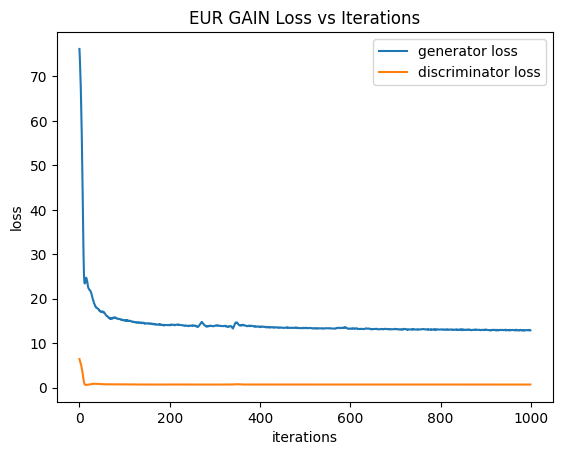

In [ ]:
plt.figure()
plt.title("EUR GAIN Loss vs Iterations")
plt.plot(g_lossEUR, label='generator loss')
plt.plot(d_lossEUR, label = 'discriminator loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
missing_indicesEUR= np.where(1-missing_maskEUR)
imputed_dataEUR = scalerEUR.inverse_transform(generatorEUR.predict(missing_dataEUR))[missing_indicesEUR]
missing_real_dataEUR = XEUR[missing_indicesEUR]

13/13 [==============================] - 0s 2ms/step


In [ ]:
# Scaler : Standard Scaler , Generator Output : Sigmoid
mae = mean_absolute_error(missing_real_dataEUR, imputed_dataEUR)
rmse = np.sqrt(mean_squared_error(missing_real_dataEUR, imputed_dataEUR))
r2 = r2_score(missing_real_dataEUR,imputed_dataEUR)
print("Evaluation\n","MAE : ",mae," | RMSE : ",rmse," | R2 : ",r2)

Evaluation
 MAE :  0.08429449897432202  | RMSE :  0.15983333899694954  | R2 :  0.2337652176619791
